In [4]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import matplotlib.pyplot
import numpy


In [5]:
print(tf.__version__) 

1.14.0


In [25]:
import sys
sys.path.insert(0, 'eslearn/')
import tensorflow as tf                                                        
import numpy as np
import matplotlib.pyplot as plt
import time
import csv

# Declaration of Global variables (X is time in Days) 
X =[]
S =[]
I =[]
R =[]
D =[]

#Setup of random functions

np.random.seed(1234)
tf.set_random_seed(1234)

class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, t, s, i , r ,d, layers):
        
        X = np.concatenate([t,s,i,r,d], 1)
                
        self.lb = t.min()
        self.ub = t.max()
                
        self.X = X
        
        self.t = X[:,0:1]
        self.s = X[:,1:2]
        self.i = X[:,2:3]
        self.r = X[:,3:4]
        self.d = X[:,4:5]
        
        
        self.layers = layers
        
        # Initialize the Neural Network
        self.weights, self.biases = self.initialize_NN(layers)        
        
        # Initialize the equation parameters
        self.lambda_1 =  tf.Variable([0.0], dtype=tf.float32) # Beta
        self.lambda_3 =  tf.Variable([0.0], dtype=tf.float32) # Gamma
        self.lambda_5 =  tf.Variable([0.0], dtype=tf.float32) # Delta
        
        #Initialize the tensorflow session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                      log_device_placement=True))
        
        # Initialize the equation Variables
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.s_tf = tf.placeholder(tf.float32, shape=[None, self.s.shape[1]])
        self.i_tf = tf.placeholder(tf.float32, shape=[None, self.i.shape[1]])
        self.r_tf = tf.placeholder(tf.float32, shape=[None, self.r.shape[1]])
        self.d_tf = tf.placeholder(tf.float32, shape=[None, self.d.shape[1]])
        
        
        self.s_pred, self.i_pred, self.r_pred,self.d_pred, self.f_s_pred, self.f_i_pred,self.f_r_pred, self.f_d_pred = self.net_NS(self.t_tf)
        
        #The loss function
        self.loss = tf.reduce_sum(tf.square(self.f_d_pred)) + \
                    tf.reduce_sum(tf.square(self.s_tf - self.s_pred)) + \
                    tf.reduce_sum(tf.square(self.i_tf - self.i_pred)) + \
                    tf.reduce_sum(tf.square(self.r_tf - self.r_pred)) + \
                    tf.reduce_sum(tf.square(self.d_tf - self.d_pred)) + \
                    tf.reduce_sum(tf.square(self.f_s_pred)) + \
                    tf.reduce_sum(tf.square(self.f_i_pred)) + \
                    tf.reduce_sum(tf.square(self.f_r_pred))
        
        # The optimizer function            
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'ftol' : 1.0 * np.finfo(float).eps})        
        
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
    
    #The neural network
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
           
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2.0/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev = xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
        
    def net_NS(self, t):
        lambda_1 = self.lambda_1       
        lambda_3 = self.lambda_3
        lambda_5 = self.lambda_5
        
        psi_and_p = self.neural_net(tf.concat([t], 1), self.weights, self.biases)
        
        S = psi_and_p[:,0:1]
        I = psi_and_p[:,1:2]
        R = psi_and_p[:,2:3]
        D = psi_and_p[:,3:4]
        
        
        s_t = tf.gradients(S, t)[0]
        i_t = tf.gradients(I, t)[0]
        r_t = tf.gradients(R, t)[0]
        d_t = tf.gradients(D, t)[0]
    

        #The Residual functions
       
        f_s = s_t +  lambda_1*(S*I) 
        f_i = i_t -  lambda_1*(S*I) + lambda_3*I + lambda_5*I
        f_r = r_t  - lambda_3*I 
        f_d = d_t - lambda_5*I
        
        return S, I, R, D, f_s, f_i, f_r, f_d
    
    def callback(self,loss,lambda_1, lambda_3, lambda_5):
        print('Loss: %.3e, l1: %.7f, l3: %.7f, l5: %.7f' % (loss,lambda_1, lambda_3,lambda_5))
      
    def train(self, nIter): 

        tf_dict = {self.t_tf: self.t,self.s_tf: self.s, self.i_tf: self.i,self.r_tf: self.r , self.d_tf: self.d}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                lambda_1_value = self.sess.run(self.lambda_1)
                lambda_3_value = self.sess.run(self.lambda_3)
                lambda_5_value = self.sess.run(self.lambda_5)
                
                
                print('It: %d, Loss: %.3e, l1: %.7f, l3: %.7f, l5: %.7f, Time: %.2f' % 
                      (it, loss_value, lambda_1_value,lambda_3_value, lambda_5_value,elapsed))
                start_time = time.time()
            
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss,self.lambda_1,self.lambda_3,self.lambda_5],
                                loss_callback = self.callback)
            
    
    def predict(self, t_star):
        
        tf_dict = {self.t_tf: t_star}
        
        s_star = self.sess.run(self.s_pred, tf_dict)
        i_star = self.sess.run(self.i_pred, tf_dict)
        r_star = self.sess.run(self.r_pred, tf_dict)
        d_star = self.sess.run(self.d_pred, tf_dict)
        return s_star, i_star, r_star, d_star

#The main fuction of the program

if __name__ == "__main__": 
     
    nu = 0.01/np.pi

    N = 100
    
    layers = [1 ,20 ,20 ,20 , 4]
   
    with open('julyData.csv', mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        line_count = 0
 
        #Read data from the CSV file
        for row in csv_reader:
            X.append(row['day'])
            S.append(row['susceptible'])
            I.append(row['active'])
            D.append(row['death'])
            R.append(row['recovered'])
            
    # Find total size of data
    total = np.size(X)
    
    #Reshaping the arrays of Data
    X = np.reshape(X,(total,1))
    S = np.reshape(S,(total,1))
    I = np.reshape(I,(total,1)) 
    R = np.reshape(R,(total,1)) 
    D = np.reshape(D,(total,1))
    
    #Make the array of data float type
    XX = np.array(X,dtype=float)
    SS = np.array(S,dtype=float)
    II = np.array(I,dtype=float)
    RR = np.array(R,dtype=float)
    DD = np.array(D,dtype=float)
    
    
    #Non-dimentionalize the data
    XX = np.true_divide(XX, 1)
    SS = np.true_divide(SS, 1148000)
    II = np.true_divide(II, 1148000)
    RR = np.true_divide(RR, 1148000)
    DD = np.true_divide(DD, 1148000)
         
# Training Data    
    idx = np.random.choice(N,N, replace=False)
    
    t_train = XX[idx,:]
    S_train = SS[idx,:]
    I_train = II[idx,:]
    R_train = RR[idx,:]
    D_train = DD[idx,:]     
    
    model = PhysicsInformedNN(XX,SS,II,RR,DD,layers) 
    start_time = time.time()
    model.train(1000000)
    stop = time.time() - start_time
    
    print('Elapsed %.3f seconds.' % stop)
    
    

   
    



It: 0, Loss: 4.670e+02, l1: -0.0009995, l3: 0.0009994, l5: -0.0009997, Time: 0.33
It: 10, Loss: 3.422e+02, l1: -0.0008601, l3: 0.0021744, l5: -0.0006463, Time: 0.01
It: 20, Loss: 2.096e+02, l1: 0.0094208, l3: 0.0022501, l5: -0.0006592, Time: 0.01
It: 30, Loss: 7.658e+01, l1: 0.0184378, l3: 0.0021639, l5: 0.0045847, Time: 0.01
It: 40, Loss: 3.584e+00, l1: 0.0101492, l3: 0.0043757, l5: 0.0015514, Time: 0.01
It: 50, Loss: 7.087e+00, l1: 0.0018910, l3: 0.0033806, l5: -0.0002434, Time: 0.01
It: 60, Loss: 2.278e+00, l1: -0.0014634, l3: -0.0014891, l5: -0.0027348, Time: 0.01
It: 70, Loss: 4.805e-01, l1: -0.0044810, l3: -0.0054699, l5: -0.0039971, Time: 0.01
It: 80, Loss: 6.516e-01, l1: -0.0059548, l3: -0.0056182, l5: -0.0036521, Time: 0.01
It: 90, Loss: 1.900e-01, l1: -0.0045048, l3: -0.0035025, l5: -0.0021052, Time: 0.01
It: 100, Loss: 2.396e-01, l1: -0.0030397, l3: -0.0023374, l5: -0.0011502, Time: 0.01
It: 110, Loss: 1.778e-01, l1: -0.0029057, l3: -0.0022549, l5: -0.0010860, Time: 0.01
It:

It: 1120, Loss: 1.865e-02, l1: 0.0246472, l3: 0.0202841, l5: 0.0019337, Time: 0.01
It: 1130, Loss: 1.838e-02, l1: 0.0249265, l3: 0.0205149, l5: 0.0019736, Time: 0.01
It: 1140, Loss: 1.813e-02, l1: 0.0252041, l3: 0.0207442, l5: 0.0020130, Time: 0.01
It: 1150, Loss: 1.788e-02, l1: 0.0254800, l3: 0.0209719, l5: 0.0020521, Time: 0.01
It: 1160, Loss: 1.763e-02, l1: 0.0257543, l3: 0.0211980, l5: 0.0020907, Time: 0.01
It: 1170, Loss: 1.739e-02, l1: 0.0260268, l3: 0.0214225, l5: 0.0021289, Time: 0.01
It: 1180, Loss: 1.716e-02, l1: 0.0262976, l3: 0.0216454, l5: 0.0021667, Time: 0.01
It: 1190, Loss: 1.693e-02, l1: 0.0265666, l3: 0.0218667, l5: 0.0022041, Time: 0.01
It: 1200, Loss: 1.670e-02, l1: 0.0268339, l3: 0.0220864, l5: 0.0022411, Time: 0.01
It: 1210, Loss: 1.648e-02, l1: 0.0270993, l3: 0.0223044, l5: 0.0022777, Time: 0.01
It: 1220, Loss: 1.627e-02, l1: 0.0273630, l3: 0.0225208, l5: 0.0023139, Time: 0.01
It: 1230, Loss: 1.605e-02, l1: 0.0276249, l3: 0.0227356, l5: 0.0023498, Time: 0.01
It: 

It: 2250, Loss: 5.967e-03, l1: 0.0443101, l3: 0.0363861, l5: 0.0043772, Time: 0.01
It: 2260, Loss: 5.926e-03, l1: 0.0443867, l3: 0.0364534, l5: 0.0043834, Time: 0.01
It: 2270, Loss: 5.884e-03, l1: 0.0444621, l3: 0.0365198, l5: 0.0043894, Time: 0.01
It: 2280, Loss: 5.843e-03, l1: 0.0445362, l3: 0.0365852, l5: 0.0043951, Time: 0.01
It: 2290, Loss: 5.803e-03, l1: 0.0446091, l3: 0.0366498, l5: 0.0044007, Time: 0.01
It: 2300, Loss: 5.763e-03, l1: 0.0446807, l3: 0.0367135, l5: 0.0044060, Time: 0.01
It: 2310, Loss: 5.723e-03, l1: 0.0447511, l3: 0.0367763, l5: 0.0044111, Time: 0.01
It: 2320, Loss: 5.685e-03, l1: 0.0448202, l3: 0.0368383, l5: 0.0044159, Time: 0.01
It: 2330, Loss: 5.646e-03, l1: 0.0448882, l3: 0.0368994, l5: 0.0044206, Time: 0.01
It: 2340, Loss: 5.608e-03, l1: 0.0449550, l3: 0.0369596, l5: 0.0044250, Time: 0.01
It: 2350, Loss: 5.571e-03, l1: 0.0450207, l3: 0.0370190, l5: 0.0044292, Time: 0.01
It: 2360, Loss: 5.534e-03, l1: 0.0450851, l3: 0.0370777, l5: 0.0044332, Time: 0.01
It: 

It: 3360, Loss: 3.363e-03, l1: 0.0478195, l3: 0.0402952, l5: 0.0041221, Time: 0.01
It: 3370, Loss: 3.351e-03, l1: 0.0478266, l3: 0.0403121, l5: 0.0041154, Time: 0.01
It: 3380, Loss: 3.339e-03, l1: 0.0478334, l3: 0.0403289, l5: 0.0041086, Time: 0.01
It: 3390, Loss: 3.327e-03, l1: 0.0478401, l3: 0.0403455, l5: 0.0041019, Time: 0.01
It: 3400, Loss: 3.316e-03, l1: 0.0478466, l3: 0.0403620, l5: 0.0040951, Time: 0.01
It: 3410, Loss: 3.304e-03, l1: 0.0478530, l3: 0.0403783, l5: 0.0040884, Time: 0.01
It: 3420, Loss: 3.293e-03, l1: 0.0478593, l3: 0.0403945, l5: 0.0040816, Time: 0.01
It: 3430, Loss: 3.281e-03, l1: 0.0478653, l3: 0.0404105, l5: 0.0040748, Time: 0.01
It: 3440, Loss: 3.270e-03, l1: 0.0478713, l3: 0.0404264, l5: 0.0040680, Time: 0.01
It: 3450, Loss: 3.259e-03, l1: 0.0478771, l3: 0.0404422, l5: 0.0040612, Time: 0.01
It: 3460, Loss: 3.248e-03, l1: 0.0478828, l3: 0.0404578, l5: 0.0040544, Time: 0.01
It: 3470, Loss: 3.238e-03, l1: 0.0478883, l3: 0.0404733, l5: 0.0040476, Time: 0.01
It: 

It: 4490, Loss: 2.533e-03, l1: 0.0481122, l3: 0.0415768, l5: 0.0034252, Time: 0.01
It: 4500, Loss: 2.529e-03, l1: 0.0481123, l3: 0.0415839, l5: 0.0034201, Time: 0.01
It: 4510, Loss: 2.525e-03, l1: 0.0481125, l3: 0.0415910, l5: 0.0034150, Time: 0.01
It: 4520, Loss: 2.521e-03, l1: 0.0481126, l3: 0.0415980, l5: 0.0034100, Time: 0.01
It: 4530, Loss: 2.516e-03, l1: 0.0481126, l3: 0.0416049, l5: 0.0034050, Time: 0.01
It: 4540, Loss: 2.512e-03, l1: 0.0481126, l3: 0.0416117, l5: 0.0034000, Time: 0.01
It: 4550, Loss: 2.508e-03, l1: 0.0481126, l3: 0.0416185, l5: 0.0033950, Time: 0.01
It: 4560, Loss: 2.504e-03, l1: 0.0481126, l3: 0.0416252, l5: 0.0033901, Time: 0.01
It: 4570, Loss: 2.500e-03, l1: 0.0481125, l3: 0.0416319, l5: 0.0033851, Time: 0.01
It: 4580, Loss: 2.496e-03, l1: 0.0481124, l3: 0.0416385, l5: 0.0033802, Time: 0.01
It: 4590, Loss: 2.492e-03, l1: 0.0481122, l3: 0.0416450, l5: 0.0033753, Time: 0.01
It: 4600, Loss: 2.488e-03, l1: 0.0481120, l3: 0.0416514, l5: 0.0033705, Time: 0.01
It: 

It: 5610, Loss: 2.288e-03, l1: 0.0478270, l3: 0.0419343, l5: 0.0029574, Time: 0.01
It: 5620, Loss: 2.214e-03, l1: 0.0478097, l3: 0.0419163, l5: 0.0029552, Time: 0.01
It: 5630, Loss: 2.233e-03, l1: 0.0477946, l3: 0.0419020, l5: 0.0029534, Time: 0.01
It: 5640, Loss: 2.202e-03, l1: 0.0477838, l3: 0.0418968, l5: 0.0029512, Time: 0.01
It: 5650, Loss: 2.200e-03, l1: 0.0477770, l3: 0.0418974, l5: 0.0029484, Time: 0.01
It: 5660, Loss: 2.197e-03, l1: 0.0477718, l3: 0.0418999, l5: 0.0029450, Time: 0.01
It: 5670, Loss: 2.194e-03, l1: 0.0477671, l3: 0.0419023, l5: 0.0029411, Time: 0.01
It: 5680, Loss: 2.192e-03, l1: 0.0477627, l3: 0.0419042, l5: 0.0029369, Time: 0.01
It: 5690, Loss: 2.190e-03, l1: 0.0477582, l3: 0.0419055, l5: 0.0029326, Time: 0.01
It: 5700, Loss: 2.188e-03, l1: 0.0477536, l3: 0.0419063, l5: 0.0029284, Time: 0.01
It: 5710, Loss: 2.186e-03, l1: 0.0477487, l3: 0.0419066, l5: 0.0029244, Time: 0.01
It: 5720, Loss: 2.184e-03, l1: 0.0477436, l3: 0.0419066, l5: 0.0029206, Time: 0.01
It: 

It: 6720, Loss: 2.022e-03, l1: 0.0466834, l3: 0.0413182, l5: 0.0026477, Time: 0.01
It: 6730, Loss: 2.020e-03, l1: 0.0466877, l3: 0.0413255, l5: 0.0026453, Time: 0.01
It: 6740, Loss: 2.019e-03, l1: 0.0466890, l3: 0.0413286, l5: 0.0026441, Time: 0.01
It: 6750, Loss: 2.017e-03, l1: 0.0466877, l3: 0.0413285, l5: 0.0026434, Time: 0.01
It: 6760, Loss: 2.016e-03, l1: 0.0466841, l3: 0.0413262, l5: 0.0026430, Time: 0.01
It: 6770, Loss: 2.019e-03, l1: 0.0466787, l3: 0.0413223, l5: 0.0026428, Time: 0.01
It: 6780, Loss: 2.426e-03, l1: 0.0466632, l3: 0.0413022, l5: 0.0026451, Time: 0.01
It: 6790, Loss: 2.029e-03, l1: 0.0461780, l3: 0.0404966, l5: 0.0027402, Time: 0.01
It: 6800, Loss: 2.426e-03, l1: 0.0452243, l3: 0.0391706, l5: 0.0028990, Time: 0.01
It: 6810, Loss: 2.011e-03, l1: 0.0445682, l3: 0.0385378, l5: 0.0030279, Time: 0.01
It: 6820, Loss: 2.058e-03, l1: 0.0444127, l3: 0.0386819, l5: 0.0030603, Time: 0.01
It: 6830, Loss: 2.007e-03, l1: 0.0445191, l3: 0.0390863, l5: 0.0029837, Time: 0.01
It: 

It: 7840, Loss: 2.299e-03, l1: 0.0278134, l3: 0.0221278, l5: 0.0044688, Time: 0.01
It: 7850, Loss: 2.006e-03, l1: 0.0294292, l3: 0.0258203, l5: 0.0034702, Time: 0.01
It: 7860, Loss: 1.893e-03, l1: 0.0327202, l3: 0.0301184, l5: 0.0020593, Time: 0.01
It: 7870, Loss: 1.880e-03, l1: 0.0361024, l3: 0.0337481, l5: 0.0011142, Time: 0.01
It: 7880, Loss: 1.873e-03, l1: 0.0389221, l3: 0.0364361, l5: 0.0008652, Time: 0.01
It: 7890, Loss: 1.864e-03, l1: 0.0410649, l3: 0.0382268, l5: 0.0010618, Time: 0.01
It: 7900, Loss: 1.863e-03, l1: 0.0426152, l3: 0.0392935, l5: 0.0013984, Time: 0.01
It: 7910, Loss: 1.862e-03, l1: 0.0436906, l3: 0.0398714, l5: 0.0017171, Time: 0.01
It: 7920, Loss: 1.860e-03, l1: 0.0444018, l3: 0.0401738, l5: 0.0019769, Time: 0.01
It: 7930, Loss: 1.859e-03, l1: 0.0448467, l3: 0.0403350, l5: 0.0021736, Time: 0.01
It: 7940, Loss: 1.857e-03, l1: 0.0451123, l3: 0.0404260, l5: 0.0023080, Time: 0.01
It: 7950, Loss: 1.856e-03, l1: 0.0452635, l3: 0.0404773, l5: 0.0023871, Time: 0.01
It: 

It: 8940, Loss: 1.759e-03, l1: 0.0443991, l3: 0.0403478, l5: 0.0019502, Time: 0.01
It: 8950, Loss: 1.771e-03, l1: 0.0449723, l3: 0.0405728, l5: 0.0021674, Time: 0.01
It: 8960, Loss: 2.091e-03, l1: 0.0452014, l3: 0.0406025, l5: 0.0023051, Time: 0.01
It: 8970, Loss: 1.827e-03, l1: 0.0451579, l3: 0.0404721, l5: 0.0023637, Time: 0.01
It: 8980, Loss: 1.817e-03, l1: 0.0450704, l3: 0.0403977, l5: 0.0023774, Time: 0.01
It: 8990, Loss: 1.774e-03, l1: 0.0450232, l3: 0.0404006, l5: 0.0023602, Time: 0.01
It: 9000, Loss: 1.757e-03, l1: 0.0450144, l3: 0.0404297, l5: 0.0023264, Time: 0.01
It: 9010, Loss: 1.765e-03, l1: 0.0450236, l3: 0.0404597, l5: 0.0023050, Time: 0.01
It: 9020, Loss: 2.380e-03, l1: 0.0450000, l3: 0.0404332, l5: 0.0023060, Time: 0.01
It: 9030, Loss: 1.244e-02, l1: 0.0409270, l3: 0.0353458, l5: 0.0025377, Time: 0.01
It: 9040, Loss: 1.997e-03, l1: 0.0315541, l3: 0.0253545, l5: 0.0034620, Time: 0.01
It: 9050, Loss: 2.897e-03, l1: 0.0295428, l3: 0.0251472, l5: 0.0033066, Time: 0.01
It: 

It: 10080, Loss: 2.099e-03, l1: 0.0415679, l3: 0.0365609, l5: 0.0027394, Time: 0.01
It: 10090, Loss: 1.931e-03, l1: 0.0420150, l3: 0.0375570, l5: 0.0023465, Time: 0.01
It: 10100, Loss: 1.789e-03, l1: 0.0432745, l3: 0.0391889, l5: 0.0019641, Time: 0.01
It: 10110, Loss: 1.718e-03, l1: 0.0445808, l3: 0.0405323, l5: 0.0019128, Time: 0.01
It: 10120, Loss: 1.691e-03, l1: 0.0455044, l3: 0.0412390, l5: 0.0020350, Time: 0.01
It: 10130, Loss: 1.694e-03, l1: 0.0459841, l3: 0.0414795, l5: 0.0021796, Time: 0.01
It: 10140, Loss: 1.692e-03, l1: 0.0461329, l3: 0.0415013, l5: 0.0022729, Time: 0.01
It: 10150, Loss: 1.692e-03, l1: 0.0461090, l3: 0.0414559, l5: 0.0022913, Time: 0.01
It: 10160, Loss: 1.691e-03, l1: 0.0460340, l3: 0.0414120, l5: 0.0022691, Time: 0.01
It: 10170, Loss: 1.707e-03, l1: 0.0459714, l3: 0.0413875, l5: 0.0022452, Time: 0.01
It: 10180, Loss: 2.160e-03, l1: 0.0458857, l3: 0.0413164, l5: 0.0022387, Time: 0.01
It: 10190, Loss: 1.109e-02, l1: 0.0438235, l3: 0.0389460, l5: 0.0024149, Tim

It: 11200, Loss: 1.661e-03, l1: 0.0474686, l3: 0.0426793, l5: 0.0022747, Time: 0.01
It: 11210, Loss: 1.670e-03, l1: 0.0472570, l3: 0.0425045, l5: 0.0022535, Time: 0.01
It: 11220, Loss: 1.840e-03, l1: 0.0469694, l3: 0.0422713, l5: 0.0022320, Time: 0.01
It: 11230, Loss: 6.676e-03, l1: 0.0448974, l3: 0.0401974, l5: 0.0023362, Time: 0.01
It: 11240, Loss: 2.480e-03, l1: 0.0326428, l3: 0.0279553, l5: 0.0025881, Time: 0.01
It: 11250, Loss: 2.851e-03, l1: 0.0301038, l3: 0.0262763, l5: 0.0019736, Time: 0.01
It: 11260, Loss: 2.039e-03, l1: 0.0352900, l3: 0.0321053, l5: 0.0014882, Time: 0.01
It: 11270, Loss: 1.691e-03, l1: 0.0417960, l3: 0.0383579, l5: 0.0014863, Time: 0.01
It: 11280, Loss: 1.665e-03, l1: 0.0462470, l3: 0.0420752, l5: 0.0018871, Time: 0.01
It: 11290, Loss: 1.663e-03, l1: 0.0481176, l3: 0.0433393, l5: 0.0022470, Time: 0.01
It: 11300, Loss: 1.659e-03, l1: 0.0482839, l3: 0.0432978, l5: 0.0023770, Time: 0.01
It: 11310, Loss: 1.657e-03, l1: 0.0477664, l3: 0.0428639, l5: 0.0023361, Tim

It: 12330, Loss: 1.661e-03, l1: 0.0486943, l3: 0.0439004, l5: 0.0022322, Time: 0.01
It: 12340, Loss: 1.644e-03, l1: 0.0487061, l3: 0.0438392, l5: 0.0022677, Time: 0.01
It: 12350, Loss: 1.642e-03, l1: 0.0482100, l3: 0.0434109, l5: 0.0022323, Time: 0.01
It: 12360, Loss: 1.639e-03, l1: 0.0478322, l3: 0.0431071, l5: 0.0021935, Time: 0.01
It: 12370, Loss: 1.639e-03, l1: 0.0476899, l3: 0.0429923, l5: 0.0021775, Time: 0.01
It: 12380, Loss: 1.638e-03, l1: 0.0477093, l3: 0.0430058, l5: 0.0021821, Time: 0.01
It: 12390, Loss: 1.638e-03, l1: 0.0477771, l3: 0.0430609, l5: 0.0021893, Time: 0.01
It: 12400, Loss: 1.640e-03, l1: 0.0478315, l3: 0.0431098, l5: 0.0021929, Time: 0.01
It: 12410, Loss: 1.701e-03, l1: 0.0478506, l3: 0.0431305, l5: 0.0021949, Time: 0.01
It: 12420, Loss: 5.179e-03, l1: 0.0475347, l3: 0.0428252, l5: 0.0022500, Time: 0.01
It: 12430, Loss: 2.206e-03, l1: 0.0394018, l3: 0.0348342, l5: 0.0025207, Time: 0.01
It: 12440, Loss: 3.408e-03, l1: 0.0344164, l3: 0.0302479, l5: 0.0019598, Tim

It: 13460, Loss: 1.627e-03, l1: 0.0483616, l3: 0.0437027, l5: 0.0021597, Time: 0.01
It: 13470, Loss: 1.627e-03, l1: 0.0481724, l3: 0.0435189, l5: 0.0021604, Time: 0.01
It: 13480, Loss: 1.626e-03, l1: 0.0481690, l3: 0.0435132, l5: 0.0021611, Time: 0.01
It: 13490, Loss: 1.626e-03, l1: 0.0482316, l3: 0.0435746, l5: 0.0021626, Time: 0.01
It: 13500, Loss: 1.626e-03, l1: 0.0482889, l3: 0.0436323, l5: 0.0021624, Time: 0.01
It: 13510, Loss: 1.626e-03, l1: 0.0483173, l3: 0.0436617, l5: 0.0021622, Time: 0.01
It: 13520, Loss: 1.626e-03, l1: 0.0483223, l3: 0.0436680, l5: 0.0021622, Time: 0.01
It: 13530, Loss: 1.627e-03, l1: 0.0483168, l3: 0.0436640, l5: 0.0021615, Time: 0.01
It: 13540, Loss: 1.716e-03, l1: 0.0482855, l3: 0.0436355, l5: 0.0021603, Time: 0.01
It: 13550, Loss: 1.001e-02, l1: 0.0464018, l3: 0.0418978, l5: 0.0022971, Time: 0.01
It: 13560, Loss: 6.554e-03, l1: 0.0291363, l3: 0.0256512, l5: 0.0015581, Time: 0.01
It: 13570, Loss: 2.475e-03, l1: 0.0251824, l3: 0.0218709, l5: 0.0015572, Tim

It: 14600, Loss: 1.662e-03, l1: 0.0444376, l3: 0.0404854, l5: 0.0018153, Time: 0.01
It: 14610, Loss: 2.072e-03, l1: 0.0429310, l3: 0.0390588, l5: 0.0018048, Time: 0.01
It: 14620, Loss: 1.112e-02, l1: 0.0437586, l3: 0.0394535, l5: 0.0022132, Time: 0.01
It: 14630, Loss: 4.837e-03, l1: 0.0356440, l3: 0.0317743, l5: 0.0017548, Time: 0.01
It: 14640, Loss: 1.765e-03, l1: 0.0342449, l3: 0.0305505, l5: 0.0016168, Time: 0.01
It: 14650, Loss: 1.951e-03, l1: 0.0394419, l3: 0.0353713, l5: 0.0020210, Time: 0.01
It: 14660, Loss: 1.698e-03, l1: 0.0452166, l3: 0.0407683, l5: 0.0021268, Time: 0.01
It: 14670, Loss: 1.623e-03, l1: 0.0487479, l3: 0.0441438, l5: 0.0021225, Time: 0.01
It: 14680, Loss: 1.630e-03, l1: 0.0499016, l3: 0.0453088, l5: 0.0021542, Time: 0.01
It: 14690, Loss: 1.625e-03, l1: 0.0496922, l3: 0.0451436, l5: 0.0021397, Time: 0.01
It: 14700, Loss: 1.620e-03, l1: 0.0491133, l3: 0.0445858, l5: 0.0021161, Time: 0.01
It: 14710, Loss: 1.619e-03, l1: 0.0486725, l3: 0.0441512, l5: 0.0021175, Tim

It: 15580, Loss: 7.010e-03, l1: 0.0410323, l3: 0.0373423, l5: 0.0018169, Time: 0.01
It: 15590, Loss: 2.869e-03, l1: 0.0368461, l3: 0.0328822, l5: 0.0018801, Time: 0.01
It: 15600, Loss: 2.597e-03, l1: 0.0388016, l3: 0.0345415, l5: 0.0020459, Time: 0.01
It: 15610, Loss: 1.866e-03, l1: 0.0429636, l3: 0.0387187, l5: 0.0021047, Time: 0.01
It: 15620, Loss: 1.679e-03, l1: 0.0464133, l3: 0.0421963, l5: 0.0020203, Time: 0.01
It: 15630, Loss: 1.650e-03, l1: 0.0485784, l3: 0.0442569, l5: 0.0020444, Time: 0.01
It: 15640, Loss: 1.632e-03, l1: 0.0492525, l3: 0.0448568, l5: 0.0020644, Time: 0.01
It: 15650, Loss: 1.620e-03, l1: 0.0491648, l3: 0.0447567, l5: 0.0020949, Time: 0.01
It: 15660, Loss: 1.614e-03, l1: 0.0488913, l3: 0.0444977, l5: 0.0020889, Time: 0.01
It: 15670, Loss: 1.613e-03, l1: 0.0487209, l3: 0.0443389, l5: 0.0020825, Time: 0.01
It: 15680, Loss: 1.612e-03, l1: 0.0486797, l3: 0.0443000, l5: 0.0020809, Time: 0.01
It: 15690, Loss: 1.613e-03, l1: 0.0487083, l3: 0.0443273, l5: 0.0020828, Tim

It: 16720, Loss: 1.610e-03, l1: 0.0493923, l3: 0.0451899, l5: 0.0020210, Time: 0.01
It: 16730, Loss: 1.623e-03, l1: 0.0489669, l3: 0.0447330, l5: 0.0020413, Time: 0.01
It: 16740, Loss: 1.853e-03, l1: 0.0487068, l3: 0.0444694, l5: 0.0020458, Time: 0.01
It: 16750, Loss: 7.537e-03, l1: 0.0471143, l3: 0.0429741, l5: 0.0020939, Time: 0.01
It: 16760, Loss: 3.350e-03, l1: 0.0385589, l3: 0.0349221, l5: 0.0017247, Time: 0.01
It: 16770, Loss: 2.735e-03, l1: 0.0371161, l3: 0.0333713, l5: 0.0017364, Time: 0.01
It: 16780, Loss: 1.815e-03, l1: 0.0412829, l3: 0.0371684, l5: 0.0020225, Time: 0.01
It: 16790, Loss: 1.613e-03, l1: 0.0459670, l3: 0.0416681, l5: 0.0021293, Time: 0.01
It: 16800, Loss: 1.613e-03, l1: 0.0488182, l3: 0.0445450, l5: 0.0020918, Time: 0.01
It: 16810, Loss: 1.611e-03, l1: 0.0497636, l3: 0.0455566, l5: 0.0020376, Time: 0.01
It: 16820, Loss: 1.608e-03, l1: 0.0496367, l3: 0.0454468, l5: 0.0020169, Time: 0.01
It: 16830, Loss: 1.607e-03, l1: 0.0492259, l3: 0.0450207, l5: 0.0020296, Tim

It: 17870, Loss: 3.048e-03, l1: 0.0421046, l3: 0.0386413, l5: 0.0017032, Time: 0.01
It: 17880, Loss: 4.652e-03, l1: 0.0395410, l3: 0.0358583, l5: 0.0018373, Time: 0.01
It: 17890, Loss: 2.092e-03, l1: 0.0379118, l3: 0.0342505, l5: 0.0019551, Time: 0.01
It: 17900, Loss: 1.644e-03, l1: 0.0421210, l3: 0.0380596, l5: 0.0020852, Time: 0.01
It: 17910, Loss: 1.652e-03, l1: 0.0465172, l3: 0.0423243, l5: 0.0021118, Time: 0.01
It: 17920, Loss: 1.631e-03, l1: 0.0488363, l3: 0.0447752, l5: 0.0020082, Time: 0.01
It: 17930, Loss: 1.613e-03, l1: 0.0495874, l3: 0.0456053, l5: 0.0019646, Time: 0.01
It: 17940, Loss: 1.608e-03, l1: 0.0494695, l3: 0.0454717, l5: 0.0019722, Time: 0.01
It: 17950, Loss: 1.607e-03, l1: 0.0491697, l3: 0.0451342, l5: 0.0020044, Time: 0.01
It: 17960, Loss: 1.603e-03, l1: 0.0489568, l3: 0.0449094, l5: 0.0020079, Time: 0.01
It: 17970, Loss: 1.604e-03, l1: 0.0489035, l3: 0.0448629, l5: 0.0020038, Time: 0.01
It: 17980, Loss: 1.604e-03, l1: 0.0489316, l3: 0.0449000, l5: 0.0019994, Tim

It: 19020, Loss: 1.600e-03, l1: 0.0491052, l3: 0.0452275, l5: 0.0019766, Time: 0.01
It: 19030, Loss: 1.645e-03, l1: 0.0491025, l3: 0.0452279, l5: 0.0019809, Time: 0.01
It: 19040, Loss: 6.232e-03, l1: 0.0486004, l3: 0.0447835, l5: 0.0020590, Time: 0.01
It: 19050, Loss: 5.071e-03, l1: 0.0366516, l3: 0.0335775, l5: 0.0014978, Time: 0.01
It: 19060, Loss: 1.904e-03, l1: 0.0308787, l3: 0.0276189, l5: 0.0017087, Time: 0.01
It: 19070, Loss: 2.298e-03, l1: 0.0357358, l3: 0.0317759, l5: 0.0020814, Time: 0.01
It: 19080, Loss: 1.866e-03, l1: 0.0431791, l3: 0.0389801, l5: 0.0021785, Time: 0.01
It: 19090, Loss: 1.611e-03, l1: 0.0483323, l3: 0.0443088, l5: 0.0020646, Time: 0.01
It: 19100, Loss: 1.621e-03, l1: 0.0504196, l3: 0.0465940, l5: 0.0019497, Time: 0.01
It: 19110, Loss: 1.610e-03, l1: 0.0505306, l3: 0.0467515, l5: 0.0019197, Time: 0.01
It: 19120, Loss: 1.600e-03, l1: 0.0499090, l3: 0.0460848, l5: 0.0019449, Time: 0.01
It: 19130, Loss: 1.600e-03, l1: 0.0493177, l3: 0.0454510, l5: 0.0019728, Tim

It: 20010, Loss: 1.695e-03, l1: 0.0371483, l3: 0.0331578, l5: 0.0020815, Time: 0.01
It: 20020, Loss: 1.679e-03, l1: 0.0442230, l3: 0.0402802, l5: 0.0020495, Time: 0.01
It: 20030, Loss: 1.613e-03, l1: 0.0482963, l3: 0.0446127, l5: 0.0019293, Time: 0.01
It: 20040, Loss: 1.604e-03, l1: 0.0499510, l3: 0.0463370, l5: 0.0019019, Time: 0.01
It: 20050, Loss: 1.601e-03, l1: 0.0501448, l3: 0.0464677, l5: 0.0019284, Time: 0.01
It: 20060, Loss: 1.597e-03, l1: 0.0497441, l3: 0.0460140, l5: 0.0019531, Time: 0.01
It: 20070, Loss: 1.597e-03, l1: 0.0493274, l3: 0.0455889, l5: 0.0019601, Time: 0.01
It: 20080, Loss: 1.596e-03, l1: 0.0491074, l3: 0.0453785, l5: 0.0019590, Time: 0.01
It: 20090, Loss: 1.596e-03, l1: 0.0490625, l3: 0.0453410, l5: 0.0019567, Time: 0.01
It: 20100, Loss: 1.597e-03, l1: 0.0491038, l3: 0.0453832, l5: 0.0019571, Time: 0.01
It: 20110, Loss: 1.630e-03, l1: 0.0491562, l3: 0.0454358, l5: 0.0019592, Time: 0.01
It: 20120, Loss: 3.979e-03, l1: 0.0491518, l3: 0.0454438, l5: 0.0019720, Tim

It: 21020, Loss: 1.772e-03, l1: 0.0450981, l3: 0.0414061, l5: 0.0020117, Time: 0.01
It: 21030, Loss: 1.710e-03, l1: 0.0470909, l3: 0.0433669, l5: 0.0020438, Time: 0.01
It: 21040, Loss: 1.631e-03, l1: 0.0486017, l3: 0.0449666, l5: 0.0019633, Time: 0.01
It: 21050, Loss: 1.595e-03, l1: 0.0493587, l3: 0.0457851, l5: 0.0019322, Time: 0.01
It: 21060, Loss: 1.604e-03, l1: 0.0495428, l3: 0.0459723, l5: 0.0019332, Time: 0.01
It: 21070, Loss: 1.608e-03, l1: 0.0494298, l3: 0.0458446, l5: 0.0019452, Time: 0.01
It: 21080, Loss: 1.653e-03, l1: 0.0492374, l3: 0.0456469, l5: 0.0019542, Time: 0.01
It: 21090, Loss: 2.456e-03, l1: 0.0488796, l3: 0.0453145, l5: 0.0019685, Time: 0.01
It: 21100, Loss: 6.424e-03, l1: 0.0447338, l3: 0.0414964, l5: 0.0018657, Time: 0.01
It: 21110, Loss: 3.147e-03, l1: 0.0389800, l3: 0.0358918, l5: 0.0016910, Time: 0.01
It: 21120, Loss: 2.026e-03, l1: 0.0407003, l3: 0.0371432, l5: 0.0019977, Time: 0.01
It: 21130, Loss: 1.711e-03, l1: 0.0450462, l3: 0.0411915, l5: 0.0021006, Tim

It: 22020, Loss: 1.592e-03, l1: 0.0500441, l3: 0.0466057, l5: 0.0019128, Time: 0.01
It: 22030, Loss: 1.593e-03, l1: 0.0497714, l3: 0.0463510, l5: 0.0019037, Time: 0.01
It: 22040, Loss: 1.614e-03, l1: 0.0494251, l3: 0.0459607, l5: 0.0019264, Time: 0.01
It: 22050, Loss: 2.942e-03, l1: 0.0490522, l3: 0.0455766, l5: 0.0019210, Time: 0.01
It: 22060, Loss: 4.336e-03, l1: 0.0433758, l3: 0.0405104, l5: 0.0015827, Time: 0.01
It: 22070, Loss: 2.839e-03, l1: 0.0371022, l3: 0.0342701, l5: 0.0016456, Time: 0.01
It: 22080, Loss: 1.901e-03, l1: 0.0391889, l3: 0.0355569, l5: 0.0021139, Time: 0.01
It: 22090, Loss: 1.866e-03, l1: 0.0442658, l3: 0.0402439, l5: 0.0022486, Time: 0.01
It: 22100, Loss: 1.604e-03, l1: 0.0481472, l3: 0.0443664, l5: 0.0020891, Time: 0.01
It: 22110, Loss: 1.623e-03, l1: 0.0498920, l3: 0.0464473, l5: 0.0019160, Time: 0.01
It: 22120, Loss: 1.597e-03, l1: 0.0501708, l3: 0.0468308, l5: 0.0018639, Time: 0.01
It: 22130, Loss: 1.594e-03, l1: 0.0498367, l3: 0.0464316, l5: 0.0018987, Tim

It: 23030, Loss: 4.880e-03, l1: 0.0484532, l3: 0.0451525, l5: 0.0018058, Time: 0.01
It: 23040, Loss: 2.503e-03, l1: 0.0349326, l3: 0.0329182, l5: 0.0012978, Time: 0.01
It: 23050, Loss: 3.259e-03, l1: 0.0294231, l3: 0.0269492, l5: 0.0015040, Time: 0.01
It: 23060, Loss: 2.119e-03, l1: 0.0353697, l3: 0.0316640, l5: 0.0021251, Time: 0.01
It: 23070, Loss: 1.597e-03, l1: 0.0433458, l3: 0.0392430, l5: 0.0023277, Time: 0.01
It: 23080, Loss: 1.685e-03, l1: 0.0485402, l3: 0.0447937, l5: 0.0021349, Time: 0.01
It: 23090, Loss: 1.594e-03, l1: 0.0504817, l3: 0.0471550, l5: 0.0019020, Time: 0.01
It: 23100, Loss: 1.603e-03, l1: 0.0505193, l3: 0.0473163, l5: 0.0018322, Time: 0.01
It: 23110, Loss: 1.590e-03, l1: 0.0499381, l3: 0.0466482, l5: 0.0018842, Time: 0.01
It: 23120, Loss: 1.591e-03, l1: 0.0494131, l3: 0.0460233, l5: 0.0019398, Time: 0.01
It: 23130, Loss: 1.591e-03, l1: 0.0491414, l3: 0.0457236, l5: 0.0019545, Time: 0.01
It: 23140, Loss: 1.590e-03, l1: 0.0490871, l3: 0.0456873, l5: 0.0019480, Tim

It: 24030, Loss: 1.598e-03, l1: 0.0495316, l3: 0.0462161, l5: 0.0019264, Time: 0.01
It: 24040, Loss: 1.593e-03, l1: 0.0496962, l3: 0.0463922, l5: 0.0019319, Time: 0.01
It: 24050, Loss: 1.590e-03, l1: 0.0495250, l3: 0.0462230, l5: 0.0019279, Time: 0.01
It: 24060, Loss: 1.589e-03, l1: 0.0493322, l3: 0.0460238, l5: 0.0019343, Time: 0.01
It: 24070, Loss: 1.589e-03, l1: 0.0492161, l3: 0.0459038, l5: 0.0019370, Time: 0.01
It: 24080, Loss: 1.589e-03, l1: 0.0491783, l3: 0.0458670, l5: 0.0019362, Time: 0.01
It: 24090, Loss: 1.589e-03, l1: 0.0491861, l3: 0.0458773, l5: 0.0019352, Time: 0.01
It: 24100, Loss: 1.590e-03, l1: 0.0492033, l3: 0.0458972, l5: 0.0019332, Time: 0.01
It: 24110, Loss: 1.613e-03, l1: 0.0491860, l3: 0.0458873, l5: 0.0019196, Time: 0.01
It: 24120, Loss: 2.799e-03, l1: 0.0481909, l3: 0.0450799, l5: 0.0016727, Time: 0.01
It: 24130, Loss: 6.750e-03, l1: 0.0330759, l3: 0.0324963, l5: 0.0006844, Time: 0.01
It: 24140, Loss: 2.512e-03, l1: 0.0265763, l3: 0.0259845, l5: 0.0006371, Tim

It: 25050, Loss: 1.599e-03, l1: 0.0490352, l3: 0.0457862, l5: 0.0019401, Time: 0.01
It: 25060, Loss: 1.601e-03, l1: 0.0501962, l3: 0.0469398, l5: 0.0019382, Time: 0.01
It: 25070, Loss: 1.590e-03, l1: 0.0501184, l3: 0.0468544, l5: 0.0019357, Time: 0.01
It: 25080, Loss: 1.588e-03, l1: 0.0496822, l3: 0.0464147, l5: 0.0019377, Time: 0.01
It: 25090, Loss: 1.588e-03, l1: 0.0493236, l3: 0.0460588, l5: 0.0019415, Time: 0.01
It: 25100, Loss: 1.588e-03, l1: 0.0491550, l3: 0.0458949, l5: 0.0019428, Time: 0.01
It: 25110, Loss: 1.588e-03, l1: 0.0491296, l3: 0.0458728, l5: 0.0019420, Time: 0.01
It: 25120, Loss: 1.587e-03, l1: 0.0491664, l3: 0.0459111, l5: 0.0019415, Time: 0.01
It: 25130, Loss: 1.587e-03, l1: 0.0492081, l3: 0.0459533, l5: 0.0019413, Time: 0.01
It: 25140, Loss: 1.587e-03, l1: 0.0492319, l3: 0.0459777, l5: 0.0019413, Time: 0.01
It: 25150, Loss: 1.587e-03, l1: 0.0492378, l3: 0.0459850, l5: 0.0019413, Time: 0.01
It: 25160, Loss: 1.587e-03, l1: 0.0492345, l3: 0.0459831, l5: 0.0019413, Tim

It: 26190, Loss: 1.589e-03, l1: 0.0489758, l3: 0.0457448, l5: 0.0019509, Time: 0.01
It: 26200, Loss: 1.595e-03, l1: 0.0494401, l3: 0.0462602, l5: 0.0019283, Time: 0.01
It: 26210, Loss: 1.590e-03, l1: 0.0494734, l3: 0.0462987, l5: 0.0019256, Time: 0.01
It: 26220, Loss: 1.592e-03, l1: 0.0493513, l3: 0.0461610, l5: 0.0019321, Time: 0.01
It: 26230, Loss: 1.598e-03, l1: 0.0492281, l3: 0.0460293, l5: 0.0019365, Time: 0.01
It: 26240, Loss: 1.708e-03, l1: 0.0491306, l3: 0.0459346, l5: 0.0019261, Time: 0.01
It: 26250, Loss: 4.488e-03, l1: 0.0482823, l3: 0.0451321, l5: 0.0018144, Time: 0.01
It: 26260, Loss: 1.628e-03, l1: 0.0394666, l3: 0.0367967, l5: 0.0016450, Time: 0.01
It: 26270, Loss: 1.971e-03, l1: 0.0369290, l3: 0.0340645, l5: 0.0017327, Time: 0.01
It: 26280, Loss: 1.977e-03, l1: 0.0407570, l3: 0.0375565, l5: 0.0019890, Time: 0.01
It: 26290, Loss: 1.738e-03, l1: 0.0459594, l3: 0.0425994, l5: 0.0020201, Time: 0.01
It: 26300, Loss: 1.640e-03, l1: 0.0493095, l3: 0.0460258, l5: 0.0019815, Tim

It: 27190, Loss: 1.652e-03, l1: 0.0495429, l3: 0.0463871, l5: 0.0019355, Time: 0.01
It: 27200, Loss: 1.945e-03, l1: 0.0493070, l3: 0.0461893, l5: 0.0019085, Time: 0.01
It: 27210, Loss: 4.473e-03, l1: 0.0480556, l3: 0.0450084, l5: 0.0018144, Time: 0.01
It: 27220, Loss: 1.630e-03, l1: 0.0441109, l3: 0.0412624, l5: 0.0017964, Time: 0.01
It: 27230, Loss: 1.639e-03, l1: 0.0436688, l3: 0.0406485, l5: 0.0018548, Time: 0.01
It: 27240, Loss: 1.711e-03, l1: 0.0454846, l3: 0.0422622, l5: 0.0019214, Time: 0.01
It: 27250, Loss: 1.672e-03, l1: 0.0475609, l3: 0.0443252, l5: 0.0020065, Time: 0.01
It: 27260, Loss: 1.590e-03, l1: 0.0488363, l3: 0.0456729, l5: 0.0019669, Time: 0.01
It: 27270, Loss: 1.747e-03, l1: 0.0492067, l3: 0.0461071, l5: 0.0018780, Time: 0.01
It: 27280, Loss: 1.908e-03, l1: 0.0470640, l3: 0.0443079, l5: 0.0015381, Time: 0.01
It: 27290, Loss: 1.766e-03, l1: 0.0441280, l3: 0.0417289, l5: 0.0015065, Time: 0.01
It: 27300, Loss: 2.231e-03, l1: 0.0444195, l3: 0.0415650, l5: 0.0016845, Tim

It: 28200, Loss: 1.755e-03, l1: 0.0492456, l3: 0.0461409, l5: 0.0019151, Time: 0.01
It: 28210, Loss: 5.432e-03, l1: 0.0485896, l3: 0.0454811, l5: 0.0018910, Time: 0.01
It: 28220, Loss: 2.215e-03, l1: 0.0437070, l3: 0.0407590, l5: 0.0017192, Time: 0.01
It: 28230, Loss: 2.330e-03, l1: 0.0423261, l3: 0.0392456, l5: 0.0018692, Time: 0.01
It: 28240, Loss: 1.924e-03, l1: 0.0451117, l3: 0.0418565, l5: 0.0020392, Time: 0.01
It: 28250, Loss: 1.662e-03, l1: 0.0481079, l3: 0.0448657, l5: 0.0020369, Time: 0.01
It: 28260, Loss: 1.601e-03, l1: 0.0496202, l3: 0.0464863, l5: 0.0019751, Time: 0.01
It: 28270, Loss: 1.592e-03, l1: 0.0498374, l3: 0.0467582, l5: 0.0019181, Time: 0.01
It: 28280, Loss: 1.592e-03, l1: 0.0495510, l3: 0.0464653, l5: 0.0019189, Time: 0.01
It: 28290, Loss: 1.620e-03, l1: 0.0491361, l3: 0.0460316, l5: 0.0019342, Time: 0.01
It: 28300, Loss: 2.327e-03, l1: 0.0473950, l3: 0.0444532, l5: 0.0017330, Time: 0.01
It: 28310, Loss: 2.045e-03, l1: 0.0350876, l3: 0.0331363, l5: 0.0013905, Tim

It: 29190, Loss: 7.287e-03, l1: 0.0481681, l3: 0.0451516, l5: 0.0019232, Time: 0.01
It: 29200, Loss: 3.892e-03, l1: 0.0463485, l3: 0.0436302, l5: 0.0015142, Time: 0.01
It: 29210, Loss: 1.988e-03, l1: 0.0429203, l3: 0.0404270, l5: 0.0013521, Time: 0.01
It: 29220, Loss: 1.782e-03, l1: 0.0413697, l3: 0.0387956, l5: 0.0015664, Time: 0.01
It: 29230, Loss: 1.660e-03, l1: 0.0426937, l3: 0.0398608, l5: 0.0018060, Time: 0.01
It: 29240, Loss: 1.592e-03, l1: 0.0455807, l3: 0.0424539, l5: 0.0019922, Time: 0.01
It: 29250, Loss: 1.597e-03, l1: 0.0480413, l3: 0.0448368, l5: 0.0019982, Time: 0.01
It: 29260, Loss: 1.586e-03, l1: 0.0493506, l3: 0.0462126, l5: 0.0019594, Time: 0.01
It: 29270, Loss: 1.587e-03, l1: 0.0496509, l3: 0.0465773, l5: 0.0019190, Time: 0.01
It: 29280, Loss: 1.620e-03, l1: 0.0494672, l3: 0.0464023, l5: 0.0019183, Time: 0.01
It: 29290, Loss: 2.401e-03, l1: 0.0492107, l3: 0.0461322, l5: 0.0019371, Time: 0.01
It: 29300, Loss: 2.192e-03, l1: 0.0489313, l3: 0.0457744, l5: 0.0020042, Tim

It: 30210, Loss: 1.597e-03, l1: 0.0499731, l3: 0.0467622, l5: 0.0019757, Time: 0.01
It: 30220, Loss: 1.611e-03, l1: 0.0499794, l3: 0.0469913, l5: 0.0019032, Time: 0.01
It: 30230, Loss: 1.864e-03, l1: 0.0495172, l3: 0.0465295, l5: 0.0019002, Time: 0.01
It: 30240, Loss: 4.963e-03, l1: 0.0489269, l3: 0.0457339, l5: 0.0019566, Time: 0.01
It: 30250, Loss: 1.879e-03, l1: 0.0446575, l3: 0.0417919, l5: 0.0018059, Time: 0.01
It: 30260, Loss: 1.714e-03, l1: 0.0418647, l3: 0.0393528, l5: 0.0015629, Time: 0.01
It: 30270, Loss: 1.639e-03, l1: 0.0420698, l3: 0.0393571, l5: 0.0017084, Time: 0.01
It: 30280, Loss: 1.623e-03, l1: 0.0438377, l3: 0.0408347, l5: 0.0018536, Time: 0.01
It: 30290, Loss: 1.601e-03, l1: 0.0459998, l3: 0.0429060, l5: 0.0019599, Time: 0.01
It: 30300, Loss: 1.594e-03, l1: 0.0478656, l3: 0.0447834, l5: 0.0019225, Time: 0.01
It: 30310, Loss: 1.588e-03, l1: 0.0490972, l3: 0.0460214, l5: 0.0019165, Time: 0.01
It: 30320, Loss: 1.593e-03, l1: 0.0495128, l3: 0.0464409, l5: 0.0019212, Tim

It: 31240, Loss: 4.330e-03, l1: 0.0342617, l3: 0.0320592, l5: 0.0016099, Time: 0.01
It: 31250, Loss: 2.454e-03, l1: 0.0352764, l3: 0.0322763, l5: 0.0021091, Time: 0.01
It: 31260, Loss: 1.894e-03, l1: 0.0423444, l3: 0.0388903, l5: 0.0021537, Time: 0.01
It: 31270, Loss: 1.697e-03, l1: 0.0472819, l3: 0.0441705, l5: 0.0018866, Time: 0.01
It: 31280, Loss: 1.637e-03, l1: 0.0491118, l3: 0.0462749, l5: 0.0018036, Time: 0.01
It: 31290, Loss: 1.599e-03, l1: 0.0493507, l3: 0.0464322, l5: 0.0018518, Time: 0.01
It: 31300, Loss: 1.585e-03, l1: 0.0492513, l3: 0.0461744, l5: 0.0019526, Time: 0.01
It: 31310, Loss: 1.588e-03, l1: 0.0491154, l3: 0.0459952, l5: 0.0019751, Time: 0.01
It: 31320, Loss: 1.588e-03, l1: 0.0490090, l3: 0.0459288, l5: 0.0019440, Time: 0.01
It: 31330, Loss: 1.594e-03, l1: 0.0490071, l3: 0.0459557, l5: 0.0019295, Time: 0.01
It: 31340, Loss: 1.714e-03, l1: 0.0490124, l3: 0.0459661, l5: 0.0019359, Time: 0.01
It: 31350, Loss: 4.992e-03, l1: 0.0480473, l3: 0.0451634, l5: 0.0018623, Tim

It: 32250, Loss: 1.673e-03, l1: 0.0451102, l3: 0.0417262, l5: 0.0020371, Time: 0.01
It: 32260, Loss: 1.638e-03, l1: 0.0472219, l3: 0.0442976, l5: 0.0018544, Time: 0.01
It: 32270, Loss: 1.628e-03, l1: 0.0485248, l3: 0.0456711, l5: 0.0018227, Time: 0.01
It: 32280, Loss: 1.604e-03, l1: 0.0490816, l3: 0.0460897, l5: 0.0019165, Time: 0.01
It: 32290, Loss: 1.585e-03, l1: 0.0492548, l3: 0.0461565, l5: 0.0019632, Time: 0.01
It: 32300, Loss: 1.589e-03, l1: 0.0492217, l3: 0.0461236, l5: 0.0019585, Time: 0.01
It: 32310, Loss: 1.587e-03, l1: 0.0491258, l3: 0.0460670, l5: 0.0019414, Time: 0.01
It: 32320, Loss: 1.595e-03, l1: 0.0490630, l3: 0.0460207, l5: 0.0019302, Time: 0.01
It: 32330, Loss: 1.751e-03, l1: 0.0490198, l3: 0.0459703, l5: 0.0019283, Time: 0.01
It: 32340, Loss: 5.967e-03, l1: 0.0482881, l3: 0.0452263, l5: 0.0018639, Time: 0.01
It: 32350, Loss: 2.642e-03, l1: 0.0424616, l3: 0.0395630, l5: 0.0018910, Time: 0.01
It: 32360, Loss: 2.529e-03, l1: 0.0405122, l3: 0.0376229, l5: 0.0018364, Tim

It: 33270, Loss: 1.588e-03, l1: 0.0490959, l3: 0.0460582, l5: 0.0019304, Time: 0.01
It: 33280, Loss: 1.832e-03, l1: 0.0490815, l3: 0.0460483, l5: 0.0019350, Time: 0.01
It: 33290, Loss: 2.066e-03, l1: 0.0479259, l3: 0.0451599, l5: 0.0017387, Time: 0.01
It: 33300, Loss: 5.299e-03, l1: 0.0447217, l3: 0.0424909, l5: 0.0015537, Time: 0.01
It: 33310, Loss: 2.298e-03, l1: 0.0447299, l3: 0.0419792, l5: 0.0017426, Time: 0.01
It: 33320, Loss: 1.824e-03, l1: 0.0456755, l3: 0.0425787, l5: 0.0017871, Time: 0.01
It: 33330, Loss: 1.690e-03, l1: 0.0460269, l3: 0.0430301, l5: 0.0018572, Time: 0.01
It: 33340, Loss: 1.631e-03, l1: 0.0461999, l3: 0.0433281, l5: 0.0018473, Time: 0.01
It: 33350, Loss: 1.596e-03, l1: 0.0469350, l3: 0.0440094, l5: 0.0020175, Time: 0.01
It: 33360, Loss: 1.590e-03, l1: 0.0479021, l3: 0.0448713, l5: 0.0019985, Time: 0.01
It: 33370, Loss: 1.588e-03, l1: 0.0487639, l3: 0.0456868, l5: 0.0019336, Time: 0.01
It: 33380, Loss: 1.586e-03, l1: 0.0491782, l3: 0.0461308, l5: 0.0018989, Tim

It: 34290, Loss: 1.592e-03, l1: 0.0501967, l3: 0.0471365, l5: 0.0019413, Time: 0.01
It: 34300, Loss: 1.588e-03, l1: 0.0495947, l3: 0.0465862, l5: 0.0019153, Time: 0.01
It: 34310, Loss: 1.590e-03, l1: 0.0491261, l3: 0.0461114, l5: 0.0019129, Time: 0.01
It: 34320, Loss: 1.855e-03, l1: 0.0489439, l3: 0.0459058, l5: 0.0019235, Time: 0.01
It: 34330, Loss: 1.708e-03, l1: 0.0489496, l3: 0.0458992, l5: 0.0019337, Time: 0.01
It: 34340, Loss: 1.975e-03, l1: 0.0487340, l3: 0.0457151, l5: 0.0019081, Time: 0.01
It: 34350, Loss: 2.665e-03, l1: 0.0477302, l3: 0.0448627, l5: 0.0018536, Time: 0.01
It: 34360, Loss: 2.275e-03, l1: 0.0454774, l3: 0.0428738, l5: 0.0017310, Time: 0.01
It: 34370, Loss: 1.788e-03, l1: 0.0449406, l3: 0.0422002, l5: 0.0017893, Time: 0.01
It: 34380, Loss: 1.691e-03, l1: 0.0461074, l3: 0.0431333, l5: 0.0018993, Time: 0.01
It: 34390, Loss: 1.590e-03, l1: 0.0476474, l3: 0.0445701, l5: 0.0019448, Time: 0.01
It: 34400, Loss: 1.653e-03, l1: 0.0488090, l3: 0.0457442, l5: 0.0019376, Tim

It: 35310, Loss: 1.802e-03, l1: 0.0379861, l3: 0.0347335, l5: 0.0019518, Time: 0.01
It: 35320, Loss: 1.762e-03, l1: 0.0429241, l3: 0.0396944, l5: 0.0020379, Time: 0.01
It: 35330, Loss: 1.629e-03, l1: 0.0466325, l3: 0.0435877, l5: 0.0018981, Time: 0.01
It: 35340, Loss: 1.595e-03, l1: 0.0490652, l3: 0.0460598, l5: 0.0018929, Time: 0.01
It: 35350, Loss: 1.592e-03, l1: 0.0498458, l3: 0.0468353, l5: 0.0019150, Time: 0.01
It: 35360, Loss: 1.588e-03, l1: 0.0496744, l3: 0.0466573, l5: 0.0019219, Time: 0.01
It: 35370, Loss: 1.585e-03, l1: 0.0492889, l3: 0.0462663, l5: 0.0019175, Time: 0.01
It: 35380, Loss: 1.584e-03, l1: 0.0490401, l3: 0.0460111, l5: 0.0019214, Time: 0.01
It: 35390, Loss: 1.585e-03, l1: 0.0489675, l3: 0.0459351, l5: 0.0019238, Time: 0.01
It: 35400, Loss: 1.609e-03, l1: 0.0489958, l3: 0.0459645, l5: 0.0019275, Time: 0.01
It: 35410, Loss: 2.628e-03, l1: 0.0490013, l3: 0.0459765, l5: 0.0019409, Time: 0.01
It: 35420, Loss: 5.014e-03, l1: 0.0465791, l3: 0.0436636, l5: 0.0018564, Tim

It: 36330, Loss: 1.666e-03, l1: 0.0457443, l3: 0.0426165, l5: 0.0020037, Time: 0.01
It: 36340, Loss: 1.807e-03, l1: 0.0481946, l3: 0.0450232, l5: 0.0019848, Time: 0.01
It: 36350, Loss: 3.333e-03, l1: 0.0484919, l3: 0.0454358, l5: 0.0018228, Time: 0.01
It: 36360, Loss: 1.924e-03, l1: 0.0433807, l3: 0.0406171, l5: 0.0017508, Time: 0.01
It: 36370, Loss: 2.012e-03, l1: 0.0418040, l3: 0.0390231, l5: 0.0017420, Time: 0.01
It: 36380, Loss: 1.770e-03, l1: 0.0443633, l3: 0.0413304, l5: 0.0018683, Time: 0.01
It: 36390, Loss: 1.592e-03, l1: 0.0475414, l3: 0.0444098, l5: 0.0019879, Time: 0.01
It: 36400, Loss: 1.624e-03, l1: 0.0493919, l3: 0.0463196, l5: 0.0019703, Time: 0.01
It: 36410, Loss: 1.585e-03, l1: 0.0498441, l3: 0.0468457, l5: 0.0019215, Time: 0.01
It: 36420, Loss: 1.585e-03, l1: 0.0495823, l3: 0.0465977, l5: 0.0019013, Time: 0.01
It: 36430, Loss: 1.599e-03, l1: 0.0492132, l3: 0.0462064, l5: 0.0019081, Time: 0.01
It: 36440, Loss: 1.965e-03, l1: 0.0489744, l3: 0.0459528, l5: 0.0019117, Tim

It: 37370, Loss: 1.641e-03, l1: 0.0454723, l3: 0.0424566, l5: 0.0019193, Time: 0.01
It: 37380, Loss: 1.590e-03, l1: 0.0476769, l3: 0.0446228, l5: 0.0019327, Time: 0.01
It: 37390, Loss: 1.591e-03, l1: 0.0491403, l3: 0.0460955, l5: 0.0019315, Time: 0.01
It: 37400, Loss: 1.585e-03, l1: 0.0495782, l3: 0.0465607, l5: 0.0019166, Time: 0.01
It: 37410, Loss: 1.583e-03, l1: 0.0494296, l3: 0.0464214, l5: 0.0019186, Time: 0.01
It: 37420, Loss: 1.584e-03, l1: 0.0491552, l3: 0.0461396, l5: 0.0019189, Time: 0.01
It: 37430, Loss: 1.583e-03, l1: 0.0490012, l3: 0.0459775, l5: 0.0019257, Time: 0.01
It: 37440, Loss: 1.583e-03, l1: 0.0489736, l3: 0.0459486, l5: 0.0019260, Time: 0.01
It: 37450, Loss: 1.583e-03, l1: 0.0490062, l3: 0.0459846, l5: 0.0019254, Time: 0.01
It: 37460, Loss: 1.583e-03, l1: 0.0490412, l3: 0.0460226, l5: 0.0019244, Time: 0.01
It: 37470, Loss: 1.583e-03, l1: 0.0490562, l3: 0.0460395, l5: 0.0019260, Time: 0.01
It: 37480, Loss: 1.597e-03, l1: 0.0489993, l3: 0.0459913, l5: 0.0019286, Tim

It: 38400, Loss: 1.625e-03, l1: 0.0484271, l3: 0.0454820, l5: 0.0018803, Time: 0.01
It: 38410, Loss: 1.595e-03, l1: 0.0487691, l3: 0.0457419, l5: 0.0019182, Time: 0.01
It: 38420, Loss: 1.622e-03, l1: 0.0488962, l3: 0.0458893, l5: 0.0019048, Time: 0.01
It: 38430, Loss: 2.365e-03, l1: 0.0484759, l3: 0.0456050, l5: 0.0017937, Time: 0.01
It: 38440, Loss: 5.093e-03, l1: 0.0418593, l3: 0.0403530, l5: 0.0009287, Time: 0.01
It: 38450, Loss: 2.345e-03, l1: 0.0355033, l3: 0.0344864, l5: 0.0008478, Time: 0.01
It: 38460, Loss: 1.793e-03, l1: 0.0390545, l3: 0.0367307, l5: 0.0015974, Time: 0.01
It: 38470, Loss: 1.647e-03, l1: 0.0448232, l3: 0.0416323, l5: 0.0020496, Time: 0.01
It: 38480, Loss: 1.607e-03, l1: 0.0484645, l3: 0.0452175, l5: 0.0021083, Time: 0.01
It: 38490, Loss: 1.595e-03, l1: 0.0496221, l3: 0.0465799, l5: 0.0019514, Time: 0.01
It: 38500, Loss: 1.587e-03, l1: 0.0495748, l3: 0.0466426, l5: 0.0018626, Time: 0.01
It: 38510, Loss: 1.585e-03, l1: 0.0492385, l3: 0.0462798, l5: 0.0018777, Tim

It: 39420, Loss: 1.592e-03, l1: 0.0489317, l3: 0.0459412, l5: 0.0019182, Time: 0.01
It: 39430, Loss: 1.920e-03, l1: 0.0471874, l3: 0.0443917, l5: 0.0016451, Time: 0.01
It: 39440, Loss: 2.770e-03, l1: 0.0317250, l3: 0.0303742, l5: 0.0011402, Time: 0.01
It: 39450, Loss: 4.173e-03, l1: 0.0300687, l3: 0.0282858, l5: 0.0014607, Time: 0.01
It: 39460, Loss: 2.037e-03, l1: 0.0384266, l3: 0.0354351, l5: 0.0018720, Time: 0.01
It: 39470, Loss: 1.648e-03, l1: 0.0455129, l3: 0.0421594, l5: 0.0020102, Time: 0.01
It: 39480, Loss: 1.645e-03, l1: 0.0480891, l3: 0.0451345, l5: 0.0018099, Time: 0.01
It: 39490, Loss: 1.628e-03, l1: 0.0488656, l3: 0.0460816, l5: 0.0017624, Time: 0.01
It: 39500, Loss: 1.595e-03, l1: 0.0489567, l3: 0.0460418, l5: 0.0018821, Time: 0.01
It: 39510, Loss: 1.592e-03, l1: 0.0489535, l3: 0.0459174, l5: 0.0019313, Time: 0.01
It: 39520, Loss: 1.598e-03, l1: 0.0489876, l3: 0.0459340, l5: 0.0019369, Time: 0.01
It: 39530, Loss: 1.716e-03, l1: 0.0490035, l3: 0.0459887, l5: 0.0019189, Tim

It: 40450, Loss: 2.832e-03, l1: 0.0492963, l3: 0.0461680, l5: 0.0020116, Time: 0.01
It: 40460, Loss: 1.585e-03, l1: 0.0504327, l3: 0.0474922, l5: 0.0019078, Time: 0.01
It: 40470, Loss: 1.812e-03, l1: 0.0500301, l3: 0.0470989, l5: 0.0018879, Time: 0.01
It: 40480, Loss: 1.596e-03, l1: 0.0493401, l3: 0.0463421, l5: 0.0019096, Time: 0.01
It: 40490, Loss: 1.596e-03, l1: 0.0489091, l3: 0.0458794, l5: 0.0019215, Time: 0.01
It: 40500, Loss: 1.690e-03, l1: 0.0487859, l3: 0.0457677, l5: 0.0019122, Time: 0.01
It: 40510, Loss: 2.952e-03, l1: 0.0486805, l3: 0.0456810, l5: 0.0019027, Time: 0.01
It: 40520, Loss: 2.679e-03, l1: 0.0472742, l3: 0.0442958, l5: 0.0018302, Time: 0.01
It: 40530, Loss: 2.019e-03, l1: 0.0454817, l3: 0.0425656, l5: 0.0019577, Time: 0.01
It: 40540, Loss: 1.763e-03, l1: 0.0463004, l3: 0.0433344, l5: 0.0019151, Time: 0.01
It: 40550, Loss: 1.676e-03, l1: 0.0478535, l3: 0.0448681, l5: 0.0018743, Time: 0.01
It: 40560, Loss: 1.633e-03, l1: 0.0489565, l3: 0.0459525, l5: 0.0018938, Tim

It: 41450, Loss: 1.598e-03, l1: 0.0494885, l3: 0.0465589, l5: 0.0018739, Time: 0.01
It: 41460, Loss: 2.056e-03, l1: 0.0483272, l3: 0.0454208, l5: 0.0018094, Time: 0.01
It: 41470, Loss: 1.659e-03, l1: 0.0360572, l3: 0.0345041, l5: 0.0011115, Time: 0.01
It: 41480, Loss: 1.749e-03, l1: 0.0309286, l3: 0.0291845, l5: 0.0012285, Time: 0.01
It: 41490, Loss: 1.636e-03, l1: 0.0371618, l3: 0.0341850, l5: 0.0018115, Time: 0.01
It: 41500, Loss: 1.591e-03, l1: 0.0450508, l3: 0.0415874, l5: 0.0020930, Time: 0.01
It: 41510, Loss: 1.594e-03, l1: 0.0496121, l3: 0.0463956, l5: 0.0020219, Time: 0.01
It: 41520, Loss: 1.586e-03, l1: 0.0507288, l3: 0.0478091, l5: 0.0018715, Time: 0.01
It: 41530, Loss: 1.585e-03, l1: 0.0502061, l3: 0.0473226, l5: 0.0018587, Time: 0.01
It: 41540, Loss: 1.583e-03, l1: 0.0494158, l3: 0.0464334, l5: 0.0018943, Time: 0.01
It: 41550, Loss: 1.582e-03, l1: 0.0489442, l3: 0.0459027, l5: 0.0019275, Time: 0.01
It: 41560, Loss: 1.582e-03, l1: 0.0488219, l3: 0.0457876, l5: 0.0019245, Tim

It: 42470, Loss: 1.582e-03, l1: 0.0490419, l3: 0.0460449, l5: 0.0019047, Time: 0.01
It: 42480, Loss: 1.582e-03, l1: 0.0490327, l3: 0.0460369, l5: 0.0019044, Time: 0.01
It: 42490, Loss: 1.597e-03, l1: 0.0490271, l3: 0.0460327, l5: 0.0019038, Time: 0.01
It: 42500, Loss: 2.595e-03, l1: 0.0490148, l3: 0.0460289, l5: 0.0018964, Time: 0.01
It: 42510, Loss: 1.737e-03, l1: 0.0490353, l3: 0.0460169, l5: 0.0019162, Time: 0.01
It: 42520, Loss: 1.738e-03, l1: 0.0489114, l3: 0.0459213, l5: 0.0018942, Time: 0.01
It: 42530, Loss: 1.599e-03, l1: 0.0486369, l3: 0.0457462, l5: 0.0018673, Time: 0.01
It: 42540, Loss: 1.600e-03, l1: 0.0485643, l3: 0.0456265, l5: 0.0018794, Time: 0.01
It: 42550, Loss: 1.585e-03, l1: 0.0487653, l3: 0.0457488, l5: 0.0019150, Time: 0.01
It: 42560, Loss: 1.586e-03, l1: 0.0489522, l3: 0.0459266, l5: 0.0019184, Time: 0.01
It: 42570, Loss: 1.588e-03, l1: 0.0490294, l3: 0.0460349, l5: 0.0019134, Time: 0.01
It: 42580, Loss: 1.775e-03, l1: 0.0482090, l3: 0.0453321, l5: 0.0017961, Tim

It: 43480, Loss: 1.596e-03, l1: 0.0500506, l3: 0.0470772, l5: 0.0019048, Time: 0.01
It: 43490, Loss: 1.586e-03, l1: 0.0499601, l3: 0.0470174, l5: 0.0018684, Time: 0.01
It: 43500, Loss: 1.584e-03, l1: 0.0494253, l3: 0.0464488, l5: 0.0018808, Time: 0.01
It: 43510, Loss: 1.582e-03, l1: 0.0490288, l3: 0.0460215, l5: 0.0019048, Time: 0.01
It: 43520, Loss: 1.582e-03, l1: 0.0488882, l3: 0.0458768, l5: 0.0019126, Time: 0.01
It: 43530, Loss: 1.588e-03, l1: 0.0489100, l3: 0.0459076, l5: 0.0019082, Time: 0.01
It: 43540, Loss: 1.780e-03, l1: 0.0489581, l3: 0.0459634, l5: 0.0018993, Time: 0.01
It: 43550, Loss: 8.382e-03, l1: 0.0483266, l3: 0.0453842, l5: 0.0018330, Time: 0.01
It: 43560, Loss: 4.161e-03, l1: 0.0423667, l3: 0.0397484, l5: 0.0016613, Time: 0.01
It: 43570, Loss: 1.686e-03, l1: 0.0415239, l3: 0.0385961, l5: 0.0017751, Time: 0.01
It: 43580, Loss: 1.870e-03, l1: 0.0447944, l3: 0.0415459, l5: 0.0019830, Time: 0.01
It: 43590, Loss: 1.605e-03, l1: 0.0479195, l3: 0.0447169, l5: 0.0019694, Tim

It: 44520, Loss: 1.616e-03, l1: 0.0477093, l3: 0.0447644, l5: 0.0018935, Time: 0.01
It: 44530, Loss: 1.584e-03, l1: 0.0484643, l3: 0.0455093, l5: 0.0018724, Time: 0.01
It: 44540, Loss: 1.593e-03, l1: 0.0488881, l3: 0.0459056, l5: 0.0018815, Time: 0.01
It: 44550, Loss: 1.616e-03, l1: 0.0489670, l3: 0.0459735, l5: 0.0018948, Time: 0.01
It: 44560, Loss: 2.184e-03, l1: 0.0489842, l3: 0.0460048, l5: 0.0018957, Time: 0.01
It: 44570, Loss: 1.807e-03, l1: 0.0489638, l3: 0.0460090, l5: 0.0019027, Time: 0.01
It: 44580, Loss: 2.967e-03, l1: 0.0477838, l3: 0.0450820, l5: 0.0017404, Time: 0.01
It: 44590, Loss: 2.471e-03, l1: 0.0416128, l3: 0.0394168, l5: 0.0014839, Time: 0.01
It: 44600, Loss: 2.095e-03, l1: 0.0399083, l3: 0.0375173, l5: 0.0014847, Time: 0.01
It: 44610, Loss: 1.806e-03, l1: 0.0430594, l3: 0.0400934, l5: 0.0018096, Time: 0.01
It: 44620, Loss: 1.641e-03, l1: 0.0466812, l3: 0.0435116, l5: 0.0019179, Time: 0.01
It: 44630, Loss: 1.589e-03, l1: 0.0487944, l3: 0.0457453, l5: 0.0019522, Tim

It: 45540, Loss: 1.615e-03, l1: 0.0473598, l3: 0.0441627, l5: 0.0019732, Time: 0.01
It: 45550, Loss: 1.638e-03, l1: 0.0493248, l3: 0.0462455, l5: 0.0019217, Time: 0.01
It: 45560, Loss: 2.228e-03, l1: 0.0498014, l3: 0.0468476, l5: 0.0018944, Time: 0.01
It: 45570, Loss: 4.585e-03, l1: 0.0494460, l3: 0.0465101, l5: 0.0019146, Time: 0.01
It: 45580, Loss: 2.523e-03, l1: 0.0485162, l3: 0.0455095, l5: 0.0018901, Time: 0.01
It: 45590, Loss: 1.838e-03, l1: 0.0475786, l3: 0.0445509, l5: 0.0018924, Time: 0.01
It: 45600, Loss: 1.645e-03, l1: 0.0469369, l3: 0.0439340, l5: 0.0018462, Time: 0.01
It: 45610, Loss: 1.596e-03, l1: 0.0469984, l3: 0.0440184, l5: 0.0018271, Time: 0.01
It: 45620, Loss: 1.591e-03, l1: 0.0475934, l3: 0.0446092, l5: 0.0018352, Time: 0.01
It: 45630, Loss: 1.590e-03, l1: 0.0482625, l3: 0.0452668, l5: 0.0018479, Time: 0.01
It: 45640, Loss: 1.583e-03, l1: 0.0487200, l3: 0.0457293, l5: 0.0019098, Time: 0.01
It: 45650, Loss: 1.583e-03, l1: 0.0490145, l3: 0.0460219, l5: 0.0019209, Tim

It: 46560, Loss: 2.507e-03, l1: 0.0344108, l3: 0.0321725, l5: 0.0016657, Time: 0.01
It: 46570, Loss: 3.654e-03, l1: 0.0399596, l3: 0.0371102, l5: 0.0019488, Time: 0.01
It: 46580, Loss: 2.376e-03, l1: 0.0452083, l3: 0.0420307, l5: 0.0020370, Time: 0.01
It: 46590, Loss: 1.870e-03, l1: 0.0488143, l3: 0.0457015, l5: 0.0019387, Time: 0.01
It: 46600, Loss: 1.695e-03, l1: 0.0500935, l3: 0.0470982, l5: 0.0018620, Time: 0.01
It: 46610, Loss: 1.612e-03, l1: 0.0498450, l3: 0.0469022, l5: 0.0018657, Time: 0.01
It: 46620, Loss: 1.584e-03, l1: 0.0491942, l3: 0.0462418, l5: 0.0018722, Time: 0.01
It: 46630, Loss: 1.591e-03, l1: 0.0488520, l3: 0.0458580, l5: 0.0019040, Time: 0.01
It: 46640, Loss: 1.589e-03, l1: 0.0488196, l3: 0.0458027, l5: 0.0019105, Time: 0.01
It: 46650, Loss: 1.741e-03, l1: 0.0489235, l3: 0.0459025, l5: 0.0019106, Time: 0.01
It: 46660, Loss: 2.103e-03, l1: 0.0490291, l3: 0.0459739, l5: 0.0019066, Time: 0.01
It: 46670, Loss: 1.691e-03, l1: 0.0487850, l3: 0.0457682, l5: 0.0019100, Tim

It: 47590, Loss: 2.275e-03, l1: 0.0489167, l3: 0.0459107, l5: 0.0018983, Time: 0.01
It: 47600, Loss: 1.649e-03, l1: 0.0489395, l3: 0.0459434, l5: 0.0019112, Time: 0.01
It: 47610, Loss: 1.650e-03, l1: 0.0487744, l3: 0.0458161, l5: 0.0018443, Time: 0.01
It: 47620, Loss: 1.619e-03, l1: 0.0484651, l3: 0.0455388, l5: 0.0018499, Time: 0.01
It: 47630, Loss: 1.621e-03, l1: 0.0481106, l3: 0.0451831, l5: 0.0018901, Time: 0.01
It: 47640, Loss: 1.963e-03, l1: 0.0484412, l3: 0.0454509, l5: 0.0019234, Time: 0.01
It: 47650, Loss: 4.231e-03, l1: 0.0480710, l3: 0.0450802, l5: 0.0018312, Time: 0.01
It: 47660, Loss: 2.298e-03, l1: 0.0464145, l3: 0.0435275, l5: 0.0014836, Time: 0.01
It: 47670, Loss: 1.849e-03, l1: 0.0422714, l3: 0.0397027, l5: 0.0016040, Time: 0.01
It: 47680, Loss: 1.687e-03, l1: 0.0406365, l3: 0.0381613, l5: 0.0016018, Time: 0.01
It: 47690, Loss: 1.622e-03, l1: 0.0426300, l3: 0.0399145, l5: 0.0019336, Time: 0.01
It: 47700, Loss: 1.693e-03, l1: 0.0461074, l3: 0.0430646, l5: 0.0020585, Tim

It: 48600, Loss: 1.582e-03, l1: 0.0490381, l3: 0.0460500, l5: 0.0018981, Time: 0.01
It: 48610, Loss: 1.702e-03, l1: 0.0489975, l3: 0.0460171, l5: 0.0019016, Time: 0.01
It: 48620, Loss: 1.069e-02, l1: 0.0461899, l3: 0.0436854, l5: 0.0013186, Time: 0.01
It: 48630, Loss: 3.043e-03, l1: 0.0314337, l3: 0.0303943, l5: 0.0005302, Time: 0.01
It: 48640, Loss: 2.256e-03, l1: 0.0167871, l3: 0.0157424, l5: 0.0017847, Time: 0.01
It: 48650, Loss: 1.879e-03, l1: 0.0222681, l3: 0.0198446, l5: 0.0023419, Time: 0.01
It: 48660, Loss: 1.687e-03, l1: 0.0359547, l3: 0.0326853, l5: 0.0018159, Time: 0.01
It: 48670, Loss: 1.619e-03, l1: 0.0454325, l3: 0.0423053, l5: 0.0016672, Time: 0.01
It: 48680, Loss: 1.588e-03, l1: 0.0498545, l3: 0.0469563, l5: 0.0018470, Time: 0.01
It: 48690, Loss: 1.584e-03, l1: 0.0509130, l3: 0.0480048, l5: 0.0019193, Time: 0.01
It: 48700, Loss: 1.581e-03, l1: 0.0503701, l3: 0.0473676, l5: 0.0018668, Time: 0.01
It: 48710, Loss: 1.581e-03, l1: 0.0495221, l3: 0.0464799, l5: 0.0018644, Tim

It: 49600, Loss: 1.605e-03, l1: 0.0486376, l3: 0.0456599, l5: 0.0018729, Time: 0.01
It: 49610, Loss: 1.584e-03, l1: 0.0491764, l3: 0.0461992, l5: 0.0018723, Time: 0.01
It: 49620, Loss: 1.591e-03, l1: 0.0491673, l3: 0.0461991, l5: 0.0018737, Time: 0.01
It: 49630, Loss: 1.599e-03, l1: 0.0488314, l3: 0.0458941, l5: 0.0018677, Time: 0.01
It: 49640, Loss: 1.735e-03, l1: 0.0478444, l3: 0.0450210, l5: 0.0017755, Time: 0.01
It: 49650, Loss: 2.264e-03, l1: 0.0403032, l3: 0.0384533, l5: 0.0011586, Time: 0.01
It: 49660, Loss: 2.894e-03, l1: 0.0351903, l3: 0.0334623, l5: 0.0011116, Time: 0.01
It: 49670, Loss: 5.247e-03, l1: 0.0397012, l3: 0.0366989, l5: 0.0018930, Time: 0.01
It: 49680, Loss: 2.727e-03, l1: 0.0436652, l3: 0.0401996, l5: 0.0021699, Time: 0.01
It: 49690, Loss: 1.881e-03, l1: 0.0471416, l3: 0.0439399, l5: 0.0020804, Time: 0.01
It: 49700, Loss: 1.693e-03, l1: 0.0489019, l3: 0.0460321, l5: 0.0018347, Time: 0.01
It: 49710, Loss: 1.613e-03, l1: 0.0494413, l3: 0.0465854, l5: 0.0018016, Tim

It: 50620, Loss: 1.713e-03, l1: 0.0452960, l3: 0.0426715, l5: 0.0015890, Time: 0.01
It: 50630, Loss: 1.680e-03, l1: 0.0425323, l3: 0.0400713, l5: 0.0016174, Time: 0.01
It: 50640, Loss: 1.657e-03, l1: 0.0448065, l3: 0.0419354, l5: 0.0018474, Time: 0.01
It: 50650, Loss: 1.930e-03, l1: 0.0459672, l3: 0.0430474, l5: 0.0018520, Time: 0.01
It: 50660, Loss: 2.877e-03, l1: 0.0422024, l3: 0.0398841, l5: 0.0015287, Time: 0.01
It: 50670, Loss: 1.801e-03, l1: 0.0405105, l3: 0.0381895, l5: 0.0015179, Time: 0.01
It: 50680, Loss: 1.898e-03, l1: 0.0443020, l3: 0.0413311, l5: 0.0019334, Time: 0.01
It: 50690, Loss: 1.596e-03, l1: 0.0481238, l3: 0.0448763, l5: 0.0020363, Time: 0.01
It: 50700, Loss: 1.642e-03, l1: 0.0498208, l3: 0.0467219, l5: 0.0019551, Time: 0.01
It: 50710, Loss: 1.646e-03, l1: 0.0497223, l3: 0.0468052, l5: 0.0018413, Time: 0.01
It: 50720, Loss: 1.765e-03, l1: 0.0483921, l3: 0.0455690, l5: 0.0017963, Time: 0.01
It: 50730, Loss: 2.954e-03, l1: 0.0465204, l3: 0.0437590, l5: 0.0017687, Tim

It: 51650, Loss: 1.808e-03, l1: 0.0480870, l3: 0.0453007, l5: 0.0017666, Time: 0.01
It: 51660, Loss: 1.910e-03, l1: 0.0473216, l3: 0.0444617, l5: 0.0017935, Time: 0.01
It: 51670, Loss: 1.589e-03, l1: 0.0477559, l3: 0.0447704, l5: 0.0018715, Time: 0.01
It: 51680, Loss: 1.656e-03, l1: 0.0484980, l3: 0.0454747, l5: 0.0018966, Time: 0.01
It: 51690, Loss: 1.602e-03, l1: 0.0489287, l3: 0.0459354, l5: 0.0018778, Time: 0.01
It: 51700, Loss: 1.601e-03, l1: 0.0491090, l3: 0.0461330, l5: 0.0018693, Time: 0.01
It: 51710, Loss: 1.764e-03, l1: 0.0490871, l3: 0.0461108, l5: 0.0018764, Time: 0.01
It: 51720, Loss: 4.523e-03, l1: 0.0482119, l3: 0.0453053, l5: 0.0018608, Time: 0.01
It: 51730, Loss: 1.931e-03, l1: 0.0432837, l3: 0.0406537, l5: 0.0016956, Time: 0.01
It: 51740, Loss: 1.854e-03, l1: 0.0426040, l3: 0.0398386, l5: 0.0017517, Time: 0.01
It: 51750, Loss: 1.736e-03, l1: 0.0451398, l3: 0.0421617, l5: 0.0018413, Time: 0.01
It: 51760, Loss: 1.648e-03, l1: 0.0479396, l3: 0.0448916, l5: 0.0018857, Tim

It: 52670, Loss: 1.629e-03, l1: 0.0490488, l3: 0.0460434, l5: 0.0018980, Time: 0.01
It: 52680, Loss: 2.035e-03, l1: 0.0488468, l3: 0.0458699, l5: 0.0018930, Time: 0.01
It: 52690, Loss: 4.387e-03, l1: 0.0468552, l3: 0.0440628, l5: 0.0017786, Time: 0.01
It: 52700, Loss: 2.295e-03, l1: 0.0428806, l3: 0.0402330, l5: 0.0017539, Time: 0.01
It: 52710, Loss: 1.802e-03, l1: 0.0439379, l3: 0.0409980, l5: 0.0018900, Time: 0.01
It: 52720, Loss: 1.634e-03, l1: 0.0468776, l3: 0.0437505, l5: 0.0019436, Time: 0.01
It: 52730, Loss: 1.585e-03, l1: 0.0490174, l3: 0.0459397, l5: 0.0019032, Time: 0.01
It: 52740, Loss: 1.594e-03, l1: 0.0497510, l3: 0.0467796, l5: 0.0018633, Time: 0.01
It: 52750, Loss: 1.587e-03, l1: 0.0495826, l3: 0.0466376, l5: 0.0018531, Time: 0.01
It: 52760, Loss: 1.608e-03, l1: 0.0490263, l3: 0.0460624, l5: 0.0018349, Time: 0.01
It: 52770, Loss: 2.048e-03, l1: 0.0461441, l3: 0.0433515, l5: 0.0014866, Time: 0.01
It: 52780, Loss: 2.183e-03, l1: 0.0337266, l3: 0.0316757, l5: 0.0015681, Tim

It: 53690, Loss: 1.585e-03, l1: 0.0484215, l3: 0.0454481, l5: 0.0018623, Time: 0.01
It: 53700, Loss: 1.585e-03, l1: 0.0490396, l3: 0.0460436, l5: 0.0018763, Time: 0.01
It: 53710, Loss: 1.580e-03, l1: 0.0492423, l3: 0.0462393, l5: 0.0018808, Time: 0.01
It: 53720, Loss: 1.580e-03, l1: 0.0492027, l3: 0.0462040, l5: 0.0018800, Time: 0.01
It: 53730, Loss: 1.580e-03, l1: 0.0490985, l3: 0.0461051, l5: 0.0018781, Time: 0.01
It: 53740, Loss: 1.579e-03, l1: 0.0490280, l3: 0.0460375, l5: 0.0018791, Time: 0.01
It: 53750, Loss: 1.579e-03, l1: 0.0490062, l3: 0.0460159, l5: 0.0018789, Time: 0.01
It: 53760, Loss: 1.579e-03, l1: 0.0490121, l3: 0.0460228, l5: 0.0018797, Time: 0.01
It: 53770, Loss: 1.579e-03, l1: 0.0490220, l3: 0.0460343, l5: 0.0018791, Time: 0.01
It: 53780, Loss: 1.579e-03, l1: 0.0490269, l3: 0.0460408, l5: 0.0018795, Time: 0.01
It: 53790, Loss: 1.580e-03, l1: 0.0490259, l3: 0.0460415, l5: 0.0018833, Time: 0.01
It: 53800, Loss: 1.685e-03, l1: 0.0487144, l3: 0.0457725, l5: 0.0018473, Tim

It: 54700, Loss: 1.778e-03, l1: 0.0419221, l3: 0.0394744, l5: 0.0016915, Time: 0.01
It: 54710, Loss: 1.613e-03, l1: 0.0426653, l3: 0.0402742, l5: 0.0016175, Time: 0.01
It: 54720, Loss: 1.626e-03, l1: 0.0459297, l3: 0.0431134, l5: 0.0017545, Time: 0.01
It: 54730, Loss: 2.328e-03, l1: 0.0486685, l3: 0.0455706, l5: 0.0019041, Time: 0.01
It: 54740, Loss: 4.308e-03, l1: 0.0479419, l3: 0.0451001, l5: 0.0017646, Time: 0.01
It: 54750, Loss: 1.733e-03, l1: 0.0448603, l3: 0.0422926, l5: 0.0016087, Time: 0.01
It: 54760, Loss: 1.826e-03, l1: 0.0446997, l3: 0.0419411, l5: 0.0018153, Time: 0.01
It: 54770, Loss: 1.709e-03, l1: 0.0456832, l3: 0.0427792, l5: 0.0018105, Time: 0.01
It: 54780, Loss: 1.589e-03, l1: 0.0468569, l3: 0.0439593, l5: 0.0018144, Time: 0.01
It: 54790, Loss: 1.581e-03, l1: 0.0478531, l3: 0.0449588, l5: 0.0018204, Time: 0.01
It: 54800, Loss: 1.581e-03, l1: 0.0485741, l3: 0.0456313, l5: 0.0018350, Time: 0.01
It: 54810, Loss: 1.580e-03, l1: 0.0489962, l3: 0.0460075, l5: 0.0018646, Tim

It: 55730, Loss: 1.617e-03, l1: 0.0480968, l3: 0.0451506, l5: 0.0018793, Time: 0.01
It: 55740, Loss: 1.582e-03, l1: 0.0484761, l3: 0.0455114, l5: 0.0018614, Time: 0.01
It: 55750, Loss: 1.585e-03, l1: 0.0487619, l3: 0.0457808, l5: 0.0018475, Time: 0.01
It: 55760, Loss: 1.580e-03, l1: 0.0489123, l3: 0.0459299, l5: 0.0018704, Time: 0.01
It: 55770, Loss: 1.583e-03, l1: 0.0489904, l3: 0.0460090, l5: 0.0018802, Time: 0.01
It: 55780, Loss: 1.630e-03, l1: 0.0489588, l3: 0.0459861, l5: 0.0018823, Time: 0.01
It: 55790, Loss: 3.019e-03, l1: 0.0485392, l3: 0.0456455, l5: 0.0018324, Time: 0.01
It: 55800, Loss: 3.711e-03, l1: 0.0425104, l3: 0.0408466, l5: 0.0011383, Time: 0.01
It: 55810, Loss: 2.199e-03, l1: 0.0349931, l3: 0.0335688, l5: 0.0007656, Time: 0.01
It: 55820, Loss: 1.672e-03, l1: 0.0362295, l3: 0.0336986, l5: 0.0014363, Time: 0.01
It: 55830, Loss: 1.600e-03, l1: 0.0417709, l3: 0.0385495, l5: 0.0020040, Time: 0.01
It: 55840, Loss: 1.621e-03, l1: 0.0468744, l3: 0.0436867, l5: 0.0019947, Tim

It: 56760, Loss: 1.742e-03, l1: 0.0426952, l3: 0.0399756, l5: 0.0017693, Time: 0.01
It: 56770, Loss: 1.664e-03, l1: 0.0460918, l3: 0.0431266, l5: 0.0019038, Time: 0.01
It: 56780, Loss: 1.597e-03, l1: 0.0486348, l3: 0.0456217, l5: 0.0019414, Time: 0.01
It: 56790, Loss: 1.590e-03, l1: 0.0496194, l3: 0.0466321, l5: 0.0018894, Time: 0.01
It: 56800, Loss: 1.672e-03, l1: 0.0495235, l3: 0.0465904, l5: 0.0018244, Time: 0.01
It: 56810, Loss: 2.133e-03, l1: 0.0483360, l3: 0.0456934, l5: 0.0015868, Time: 0.01
It: 56820, Loss: 2.241e-03, l1: 0.0435512, l3: 0.0412902, l5: 0.0012605, Time: 0.01
It: 56830, Loss: 2.064e-03, l1: 0.0405808, l3: 0.0379341, l5: 0.0016188, Time: 0.01
It: 56840, Loss: 1.856e-03, l1: 0.0420678, l3: 0.0390220, l5: 0.0018729, Time: 0.01
It: 56850, Loss: 1.618e-03, l1: 0.0456857, l3: 0.0425860, l5: 0.0019923, Time: 0.01
It: 56860, Loss: 1.616e-03, l1: 0.0483074, l3: 0.0453152, l5: 0.0019127, Time: 0.01
It: 56870, Loss: 1.821e-03, l1: 0.0495469, l3: 0.0466086, l5: 0.0018750, Tim

It: 57790, Loss: 2.217e-03, l1: 0.0418743, l3: 0.0392636, l5: 0.0017209, Time: 0.01
It: 57800, Loss: 1.725e-03, l1: 0.0435647, l3: 0.0406720, l5: 0.0018692, Time: 0.01
It: 57810, Loss: 1.589e-03, l1: 0.0467781, l3: 0.0437258, l5: 0.0019579, Time: 0.01
It: 57820, Loss: 1.607e-03, l1: 0.0489132, l3: 0.0458950, l5: 0.0018899, Time: 0.01
It: 57830, Loss: 1.659e-03, l1: 0.0496701, l3: 0.0467013, l5: 0.0018437, Time: 0.01
It: 57840, Loss: 2.195e-03, l1: 0.0492996, l3: 0.0464135, l5: 0.0017842, Time: 0.01
It: 57850, Loss: 1.685e-03, l1: 0.0459988, l3: 0.0436692, l5: 0.0015148, Time: 0.01
It: 57860, Loss: 1.688e-03, l1: 0.0446428, l3: 0.0422249, l5: 0.0014504, Time: 0.01
It: 57870, Loss: 1.853e-03, l1: 0.0450376, l3: 0.0422803, l5: 0.0017851, Time: 0.01
It: 57880, Loss: 3.625e-03, l1: 0.0472026, l3: 0.0441298, l5: 0.0019406, Time: 0.01
It: 57890, Loss: 1.768e-03, l1: 0.0466986, l3: 0.0438491, l5: 0.0016675, Time: 0.01
It: 57900, Loss: 1.649e-03, l1: 0.0456493, l3: 0.0429520, l5: 0.0017041, Tim

It: 58820, Loss: 1.806e-03, l1: 0.0489290, l3: 0.0459655, l5: 0.0018557, Time: 0.01
It: 58830, Loss: 1.714e-03, l1: 0.0488526, l3: 0.0459246, l5: 0.0018577, Time: 0.01
It: 58840, Loss: 1.617e-03, l1: 0.0474813, l3: 0.0447262, l5: 0.0017387, Time: 0.01
It: 58850, Loss: 1.836e-03, l1: 0.0471969, l3: 0.0443282, l5: 0.0017761, Time: 0.01
It: 58860, Loss: 5.163e-03, l1: 0.0459256, l3: 0.0431584, l5: 0.0016670, Time: 0.01
It: 58870, Loss: 2.641e-03, l1: 0.0404467, l3: 0.0381751, l5: 0.0014997, Time: 0.01
It: 58880, Loss: 2.065e-03, l1: 0.0420664, l3: 0.0394258, l5: 0.0017772, Time: 0.01
It: 58890, Loss: 1.737e-03, l1: 0.0460390, l3: 0.0430125, l5: 0.0019093, Time: 0.01
It: 58900, Loss: 1.628e-03, l1: 0.0487829, l3: 0.0457298, l5: 0.0019142, Time: 0.01
It: 58910, Loss: 1.597e-03, l1: 0.0496262, l3: 0.0466765, l5: 0.0018303, Time: 0.01
It: 58920, Loss: 1.591e-03, l1: 0.0494957, l3: 0.0465791, l5: 0.0018361, Time: 0.01
It: 58930, Loss: 1.644e-03, l1: 0.0490020, l3: 0.0460713, l5: 0.0018474, Tim

It: 59850, Loss: 1.578e-03, l1: 0.0497853, l3: 0.0467513, l5: 0.0018841, Time: 0.01
It: 59860, Loss: 1.578e-03, l1: 0.0490658, l3: 0.0460673, l5: 0.0018605, Time: 0.01
It: 59870, Loss: 1.581e-03, l1: 0.0487958, l3: 0.0458217, l5: 0.0018492, Time: 0.01
It: 59880, Loss: 1.651e-03, l1: 0.0488096, l3: 0.0458376, l5: 0.0018462, Time: 0.01
It: 59890, Loss: 4.387e-03, l1: 0.0487476, l3: 0.0457212, l5: 0.0018490, Time: 0.01
It: 59900, Loss: 2.198e-03, l1: 0.0459516, l3: 0.0427972, l5: 0.0019162, Time: 0.01
It: 59910, Loss: 2.440e-03, l1: 0.0441750, l3: 0.0412804, l5: 0.0017626, Time: 0.01
It: 59920, Loss: 1.636e-03, l1: 0.0450953, l3: 0.0423896, l5: 0.0017219, Time: 0.01
It: 59930, Loss: 1.649e-03, l1: 0.0470583, l3: 0.0442789, l5: 0.0017455, Time: 0.01
It: 59940, Loss: 1.615e-03, l1: 0.0486697, l3: 0.0457326, l5: 0.0018442, Time: 0.01
It: 59950, Loss: 1.581e-03, l1: 0.0493743, l3: 0.0463653, l5: 0.0018806, Time: 0.01
It: 59960, Loss: 1.579e-03, l1: 0.0494151, l3: 0.0464174, l5: 0.0018750, Tim

It: 61820, Loss: 1.592e-03, l1: 0.0488115, l3: 0.0458436, l5: 0.0018570, Time: 0.01
It: 61830, Loss: 1.636e-03, l1: 0.0489269, l3: 0.0459578, l5: 0.0018579, Time: 0.01
It: 61840, Loss: 1.664e-03, l1: 0.0489783, l3: 0.0460182, l5: 0.0018568, Time: 0.01
It: 61850, Loss: 1.946e-03, l1: 0.0489362, l3: 0.0459983, l5: 0.0018549, Time: 0.01
It: 61860, Loss: 5.828e-03, l1: 0.0484292, l3: 0.0454466, l5: 0.0019256, Time: 0.01
It: 61870, Loss: 2.765e-03, l1: 0.0458887, l3: 0.0429155, l5: 0.0018891, Time: 0.01
It: 61880, Loss: 1.675e-03, l1: 0.0453377, l3: 0.0424575, l5: 0.0018913, Time: 0.01
It: 61890, Loss: 1.608e-03, l1: 0.0463729, l3: 0.0435047, l5: 0.0018021, Time: 0.01
It: 61900, Loss: 1.622e-03, l1: 0.0478285, l3: 0.0449228, l5: 0.0018382, Time: 0.01
It: 61910, Loss: 1.601e-03, l1: 0.0487723, l3: 0.0458216, l5: 0.0018357, Time: 0.01
It: 61920, Loss: 1.586e-03, l1: 0.0491531, l3: 0.0461787, l5: 0.0018753, Time: 0.01
It: 61930, Loss: 1.581e-03, l1: 0.0491568, l3: 0.0461733, l5: 0.0018754, Tim

It: 62820, Loss: 1.602e-03, l1: 0.0496342, l3: 0.0467218, l5: 0.0018416, Time: 0.01
It: 62830, Loss: 1.588e-03, l1: 0.0492700, l3: 0.0463148, l5: 0.0018384, Time: 0.01
It: 62840, Loss: 1.580e-03, l1: 0.0488513, l3: 0.0458724, l5: 0.0018503, Time: 0.01
It: 62850, Loss: 1.580e-03, l1: 0.0486767, l3: 0.0457034, l5: 0.0018464, Time: 0.01
It: 62860, Loss: 1.584e-03, l1: 0.0487182, l3: 0.0457567, l5: 0.0018392, Time: 0.01
It: 62870, Loss: 1.693e-03, l1: 0.0488605, l3: 0.0459158, l5: 0.0018480, Time: 0.01
It: 62880, Loss: 1.668e-03, l1: 0.0490026, l3: 0.0460254, l5: 0.0018669, Time: 0.01
It: 62890, Loss: 2.175e-03, l1: 0.0485059, l3: 0.0456396, l5: 0.0017970, Time: 0.01
It: 62900, Loss: 3.464e-03, l1: 0.0368962, l3: 0.0347912, l5: 0.0014223, Time: 0.01
It: 62910, Loss: 2.035e-03, l1: 0.0311219, l3: 0.0291770, l5: 0.0013975, Time: 0.01
It: 62920, Loss: 1.723e-03, l1: 0.0368666, l3: 0.0343351, l5: 0.0015704, Time: 0.01
It: 62930, Loss: 1.620e-03, l1: 0.0445812, l3: 0.0416291, l5: 0.0017721, Tim

It: 63850, Loss: 3.601e-03, l1: 0.0492268, l3: 0.0462193, l5: 0.0019073, Time: 0.01
It: 63860, Loss: 1.741e-03, l1: 0.0473286, l3: 0.0444653, l5: 0.0017657, Time: 0.01
It: 63870, Loss: 2.256e-03, l1: 0.0453772, l3: 0.0425699, l5: 0.0016871, Time: 0.01
It: 63880, Loss: 1.754e-03, l1: 0.0456796, l3: 0.0427856, l5: 0.0018284, Time: 0.01
It: 63890, Loss: 1.590e-03, l1: 0.0470335, l3: 0.0440921, l5: 0.0018683, Time: 0.01
It: 63900, Loss: 1.603e-03, l1: 0.0484435, l3: 0.0454824, l5: 0.0018817, Time: 0.01
It: 63910, Loss: 1.589e-03, l1: 0.0492242, l3: 0.0462500, l5: 0.0018765, Time: 0.01
It: 63920, Loss: 1.581e-03, l1: 0.0493651, l3: 0.0463811, l5: 0.0018686, Time: 0.01
It: 63930, Loss: 1.578e-03, l1: 0.0491969, l3: 0.0462166, l5: 0.0018656, Time: 0.01
It: 63940, Loss: 1.578e-03, l1: 0.0489908, l3: 0.0460186, l5: 0.0018583, Time: 0.01
It: 63950, Loss: 1.600e-03, l1: 0.0487644, l3: 0.0458100, l5: 0.0018298, Time: 0.01
It: 63960, Loss: 2.314e-03, l1: 0.0461389, l3: 0.0434427, l5: 0.0013983, Tim

It: 64850, Loss: 3.140e-03, l1: 0.0452541, l3: 0.0420512, l5: 0.0020394, Time: 0.01
It: 64860, Loss: 1.759e-03, l1: 0.0470278, l3: 0.0439966, l5: 0.0019477, Time: 0.01
It: 64870, Loss: 1.842e-03, l1: 0.0468053, l3: 0.0442005, l5: 0.0016534, Time: 0.01
It: 64880, Loss: 1.641e-03, l1: 0.0475191, l3: 0.0448106, l5: 0.0016922, Time: 0.01
It: 64890, Loss: 1.610e-03, l1: 0.0485475, l3: 0.0455664, l5: 0.0018465, Time: 0.01
It: 64900, Loss: 1.593e-03, l1: 0.0490394, l3: 0.0459955, l5: 0.0018794, Time: 0.01
It: 64910, Loss: 1.636e-03, l1: 0.0489461, l3: 0.0459809, l5: 0.0018338, Time: 0.01
It: 64920, Loss: 1.832e-03, l1: 0.0482324, l3: 0.0453440, l5: 0.0017461, Time: 0.01
It: 64930, Loss: 1.963e-03, l1: 0.0460576, l3: 0.0433559, l5: 0.0016658, Time: 0.01
It: 64940, Loss: 5.447e-03, l1: 0.0449603, l3: 0.0422705, l5: 0.0016611, Time: 0.01
It: 64950, Loss: 2.848e-03, l1: 0.0411464, l3: 0.0386496, l5: 0.0016300, Time: 0.01
It: 64960, Loss: 1.847e-03, l1: 0.0422491, l3: 0.0396300, l5: 0.0018049, Tim

It: 65840, Loss: 1.982e-03, l1: 0.0290133, l3: 0.0268260, l5: 0.0012366, Time: 0.01
It: 65850, Loss: 1.658e-03, l1: 0.0355064, l3: 0.0327920, l5: 0.0014194, Time: 0.01
It: 65860, Loss: 1.613e-03, l1: 0.0436237, l3: 0.0408234, l5: 0.0015735, Time: 0.01
It: 65870, Loss: 1.599e-03, l1: 0.0484432, l3: 0.0455669, l5: 0.0018213, Time: 0.01
It: 65880, Loss: 1.584e-03, l1: 0.0502004, l3: 0.0471849, l5: 0.0019401, Time: 0.01
It: 65890, Loss: 1.577e-03, l1: 0.0501491, l3: 0.0470999, l5: 0.0019173, Time: 0.01
It: 65900, Loss: 1.576e-03, l1: 0.0495408, l3: 0.0465180, l5: 0.0018657, Time: 0.01
It: 65910, Loss: 1.577e-03, l1: 0.0490502, l3: 0.0460661, l5: 0.0018457, Time: 0.01
It: 65920, Loss: 1.585e-03, l1: 0.0488488, l3: 0.0458840, l5: 0.0018471, Time: 0.01
It: 65930, Loss: 1.902e-03, l1: 0.0487816, l3: 0.0458338, l5: 0.0018343, Time: 0.01
It: 65940, Loss: 6.438e-03, l1: 0.0467733, l3: 0.0442890, l5: 0.0015016, Time: 0.01
It: 65950, Loss: 2.450e-03, l1: 0.0419407, l3: 0.0401798, l5: 0.0013228, Tim

It: 66820, Loss: 1.586e-03, l1: 0.0486556, l3: 0.0457524, l5: 0.0018497, Time: 0.01
It: 66830, Loss: 1.615e-03, l1: 0.0486599, l3: 0.0457395, l5: 0.0018460, Time: 0.01
It: 66840, Loss: 2.135e-03, l1: 0.0488172, l3: 0.0458436, l5: 0.0018735, Time: 0.01
It: 66850, Loss: 3.408e-03, l1: 0.0489431, l3: 0.0459514, l5: 0.0018802, Time: 0.01
It: 66860, Loss: 2.231e-03, l1: 0.0478279, l3: 0.0450012, l5: 0.0016061, Time: 0.01
It: 66870, Loss: 1.787e-03, l1: 0.0447778, l3: 0.0423644, l5: 0.0016589, Time: 0.01
It: 66880, Loss: 1.632e-03, l1: 0.0453896, l3: 0.0426726, l5: 0.0018032, Time: 0.01
It: 66890, Loss: 1.597e-03, l1: 0.0475383, l3: 0.0444653, l5: 0.0019388, Time: 0.01
It: 66900, Loss: 1.595e-03, l1: 0.0489825, l3: 0.0459119, l5: 0.0019178, Time: 0.01
It: 66910, Loss: 1.633e-03, l1: 0.0489124, l3: 0.0459577, l5: 0.0018519, Time: 0.01
It: 66920, Loss: 2.526e-03, l1: 0.0430492, l3: 0.0407574, l5: 0.0013467, Time: 0.01
It: 66930, Loss: 2.769e-03, l1: 0.0332829, l3: 0.0317490, l5: 0.0011405, Tim

It: 67810, Loss: 1.704e-03, l1: 0.0241623, l3: 0.0240578, l5: 0.0004327, Time: 0.01
It: 67820, Loss: 1.660e-03, l1: 0.0313745, l3: 0.0294742, l5: 0.0012435, Time: 0.01
It: 67830, Loss: 1.611e-03, l1: 0.0419006, l3: 0.0387899, l5: 0.0018811, Time: 0.01
It: 67840, Loss: 1.579e-03, l1: 0.0487043, l3: 0.0454301, l5: 0.0020113, Time: 0.01
It: 67850, Loss: 1.579e-03, l1: 0.0510735, l3: 0.0480014, l5: 0.0019293, Time: 0.01
It: 67860, Loss: 1.594e-03, l1: 0.0508090, l3: 0.0478348, l5: 0.0018699, Time: 0.01
It: 67870, Loss: 2.556e-03, l1: 0.0497856, l3: 0.0467974, l5: 0.0018816, Time: 0.01
It: 67880, Loss: 2.281e-03, l1: 0.0489708, l3: 0.0459780, l5: 0.0019415, Time: 0.01
It: 67890, Loss: 2.237e-03, l1: 0.0478707, l3: 0.0448998, l5: 0.0018304, Time: 0.01
It: 67900, Loss: 1.754e-03, l1: 0.0468685, l3: 0.0439358, l5: 0.0018083, Time: 0.01
It: 67910, Loss: 1.673e-03, l1: 0.0466312, l3: 0.0437533, l5: 0.0018515, Time: 0.01
It: 67920, Loss: 1.603e-03, l1: 0.0470705, l3: 0.0442163, l5: 0.0017970, Tim

It: 68790, Loss: 1.606e-03, l1: 0.0475014, l3: 0.0445839, l5: 0.0018740, Time: 0.01
It: 68800, Loss: 1.589e-03, l1: 0.0488037, l3: 0.0457682, l5: 0.0019272, Time: 0.01
It: 68810, Loss: 1.580e-03, l1: 0.0493124, l3: 0.0462988, l5: 0.0018973, Time: 0.01
It: 68820, Loss: 1.589e-03, l1: 0.0492170, l3: 0.0462479, l5: 0.0018601, Time: 0.01
It: 68830, Loss: 1.754e-03, l1: 0.0483731, l3: 0.0454589, l5: 0.0017080, Time: 0.01
It: 68840, Loss: 2.133e-03, l1: 0.0403942, l3: 0.0381174, l5: 0.0012562, Time: 0.01
It: 68850, Loss: 1.709e-03, l1: 0.0347825, l3: 0.0328092, l5: 0.0012143, Time: 0.01
It: 68860, Loss: 1.598e-03, l1: 0.0393601, l3: 0.0367699, l5: 0.0016323, Time: 0.01
It: 68870, Loss: 1.589e-03, l1: 0.0458791, l3: 0.0428453, l5: 0.0019384, Time: 0.01
It: 68880, Loss: 1.579e-03, l1: 0.0496407, l3: 0.0465697, l5: 0.0019502, Time: 0.01
It: 68890, Loss: 1.576e-03, l1: 0.0505131, l3: 0.0475225, l5: 0.0018933, Time: 0.01
It: 68900, Loss: 1.581e-03, l1: 0.0499631, l3: 0.0469949, l5: 0.0018696, Tim

It: 69780, Loss: 1.643e-03, l1: 0.0489589, l3: 0.0460072, l5: 0.0018855, Time: 0.01
It: 69790, Loss: 1.604e-03, l1: 0.0493162, l3: 0.0463562, l5: 0.0018813, Time: 0.01
It: 69800, Loss: 1.578e-03, l1: 0.0492150, l3: 0.0462432, l5: 0.0018676, Time: 0.01
It: 69810, Loss: 1.575e-03, l1: 0.0490218, l3: 0.0460508, l5: 0.0018678, Time: 0.01
It: 69820, Loss: 1.577e-03, l1: 0.0488914, l3: 0.0459293, l5: 0.0018710, Time: 0.01
It: 69830, Loss: 1.630e-03, l1: 0.0487538, l3: 0.0457980, l5: 0.0018743, Time: 0.01
It: 69840, Loss: 2.765e-03, l1: 0.0460576, l3: 0.0430527, l5: 0.0016695, Time: 0.01
It: 69850, Loss: 1.969e-03, l1: 0.0366255, l3: 0.0334534, l5: 0.0020558, Time: 0.01
It: 69860, Loss: 1.768e-03, l1: 0.0367916, l3: 0.0337227, l5: 0.0022074, Time: 0.01
It: 69870, Loss: 1.604e-03, l1: 0.0422572, l3: 0.0392830, l5: 0.0019798, Time: 0.01
It: 69880, Loss: 1.582e-03, l1: 0.0474267, l3: 0.0444658, l5: 0.0018756, Time: 0.01
It: 69890, Loss: 1.583e-03, l1: 0.0499197, l3: 0.0469329, l5: 0.0018389, Tim

It: 70790, Loss: 1.708e-03, l1: 0.0433451, l3: 0.0408568, l5: 0.0016217, Time: 0.01
It: 70800, Loss: 1.693e-03, l1: 0.0457052, l3: 0.0428688, l5: 0.0017809, Time: 0.01
It: 70810, Loss: 1.603e-03, l1: 0.0482304, l3: 0.0451308, l5: 0.0019183, Time: 0.01
It: 70820, Loss: 1.602e-03, l1: 0.0494142, l3: 0.0463508, l5: 0.0019120, Time: 0.01
It: 70830, Loss: 1.649e-03, l1: 0.0490534, l3: 0.0461373, l5: 0.0018478, Time: 0.01
It: 70840, Loss: 2.398e-03, l1: 0.0457589, l3: 0.0431981, l5: 0.0015140, Time: 0.01
It: 70850, Loss: 2.374e-03, l1: 0.0373509, l3: 0.0354931, l5: 0.0013945, Time: 0.01
It: 70860, Loss: 2.053e-03, l1: 0.0379046, l3: 0.0355403, l5: 0.0017916, Time: 0.01
It: 70870, Loss: 1.734e-03, l1: 0.0432222, l3: 0.0402156, l5: 0.0019628, Time: 0.01
It: 70880, Loss: 1.672e-03, l1: 0.0478006, l3: 0.0446629, l5: 0.0019905, Time: 0.01
It: 70890, Loss: 1.589e-03, l1: 0.0495698, l3: 0.0465974, l5: 0.0018458, Time: 0.01
It: 70900, Loss: 1.614e-03, l1: 0.0497147, l3: 0.0468285, l5: 0.0018226, Tim

It: 71790, Loss: 1.717e-03, l1: 0.0460682, l3: 0.0429786, l5: 0.0018441, Time: 0.01
It: 71800, Loss: 1.587e-03, l1: 0.0481967, l3: 0.0452451, l5: 0.0018136, Time: 0.01
It: 71810, Loss: 1.592e-03, l1: 0.0492279, l3: 0.0463115, l5: 0.0018267, Time: 0.01
It: 71820, Loss: 1.585e-03, l1: 0.0494025, l3: 0.0464437, l5: 0.0018728, Time: 0.01
It: 71830, Loss: 1.577e-03, l1: 0.0491780, l3: 0.0461993, l5: 0.0018874, Time: 0.01
It: 71840, Loss: 1.574e-03, l1: 0.0489402, l3: 0.0459706, l5: 0.0018748, Time: 0.01
It: 71850, Loss: 1.573e-03, l1: 0.0488346, l3: 0.0458803, l5: 0.0018628, Time: 0.01
It: 71860, Loss: 1.574e-03, l1: 0.0488074, l3: 0.0458586, l5: 0.0018483, Time: 0.01
It: 71870, Loss: 1.646e-03, l1: 0.0482571, l3: 0.0453562, l5: 0.0017137, Time: 0.01
It: 71880, Loss: 1.963e-03, l1: 0.0370540, l3: 0.0352064, l5: 0.0009852, Time: 0.01
It: 71890, Loss: 1.611e-03, l1: 0.0283212, l3: 0.0268703, l5: 0.0008698, Time: 0.01
It: 71900, Loss: 1.615e-03, l1: 0.0352081, l3: 0.0327172, l5: 0.0015913, Tim

It: 72800, Loss: 3.433e-03, l1: 0.0329197, l3: 0.0318532, l5: 0.0008342, Time: 0.01
It: 72810, Loss: 2.072e-03, l1: 0.0334299, l3: 0.0318140, l5: 0.0012439, Time: 0.01
It: 72820, Loss: 1.738e-03, l1: 0.0396277, l3: 0.0369422, l5: 0.0017770, Time: 0.01
It: 72830, Loss: 1.636e-03, l1: 0.0456461, l3: 0.0425227, l5: 0.0020008, Time: 0.01
It: 72840, Loss: 1.596e-03, l1: 0.0493266, l3: 0.0462282, l5: 0.0019304, Time: 0.01
It: 72850, Loss: 1.585e-03, l1: 0.0503361, l3: 0.0473509, l5: 0.0018601, Time: 0.01
It: 72860, Loss: 1.573e-03, l1: 0.0498940, l3: 0.0469308, l5: 0.0018545, Time: 0.01
It: 72870, Loss: 1.574e-03, l1: 0.0491951, l3: 0.0462096, l5: 0.0018682, Time: 0.01
It: 72880, Loss: 1.572e-03, l1: 0.0487823, l3: 0.0457959, l5: 0.0018863, Time: 0.01
It: 72890, Loss: 1.571e-03, l1: 0.0486987, l3: 0.0457269, l5: 0.0018786, Time: 0.01
It: 72900, Loss: 1.572e-03, l1: 0.0487871, l3: 0.0458239, l5: 0.0018745, Time: 0.01
It: 72910, Loss: 1.590e-03, l1: 0.0488893, l3: 0.0459243, l5: 0.0018776, Tim

It: 73800, Loss: 1.571e-03, l1: 0.0486593, l3: 0.0456981, l5: 0.0018674, Time: 0.01
It: 73810, Loss: 1.571e-03, l1: 0.0487787, l3: 0.0458230, l5: 0.0018654, Time: 0.01
It: 73820, Loss: 1.572e-03, l1: 0.0488864, l3: 0.0459272, l5: 0.0018690, Time: 0.01
It: 73830, Loss: 1.626e-03, l1: 0.0489334, l3: 0.0459680, l5: 0.0018749, Time: 0.01
It: 73840, Loss: 1.841e-03, l1: 0.0488051, l3: 0.0459194, l5: 0.0018404, Time: 0.01
It: 73850, Loss: 2.589e-03, l1: 0.0483830, l3: 0.0455193, l5: 0.0017985, Time: 0.01
It: 73860, Loss: 2.266e-03, l1: 0.0478716, l3: 0.0448824, l5: 0.0017796, Time: 0.01
It: 73870, Loss: 1.681e-03, l1: 0.0428515, l3: 0.0402972, l5: 0.0015704, Time: 0.01
It: 73880, Loss: 1.625e-03, l1: 0.0421737, l3: 0.0395508, l5: 0.0015826, Time: 0.01
It: 73890, Loss: 1.611e-03, l1: 0.0452060, l3: 0.0423661, l5: 0.0017306, Time: 0.01
It: 73900, Loss: 1.596e-03, l1: 0.0483097, l3: 0.0453060, l5: 0.0018814, Time: 0.01
It: 73910, Loss: 1.580e-03, l1: 0.0497318, l3: 0.0466904, l5: 0.0019163, Tim

It: 74790, Loss: 1.641e-03, l1: 0.0471139, l3: 0.0442177, l5: 0.0018153, Time: 0.01
It: 74800, Loss: 1.595e-03, l1: 0.0475626, l3: 0.0446432, l5: 0.0018262, Time: 0.01
It: 74810, Loss: 1.578e-03, l1: 0.0481753, l3: 0.0452331, l5: 0.0018548, Time: 0.01
It: 74820, Loss: 1.576e-03, l1: 0.0486077, l3: 0.0456524, l5: 0.0018542, Time: 0.01
It: 74830, Loss: 1.808e-03, l1: 0.0488877, l3: 0.0458901, l5: 0.0018685, Time: 0.01
It: 74840, Loss: 1.794e-03, l1: 0.0485554, l3: 0.0457533, l5: 0.0017558, Time: 0.01
It: 74850, Loss: 1.613e-03, l1: 0.0481095, l3: 0.0451818, l5: 0.0018587, Time: 0.01
It: 74860, Loss: 1.606e-03, l1: 0.0482995, l3: 0.0452524, l5: 0.0019249, Time: 0.01
It: 74870, Loss: 1.577e-03, l1: 0.0486385, l3: 0.0456061, l5: 0.0019230, Time: 0.01
It: 74880, Loss: 1.620e-03, l1: 0.0488748, l3: 0.0458924, l5: 0.0018910, Time: 0.01
It: 74890, Loss: 2.830e-03, l1: 0.0469343, l3: 0.0441660, l5: 0.0016782, Time: 0.01
It: 74900, Loss: 2.295e-03, l1: 0.0339622, l3: 0.0322963, l5: 0.0012425, Tim

It: 75790, Loss: 2.324e-03, l1: 0.0500932, l3: 0.0472348, l5: 0.0018119, Time: 0.01
It: 75800, Loss: 2.372e-03, l1: 0.0494915, l3: 0.0466629, l5: 0.0017718, Time: 0.01
It: 75810, Loss: 1.970e-03, l1: 0.0482938, l3: 0.0454594, l5: 0.0018163, Time: 0.01
It: 75820, Loss: 1.650e-03, l1: 0.0475213, l3: 0.0446569, l5: 0.0018062, Time: 0.01
It: 75830, Loss: 1.574e-03, l1: 0.0475562, l3: 0.0446522, l5: 0.0017986, Time: 0.01
It: 75840, Loss: 1.600e-03, l1: 0.0480671, l3: 0.0451294, l5: 0.0018400, Time: 0.01
It: 75850, Loss: 1.572e-03, l1: 0.0485492, l3: 0.0455821, l5: 0.0018656, Time: 0.01
It: 75860, Loss: 1.574e-03, l1: 0.0488846, l3: 0.0459056, l5: 0.0018752, Time: 0.01
It: 75870, Loss: 1.682e-03, l1: 0.0490111, l3: 0.0460284, l5: 0.0018821, Time: 0.01
It: 75880, Loss: 2.426e-03, l1: 0.0486766, l3: 0.0458574, l5: 0.0018043, Time: 0.01
It: 75890, Loss: 3.071e-03, l1: 0.0478327, l3: 0.0450847, l5: 0.0017542, Time: 0.01
It: 75900, Loss: 2.047e-03, l1: 0.0456654, l3: 0.0430504, l5: 0.0014612, Tim

It: 76830, Loss: 1.687e-03, l1: 0.0488424, l3: 0.0458578, l5: 0.0018851, Time: 0.01
It: 76840, Loss: 1.761e-03, l1: 0.0487240, l3: 0.0457569, l5: 0.0018636, Time: 0.01
It: 76850, Loss: 1.713e-03, l1: 0.0473877, l3: 0.0445791, l5: 0.0015827, Time: 0.01
It: 76860, Loss: 1.611e-03, l1: 0.0431659, l3: 0.0405078, l5: 0.0017510, Time: 0.01
It: 76870, Loss: 1.590e-03, l1: 0.0437306, l3: 0.0409615, l5: 0.0018033, Time: 0.01
It: 76880, Loss: 1.571e-03, l1: 0.0464826, l3: 0.0435564, l5: 0.0018664, Time: 0.01
It: 76890, Loss: 1.575e-03, l1: 0.0487253, l3: 0.0457368, l5: 0.0018686, Time: 0.01
It: 76900, Loss: 1.618e-03, l1: 0.0495564, l3: 0.0465504, l5: 0.0018694, Time: 0.01
It: 76910, Loss: 2.185e-03, l1: 0.0493098, l3: 0.0463708, l5: 0.0018751, Time: 0.01
It: 76920, Loss: 1.771e-03, l1: 0.0368153, l3: 0.0351043, l5: 0.0010987, Time: 0.01
It: 76930, Loss: 1.917e-03, l1: 0.0280807, l3: 0.0263038, l5: 0.0011539, Time: 0.01
It: 76940, Loss: 2.388e-03, l1: 0.0336420, l3: 0.0312696, l5: 0.0015159, Tim

It: 77860, Loss: 1.609e-03, l1: 0.0479729, l3: 0.0450282, l5: 0.0018799, Time: 0.01
It: 77870, Loss: 1.662e-03, l1: 0.0476975, l3: 0.0448931, l5: 0.0017992, Time: 0.01
It: 77880, Loss: 1.726e-03, l1: 0.0463399, l3: 0.0437951, l5: 0.0016193, Time: 0.01
It: 77890, Loss: 2.248e-03, l1: 0.0432791, l3: 0.0409727, l5: 0.0015555, Time: 0.01
It: 77900, Loss: 3.437e-03, l1: 0.0431287, l3: 0.0406028, l5: 0.0016861, Time: 0.01
It: 77910, Loss: 1.737e-03, l1: 0.0459068, l3: 0.0429652, l5: 0.0018596, Time: 0.01
It: 77920, Loss: 1.662e-03, l1: 0.0479478, l3: 0.0449212, l5: 0.0019801, Time: 0.01
It: 77930, Loss: 1.679e-03, l1: 0.0486333, l3: 0.0456477, l5: 0.0019297, Time: 0.01
It: 77940, Loss: 1.609e-03, l1: 0.0488738, l3: 0.0459065, l5: 0.0019147, Time: 0.01
It: 77950, Loss: 1.577e-03, l1: 0.0489271, l3: 0.0459492, l5: 0.0018795, Time: 0.01
It: 77960, Loss: 1.576e-03, l1: 0.0488961, l3: 0.0459107, l5: 0.0018825, Time: 0.01
It: 77970, Loss: 1.787e-03, l1: 0.0488171, l3: 0.0458543, l5: 0.0018793, Tim

It: 78850, Loss: 2.462e-03, l1: 0.0461163, l3: 0.0434653, l5: 0.0015735, Time: 0.01
It: 78860, Loss: 2.274e-03, l1: 0.0332253, l3: 0.0322937, l5: 0.0008068, Time: 0.01
It: 78870, Loss: 2.995e-03, l1: 0.0309438, l3: 0.0295293, l5: 0.0012179, Time: 0.01
It: 78880, Loss: 1.687e-03, l1: 0.0375938, l3: 0.0350282, l5: 0.0018368, Time: 0.01
It: 78890, Loss: 1.688e-03, l1: 0.0448644, l3: 0.0417942, l5: 0.0019867, Time: 0.01
It: 78900, Loss: 1.654e-03, l1: 0.0493531, l3: 0.0462381, l5: 0.0019193, Time: 0.01
It: 78910, Loss: 1.569e-03, l1: 0.0505564, l3: 0.0475067, l5: 0.0018754, Time: 0.01
It: 78920, Loss: 1.580e-03, l1: 0.0500705, l3: 0.0470407, l5: 0.0018774, Time: 0.01
It: 78930, Loss: 1.601e-03, l1: 0.0492467, l3: 0.0462219, l5: 0.0018927, Time: 0.01
It: 78940, Loss: 1.795e-03, l1: 0.0487129, l3: 0.0457086, l5: 0.0018944, Time: 0.01
It: 78950, Loss: 3.306e-03, l1: 0.0483511, l3: 0.0453959, l5: 0.0018866, Time: 0.01
It: 78960, Loss: 1.686e-03, l1: 0.0473382, l3: 0.0444791, l5: 0.0018118, Tim

It: 79850, Loss: 1.566e-03, l1: 0.0486498, l3: 0.0456465, l5: 0.0018867, Time: 0.01
It: 79860, Loss: 1.615e-03, l1: 0.0489728, l3: 0.0459727, l5: 0.0018818, Time: 0.01
It: 79870, Loss: 1.857e-03, l1: 0.0489752, l3: 0.0460078, l5: 0.0018764, Time: 0.01
It: 79880, Loss: 2.212e-03, l1: 0.0484963, l3: 0.0456157, l5: 0.0017921, Time: 0.01
It: 79890, Loss: 3.112e-03, l1: 0.0398357, l3: 0.0373826, l5: 0.0014969, Time: 0.01
It: 79900, Loss: 1.970e-03, l1: 0.0316873, l3: 0.0298244, l5: 0.0012376, Time: 0.01
It: 79910, Loss: 1.715e-03, l1: 0.0359113, l3: 0.0336944, l5: 0.0014928, Time: 0.01
It: 79920, Loss: 1.656e-03, l1: 0.0436642, l3: 0.0408834, l5: 0.0017233, Time: 0.01
It: 79930, Loss: 1.592e-03, l1: 0.0490768, l3: 0.0459936, l5: 0.0018948, Time: 0.01
It: 79940, Loss: 1.565e-03, l1: 0.0508189, l3: 0.0477108, l5: 0.0019225, Time: 0.01
It: 79950, Loss: 1.567e-03, l1: 0.0503491, l3: 0.0473083, l5: 0.0019096, Time: 0.01
It: 79960, Loss: 1.563e-03, l1: 0.0493455, l3: 0.0463503, l5: 0.0018808, Tim

It: 80840, Loss: 1.570e-03, l1: 0.0487220, l3: 0.0457329, l5: 0.0018890, Time: 0.01
It: 80850, Loss: 1.666e-03, l1: 0.0487604, l3: 0.0457873, l5: 0.0018849, Time: 0.01
It: 80860, Loss: 1.748e-03, l1: 0.0478741, l3: 0.0450287, l5: 0.0017712, Time: 0.01
It: 80870, Loss: 1.715e-03, l1: 0.0450326, l3: 0.0426332, l5: 0.0016085, Time: 0.01
It: 80880, Loss: 3.029e-03, l1: 0.0452331, l3: 0.0426047, l5: 0.0016678, Time: 0.01
It: 80890, Loss: 1.694e-03, l1: 0.0433776, l3: 0.0408207, l5: 0.0017527, Time: 0.01
It: 80900, Loss: 1.588e-03, l1: 0.0444488, l3: 0.0417880, l5: 0.0017437, Time: 0.01
It: 80910, Loss: 1.597e-03, l1: 0.0471036, l3: 0.0441696, l5: 0.0018269, Time: 0.01
It: 80920, Loss: 1.596e-03, l1: 0.0489586, l3: 0.0458880, l5: 0.0018811, Time: 0.01
It: 80930, Loss: 1.568e-03, l1: 0.0495187, l3: 0.0464532, l5: 0.0018958, Time: 0.01
It: 80940, Loss: 1.570e-03, l1: 0.0492717, l3: 0.0462528, l5: 0.0018734, Time: 0.01
It: 80950, Loss: 1.565e-03, l1: 0.0487720, l3: 0.0457933, l5: 0.0018648, Tim

It: 81820, Loss: 1.563e-03, l1: 0.0488295, l3: 0.0458202, l5: 0.0018928, Time: 0.01
It: 81830, Loss: 1.614e-03, l1: 0.0488015, l3: 0.0458116, l5: 0.0018862, Time: 0.01
It: 81840, Loss: 1.985e-03, l1: 0.0472738, l3: 0.0446709, l5: 0.0016321, Time: 0.01
It: 81850, Loss: 2.015e-03, l1: 0.0366415, l3: 0.0350168, l5: 0.0011990, Time: 0.01
It: 81860, Loss: 3.726e-03, l1: 0.0356498, l3: 0.0334126, l5: 0.0016020, Time: 0.01
It: 81870, Loss: 2.268e-03, l1: 0.0379212, l3: 0.0354176, l5: 0.0016746, Time: 0.01
It: 81880, Loss: 1.785e-03, l1: 0.0414917, l3: 0.0389853, l5: 0.0016509, Time: 0.01
It: 81890, Loss: 1.645e-03, l1: 0.0455877, l3: 0.0428795, l5: 0.0017600, Time: 0.01
It: 81900, Loss: 1.574e-03, l1: 0.0483009, l3: 0.0453180, l5: 0.0018428, Time: 0.01
It: 81910, Loss: 1.560e-03, l1: 0.0492977, l3: 0.0461991, l5: 0.0019083, Time: 0.01
It: 81920, Loss: 1.564e-03, l1: 0.0492848, l3: 0.0462198, l5: 0.0019136, Time: 0.01
It: 81930, Loss: 1.559e-03, l1: 0.0489795, l3: 0.0459703, l5: 0.0018881, Tim

It: 82980, Loss: 1.567e-03, l1: 0.0489101, l3: 0.0459081, l5: 0.0018696, Time: 0.01
It: 82990, Loss: 1.559e-03, l1: 0.0487611, l3: 0.0457303, l5: 0.0018944, Time: 0.01
It: 83000, Loss: 1.558e-03, l1: 0.0487054, l3: 0.0456763, l5: 0.0018966, Time: 0.01
It: 83010, Loss: 1.556e-03, l1: 0.0487099, l3: 0.0456927, l5: 0.0018859, Time: 0.01
It: 83020, Loss: 1.555e-03, l1: 0.0487448, l3: 0.0457329, l5: 0.0018851, Time: 0.01
It: 83030, Loss: 1.556e-03, l1: 0.0487687, l3: 0.0457548, l5: 0.0018867, Time: 0.01
It: 83040, Loss: 1.557e-03, l1: 0.0487748, l3: 0.0457592, l5: 0.0018911, Time: 0.01
It: 83050, Loss: 1.709e-03, l1: 0.0487195, l3: 0.0457109, l5: 0.0019005, Time: 0.01
It: 83060, Loss: 2.928e-03, l1: 0.0444589, l3: 0.0418263, l5: 0.0016074, Time: 0.01
It: 83070, Loss: 2.288e-03, l1: 0.0366559, l3: 0.0347112, l5: 0.0011286, Time: 0.01
It: 83080, Loss: 1.888e-03, l1: 0.0386171, l3: 0.0360571, l5: 0.0015745, Time: 0.01
It: 83090, Loss: 1.630e-03, l1: 0.0425738, l3: 0.0397328, l5: 0.0018075, Tim

It: 83960, Loss: 1.638e-03, l1: 0.0471687, l3: 0.0442884, l5: 0.0017764, Time: 0.01
It: 83970, Loss: 3.805e-03, l1: 0.0471004, l3: 0.0440668, l5: 0.0018503, Time: 0.01
It: 83980, Loss: 2.216e-03, l1: 0.0456843, l3: 0.0426306, l5: 0.0019312, Time: 0.01
It: 83990, Loss: 2.237e-03, l1: 0.0457920, l3: 0.0428367, l5: 0.0018520, Time: 0.01
It: 84000, Loss: 1.561e-03, l1: 0.0470710, l3: 0.0441688, l5: 0.0017837, Time: 0.01
It: 84010, Loss: 1.629e-03, l1: 0.0483490, l3: 0.0453787, l5: 0.0018405, Time: 0.01
It: 84020, Loss: 1.575e-03, l1: 0.0489577, l3: 0.0459064, l5: 0.0018917, Time: 0.01
It: 84030, Loss: 1.552e-03, l1: 0.0490360, l3: 0.0459694, l5: 0.0019138, Time: 0.01
It: 84040, Loss: 1.553e-03, l1: 0.0488717, l3: 0.0458315, l5: 0.0019057, Time: 0.01
It: 84050, Loss: 1.553e-03, l1: 0.0487199, l3: 0.0456998, l5: 0.0018965, Time: 0.01
It: 84060, Loss: 1.570e-03, l1: 0.0486561, l3: 0.0456403, l5: 0.0018911, Time: 0.01
It: 84070, Loss: 2.394e-03, l1: 0.0483991, l3: 0.0454489, l5: 0.0018039, Tim

It: 84950, Loss: 1.559e-03, l1: 0.0487044, l3: 0.0456655, l5: 0.0019040, Time: 0.01
It: 84960, Loss: 2.163e-03, l1: 0.0482749, l3: 0.0452818, l5: 0.0018742, Time: 0.01
It: 84970, Loss: 2.231e-03, l1: 0.0393351, l3: 0.0373703, l5: 0.0013873, Time: 0.01
It: 84980, Loss: 3.704e-03, l1: 0.0359170, l3: 0.0343189, l5: 0.0011669, Time: 0.01
It: 84990, Loss: 2.019e-03, l1: 0.0388211, l3: 0.0365932, l5: 0.0014903, Time: 0.01
It: 85000, Loss: 1.832e-03, l1: 0.0438945, l3: 0.0411940, l5: 0.0016493, Time: 0.01
It: 85010, Loss: 1.589e-03, l1: 0.0481856, l3: 0.0451607, l5: 0.0018197, Time: 0.01
It: 85020, Loss: 1.569e-03, l1: 0.0497149, l3: 0.0465595, l5: 0.0018737, Time: 0.01
It: 85030, Loss: 1.558e-03, l1: 0.0493082, l3: 0.0461927, l5: 0.0019044, Time: 0.01
It: 85040, Loss: 1.551e-03, l1: 0.0484769, l3: 0.0454465, l5: 0.0018776, Time: 0.01
It: 85050, Loss: 1.549e-03, l1: 0.0481650, l3: 0.0451714, l5: 0.0018735, Time: 0.01
It: 85060, Loss: 1.550e-03, l1: 0.0483102, l3: 0.0453042, l5: 0.0018839, Tim

It: 85940, Loss: 1.629e-03, l1: 0.0464571, l3: 0.0434478, l5: 0.0018262, Time: 0.01
It: 85950, Loss: 1.606e-03, l1: 0.0460663, l3: 0.0431746, l5: 0.0018107, Time: 0.01
It: 85960, Loss: 1.554e-03, l1: 0.0471504, l3: 0.0442597, l5: 0.0018007, Time: 0.01
It: 85970, Loss: 1.571e-03, l1: 0.0480739, l3: 0.0450852, l5: 0.0018091, Time: 0.01
It: 85980, Loss: 1.984e-03, l1: 0.0466511, l3: 0.0436125, l5: 0.0016892, Time: 0.01
It: 85990, Loss: 4.027e-03, l1: 0.0364716, l3: 0.0338959, l5: 0.0017269, Time: 0.01
It: 86000, Loss: 2.302e-03, l1: 0.0341835, l3: 0.0322023, l5: 0.0014484, Time: 0.01
It: 86010, Loss: 1.706e-03, l1: 0.0402081, l3: 0.0381084, l5: 0.0014458, Time: 0.01
It: 86020, Loss: 1.564e-03, l1: 0.0468475, l3: 0.0440742, l5: 0.0017118, Time: 0.01
It: 86030, Loss: 1.548e-03, l1: 0.0501103, l3: 0.0468922, l5: 0.0019241, Time: 0.01
It: 86040, Loss: 1.547e-03, l1: 0.0503982, l3: 0.0471277, l5: 0.0019842, Time: 0.01
It: 86050, Loss: 1.546e-03, l1: 0.0494686, l3: 0.0463197, l5: 0.0019251, Tim

It: 86920, Loss: 1.905e-03, l1: 0.0477257, l3: 0.0449008, l5: 0.0016953, Time: 0.01
It: 86930, Loss: 1.589e-03, l1: 0.0472374, l3: 0.0441710, l5: 0.0018113, Time: 0.01
It: 86940, Loss: 1.586e-03, l1: 0.0471504, l3: 0.0440845, l5: 0.0018392, Time: 0.01
It: 86950, Loss: 1.560e-03, l1: 0.0473275, l3: 0.0443319, l5: 0.0018719, Time: 0.01
It: 86960, Loss: 1.576e-03, l1: 0.0480251, l3: 0.0450314, l5: 0.0018714, Time: 0.01
It: 86970, Loss: 1.756e-03, l1: 0.0485439, l3: 0.0454952, l5: 0.0018783, Time: 0.01
It: 86980, Loss: 3.490e-03, l1: 0.0472748, l3: 0.0442042, l5: 0.0017438, Time: 0.01
It: 86990, Loss: 1.932e-03, l1: 0.0388229, l3: 0.0362050, l5: 0.0017664, Time: 0.01
It: 87000, Loss: 1.671e-03, l1: 0.0386671, l3: 0.0362593, l5: 0.0015886, Time: 0.01
It: 87010, Loss: 1.604e-03, l1: 0.0433403, l3: 0.0407982, l5: 0.0016741, Time: 0.01
It: 87020, Loss: 1.568e-03, l1: 0.0469445, l3: 0.0440959, l5: 0.0017697, Time: 0.01
It: 87030, Loss: 1.551e-03, l1: 0.0482534, l3: 0.0451861, l5: 0.0019181, Tim

It: 87900, Loss: 1.553e-03, l1: 0.0468577, l3: 0.0437697, l5: 0.0018787, Time: 0.01
It: 87910, Loss: 1.550e-03, l1: 0.0486301, l3: 0.0455616, l5: 0.0018887, Time: 0.01
It: 87920, Loss: 1.536e-03, l1: 0.0491486, l3: 0.0460567, l5: 0.0018932, Time: 0.01
It: 87930, Loss: 1.535e-03, l1: 0.0489713, l3: 0.0458416, l5: 0.0019161, Time: 0.01
It: 87940, Loss: 1.534e-03, l1: 0.0486280, l3: 0.0455022, l5: 0.0019107, Time: 0.01
It: 87950, Loss: 1.533e-03, l1: 0.0484161, l3: 0.0453201, l5: 0.0018962, Time: 0.01
It: 87960, Loss: 1.533e-03, l1: 0.0483708, l3: 0.0452935, l5: 0.0018875, Time: 0.01
It: 87970, Loss: 1.533e-03, l1: 0.0484101, l3: 0.0453302, l5: 0.0018894, Time: 0.01
It: 87980, Loss: 1.534e-03, l1: 0.0484503, l3: 0.0453625, l5: 0.0018988, Time: 0.01
It: 87990, Loss: 1.687e-03, l1: 0.0479328, l3: 0.0448745, l5: 0.0018527, Time: 0.01
It: 88000, Loss: 3.885e-03, l1: 0.0310684, l3: 0.0291597, l5: 0.0012869, Time: 0.01
It: 88010, Loss: 2.027e-03, l1: 0.0211671, l3: 0.0196698, l5: 0.0013735, Tim

It: 88890, Loss: 1.546e-03, l1: 0.0485043, l3: 0.0453319, l5: 0.0019283, Time: 0.01
It: 88900, Loss: 1.552e-03, l1: 0.0489049, l3: 0.0457326, l5: 0.0019379, Time: 0.01
It: 88910, Loss: 1.538e-03, l1: 0.0486747, l3: 0.0455340, l5: 0.0018979, Time: 0.01
It: 88920, Loss: 1.588e-03, l1: 0.0482248, l3: 0.0451142, l5: 0.0018709, Time: 0.01
It: 88930, Loss: 2.444e-03, l1: 0.0473279, l3: 0.0443039, l5: 0.0017301, Time: 0.01
It: 88940, Loss: 1.875e-03, l1: 0.0430794, l3: 0.0405722, l5: 0.0016440, Time: 0.01
It: 88950, Loss: 1.618e-03, l1: 0.0414465, l3: 0.0390454, l5: 0.0015848, Time: 0.01
It: 88960, Loss: 1.562e-03, l1: 0.0427718, l3: 0.0401392, l5: 0.0017868, Time: 0.01
It: 88970, Loss: 1.552e-03, l1: 0.0452115, l3: 0.0422736, l5: 0.0018382, Time: 0.01
It: 88980, Loss: 1.540e-03, l1: 0.0472300, l3: 0.0441325, l5: 0.0019487, Time: 0.01
It: 88990, Loss: 1.531e-03, l1: 0.0481373, l3: 0.0449963, l5: 0.0019229, Time: 0.01
It: 89000, Loss: 1.541e-03, l1: 0.0483592, l3: 0.0452361, l5: 0.0019223, Tim

It: 90030, Loss: 1.631e-03, l1: 0.0320621, l3: 0.0304130, l5: 0.0010694, Time: 0.01
It: 90040, Loss: 1.567e-03, l1: 0.0376843, l3: 0.0354620, l5: 0.0014603, Time: 0.01
It: 90050, Loss: 1.525e-03, l1: 0.0448446, l3: 0.0420698, l5: 0.0016520, Time: 0.01
It: 90060, Loss: 1.530e-03, l1: 0.0489824, l3: 0.0458175, l5: 0.0018506, Time: 0.01
It: 90070, Loss: 1.711e-03, l1: 0.0497959, l3: 0.0464715, l5: 0.0019310, Time: 0.01
It: 90080, Loss: 5.101e-03, l1: 0.0483791, l3: 0.0451986, l5: 0.0019289, Time: 0.01
It: 90090, Loss: 2.683e-03, l1: 0.0440739, l3: 0.0413949, l5: 0.0016130, Time: 0.01
It: 90100, Loss: 1.598e-03, l1: 0.0436697, l3: 0.0410019, l5: 0.0016741, Time: 0.01
It: 90110, Loss: 1.557e-03, l1: 0.0456088, l3: 0.0426881, l5: 0.0017629, Time: 0.01
It: 90120, Loss: 1.567e-03, l1: 0.0475948, l3: 0.0444758, l5: 0.0018722, Time: 0.01
It: 90130, Loss: 1.532e-03, l1: 0.0485299, l3: 0.0453329, l5: 0.0018927, Time: 0.01
It: 90140, Loss: 1.518e-03, l1: 0.0486005, l3: 0.0454022, l5: 0.0018994, Tim

It: 91040, Loss: 1.521e-03, l1: 0.0477339, l3: 0.0445734, l5: 0.0018299, Time: 0.01
It: 91050, Loss: 1.558e-03, l1: 0.0479736, l3: 0.0448257, l5: 0.0018312, Time: 0.01
It: 91060, Loss: 2.137e-03, l1: 0.0469728, l3: 0.0438154, l5: 0.0018433, Time: 0.01
It: 91070, Loss: 2.716e-03, l1: 0.0415235, l3: 0.0387073, l5: 0.0017419, Time: 0.01
It: 91080, Loss: 1.908e-03, l1: 0.0390230, l3: 0.0365035, l5: 0.0015464, Time: 0.01
It: 91090, Loss: 1.611e-03, l1: 0.0405363, l3: 0.0380526, l5: 0.0015436, Time: 0.01
It: 91100, Loss: 1.541e-03, l1: 0.0441026, l3: 0.0413635, l5: 0.0016645, Time: 0.01
It: 91110, Loss: 1.521e-03, l1: 0.0470184, l3: 0.0439407, l5: 0.0018157, Time: 0.01
It: 91120, Loss: 1.510e-03, l1: 0.0483230, l3: 0.0450593, l5: 0.0018894, Time: 0.01
It: 91130, Loss: 1.502e-03, l1: 0.0484304, l3: 0.0451503, l5: 0.0018954, Time: 0.01
It: 91140, Loss: 1.503e-03, l1: 0.0480930, l3: 0.0448633, l5: 0.0018731, Time: 0.01
It: 91150, Loss: 1.503e-03, l1: 0.0477810, l3: 0.0445945, l5: 0.0018584, Tim

It: 92060, Loss: 1.499e-03, l1: 0.0472719, l3: 0.0440654, l5: 0.0018215, Time: 0.01
It: 92070, Loss: 1.522e-03, l1: 0.0475281, l3: 0.0442903, l5: 0.0018427, Time: 0.01
It: 92080, Loss: 2.234e-03, l1: 0.0472765, l3: 0.0440751, l5: 0.0018375, Time: 0.01
It: 92090, Loss: 1.832e-03, l1: 0.0448697, l3: 0.0421904, l5: 0.0015333, Time: 0.01
It: 92100, Loss: 1.607e-03, l1: 0.0441787, l3: 0.0415393, l5: 0.0015058, Time: 0.01
It: 92110, Loss: 1.532e-03, l1: 0.0455166, l3: 0.0425420, l5: 0.0016962, Time: 0.01
It: 92120, Loss: 1.497e-03, l1: 0.0467959, l3: 0.0436065, l5: 0.0018151, Time: 0.01
It: 92130, Loss: 1.509e-03, l1: 0.0473110, l3: 0.0440678, l5: 0.0018378, Time: 0.01
It: 92140, Loss: 1.662e-03, l1: 0.0474354, l3: 0.0441839, l5: 0.0018412, Time: 0.01
It: 92150, Loss: 3.404e-03, l1: 0.0468360, l3: 0.0436368, l5: 0.0018488, Time: 0.01
It: 92160, Loss: 1.761e-03, l1: 0.0438697, l3: 0.0408857, l5: 0.0016990, Time: 0.01
It: 92170, Loss: 1.604e-03, l1: 0.0438696, l3: 0.0409974, l5: 0.0016328, Tim

It: 93200, Loss: 1.472e-03, l1: 0.0466524, l3: 0.0433681, l5: 0.0017743, Time: 0.01
It: 93210, Loss: 1.482e-03, l1: 0.0466912, l3: 0.0433971, l5: 0.0017708, Time: 0.01
It: 93220, Loss: 1.890e-03, l1: 0.0459471, l3: 0.0426921, l5: 0.0016655, Time: 0.01
It: 93230, Loss: 3.703e-03, l1: 0.0349361, l3: 0.0326785, l5: 0.0013447, Time: 0.01
It: 93240, Loss: 2.049e-03, l1: 0.0285089, l3: 0.0269081, l5: 0.0008560, Time: 0.01
It: 93250, Loss: 1.661e-03, l1: 0.0327594, l3: 0.0305789, l5: 0.0010870, Time: 0.01
It: 93260, Loss: 1.511e-03, l1: 0.0403736, l3: 0.0374533, l5: 0.0015209, Time: 0.01
It: 93270, Loss: 1.494e-03, l1: 0.0451557, l3: 0.0419759, l5: 0.0017233, Time: 0.01
It: 93280, Loss: 1.484e-03, l1: 0.0468064, l3: 0.0435513, l5: 0.0017709, Time: 0.01
It: 93290, Loss: 1.473e-03, l1: 0.0468602, l3: 0.0435646, l5: 0.0017861, Time: 0.01
It: 93300, Loss: 1.471e-03, l1: 0.0466134, l3: 0.0433189, l5: 0.0017823, Time: 0.01
It: 93310, Loss: 1.471e-03, l1: 0.0464979, l3: 0.0432261, l5: 0.0017728, Tim

It: 94220, Loss: 1.462e-03, l1: 0.0447337, l3: 0.0416277, l5: 0.0016510, Time: 0.01
It: 94230, Loss: 1.481e-03, l1: 0.0458675, l3: 0.0426138, l5: 0.0016926, Time: 0.01
It: 94240, Loss: 2.056e-03, l1: 0.0454339, l3: 0.0420720, l5: 0.0017763, Time: 0.01
It: 94250, Loss: 2.265e-03, l1: 0.0377649, l3: 0.0352923, l5: 0.0013265, Time: 0.01
It: 94260, Loss: 1.695e-03, l1: 0.0364497, l3: 0.0347074, l5: 0.0009316, Time: 0.01
It: 94270, Loss: 1.611e-03, l1: 0.0415145, l3: 0.0392022, l5: 0.0012050, Time: 0.01
It: 94280, Loss: 1.493e-03, l1: 0.0460308, l3: 0.0427748, l5: 0.0016831, Time: 0.01
It: 94290, Loss: 1.466e-03, l1: 0.0474989, l3: 0.0438365, l5: 0.0018803, Time: 0.01
It: 94300, Loss: 1.487e-03, l1: 0.0469366, l3: 0.0433688, l5: 0.0018438, Time: 0.01
It: 94310, Loss: 1.729e-03, l1: 0.0460401, l3: 0.0426832, l5: 0.0017375, Time: 0.01
It: 94320, Loss: 3.285e-03, l1: 0.0455909, l3: 0.0423351, l5: 0.0016847, Time: 0.01
It: 94330, Loss: 1.958e-03, l1: 0.0449997, l3: 0.0416914, l5: 0.0016367, Tim

It: 95240, Loss: 1.977e-03, l1: 0.0449694, l3: 0.0416625, l5: 0.0016505, Time: 0.01
It: 95250, Loss: 1.690e-03, l1: 0.0428765, l3: 0.0399654, l5: 0.0014302, Time: 0.01
It: 95260, Loss: 1.485e-03, l1: 0.0426664, l3: 0.0394979, l5: 0.0015417, Time: 0.01
It: 95270, Loss: 1.456e-03, l1: 0.0439937, l3: 0.0407404, l5: 0.0016119, Time: 0.01
It: 95280, Loss: 1.480e-03, l1: 0.0449994, l3: 0.0417147, l5: 0.0016238, Time: 0.01
It: 95290, Loss: 1.669e-03, l1: 0.0453887, l3: 0.0420123, l5: 0.0016577, Time: 0.01
It: 95300, Loss: 1.503e-03, l1: 0.0451945, l3: 0.0417917, l5: 0.0016543, Time: 0.01
It: 95310, Loss: 1.534e-03, l1: 0.0442325, l3: 0.0408780, l5: 0.0016415, Time: 0.01
It: 95320, Loss: 1.991e-03, l1: 0.0436574, l3: 0.0404106, l5: 0.0015450, Time: 0.01
It: 95330, Loss: 2.363e-03, l1: 0.0364962, l3: 0.0336323, l5: 0.0015013, Time: 0.01
It: 95340, Loss: 1.534e-03, l1: 0.0327303, l3: 0.0305905, l5: 0.0011973, Time: 0.01
It: 95350, Loss: 1.538e-03, l1: 0.0368203, l3: 0.0347793, l5: 0.0010598, Tim

It: 96230, Loss: 1.811e-03, l1: 0.0445085, l3: 0.0410624, l5: 0.0016393, Time: 0.01
It: 96240, Loss: 3.341e-03, l1: 0.0429344, l3: 0.0396163, l5: 0.0016079, Time: 0.01
It: 96250, Loss: 2.224e-03, l1: 0.0399799, l3: 0.0371655, l5: 0.0013193, Time: 0.01
It: 96260, Loss: 1.714e-03, l1: 0.0415302, l3: 0.0387304, l5: 0.0012793, Time: 0.01
It: 96270, Loss: 1.539e-03, l1: 0.0439724, l3: 0.0406953, l5: 0.0015297, Time: 0.01
It: 96280, Loss: 1.458e-03, l1: 0.0451122, l3: 0.0415489, l5: 0.0016802, Time: 0.01
It: 96290, Loss: 1.436e-03, l1: 0.0450459, l3: 0.0414916, l5: 0.0016780, Time: 0.01
It: 96300, Loss: 1.439e-03, l1: 0.0446306, l3: 0.0412129, l5: 0.0016067, Time: 0.01
It: 96310, Loss: 1.440e-03, l1: 0.0443669, l3: 0.0410051, l5: 0.0015849, Time: 0.01
It: 96320, Loss: 1.510e-03, l1: 0.0437414, l3: 0.0403361, l5: 0.0016369, Time: 0.01
It: 96330, Loss: 1.766e-03, l1: 0.0341153, l3: 0.0308063, l5: 0.0017241, Time: 0.01
It: 96340, Loss: 1.525e-03, l1: 0.0273978, l3: 0.0255355, l5: 0.0009003, Tim

It: 97230, Loss: 1.480e-03, l1: 0.0443574, l3: 0.0408550, l5: 0.0016020, Time: 0.01
It: 97240, Loss: 1.630e-03, l1: 0.0437032, l3: 0.0403822, l5: 0.0014786, Time: 0.01
It: 97250, Loss: 2.010e-03, l1: 0.0436777, l3: 0.0403130, l5: 0.0015160, Time: 0.01
It: 97260, Loss: 2.890e-03, l1: 0.0437840, l3: 0.0403750, l5: 0.0015464, Time: 0.01
It: 97270, Loss: 1.634e-03, l1: 0.0420625, l3: 0.0389539, l5: 0.0013717, Time: 0.01
It: 97280, Loss: 1.499e-03, l1: 0.0411307, l3: 0.0382536, l5: 0.0012804, Time: 0.01
It: 97290, Loss: 1.481e-03, l1: 0.0418948, l3: 0.0387749, l5: 0.0014052, Time: 0.01
It: 97300, Loss: 1.437e-03, l1: 0.0432250, l3: 0.0398799, l5: 0.0015096, Time: 0.01
It: 97310, Loss: 1.437e-03, l1: 0.0440979, l3: 0.0406549, l5: 0.0015467, Time: 0.01
It: 97320, Loss: 1.431e-03, l1: 0.0442967, l3: 0.0408188, l5: 0.0015629, Time: 0.01
It: 97330, Loss: 1.444e-03, l1: 0.0441232, l3: 0.0406590, l5: 0.0015564, Time: 0.01
It: 97340, Loss: 1.742e-03, l1: 0.0439725, l3: 0.0405429, l5: 0.0015402, Tim

It: 98260, Loss: 1.452e-03, l1: 0.0428443, l3: 0.0395297, l5: 0.0014361, Time: 0.01
It: 98270, Loss: 1.432e-03, l1: 0.0433536, l3: 0.0399260, l5: 0.0014902, Time: 0.01
It: 98280, Loss: 1.421e-03, l1: 0.0435799, l3: 0.0400839, l5: 0.0015199, Time: 0.01
It: 98290, Loss: 1.417e-03, l1: 0.0436218, l3: 0.0401303, l5: 0.0015110, Time: 0.01
It: 98300, Loss: 1.414e-03, l1: 0.0435825, l3: 0.0401075, l5: 0.0015053, Time: 0.01
It: 98310, Loss: 1.414e-03, l1: 0.0436112, l3: 0.0401415, l5: 0.0015028, Time: 0.01
It: 98320, Loss: 1.421e-03, l1: 0.0436104, l3: 0.0401292, l5: 0.0015124, Time: 0.01
It: 98330, Loss: 1.571e-03, l1: 0.0429661, l3: 0.0394663, l5: 0.0015689, Time: 0.01
It: 98340, Loss: 2.293e-03, l1: 0.0333476, l3: 0.0299903, l5: 0.0016011, Time: 0.01
It: 98350, Loss: 3.171e-03, l1: 0.0282604, l3: 0.0264095, l5: 0.0006993, Time: 0.01
It: 98360, Loss: 2.060e-03, l1: 0.0349186, l3: 0.0332069, l5: 0.0007219, Time: 0.01
It: 98370, Loss: 1.609e-03, l1: 0.0412976, l3: 0.0384191, l5: 0.0012018, Tim

It: 99260, Loss: 1.650e-03, l1: 0.0306277, l3: 0.0279423, l5: 0.0018303, Time: 0.01
It: 99270, Loss: 1.469e-03, l1: 0.0354212, l3: 0.0334622, l5: 0.0004263, Time: 0.01
It: 99280, Loss: 1.482e-03, l1: 0.0425087, l3: 0.0398750, l5: 0.0011748, Time: 0.01
It: 99290, Loss: 1.416e-03, l1: 0.0456396, l3: 0.0416615, l5: 0.0016348, Time: 0.01
It: 99300, Loss: 1.408e-03, l1: 0.0448352, l3: 0.0407303, l5: 0.0017984, Time: 0.01
It: 99310, Loss: 1.402e-03, l1: 0.0431745, l3: 0.0396607, l5: 0.0014712, Time: 0.01
It: 99320, Loss: 1.408e-03, l1: 0.0426363, l3: 0.0393599, l5: 0.0013483, Time: 0.01
It: 99330, Loss: 1.690e-03, l1: 0.0429245, l3: 0.0395016, l5: 0.0014325, Time: 0.01
It: 99340, Loss: 5.126e-03, l1: 0.0430473, l3: 0.0394640, l5: 0.0015809, Time: 0.01
It: 99350, Loss: 1.710e-03, l1: 0.0382269, l3: 0.0350552, l5: 0.0013537, Time: 0.01
It: 99360, Loss: 1.755e-03, l1: 0.0379840, l3: 0.0353301, l5: 0.0009994, Time: 0.01
It: 99370, Loss: 1.561e-03, l1: 0.0414651, l3: 0.0384997, l5: 0.0012259, Tim

It: 100270, Loss: 1.400e-03, l1: 0.0438879, l3: 0.0401033, l5: 0.0015700, Time: 0.01
It: 100280, Loss: 1.472e-03, l1: 0.0435737, l3: 0.0397847, l5: 0.0015853, Time: 0.01
It: 100290, Loss: 1.751e-03, l1: 0.0430423, l3: 0.0394167, l5: 0.0015202, Time: 0.01
It: 100300, Loss: 3.482e-03, l1: 0.0428390, l3: 0.0393221, l5: 0.0014329, Time: 0.01
It: 100310, Loss: 1.937e-03, l1: 0.0426899, l3: 0.0391433, l5: 0.0014738, Time: 0.01
It: 100320, Loss: 1.966e-03, l1: 0.0382551, l3: 0.0346307, l5: 0.0016362, Time: 0.01
It: 100330, Loss: 1.549e-03, l1: 0.0302996, l3: 0.0278677, l5: 0.0010008, Time: 0.01
It: 100340, Loss: 1.443e-03, l1: 0.0344510, l3: 0.0328562, l5: 0.0005261, Time: 0.01
It: 100350, Loss: 1.412e-03, l1: 0.0417152, l3: 0.0390244, l5: 0.0010059, Time: 0.01
It: 100360, Loss: 1.394e-03, l1: 0.0451982, l3: 0.0411395, l5: 0.0016948, Time: 0.01
It: 100370, Loss: 1.388e-03, l1: 0.0446656, l3: 0.0405019, l5: 0.0017496, Time: 0.01
It: 100380, Loss: 1.387e-03, l1: 0.0430543, l3: 0.0394531, l5: 0.

It: 101270, Loss: 1.448e-03, l1: 0.0415286, l3: 0.0382250, l5: 0.0013117, Time: 0.01
It: 101280, Loss: 1.368e-03, l1: 0.0422275, l3: 0.0387583, l5: 0.0013834, Time: 0.01
It: 101290, Loss: 1.380e-03, l1: 0.0426493, l3: 0.0390688, l5: 0.0014348, Time: 0.01
It: 101300, Loss: 1.374e-03, l1: 0.0426387, l3: 0.0390571, l5: 0.0014410, Time: 0.01
It: 101310, Loss: 1.474e-03, l1: 0.0423060, l3: 0.0387667, l5: 0.0014203, Time: 0.01
It: 101320, Loss: 2.705e-03, l1: 0.0418692, l3: 0.0383103, l5: 0.0014408, Time: 0.01
It: 101330, Loss: 1.880e-03, l1: 0.0332974, l3: 0.0290390, l5: 0.0021234, Time: 0.01
It: 101340, Loss: 1.508e-03, l1: 0.0292214, l3: 0.0277026, l5: 0.0003969, Time: 0.01
It: 101350, Loss: 1.449e-03, l1: 0.0359843, l3: 0.0346462, l5: 0.0003502, Time: 0.01
It: 101360, Loss: 1.403e-03, l1: 0.0431032, l3: 0.0397896, l5: 0.0013103, Time: 0.01
It: 101370, Loss: 1.409e-03, l1: 0.0450413, l3: 0.0405942, l5: 0.0018756, Time: 0.01
It: 101380, Loss: 1.543e-03, l1: 0.0435640, l3: 0.0395794, l5: 0.

It: 102280, Loss: 1.355e-03, l1: 0.0423277, l3: 0.0387682, l5: 0.0014413, Time: 0.01
It: 102290, Loss: 1.994e-03, l1: 0.0392545, l3: 0.0355659, l5: 0.0015215, Time: 0.01
It: 102300, Loss: 1.862e-03, l1: 0.0269725, l3: 0.0241255, l5: 0.0011313, Time: 0.01
It: 102310, Loss: 1.498e-03, l1: 0.0295872, l3: 0.0285351, l5: 0.0001813, Time: 0.01
It: 102320, Loss: 1.401e-03, l1: 0.0387380, l3: 0.0367042, l5: 0.0006905, Time: 0.01
It: 102330, Loss: 1.371e-03, l1: 0.0440738, l3: 0.0399937, l5: 0.0017229, Time: 0.01
It: 102340, Loss: 1.417e-03, l1: 0.0439495, l3: 0.0396834, l5: 0.0017876, Time: 0.01
It: 102350, Loss: 2.116e-03, l1: 0.0425155, l3: 0.0388958, l5: 0.0014872, Time: 0.01
It: 102360, Loss: 1.842e-03, l1: 0.0417552, l3: 0.0384831, l5: 0.0013576, Time: 0.01
It: 102370, Loss: 1.406e-03, l1: 0.0415466, l3: 0.0381668, l5: 0.0013849, Time: 0.01
It: 102380, Loss: 1.332e-03, l1: 0.0417784, l3: 0.0383086, l5: 0.0014125, Time: 0.01
It: 102390, Loss: 1.331e-03, l1: 0.0421586, l3: 0.0386710, l5: 0.

It: 103260, Loss: 1.488e-03, l1: 0.0424028, l3: 0.0388915, l5: 0.0016182, Time: 0.01
It: 103270, Loss: 1.467e-03, l1: 0.0366347, l3: 0.0327657, l5: 0.0019136, Time: 0.01
It: 103280, Loss: 1.317e-03, l1: 0.0326293, l3: 0.0300564, l5: 0.0011905, Time: 0.01
It: 103290, Loss: 1.604e-03, l1: 0.0373856, l3: 0.0356552, l5: 0.0007321, Time: 0.01
It: 103300, Loss: 1.295e-03, l1: 0.0424249, l3: 0.0394033, l5: 0.0013969, Time: 0.01
It: 103310, Loss: 1.414e-03, l1: 0.0441540, l3: 0.0399043, l5: 0.0020296, Time: 0.01
It: 103320, Loss: 1.814e-03, l1: 0.0410659, l3: 0.0373297, l5: 0.0017738, Time: 0.01
It: 103330, Loss: 1.937e-03, l1: 0.0357284, l3: 0.0327577, l5: 0.0014157, Time: 0.01
It: 103340, Loss: 1.410e-03, l1: 0.0355028, l3: 0.0333313, l5: 0.0009443, Time: 0.01
It: 103350, Loss: 1.365e-03, l1: 0.0388566, l3: 0.0362779, l5: 0.0012006, Time: 0.01
It: 103360, Loss: 1.284e-03, l1: 0.0416949, l3: 0.0382811, l5: 0.0015569, Time: 0.01
It: 103370, Loss: 1.274e-03, l1: 0.0427211, l3: 0.0390495, l5: 0.

It: 104260, Loss: 1.279e-03, l1: 0.0431987, l3: 0.0398125, l5: 0.0021434, Time: 0.01
It: 104270, Loss: 1.585e-03, l1: 0.0431447, l3: 0.0397725, l5: 0.0021137, Time: 0.01
It: 104280, Loss: 3.465e-03, l1: 0.0422838, l3: 0.0388813, l5: 0.0021698, Time: 0.01
It: 104290, Loss: 1.662e-03, l1: 0.0406993, l3: 0.0376447, l5: 0.0020921, Time: 0.01
It: 104300, Loss: 1.286e-03, l1: 0.0414524, l3: 0.0384510, l5: 0.0019792, Time: 0.01
It: 104310, Loss: 1.167e-03, l1: 0.0429317, l3: 0.0396004, l5: 0.0021170, Time: 0.01
It: 104320, Loss: 1.137e-03, l1: 0.0435823, l3: 0.0400130, l5: 0.0022839, Time: 0.01
It: 104330, Loss: 1.123e-03, l1: 0.0434487, l3: 0.0399316, l5: 0.0022713, Time: 0.01
It: 104340, Loss: 1.117e-03, l1: 0.0432375, l3: 0.0398196, l5: 0.0022395, Time: 0.01
It: 104350, Loss: 1.116e-03, l1: 0.0432259, l3: 0.0398140, l5: 0.0022554, Time: 0.01
It: 104360, Loss: 1.184e-03, l1: 0.0432564, l3: 0.0397794, l5: 0.0023066, Time: 0.01
It: 104370, Loss: 2.554e-03, l1: 0.0391685, l3: 0.0345656, l5: 0.

It: 105250, Loss: 9.804e-04, l1: 0.0447815, l3: 0.0408103, l5: 0.0036242, Time: 0.01
It: 105260, Loss: 9.766e-04, l1: 0.0447211, l3: 0.0407213, l5: 0.0036693, Time: 0.01
It: 105270, Loss: 1.024e-03, l1: 0.0442804, l3: 0.0403459, l5: 0.0036234, Time: 0.01
It: 105280, Loss: 1.903e-03, l1: 0.0403245, l3: 0.0364883, l5: 0.0029286, Time: 0.01
It: 105290, Loss: 1.210e-03, l1: 0.0276921, l3: 0.0253661, l5: 0.0031853, Time: 0.01
It: 105300, Loss: 1.093e-03, l1: 0.0315501, l3: 0.0300082, l5: 0.0028166, Time: 0.01
It: 105310, Loss: 1.042e-03, l1: 0.0412172, l3: 0.0384496, l5: 0.0028435, Time: 0.01
It: 105320, Loss: 1.518e-03, l1: 0.0468124, l3: 0.0424840, l5: 0.0037495, Time: 0.01
It: 105330, Loss: 1.790e-03, l1: 0.0471540, l3: 0.0424151, l5: 0.0041467, Time: 0.01
It: 105340, Loss: 1.367e-03, l1: 0.0453509, l3: 0.0410770, l5: 0.0038954, Time: 0.01
It: 105350, Loss: 1.099e-03, l1: 0.0437679, l3: 0.0399867, l5: 0.0035879, Time: 0.01
It: 105360, Loss: 1.007e-03, l1: 0.0435312, l3: 0.0397440, l5: 0.

It: 106240, Loss: 1.106e-03, l1: 0.0442941, l3: 0.0397204, l5: 0.0044216, Time: 0.01
It: 106250, Loss: 1.014e-03, l1: 0.0440412, l3: 0.0394056, l5: 0.0045034, Time: 0.01
It: 106260, Loss: 9.874e-04, l1: 0.0436187, l3: 0.0390526, l5: 0.0044690, Time: 0.01
It: 106270, Loss: 1.570e-03, l1: 0.0437123, l3: 0.0391811, l5: 0.0044520, Time: 0.01
It: 106280, Loss: 1.074e-03, l1: 0.0442302, l3: 0.0395690, l5: 0.0044737, Time: 0.01
It: 106290, Loss: 9.289e-04, l1: 0.0445990, l3: 0.0398810, l5: 0.0046708, Time: 0.01
It: 106300, Loss: 8.645e-04, l1: 0.0446336, l3: 0.0399152, l5: 0.0045995, Time: 0.01
It: 106310, Loss: 8.633e-04, l1: 0.0446148, l3: 0.0399474, l5: 0.0045032, Time: 0.01
It: 106320, Loss: 8.756e-04, l1: 0.0445210, l3: 0.0398386, l5: 0.0045669, Time: 0.01
It: 106330, Loss: 1.120e-03, l1: 0.0437138, l3: 0.0390007, l5: 0.0043366, Time: 0.01
It: 106340, Loss: 2.042e-03, l1: 0.0349805, l3: 0.0309161, l5: 0.0033810, Time: 0.01
It: 106350, Loss: 9.951e-04, l1: 0.0302771, l3: 0.0275198, l5: 0.

It: 107240, Loss: 8.173e-04, l1: 0.0468276, l3: 0.0407260, l5: 0.0052423, Time: 0.01
It: 107250, Loss: 8.016e-04, l1: 0.0459318, l3: 0.0400413, l5: 0.0052770, Time: 0.01
It: 107260, Loss: 9.485e-04, l1: 0.0445403, l3: 0.0393082, l5: 0.0047749, Time: 0.01
It: 107270, Loss: 2.361e-03, l1: 0.0438767, l3: 0.0388750, l5: 0.0046920, Time: 0.01
It: 107280, Loss: 1.021e-03, l1: 0.0436705, l3: 0.0385723, l5: 0.0047534, Time: 0.01
It: 107290, Loss: 8.536e-04, l1: 0.0439203, l3: 0.0387819, l5: 0.0047557, Time: 0.01
It: 107300, Loss: 7.898e-04, l1: 0.0441790, l3: 0.0390268, l5: 0.0047857, Time: 0.01
It: 107310, Loss: 7.756e-04, l1: 0.0443754, l3: 0.0391640, l5: 0.0048271, Time: 0.01
It: 107320, Loss: 7.762e-04, l1: 0.0444455, l3: 0.0391823, l5: 0.0048416, Time: 0.01
It: 107330, Loss: 7.743e-04, l1: 0.0444154, l3: 0.0391420, l5: 0.0048431, Time: 0.01
It: 107340, Loss: 7.811e-04, l1: 0.0443652, l3: 0.0391056, l5: 0.0048439, Time: 0.01
It: 107350, Loss: 1.267e-03, l1: 0.0442064, l3: 0.0389542, l5: 0.

It: 108250, Loss: 1.980e-03, l1: 0.0426618, l3: 0.0372613, l5: 0.0046936, Time: 0.01
It: 108260, Loss: 9.309e-04, l1: 0.0412801, l3: 0.0360165, l5: 0.0045595, Time: 0.01
It: 108270, Loss: 8.097e-04, l1: 0.0414177, l3: 0.0362024, l5: 0.0046250, Time: 0.01
It: 108280, Loss: 7.521e-04, l1: 0.0426468, l3: 0.0373853, l5: 0.0047121, Time: 0.01
It: 108290, Loss: 7.018e-04, l1: 0.0438625, l3: 0.0383548, l5: 0.0048110, Time: 0.01
It: 108300, Loss: 7.080e-04, l1: 0.0443792, l3: 0.0386143, l5: 0.0049612, Time: 0.01
It: 108310, Loss: 7.109e-04, l1: 0.0442223, l3: 0.0384397, l5: 0.0049810, Time: 0.01
It: 108320, Loss: 8.874e-04, l1: 0.0439309, l3: 0.0382747, l5: 0.0049116, Time: 0.01
It: 108330, Loss: 8.596e-04, l1: 0.0437435, l3: 0.0381969, l5: 0.0048474, Time: 0.01
It: 108340, Loss: 7.361e-04, l1: 0.0437684, l3: 0.0381747, l5: 0.0047799, Time: 0.01
It: 108350, Loss: 1.177e-03, l1: 0.0421295, l3: 0.0364757, l5: 0.0044852, Time: 0.01
It: 108360, Loss: 7.853e-04, l1: 0.0327539, l3: 0.0276510, l5: 0.

It: 109260, Loss: 1.587e-03, l1: 0.0438145, l3: 0.0378352, l5: 0.0049476, Time: 0.01
It: 109270, Loss: 1.716e-03, l1: 0.0429332, l3: 0.0371565, l5: 0.0047751, Time: 0.01
It: 109280, Loss: 7.419e-04, l1: 0.0433105, l3: 0.0375267, l5: 0.0048292, Time: 0.01
It: 109290, Loss: 7.727e-04, l1: 0.0437883, l3: 0.0378049, l5: 0.0048854, Time: 0.01
It: 109300, Loss: 6.604e-04, l1: 0.0436164, l3: 0.0374728, l5: 0.0049953, Time: 0.01
It: 109310, Loss: 6.450e-04, l1: 0.0436925, l3: 0.0377288, l5: 0.0048489, Time: 0.01
It: 109320, Loss: 6.722e-04, l1: 0.0439288, l3: 0.0379436, l5: 0.0049165, Time: 0.01
It: 109330, Loss: 1.363e-03, l1: 0.0437702, l3: 0.0375976, l5: 0.0049615, Time: 0.01
It: 109340, Loss: 1.381e-03, l1: 0.0377475, l3: 0.0316058, l5: 0.0046862, Time: 0.01
It: 109350, Loss: 7.086e-04, l1: 0.0347554, l3: 0.0307130, l5: 0.0037338, Time: 0.01
It: 109360, Loss: 6.785e-04, l1: 0.0396445, l3: 0.0358276, l5: 0.0038143, Time: 0.01
It: 109370, Loss: 6.754e-04, l1: 0.0445366, l3: 0.0384053, l5: 0.

It: 110270, Loss: 6.415e-04, l1: 0.0449916, l3: 0.0388055, l5: 0.0046258, Time: 0.01
It: 110280, Loss: 7.334e-04, l1: 0.0481087, l3: 0.0391999, l5: 0.0061895, Time: 0.01
It: 110290, Loss: 2.069e-03, l1: 0.0458417, l3: 0.0384376, l5: 0.0055215, Time: 0.01
It: 110300, Loss: 7.232e-04, l1: 0.0437707, l3: 0.0376223, l5: 0.0047705, Time: 0.01
It: 110310, Loss: 6.765e-04, l1: 0.0434843, l3: 0.0371870, l5: 0.0048268, Time: 0.01
It: 110320, Loss: 6.473e-04, l1: 0.0440979, l3: 0.0375305, l5: 0.0050037, Time: 0.01
It: 110330, Loss: 6.118e-04, l1: 0.0446050, l3: 0.0379351, l5: 0.0050633, Time: 0.01
It: 110340, Loss: 5.891e-04, l1: 0.0447122, l3: 0.0379641, l5: 0.0050913, Time: 0.01
It: 110350, Loss: 5.822e-04, l1: 0.0446215, l3: 0.0378762, l5: 0.0050903, Time: 0.01
It: 110360, Loss: 5.959e-04, l1: 0.0445293, l3: 0.0378315, l5: 0.0050632, Time: 0.01
It: 110370, Loss: 1.120e-03, l1: 0.0444566, l3: 0.0377780, l5: 0.0050546, Time: 0.01
It: 110380, Loss: 1.603e-03, l1: 0.0424723, l3: 0.0360467, l5: 0.

It: 111250, Loss: 5.984e-04, l1: 0.0432041, l3: 0.0358380, l5: 0.0051855, Time: 0.01
It: 111260, Loss: 8.817e-04, l1: 0.0430004, l3: 0.0365349, l5: 0.0047540, Time: 0.01
It: 111270, Loss: 6.855e-04, l1: 0.0447425, l3: 0.0381281, l5: 0.0047550, Time: 0.01
It: 111280, Loss: 5.336e-04, l1: 0.0457250, l3: 0.0380823, l5: 0.0053243, Time: 0.01
It: 111290, Loss: 5.474e-04, l1: 0.0456516, l3: 0.0380870, l5: 0.0052799, Time: 0.01
It: 111300, Loss: 5.680e-04, l1: 0.0451622, l3: 0.0379330, l5: 0.0050925, Time: 0.01
It: 111310, Loss: 1.001e-03, l1: 0.0438241, l3: 0.0364438, l5: 0.0050121, Time: 0.01
It: 111320, Loss: 9.677e-04, l1: 0.0328007, l3: 0.0261465, l5: 0.0049719, Time: 0.01
It: 111330, Loss: 6.605e-04, l1: 0.0315821, l3: 0.0293416, l5: 0.0019819, Time: 0.01
It: 111340, Loss: 5.832e-04, l1: 0.0407062, l3: 0.0367269, l5: 0.0030163, Time: 0.01
It: 111350, Loss: 5.592e-04, l1: 0.0474712, l3: 0.0389426, l5: 0.0058764, Time: 0.01
It: 111360, Loss: 5.820e-04, l1: 0.0479758, l3: 0.0390232, l5: 0.

It: 112220, Loss: 8.373e-04, l1: 0.0423110, l3: 0.0364745, l5: 0.0040918, Time: 0.01
It: 112230, Loss: 5.235e-04, l1: 0.0455679, l3: 0.0380448, l5: 0.0049020, Time: 0.01
It: 112240, Loss: 4.984e-04, l1: 0.0469503, l3: 0.0383285, l5: 0.0055091, Time: 0.01
It: 112250, Loss: 4.959e-04, l1: 0.0465389, l3: 0.0384355, l5: 0.0052098, Time: 0.01
It: 112260, Loss: 4.931e-04, l1: 0.0460313, l3: 0.0382305, l5: 0.0050488, Time: 0.01
It: 112270, Loss: 5.070e-04, l1: 0.0459844, l3: 0.0380926, l5: 0.0051136, Time: 0.01
It: 112280, Loss: 9.497e-04, l1: 0.0461508, l3: 0.0382174, l5: 0.0051383, Time: 0.01
It: 112290, Loss: 8.449e-04, l1: 0.0462600, l3: 0.0383150, l5: 0.0051304, Time: 0.01
It: 112300, Loss: 6.245e-04, l1: 0.0462949, l3: 0.0383847, l5: 0.0051179, Time: 0.01
It: 112310, Loss: 5.322e-04, l1: 0.0462878, l3: 0.0383257, l5: 0.0051474, Time: 0.01
It: 112320, Loss: 5.021e-04, l1: 0.0462525, l3: 0.0383406, l5: 0.0051197, Time: 0.01
It: 112330, Loss: 5.003e-04, l1: 0.0462991, l3: 0.0383623, l5: 0.

It: 113230, Loss: 4.871e-04, l1: 0.0447103, l3: 0.0382941, l5: 0.0039434, Time: 0.01
It: 113240, Loss: 5.159e-04, l1: 0.0477712, l3: 0.0384471, l5: 0.0055942, Time: 0.01
It: 113250, Loss: 4.952e-04, l1: 0.0477142, l3: 0.0386982, l5: 0.0053781, Time: 0.01
It: 113260, Loss: 4.741e-04, l1: 0.0468341, l3: 0.0386940, l5: 0.0048736, Time: 0.01
It: 113270, Loss: 4.959e-04, l1: 0.0464260, l3: 0.0380331, l5: 0.0050278, Time: 0.01
It: 113280, Loss: 1.231e-03, l1: 0.0443658, l3: 0.0355344, l5: 0.0051288, Time: 0.01
It: 113290, Loss: 7.003e-04, l1: 0.0301516, l3: 0.0235164, l5: 0.0047140, Time: 0.01
It: 113300, Loss: 5.911e-04, l1: 0.0328332, l3: 0.0323860, l5: 0.0010503, Time: 0.01
It: 113310, Loss: 5.347e-04, l1: 0.0447820, l3: 0.0382260, l5: 0.0040699, Time: 0.01
It: 113320, Loss: 4.911e-04, l1: 0.0505283, l3: 0.0392808, l5: 0.0065546, Time: 0.01
It: 113330, Loss: 4.686e-04, l1: 0.0490892, l3: 0.0397588, l5: 0.0054166, Time: 0.01
It: 113340, Loss: 4.595e-04, l1: 0.0467200, l3: 0.0385981, l5: 0.

It: 114230, Loss: 3.993e-03, l1: 0.0460793, l3: 0.0373790, l5: 0.0048137, Time: 0.01
It: 114240, Loss: 9.658e-04, l1: 0.0440507, l3: 0.0363699, l5: 0.0043195, Time: 0.01
It: 114250, Loss: 4.510e-04, l1: 0.0458833, l3: 0.0387821, l5: 0.0039547, Time: 0.01
It: 114260, Loss: 4.850e-04, l1: 0.0481267, l3: 0.0392374, l5: 0.0049317, Time: 0.01
It: 114270, Loss: 4.745e-04, l1: 0.0483337, l3: 0.0391156, l5: 0.0050967, Time: 0.01
It: 114280, Loss: 4.514e-04, l1: 0.0475597, l3: 0.0389708, l5: 0.0047648, Time: 0.01
It: 114290, Loss: 4.383e-04, l1: 0.0472004, l3: 0.0386576, l5: 0.0047415, Time: 0.01
It: 114300, Loss: 4.519e-04, l1: 0.0472384, l3: 0.0385899, l5: 0.0047976, Time: 0.01
It: 114310, Loss: 1.357e-03, l1: 0.0457103, l3: 0.0364129, l5: 0.0050345, Time: 0.01
It: 114320, Loss: 8.045e-04, l1: 0.0292345, l3: 0.0210162, l5: 0.0052200, Time: 0.01
It: 114330, Loss: 6.544e-04, l1: 0.0307021, l3: 0.0319033, l5: -0.0002169, Time: 0.01
It: 114340, Loss: 4.888e-04, l1: 0.0438673, l3: 0.0379719, l5: 0

It: 115210, Loss: 2.311e-03, l1: 0.0441171, l3: 0.0351402, l5: 0.0049312, Time: 0.01
It: 115220, Loss: 7.042e-04, l1: 0.0412052, l3: 0.0345285, l5: 0.0036954, Time: 0.01
It: 115230, Loss: 4.326e-04, l1: 0.0444069, l3: 0.0379774, l5: 0.0033896, Time: 0.01
It: 115240, Loss: 4.688e-04, l1: 0.0482460, l3: 0.0389102, l5: 0.0048830, Time: 0.01
It: 115250, Loss: 4.501e-04, l1: 0.0489240, l3: 0.0394461, l5: 0.0049492, Time: 0.01
It: 115260, Loss: 4.281e-04, l1: 0.0479802, l3: 0.0392590, l5: 0.0045763, Time: 0.01
It: 115270, Loss: 4.202e-04, l1: 0.0473948, l3: 0.0387297, l5: 0.0045553, Time: 0.01
It: 115280, Loss: 4.176e-04, l1: 0.0474033, l3: 0.0387890, l5: 0.0045184, Time: 0.01
It: 115290, Loss: 4.368e-04, l1: 0.0476142, l3: 0.0389319, l5: 0.0045477, Time: 0.01
It: 115300, Loss: 1.122e-03, l1: 0.0475957, l3: 0.0388557, l5: 0.0046354, Time: 0.01
It: 115310, Loss: 1.445e-03, l1: 0.0458207, l3: 0.0372194, l5: 0.0043431, Time: 0.01
It: 115320, Loss: 7.099e-04, l1: 0.0450427, l3: 0.0371814, l5: 0.

It: 116210, Loss: 4.113e-04, l1: 0.0477896, l3: 0.0391151, l5: 0.0043360, Time: 0.01
It: 116220, Loss: 5.660e-04, l1: 0.0476494, l3: 0.0389279, l5: 0.0043190, Time: 0.01
It: 116230, Loss: 1.433e-03, l1: 0.0464470, l3: 0.0367568, l5: 0.0046419, Time: 0.01
It: 116240, Loss: 5.139e-04, l1: 0.0381780, l3: 0.0299413, l5: 0.0042819, Time: 0.01
It: 116250, Loss: 7.987e-04, l1: 0.0382648, l3: 0.0353791, l5: 0.0012673, Time: 0.01
It: 116260, Loss: 1.838e-03, l1: 0.0452704, l3: 0.0373196, l5: 0.0042008, Time: 0.01
It: 116270, Loss: 7.247e-04, l1: 0.0485814, l3: 0.0387683, l5: 0.0049438, Time: 0.01
It: 116280, Loss: 4.734e-04, l1: 0.0486401, l3: 0.0403096, l5: 0.0040957, Time: 0.01
It: 116290, Loss: 4.080e-04, l1: 0.0481001, l3: 0.0392017, l5: 0.0044605, Time: 0.01
It: 116300, Loss: 4.078e-04, l1: 0.0476868, l3: 0.0390179, l5: 0.0043187, Time: 0.01
It: 116310, Loss: 4.123e-04, l1: 0.0476407, l3: 0.0392411, l5: 0.0041606, Time: 0.01
It: 116320, Loss: 4.013e-04, l1: 0.0478374, l3: 0.0391609, l5: 0.

It: 117190, Loss: 5.223e-04, l1: 0.0425138, l3: 0.0358047, l5: 0.0032327, Time: 0.01
It: 117200, Loss: 4.242e-04, l1: 0.0456230, l3: 0.0389509, l5: 0.0031402, Time: 0.01
It: 117210, Loss: 4.069e-04, l1: 0.0482441, l3: 0.0388493, l5: 0.0045490, Time: 0.01
It: 117220, Loss: 4.897e-04, l1: 0.0486526, l3: 0.0400369, l5: 0.0041163, Time: 0.01
It: 117230, Loss: 1.369e-03, l1: 0.0478095, l3: 0.0390876, l5: 0.0041956, Time: 0.01
It: 117240, Loss: 8.271e-04, l1: 0.0432434, l3: 0.0343234, l5: 0.0043971, Time: 0.01
It: 117250, Loss: 5.338e-04, l1: 0.0425696, l3: 0.0367372, l5: 0.0027215, Time: 0.01
It: 117260, Loss: 4.870e-04, l1: 0.0454125, l3: 0.0376173, l5: 0.0037372, Time: 0.01
It: 117270, Loss: 4.234e-04, l1: 0.0476608, l3: 0.0389513, l5: 0.0041783, Time: 0.01
It: 117280, Loss: 4.428e-04, l1: 0.0484419, l3: 0.0398772, l5: 0.0040948, Time: 0.01
It: 117290, Loss: 6.861e-04, l1: 0.0477873, l3: 0.0388897, l5: 0.0042878, Time: 0.01
It: 117300, Loss: 1.291e-03, l1: 0.0444843, l3: 0.0355291, l5: 0.

It: 118210, Loss: 1.106e-03, l1: 0.0443789, l3: 0.0358697, l5: 0.0040053, Time: 0.01
It: 118220, Loss: 5.690e-04, l1: 0.0396180, l3: 0.0335004, l5: 0.0027898, Time: 0.01
It: 118230, Loss: 4.449e-04, l1: 0.0438147, l3: 0.0383314, l5: 0.0024255, Time: 0.01
It: 118240, Loss: 4.141e-04, l1: 0.0484650, l3: 0.0391274, l5: 0.0043374, Time: 0.01
It: 118250, Loss: 5.815e-04, l1: 0.0492336, l3: 0.0403945, l5: 0.0040718, Time: 0.01
It: 118260, Loss: 2.304e-03, l1: 0.0471693, l3: 0.0383800, l5: 0.0042265, Time: 0.01
It: 118270, Loss: 9.069e-04, l1: 0.0425905, l3: 0.0351472, l5: 0.0035548, Time: 0.01
It: 118280, Loss: 6.052e-04, l1: 0.0446749, l3: 0.0388878, l5: 0.0025221, Time: 0.01
It: 118290, Loss: 4.695e-04, l1: 0.0484805, l3: 0.0395706, l5: 0.0041555, Time: 0.01
It: 118300, Loss: 4.130e-04, l1: 0.0492541, l3: 0.0401665, l5: 0.0041977, Time: 0.01
It: 118310, Loss: 3.885e-04, l1: 0.0483360, l3: 0.0400269, l5: 0.0038067, Time: 0.01
It: 118320, Loss: 3.804e-04, l1: 0.0478159, l3: 0.0394522, l5: 0.

It: 119210, Loss: 6.557e-04, l1: 0.0475848, l3: 0.0394060, l5: 0.0036239, Time: 0.01
It: 119220, Loss: 4.931e-04, l1: 0.0477662, l3: 0.0397296, l5: 0.0035656, Time: 0.01
It: 119230, Loss: 4.284e-04, l1: 0.0482111, l3: 0.0400406, l5: 0.0035843, Time: 0.01
It: 119240, Loss: 4.006e-04, l1: 0.0483453, l3: 0.0399440, l5: 0.0037339, Time: 0.01
It: 119250, Loss: 3.873e-04, l1: 0.0481887, l3: 0.0399217, l5: 0.0036450, Time: 0.01
It: 119260, Loss: 3.768e-04, l1: 0.0480617, l3: 0.0398381, l5: 0.0036289, Time: 0.01
It: 119270, Loss: 3.736e-04, l1: 0.0480540, l3: 0.0398082, l5: 0.0036379, Time: 0.01
It: 119280, Loss: 3.842e-04, l1: 0.0480634, l3: 0.0398047, l5: 0.0036406, Time: 0.01
It: 119290, Loss: 1.086e-03, l1: 0.0448536, l3: 0.0353169, l5: 0.0046345, Time: 0.01
It: 119300, Loss: 7.701e-04, l1: 0.0262150, l3: 0.0205928, l5: 0.0029764, Time: 0.01
It: 119310, Loss: 7.165e-04, l1: 0.0304918, l3: 0.0321938, l5: -0.0017507, Time: 0.01
It: 119320, Loss: 1.465e-03, l1: 0.0450350, l3: 0.0375641, l5: 0

It: 120190, Loss: 5.056e-04, l1: 0.0489198, l3: 0.0401447, l5: 0.0038045, Time: 0.01
It: 120200, Loss: 5.430e-04, l1: 0.0473071, l3: 0.0400309, l5: 0.0030433, Time: 0.01
It: 120210, Loss: 3.858e-04, l1: 0.0474066, l3: 0.0392761, l5: 0.0034729, Time: 0.01
It: 120220, Loss: 3.962e-04, l1: 0.0478896, l3: 0.0398055, l5: 0.0034327, Time: 0.01
It: 120230, Loss: 3.661e-04, l1: 0.0480373, l3: 0.0399211, l5: 0.0034524, Time: 0.01
It: 120240, Loss: 3.699e-04, l1: 0.0480781, l3: 0.0398936, l5: 0.0034915, Time: 0.01
It: 120250, Loss: 4.326e-04, l1: 0.0479779, l3: 0.0398176, l5: 0.0034910, Time: 0.01
It: 120260, Loss: 1.389e-03, l1: 0.0470672, l3: 0.0387664, l5: 0.0036785, Time: 0.01
It: 120270, Loss: 1.170e-03, l1: 0.0448606, l3: 0.0373192, l5: 0.0031846, Time: 0.01
It: 120280, Loss: 5.983e-04, l1: 0.0461385, l3: 0.0394148, l5: 0.0027432, Time: 0.01
It: 120290, Loss: 4.915e-04, l1: 0.0481489, l3: 0.0398472, l5: 0.0035667, Time: 0.01
It: 120300, Loss: 4.055e-04, l1: 0.0486410, l3: 0.0401195, l5: 0.

It: 121190, Loss: 3.655e-04, l1: 0.0480842, l3: 0.0400108, l5: 0.0033368, Time: 0.01
It: 121200, Loss: 3.687e-04, l1: 0.0480357, l3: 0.0399840, l5: 0.0033042, Time: 0.01
It: 121210, Loss: 4.153e-04, l1: 0.0479468, l3: 0.0399221, l5: 0.0032932, Time: 0.01
It: 121220, Loss: 8.233e-04, l1: 0.0478769, l3: 0.0398542, l5: 0.0032796, Time: 0.01
It: 121230, Loss: 6.353e-04, l1: 0.0475102, l3: 0.0395449, l5: 0.0032409, Time: 0.01
It: 121240, Loss: 1.065e-03, l1: 0.0474546, l3: 0.0396443, l5: 0.0031475, Time: 0.01
It: 121250, Loss: 5.566e-04, l1: 0.0476262, l3: 0.0396316, l5: 0.0032921, Time: 0.01
It: 121260, Loss: 5.027e-04, l1: 0.0473573, l3: 0.0394664, l5: 0.0032817, Time: 0.01
It: 121270, Loss: 3.700e-04, l1: 0.0474661, l3: 0.0396874, l5: 0.0031716, Time: 0.01
It: 121280, Loss: 3.853e-04, l1: 0.0478344, l3: 0.0398483, l5: 0.0032595, Time: 0.01
It: 121290, Loss: 4.051e-04, l1: 0.0479391, l3: 0.0398712, l5: 0.0032978, Time: 0.01
It: 121300, Loss: 5.552e-04, l1: 0.0476886, l3: 0.0396909, l5: 0.

It: 123160, Loss: 3.782e-04, l1: 0.0473147, l3: 0.0394989, l5: 0.0030058, Time: 0.01
It: 123170, Loss: 3.655e-04, l1: 0.0475877, l3: 0.0397441, l5: 0.0030084, Time: 0.01
It: 123180, Loss: 3.603e-04, l1: 0.0476522, l3: 0.0397787, l5: 0.0030248, Time: 0.01
It: 123190, Loss: 4.387e-04, l1: 0.0476469, l3: 0.0397295, l5: 0.0030350, Time: 0.01
It: 123200, Loss: 1.847e-03, l1: 0.0476353, l3: 0.0397243, l5: 0.0029779, Time: 0.01
It: 123210, Loss: 5.143e-04, l1: 0.0476487, l3: 0.0397218, l5: 0.0030960, Time: 0.01
It: 123220, Loss: 5.076e-04, l1: 0.0476372, l3: 0.0397776, l5: 0.0030424, Time: 0.01
It: 123230, Loss: 4.439e-04, l1: 0.0475641, l3: 0.0397753, l5: 0.0030197, Time: 0.01
It: 123240, Loss: 3.882e-04, l1: 0.0475506, l3: 0.0397452, l5: 0.0029989, Time: 0.01
It: 123250, Loss: 3.788e-04, l1: 0.0475660, l3: 0.0397443, l5: 0.0030378, Time: 0.01
It: 123260, Loss: 7.897e-04, l1: 0.0465022, l3: 0.0384092, l5: 0.0034090, Time: 0.01
It: 123270, Loss: 5.813e-04, l1: 0.0363201, l3: 0.0281470, l5: 0.

It: 124180, Loss: 3.659e-04, l1: 0.0474755, l3: 0.0396588, l5: 0.0029320, Time: 0.01
It: 124190, Loss: 7.572e-04, l1: 0.0473959, l3: 0.0396447, l5: 0.0029363, Time: 0.01
It: 124200, Loss: 6.881e-04, l1: 0.0462193, l3: 0.0385206, l5: 0.0029745, Time: 0.01
It: 124210, Loss: 6.426e-04, l1: 0.0429787, l3: 0.0352451, l5: 0.0031565, Time: 0.01
It: 124220, Loss: 4.176e-04, l1: 0.0437624, l3: 0.0383516, l5: 0.0016805, Time: 0.01
It: 124230, Loss: 3.906e-04, l1: 0.0474620, l3: 0.0397873, l5: 0.0028343, Time: 0.01
It: 124240, Loss: 3.490e-04, l1: 0.0483000, l3: 0.0395455, l5: 0.0033996, Time: 0.01
It: 124250, Loss: 3.462e-04, l1: 0.0475473, l3: 0.0400471, l5: 0.0027308, Time: 0.01
It: 124260, Loss: 3.787e-04, l1: 0.0472746, l3: 0.0394975, l5: 0.0028892, Time: 0.01
It: 124270, Loss: 1.697e-03, l1: 0.0469117, l3: 0.0389369, l5: 0.0030581, Time: 0.01
It: 124280, Loss: 8.879e-04, l1: 0.0433733, l3: 0.0353706, l5: 0.0030770, Time: 0.01
It: 124290, Loss: 8.371e-04, l1: 0.0421380, l3: 0.0365625, l5: 0.

It: 125170, Loss: 3.620e-04, l1: 0.0468244, l3: 0.0397785, l5: 0.0024615, Time: 0.01
It: 125180, Loss: 4.242e-04, l1: 0.0482016, l3: 0.0396139, l5: 0.0032781, Time: 0.01
It: 125190, Loss: 3.599e-04, l1: 0.0476144, l3: 0.0398258, l5: 0.0028437, Time: 0.01
It: 125200, Loss: 3.501e-04, l1: 0.0468790, l3: 0.0392425, l5: 0.0027516, Time: 0.01
It: 125210, Loss: 3.567e-04, l1: 0.0469701, l3: 0.0393325, l5: 0.0027569, Time: 0.01
It: 125220, Loss: 7.191e-04, l1: 0.0467010, l3: 0.0389033, l5: 0.0029479, Time: 0.01
It: 125230, Loss: 7.798e-04, l1: 0.0370839, l3: 0.0290394, l5: 0.0034507, Time: 0.01
It: 125240, Loss: 4.768e-04, l1: 0.0338071, l3: 0.0320861, l5: -0.0001263, Time: 0.01
It: 125250, Loss: 3.744e-04, l1: 0.0442437, l3: 0.0394142, l5: 0.0011048, Time: 0.01
It: 125260, Loss: 3.439e-04, l1: 0.0508377, l3: 0.0403580, l5: 0.0042497, Time: 0.01
It: 125270, Loss: 3.408e-04, l1: 0.0494552, l3: 0.0408195, l5: 0.0032886, Time: 0.01
It: 125280, Loss: 3.415e-04, l1: 0.0468809, l3: 0.0395064, l5: 0

It: 126190, Loss: 9.413e-04, l1: 0.0307244, l3: 0.0269192, l5: 0.0014479, Time: 0.01
It: 126200, Loss: 5.677e-04, l1: 0.0370123, l3: 0.0347534, l5: 0.0000684, Time: 0.01
It: 126210, Loss: 4.811e-04, l1: 0.0464461, l3: 0.0378625, l5: 0.0028512, Time: 0.01
It: 126220, Loss: 3.533e-04, l1: 0.0489980, l3: 0.0400658, l5: 0.0033220, Time: 0.01
It: 126230, Loss: 3.478e-04, l1: 0.0476323, l3: 0.0400234, l5: 0.0027447, Time: 0.01
It: 126240, Loss: 3.420e-04, l1: 0.0466069, l3: 0.0388988, l5: 0.0028207, Time: 0.01
It: 126250, Loss: 3.477e-04, l1: 0.0466608, l3: 0.0391461, l5: 0.0026292, Time: 0.01
It: 126260, Loss: 4.507e-04, l1: 0.0470891, l3: 0.0394144, l5: 0.0026783, Time: 0.01
It: 126270, Loss: 1.832e-03, l1: 0.0471147, l3: 0.0392929, l5: 0.0028669, Time: 0.01
It: 126280, Loss: 6.185e-04, l1: 0.0465210, l3: 0.0389175, l5: 0.0026773, Time: 0.01
It: 126290, Loss: 4.446e-04, l1: 0.0467233, l3: 0.0392804, l5: 0.0025938, Time: 0.01
It: 126300, Loss: 4.374e-04, l1: 0.0471370, l3: 0.0394678, l5: 0.

It: 127210, Loss: 4.266e-04, l1: 0.0468407, l3: 0.0392056, l5: 0.0026318, Time: 0.01
It: 127220, Loss: 3.522e-04, l1: 0.0469263, l3: 0.0392099, l5: 0.0026823, Time: 0.01
It: 127230, Loss: 3.382e-04, l1: 0.0469632, l3: 0.0392491, l5: 0.0026871, Time: 0.01
It: 127240, Loss: 3.356e-04, l1: 0.0469534, l3: 0.0392419, l5: 0.0026775, Time: 0.01
It: 127250, Loss: 3.303e-04, l1: 0.0469271, l3: 0.0392122, l5: 0.0026756, Time: 0.01
It: 127260, Loss: 3.345e-04, l1: 0.0469020, l3: 0.0391954, l5: 0.0026672, Time: 0.01
It: 127270, Loss: 3.941e-04, l1: 0.0468863, l3: 0.0391805, l5: 0.0026585, Time: 0.01
It: 127280, Loss: 1.373e-03, l1: 0.0467796, l3: 0.0391118, l5: 0.0026432, Time: 0.01
It: 127290, Loss: 2.296e-03, l1: 0.0459751, l3: 0.0384724, l5: 0.0026031, Time: 0.01
It: 127300, Loss: 8.114e-04, l1: 0.0460703, l3: 0.0387076, l5: 0.0025965, Time: 0.01
It: 127310, Loss: 4.886e-04, l1: 0.0467096, l3: 0.0392154, l5: 0.0025716, Time: 0.01
It: 127320, Loss: 4.018e-04, l1: 0.0469486, l3: 0.0392119, l5: 0.

It: 128240, Loss: 3.581e-04, l1: 0.0427419, l3: 0.0373294, l5: 0.0015259, Time: 0.01
It: 128250, Loss: 3.473e-04, l1: 0.0464265, l3: 0.0388717, l5: 0.0025363, Time: 0.01
It: 128260, Loss: 3.503e-04, l1: 0.0478611, l3: 0.0393894, l5: 0.0030073, Time: 0.01
It: 128270, Loss: 8.324e-04, l1: 0.0470119, l3: 0.0392862, l5: 0.0026106, Time: 0.01
It: 128280, Loss: 1.002e-03, l1: 0.0457876, l3: 0.0380043, l5: 0.0027298, Time: 0.01
It: 128290, Loss: 3.622e-04, l1: 0.0454951, l3: 0.0382824, l5: 0.0023997, Time: 0.01
It: 128300, Loss: 3.576e-04, l1: 0.0466340, l3: 0.0392480, l5: 0.0024597, Time: 0.01
It: 128310, Loss: 3.718e-04, l1: 0.0470155, l3: 0.0389155, l5: 0.0028400, Time: 0.01
It: 128320, Loss: 3.599e-04, l1: 0.0466373, l3: 0.0390046, l5: 0.0026250, Time: 0.01
It: 128330, Loss: 5.049e-04, l1: 0.0454761, l3: 0.0376218, l5: 0.0029121, Time: 0.01
It: 128340, Loss: 7.632e-04, l1: 0.0363530, l3: 0.0279969, l5: 0.0034640, Time: 0.01
It: 128350, Loss: 1.069e-03, l1: 0.0347925, l3: 0.0325222, l5: -0

It: 129230, Loss: 3.288e-04, l1: 0.0464038, l3: 0.0387887, l5: 0.0025548, Time: 0.01
It: 129240, Loss: 3.239e-04, l1: 0.0463850, l3: 0.0387620, l5: 0.0025606, Time: 0.01
It: 129250, Loss: 3.220e-04, l1: 0.0464327, l3: 0.0388111, l5: 0.0025437, Time: 0.01
It: 129260, Loss: 3.234e-04, l1: 0.0464531, l3: 0.0387982, l5: 0.0025593, Time: 0.01
It: 129270, Loss: 4.540e-04, l1: 0.0464217, l3: 0.0387824, l5: 0.0025547, Time: 0.01
It: 129280, Loss: 2.863e-03, l1: 0.0463051, l3: 0.0387161, l5: 0.0025717, Time: 0.01
It: 129290, Loss: 1.115e-03, l1: 0.0462055, l3: 0.0387039, l5: 0.0025661, Time: 0.01
It: 129300, Loss: 3.889e-04, l1: 0.0464539, l3: 0.0388624, l5: 0.0025869, Time: 0.01
It: 129310, Loss: 4.346e-04, l1: 0.0464799, l3: 0.0388779, l5: 0.0024874, Time: 0.01
It: 129320, Loss: 3.445e-04, l1: 0.0465064, l3: 0.0389193, l5: 0.0025203, Time: 0.01
It: 129330, Loss: 3.367e-04, l1: 0.0465776, l3: 0.0389062, l5: 0.0026177, Time: 0.01
It: 129340, Loss: 3.351e-04, l1: 0.0464894, l3: 0.0387898, l5: 0.

It: 130200, Loss: 4.124e-04, l1: 0.0475735, l3: 0.0393604, l5: 0.0029576, Time: 0.01
It: 130210, Loss: 3.482e-04, l1: 0.0460903, l3: 0.0388799, l5: 0.0023366, Time: 0.01
It: 130220, Loss: 3.716e-04, l1: 0.0458743, l3: 0.0382776, l5: 0.0024982, Time: 0.01
It: 130230, Loss: 3.426e-04, l1: 0.0462204, l3: 0.0387054, l5: 0.0024159, Time: 0.01
It: 130240, Loss: 3.258e-04, l1: 0.0464574, l3: 0.0387856, l5: 0.0025146, Time: 0.01
It: 130250, Loss: 3.200e-04, l1: 0.0463790, l3: 0.0386706, l5: 0.0025520, Time: 0.01
It: 130260, Loss: 3.179e-04, l1: 0.0462347, l3: 0.0386542, l5: 0.0024938, Time: 0.01
It: 130270, Loss: 3.171e-04, l1: 0.0462072, l3: 0.0386060, l5: 0.0025056, Time: 0.01
It: 130280, Loss: 3.203e-04, l1: 0.0462209, l3: 0.0386020, l5: 0.0025107, Time: 0.01
It: 130290, Loss: 5.269e-04, l1: 0.0462022, l3: 0.0385847, l5: 0.0024988, Time: 0.01
It: 130300, Loss: 1.135e-03, l1: 0.0440366, l3: 0.0361584, l5: 0.0029774, Time: 0.01
It: 130310, Loss: 7.282e-04, l1: 0.0388712, l3: 0.0330173, l5: 0.

It: 131200, Loss: 3.643e-04, l1: 0.0461969, l3: 0.0387342, l5: 0.0024409, Time: 0.01
It: 131210, Loss: 3.399e-04, l1: 0.0468499, l3: 0.0386779, l5: 0.0028317, Time: 0.01
It: 131220, Loss: 3.195e-04, l1: 0.0462060, l3: 0.0386540, l5: 0.0024405, Time: 0.01
It: 131230, Loss: 3.148e-04, l1: 0.0458649, l3: 0.0383711, l5: 0.0024072, Time: 0.01
It: 131240, Loss: 3.143e-04, l1: 0.0459723, l3: 0.0383957, l5: 0.0024600, Time: 0.01
It: 131250, Loss: 3.243e-04, l1: 0.0460128, l3: 0.0384028, l5: 0.0024829, Time: 0.01
It: 131260, Loss: 5.992e-04, l1: 0.0439685, l3: 0.0357123, l5: 0.0031551, Time: 0.01
It: 131270, Loss: 5.007e-04, l1: 0.0321464, l3: 0.0256358, l5: 0.0021674, Time: 0.01
It: 131280, Loss: 9.895e-04, l1: 0.0360071, l3: 0.0351517, l5: -0.0010467, Time: 0.01
It: 131290, Loss: 4.229e-04, l1: 0.0461691, l3: 0.0374343, l5: 0.0034085, Time: 0.01
It: 131300, Loss: 3.364e-04, l1: 0.0483190, l3: 0.0390421, l5: 0.0035386, Time: 0.01
It: 131310, Loss: 3.334e-04, l1: 0.0461031, l3: 0.0390145, l5: 0

It: 132210, Loss: 3.831e-04, l1: 0.0460147, l3: 0.0383858, l5: 0.0024982, Time: 0.01
It: 132220, Loss: 1.082e-03, l1: 0.0450036, l3: 0.0371673, l5: 0.0028966, Time: 0.01
It: 132230, Loss: 1.170e-03, l1: 0.0389259, l3: 0.0323017, l5: 0.0020768, Time: 0.01
It: 132240, Loss: 4.839e-04, l1: 0.0399907, l3: 0.0351214, l5: 0.0008564, Time: 0.01
It: 132250, Loss: 3.547e-04, l1: 0.0442490, l3: 0.0367297, l5: 0.0022147, Time: 0.01
It: 132260, Loss: 3.357e-04, l1: 0.0454860, l3: 0.0377055, l5: 0.0025325, Time: 0.01
It: 132270, Loss: 3.194e-04, l1: 0.0451790, l3: 0.0379385, l5: 0.0023289, Time: 0.01
It: 132280, Loss: 3.139e-04, l1: 0.0453376, l3: 0.0378984, l5: 0.0024278, Time: 0.01
It: 132290, Loss: 3.121e-04, l1: 0.0456991, l3: 0.0382325, l5: 0.0024091, Time: 0.01
It: 132300, Loss: 3.109e-04, l1: 0.0458698, l3: 0.0382951, l5: 0.0024413, Time: 0.01
It: 132310, Loss: 3.622e-04, l1: 0.0457772, l3: 0.0382040, l5: 0.0024505, Time: 0.01
It: 132320, Loss: 1.476e-03, l1: 0.0456568, l3: 0.0381569, l5: 0.

It: 133210, Loss: 3.618e-04, l1: 0.0448561, l3: 0.0377798, l5: 0.0020798, Time: 0.01
It: 133220, Loss: 8.577e-04, l1: 0.0447144, l3: 0.0373964, l5: 0.0022649, Time: 0.01
It: 133230, Loss: 7.853e-04, l1: 0.0443502, l3: 0.0370994, l5: 0.0023344, Time: 0.01
It: 133240, Loss: 3.818e-04, l1: 0.0447082, l3: 0.0376610, l5: 0.0022314, Time: 0.01
It: 133250, Loss: 3.631e-04, l1: 0.0457227, l3: 0.0382292, l5: 0.0024309, Time: 0.01
It: 133260, Loss: 3.423e-04, l1: 0.0459000, l3: 0.0382138, l5: 0.0024994, Time: 0.01
It: 133270, Loss: 3.177e-04, l1: 0.0455754, l3: 0.0381332, l5: 0.0023781, Time: 0.01
It: 133280, Loss: 3.181e-04, l1: 0.0453726, l3: 0.0379013, l5: 0.0024185, Time: 0.01
It: 133290, Loss: 4.189e-04, l1: 0.0451155, l3: 0.0376484, l5: 0.0024755, Time: 0.01
It: 133300, Loss: 1.572e-03, l1: 0.0426783, l3: 0.0349147, l5: 0.0030288, Time: 0.01
It: 133310, Loss: 1.073e-03, l1: 0.0398448, l3: 0.0341990, l5: 0.0016864, Time: 0.01
It: 133320, Loss: 4.925e-04, l1: 0.0431457, l3: 0.0372596, l5: 0.

It: 134200, Loss: 4.249e-04, l1: 0.0435535, l3: 0.0359847, l5: 0.0025622, Time: 0.01
It: 134210, Loss: 4.608e-04, l1: 0.0409727, l3: 0.0347659, l5: 0.0017756, Time: 0.01
It: 134220, Loss: 1.116e-03, l1: 0.0444159, l3: 0.0381010, l5: 0.0017208, Time: 0.01
It: 134230, Loss: 3.965e-04, l1: 0.0468578, l3: 0.0381863, l5: 0.0030213, Time: 0.01
It: 134240, Loss: 3.716e-04, l1: 0.0455566, l3: 0.0380552, l5: 0.0024195, Time: 0.01
It: 134250, Loss: 3.597e-04, l1: 0.0440103, l3: 0.0367151, l5: 0.0023576, Time: 0.01
It: 134260, Loss: 3.313e-04, l1: 0.0443100, l3: 0.0374173, l5: 0.0020728, Time: 0.01
It: 134270, Loss: 3.378e-04, l1: 0.0456449, l3: 0.0381194, l5: 0.0024017, Time: 0.01
It: 134280, Loss: 9.247e-04, l1: 0.0453586, l3: 0.0373627, l5: 0.0028484, Time: 0.01
It: 134290, Loss: 5.722e-04, l1: 0.0381605, l3: 0.0298240, l5: 0.0031597, Time: 0.01
It: 134300, Loss: 4.141e-04, l1: 0.0386067, l3: 0.0355224, l5: -0.0000225, Time: 0.01
It: 134310, Loss: 3.587e-04, l1: 0.0461880, l3: 0.0382192, l5: 0

It: 135180, Loss: 3.113e-04, l1: 0.0451813, l3: 0.0377137, l5: 0.0023573, Time: 0.01
It: 135190, Loss: 3.268e-04, l1: 0.0452863, l3: 0.0377660, l5: 0.0024510, Time: 0.01
It: 135200, Loss: 3.109e-04, l1: 0.0452450, l3: 0.0378167, l5: 0.0023469, Time: 0.01
It: 135210, Loss: 3.008e-04, l1: 0.0452290, l3: 0.0377538, l5: 0.0023760, Time: 0.01
It: 135220, Loss: 3.581e-04, l1: 0.0452221, l3: 0.0377707, l5: 0.0023595, Time: 0.01
It: 135230, Loss: 1.035e-03, l1: 0.0452464, l3: 0.0376582, l5: 0.0024017, Time: 0.01
It: 135240, Loss: 4.431e-04, l1: 0.0435705, l3: 0.0357856, l5: 0.0026726, Time: 0.01
It: 135250, Loss: 4.476e-04, l1: 0.0417997, l3: 0.0357001, l5: 0.0017204, Time: 0.01
It: 135260, Loss: 7.982e-04, l1: 0.0436634, l3: 0.0366798, l5: 0.0022772, Time: 0.01
It: 135270, Loss: 5.422e-04, l1: 0.0363480, l3: 0.0284819, l5: 0.0028148, Time: 0.01
It: 135280, Loss: 4.296e-04, l1: 0.0382828, l3: 0.0358324, l5: -0.0004808, Time: 0.01
It: 135290, Loss: 3.096e-04, l1: 0.0461756, l3: 0.0376157, l5: 0

It: 136160, Loss: 3.001e-04, l1: 0.0448239, l3: 0.0374733, l5: 0.0022871, Time: 0.01
It: 136170, Loss: 2.946e-04, l1: 0.0449915, l3: 0.0375890, l5: 0.0023379, Time: 0.01
It: 136180, Loss: 2.934e-04, l1: 0.0450164, l3: 0.0376041, l5: 0.0023470, Time: 0.01
It: 136190, Loss: 2.926e-04, l1: 0.0449820, l3: 0.0375686, l5: 0.0023168, Time: 0.01
It: 136200, Loss: 2.926e-04, l1: 0.0449421, l3: 0.0375463, l5: 0.0023069, Time: 0.01
It: 136210, Loss: 2.931e-04, l1: 0.0449389, l3: 0.0375409, l5: 0.0023080, Time: 0.01
It: 136220, Loss: 3.172e-04, l1: 0.0449301, l3: 0.0375251, l5: 0.0023148, Time: 0.01
It: 136230, Loss: 1.513e-03, l1: 0.0447928, l3: 0.0373411, l5: 0.0023404, Time: 0.01
It: 136240, Loss: 6.684e-04, l1: 0.0430526, l3: 0.0359695, l5: 0.0021469, Time: 0.01
It: 136250, Loss: 5.453e-04, l1: 0.0402647, l3: 0.0331933, l5: 0.0024168, Time: 0.01
It: 136260, Loss: 3.906e-04, l1: 0.0407832, l3: 0.0351154, l5: 0.0014477, Time: 0.01
It: 136270, Loss: 3.017e-04, l1: 0.0443467, l3: 0.0371244, l5: 0.

It: 137170, Loss: 1.122e-03, l1: 0.0411208, l3: 0.0334990, l5: 0.0027323, Time: 0.01
It: 137180, Loss: 5.756e-04, l1: 0.0397194, l3: 0.0345055, l5: 0.0014848, Time: 0.01
It: 137190, Loss: 4.699e-04, l1: 0.0425069, l3: 0.0358494, l5: 0.0020655, Time: 0.01
It: 137200, Loss: 3.274e-04, l1: 0.0449041, l3: 0.0373477, l5: 0.0024848, Time: 0.01
It: 137210, Loss: 3.115e-04, l1: 0.0451296, l3: 0.0376484, l5: 0.0023528, Time: 0.01
It: 137220, Loss: 2.908e-04, l1: 0.0446142, l3: 0.0372489, l5: 0.0023005, Time: 0.01
It: 137230, Loss: 2.948e-04, l1: 0.0445654, l3: 0.0373253, l5: 0.0022296, Time: 0.01
It: 137240, Loss: 3.890e-04, l1: 0.0447308, l3: 0.0373377, l5: 0.0023152, Time: 0.01
It: 137250, Loss: 1.084e-03, l1: 0.0441909, l3: 0.0368182, l5: 0.0023527, Time: 0.01
It: 137260, Loss: 1.300e-03, l1: 0.0426834, l3: 0.0358445, l5: 0.0020507, Time: 0.01
It: 137270, Loss: 5.168e-04, l1: 0.0431839, l3: 0.0362990, l5: 0.0021817, Time: 0.01
It: 137280, Loss: 3.268e-04, l1: 0.0437872, l3: 0.0366733, l5: 0.

It: 138210, Loss: 3.092e-04, l1: 0.0440020, l3: 0.0369517, l5: 0.0021823, Time: 0.01
It: 138220, Loss: 3.465e-04, l1: 0.0439748, l3: 0.0368555, l5: 0.0021568, Time: 0.01
It: 138230, Loss: 7.724e-04, l1: 0.0444805, l3: 0.0372086, l5: 0.0022335, Time: 0.01
It: 138240, Loss: 6.322e-04, l1: 0.0445829, l3: 0.0371833, l5: 0.0023296, Time: 0.01
It: 138250, Loss: 5.010e-04, l1: 0.0443007, l3: 0.0370919, l5: 0.0022680, Time: 0.01
It: 138260, Loss: 3.599e-04, l1: 0.0441800, l3: 0.0369326, l5: 0.0022378, Time: 0.01
It: 138270, Loss: 3.411e-04, l1: 0.0442727, l3: 0.0370183, l5: 0.0022497, Time: 0.01
It: 138280, Loss: 3.968e-04, l1: 0.0443005, l3: 0.0370659, l5: 0.0022674, Time: 0.01
It: 138290, Loss: 3.997e-04, l1: 0.0440976, l3: 0.0368232, l5: 0.0022949, Time: 0.01
It: 138300, Loss: 3.227e-04, l1: 0.0442629, l3: 0.0371563, l5: 0.0021570, Time: 0.01
It: 138310, Loss: 3.329e-04, l1: 0.0443156, l3: 0.0368443, l5: 0.0023674, Time: 0.01
It: 138320, Loss: 4.335e-04, l1: 0.0434806, l3: 0.0362522, l5: 0.

It: 139250, Loss: 1.546e-03, l1: 0.0438948, l3: 0.0362052, l5: 0.0026845, Time: 0.01
It: 139260, Loss: 6.532e-04, l1: 0.0428191, l3: 0.0362090, l5: 0.0019912, Time: 0.01
It: 139270, Loss: 4.077e-04, l1: 0.0434662, l3: 0.0365525, l5: 0.0021666, Time: 0.01
It: 139280, Loss: 3.462e-04, l1: 0.0441571, l3: 0.0367148, l5: 0.0023785, Time: 0.01
It: 139290, Loss: 4.410e-04, l1: 0.0439953, l3: 0.0368974, l5: 0.0021594, Time: 0.01
It: 139300, Loss: 3.568e-04, l1: 0.0440266, l3: 0.0367777, l5: 0.0022576, Time: 0.01
It: 139310, Loss: 3.182e-04, l1: 0.0436512, l3: 0.0366373, l5: 0.0021586, Time: 0.01
It: 139320, Loss: 3.008e-04, l1: 0.0440535, l3: 0.0369529, l5: 0.0021692, Time: 0.01
It: 139330, Loss: 2.892e-04, l1: 0.0443853, l3: 0.0370386, l5: 0.0022901, Time: 0.01
It: 139340, Loss: 3.131e-04, l1: 0.0442936, l3: 0.0370493, l5: 0.0022446, Time: 0.01
It: 139350, Loss: 6.205e-04, l1: 0.0436526, l3: 0.0363152, l5: 0.0024173, Time: 0.01
It: 139360, Loss: 1.031e-03, l1: 0.0371110, l3: 0.0298070, l5: 0.

It: 140280, Loss: 2.936e-04, l1: 0.0435981, l3: 0.0365131, l5: 0.0021838, Time: 0.01
It: 140290, Loss: 3.103e-04, l1: 0.0442585, l3: 0.0369964, l5: 0.0022648, Time: 0.01
It: 140300, Loss: 3.999e-04, l1: 0.0441351, l3: 0.0368862, l5: 0.0022645, Time: 0.01
It: 140310, Loss: 5.130e-04, l1: 0.0439487, l3: 0.0368131, l5: 0.0021977, Time: 0.01
It: 140320, Loss: 9.379e-04, l1: 0.0439291, l3: 0.0367347, l5: 0.0022296, Time: 0.01
It: 140330, Loss: 5.984e-04, l1: 0.0425800, l3: 0.0349168, l5: 0.0027123, Time: 0.01
It: 140340, Loss: 4.243e-04, l1: 0.0361812, l3: 0.0308028, l5: 0.0015414, Time: 0.01
It: 140350, Loss: 3.400e-04, l1: 0.0411775, l3: 0.0365887, l5: 0.0009452, Time: 0.01
It: 140360, Loss: 2.969e-04, l1: 0.0462770, l3: 0.0371621, l5: 0.0033169, Time: 0.01
It: 140370, Loss: 2.898e-04, l1: 0.0449795, l3: 0.0376816, l5: 0.0022142, Time: 0.01
It: 140380, Loss: 3.119e-04, l1: 0.0431831, l3: 0.0362346, l5: 0.0021040, Time: 0.01
It: 140390, Loss: 7.677e-04, l1: 0.0436034, l3: 0.0367021, l5: 0.

It: 141320, Loss: 9.392e-04, l1: 0.0454625, l3: 0.0360567, l5: 0.0038945, Time: 0.01
It: 141330, Loss: 3.673e-04, l1: 0.0445137, l3: 0.0373561, l5: 0.0021467, Time: 0.01
It: 141340, Loss: 3.766e-04, l1: 0.0433177, l3: 0.0366194, l5: 0.0018669, Time: 0.01
It: 141350, Loss: 2.837e-04, l1: 0.0436521, l3: 0.0363524, l5: 0.0023673, Time: 0.01
It: 141360, Loss: 3.022e-04, l1: 0.0439773, l3: 0.0369983, l5: 0.0021608, Time: 0.01
It: 141370, Loss: 2.934e-04, l1: 0.0439248, l3: 0.0366111, l5: 0.0023019, Time: 0.01
It: 141380, Loss: 3.417e-04, l1: 0.0438394, l3: 0.0367964, l5: 0.0021411, Time: 0.01
It: 141390, Loss: 9.115e-04, l1: 0.0438022, l3: 0.0366031, l5: 0.0022539, Time: 0.01
It: 141400, Loss: 4.567e-04, l1: 0.0429075, l3: 0.0358079, l5: 0.0022194, Time: 0.01
It: 141410, Loss: 4.270e-04, l1: 0.0430822, l3: 0.0364989, l5: 0.0019439, Time: 0.01
It: 141420, Loss: 3.488e-04, l1: 0.0441334, l3: 0.0368012, l5: 0.0023030, Time: 0.01
It: 141430, Loss: 3.033e-04, l1: 0.0441300, l3: 0.0368517, l5: 0.

It: 142350, Loss: 8.347e-04, l1: 0.0437781, l3: 0.0364532, l5: 0.0022863, Time: 0.01
It: 142360, Loss: 6.891e-04, l1: 0.0427557, l3: 0.0357998, l5: 0.0021724, Time: 0.01
It: 142370, Loss: 4.320e-04, l1: 0.0430065, l3: 0.0363829, l5: 0.0019631, Time: 0.01
It: 142380, Loss: 3.354e-04, l1: 0.0437252, l3: 0.0365178, l5: 0.0022534, Time: 0.01
It: 142390, Loss: 4.028e-04, l1: 0.0436272, l3: 0.0365131, l5: 0.0022141, Time: 0.01
It: 142400, Loss: 8.504e-04, l1: 0.0432428, l3: 0.0362459, l5: 0.0021604, Time: 0.01
It: 142410, Loss: 3.285e-04, l1: 0.0425801, l3: 0.0355639, l5: 0.0021911, Time: 0.01
It: 142420, Loss: 3.918e-04, l1: 0.0428621, l3: 0.0363067, l5: 0.0019287, Time: 0.01
It: 142430, Loss: 2.899e-04, l1: 0.0437578, l3: 0.0364474, l5: 0.0023370, Time: 0.01
It: 142440, Loss: 2.957e-04, l1: 0.0434395, l3: 0.0363081, l5: 0.0022363, Time: 0.01
It: 142450, Loss: 2.809e-04, l1: 0.0432038, l3: 0.0363071, l5: 0.0021144, Time: 0.01
It: 142460, Loss: 3.609e-04, l1: 0.0428096, l3: 0.0355849, l5: 0.

It: 143390, Loss: 2.686e-04, l1: 0.0432632, l3: 0.0363870, l5: 0.0020955, Time: 0.01
It: 143400, Loss: 2.757e-04, l1: 0.0433100, l3: 0.0362437, l5: 0.0021956, Time: 0.01
It: 143410, Loss: 2.892e-04, l1: 0.0435390, l3: 0.0365446, l5: 0.0021400, Time: 0.01
It: 143420, Loss: 9.400e-04, l1: 0.0434749, l3: 0.0363637, l5: 0.0022370, Time: 0.01
It: 143430, Loss: 1.225e-03, l1: 0.0393134, l3: 0.0317482, l5: 0.0028055, Time: 0.01
It: 143440, Loss: 3.972e-04, l1: 0.0363199, l3: 0.0321042, l5: 0.0009102, Time: 0.01
It: 143450, Loss: 3.799e-04, l1: 0.0411752, l3: 0.0350592, l5: 0.0019413, Time: 0.01
It: 143460, Loss: 3.241e-04, l1: 0.0438847, l3: 0.0361823, l5: 0.0025514, Time: 0.01
It: 143470, Loss: 8.789e-04, l1: 0.0433221, l3: 0.0366417, l5: 0.0019233, Time: 0.01
It: 143480, Loss: 5.306e-04, l1: 0.0407637, l3: 0.0334128, l5: 0.0024445, Time: 0.01
It: 143490, Loss: 3.858e-04, l1: 0.0415387, l3: 0.0360963, l5: 0.0013076, Time: 0.01
It: 143500, Loss: 2.949e-04, l1: 0.0443590, l3: 0.0366378, l5: 0.

It: 144420, Loss: 3.430e-04, l1: 0.0414386, l3: 0.0357972, l5: 0.0014733, Time: 0.01
It: 144430, Loss: 2.956e-04, l1: 0.0434464, l3: 0.0359202, l5: 0.0024667, Time: 0.01
It: 144440, Loss: 3.171e-04, l1: 0.0428702, l3: 0.0359504, l5: 0.0021217, Time: 0.01
It: 144450, Loss: 5.428e-04, l1: 0.0426185, l3: 0.0359406, l5: 0.0019934, Time: 0.01
It: 144460, Loss: 1.099e-03, l1: 0.0413368, l3: 0.0342367, l5: 0.0023905, Time: 0.01
It: 144470, Loss: 4.764e-04, l1: 0.0400260, l3: 0.0345950, l5: 0.0014631, Time: 0.01
It: 144480, Loss: 2.945e-04, l1: 0.0420478, l3: 0.0352176, l5: 0.0021095, Time: 0.01
It: 144490, Loss: 2.777e-04, l1: 0.0429692, l3: 0.0358290, l5: 0.0022537, Time: 0.01
It: 144500, Loss: 3.007e-04, l1: 0.0429014, l3: 0.0361904, l5: 0.0020650, Time: 0.01
It: 144510, Loss: 3.373e-04, l1: 0.0429181, l3: 0.0359194, l5: 0.0021915, Time: 0.01
It: 144520, Loss: 4.977e-04, l1: 0.0432078, l3: 0.0363180, l5: 0.0020985, Time: 0.01
It: 144530, Loss: 7.741e-04, l1: 0.0419325, l3: 0.0347014, l5: 0.

It: 145460, Loss: 2.575e-04, l1: 0.0431235, l3: 0.0361823, l5: 0.0021548, Time: 0.01
It: 145470, Loss: 2.587e-04, l1: 0.0430853, l3: 0.0361305, l5: 0.0021686, Time: 0.01
It: 145480, Loss: 3.431e-04, l1: 0.0430414, l3: 0.0361187, l5: 0.0021491, Time: 0.01
It: 145490, Loss: 8.678e-04, l1: 0.0422443, l3: 0.0351460, l5: 0.0023665, Time: 0.01
It: 145500, Loss: 6.243e-04, l1: 0.0367544, l3: 0.0308056, l5: 0.0016840, Time: 0.01
It: 145510, Loss: 7.598e-04, l1: 0.0409615, l3: 0.0360353, l5: 0.0012115, Time: 0.01
It: 145520, Loss: 5.910e-04, l1: 0.0429902, l3: 0.0345720, l5: 0.0030950, Time: 0.01
It: 145530, Loss: 4.354e-04, l1: 0.0430396, l3: 0.0370326, l5: 0.0015840, Time: 0.01
It: 145540, Loss: 2.922e-04, l1: 0.0429496, l3: 0.0354782, l5: 0.0025565, Time: 0.01
It: 145550, Loss: 2.642e-04, l1: 0.0427070, l3: 0.0361563, l5: 0.0019138, Time: 0.01
It: 145560, Loss: 2.703e-04, l1: 0.0429983, l3: 0.0360033, l5: 0.0021971, Time: 0.01
It: 145570, Loss: 2.661e-04, l1: 0.0431062, l3: 0.0361302, l5: 0.

It: 146490, Loss: 2.658e-04, l1: 0.0427051, l3: 0.0359230, l5: 0.0021033, Time: 0.01
It: 146500, Loss: 2.765e-04, l1: 0.0433033, l3: 0.0361631, l5: 0.0022949, Time: 0.01
It: 146510, Loss: 5.513e-04, l1: 0.0427900, l3: 0.0358900, l5: 0.0022110, Time: 0.01
It: 146520, Loss: 1.301e-03, l1: 0.0413186, l3: 0.0343356, l5: 0.0024329, Time: 0.01
It: 146530, Loss: 5.905e-04, l1: 0.0408820, l3: 0.0351157, l5: 0.0015653, Time: 0.01
It: 146540, Loss: 3.466e-04, l1: 0.0432973, l3: 0.0362035, l5: 0.0022590, Time: 0.01
It: 146550, Loss: 2.876e-04, l1: 0.0434027, l3: 0.0361375, l5: 0.0023708, Time: 0.01
It: 146560, Loss: 2.680e-04, l1: 0.0424894, l3: 0.0358552, l5: 0.0020169, Time: 0.01
It: 146570, Loss: 2.897e-04, l1: 0.0426136, l3: 0.0357724, l5: 0.0021234, Time: 0.01
It: 146580, Loss: 9.508e-04, l1: 0.0423657, l3: 0.0355167, l5: 0.0021749, Time: 0.01
It: 146590, Loss: 6.045e-04, l1: 0.0356170, l3: 0.0287987, l5: 0.0023033, Time: 0.01
It: 146600, Loss: 2.809e-04, l1: 0.0378602, l3: 0.0342620, l5: 0.

It: 147530, Loss: 3.353e-04, l1: 0.0408519, l3: 0.0357098, l5: 0.0012559, Time: 0.01
It: 147540, Loss: 2.723e-04, l1: 0.0442433, l3: 0.0360695, l5: 0.0029023, Time: 0.01
It: 147550, Loss: 2.727e-04, l1: 0.0429211, l3: 0.0363100, l5: 0.0020244, Time: 0.01
It: 147560, Loss: 2.766e-04, l1: 0.0421680, l3: 0.0354264, l5: 0.0021207, Time: 0.01
It: 147570, Loss: 3.559e-04, l1: 0.0425463, l3: 0.0358626, l5: 0.0020691, Time: 0.01
It: 147580, Loss: 5.092e-04, l1: 0.0421871, l3: 0.0351241, l5: 0.0023026, Time: 0.01
It: 147590, Loss: 5.070e-04, l1: 0.0397298, l3: 0.0332207, l5: 0.0020457, Time: 0.01
It: 147600, Loss: 9.287e-04, l1: 0.0407829, l3: 0.0349500, l5: 0.0017992, Time: 0.01
It: 147610, Loss: 4.029e-04, l1: 0.0409003, l3: 0.0342703, l5: 0.0021783, Time: 0.01
It: 147620, Loss: 2.879e-04, l1: 0.0407994, l3: 0.0346742, l5: 0.0018582, Time: 0.01
It: 147630, Loss: 3.059e-04, l1: 0.0420387, l3: 0.0352826, l5: 0.0021447, Time: 0.01
It: 147640, Loss: 3.524e-04, l1: 0.0428721, l3: 0.0360483, l5: 0.

It: 148560, Loss: 3.108e-04, l1: 0.0415933, l3: 0.0350707, l5: 0.0020640, Time: 0.01
It: 148570, Loss: 2.800e-04, l1: 0.0422354, l3: 0.0357514, l5: 0.0020111, Time: 0.01
It: 148580, Loss: 2.705e-04, l1: 0.0428793, l3: 0.0358759, l5: 0.0022958, Time: 0.01
It: 148590, Loss: 2.642e-04, l1: 0.0425827, l3: 0.0358187, l5: 0.0021580, Time: 0.01
It: 148600, Loss: 2.672e-04, l1: 0.0423886, l3: 0.0356719, l5: 0.0021631, Time: 0.01
It: 148610, Loss: 3.784e-04, l1: 0.0412026, l3: 0.0341325, l5: 0.0025540, Time: 0.01
It: 148620, Loss: 4.703e-04, l1: 0.0323216, l3: 0.0264305, l5: 0.0019705, Time: 0.01
It: 148630, Loss: 6.377e-04, l1: 0.0374318, l3: 0.0350016, l5: -0.0000795, Time: 0.01
It: 148640, Loss: 5.859e-04, l1: 0.0439122, l3: 0.0343615, l5: 0.0039340, Time: 0.01
It: 148650, Loss: 3.730e-04, l1: 0.0420335, l3: 0.0360439, l5: 0.0015674, Time: 0.01
It: 148660, Loss: 2.871e-04, l1: 0.0407693, l3: 0.0341078, l5: 0.0022634, Time: 0.01
It: 148670, Loss: 2.820e-04, l1: 0.0416483, l3: 0.0355083, l5: 0

It: 149550, Loss: 2.479e-04, l1: 0.0423830, l3: 0.0356591, l5: 0.0021536, Time: 0.01
It: 149560, Loss: 2.549e-04, l1: 0.0423889, l3: 0.0356736, l5: 0.0021378, Time: 0.01
It: 149570, Loss: 8.181e-04, l1: 0.0422587, l3: 0.0355537, l5: 0.0021189, Time: 0.01
It: 149580, Loss: 7.383e-04, l1: 0.0385088, l3: 0.0314361, l5: 0.0025376, Time: 0.01
It: 149590, Loss: 3.070e-04, l1: 0.0364616, l3: 0.0327658, l5: 0.0007738, Time: 0.01
It: 149600, Loss: 5.142e-04, l1: 0.0422999, l3: 0.0354767, l5: 0.0022554, Time: 0.01
It: 149610, Loss: 4.382e-04, l1: 0.0435867, l3: 0.0360607, l5: 0.0026750, Time: 0.01
It: 149620, Loss: 6.394e-04, l1: 0.0401761, l3: 0.0340765, l5: 0.0018736, Time: 0.01
It: 149630, Loss: 4.622e-04, l1: 0.0411751, l3: 0.0349962, l5: 0.0019953, Time: 0.01
It: 149640, Loss: 3.082e-04, l1: 0.0418820, l3: 0.0350031, l5: 0.0022783, Time: 0.01
It: 149650, Loss: 2.749e-04, l1: 0.0418135, l3: 0.0354923, l5: 0.0019775, Time: 0.01
It: 149660, Loss: 2.611e-04, l1: 0.0423185, l3: 0.0354945, l5: 0.

It: 150530, Loss: 2.552e-04, l1: 0.0419196, l3: 0.0355296, l5: 0.0020271, Time: 0.01
It: 150540, Loss: 2.518e-04, l1: 0.0426103, l3: 0.0356710, l5: 0.0023165, Time: 0.01
It: 150550, Loss: 2.643e-04, l1: 0.0422363, l3: 0.0356370, l5: 0.0021289, Time: 0.01
It: 150560, Loss: 3.588e-04, l1: 0.0420475, l3: 0.0354411, l5: 0.0021498, Time: 0.01
It: 150570, Loss: 1.124e-03, l1: 0.0419291, l3: 0.0352610, l5: 0.0021805, Time: 0.01
It: 150580, Loss: 3.056e-04, l1: 0.0420089, l3: 0.0354977, l5: 0.0020752, Time: 0.01
It: 150590, Loss: 2.478e-04, l1: 0.0416210, l3: 0.0349344, l5: 0.0021842, Time: 0.01
It: 150600, Loss: 2.604e-04, l1: 0.0418950, l3: 0.0354492, l5: 0.0020670, Time: 0.01
It: 150610, Loss: 2.659e-04, l1: 0.0422790, l3: 0.0355562, l5: 0.0021902, Time: 0.01
It: 150620, Loss: 2.616e-04, l1: 0.0422360, l3: 0.0355716, l5: 0.0021934, Time: 0.01
It: 150630, Loss: 7.256e-04, l1: 0.0400546, l3: 0.0331865, l5: 0.0026238, Time: 0.01
It: 150640, Loss: 6.162e-04, l1: 0.0310188, l3: 0.0270323, l5: 0.

It: 151520, Loss: 2.495e-04, l1: 0.0419752, l3: 0.0354523, l5: 0.0021227, Time: 0.01
It: 151530, Loss: 2.797e-04, l1: 0.0420382, l3: 0.0354420, l5: 0.0021659, Time: 0.01
It: 151540, Loss: 8.474e-04, l1: 0.0419569, l3: 0.0353337, l5: 0.0021848, Time: 0.01
It: 151550, Loss: 4.001e-04, l1: 0.0405770, l3: 0.0339222, l5: 0.0022432, Time: 0.01
It: 151560, Loss: 2.874e-04, l1: 0.0407930, l3: 0.0349850, l5: 0.0017808, Time: 0.01
It: 151570, Loss: 2.851e-04, l1: 0.0421435, l3: 0.0352771, l5: 0.0023190, Time: 0.01
It: 151580, Loss: 3.848e-04, l1: 0.0418918, l3: 0.0353211, l5: 0.0021904, Time: 0.01
It: 151590, Loss: 2.805e-04, l1: 0.0414937, l3: 0.0351887, l5: 0.0020098, Time: 0.01
It: 151600, Loss: 2.941e-04, l1: 0.0419256, l3: 0.0353290, l5: 0.0021781, Time: 0.01
It: 151610, Loss: 2.924e-04, l1: 0.0418457, l3: 0.0353085, l5: 0.0021469, Time: 0.01
It: 151620, Loss: 3.226e-04, l1: 0.0418020, l3: 0.0352730, l5: 0.0021345, Time: 0.01
It: 151630, Loss: 2.909e-04, l1: 0.0419085, l3: 0.0353631, l5: 0.

It: 152500, Loss: 2.715e-04, l1: 0.0427741, l3: 0.0356898, l5: 0.0024702, Time: 0.01
It: 152510, Loss: 2.792e-04, l1: 0.0417738, l3: 0.0354368, l5: 0.0020710, Time: 0.01
It: 152520, Loss: 2.703e-04, l1: 0.0417002, l3: 0.0351915, l5: 0.0021753, Time: 0.01
It: 152530, Loss: 6.388e-04, l1: 0.0420302, l3: 0.0355147, l5: 0.0021272, Time: 0.01
It: 152540, Loss: 3.732e-04, l1: 0.0412009, l3: 0.0347518, l5: 0.0021399, Time: 0.01
It: 152550, Loss: 3.104e-04, l1: 0.0411249, l3: 0.0348323, l5: 0.0021046, Time: 0.01
It: 152560, Loss: 2.635e-04, l1: 0.0415687, l3: 0.0351381, l5: 0.0021376, Time: 0.01
It: 152570, Loss: 2.619e-04, l1: 0.0418163, l3: 0.0353170, l5: 0.0021911, Time: 0.01
It: 152580, Loss: 3.225e-04, l1: 0.0418061, l3: 0.0353135, l5: 0.0021731, Time: 0.01
It: 152590, Loss: 3.090e-04, l1: 0.0418635, l3: 0.0353517, l5: 0.0021789, Time: 0.01
It: 152600, Loss: 2.487e-04, l1: 0.0418715, l3: 0.0353351, l5: 0.0021767, Time: 0.01
It: 152610, Loss: 2.656e-04, l1: 0.0412138, l3: 0.0346740, l5: 0.

It: 153500, Loss: 3.375e-04, l1: 0.0395346, l3: 0.0335726, l5: 0.0019609, Time: 0.01
It: 153510, Loss: 3.372e-04, l1: 0.0412704, l3: 0.0352436, l5: 0.0019533, Time: 0.01
It: 153520, Loss: 2.749e-04, l1: 0.0425235, l3: 0.0355887, l5: 0.0024456, Time: 0.01
It: 153530, Loss: 2.474e-04, l1: 0.0416884, l3: 0.0353273, l5: 0.0021274, Time: 0.01
It: 153540, Loss: 2.392e-04, l1: 0.0414896, l3: 0.0351323, l5: 0.0021427, Time: 0.01
It: 153550, Loss: 2.381e-04, l1: 0.0418710, l3: 0.0353874, l5: 0.0021910, Time: 0.01
It: 153560, Loss: 2.501e-04, l1: 0.0418235, l3: 0.0353192, l5: 0.0022107, Time: 0.01
It: 153570, Loss: 7.108e-04, l1: 0.0411610, l3: 0.0346105, l5: 0.0023233, Time: 0.01
It: 153580, Loss: 7.550e-04, l1: 0.0335105, l3: 0.0269861, l5: 0.0025544, Time: 0.01
It: 153590, Loss: 4.958e-04, l1: 0.0365857, l3: 0.0334545, l5: 0.0003257, Time: 0.01
It: 153600, Loss: 3.959e-04, l1: 0.0437294, l3: 0.0353626, l5: 0.0033231, Time: 0.01
It: 153610, Loss: 4.483e-04, l1: 0.0417714, l3: 0.0357174, l5: 0.

It: 154530, Loss: 3.384e-04, l1: 0.0416422, l3: 0.0352724, l5: 0.0021983, Time: 0.01
It: 154540, Loss: 9.458e-04, l1: 0.0415120, l3: 0.0351026, l5: 0.0022304, Time: 0.01
It: 154550, Loss: 3.377e-04, l1: 0.0407474, l3: 0.0345089, l5: 0.0021466, Time: 0.01
It: 154560, Loss: 3.161e-04, l1: 0.0411640, l3: 0.0349560, l5: 0.0021490, Time: 0.01
It: 154570, Loss: 4.016e-04, l1: 0.0417412, l3: 0.0352765, l5: 0.0022793, Time: 0.01
It: 154580, Loss: 3.386e-04, l1: 0.0409275, l3: 0.0346290, l5: 0.0022223, Time: 0.01
It: 154590, Loss: 7.009e-04, l1: 0.0411601, l3: 0.0350495, l5: 0.0020674, Time: 0.01
It: 154600, Loss: 3.166e-04, l1: 0.0416365, l3: 0.0350369, l5: 0.0023924, Time: 0.01
It: 154610, Loss: 3.399e-04, l1: 0.0409487, l3: 0.0348711, l5: 0.0020577, Time: 0.01
It: 154620, Loss: 2.438e-04, l1: 0.0415407, l3: 0.0351468, l5: 0.0022062, Time: 0.01
It: 154630, Loss: 2.773e-04, l1: 0.0414952, l3: 0.0351270, l5: 0.0021907, Time: 0.01
It: 154640, Loss: 2.905e-04, l1: 0.0412913, l3: 0.0350046, l5: 0.

It: 155560, Loss: 1.038e-03, l1: 0.0365861, l3: 0.0321918, l5: 0.0013004, Time: 0.01
It: 155570, Loss: 3.750e-04, l1: 0.0421349, l3: 0.0357337, l5: 0.0022847, Time: 0.01
It: 155580, Loss: 3.152e-04, l1: 0.0425101, l3: 0.0353472, l5: 0.0026942, Time: 0.01
It: 155590, Loss: 2.662e-04, l1: 0.0403623, l3: 0.0348142, l5: 0.0018616, Time: 0.01
It: 155600, Loss: 2.415e-04, l1: 0.0413484, l3: 0.0350036, l5: 0.0022568, Time: 0.01
It: 155610, Loss: 2.364e-04, l1: 0.0419412, l3: 0.0355285, l5: 0.0022914, Time: 0.01
It: 155620, Loss: 2.360e-04, l1: 0.0415066, l3: 0.0351719, l5: 0.0022386, Time: 0.01
It: 155630, Loss: 2.795e-04, l1: 0.0413305, l3: 0.0351159, l5: 0.0021688, Time: 0.01
It: 155640, Loss: 1.064e-03, l1: 0.0408485, l3: 0.0343529, l5: 0.0024119, Time: 0.01
It: 155650, Loss: 4.806e-04, l1: 0.0369366, l3: 0.0312644, l5: 0.0019858, Time: 0.01
It: 155660, Loss: 3.997e-04, l1: 0.0394060, l3: 0.0340918, l5: 0.0017426, Time: 0.01
It: 155670, Loss: 6.333e-04, l1: 0.0419915, l3: 0.0350529, l5: 0.

It: 156590, Loss: 2.369e-04, l1: 0.0416058, l3: 0.0352673, l5: 0.0023161, Time: 0.01
It: 156600, Loss: 2.400e-04, l1: 0.0411400, l3: 0.0350922, l5: 0.0021608, Time: 0.01
It: 156610, Loss: 2.377e-04, l1: 0.0414282, l3: 0.0351723, l5: 0.0022675, Time: 0.01
It: 156620, Loss: 2.712e-04, l1: 0.0415533, l3: 0.0353158, l5: 0.0022575, Time: 0.01
It: 156630, Loss: 8.010e-04, l1: 0.0413983, l3: 0.0351374, l5: 0.0022675, Time: 0.01
It: 156640, Loss: 4.111e-04, l1: 0.0409347, l3: 0.0346905, l5: 0.0022910, Time: 0.01
It: 156650, Loss: 3.305e-04, l1: 0.0407495, l3: 0.0346959, l5: 0.0022052, Time: 0.01
It: 156660, Loss: 2.693e-04, l1: 0.0409134, l3: 0.0348834, l5: 0.0021582, Time: 0.01
It: 156670, Loss: 2.629e-04, l1: 0.0412826, l3: 0.0350885, l5: 0.0022252, Time: 0.01
It: 156680, Loss: 3.065e-04, l1: 0.0413643, l3: 0.0351391, l5: 0.0022522, Time: 0.01
It: 156690, Loss: 5.410e-04, l1: 0.0404338, l3: 0.0343197, l5: 0.0022064, Time: 0.01
It: 156700, Loss: 2.486e-04, l1: 0.0399659, l3: 0.0343115, l5: 0.

It: 157630, Loss: 5.224e-04, l1: 0.0440123, l3: 0.0362757, l5: 0.0031842, Time: 0.01
It: 157640, Loss: 3.100e-04, l1: 0.0426264, l3: 0.0358939, l5: 0.0025909, Time: 0.01
It: 157650, Loss: 3.111e-04, l1: 0.0399735, l3: 0.0345702, l5: 0.0019653, Time: 0.01
It: 157660, Loss: 3.364e-04, l1: 0.0410947, l3: 0.0349262, l5: 0.0023076, Time: 0.01
It: 157670, Loss: 6.048e-04, l1: 0.0414635, l3: 0.0352745, l5: 0.0023758, Time: 0.01
It: 157680, Loss: 4.438e-04, l1: 0.0404671, l3: 0.0342114, l5: 0.0024430, Time: 0.01
It: 157690, Loss: 3.427e-04, l1: 0.0401908, l3: 0.0347470, l5: 0.0019344, Time: 0.01
It: 157700, Loss: 2.664e-04, l1: 0.0417724, l3: 0.0353272, l5: 0.0024542, Time: 0.01
It: 157710, Loss: 4.728e-04, l1: 0.0415150, l3: 0.0353376, l5: 0.0023311, Time: 0.01
It: 157720, Loss: 3.064e-04, l1: 0.0411402, l3: 0.0351312, l5: 0.0022115, Time: 0.01
It: 157730, Loss: 5.554e-04, l1: 0.0413707, l3: 0.0352080, l5: 0.0023412, Time: 0.01
It: 157740, Loss: 4.139e-04, l1: 0.0389907, l3: 0.0325131, l5: 0.

It: 158640, Loss: 2.384e-04, l1: 0.0411525, l3: 0.0352268, l5: 0.0022462, Time: 0.01
It: 158650, Loss: 2.443e-04, l1: 0.0408854, l3: 0.0348725, l5: 0.0022878, Time: 0.01
It: 158660, Loss: 4.782e-04, l1: 0.0412885, l3: 0.0352688, l5: 0.0022827, Time: 0.01
It: 158670, Loss: 3.059e-04, l1: 0.0412253, l3: 0.0350418, l5: 0.0023835, Time: 0.01
It: 158680, Loss: 4.519e-04, l1: 0.0406405, l3: 0.0346330, l5: 0.0024040, Time: 0.01
It: 158690, Loss: 3.143e-04, l1: 0.0358170, l3: 0.0305562, l5: 0.0021715, Time: 0.01
It: 158700, Loss: 2.761e-04, l1: 0.0388286, l3: 0.0346456, l5: 0.0013710, Time: 0.01
It: 158710, Loss: 3.022e-04, l1: 0.0424457, l3: 0.0351748, l5: 0.0030247, Time: 0.01
It: 158720, Loss: 8.633e-04, l1: 0.0404140, l3: 0.0349107, l5: 0.0020778, Time: 0.01
It: 158730, Loss: 4.978e-04, l1: 0.0399370, l3: 0.0338957, l5: 0.0024093, Time: 0.01
It: 158740, Loss: 3.976e-04, l1: 0.0403886, l3: 0.0346718, l5: 0.0021556, Time: 0.01
It: 158750, Loss: 2.864e-04, l1: 0.0409918, l3: 0.0348774, l5: 0.

It: 159640, Loss: 2.241e-04, l1: 0.0413737, l3: 0.0353760, l5: 0.0023722, Time: 0.01
It: 159650, Loss: 2.267e-04, l1: 0.0412909, l3: 0.0352880, l5: 0.0023762, Time: 0.01
It: 159660, Loss: 2.895e-04, l1: 0.0411664, l3: 0.0352302, l5: 0.0023454, Time: 0.01
It: 159670, Loss: 1.626e-03, l1: 0.0405930, l3: 0.0345054, l5: 0.0024836, Time: 0.01
It: 159680, Loss: 6.550e-04, l1: 0.0369304, l3: 0.0317278, l5: 0.0020161, Time: 0.01
It: 159690, Loss: 4.821e-04, l1: 0.0410746, l3: 0.0359489, l5: 0.0018925, Time: 0.01
It: 159700, Loss: 3.041e-04, l1: 0.0429595, l3: 0.0357114, l5: 0.0030323, Time: 0.01
It: 159710, Loss: 3.579e-04, l1: 0.0403478, l3: 0.0349130, l5: 0.0020740, Time: 0.01
It: 159720, Loss: 2.870e-04, l1: 0.0393299, l3: 0.0337108, l5: 0.0022384, Time: 0.01
It: 159730, Loss: 2.593e-04, l1: 0.0399538, l3: 0.0345055, l5: 0.0020925, Time: 0.01
It: 159740, Loss: 2.513e-04, l1: 0.0417271, l3: 0.0355486, l5: 0.0024880, Time: 0.01
It: 159750, Loss: 3.042e-04, l1: 0.0411160, l3: 0.0349900, l5: 0.

It: 160660, Loss: 2.421e-04, l1: 0.0410749, l3: 0.0351809, l5: 0.0023982, Time: 0.01
It: 160670, Loss: 2.250e-04, l1: 0.0411769, l3: 0.0353096, l5: 0.0023617, Time: 0.01
It: 160680, Loss: 2.498e-04, l1: 0.0412069, l3: 0.0352920, l5: 0.0023847, Time: 0.01
It: 160690, Loss: 7.244e-04, l1: 0.0405329, l3: 0.0347186, l5: 0.0023737, Time: 0.01
It: 160700, Loss: 3.988e-04, l1: 0.0358519, l3: 0.0305647, l5: 0.0022217, Time: 0.01
It: 160710, Loss: 3.317e-04, l1: 0.0394431, l3: 0.0347997, l5: 0.0018478, Time: 0.01
It: 160720, Loss: 6.566e-04, l1: 0.0426581, l3: 0.0357720, l5: 0.0030429, Time: 0.01
It: 160730, Loss: 2.439e-04, l1: 0.0376896, l3: 0.0323112, l5: 0.0021972, Time: 0.01
It: 160740, Loss: 2.943e-04, l1: 0.0398196, l3: 0.0349354, l5: 0.0019221, Time: 0.01
It: 160750, Loss: 2.262e-04, l1: 0.0427195, l3: 0.0359459, l5: 0.0028597, Time: 0.01
It: 160760, Loss: 2.385e-04, l1: 0.0411187, l3: 0.0353947, l5: 0.0023628, Time: 0.01
It: 160770, Loss: 2.687e-04, l1: 0.0405409, l3: 0.0348402, l5: 0.

It: 161670, Loss: 3.421e-04, l1: 0.0411266, l3: 0.0353323, l5: 0.0024397, Time: 0.01
It: 161680, Loss: 7.917e-04, l1: 0.0407326, l3: 0.0351051, l5: 0.0024078, Time: 0.01
It: 161690, Loss: 1.347e-03, l1: 0.0389252, l3: 0.0329047, l5: 0.0026504, Time: 0.01
It: 161700, Loss: 4.569e-04, l1: 0.0354553, l3: 0.0320252, l5: 0.0013063, Time: 0.01
It: 161710, Loss: 3.541e-04, l1: 0.0420218, l3: 0.0359901, l5: 0.0026075, Time: 0.01
It: 161720, Loss: 2.526e-04, l1: 0.0422529, l3: 0.0355967, l5: 0.0028671, Time: 0.01
It: 161730, Loss: 2.402e-04, l1: 0.0400107, l3: 0.0349155, l5: 0.0020592, Time: 0.01
It: 161740, Loss: 2.190e-04, l1: 0.0409200, l3: 0.0350690, l5: 0.0024574, Time: 0.01
It: 161750, Loss: 2.187e-04, l1: 0.0415808, l3: 0.0357124, l5: 0.0024814, Time: 0.01
It: 161760, Loss: 2.180e-04, l1: 0.0412126, l3: 0.0353349, l5: 0.0024778, Time: 0.01
It: 161770, Loss: 2.169e-04, l1: 0.0410370, l3: 0.0353546, l5: 0.0023807, Time: 0.01
It: 161780, Loss: 2.166e-04, l1: 0.0412286, l3: 0.0353933, l5: 0.

It: 162710, Loss: 2.717e-04, l1: 0.0412190, l3: 0.0351541, l5: 0.0026402, Time: 0.01
It: 162720, Loss: 2.897e-04, l1: 0.0409848, l3: 0.0354117, l5: 0.0024113, Time: 0.01
It: 162730, Loss: 4.237e-04, l1: 0.0408752, l3: 0.0351769, l5: 0.0024682, Time: 0.01
It: 162740, Loss: 2.624e-04, l1: 0.0386946, l3: 0.0331772, l5: 0.0024489, Time: 0.01
It: 162750, Loss: 2.348e-04, l1: 0.0401228, l3: 0.0351078, l5: 0.0021246, Time: 0.01
It: 162760, Loss: 2.250e-04, l1: 0.0415451, l3: 0.0354641, l5: 0.0026921, Time: 0.01
It: 162770, Loss: 2.218e-04, l1: 0.0412118, l3: 0.0356168, l5: 0.0024255, Time: 0.01
It: 162780, Loss: 3.553e-04, l1: 0.0408802, l3: 0.0351349, l5: 0.0025378, Time: 0.01
It: 162790, Loss: 2.077e-03, l1: 0.0393036, l3: 0.0333744, l5: 0.0028577, Time: 0.01
It: 162800, Loss: 7.965e-04, l1: 0.0373529, l3: 0.0332576, l5: 0.0017031, Time: 0.01
It: 162810, Loss: 2.694e-04, l1: 0.0415308, l3: 0.0356251, l5: 0.0026102, Time: 0.01
It: 162820, Loss: 2.370e-04, l1: 0.0420310, l3: 0.0358772, l5: 0.

It: 163750, Loss: 2.322e-04, l1: 0.0411516, l3: 0.0355656, l5: 0.0024823, Time: 0.01
It: 163760, Loss: 5.473e-04, l1: 0.0410995, l3: 0.0353740, l5: 0.0025547, Time: 0.01
It: 163770, Loss: 9.989e-04, l1: 0.0383564, l3: 0.0328327, l5: 0.0025152, Time: 0.01
It: 163780, Loss: 4.887e-04, l1: 0.0386346, l3: 0.0343653, l5: 0.0019405, Time: 0.01
It: 163790, Loss: 3.036e-04, l1: 0.0418217, l3: 0.0354328, l5: 0.0029005, Time: 0.01
It: 163800, Loss: 2.526e-04, l1: 0.0407467, l3: 0.0354026, l5: 0.0023575, Time: 0.01
It: 163810, Loss: 2.298e-04, l1: 0.0407410, l3: 0.0351894, l5: 0.0024789, Time: 0.01
It: 163820, Loss: 2.984e-04, l1: 0.0412248, l3: 0.0356025, l5: 0.0024677, Time: 0.01
It: 163830, Loss: 5.737e-04, l1: 0.0411315, l3: 0.0354840, l5: 0.0025008, Time: 0.01
It: 163840, Loss: 2.968e-04, l1: 0.0410274, l3: 0.0355229, l5: 0.0024663, Time: 0.01
It: 163850, Loss: 2.243e-04, l1: 0.0410592, l3: 0.0354554, l5: 0.0025051, Time: 0.01
It: 163860, Loss: 2.378e-04, l1: 0.0410680, l3: 0.0354929, l5: 0.

It: 164750, Loss: 3.628e-04, l1: 0.0411706, l3: 0.0356144, l5: 0.0025504, Time: 0.01
It: 164760, Loss: 1.274e-03, l1: 0.0411294, l3: 0.0355406, l5: 0.0026147, Time: 0.01
It: 164770, Loss: 4.804e-04, l1: 0.0379389, l3: 0.0320635, l5: 0.0027540, Time: 0.01
It: 164780, Loss: 2.484e-04, l1: 0.0378814, l3: 0.0342102, l5: 0.0015613, Time: 0.01
It: 164790, Loss: 2.353e-04, l1: 0.0422887, l3: 0.0358683, l5: 0.0029658, Time: 0.01
It: 164800, Loss: 2.254e-04, l1: 0.0414719, l3: 0.0359302, l5: 0.0025262, Time: 0.01
It: 164810, Loss: 2.161e-04, l1: 0.0404846, l3: 0.0350910, l5: 0.0024460, Time: 0.01
It: 164820, Loss: 2.187e-04, l1: 0.0410703, l3: 0.0355768, l5: 0.0025266, Time: 0.01
It: 164830, Loss: 3.173e-04, l1: 0.0410526, l3: 0.0353708, l5: 0.0026714, Time: 0.01
It: 164840, Loss: 8.969e-04, l1: 0.0363409, l3: 0.0303930, l5: 0.0030328, Time: 0.01
It: 164850, Loss: 3.088e-04, l1: 0.0346942, l3: 0.0325941, l5: 0.0007643, Time: 0.01
It: 164860, Loss: 3.817e-04, l1: 0.0441304, l3: 0.0369863, l5: 0.

It: 165760, Loss: 2.278e-04, l1: 0.0400315, l3: 0.0346198, l5: 0.0025129, Time: 0.01
It: 165770, Loss: 2.454e-04, l1: 0.0407246, l3: 0.0355243, l5: 0.0024353, Time: 0.01
It: 165780, Loss: 2.372e-04, l1: 0.0411523, l3: 0.0355111, l5: 0.0026215, Time: 0.01
It: 165790, Loss: 2.284e-04, l1: 0.0408887, l3: 0.0355180, l5: 0.0024815, Time: 0.01
It: 165800, Loss: 3.052e-04, l1: 0.0407826, l3: 0.0353453, l5: 0.0025585, Time: 0.01
It: 165810, Loss: 6.163e-04, l1: 0.0389427, l3: 0.0338045, l5: 0.0024103, Time: 0.01
It: 165820, Loss: 3.840e-04, l1: 0.0381861, l3: 0.0338844, l5: 0.0020273, Time: 0.01
It: 165830, Loss: 3.837e-04, l1: 0.0386263, l3: 0.0332046, l5: 0.0025224, Time: 0.01
It: 165840, Loss: 4.003e-04, l1: 0.0398692, l3: 0.0350527, l5: 0.0022151, Time: 0.01
It: 165850, Loss: 2.694e-04, l1: 0.0414622, l3: 0.0356628, l5: 0.0027540, Time: 0.01
It: 165860, Loss: 2.301e-04, l1: 0.0408966, l3: 0.0355986, l5: 0.0024544, Time: 0.01
It: 165870, Loss: 2.270e-04, l1: 0.0410067, l3: 0.0355640, l5: 0.

It: 166780, Loss: 2.641e-04, l1: 0.0429580, l3: 0.0364166, l5: 0.0031603, Time: 0.01
It: 166790, Loss: 2.434e-04, l1: 0.0405498, l3: 0.0356312, l5: 0.0023011, Time: 0.01
It: 166800, Loss: 2.134e-04, l1: 0.0405024, l3: 0.0352040, l5: 0.0025198, Time: 0.01
It: 166810, Loss: 2.077e-04, l1: 0.0413623, l3: 0.0359464, l5: 0.0025577, Time: 0.01
It: 166820, Loss: 2.188e-04, l1: 0.0412034, l3: 0.0357244, l5: 0.0026017, Time: 0.01
It: 166830, Loss: 4.493e-04, l1: 0.0409456, l3: 0.0356429, l5: 0.0024996, Time: 0.01
It: 166840, Loss: 1.362e-03, l1: 0.0410607, l3: 0.0356653, l5: 0.0025425, Time: 0.01
It: 166850, Loss: 4.417e-04, l1: 0.0407382, l3: 0.0354095, l5: 0.0025263, Time: 0.01
It: 166860, Loss: 2.355e-04, l1: 0.0405147, l3: 0.0352796, l5: 0.0024811, Time: 0.01
It: 166870, Loss: 2.116e-04, l1: 0.0407075, l3: 0.0353820, l5: 0.0024801, Time: 0.01
It: 166880, Loss: 2.129e-04, l1: 0.0409220, l3: 0.0355434, l5: 0.0025325, Time: 0.01
It: 166890, Loss: 2.078e-04, l1: 0.0410236, l3: 0.0356232, l5: 0.

It: 167800, Loss: 2.089e-04, l1: 0.0408982, l3: 0.0355194, l5: 0.0025622, Time: 0.01
It: 167810, Loss: 2.452e-04, l1: 0.0413106, l3: 0.0359138, l5: 0.0025680, Time: 0.01
It: 167820, Loss: 6.950e-04, l1: 0.0404555, l3: 0.0352249, l5: 0.0025586, Time: 0.01
It: 167830, Loss: 3.238e-04, l1: 0.0393954, l3: 0.0345650, l5: 0.0023211, Time: 0.01
It: 167840, Loss: 2.192e-04, l1: 0.0403756, l3: 0.0350440, l5: 0.0025714, Time: 0.01
It: 167850, Loss: 2.403e-04, l1: 0.0409032, l3: 0.0356352, l5: 0.0025356, Time: 0.01
It: 167860, Loss: 3.765e-04, l1: 0.0409879, l3: 0.0356140, l5: 0.0025610, Time: 0.01
It: 167870, Loss: 1.210e-03, l1: 0.0403865, l3: 0.0351248, l5: 0.0025390, Time: 0.01
It: 167880, Loss: 4.728e-04, l1: 0.0402783, l3: 0.0349778, l5: 0.0025691, Time: 0.01
It: 167890, Loss: 2.914e-04, l1: 0.0401306, l3: 0.0349192, l5: 0.0024900, Time: 0.01
It: 167900, Loss: 2.325e-04, l1: 0.0404110, l3: 0.0352059, l5: 0.0025235, Time: 0.01
It: 167910, Loss: 2.115e-04, l1: 0.0408836, l3: 0.0355600, l5: 0.

It: 168830, Loss: 9.537e-04, l1: 0.0405554, l3: 0.0351083, l5: 0.0026516, Time: 0.01
It: 168840, Loss: 4.422e-04, l1: 0.0381459, l3: 0.0335387, l5: 0.0022514, Time: 0.01
It: 168850, Loss: 2.794e-04, l1: 0.0405738, l3: 0.0354939, l5: 0.0024130, Time: 0.01
It: 168860, Loss: 2.347e-04, l1: 0.0413231, l3: 0.0356214, l5: 0.0027535, Time: 0.01
It: 168870, Loss: 3.281e-04, l1: 0.0404335, l3: 0.0354984, l5: 0.0023397, Time: 0.01
It: 168880, Loss: 4.022e-04, l1: 0.0410380, l3: 0.0356256, l5: 0.0025971, Time: 0.01
It: 168890, Loss: 2.348e-04, l1: 0.0409455, l3: 0.0357002, l5: 0.0025334, Time: 0.01
It: 168900, Loss: 2.222e-04, l1: 0.0407844, l3: 0.0355698, l5: 0.0025108, Time: 0.01
It: 168910, Loss: 2.424e-04, l1: 0.0408836, l3: 0.0356073, l5: 0.0025366, Time: 0.01
It: 168920, Loss: 3.338e-04, l1: 0.0407646, l3: 0.0355131, l5: 0.0025362, Time: 0.01
It: 168930, Loss: 8.726e-04, l1: 0.0403854, l3: 0.0350639, l5: 0.0026107, Time: 0.01
It: 168940, Loss: 2.607e-04, l1: 0.0400696, l3: 0.0350161, l5: 0.

It: 169850, Loss: 2.057e-04, l1: 0.0409826, l3: 0.0357860, l5: 0.0025602, Time: 0.01
It: 169860, Loss: 2.017e-04, l1: 0.0411546, l3: 0.0358177, l5: 0.0026169, Time: 0.01
It: 169870, Loss: 2.008e-04, l1: 0.0409024, l3: 0.0357244, l5: 0.0025259, Time: 0.01
It: 169880, Loss: 2.006e-04, l1: 0.0410015, l3: 0.0357640, l5: 0.0025558, Time: 0.01
It: 169890, Loss: 2.006e-04, l1: 0.0410477, l3: 0.0358009, l5: 0.0025549, Time: 0.01
It: 169900, Loss: 2.005e-04, l1: 0.0410082, l3: 0.0357794, l5: 0.0025454, Time: 0.01
It: 169910, Loss: 2.005e-04, l1: 0.0410110, l3: 0.0357810, l5: 0.0025466, Time: 0.01
It: 169920, Loss: 2.043e-04, l1: 0.0410229, l3: 0.0357916, l5: 0.0025563, Time: 0.01
It: 169930, Loss: 4.982e-04, l1: 0.0409891, l3: 0.0357419, l5: 0.0026573, Time: 0.01
It: 169940, Loss: 1.142e-03, l1: 0.0395322, l3: 0.0336597, l5: 0.0027611, Time: 0.01
It: 169950, Loss: 6.215e-04, l1: 0.0390055, l3: 0.0349287, l5: 0.0020518, Time: 0.01
It: 169960, Loss: 3.914e-04, l1: 0.0408342, l3: 0.0349888, l5: 0.

It: 170880, Loss: 2.987e-04, l1: 0.0414027, l3: 0.0360757, l5: 0.0025384, Time: 0.01
It: 170890, Loss: 2.351e-04, l1: 0.0413483, l3: 0.0359641, l5: 0.0025554, Time: 0.01
It: 170900, Loss: 2.210e-04, l1: 0.0399653, l3: 0.0351231, l5: 0.0023645, Time: 0.01
It: 170910, Loss: 2.101e-04, l1: 0.0411040, l3: 0.0359199, l5: 0.0025330, Time: 0.01
It: 170920, Loss: 2.254e-04, l1: 0.0411209, l3: 0.0358038, l5: 0.0025999, Time: 0.01
It: 170930, Loss: 5.239e-04, l1: 0.0400773, l3: 0.0350376, l5: 0.0024707, Time: 0.01
It: 170940, Loss: 8.784e-04, l1: 0.0383659, l3: 0.0337514, l5: 0.0022655, Time: 0.01
It: 170950, Loss: 3.890e-04, l1: 0.0385385, l3: 0.0334105, l5: 0.0025178, Time: 0.01
It: 170960, Loss: 2.371e-04, l1: 0.0387886, l3: 0.0341829, l5: 0.0022526, Time: 0.01
It: 170970, Loss: 2.082e-04, l1: 0.0400883, l3: 0.0349293, l5: 0.0025167, Time: 0.01
It: 170980, Loss: 2.068e-04, l1: 0.0408057, l3: 0.0356746, l5: 0.0024731, Time: 0.01
It: 170990, Loss: 2.032e-04, l1: 0.0410347, l3: 0.0358064, l5: 0.

It: 171900, Loss: 4.172e-04, l1: 0.0398241, l3: 0.0344348, l5: 0.0026099, Time: 0.01
It: 171910, Loss: 3.746e-04, l1: 0.0395535, l3: 0.0351242, l5: 0.0021395, Time: 0.01
It: 171920, Loss: 4.859e-04, l1: 0.0410595, l3: 0.0354871, l5: 0.0028677, Time: 0.01
It: 171930, Loss: 3.054e-04, l1: 0.0397669, l3: 0.0349544, l5: 0.0023312, Time: 0.01
It: 171940, Loss: 2.714e-04, l1: 0.0390928, l3: 0.0342318, l5: 0.0023133, Time: 0.01
It: 171950, Loss: 3.829e-04, l1: 0.0412456, l3: 0.0360912, l5: 0.0025137, Time: 0.01
It: 171960, Loss: 2.928e-04, l1: 0.0397676, l3: 0.0347250, l5: 0.0024828, Time: 0.01
It: 171970, Loss: 6.585e-04, l1: 0.0404487, l3: 0.0355917, l5: 0.0023515, Time: 0.01
It: 171980, Loss: 3.656e-04, l1: 0.0389721, l3: 0.0336168, l5: 0.0026434, Time: 0.01
It: 171990, Loss: 3.117e-04, l1: 0.0397594, l3: 0.0354258, l5: 0.0021112, Time: 0.01
It: 172000, Loss: 2.530e-04, l1: 0.0417121, l3: 0.0360032, l5: 0.0027878, Time: 0.01
It: 172010, Loss: 2.222e-04, l1: 0.0407967, l3: 0.0358343, l5: 0.

It: 172920, Loss: 1.980e-04, l1: 0.0407568, l3: 0.0356922, l5: 0.0024186, Time: 0.01
It: 172930, Loss: 2.250e-04, l1: 0.0409606, l3: 0.0357929, l5: 0.0025191, Time: 0.01
It: 172940, Loss: 9.925e-04, l1: 0.0404391, l3: 0.0353515, l5: 0.0024883, Time: 0.01
It: 172950, Loss: 3.726e-04, l1: 0.0379271, l3: 0.0333968, l5: 0.0021942, Time: 0.01
It: 172960, Loss: 2.313e-04, l1: 0.0404837, l3: 0.0356139, l5: 0.0023646, Time: 0.01
It: 172970, Loss: 2.246e-04, l1: 0.0414220, l3: 0.0359712, l5: 0.0026548, Time: 0.01
It: 172980, Loss: 2.063e-04, l1: 0.0405629, l3: 0.0356461, l5: 0.0023921, Time: 0.01
It: 172990, Loss: 1.998e-04, l1: 0.0408984, l3: 0.0357634, l5: 0.0025061, Time: 0.01
It: 173000, Loss: 2.000e-04, l1: 0.0410646, l3: 0.0359192, l5: 0.0025074, Time: 0.01
It: 173010, Loss: 1.969e-04, l1: 0.0408407, l3: 0.0357403, l5: 0.0024892, Time: 0.01
It: 173020, Loss: 1.971e-04, l1: 0.0409368, l3: 0.0358438, l5: 0.0024866, Time: 0.01
It: 173030, Loss: 1.994e-04, l1: 0.0409578, l3: 0.0358218, l5: 0.

It: 173940, Loss: 2.761e-04, l1: 0.0406268, l3: 0.0355946, l5: 0.0024322, Time: 0.01
It: 173950, Loss: 8.060e-04, l1: 0.0394101, l3: 0.0343712, l5: 0.0024941, Time: 0.01
It: 173960, Loss: 3.862e-04, l1: 0.0361872, l3: 0.0324432, l5: 0.0018643, Time: 0.01
It: 173970, Loss: 2.464e-04, l1: 0.0416152, l3: 0.0362984, l5: 0.0026029, Time: 0.01
It: 173980, Loss: 2.416e-04, l1: 0.0412201, l3: 0.0358544, l5: 0.0025978, Time: 0.01
It: 173990, Loss: 2.008e-04, l1: 0.0400472, l3: 0.0353337, l5: 0.0022666, Time: 0.01
It: 174000, Loss: 2.078e-04, l1: 0.0410576, l3: 0.0358326, l5: 0.0025520, Time: 0.01
It: 174010, Loss: 2.710e-04, l1: 0.0410040, l3: 0.0359076, l5: 0.0024817, Time: 0.01
It: 174020, Loss: 9.733e-04, l1: 0.0407673, l3: 0.0356995, l5: 0.0024805, Time: 0.01
It: 174030, Loss: 2.520e-04, l1: 0.0405063, l3: 0.0353832, l5: 0.0024904, Time: 0.01
It: 174040, Loss: 2.128e-04, l1: 0.0405154, l3: 0.0356410, l5: 0.0023533, Time: 0.01
It: 174050, Loss: 2.066e-04, l1: 0.0411314, l3: 0.0358836, l5: 0.

It: 174940, Loss: 3.737e-04, l1: 0.0406211, l3: 0.0357086, l5: 0.0024017, Time: 0.01
It: 174950, Loss: 2.835e-04, l1: 0.0404350, l3: 0.0353730, l5: 0.0024444, Time: 0.01
It: 174960, Loss: 2.262e-04, l1: 0.0402594, l3: 0.0353588, l5: 0.0023451, Time: 0.01
It: 174970, Loss: 2.077e-04, l1: 0.0407045, l3: 0.0356763, l5: 0.0024295, Time: 0.01
It: 174980, Loss: 1.984e-04, l1: 0.0408528, l3: 0.0357752, l5: 0.0024543, Time: 0.01
It: 174990, Loss: 1.974e-04, l1: 0.0407707, l3: 0.0357179, l5: 0.0024412, Time: 0.01
It: 175000, Loss: 2.111e-04, l1: 0.0408289, l3: 0.0357993, l5: 0.0024324, Time: 0.01
It: 175010, Loss: 5.644e-04, l1: 0.0407858, l3: 0.0357154, l5: 0.0024645, Time: 0.01
It: 175020, Loss: 7.000e-04, l1: 0.0397363, l3: 0.0346351, l5: 0.0024999, Time: 0.01
It: 175030, Loss: 2.624e-04, l1: 0.0399336, l3: 0.0354216, l5: 0.0021917, Time: 0.01
It: 175040, Loss: 2.312e-04, l1: 0.0414082, l3: 0.0359592, l5: 0.0026447, Time: 0.01
It: 175050, Loss: 2.172e-04, l1: 0.0406839, l3: 0.0357277, l5: 0.

It: 175950, Loss: 3.278e-04, l1: 0.0408928, l3: 0.0358693, l5: 0.0024087, Time: 0.01
It: 175960, Loss: 2.211e-04, l1: 0.0409429, l3: 0.0358341, l5: 0.0024521, Time: 0.01
It: 175970, Loss: 1.960e-04, l1: 0.0407709, l3: 0.0357603, l5: 0.0024156, Time: 0.01
It: 175980, Loss: 2.063e-04, l1: 0.0408562, l3: 0.0358127, l5: 0.0024246, Time: 0.01
It: 175990, Loss: 1.953e-04, l1: 0.0409054, l3: 0.0358487, l5: 0.0024425, Time: 0.01
It: 176000, Loss: 1.955e-04, l1: 0.0408553, l3: 0.0358257, l5: 0.0024356, Time: 0.01
It: 176010, Loss: 2.021e-04, l1: 0.0408542, l3: 0.0358284, l5: 0.0024378, Time: 0.01
It: 176020, Loss: 3.676e-04, l1: 0.0408347, l3: 0.0358000, l5: 0.0024660, Time: 0.01
It: 176030, Loss: 1.784e-03, l1: 0.0398948, l3: 0.0347171, l5: 0.0026431, Time: 0.01
It: 176040, Loss: 5.081e-04, l1: 0.0389187, l3: 0.0346106, l5: 0.0020732, Time: 0.01
It: 176050, Loss: 2.204e-04, l1: 0.0408496, l3: 0.0357339, l5: 0.0024703, Time: 0.01
It: 176060, Loss: 2.544e-04, l1: 0.0408516, l3: 0.0357037, l5: 0.

It: 176980, Loss: 2.157e-04, l1: 0.0415440, l3: 0.0361081, l5: 0.0025928, Time: 0.01
It: 176990, Loss: 3.408e-04, l1: 0.0393355, l3: 0.0344331, l5: 0.0023832, Time: 0.01
It: 177000, Loss: 4.967e-04, l1: 0.0356767, l3: 0.0317512, l5: 0.0019086, Time: 0.01
It: 177010, Loss: 2.634e-04, l1: 0.0408806, l3: 0.0363818, l5: 0.0021364, Time: 0.01
It: 177020, Loss: 1.996e-04, l1: 0.0420442, l3: 0.0361392, l5: 0.0028588, Time: 0.01
It: 177030, Loss: 2.122e-04, l1: 0.0397991, l3: 0.0353913, l5: 0.0020894, Time: 0.01
It: 177040, Loss: 2.002e-04, l1: 0.0406487, l3: 0.0355678, l5: 0.0024365, Time: 0.01
It: 177050, Loss: 3.500e-04, l1: 0.0412016, l3: 0.0361373, l5: 0.0024188, Time: 0.01
It: 177060, Loss: 1.740e-03, l1: 0.0406642, l3: 0.0356541, l5: 0.0023461, Time: 0.01
It: 177070, Loss: 5.010e-04, l1: 0.0404943, l3: 0.0355542, l5: 0.0023757, Time: 0.01
It: 177080, Loss: 2.040e-04, l1: 0.0403361, l3: 0.0353281, l5: 0.0024088, Time: 0.01
It: 177090, Loss: 2.459e-04, l1: 0.0406197, l3: 0.0357581, l5: 0.

It: 177990, Loss: 5.661e-04, l1: 0.0405421, l3: 0.0355503, l5: 0.0023867, Time: 0.01
It: 178000, Loss: 5.647e-04, l1: 0.0362313, l3: 0.0313747, l5: 0.0024291, Time: 0.01
It: 178010, Loss: 2.043e-04, l1: 0.0387280, l3: 0.0351440, l5: 0.0016402, Time: 0.01
It: 178020, Loss: 2.916e-04, l1: 0.0425892, l3: 0.0364880, l5: 0.0029735, Time: 0.01
It: 178030, Loss: 2.341e-04, l1: 0.0401876, l3: 0.0356427, l5: 0.0021430, Time: 0.01
It: 178040, Loss: 1.967e-04, l1: 0.0403046, l3: 0.0353887, l5: 0.0023616, Time: 0.01
It: 178050, Loss: 1.920e-04, l1: 0.0411708, l3: 0.0361395, l5: 0.0024101, Time: 0.01
It: 178060, Loss: 1.919e-04, l1: 0.0408287, l3: 0.0358160, l5: 0.0024000, Time: 0.01
It: 178070, Loss: 1.993e-04, l1: 0.0407305, l3: 0.0358388, l5: 0.0023329, Time: 0.01
It: 178080, Loss: 5.350e-04, l1: 0.0404934, l3: 0.0354638, l5: 0.0024222, Time: 0.01
It: 178090, Loss: 3.217e-04, l1: 0.0337121, l3: 0.0297010, l5: 0.0020144, Time: 0.01
It: 178100, Loss: 3.414e-04, l1: 0.0366226, l3: 0.0333859, l5: 0.

It: 179010, Loss: 5.577e-04, l1: 0.0381475, l3: 0.0344072, l5: 0.0017976, Time: 0.01
It: 179020, Loss: 2.836e-04, l1: 0.0419229, l3: 0.0363055, l5: 0.0026638, Time: 0.01
It: 179030, Loss: 2.111e-04, l1: 0.0405182, l3: 0.0356989, l5: 0.0022832, Time: 0.01
It: 179040, Loss: 1.980e-04, l1: 0.0402827, l3: 0.0354796, l5: 0.0022600, Time: 0.01
It: 179050, Loss: 2.060e-04, l1: 0.0410644, l3: 0.0360371, l5: 0.0023835, Time: 0.01
It: 179060, Loss: 5.427e-04, l1: 0.0407787, l3: 0.0357665, l5: 0.0023747, Time: 0.01
It: 179070, Loss: 3.085e-04, l1: 0.0391361, l3: 0.0340213, l5: 0.0025360, Time: 0.01
It: 179080, Loss: 2.655e-04, l1: 0.0398280, l3: 0.0352708, l5: 0.0021194, Time: 0.01
It: 179090, Loss: 2.222e-04, l1: 0.0403665, l3: 0.0352502, l5: 0.0024014, Time: 0.01
It: 179100, Loss: 2.101e-04, l1: 0.0404508, l3: 0.0357224, l5: 0.0022340, Time: 0.01
It: 179110, Loss: 1.979e-04, l1: 0.0408376, l3: 0.0357886, l5: 0.0023905, Time: 0.01
It: 179120, Loss: 1.926e-04, l1: 0.0408133, l3: 0.0359151, l5: 0.

It: 180020, Loss: 6.371e-04, l1: 0.0373053, l3: 0.0328999, l5: 0.0021234, Time: 0.01
It: 180030, Loss: 3.547e-04, l1: 0.0397906, l3: 0.0355969, l5: 0.0019675, Time: 0.01
It: 180040, Loss: 2.237e-04, l1: 0.0419009, l3: 0.0362757, l5: 0.0026910, Time: 0.01
It: 180050, Loss: 1.978e-04, l1: 0.0404010, l3: 0.0357802, l5: 0.0021836, Time: 0.01
It: 180060, Loss: 2.270e-04, l1: 0.0405906, l3: 0.0356380, l5: 0.0023684, Time: 0.01
It: 180070, Loss: 4.144e-04, l1: 0.0405903, l3: 0.0356294, l5: 0.0024391, Time: 0.01
It: 180080, Loss: 2.303e-04, l1: 0.0392143, l3: 0.0344228, l5: 0.0022323, Time: 0.01
It: 180090, Loss: 2.102e-04, l1: 0.0403024, l3: 0.0355738, l5: 0.0022297, Time: 0.01
It: 180100, Loss: 2.002e-04, l1: 0.0408309, l3: 0.0358366, l5: 0.0023462, Time: 0.01
It: 180110, Loss: 2.086e-04, l1: 0.0407755, l3: 0.0358997, l5: 0.0022989, Time: 0.01
It: 180120, Loss: 8.278e-04, l1: 0.0407344, l3: 0.0358007, l5: 0.0023324, Time: 0.01
It: 180130, Loss: 4.088e-04, l1: 0.0386848, l3: 0.0337382, l5: 0.

It: 181020, Loss: 2.698e-04, l1: 0.0386516, l3: 0.0349399, l5: 0.0016831, Time: 0.01
It: 181030, Loss: 2.140e-04, l1: 0.0422371, l3: 0.0364626, l5: 0.0027435, Time: 0.01
It: 181040, Loss: 2.089e-04, l1: 0.0403323, l3: 0.0357145, l5: 0.0021572, Time: 0.01
It: 181050, Loss: 1.956e-04, l1: 0.0403333, l3: 0.0354625, l5: 0.0022606, Time: 0.01
It: 181060, Loss: 1.932e-04, l1: 0.0409912, l3: 0.0360234, l5: 0.0023351, Time: 0.01
It: 181070, Loss: 2.159e-04, l1: 0.0407913, l3: 0.0358735, l5: 0.0023062, Time: 0.01
It: 181080, Loss: 7.509e-04, l1: 0.0405818, l3: 0.0356830, l5: 0.0023201, Time: 0.01
It: 181090, Loss: 2.596e-04, l1: 0.0384846, l3: 0.0335352, l5: 0.0024038, Time: 0.01
It: 181100, Loss: 2.281e-04, l1: 0.0399978, l3: 0.0357013, l5: 0.0019275, Time: 0.01
It: 181110, Loss: 2.438e-04, l1: 0.0414609, l3: 0.0359961, l5: 0.0026334, Time: 0.01
It: 181120, Loss: 2.174e-04, l1: 0.0401880, l3: 0.0355657, l5: 0.0021198, Time: 0.01
It: 181130, Loss: 2.035e-04, l1: 0.0406400, l3: 0.0357085, l5: 0.

It: 182030, Loss: 2.195e-04, l1: 0.0406203, l3: 0.0358373, l5: 0.0022361, Time: 0.01
It: 182040, Loss: 9.724e-04, l1: 0.0406692, l3: 0.0357465, l5: 0.0023746, Time: 0.01
It: 182050, Loss: 5.068e-04, l1: 0.0375998, l3: 0.0330346, l5: 0.0021185, Time: 0.01
It: 182060, Loss: 2.618e-04, l1: 0.0392198, l3: 0.0349086, l5: 0.0020199, Time: 0.01
It: 182070, Loss: 2.290e-04, l1: 0.0402976, l3: 0.0352342, l5: 0.0023818, Time: 0.01
It: 182080, Loss: 2.030e-04, l1: 0.0401054, l3: 0.0355052, l5: 0.0020981, Time: 0.01
It: 182090, Loss: 2.013e-04, l1: 0.0409621, l3: 0.0359684, l5: 0.0023243, Time: 0.01
It: 182100, Loss: 2.041e-04, l1: 0.0409428, l3: 0.0360286, l5: 0.0022936, Time: 0.01
It: 182110, Loss: 3.398e-04, l1: 0.0406604, l3: 0.0358174, l5: 0.0022532, Time: 0.01
It: 182120, Loss: 1.068e-03, l1: 0.0405214, l3: 0.0357219, l5: 0.0022314, Time: 0.01
It: 182130, Loss: 4.464e-04, l1: 0.0405082, l3: 0.0356888, l5: 0.0022903, Time: 0.01
It: 182140, Loss: 2.751e-04, l1: 0.0405582, l3: 0.0357254, l5: 0.

It: 183050, Loss: 2.540e-04, l1: 0.0353477, l3: 0.0333438, l5: 0.0007058, Time: 0.01
It: 183060, Loss: 2.068e-04, l1: 0.0445511, l3: 0.0375768, l5: 0.0033399, Time: 0.01
It: 183070, Loss: 1.982e-04, l1: 0.0401582, l3: 0.0357718, l5: 0.0020105, Time: 0.01
It: 183080, Loss: 2.005e-04, l1: 0.0395879, l3: 0.0350418, l5: 0.0020798, Time: 0.01
It: 183090, Loss: 2.641e-04, l1: 0.0414460, l3: 0.0364079, l5: 0.0023480, Time: 0.01
It: 183100, Loss: 8.745e-04, l1: 0.0406753, l3: 0.0358022, l5: 0.0023056, Time: 0.01
It: 183110, Loss: 7.485e-04, l1: 0.0398140, l3: 0.0351817, l5: 0.0021628, Time: 0.01
It: 183120, Loss: 3.022e-04, l1: 0.0405729, l3: 0.0359015, l5: 0.0021882, Time: 0.01
It: 183130, Loss: 2.507e-04, l1: 0.0408203, l3: 0.0358491, l5: 0.0022934, Time: 0.01
It: 183140, Loss: 2.025e-04, l1: 0.0401339, l3: 0.0354325, l5: 0.0021471, Time: 0.01
It: 183150, Loss: 1.896e-04, l1: 0.0406789, l3: 0.0358307, l5: 0.0022370, Time: 0.01
It: 183160, Loss: 1.923e-04, l1: 0.0408853, l3: 0.0359706, l5: 0.

It: 184070, Loss: 2.391e-04, l1: 0.0383532, l3: 0.0343884, l5: 0.0018061, Time: 0.01
It: 184080, Loss: 2.196e-04, l1: 0.0409974, l3: 0.0357183, l5: 0.0024831, Time: 0.01
It: 184090, Loss: 2.058e-04, l1: 0.0404387, l3: 0.0358484, l5: 0.0021063, Time: 0.01
It: 184100, Loss: 1.971e-04, l1: 0.0406002, l3: 0.0357404, l5: 0.0022332, Time: 0.01
It: 184110, Loss: 1.895e-04, l1: 0.0408840, l3: 0.0360676, l5: 0.0022150, Time: 0.01
It: 184120, Loss: 1.876e-04, l1: 0.0407806, l3: 0.0359367, l5: 0.0022440, Time: 0.01
It: 184130, Loss: 1.875e-04, l1: 0.0407362, l3: 0.0359512, l5: 0.0022105, Time: 0.01
It: 184140, Loss: 1.943e-04, l1: 0.0408125, l3: 0.0359845, l5: 0.0022231, Time: 0.01
It: 184150, Loss: 4.034e-04, l1: 0.0407905, l3: 0.0359815, l5: 0.0021571, Time: 0.01
It: 184160, Loss: 4.957e-04, l1: 0.0407400, l3: 0.0359246, l5: 0.0022383, Time: 0.01
It: 184170, Loss: 6.525e-04, l1: 0.0398009, l3: 0.0346205, l5: 0.0024580, Time: 0.01
It: 184180, Loss: 4.903e-04, l1: 0.0400880, l3: 0.0357648, l5: 0.

It: 185070, Loss: 3.622e-04, l1: 0.0385407, l3: 0.0337185, l5: 0.0023142, Time: 0.01
It: 185080, Loss: 1.260e-03, l1: 0.0382740, l3: 0.0344830, l5: 0.0017022, Time: 0.01
It: 185090, Loss: 4.594e-04, l1: 0.0402969, l3: 0.0346272, l5: 0.0026345, Time: 0.01
It: 185100, Loss: 2.375e-04, l1: 0.0368539, l3: 0.0331500, l5: 0.0016171, Time: 0.01
It: 185110, Loss: 2.290e-04, l1: 0.0400071, l3: 0.0353253, l5: 0.0021221, Time: 0.01
It: 185120, Loss: 1.975e-04, l1: 0.0415774, l3: 0.0364877, l5: 0.0023621, Time: 0.01
It: 185130, Loss: 1.893e-04, l1: 0.0405535, l3: 0.0358309, l5: 0.0021876, Time: 0.01
It: 185140, Loss: 1.881e-04, l1: 0.0406256, l3: 0.0358543, l5: 0.0021896, Time: 0.01
It: 185150, Loss: 2.015e-04, l1: 0.0409319, l3: 0.0361007, l5: 0.0022144, Time: 0.01
It: 185160, Loss: 5.912e-04, l1: 0.0407723, l3: 0.0359723, l5: 0.0022066, Time: 0.01
It: 185170, Loss: 4.679e-04, l1: 0.0403453, l3: 0.0357199, l5: 0.0021231, Time: 0.01
It: 185180, Loss: 2.864e-04, l1: 0.0398622, l3: 0.0351650, l5: 0.

It: 186070, Loss: 1.880e-04, l1: 0.0406779, l3: 0.0358756, l5: 0.0021718, Time: 0.01
It: 186080, Loss: 1.873e-04, l1: 0.0406014, l3: 0.0358935, l5: 0.0021239, Time: 0.01
It: 186090, Loss: 1.858e-04, l1: 0.0408307, l3: 0.0360192, l5: 0.0021806, Time: 0.01
It: 186100, Loss: 1.857e-04, l1: 0.0407495, l3: 0.0359908, l5: 0.0021619, Time: 0.01
It: 186110, Loss: 1.864e-04, l1: 0.0407231, l3: 0.0359676, l5: 0.0021649, Time: 0.01
It: 186120, Loss: 2.435e-04, l1: 0.0407361, l3: 0.0359881, l5: 0.0021812, Time: 0.01
It: 186130, Loss: 6.874e-04, l1: 0.0393957, l3: 0.0349236, l5: 0.0021038, Time: 0.01
It: 186140, Loss: 3.932e-04, l1: 0.0376309, l3: 0.0336200, l5: 0.0018306, Time: 0.01
It: 186150, Loss: 2.278e-04, l1: 0.0391139, l3: 0.0347637, l5: 0.0019494, Time: 0.01
It: 186160, Loss: 2.129e-04, l1: 0.0420102, l3: 0.0366963, l5: 0.0023999, Time: 0.01
It: 186170, Loss: 1.872e-04, l1: 0.0402888, l3: 0.0355688, l5: 0.0021366, Time: 0.01
It: 186180, Loss: 1.902e-04, l1: 0.0403151, l3: 0.0356573, l5: 0.

It: 187070, Loss: 2.078e-04, l1: 0.0418347, l3: 0.0363719, l5: 0.0024842, Time: 0.01
It: 187080, Loss: 1.933e-04, l1: 0.0402663, l3: 0.0358092, l5: 0.0020327, Time: 0.01
It: 187090, Loss: 1.882e-04, l1: 0.0403785, l3: 0.0356373, l5: 0.0021550, Time: 0.01
It: 187100, Loss: 1.946e-04, l1: 0.0410263, l3: 0.0362336, l5: 0.0021746, Time: 0.01
It: 187110, Loss: 3.976e-04, l1: 0.0400553, l3: 0.0352267, l5: 0.0022389, Time: 0.01
It: 187120, Loss: 8.700e-04, l1: 0.0338470, l3: 0.0297329, l5: 0.0018996, Time: 0.01
It: 187130, Loss: 3.046e-04, l1: 0.0403785, l3: 0.0364133, l5: 0.0017354, Time: 0.01
It: 187140, Loss: 2.191e-04, l1: 0.0428774, l3: 0.0368860, l5: 0.0028008, Time: 0.01
It: 187150, Loss: 2.057e-04, l1: 0.0393675, l3: 0.0353245, l5: 0.0017893, Time: 0.01
It: 187160, Loss: 2.014e-04, l1: 0.0405771, l3: 0.0356582, l5: 0.0022615, Time: 0.01
It: 187170, Loss: 1.911e-04, l1: 0.0410836, l3: 0.0362838, l5: 0.0021638, Time: 0.01
It: 187180, Loss: 2.025e-04, l1: 0.0405757, l3: 0.0358148, l5: 0.

It: 188080, Loss: 2.664e-04, l1: 0.0385200, l3: 0.0342969, l5: 0.0018744, Time: 0.01
It: 188090, Loss: 2.294e-04, l1: 0.0415890, l3: 0.0364559, l5: 0.0022697, Time: 0.01
It: 188100, Loss: 2.136e-04, l1: 0.0405565, l3: 0.0357599, l5: 0.0021244, Time: 0.01
It: 188110, Loss: 1.879e-04, l1: 0.0400207, l3: 0.0354057, l5: 0.0020663, Time: 0.01
It: 188120, Loss: 1.881e-04, l1: 0.0409274, l3: 0.0361078, l5: 0.0021903, Time: 0.01
It: 188130, Loss: 1.903e-04, l1: 0.0408039, l3: 0.0359942, l5: 0.0021733, Time: 0.01
It: 188140, Loss: 2.502e-04, l1: 0.0403302, l3: 0.0356458, l5: 0.0021182, Time: 0.01
It: 188150, Loss: 1.089e-03, l1: 0.0367648, l3: 0.0319715, l5: 0.0022242, Time: 0.01
It: 188160, Loss: 3.445e-04, l1: 0.0363173, l3: 0.0334087, l5: 0.0012344, Time: 0.01
It: 188170, Loss: 2.453e-04, l1: 0.0426485, l3: 0.0369672, l5: 0.0026669, Time: 0.01
It: 188180, Loss: 2.135e-04, l1: 0.0409227, l3: 0.0362593, l5: 0.0020602, Time: 0.01
It: 188190, Loss: 1.970e-04, l1: 0.0398554, l3: 0.0352850, l5: 0.

It: 189090, Loss: 3.971e-04, l1: 0.0405401, l3: 0.0357721, l5: 0.0022325, Time: 0.01
It: 189100, Loss: 2.535e-04, l1: 0.0384964, l3: 0.0337895, l5: 0.0020879, Time: 0.01
It: 189110, Loss: 8.782e-04, l1: 0.0401846, l3: 0.0359270, l5: 0.0018688, Time: 0.01
It: 189120, Loss: 2.241e-04, l1: 0.0397367, l3: 0.0341469, l5: 0.0026662, Time: 0.01
It: 189130, Loss: 2.279e-04, l1: 0.0388623, l3: 0.0350269, l5: 0.0015885, Time: 0.01
It: 189140, Loss: 2.226e-04, l1: 0.0413683, l3: 0.0360839, l5: 0.0023734, Time: 0.01
It: 189150, Loss: 1.999e-04, l1: 0.0406743, l3: 0.0360599, l5: 0.0020626, Time: 0.01
It: 189160, Loss: 1.890e-04, l1: 0.0404201, l3: 0.0356768, l5: 0.0021152, Time: 0.01
It: 189170, Loss: 1.853e-04, l1: 0.0408075, l3: 0.0360815, l5: 0.0021185, Time: 0.01
It: 189180, Loss: 1.899e-04, l1: 0.0407777, l3: 0.0360043, l5: 0.0021479, Time: 0.01
It: 189190, Loss: 2.972e-04, l1: 0.0404497, l3: 0.0357234, l5: 0.0021182, Time: 0.01
It: 189200, Loss: 5.610e-04, l1: 0.0386256, l3: 0.0337450, l5: 0.

It: 190060, Loss: 3.139e-04, l1: 0.0411320, l3: 0.0359923, l5: 0.0023053, Time: 0.01
It: 190070, Loss: 4.114e-04, l1: 0.0395247, l3: 0.0350487, l5: 0.0019585, Time: 0.01
It: 190080, Loss: 2.907e-04, l1: 0.0389165, l3: 0.0345503, l5: 0.0019358, Time: 0.01
It: 190090, Loss: 1.930e-04, l1: 0.0413573, l3: 0.0364768, l5: 0.0021864, Time: 0.01
It: 190100, Loss: 1.936e-04, l1: 0.0409522, l3: 0.0361042, l5: 0.0021794, Time: 0.01
It: 190110, Loss: 2.148e-04, l1: 0.0404578, l3: 0.0358949, l5: 0.0020514, Time: 0.01
It: 190120, Loss: 7.206e-04, l1: 0.0409015, l3: 0.0360908, l5: 0.0021801, Time: 0.01
It: 190130, Loss: 2.543e-04, l1: 0.0405410, l3: 0.0358528, l5: 0.0021256, Time: 0.01
It: 190140, Loss: 2.185e-04, l1: 0.0401947, l3: 0.0354137, l5: 0.0021719, Time: 0.01
It: 190150, Loss: 1.969e-04, l1: 0.0406572, l3: 0.0360744, l5: 0.0020084, Time: 0.01
It: 190160, Loss: 1.889e-04, l1: 0.0410002, l3: 0.0360979, l5: 0.0022103, Time: 0.01
It: 190170, Loss: 1.895e-04, l1: 0.0405702, l3: 0.0359545, l5: 0.

It: 191060, Loss: 2.278e-04, l1: 0.0407159, l3: 0.0359798, l5: 0.0021195, Time: 0.01
It: 191070, Loss: 2.009e-04, l1: 0.0406133, l3: 0.0359559, l5: 0.0020539, Time: 0.01
It: 191080, Loss: 1.909e-04, l1: 0.0407881, l3: 0.0360605, l5: 0.0021255, Time: 0.01
It: 191090, Loss: 2.052e-04, l1: 0.0406121, l3: 0.0359316, l5: 0.0020795, Time: 0.01
It: 191100, Loss: 5.031e-04, l1: 0.0403174, l3: 0.0355665, l5: 0.0021255, Time: 0.01
It: 191110, Loss: 2.849e-04, l1: 0.0397063, l3: 0.0352385, l5: 0.0020914, Time: 0.01
It: 191120, Loss: 2.189e-04, l1: 0.0384419, l3: 0.0339200, l5: 0.0020554, Time: 0.01
It: 191130, Loss: 2.029e-04, l1: 0.0399469, l3: 0.0354826, l5: 0.0019594, Time: 0.01
It: 191140, Loss: 2.312e-04, l1: 0.0405291, l3: 0.0356369, l5: 0.0022296, Time: 0.01
It: 191150, Loss: 5.470e-04, l1: 0.0407418, l3: 0.0361027, l5: 0.0021292, Time: 0.01
It: 191160, Loss: 6.125e-04, l1: 0.0389232, l3: 0.0342057, l5: 0.0020924, Time: 0.01
It: 191170, Loss: 3.506e-04, l1: 0.0404275, l3: 0.0360613, l5: 0.

It: 192030, Loss: 5.997e-04, l1: 0.0412283, l3: 0.0361811, l5: 0.0023152, Time: 0.01
It: 192040, Loss: 2.276e-04, l1: 0.0407540, l3: 0.0361922, l5: 0.0020339, Time: 0.01
It: 192050, Loss: 1.934e-04, l1: 0.0405480, l3: 0.0358043, l5: 0.0021159, Time: 0.01
It: 192060, Loss: 1.943e-04, l1: 0.0407171, l3: 0.0360397, l5: 0.0020588, Time: 0.01
It: 192070, Loss: 3.237e-04, l1: 0.0407634, l3: 0.0359977, l5: 0.0021425, Time: 0.01
It: 192080, Loss: 1.362e-03, l1: 0.0400813, l3: 0.0354169, l5: 0.0021251, Time: 0.01
It: 192090, Loss: 5.458e-04, l1: 0.0377615, l3: 0.0336529, l5: 0.0017816, Time: 0.01
It: 192100, Loss: 2.703e-04, l1: 0.0411470, l3: 0.0363911, l5: 0.0021229, Time: 0.01
It: 192110, Loss: 2.009e-04, l1: 0.0411478, l3: 0.0362142, l5: 0.0022238, Time: 0.01
It: 192120, Loss: 1.877e-04, l1: 0.0403333, l3: 0.0358649, l5: 0.0019675, Time: 0.01
It: 192130, Loss: 1.842e-04, l1: 0.0409123, l3: 0.0361587, l5: 0.0021346, Time: 0.01
It: 192140, Loss: 1.832e-04, l1: 0.0408969, l3: 0.0362061, l5: 0.

It: 193010, Loss: 2.296e-04, l1: 0.0424812, l3: 0.0367411, l5: 0.0026435, Time: 0.01
It: 193020, Loss: 3.075e-04, l1: 0.0393363, l3: 0.0353637, l5: 0.0017248, Time: 0.01
It: 193030, Loss: 4.186e-04, l1: 0.0409378, l3: 0.0360683, l5: 0.0021655, Time: 0.01
It: 193040, Loss: 5.330e-04, l1: 0.0407677, l3: 0.0360741, l5: 0.0021214, Time: 0.01
It: 193050, Loss: 2.187e-04, l1: 0.0391870, l3: 0.0348088, l5: 0.0019065, Time: 0.01
It: 193060, Loss: 2.297e-04, l1: 0.0408299, l3: 0.0361186, l5: 0.0021265, Time: 0.01
It: 193070, Loss: 1.963e-04, l1: 0.0404236, l3: 0.0357789, l5: 0.0020438, Time: 0.01
It: 193080, Loss: 1.955e-04, l1: 0.0406974, l3: 0.0360366, l5: 0.0020919, Time: 0.01
It: 193090, Loss: 2.185e-04, l1: 0.0407850, l3: 0.0361214, l5: 0.0020684, Time: 0.01
It: 193100, Loss: 7.733e-04, l1: 0.0408188, l3: 0.0361292, l5: 0.0021284, Time: 0.01
It: 193110, Loss: 2.957e-04, l1: 0.0398139, l3: 0.0349934, l5: 0.0021746, Time: 0.01
It: 193120, Loss: 2.349e-04, l1: 0.0400590, l3: 0.0358361, l5: 0.

It: 193990, Loss: 3.702e-04, l1: 0.0406115, l3: 0.0357235, l5: 0.0022027, Time: 0.01
It: 194000, Loss: 2.276e-04, l1: 0.0388288, l3: 0.0346925, l5: 0.0018006, Time: 0.01
It: 194010, Loss: 1.872e-04, l1: 0.0412363, l3: 0.0363055, l5: 0.0021841, Time: 0.01
It: 194020, Loss: 1.886e-04, l1: 0.0410299, l3: 0.0362979, l5: 0.0021156, Time: 0.01
It: 194030, Loss: 1.849e-04, l1: 0.0404702, l3: 0.0359039, l5: 0.0020331, Time: 0.01
It: 194040, Loss: 1.827e-04, l1: 0.0409945, l3: 0.0362960, l5: 0.0020845, Time: 0.01
It: 194050, Loss: 2.190e-04, l1: 0.0409115, l3: 0.0361976, l5: 0.0020911, Time: 0.01
It: 194060, Loss: 1.216e-03, l1: 0.0391074, l3: 0.0344411, l5: 0.0020711, Time: 0.01
It: 194070, Loss: 4.740e-04, l1: 0.0363490, l3: 0.0323524, l5: 0.0018135, Time: 0.01
It: 194080, Loss: 2.755e-04, l1: 0.0362835, l3: 0.0323135, l5: 0.0018363, Time: 0.01
It: 194090, Loss: 2.442e-04, l1: 0.0404218, l3: 0.0357127, l5: 0.0021353, Time: 0.01
It: 194100, Loss: 2.046e-04, l1: 0.0408840, l3: 0.0360577, l5: 0.

It: 194960, Loss: 2.234e-04, l1: 0.0408469, l3: 0.0361841, l5: 0.0020571, Time: 0.01
It: 194970, Loss: 5.226e-04, l1: 0.0405610, l3: 0.0358004, l5: 0.0020725, Time: 0.01
It: 194980, Loss: 2.483e-04, l1: 0.0401362, l3: 0.0356820, l5: 0.0020020, Time: 0.01
It: 194990, Loss: 3.057e-04, l1: 0.0395352, l3: 0.0349282, l5: 0.0020602, Time: 0.01
It: 195000, Loss: 7.171e-04, l1: 0.0403887, l3: 0.0359702, l5: 0.0019195, Time: 0.01
It: 195010, Loss: 2.305e-04, l1: 0.0402061, l3: 0.0353687, l5: 0.0021745, Time: 0.01
It: 195020, Loss: 1.958e-04, l1: 0.0407462, l3: 0.0362574, l5: 0.0019568, Time: 0.01
It: 195030, Loss: 2.117e-04, l1: 0.0411851, l3: 0.0363197, l5: 0.0021845, Time: 0.01
It: 195040, Loss: 1.823e-04, l1: 0.0407473, l3: 0.0361642, l5: 0.0020280, Time: 0.01
It: 195050, Loss: 1.900e-04, l1: 0.0408663, l3: 0.0361749, l5: 0.0020896, Time: 0.01
It: 195060, Loss: 1.981e-04, l1: 0.0409837, l3: 0.0363198, l5: 0.0020766, Time: 0.01
It: 195070, Loss: 3.075e-04, l1: 0.0408800, l3: 0.0362261, l5: 0.

It: 196110, Loss: 1.976e-04, l1: 0.0403922, l3: 0.0359453, l5: 0.0018836, Time: 0.01
It: 196120, Loss: 1.913e-04, l1: 0.0405227, l3: 0.0358471, l5: 0.0020475, Time: 0.01
It: 196130, Loss: 1.844e-04, l1: 0.0409857, l3: 0.0363456, l5: 0.0020566, Time: 0.01
It: 196140, Loss: 1.809e-04, l1: 0.0409342, l3: 0.0362359, l5: 0.0020745, Time: 0.01
It: 196150, Loss: 1.799e-04, l1: 0.0408283, l3: 0.0362171, l5: 0.0020327, Time: 0.01
It: 196160, Loss: 1.899e-04, l1: 0.0409248, l3: 0.0362692, l5: 0.0020576, Time: 0.01
It: 196170, Loss: 5.992e-04, l1: 0.0408800, l3: 0.0362219, l5: 0.0020886, Time: 0.01
It: 196180, Loss: 4.142e-04, l1: 0.0397671, l3: 0.0349778, l5: 0.0021838, Time: 0.01
It: 196190, Loss: 3.149e-04, l1: 0.0379856, l3: 0.0342424, l5: 0.0016013, Time: 0.01
It: 196200, Loss: 2.106e-04, l1: 0.0412461, l3: 0.0361453, l5: 0.0023151, Time: 0.01
It: 196210, Loss: 1.843e-04, l1: 0.0407312, l3: 0.0361377, l5: 0.0020038, Time: 0.01
It: 196220, Loss: 1.889e-04, l1: 0.0407171, l3: 0.0360264, l5: 0.

It: 197240, Loss: 3.014e-04, l1: 0.0394925, l3: 0.0361880, l5: 0.0013871, Time: 0.01
It: 197250, Loss: 2.069e-04, l1: 0.0437619, l3: 0.0374431, l5: 0.0029600, Time: 0.01
It: 197260, Loss: 1.970e-04, l1: 0.0390290, l3: 0.0352814, l5: 0.0016324, Time: 0.01
It: 197270, Loss: 1.814e-04, l1: 0.0407573, l3: 0.0359166, l5: 0.0021830, Time: 0.01
It: 197280, Loss: 1.807e-04, l1: 0.0416268, l3: 0.0368964, l5: 0.0021066, Time: 0.01
It: 197290, Loss: 1.858e-04, l1: 0.0406935, l3: 0.0360505, l5: 0.0020590, Time: 0.01
It: 197300, Loss: 3.102e-04, l1: 0.0408745, l3: 0.0363091, l5: 0.0020033, Time: 0.01
It: 197310, Loss: 1.306e-03, l1: 0.0411100, l3: 0.0363701, l5: 0.0020639, Time: 0.01
It: 197320, Loss: 4.632e-04, l1: 0.0408605, l3: 0.0362068, l5: 0.0020545, Time: 0.01
It: 197330, Loss: 2.100e-04, l1: 0.0407881, l3: 0.0360984, l5: 0.0020684, Time: 0.01
It: 197340, Loss: 1.976e-04, l1: 0.0406136, l3: 0.0359797, l5: 0.0019935, Time: 0.01
It: 197350, Loss: 1.937e-04, l1: 0.0407160, l3: 0.0360761, l5: 0.

It: 198340, Loss: 1.884e-04, l1: 0.0407126, l3: 0.0360264, l5: 0.0020589, Time: 0.01
It: 198350, Loss: 1.850e-04, l1: 0.0403282, l3: 0.0358675, l5: 0.0019439, Time: 0.01
It: 198360, Loss: 1.828e-04, l1: 0.0411828, l3: 0.0364584, l5: 0.0020787, Time: 0.01
It: 198370, Loss: 1.813e-04, l1: 0.0409953, l3: 0.0363556, l5: 0.0020285, Time: 0.01
It: 198380, Loss: 1.933e-04, l1: 0.0409014, l3: 0.0362761, l5: 0.0020216, Time: 0.01
It: 198390, Loss: 3.464e-04, l1: 0.0409830, l3: 0.0363537, l5: 0.0020095, Time: 0.01
It: 198400, Loss: 1.337e-03, l1: 0.0406434, l3: 0.0359905, l5: 0.0020659, Time: 0.01
It: 198410, Loss: 5.835e-04, l1: 0.0409074, l3: 0.0362894, l5: 0.0019958, Time: 0.01
It: 198420, Loss: 3.029e-04, l1: 0.0409539, l3: 0.0362250, l5: 0.0020872, Time: 0.01
It: 198430, Loss: 1.954e-04, l1: 0.0406752, l3: 0.0360905, l5: 0.0020087, Time: 0.01
It: 198440, Loss: 1.847e-04, l1: 0.0407139, l3: 0.0360932, l5: 0.0020055, Time: 0.01
It: 198450, Loss: 1.821e-04, l1: 0.0408591, l3: 0.0362110, l5: 0.

It: 199450, Loss: 1.795e-04, l1: 0.0411181, l3: 0.0364857, l5: 0.0020226, Time: 0.01
It: 199460, Loss: 1.777e-04, l1: 0.0408730, l3: 0.0362572, l5: 0.0020178, Time: 0.01
It: 199470, Loss: 1.784e-04, l1: 0.0409744, l3: 0.0363881, l5: 0.0020116, Time: 0.01
It: 199480, Loss: 1.896e-04, l1: 0.0410246, l3: 0.0363937, l5: 0.0020316, Time: 0.01
It: 199490, Loss: 4.698e-04, l1: 0.0409533, l3: 0.0363554, l5: 0.0019806, Time: 0.01
It: 199500, Loss: 6.301e-04, l1: 0.0405565, l3: 0.0358582, l5: 0.0020860, Time: 0.01
It: 199510, Loss: 3.048e-04, l1: 0.0396236, l3: 0.0352468, l5: 0.0018260, Time: 0.01
It: 199520, Loss: 2.379e-04, l1: 0.0410395, l3: 0.0363007, l5: 0.0020765, Time: 0.01
It: 199530, Loss: 2.082e-04, l1: 0.0402867, l3: 0.0356368, l5: 0.0020372, Time: 0.01
It: 199540, Loss: 1.854e-04, l1: 0.0407859, l3: 0.0362808, l5: 0.0019509, Time: 0.01
It: 199550, Loss: 1.845e-04, l1: 0.0411466, l3: 0.0363924, l5: 0.0020994, Time: 0.01
It: 199560, Loss: 2.377e-04, l1: 0.0402175, l3: 0.0356878, l5: 0.

It: 200590, Loss: 4.933e-04, l1: 0.0411418, l3: 0.0365155, l5: 0.0020428, Time: 0.01
It: 200600, Loss: 2.455e-04, l1: 0.0396770, l3: 0.0351836, l5: 0.0019170, Time: 0.01
It: 200610, Loss: 2.249e-04, l1: 0.0401848, l3: 0.0358563, l5: 0.0018559, Time: 0.01
It: 200620, Loss: 1.937e-04, l1: 0.0410575, l3: 0.0362731, l5: 0.0021197, Time: 0.01
It: 200630, Loss: 2.850e-04, l1: 0.0408752, l3: 0.0363773, l5: 0.0019387, Time: 0.01
It: 200640, Loss: 5.647e-04, l1: 0.0408620, l3: 0.0361862, l5: 0.0020593, Time: 0.01
It: 200650, Loss: 7.674e-04, l1: 0.0385613, l3: 0.0337352, l5: 0.0019996, Time: 0.01
It: 200660, Loss: 2.769e-04, l1: 0.0331731, l3: 0.0305310, l5: 0.0011988, Time: 0.01
It: 200670, Loss: 2.271e-04, l1: 0.0437456, l3: 0.0385197, l5: 0.0023893, Time: 0.01
It: 200680, Loss: 2.000e-04, l1: 0.0422581, l3: 0.0369910, l5: 0.0023985, Time: 0.01
It: 200690, Loss: 1.788e-04, l1: 0.0393090, l3: 0.0353905, l5: 0.0016589, Time: 0.01
It: 200700, Loss: 1.804e-04, l1: 0.0413692, l3: 0.0365097, l5: 0.

It: 201730, Loss: 1.797e-04, l1: 0.0410891, l3: 0.0364696, l5: 0.0020423, Time: 0.01
It: 201740, Loss: 1.805e-04, l1: 0.0408443, l3: 0.0362897, l5: 0.0020097, Time: 0.01
It: 201750, Loss: 2.068e-04, l1: 0.0408320, l3: 0.0362768, l5: 0.0020407, Time: 0.01
It: 201760, Loss: 5.695e-04, l1: 0.0378457, l3: 0.0332612, l5: 0.0021498, Time: 0.01
It: 201770, Loss: 8.834e-04, l1: 0.0355624, l3: 0.0326020, l5: 0.0011827, Time: 0.01
It: 201780, Loss: 4.484e-04, l1: 0.0413389, l3: 0.0363043, l5: 0.0022057, Time: 0.01
It: 201790, Loss: 2.041e-04, l1: 0.0416930, l3: 0.0368667, l5: 0.0020910, Time: 0.01
It: 201800, Loss: 2.122e-04, l1: 0.0395887, l3: 0.0351900, l5: 0.0018753, Time: 0.01
It: 201810, Loss: 1.876e-04, l1: 0.0409127, l3: 0.0364581, l5: 0.0019462, Time: 0.01
It: 201820, Loss: 1.797e-04, l1: 0.0415060, l3: 0.0367044, l5: 0.0021316, Time: 0.01
It: 201830, Loss: 1.794e-04, l1: 0.0408029, l3: 0.0363028, l5: 0.0019602, Time: 0.01
It: 201840, Loss: 1.789e-04, l1: 0.0409768, l3: 0.0363936, l5: 0.

It: 202730, Loss: 2.403e-04, l1: 0.0373318, l3: 0.0331081, l5: 0.0018702, Time: 0.01
It: 202740, Loss: 2.454e-04, l1: 0.0411751, l3: 0.0368331, l5: 0.0018274, Time: 0.01
It: 202750, Loss: 3.349e-04, l1: 0.0416306, l3: 0.0367055, l5: 0.0022155, Time: 0.01
It: 202760, Loss: 4.060e-04, l1: 0.0399940, l3: 0.0357477, l5: 0.0018347, Time: 0.01
It: 202770, Loss: 4.634e-04, l1: 0.0409113, l3: 0.0362898, l5: 0.0020403, Time: 0.01
It: 202780, Loss: 2.747e-04, l1: 0.0413937, l3: 0.0367335, l5: 0.0020615, Time: 0.01
It: 202790, Loss: 2.126e-04, l1: 0.0406833, l3: 0.0361472, l5: 0.0019837, Time: 0.01
It: 202800, Loss: 1.849e-04, l1: 0.0407714, l3: 0.0362696, l5: 0.0019851, Time: 0.01
It: 202810, Loss: 1.978e-04, l1: 0.0411896, l3: 0.0365759, l5: 0.0020180, Time: 0.01
It: 202820, Loss: 5.859e-04, l1: 0.0406902, l3: 0.0361212, l5: 0.0020161, Time: 0.01
It: 202830, Loss: 2.917e-04, l1: 0.0335904, l3: 0.0299455, l5: 0.0015414, Time: 0.01
It: 202840, Loss: 2.710e-04, l1: 0.0400829, l3: 0.0358727, l5: 0.

It: 203760, Loss: 3.132e-04, l1: 0.0404260, l3: 0.0358590, l5: 0.0020729, Time: 0.01
It: 203770, Loss: 3.426e-04, l1: 0.0301218, l3: 0.0265217, l5: 0.0015135, Time: 0.01
It: 203780, Loss: 2.975e-04, l1: 0.0411429, l3: 0.0376520, l5: 0.0014259, Time: 0.01
It: 203790, Loss: 2.329e-04, l1: 0.0439894, l3: 0.0377670, l5: 0.0028646, Time: 0.01
It: 203800, Loss: 1.813e-04, l1: 0.0392355, l3: 0.0356513, l5: 0.0014912, Time: 0.01
It: 203810, Loss: 1.915e-04, l1: 0.0410587, l3: 0.0361952, l5: 0.0021520, Time: 0.01
It: 203820, Loss: 2.641e-04, l1: 0.0416292, l3: 0.0370361, l5: 0.0020112, Time: 0.01
It: 203830, Loss: 8.631e-04, l1: 0.0400879, l3: 0.0355522, l5: 0.0020167, Time: 0.01
It: 203840, Loss: 2.383e-04, l1: 0.0395626, l3: 0.0353358, l5: 0.0018374, Time: 0.01
It: 203850, Loss: 1.775e-04, l1: 0.0411226, l3: 0.0364779, l5: 0.0020401, Time: 0.01
It: 203860, Loss: 1.792e-04, l1: 0.0411079, l3: 0.0365617, l5: 0.0020003, Time: 0.01
It: 203870, Loss: 1.882e-04, l1: 0.0409343, l3: 0.0364410, l5: 0.

It: 204760, Loss: 1.833e-04, l1: 0.0410898, l3: 0.0365600, l5: 0.0019943, Time: 0.01
It: 204770, Loss: 3.932e-04, l1: 0.0409613, l3: 0.0364454, l5: 0.0020059, Time: 0.01
It: 204780, Loss: 9.296e-04, l1: 0.0381335, l3: 0.0337996, l5: 0.0019793, Time: 0.01
It: 204790, Loss: 2.765e-04, l1: 0.0391215, l3: 0.0353923, l5: 0.0015535, Time: 0.01
It: 204800, Loss: 1.962e-04, l1: 0.0425630, l3: 0.0374723, l5: 0.0023202, Time: 0.01
It: 204810, Loss: 2.089e-04, l1: 0.0405493, l3: 0.0362403, l5: 0.0018367, Time: 0.01
It: 204820, Loss: 1.890e-04, l1: 0.0409211, l3: 0.0364061, l5: 0.0020022, Time: 0.01
It: 204830, Loss: 1.786e-04, l1: 0.0414311, l3: 0.0368449, l5: 0.0020019, Time: 0.01
It: 204840, Loss: 1.982e-04, l1: 0.0409913, l3: 0.0364780, l5: 0.0019993, Time: 0.01
It: 204850, Loss: 7.284e-04, l1: 0.0374149, l3: 0.0330382, l5: 0.0020536, Time: 0.01
It: 204860, Loss: 4.815e-04, l1: 0.0350551, l3: 0.0320867, l5: 0.0011916, Time: 0.01
It: 204870, Loss: 3.039e-04, l1: 0.0439036, l3: 0.0383899, l5: 0.

It: 205730, Loss: 2.017e-04, l1: 0.0406472, l3: 0.0361339, l5: 0.0019376, Time: 0.01
It: 205740, Loss: 1.821e-04, l1: 0.0407082, l3: 0.0362088, l5: 0.0019466, Time: 0.01
It: 205750, Loss: 1.759e-04, l1: 0.0410177, l3: 0.0365034, l5: 0.0020028, Time: 0.01
It: 205760, Loss: 1.739e-04, l1: 0.0411655, l3: 0.0366363, l5: 0.0019812, Time: 0.01
It: 205770, Loss: 1.734e-04, l1: 0.0411034, l3: 0.0365909, l5: 0.0019906, Time: 0.01
It: 205780, Loss: 1.766e-04, l1: 0.0411051, l3: 0.0366018, l5: 0.0019768, Time: 0.01
It: 205790, Loss: 3.304e-04, l1: 0.0410415, l3: 0.0365323, l5: 0.0019590, Time: 0.01
It: 205800, Loss: 1.044e-03, l1: 0.0383915, l3: 0.0339888, l5: 0.0020775, Time: 0.01
It: 205810, Loss: 4.699e-04, l1: 0.0352872, l3: 0.0321996, l5: 0.0013238, Time: 0.01
It: 205820, Loss: 2.056e-04, l1: 0.0408992, l3: 0.0362248, l5: 0.0021645, Time: 0.01
It: 205830, Loss: 2.043e-04, l1: 0.0413910, l3: 0.0367014, l5: 0.0020646, Time: 0.01
It: 205840, Loss: 1.772e-04, l1: 0.0404931, l3: 0.0361839, l5: 0.

It: 206700, Loss: 2.889e-04, l1: 0.0407336, l3: 0.0362471, l5: 0.0019566, Time: 0.01
It: 206710, Loss: 2.079e-04, l1: 0.0406130, l3: 0.0361191, l5: 0.0020080, Time: 0.01
It: 206720, Loss: 1.869e-04, l1: 0.0407546, l3: 0.0363608, l5: 0.0019076, Time: 0.01
It: 206730, Loss: 5.510e-04, l1: 0.0400531, l3: 0.0353803, l5: 0.0020506, Time: 0.01
It: 206740, Loss: 3.591e-04, l1: 0.0381414, l3: 0.0341148, l5: 0.0017470, Time: 0.01
It: 206750, Loss: 3.327e-04, l1: 0.0416636, l3: 0.0370247, l5: 0.0020530, Time: 0.01
It: 206760, Loss: 2.444e-04, l1: 0.0414007, l3: 0.0367098, l5: 0.0020752, Time: 0.01
It: 206770, Loss: 1.855e-04, l1: 0.0405137, l3: 0.0361741, l5: 0.0018368, Time: 0.01
It: 206780, Loss: 1.860e-04, l1: 0.0411181, l3: 0.0365164, l5: 0.0019770, Time: 0.01
It: 206790, Loss: 1.756e-04, l1: 0.0411628, l3: 0.0366764, l5: 0.0019720, Time: 0.01
It: 206800, Loss: 1.730e-04, l1: 0.0411236, l3: 0.0366067, l5: 0.0019856, Time: 0.01
It: 206810, Loss: 1.732e-04, l1: 0.0411572, l3: 0.0366547, l5: 0.

It: 207710, Loss: 4.038e-04, l1: 0.0409888, l3: 0.0371682, l5: 0.0015936, Time: 0.01
It: 207720, Loss: 1.982e-04, l1: 0.0429939, l3: 0.0373700, l5: 0.0025200, Time: 0.01
It: 207730, Loss: 1.849e-04, l1: 0.0396290, l3: 0.0358049, l5: 0.0016482, Time: 0.01
It: 207740, Loss: 1.789e-04, l1: 0.0413604, l3: 0.0366187, l5: 0.0020988, Time: 0.01
It: 207750, Loss: 1.756e-04, l1: 0.0415400, l3: 0.0370122, l5: 0.0019832, Time: 0.01
It: 207760, Loss: 1.758e-04, l1: 0.0409125, l3: 0.0364173, l5: 0.0019869, Time: 0.01
It: 207770, Loss: 2.418e-04, l1: 0.0411909, l3: 0.0367233, l5: 0.0019676, Time: 0.01
It: 207780, Loss: 1.439e-03, l1: 0.0411220, l3: 0.0365229, l5: 0.0020670, Time: 0.01
It: 207790, Loss: 6.279e-04, l1: 0.0393062, l3: 0.0350614, l5: 0.0018424, Time: 0.01
It: 207800, Loss: 2.215e-04, l1: 0.0410539, l3: 0.0366118, l5: 0.0019717, Time: 0.01
It: 207810, Loss: 1.961e-04, l1: 0.0412087, l3: 0.0365131, l5: 0.0020033, Time: 0.01
It: 207820, Loss: 1.869e-04, l1: 0.0405480, l3: 0.0361608, l5: 0.

It: 208680, Loss: 1.883e-04, l1: 0.0411850, l3: 0.0367014, l5: 0.0019695, Time: 0.01
It: 208690, Loss: 3.792e-04, l1: 0.0410376, l3: 0.0365091, l5: 0.0019818, Time: 0.01
It: 208700, Loss: 6.948e-04, l1: 0.0377842, l3: 0.0331272, l5: 0.0020889, Time: 0.01
It: 208710, Loss: 3.762e-04, l1: 0.0381157, l3: 0.0343465, l5: 0.0016357, Time: 0.01
It: 208720, Loss: 2.179e-04, l1: 0.0412081, l3: 0.0363451, l5: 0.0021457, Time: 0.01
It: 208730, Loss: 1.851e-04, l1: 0.0407149, l3: 0.0363158, l5: 0.0019402, Time: 0.01
It: 208740, Loss: 1.771e-04, l1: 0.0408180, l3: 0.0363264, l5: 0.0019672, Time: 0.01
It: 208750, Loss: 1.739e-04, l1: 0.0413961, l3: 0.0368484, l5: 0.0020119, Time: 0.01
It: 208760, Loss: 1.755e-04, l1: 0.0412172, l3: 0.0366963, l5: 0.0019909, Time: 0.01
It: 208770, Loss: 2.389e-04, l1: 0.0411104, l3: 0.0366481, l5: 0.0019648, Time: 0.01
It: 208780, Loss: 6.457e-04, l1: 0.0411796, l3: 0.0366613, l5: 0.0019910, Time: 0.01
It: 208790, Loss: 4.723e-04, l1: 0.0407548, l3: 0.0362982, l5: 0.

It: 209680, Loss: 2.547e-04, l1: 0.0392243, l3: 0.0348749, l5: 0.0020339, Time: 0.01
It: 209690, Loss: 2.319e-04, l1: 0.0394254, l3: 0.0353807, l5: 0.0017212, Time: 0.01
It: 209700, Loss: 1.965e-04, l1: 0.0421232, l3: 0.0373423, l5: 0.0021554, Time: 0.01
It: 209710, Loss: 2.580e-04, l1: 0.0410812, l3: 0.0366524, l5: 0.0019749, Time: 0.01
It: 209720, Loss: 4.269e-04, l1: 0.0403984, l3: 0.0360398, l5: 0.0018983, Time: 0.01
It: 209730, Loss: 2.381e-04, l1: 0.0412097, l3: 0.0366534, l5: 0.0019973, Time: 0.01
It: 209740, Loss: 2.529e-04, l1: 0.0407944, l3: 0.0362380, l5: 0.0019743, Time: 0.01
It: 209750, Loss: 3.148e-04, l1: 0.0395853, l3: 0.0353744, l5: 0.0018462, Time: 0.01
It: 209760, Loss: 3.869e-04, l1: 0.0419490, l3: 0.0372475, l5: 0.0020706, Time: 0.01
It: 209770, Loss: 1.958e-04, l1: 0.0402913, l3: 0.0357792, l5: 0.0019929, Time: 0.01
It: 209780, Loss: 1.936e-04, l1: 0.0408339, l3: 0.0365281, l5: 0.0018868, Time: 0.01
It: 209790, Loss: 2.389e-04, l1: 0.0414698, l3: 0.0367507, l5: 0.

It: 210720, Loss: 1.801e-04, l1: 0.0415678, l3: 0.0369242, l5: 0.0020665, Time: 0.01
It: 210730, Loss: 1.702e-04, l1: 0.0410944, l3: 0.0366435, l5: 0.0019686, Time: 0.01
It: 210740, Loss: 1.721e-04, l1: 0.0412144, l3: 0.0367092, l5: 0.0020013, Time: 0.01
It: 210750, Loss: 1.782e-04, l1: 0.0412693, l3: 0.0367739, l5: 0.0019911, Time: 0.01
It: 210760, Loss: 5.079e-04, l1: 0.0410585, l3: 0.0365382, l5: 0.0020293, Time: 0.01
It: 210770, Loss: 4.239e-04, l1: 0.0404749, l3: 0.0359751, l5: 0.0019870, Time: 0.01
It: 210780, Loss: 5.089e-04, l1: 0.0403353, l3: 0.0359179, l5: 0.0020403, Time: 0.01
It: 210790, Loss: 2.055e-04, l1: 0.0399560, l3: 0.0356154, l5: 0.0018960, Time: 0.01
It: 210800, Loss: 2.308e-04, l1: 0.0416250, l3: 0.0369442, l5: 0.0020940, Time: 0.01
It: 210810, Loss: 1.849e-04, l1: 0.0411005, l3: 0.0366472, l5: 0.0019612, Time: 0.01
It: 210820, Loss: 1.945e-04, l1: 0.0406231, l3: 0.0361011, l5: 0.0019878, Time: 0.01
It: 210830, Loss: 2.498e-04, l1: 0.0404634, l3: 0.0360913, l5: 0.

It: 211750, Loss: 1.719e-04, l1: 0.0408263, l3: 0.0364935, l5: 0.0019022, Time: 0.01
It: 211760, Loss: 1.708e-04, l1: 0.0414783, l3: 0.0368789, l5: 0.0020356, Time: 0.01
It: 211770, Loss: 1.692e-04, l1: 0.0413570, l3: 0.0368697, l5: 0.0019930, Time: 0.01
It: 211780, Loss: 1.694e-04, l1: 0.0412262, l3: 0.0367330, l5: 0.0019839, Time: 0.01
It: 211790, Loss: 1.888e-04, l1: 0.0411361, l3: 0.0366369, l5: 0.0019560, Time: 0.01
It: 211800, Loss: 5.131e-04, l1: 0.0349374, l3: 0.0307115, l5: 0.0018060, Time: 0.01
It: 211810, Loss: 4.015e-04, l1: 0.0347392, l3: 0.0317439, l5: 0.0011762, Time: 0.01
It: 211820, Loss: 9.327e-04, l1: 0.0434461, l3: 0.0383305, l5: 0.0023150, Time: 0.01
It: 211830, Loss: 3.775e-04, l1: 0.0405567, l3: 0.0361031, l5: 0.0018992, Time: 0.01
It: 211840, Loss: 2.336e-04, l1: 0.0403983, l3: 0.0361588, l5: 0.0018177, Time: 0.01
It: 211850, Loss: 1.872e-04, l1: 0.0417557, l3: 0.0370739, l5: 0.0020512, Time: 0.01
It: 211860, Loss: 1.719e-04, l1: 0.0410899, l3: 0.0366752, l5: 0.

It: 212790, Loss: 1.879e-04, l1: 0.0401008, l3: 0.0356961, l5: 0.0019839, Time: 0.01
It: 212800, Loss: 1.855e-04, l1: 0.0406290, l3: 0.0363323, l5: 0.0018592, Time: 0.01
It: 212810, Loss: 1.724e-04, l1: 0.0417758, l3: 0.0371097, l5: 0.0020916, Time: 0.01
It: 212820, Loss: 1.689e-04, l1: 0.0411598, l3: 0.0367076, l5: 0.0019760, Time: 0.01
It: 212830, Loss: 1.808e-04, l1: 0.0412945, l3: 0.0367952, l5: 0.0019973, Time: 0.01
It: 212840, Loss: 4.471e-04, l1: 0.0413695, l3: 0.0368432, l5: 0.0020470, Time: 0.01
It: 212850, Loss: 4.115e-04, l1: 0.0402954, l3: 0.0357997, l5: 0.0019688, Time: 0.01
It: 212860, Loss: 1.200e-03, l1: 0.0399293, l3: 0.0355477, l5: 0.0020484, Time: 0.01
It: 212870, Loss: 4.089e-04, l1: 0.0393482, l3: 0.0350756, l5: 0.0018578, Time: 0.01
It: 212880, Loss: 1.929e-04, l1: 0.0403147, l3: 0.0358750, l5: 0.0019418, Time: 0.01
It: 212890, Loss: 2.037e-04, l1: 0.0404303, l3: 0.0360003, l5: 0.0019844, Time: 0.01
It: 212900, Loss: 1.765e-04, l1: 0.0410916, l3: 0.0366217, l5: 0.

It: 213820, Loss: 2.188e-04, l1: 0.0409433, l3: 0.0365027, l5: 0.0019467, Time: 0.01
It: 213830, Loss: 2.086e-04, l1: 0.0399195, l3: 0.0354238, l5: 0.0019536, Time: 0.01
It: 213840, Loss: 2.755e-04, l1: 0.0406375, l3: 0.0364622, l5: 0.0018294, Time: 0.01
It: 213850, Loss: 2.287e-04, l1: 0.0416180, l3: 0.0369315, l5: 0.0020792, Time: 0.01
It: 213860, Loss: 2.795e-04, l1: 0.0400980, l3: 0.0358086, l5: 0.0018893, Time: 0.01
It: 213870, Loss: 6.053e-04, l1: 0.0415712, l3: 0.0369368, l5: 0.0020362, Time: 0.01
It: 213880, Loss: 1.752e-04, l1: 0.0411761, l3: 0.0366804, l5: 0.0019910, Time: 0.01
It: 213890, Loss: 1.829e-04, l1: 0.0412345, l3: 0.0366979, l5: 0.0020342, Time: 0.01
It: 213900, Loss: 1.935e-04, l1: 0.0413665, l3: 0.0368360, l5: 0.0020376, Time: 0.01
It: 213910, Loss: 2.222e-04, l1: 0.0403010, l3: 0.0358769, l5: 0.0020359, Time: 0.01
It: 213920, Loss: 1.796e-04, l1: 0.0405804, l3: 0.0362613, l5: 0.0018766, Time: 0.01
It: 213930, Loss: 2.152e-04, l1: 0.0418486, l3: 0.0371232, l5: 0.

It: 214850, Loss: 8.117e-04, l1: 0.0358770, l3: 0.0318737, l5: 0.0017639, Time: 0.01
It: 214860, Loss: 4.118e-04, l1: 0.0420627, l3: 0.0377156, l5: 0.0019330, Time: 0.01
It: 214870, Loss: 2.502e-04, l1: 0.0424312, l3: 0.0374143, l5: 0.0022875, Time: 0.01
It: 214880, Loss: 1.738e-04, l1: 0.0396592, l3: 0.0355773, l5: 0.0017925, Time: 0.01
It: 214890, Loss: 1.742e-04, l1: 0.0416847, l3: 0.0370568, l5: 0.0020704, Time: 0.01
It: 214900, Loss: 1.705e-04, l1: 0.0418518, l3: 0.0372837, l5: 0.0020194, Time: 0.01
It: 214910, Loss: 1.705e-04, l1: 0.0411638, l3: 0.0366802, l5: 0.0019936, Time: 0.01
It: 214920, Loss: 2.285e-04, l1: 0.0415503, l3: 0.0370272, l5: 0.0020196, Time: 0.01
It: 214930, Loss: 5.760e-04, l1: 0.0414239, l3: 0.0369502, l5: 0.0020155, Time: 0.01
It: 214940, Loss: 3.435e-04, l1: 0.0395094, l3: 0.0351519, l5: 0.0018530, Time: 0.01
It: 214950, Loss: 2.379e-04, l1: 0.0365435, l3: 0.0329067, l5: 0.0016439, Time: 0.01
It: 214960, Loss: 1.978e-04, l1: 0.0426514, l3: 0.0378183, l5: 0.

It: 215860, Loss: 5.150e-04, l1: 0.0435481, l3: 0.0383543, l5: 0.0023996, Time: 0.01
It: 215870, Loss: 1.999e-04, l1: 0.0383590, l3: 0.0344466, l5: 0.0017216, Time: 0.01
It: 215880, Loss: 2.255e-04, l1: 0.0419369, l3: 0.0374068, l5: 0.0019983, Time: 0.01
It: 215890, Loss: 1.719e-04, l1: 0.0421413, l3: 0.0373979, l5: 0.0021385, Time: 0.01
It: 215900, Loss: 2.049e-04, l1: 0.0408192, l3: 0.0365048, l5: 0.0019214, Time: 0.01
It: 215910, Loss: 4.074e-04, l1: 0.0416099, l3: 0.0370808, l5: 0.0020510, Time: 0.01
It: 215920, Loss: 4.495e-04, l1: 0.0411916, l3: 0.0366284, l5: 0.0020019, Time: 0.01
It: 215930, Loss: 2.158e-04, l1: 0.0390088, l3: 0.0348979, l5: 0.0018237, Time: 0.01
It: 215940, Loss: 2.253e-04, l1: 0.0415983, l3: 0.0370015, l5: 0.0020509, Time: 0.01
It: 215950, Loss: 1.792e-04, l1: 0.0413204, l3: 0.0366762, l5: 0.0020711, Time: 0.01
It: 215960, Loss: 1.752e-04, l1: 0.0411330, l3: 0.0367762, l5: 0.0019398, Time: 0.01
It: 215970, Loss: 2.340e-04, l1: 0.0417191, l3: 0.0370277, l5: 0.

It: 216830, Loss: 1.731e-04, l1: 0.0411542, l3: 0.0366972, l5: 0.0019901, Time: 0.01
It: 216840, Loss: 2.579e-04, l1: 0.0415270, l3: 0.0369887, l5: 0.0020364, Time: 0.01
It: 216850, Loss: 9.456e-04, l1: 0.0399321, l3: 0.0354768, l5: 0.0020444, Time: 0.01
It: 216860, Loss: 3.659e-04, l1: 0.0400502, l3: 0.0359567, l5: 0.0017882, Time: 0.01
It: 216870, Loss: 2.363e-04, l1: 0.0425071, l3: 0.0376677, l5: 0.0021894, Time: 0.01
It: 216880, Loss: 1.944e-04, l1: 0.0413658, l3: 0.0369177, l5: 0.0019625, Time: 0.01
It: 216890, Loss: 1.735e-04, l1: 0.0412205, l3: 0.0367175, l5: 0.0020224, Time: 0.01
It: 216900, Loss: 1.671e-04, l1: 0.0416049, l3: 0.0370618, l5: 0.0020141, Time: 0.01
It: 216910, Loss: 1.674e-04, l1: 0.0415421, l3: 0.0369957, l5: 0.0020266, Time: 0.01
It: 216920, Loss: 1.892e-04, l1: 0.0414706, l3: 0.0369431, l5: 0.0020149, Time: 0.01
It: 216930, Loss: 6.339e-04, l1: 0.0401014, l3: 0.0354427, l5: 0.0020850, Time: 0.01
It: 216940, Loss: 6.177e-04, l1: 0.0386578, l3: 0.0346388, l5: 0.

It: 217810, Loss: 1.664e-04, l1: 0.0418677, l3: 0.0371447, l5: 0.0021218, Time: 0.01
It: 217820, Loss: 1.729e-04, l1: 0.0414893, l3: 0.0370385, l5: 0.0019745, Time: 0.01
It: 217830, Loss: 3.419e-04, l1: 0.0414261, l3: 0.0368844, l5: 0.0019854, Time: 0.01
It: 217840, Loss: 6.941e-04, l1: 0.0381333, l3: 0.0340872, l5: 0.0018286, Time: 0.01
It: 217850, Loss: 4.361e-04, l1: 0.0392539, l3: 0.0351903, l5: 0.0017143, Time: 0.01
It: 217860, Loss: 2.251e-04, l1: 0.0426078, l3: 0.0375737, l5: 0.0022274, Time: 0.01
It: 217870, Loss: 1.794e-04, l1: 0.0409650, l3: 0.0365363, l5: 0.0019935, Time: 0.01
It: 217880, Loss: 1.726e-04, l1: 0.0414217, l3: 0.0368645, l5: 0.0020503, Time: 0.01
It: 217890, Loss: 1.681e-04, l1: 0.0418770, l3: 0.0372346, l5: 0.0020862, Time: 0.01
It: 217900, Loss: 1.687e-04, l1: 0.0414743, l3: 0.0369284, l5: 0.0020352, Time: 0.01
It: 217910, Loss: 2.008e-04, l1: 0.0415402, l3: 0.0369898, l5: 0.0020273, Time: 0.01
It: 217920, Loss: 7.929e-04, l1: 0.0410467, l3: 0.0364685, l5: 0.

It: 218820, Loss: 1.757e-04, l1: 0.0412754, l3: 0.0367159, l5: 0.0020154, Time: 0.01
It: 218830, Loss: 1.726e-04, l1: 0.0420077, l3: 0.0374615, l5: 0.0020183, Time: 0.01
It: 218840, Loss: 1.670e-04, l1: 0.0414842, l3: 0.0369009, l5: 0.0020279, Time: 0.01
It: 218850, Loss: 1.771e-04, l1: 0.0414735, l3: 0.0369932, l5: 0.0019935, Time: 0.01
It: 218860, Loss: 3.701e-04, l1: 0.0417024, l3: 0.0370817, l5: 0.0020662, Time: 0.01
It: 218870, Loss: 5.532e-04, l1: 0.0406687, l3: 0.0360353, l5: 0.0020525, Time: 0.01
It: 218880, Loss: 2.322e-04, l1: 0.0396599, l3: 0.0357100, l5: 0.0018011, Time: 0.01
It: 218890, Loss: 2.099e-04, l1: 0.0399446, l3: 0.0352222, l5: 0.0020984, Time: 0.01
It: 218900, Loss: 1.827e-04, l1: 0.0412827, l3: 0.0369306, l5: 0.0019781, Time: 0.01
It: 218910, Loss: 1.788e-04, l1: 0.0422104, l3: 0.0374266, l5: 0.0021388, Time: 0.01
It: 218920, Loss: 1.708e-04, l1: 0.0414303, l3: 0.0368942, l5: 0.0020413, Time: 0.01
It: 218930, Loss: 1.791e-04, l1: 0.0416359, l3: 0.0370762, l5: 0.

It: 219850, Loss: 1.921e-04, l1: 0.0412241, l3: 0.0366860, l5: 0.0019794, Time: 0.01
It: 219860, Loss: 3.095e-04, l1: 0.0367223, l3: 0.0325362, l5: 0.0018280, Time: 0.01
It: 219870, Loss: 2.106e-04, l1: 0.0395229, l3: 0.0356932, l5: 0.0016894, Time: 0.01
It: 219880, Loss: 1.764e-04, l1: 0.0439560, l3: 0.0387018, l5: 0.0023806, Time: 0.01
It: 219890, Loss: 1.927e-04, l1: 0.0408767, l3: 0.0365696, l5: 0.0018905, Time: 0.01
It: 219900, Loss: 4.691e-04, l1: 0.0412576, l3: 0.0367420, l5: 0.0020135, Time: 0.01
It: 219910, Loss: 5.564e-04, l1: 0.0410602, l3: 0.0365802, l5: 0.0020249, Time: 0.01
It: 219920, Loss: 2.632e-04, l1: 0.0406894, l3: 0.0363258, l5: 0.0018103, Time: 0.01
It: 219930, Loss: 2.154e-04, l1: 0.0404492, l3: 0.0360678, l5: 0.0020073, Time: 0.01
It: 219940, Loss: 1.835e-04, l1: 0.0412727, l3: 0.0367482, l5: 0.0019677, Time: 0.01
It: 219950, Loss: 1.735e-04, l1: 0.0416153, l3: 0.0370454, l5: 0.0020432, Time: 0.01
It: 219960, Loss: 1.698e-04, l1: 0.0416513, l3: 0.0371022, l5: 0.

It: 220880, Loss: 3.131e-04, l1: 0.0411386, l3: 0.0367342, l5: 0.0019651, Time: 0.01
It: 220890, Loss: 2.328e-04, l1: 0.0419616, l3: 0.0373040, l5: 0.0020668, Time: 0.01
It: 220900, Loss: 2.156e-04, l1: 0.0414940, l3: 0.0369860, l5: 0.0020018, Time: 0.01
It: 220910, Loss: 3.474e-04, l1: 0.0410745, l3: 0.0365238, l5: 0.0019836, Time: 0.01
It: 220920, Loss: 3.828e-04, l1: 0.0396707, l3: 0.0354343, l5: 0.0018545, Time: 0.01
It: 220930, Loss: 2.256e-04, l1: 0.0419969, l3: 0.0373013, l5: 0.0020872, Time: 0.01
It: 220940, Loss: 2.026e-04, l1: 0.0417147, l3: 0.0371369, l5: 0.0020984, Time: 0.01
It: 220950, Loss: 3.007e-04, l1: 0.0400932, l3: 0.0356632, l5: 0.0019277, Time: 0.01
It: 220960, Loss: 2.738e-04, l1: 0.0420145, l3: 0.0374142, l5: 0.0020739, Time: 0.01
It: 220970, Loss: 5.402e-04, l1: 0.0416023, l3: 0.0369394, l5: 0.0020233, Time: 0.01
It: 220980, Loss: 2.247e-04, l1: 0.0405596, l3: 0.0362041, l5: 0.0019478, Time: 0.01
It: 220990, Loss: 1.832e-04, l1: 0.0417920, l3: 0.0372159, l5: 0.

It: 221910, Loss: 1.630e-04, l1: 0.0417453, l3: 0.0371651, l5: 0.0020264, Time: 0.01
It: 221920, Loss: 1.627e-04, l1: 0.0417918, l3: 0.0372024, l5: 0.0020274, Time: 0.01
It: 221930, Loss: 1.636e-04, l1: 0.0417040, l3: 0.0371372, l5: 0.0020153, Time: 0.01
It: 221940, Loss: 2.126e-04, l1: 0.0417310, l3: 0.0371628, l5: 0.0020177, Time: 0.01
It: 221950, Loss: 6.501e-04, l1: 0.0414459, l3: 0.0369444, l5: 0.0020150, Time: 0.01
It: 221960, Loss: 2.812e-04, l1: 0.0412967, l3: 0.0367472, l5: 0.0019822, Time: 0.01
It: 221970, Loss: 3.368e-04, l1: 0.0384767, l3: 0.0339426, l5: 0.0021685, Time: 0.01
It: 221980, Loss: 2.607e-04, l1: 0.0368771, l3: 0.0335206, l5: 0.0014320, Time: 0.01
It: 221990, Loss: 2.009e-04, l1: 0.0444282, l3: 0.0391035, l5: 0.0024571, Time: 0.01
It: 222000, Loss: 1.932e-04, l1: 0.0418159, l3: 0.0372311, l5: 0.0020387, Time: 0.01
It: 222010, Loss: 2.303e-04, l1: 0.0409700, l3: 0.0366001, l5: 0.0019433, Time: 0.01
It: 222020, Loss: 5.290e-04, l1: 0.0421598, l3: 0.0374416, l5: 0.

It: 222940, Loss: 7.297e-04, l1: 0.0391229, l3: 0.0346787, l5: 0.0020252, Time: 0.01
It: 222950, Loss: 3.552e-04, l1: 0.0397896, l3: 0.0356704, l5: 0.0017416, Time: 0.01
It: 222960, Loss: 2.170e-04, l1: 0.0407643, l3: 0.0362928, l5: 0.0020152, Time: 0.01
It: 222970, Loss: 1.858e-04, l1: 0.0421318, l3: 0.0374576, l5: 0.0020201, Time: 0.01
It: 222980, Loss: 1.967e-04, l1: 0.0414566, l3: 0.0369420, l5: 0.0019807, Time: 0.01
It: 222990, Loss: 3.951e-04, l1: 0.0411344, l3: 0.0366950, l5: 0.0019108, Time: 0.01
It: 223000, Loss: 2.125e-04, l1: 0.0399837, l3: 0.0357806, l5: 0.0018660, Time: 0.01
It: 223010, Loss: 1.852e-04, l1: 0.0421861, l3: 0.0374806, l5: 0.0020547, Time: 0.01
It: 223020, Loss: 1.694e-04, l1: 0.0412510, l3: 0.0367000, l5: 0.0020101, Time: 0.01
It: 223030, Loss: 2.130e-04, l1: 0.0414068, l3: 0.0369251, l5: 0.0020055, Time: 0.01
It: 223040, Loss: 7.892e-04, l1: 0.0413857, l3: 0.0367528, l5: 0.0020759, Time: 0.01
It: 223050, Loss: 2.746e-04, l1: 0.0409550, l3: 0.0364564, l5: 0.

It: 223950, Loss: 2.609e-04, l1: 0.0395426, l3: 0.0359491, l5: 0.0014834, Time: 0.01
It: 223960, Loss: 4.846e-04, l1: 0.0442423, l3: 0.0386946, l5: 0.0025183, Time: 0.01
It: 223970, Loss: 2.036e-04, l1: 0.0406649, l3: 0.0364845, l5: 0.0018006, Time: 0.01
It: 223980, Loss: 2.350e-04, l1: 0.0415194, l3: 0.0369313, l5: 0.0020302, Time: 0.01
It: 223990, Loss: 1.707e-04, l1: 0.0423565, l3: 0.0376848, l5: 0.0020429, Time: 0.01
It: 224000, Loss: 1.742e-04, l1: 0.0415277, l3: 0.0369830, l5: 0.0020014, Time: 0.01
It: 224010, Loss: 1.635e-04, l1: 0.0418478, l3: 0.0373196, l5: 0.0019881, Time: 0.01
It: 224020, Loss: 1.624e-04, l1: 0.0420176, l3: 0.0373708, l5: 0.0020498, Time: 0.01
It: 224030, Loss: 1.874e-04, l1: 0.0417779, l3: 0.0372575, l5: 0.0019725, Time: 0.01
It: 224040, Loss: 7.469e-04, l1: 0.0417133, l3: 0.0372172, l5: 0.0019462, Time: 0.01
It: 224050, Loss: 8.921e-04, l1: 0.0401601, l3: 0.0357720, l5: 0.0020735, Time: 0.01
It: 224060, Loss: 3.248e-04, l1: 0.0361908, l3: 0.0324237, l5: 0.

It: 224960, Loss: 2.028e-04, l1: 0.0416768, l3: 0.0371850, l5: 0.0019499, Time: 0.01
It: 224970, Loss: 1.792e-04, l1: 0.0418302, l3: 0.0371305, l5: 0.0021062, Time: 0.01
It: 224980, Loss: 2.618e-04, l1: 0.0394062, l3: 0.0351302, l5: 0.0019681, Time: 0.01
It: 224990, Loss: 2.041e-04, l1: 0.0397157, l3: 0.0356612, l5: 0.0017084, Time: 0.01
It: 225000, Loss: 2.330e-04, l1: 0.0436665, l3: 0.0386560, l5: 0.0022268, Time: 0.01
It: 225010, Loss: 2.096e-04, l1: 0.0416765, l3: 0.0371786, l5: 0.0019771, Time: 0.01
It: 225020, Loss: 3.719e-04, l1: 0.0413342, l3: 0.0367701, l5: 0.0020271, Time: 0.01
It: 225030, Loss: 4.878e-04, l1: 0.0394324, l3: 0.0349547, l5: 0.0019154, Time: 0.01
It: 225040, Loss: 2.682e-04, l1: 0.0390384, l3: 0.0351709, l5: 0.0016991, Time: 0.01
It: 225050, Loss: 2.422e-04, l1: 0.0422502, l3: 0.0374630, l5: 0.0021471, Time: 0.01
It: 225060, Loss: 1.921e-04, l1: 0.0416830, l3: 0.0370927, l5: 0.0020088, Time: 0.01
It: 225070, Loss: 1.728e-04, l1: 0.0415843, l3: 0.0371053, l5: 0.

It: 225960, Loss: 2.849e-04, l1: 0.0419369, l3: 0.0373366, l5: 0.0019816, Time: 0.01
It: 225970, Loss: 9.466e-04, l1: 0.0411880, l3: 0.0366390, l5: 0.0019987, Time: 0.01
It: 225980, Loss: 4.304e-04, l1: 0.0419051, l3: 0.0373001, l5: 0.0020038, Time: 0.01
It: 225990, Loss: 2.656e-04, l1: 0.0419841, l3: 0.0372738, l5: 0.0020894, Time: 0.01
It: 226000, Loss: 1.700e-04, l1: 0.0418266, l3: 0.0372660, l5: 0.0020030, Time: 0.01
It: 226010, Loss: 1.631e-04, l1: 0.0421114, l3: 0.0374372, l5: 0.0020642, Time: 0.01
It: 226020, Loss: 1.629e-04, l1: 0.0420434, l3: 0.0374362, l5: 0.0020145, Time: 0.01
It: 226030, Loss: 1.615e-04, l1: 0.0419894, l3: 0.0373601, l5: 0.0020330, Time: 0.01
It: 226040, Loss: 1.706e-04, l1: 0.0419752, l3: 0.0373566, l5: 0.0020045, Time: 0.01
It: 226050, Loss: 5.684e-04, l1: 0.0390397, l3: 0.0343834, l5: 0.0019630, Time: 0.01
It: 226060, Loss: 3.297e-04, l1: 0.0355098, l3: 0.0321960, l5: 0.0014599, Time: 0.01
It: 226070, Loss: 2.871e-04, l1: 0.0429833, l3: 0.0381203, l5: 0.

It: 226960, Loss: 1.639e-04, l1: 0.0420183, l3: 0.0374289, l5: 0.0020047, Time: 0.01
It: 226970, Loss: 1.633e-04, l1: 0.0420582, l3: 0.0374718, l5: 0.0020053, Time: 0.01
It: 226980, Loss: 1.946e-04, l1: 0.0419766, l3: 0.0373948, l5: 0.0019976, Time: 0.01
It: 226990, Loss: 3.851e-04, l1: 0.0412814, l3: 0.0366898, l5: 0.0019742, Time: 0.01
It: 227000, Loss: 7.876e-04, l1: 0.0397036, l3: 0.0354121, l5: 0.0018729, Time: 0.01
It: 227010, Loss: 3.539e-04, l1: 0.0425948, l3: 0.0380472, l5: 0.0020072, Time: 0.01
It: 227020, Loss: 2.559e-04, l1: 0.0415075, l3: 0.0367088, l5: 0.0021330, Time: 0.01
It: 227030, Loss: 1.916e-04, l1: 0.0416415, l3: 0.0373665, l5: 0.0018743, Time: 0.01
It: 227040, Loss: 1.689e-04, l1: 0.0425579, l3: 0.0376419, l5: 0.0021492, Time: 0.01
It: 227050, Loss: 2.032e-04, l1: 0.0412364, l3: 0.0368252, l5: 0.0018639, Time: 0.01
It: 227060, Loss: 4.469e-04, l1: 0.0391303, l3: 0.0349319, l5: 0.0017803, Time: 0.01
It: 227070, Loss: 2.053e-04, l1: 0.0412073, l3: 0.0368785, l5: 0.

It: 227970, Loss: 2.517e-04, l1: 0.0411445, l3: 0.0368420, l5: 0.0018463, Time: 0.01
It: 227980, Loss: 2.059e-04, l1: 0.0420211, l3: 0.0373960, l5: 0.0019885, Time: 0.01
It: 227990, Loss: 1.932e-04, l1: 0.0418697, l3: 0.0372955, l5: 0.0020091, Time: 0.01
It: 228000, Loss: 3.187e-04, l1: 0.0405290, l3: 0.0360626, l5: 0.0020071, Time: 0.01
It: 228010, Loss: 6.699e-04, l1: 0.0384834, l3: 0.0344590, l5: 0.0017201, Time: 0.01
It: 228020, Loss: 2.030e-04, l1: 0.0431333, l3: 0.0384892, l5: 0.0020655, Time: 0.01
It: 228030, Loss: 2.468e-04, l1: 0.0426273, l3: 0.0377358, l5: 0.0021561, Time: 0.01
It: 228040, Loss: 1.830e-04, l1: 0.0414026, l3: 0.0370913, l5: 0.0018828, Time: 0.01
It: 228050, Loss: 1.623e-04, l1: 0.0424550, l3: 0.0376612, l5: 0.0021030, Time: 0.01
It: 228060, Loss: 1.632e-04, l1: 0.0421766, l3: 0.0376137, l5: 0.0020054, Time: 0.01
It: 228070, Loss: 1.673e-04, l1: 0.0420928, l3: 0.0374682, l5: 0.0020205, Time: 0.01
It: 228080, Loss: 3.925e-04, l1: 0.0422063, l3: 0.0375951, l5: 0.

It: 228980, Loss: 1.909e-04, l1: 0.0419419, l3: 0.0373610, l5: 0.0019737, Time: 0.01
It: 228990, Loss: 1.677e-04, l1: 0.0423879, l3: 0.0377588, l5: 0.0020289, Time: 0.01
It: 229000, Loss: 1.614e-04, l1: 0.0422075, l3: 0.0376209, l5: 0.0019733, Time: 0.01
It: 229010, Loss: 1.578e-04, l1: 0.0420961, l3: 0.0375184, l5: 0.0019699, Time: 0.01
It: 229020, Loss: 1.584e-04, l1: 0.0422001, l3: 0.0376230, l5: 0.0019687, Time: 0.01
It: 229030, Loss: 1.791e-04, l1: 0.0421645, l3: 0.0375663, l5: 0.0019784, Time: 0.01
It: 229040, Loss: 7.944e-04, l1: 0.0413842, l3: 0.0367886, l5: 0.0019437, Time: 0.01
It: 229050, Loss: 2.167e-04, l1: 0.0372102, l3: 0.0329988, l5: 0.0018162, Time: 0.01
It: 229060, Loss: 3.513e-04, l1: 0.0421018, l3: 0.0378085, l5: 0.0018271, Time: 0.01
It: 229070, Loss: 2.401e-04, l1: 0.0426021, l3: 0.0375317, l5: 0.0022384, Time: 0.01
It: 229080, Loss: 1.833e-04, l1: 0.0410024, l3: 0.0368104, l5: 0.0017648, Time: 0.01
It: 229090, Loss: 1.593e-04, l1: 0.0423293, l3: 0.0376022, l5: 0.

It: 230900, Loss: 1.777e-04, l1: 0.0416699, l3: 0.0371136, l5: 0.0019503, Time: 0.01
It: 230910, Loss: 1.674e-04, l1: 0.0415420, l3: 0.0372413, l5: 0.0018102, Time: 0.01
It: 230920, Loss: 1.681e-04, l1: 0.0426848, l3: 0.0379546, l5: 0.0020295, Time: 0.01
It: 230930, Loss: 2.661e-04, l1: 0.0418364, l3: 0.0373918, l5: 0.0018869, Time: 0.01
It: 230940, Loss: 7.141e-04, l1: 0.0406498, l3: 0.0362710, l5: 0.0018279, Time: 0.01
It: 230950, Loss: 4.864e-04, l1: 0.0414422, l3: 0.0370865, l5: 0.0018869, Time: 0.01
It: 230960, Loss: 2.143e-04, l1: 0.0397149, l3: 0.0356878, l5: 0.0016913, Time: 0.01
It: 230970, Loss: 1.842e-04, l1: 0.0419252, l3: 0.0371882, l5: 0.0020744, Time: 0.01
It: 230980, Loss: 1.732e-04, l1: 0.0421116, l3: 0.0376884, l5: 0.0018628, Time: 0.01
It: 230990, Loss: 1.614e-04, l1: 0.0422568, l3: 0.0376404, l5: 0.0019950, Time: 0.01
It: 231000, Loss: 1.661e-04, l1: 0.0423484, l3: 0.0378257, l5: 0.0019404, Time: 0.01
It: 231010, Loss: 2.794e-04, l1: 0.0423260, l3: 0.0377388, l5: 0.

It: 231870, Loss: 2.749e-04, l1: 0.0394266, l3: 0.0353149, l5: 0.0018679, Time: 0.01
It: 231880, Loss: 1.702e-04, l1: 0.0404416, l3: 0.0360750, l5: 0.0018312, Time: 0.01
It: 231890, Loss: 1.692e-04, l1: 0.0421608, l3: 0.0375166, l5: 0.0020142, Time: 0.01
It: 231900, Loss: 1.603e-04, l1: 0.0424428, l3: 0.0379190, l5: 0.0019590, Time: 0.01
It: 231910, Loss: 1.557e-04, l1: 0.0423056, l3: 0.0376721, l5: 0.0020037, Time: 0.01
It: 231920, Loss: 1.654e-04, l1: 0.0423822, l3: 0.0378812, l5: 0.0019167, Time: 0.01
It: 231930, Loss: 4.323e-04, l1: 0.0422769, l3: 0.0376497, l5: 0.0019608, Time: 0.01
It: 231940, Loss: 4.134e-04, l1: 0.0410584, l3: 0.0366836, l5: 0.0018779, Time: 0.01
It: 231950, Loss: 2.774e-04, l1: 0.0414081, l3: 0.0369596, l5: 0.0018718, Time: 0.01
It: 231960, Loss: 1.894e-04, l1: 0.0412685, l3: 0.0368002, l5: 0.0019391, Time: 0.01
It: 231970, Loss: 1.681e-04, l1: 0.0424378, l3: 0.0379245, l5: 0.0019060, Time: 0.01
It: 231980, Loss: 1.585e-04, l1: 0.0426623, l3: 0.0380064, l5: 0.

It: 233970, Loss: 1.692e-04, l1: 0.0426524, l3: 0.0381394, l5: 0.0019164, Time: 0.01
It: 233980, Loss: 3.434e-04, l1: 0.0424189, l3: 0.0378949, l5: 0.0019218, Time: 0.01
It: 233990, Loss: 5.297e-04, l1: 0.0416158, l3: 0.0371452, l5: 0.0019236, Time: 0.01
It: 234000, Loss: 3.214e-04, l1: 0.0413456, l3: 0.0370408, l5: 0.0018346, Time: 0.01
It: 234010, Loss: 2.128e-04, l1: 0.0431396, l3: 0.0384227, l5: 0.0019720, Time: 0.01
It: 234020, Loss: 1.695e-04, l1: 0.0424133, l3: 0.0379072, l5: 0.0018929, Time: 0.01
It: 234030, Loss: 1.508e-04, l1: 0.0423000, l3: 0.0378223, l5: 0.0018689, Time: 0.01
It: 234040, Loss: 1.534e-04, l1: 0.0426256, l3: 0.0380781, l5: 0.0018989, Time: 0.01
It: 234050, Loss: 1.898e-04, l1: 0.0419504, l3: 0.0374744, l5: 0.0018262, Time: 0.01
It: 234060, Loss: 2.823e-04, l1: 0.0355611, l3: 0.0317685, l5: 0.0015824, Time: 0.01
It: 234070, Loss: 2.671e-04, l1: 0.0413700, l3: 0.0374502, l5: 0.0016335, Time: 0.01
It: 234080, Loss: 2.267e-04, l1: 0.0450419, l3: 0.0397757, l5: 0.

It: 236080, Loss: 1.723e-04, l1: 0.0427986, l3: 0.0382727, l5: 0.0018416, Time: 0.01
It: 236090, Loss: 1.514e-04, l1: 0.0424335, l3: 0.0380769, l5: 0.0018292, Time: 0.01
It: 236100, Loss: 1.461e-04, l1: 0.0428654, l3: 0.0383769, l5: 0.0018657, Time: 0.01
It: 236110, Loss: 1.625e-04, l1: 0.0428109, l3: 0.0383681, l5: 0.0018509, Time: 0.01
It: 236120, Loss: 6.155e-04, l1: 0.0425044, l3: 0.0381412, l5: 0.0018348, Time: 0.01
It: 236130, Loss: 2.995e-04, l1: 0.0411935, l3: 0.0370870, l5: 0.0016360, Time: 0.01
It: 236140, Loss: 1.833e-04, l1: 0.0419019, l3: 0.0375629, l5: 0.0017979, Time: 0.01
It: 236150, Loss: 1.700e-04, l1: 0.0418222, l3: 0.0374193, l5: 0.0017628, Time: 0.01
It: 236160, Loss: 1.545e-04, l1: 0.0425275, l3: 0.0381886, l5: 0.0017985, Time: 0.01
It: 236170, Loss: 1.457e-04, l1: 0.0430080, l3: 0.0384692, l5: 0.0018621, Time: 0.01
It: 236180, Loss: 1.466e-04, l1: 0.0425902, l3: 0.0381948, l5: 0.0018159, Time: 0.01
It: 236190, Loss: 2.059e-04, l1: 0.0427251, l3: 0.0382925, l5: 0.

It: 237230, Loss: 2.586e-04, l1: 0.0415709, l3: 0.0375999, l5: 0.0016033, Time: 0.01
It: 237240, Loss: 2.211e-04, l1: 0.0437743, l3: 0.0389663, l5: 0.0019697, Time: 0.01
It: 237250, Loss: 1.388e-03, l1: 0.0425207, l3: 0.0382574, l5: 0.0017656, Time: 0.01
It: 237260, Loss: 4.622e-04, l1: 0.0413213, l3: 0.0369357, l5: 0.0018510, Time: 0.01
It: 237270, Loss: 2.197e-04, l1: 0.0427502, l3: 0.0383225, l5: 0.0017723, Time: 0.01
It: 237280, Loss: 1.486e-04, l1: 0.0430637, l3: 0.0384906, l5: 0.0018543, Time: 0.01
It: 237290, Loss: 1.517e-04, l1: 0.0426970, l3: 0.0383182, l5: 0.0017561, Time: 0.01
It: 237300, Loss: 1.455e-04, l1: 0.0429489, l3: 0.0384947, l5: 0.0018369, Time: 0.01
It: 237310, Loss: 1.416e-04, l1: 0.0429916, l3: 0.0385747, l5: 0.0017953, Time: 0.01
It: 237320, Loss: 1.403e-04, l1: 0.0429383, l3: 0.0385107, l5: 0.0017950, Time: 0.01
It: 237330, Loss: 1.398e-04, l1: 0.0429552, l3: 0.0385374, l5: 0.0017965, Time: 0.01
It: 237340, Loss: 1.585e-04, l1: 0.0429719, l3: 0.0385380, l5: 0.

It: 238220, Loss: 1.430e-04, l1: 0.0428299, l3: 0.0384368, l5: 0.0017762, Time: 0.01
It: 238230, Loss: 2.038e-04, l1: 0.0428756, l3: 0.0385283, l5: 0.0017515, Time: 0.01
It: 238240, Loss: 4.889e-04, l1: 0.0416989, l3: 0.0374098, l5: 0.0017970, Time: 0.01
It: 238250, Loss: 2.203e-04, l1: 0.0415043, l3: 0.0376232, l5: 0.0015321, Time: 0.01
It: 238260, Loss: 1.971e-04, l1: 0.0440839, l3: 0.0392268, l5: 0.0020204, Time: 0.01
It: 238270, Loss: 7.808e-04, l1: 0.0428972, l3: 0.0385371, l5: 0.0017381, Time: 0.01
It: 238280, Loss: 2.942e-04, l1: 0.0420312, l3: 0.0375631, l5: 0.0018935, Time: 0.01
It: 238290, Loss: 2.120e-04, l1: 0.0409803, l3: 0.0369335, l5: 0.0016262, Time: 0.01
It: 238300, Loss: 1.741e-04, l1: 0.0424258, l3: 0.0380068, l5: 0.0017886, Time: 0.01
It: 238310, Loss: 1.499e-04, l1: 0.0430478, l3: 0.0385931, l5: 0.0017900, Time: 0.01
It: 238320, Loss: 1.412e-04, l1: 0.0430642, l3: 0.0386018, l5: 0.0018101, Time: 0.01
It: 238330, Loss: 1.371e-04, l1: 0.0430450, l3: 0.0385915, l5: 0.

It: 239210, Loss: 1.473e-04, l1: 0.0433864, l3: 0.0389921, l5: 0.0017466, Time: 0.01
It: 239220, Loss: 1.353e-04, l1: 0.0428390, l3: 0.0384516, l5: 0.0017815, Time: 0.01
It: 239230, Loss: 1.337e-04, l1: 0.0432051, l3: 0.0387979, l5: 0.0017687, Time: 0.01
It: 239240, Loss: 1.332e-04, l1: 0.0434036, l3: 0.0389122, l5: 0.0018059, Time: 0.01
It: 239250, Loss: 1.339e-04, l1: 0.0431945, l3: 0.0387450, l5: 0.0017796, Time: 0.01
It: 239260, Loss: 1.747e-04, l1: 0.0431926, l3: 0.0387454, l5: 0.0017841, Time: 0.01
It: 239270, Loss: 1.027e-03, l1: 0.0432423, l3: 0.0387563, l5: 0.0018117, Time: 0.01
It: 239280, Loss: 4.229e-04, l1: 0.0429686, l3: 0.0384531, l5: 0.0018303, Time: 0.01
It: 239290, Loss: 1.624e-04, l1: 0.0425392, l3: 0.0380279, l5: 0.0017743, Time: 0.01
It: 239300, Loss: 1.499e-04, l1: 0.0434054, l3: 0.0389208, l5: 0.0018069, Time: 0.01
It: 239310, Loss: 1.480e-04, l1: 0.0434311, l3: 0.0388185, l5: 0.0018788, Time: 0.01
It: 239320, Loss: 1.455e-04, l1: 0.0428703, l3: 0.0384530, l5: 0.

It: 240200, Loss: 7.847e-04, l1: 0.0434923, l3: 0.0389180, l5: 0.0017920, Time: 0.01
It: 240210, Loss: 4.229e-04, l1: 0.0428069, l3: 0.0383291, l5: 0.0017689, Time: 0.01
It: 240220, Loss: 2.260e-04, l1: 0.0433989, l3: 0.0389124, l5: 0.0017930, Time: 0.01
It: 240230, Loss: 1.576e-04, l1: 0.0429805, l3: 0.0383746, l5: 0.0018651, Time: 0.01
It: 240240, Loss: 1.343e-04, l1: 0.0433162, l3: 0.0389417, l5: 0.0017393, Time: 0.01
It: 240250, Loss: 1.314e-04, l1: 0.0438107, l3: 0.0390709, l5: 0.0019363, Time: 0.01
It: 240260, Loss: 1.343e-04, l1: 0.0433288, l3: 0.0388420, l5: 0.0017850, Time: 0.01
It: 240270, Loss: 2.185e-04, l1: 0.0424510, l3: 0.0378928, l5: 0.0019180, Time: 0.01
It: 240280, Loss: 2.429e-04, l1: 0.0368869, l3: 0.0331660, l5: 0.0014428, Time: 0.01
It: 240290, Loss: 1.628e-04, l1: 0.0433156, l3: 0.0389925, l5: 0.0017447, Time: 0.01
It: 240300, Loss: 2.034e-04, l1: 0.0447780, l3: 0.0396019, l5: 0.0020898, Time: 0.01
It: 240310, Loss: 3.639e-04, l1: 0.0423761, l3: 0.0382070, l5: 0.

It: 241220, Loss: 3.222e-04, l1: 0.0416305, l3: 0.0372633, l5: 0.0017417, Time: 0.01
It: 241230, Loss: 1.778e-04, l1: 0.0436920, l3: 0.0390736, l5: 0.0018334, Time: 0.01
It: 241240, Loss: 1.455e-04, l1: 0.0441845, l3: 0.0392851, l5: 0.0019702, Time: 0.01
It: 241250, Loss: 1.445e-04, l1: 0.0432038, l3: 0.0386188, l5: 0.0017810, Time: 0.01
It: 241260, Loss: 1.729e-04, l1: 0.0436285, l3: 0.0389497, l5: 0.0018661, Time: 0.01
It: 241270, Loss: 3.672e-04, l1: 0.0433957, l3: 0.0386692, l5: 0.0019192, Time: 0.01
It: 241280, Loss: 3.067e-04, l1: 0.0423003, l3: 0.0378698, l5: 0.0016639, Time: 0.01
It: 241290, Loss: 2.410e-04, l1: 0.0401000, l3: 0.0357947, l5: 0.0017028, Time: 0.01
It: 241300, Loss: 2.596e-04, l1: 0.0424024, l3: 0.0381423, l5: 0.0016565, Time: 0.01
It: 241310, Loss: 1.679e-04, l1: 0.0447736, l3: 0.0397707, l5: 0.0020216, Time: 0.01
It: 241320, Loss: 1.331e-04, l1: 0.0436139, l3: 0.0388950, l5: 0.0018929, Time: 0.01
It: 241330, Loss: 1.335e-04, l1: 0.0433459, l3: 0.0387055, l5: 0.

It: 242230, Loss: 3.194e-04, l1: 0.0440503, l3: 0.0391118, l5: 0.0019792, Time: 0.01
It: 242240, Loss: 2.944e-04, l1: 0.0433359, l3: 0.0383597, l5: 0.0019523, Time: 0.01
It: 242250, Loss: 4.191e-04, l1: 0.0374533, l3: 0.0335959, l5: 0.0015437, Time: 0.01
It: 242260, Loss: 2.416e-04, l1: 0.0406652, l3: 0.0364716, l5: 0.0016287, Time: 0.01
It: 242270, Loss: 1.914e-04, l1: 0.0449171, l3: 0.0397131, l5: 0.0021382, Time: 0.01
It: 242280, Loss: 1.426e-04, l1: 0.0442653, l3: 0.0393330, l5: 0.0019634, Time: 0.01
It: 242290, Loss: 1.260e-04, l1: 0.0434982, l3: 0.0386499, l5: 0.0019075, Time: 0.01
It: 242300, Loss: 1.292e-04, l1: 0.0439900, l3: 0.0391302, l5: 0.0019151, Time: 0.01
It: 242310, Loss: 1.867e-04, l1: 0.0442150, l3: 0.0392155, l5: 0.0019880, Time: 0.01
It: 242320, Loss: 6.531e-04, l1: 0.0439541, l3: 0.0390353, l5: 0.0019353, Time: 0.01
It: 242330, Loss: 2.030e-04, l1: 0.0436126, l3: 0.0386822, l5: 0.0019737, Time: 0.01
It: 242340, Loss: 1.409e-04, l1: 0.0437233, l3: 0.0388874, l5: 0.

It: 243270, Loss: 1.303e-04, l1: 0.0443219, l3: 0.0392101, l5: 0.0020248, Time: 0.01
It: 243280, Loss: 1.187e-04, l1: 0.0442965, l3: 0.0391558, l5: 0.0020308, Time: 0.01
It: 243290, Loss: 1.175e-04, l1: 0.0444168, l3: 0.0392612, l5: 0.0020414, Time: 0.01
It: 243300, Loss: 1.493e-04, l1: 0.0443960, l3: 0.0392131, l5: 0.0020434, Time: 0.01
It: 243310, Loss: 6.125e-04, l1: 0.0442681, l3: 0.0391570, l5: 0.0019935, Time: 0.01
It: 243320, Loss: 1.534e-04, l1: 0.0442887, l3: 0.0392302, l5: 0.0019325, Time: 0.01
It: 243330, Loss: 1.434e-04, l1: 0.0436041, l3: 0.0385768, l5: 0.0020297, Time: 0.01
It: 243340, Loss: 1.267e-04, l1: 0.0437992, l3: 0.0388307, l5: 0.0019281, Time: 0.01
It: 243350, Loss: 1.228e-04, l1: 0.0445367, l3: 0.0393184, l5: 0.0020667, Time: 0.01
It: 243360, Loss: 1.168e-04, l1: 0.0441411, l3: 0.0390169, l5: 0.0020223, Time: 0.01
It: 243370, Loss: 1.183e-04, l1: 0.0441418, l3: 0.0390507, l5: 0.0020021, Time: 0.01
It: 243380, Loss: 2.012e-04, l1: 0.0439000, l3: 0.0387242, l5: 0.

It: 244310, Loss: 1.125e-04, l1: 0.0443512, l3: 0.0390041, l5: 0.0020802, Time: 0.01
It: 244320, Loss: 1.209e-04, l1: 0.0443815, l3: 0.0390469, l5: 0.0020682, Time: 0.01
It: 244330, Loss: 1.956e-04, l1: 0.0445979, l3: 0.0391342, l5: 0.0021226, Time: 0.01
It: 244340, Loss: 6.936e-04, l1: 0.0445047, l3: 0.0391213, l5: 0.0021617, Time: 0.01
It: 244350, Loss: 3.099e-04, l1: 0.0394707, l3: 0.0347254, l5: 0.0017712, Time: 0.01
It: 244360, Loss: 2.300e-04, l1: 0.0438019, l3: 0.0390960, l5: 0.0017796, Time: 0.01
It: 244370, Loss: 1.558e-04, l1: 0.0450648, l3: 0.0390901, l5: 0.0025211, Time: 0.01
It: 244380, Loss: 1.166e-04, l1: 0.0438863, l3: 0.0389571, l5: 0.0018812, Time: 0.01
It: 244390, Loss: 1.132e-04, l1: 0.0447650, l3: 0.0391507, l5: 0.0022053, Time: 0.01
It: 244400, Loss: 1.121e-04, l1: 0.0448173, l3: 0.0393867, l5: 0.0021519, Time: 0.01
It: 244410, Loss: 1.131e-04, l1: 0.0445756, l3: 0.0391356, l5: 0.0021362, Time: 0.01
It: 244420, Loss: 1.340e-04, l1: 0.0446216, l3: 0.0391930, l5: 0.

It: 245340, Loss: 2.703e-04, l1: 0.0444868, l3: 0.0389589, l5: 0.0022512, Time: 0.01
It: 245350, Loss: 1.694e-04, l1: 0.0436706, l3: 0.0379882, l5: 0.0021779, Time: 0.01
It: 245360, Loss: 1.367e-04, l1: 0.0442491, l3: 0.0388996, l5: 0.0020625, Time: 0.01
It: 245370, Loss: 1.302e-04, l1: 0.0454214, l3: 0.0394370, l5: 0.0023750, Time: 0.01
It: 245380, Loss: 2.134e-04, l1: 0.0428450, l3: 0.0373862, l5: 0.0021554, Time: 0.01
It: 245390, Loss: 2.604e-04, l1: 0.0423558, l3: 0.0374933, l5: 0.0018399, Time: 0.01
It: 245400, Loss: 8.560e-04, l1: 0.0456429, l3: 0.0397278, l5: 0.0023034, Time: 0.01
It: 245410, Loss: 2.886e-04, l1: 0.0437302, l3: 0.0382936, l5: 0.0020748, Time: 0.01
It: 245420, Loss: 1.696e-04, l1: 0.0437949, l3: 0.0384012, l5: 0.0021831, Time: 0.01
It: 245430, Loss: 1.431e-04, l1: 0.0447389, l3: 0.0390218, l5: 0.0022490, Time: 0.01
It: 245440, Loss: 1.149e-04, l1: 0.0449392, l3: 0.0392174, l5: 0.0022252, Time: 0.01
It: 245450, Loss: 1.108e-04, l1: 0.0448747, l3: 0.0391354, l5: 0.

It: 246390, Loss: 1.267e-04, l1: 0.0465215, l3: 0.0396613, l5: 0.0028393, Time: 0.01
It: 246400, Loss: 3.270e-04, l1: 0.0445243, l3: 0.0388463, l5: 0.0022132, Time: 0.01
It: 246410, Loss: 2.498e-04, l1: 0.0445050, l3: 0.0387737, l5: 0.0021852, Time: 0.01
It: 246420, Loss: 1.628e-04, l1: 0.0455466, l3: 0.0394019, l5: 0.0024163, Time: 0.01
It: 246430, Loss: 1.256e-04, l1: 0.0452062, l3: 0.0392378, l5: 0.0022941, Time: 0.01
It: 246440, Loss: 1.221e-04, l1: 0.0451139, l3: 0.0390976, l5: 0.0023580, Time: 0.01
It: 246450, Loss: 1.688e-04, l1: 0.0450706, l3: 0.0390591, l5: 0.0022990, Time: 0.01
It: 246460, Loss: 2.745e-04, l1: 0.0447387, l3: 0.0388314, l5: 0.0023399, Time: 0.01
It: 246470, Loss: 2.390e-04, l1: 0.0432335, l3: 0.0375367, l5: 0.0021992, Time: 0.01
It: 246480, Loss: 1.783e-04, l1: 0.0449677, l3: 0.0392217, l5: 0.0022111, Time: 0.01
It: 246490, Loss: 1.188e-04, l1: 0.0457930, l3: 0.0394178, l5: 0.0025454, Time: 0.01
It: 246500, Loss: 1.252e-04, l1: 0.0447340, l3: 0.0388828, l5: 0.

It: 247420, Loss: 2.059e-04, l1: 0.0440419, l3: 0.0379939, l5: 0.0024116, Time: 0.01
It: 247430, Loss: 1.304e-04, l1: 0.0451513, l3: 0.0390645, l5: 0.0023500, Time: 0.01
It: 247440, Loss: 1.072e-04, l1: 0.0455991, l3: 0.0390558, l5: 0.0025245, Time: 0.01
It: 247450, Loss: 1.030e-04, l1: 0.0451629, l3: 0.0389813, l5: 0.0023360, Time: 0.01
It: 247460, Loss: 9.787e-05, l1: 0.0453485, l3: 0.0390418, l5: 0.0024240, Time: 0.01
It: 247470, Loss: 1.123e-04, l1: 0.0454329, l3: 0.0390938, l5: 0.0024406, Time: 0.01
It: 247480, Loss: 4.563e-04, l1: 0.0426170, l3: 0.0362895, l5: 0.0026683, Time: 0.01
It: 247490, Loss: 3.541e-04, l1: 0.0379505, l3: 0.0337856, l5: 0.0014403, Time: 0.01
It: 247500, Loss: 1.759e-04, l1: 0.0448054, l3: 0.0386784, l5: 0.0023413, Time: 0.01
It: 247510, Loss: 1.332e-04, l1: 0.0468691, l3: 0.0398212, l5: 0.0028128, Time: 0.01
It: 247520, Loss: 1.102e-04, l1: 0.0447762, l3: 0.0388060, l5: 0.0022487, Time: 0.01
It: 247530, Loss: 1.184e-04, l1: 0.0449421, l3: 0.0387001, l5: 0.

It: 248460, Loss: 1.054e-04, l1: 0.0445488, l3: 0.0383074, l5: 0.0024274, Time: 0.01
It: 248470, Loss: 9.610e-05, l1: 0.0456209, l3: 0.0390439, l5: 0.0024945, Time: 0.01
It: 248480, Loss: 1.017e-04, l1: 0.0458760, l3: 0.0391620, l5: 0.0025793, Time: 0.01
It: 248490, Loss: 2.111e-04, l1: 0.0454742, l3: 0.0389560, l5: 0.0024891, Time: 0.01
It: 248500, Loss: 1.440e-04, l1: 0.0455430, l3: 0.0390129, l5: 0.0025131, Time: 0.01
It: 248510, Loss: 4.766e-04, l1: 0.0454477, l3: 0.0389263, l5: 0.0025347, Time: 0.01
It: 248520, Loss: 2.313e-04, l1: 0.0433061, l3: 0.0367299, l5: 0.0025933, Time: 0.01
It: 248530, Loss: 1.737e-04, l1: 0.0433793, l3: 0.0380999, l5: 0.0018972, Time: 0.01
It: 248540, Loss: 1.269e-04, l1: 0.0470686, l3: 0.0397610, l5: 0.0028989, Time: 0.01
It: 248550, Loss: 1.020e-04, l1: 0.0458482, l3: 0.0390924, l5: 0.0025547, Time: 0.01
It: 248560, Loss: 9.745e-05, l1: 0.0447084, l3: 0.0384192, l5: 0.0023981, Time: 0.01
It: 248570, Loss: 9.919e-05, l1: 0.0456760, l3: 0.0390119, l5: 0.

It: 249510, Loss: 1.640e-04, l1: 0.0463019, l3: 0.0392829, l5: 0.0026838, Time: 0.01
It: 249520, Loss: 3.499e-04, l1: 0.0452762, l3: 0.0386873, l5: 0.0024827, Time: 0.01
It: 249530, Loss: 1.229e-04, l1: 0.0456500, l3: 0.0389017, l5: 0.0025314, Time: 0.01
It: 249540, Loss: 1.139e-04, l1: 0.0457360, l3: 0.0389660, l5: 0.0025872, Time: 0.01
It: 249550, Loss: 9.295e-05, l1: 0.0455001, l3: 0.0385303, l5: 0.0026557, Time: 0.01
It: 249560, Loss: 9.353e-05, l1: 0.0455955, l3: 0.0388871, l5: 0.0025120, Time: 0.01
It: 249570, Loss: 9.821e-05, l1: 0.0456310, l3: 0.0387014, l5: 0.0026357, Time: 0.01
It: 249580, Loss: 1.530e-04, l1: 0.0452781, l3: 0.0385186, l5: 0.0025408, Time: 0.01
It: 249590, Loss: 6.155e-04, l1: 0.0437597, l3: 0.0370641, l5: 0.0025595, Time: 0.01
It: 249600, Loss: 1.503e-04, l1: 0.0440202, l3: 0.0379947, l5: 0.0022508, Time: 0.01
It: 249610, Loss: 1.108e-04, l1: 0.0455922, l3: 0.0385506, l5: 0.0027003, Time: 0.01
It: 249620, Loss: 1.018e-04, l1: 0.0454153, l3: 0.0386702, l5: 0.

It: 250550, Loss: 4.211e-04, l1: 0.0439811, l3: 0.0368860, l5: 0.0028064, Time: 0.01
It: 250560, Loss: 2.458e-04, l1: 0.0416823, l3: 0.0359620, l5: 0.0020875, Time: 0.01
It: 250570, Loss: 2.829e-04, l1: 0.0459330, l3: 0.0391247, l5: 0.0025381, Time: 0.01
It: 250580, Loss: 1.498e-04, l1: 0.0473112, l3: 0.0394118, l5: 0.0030877, Time: 0.01
It: 250590, Loss: 1.026e-04, l1: 0.0451793, l3: 0.0384289, l5: 0.0024791, Time: 0.01
It: 250600, Loss: 9.153e-05, l1: 0.0454189, l3: 0.0384187, l5: 0.0025998, Time: 0.01
It: 250610, Loss: 9.564e-05, l1: 0.0462209, l3: 0.0390050, l5: 0.0026844, Time: 0.01
It: 250620, Loss: 3.805e-04, l1: 0.0460076, l3: 0.0388433, l5: 0.0026510, Time: 0.01
It: 250630, Loss: 1.729e-04, l1: 0.0457768, l3: 0.0387067, l5: 0.0026116, Time: 0.01
It: 250640, Loss: 1.585e-04, l1: 0.0456197, l3: 0.0386595, l5: 0.0025627, Time: 0.01
It: 250650, Loss: 1.591e-04, l1: 0.0457362, l3: 0.0385630, l5: 0.0026762, Time: 0.01
It: 250660, Loss: 9.715e-05, l1: 0.0458113, l3: 0.0387809, l5: 0.

It: 251590, Loss: 8.444e-05, l1: 0.0454537, l3: 0.0382336, l5: 0.0026620, Time: 0.01
It: 251600, Loss: 8.459e-05, l1: 0.0464139, l3: 0.0389672, l5: 0.0027439, Time: 0.01
It: 251610, Loss: 9.130e-05, l1: 0.0460755, l3: 0.0386176, l5: 0.0027728, Time: 0.01
It: 251620, Loss: 2.783e-04, l1: 0.0451179, l3: 0.0378981, l5: 0.0027774, Time: 0.01
It: 251630, Loss: 1.648e-04, l1: 0.0425061, l3: 0.0357481, l5: 0.0023544, Time: 0.01
It: 251640, Loss: 1.294e-04, l1: 0.0454974, l3: 0.0390753, l5: 0.0023086, Time: 0.01
It: 251650, Loss: 3.107e-04, l1: 0.0471090, l3: 0.0387061, l5: 0.0032961, Time: 0.01
It: 251660, Loss: 1.983e-04, l1: 0.0448083, l3: 0.0379825, l5: 0.0024020, Time: 0.01
It: 251670, Loss: 1.082e-04, l1: 0.0454492, l3: 0.0383164, l5: 0.0026241, Time: 0.01
It: 251680, Loss: 1.052e-04, l1: 0.0464500, l3: 0.0389174, l5: 0.0028159, Time: 0.01
It: 251690, Loss: 8.715e-05, l1: 0.0460529, l3: 0.0386824, l5: 0.0027011, Time: 0.01
It: 251700, Loss: 8.515e-05, l1: 0.0458135, l3: 0.0385216, l5: 0.

It: 252630, Loss: 5.660e-04, l1: 0.0438608, l3: 0.0365593, l5: 0.0028340, Time: 0.01
It: 252640, Loss: 2.241e-04, l1: 0.0445979, l3: 0.0379917, l5: 0.0023389, Time: 0.01
It: 252650, Loss: 2.549e-04, l1: 0.0457965, l3: 0.0379667, l5: 0.0030566, Time: 0.01
It: 252660, Loss: 1.177e-04, l1: 0.0458979, l3: 0.0387450, l5: 0.0025408, Time: 0.01
It: 252670, Loss: 9.278e-05, l1: 0.0456975, l3: 0.0380506, l5: 0.0027802, Time: 0.01
It: 252680, Loss: 8.666e-05, l1: 0.0455837, l3: 0.0382731, l5: 0.0026422, Time: 0.01
It: 252690, Loss: 9.980e-05, l1: 0.0460734, l3: 0.0385017, l5: 0.0027629, Time: 0.01
It: 252700, Loss: 2.941e-04, l1: 0.0459913, l3: 0.0385030, l5: 0.0027071, Time: 0.01
It: 252710, Loss: 4.125e-04, l1: 0.0458610, l3: 0.0382609, l5: 0.0027836, Time: 0.01
It: 252720, Loss: 1.875e-04, l1: 0.0450457, l3: 0.0377727, l5: 0.0026318, Time: 0.01
It: 252730, Loss: 1.052e-04, l1: 0.0460191, l3: 0.0386352, l5: 0.0026300, Time: 0.01
It: 252740, Loss: 8.300e-05, l1: 0.0463012, l3: 0.0385275, l5: 0.

It: 253670, Loss: 9.822e-05, l1: 0.0476780, l3: 0.0388556, l5: 0.0034028, Time: 0.01
It: 253680, Loss: 8.023e-05, l1: 0.0459537, l3: 0.0384260, l5: 0.0026208, Time: 0.01
It: 253690, Loss: 8.057e-05, l1: 0.0455449, l3: 0.0379992, l5: 0.0026694, Time: 0.01
It: 253700, Loss: 7.828e-05, l1: 0.0462699, l3: 0.0385282, l5: 0.0027843, Time: 0.01
It: 253710, Loss: 7.884e-05, l1: 0.0462853, l3: 0.0384674, l5: 0.0027998, Time: 0.01
It: 253720, Loss: 1.281e-04, l1: 0.0460189, l3: 0.0383604, l5: 0.0027290, Time: 0.01
It: 253730, Loss: 6.886e-04, l1: 0.0454658, l3: 0.0376583, l5: 0.0028993, Time: 0.01
It: 253740, Loss: 2.815e-04, l1: 0.0418217, l3: 0.0350733, l5: 0.0023981, Time: 0.01
It: 253750, Loss: 1.439e-04, l1: 0.0459776, l3: 0.0390887, l5: 0.0022600, Time: 0.01
It: 253760, Loss: 1.172e-04, l1: 0.0475305, l3: 0.0385438, l5: 0.0034977, Time: 0.01
It: 253770, Loss: 1.039e-04, l1: 0.0448317, l3: 0.0377987, l5: 0.0023736, Time: 0.01
It: 253780, Loss: 7.977e-05, l1: 0.0456690, l3: 0.0379984, l5: 0.

It: 254710, Loss: 1.081e-04, l1: 0.0460787, l3: 0.0381870, l5: 0.0027742, Time: 0.01
It: 254720, Loss: 7.559e-04, l1: 0.0445750, l3: 0.0367039, l5: 0.0028937, Time: 0.01
It: 254730, Loss: 2.134e-04, l1: 0.0425052, l3: 0.0360536, l5: 0.0023829, Time: 0.01
It: 254740, Loss: 1.464e-04, l1: 0.0445672, l3: 0.0370159, l5: 0.0027028, Time: 0.01
It: 254750, Loss: 1.308e-04, l1: 0.0461402, l3: 0.0382513, l5: 0.0027701, Time: 0.01
It: 254760, Loss: 1.250e-04, l1: 0.0458762, l3: 0.0380301, l5: 0.0028795, Time: 0.01
It: 254770, Loss: 1.157e-04, l1: 0.0458008, l3: 0.0381812, l5: 0.0026053, Time: 0.01
It: 254780, Loss: 1.041e-04, l1: 0.0461950, l3: 0.0382537, l5: 0.0027910, Time: 0.01
It: 254790, Loss: 9.849e-05, l1: 0.0460690, l3: 0.0381955, l5: 0.0027892, Time: 0.01
It: 254800, Loss: 2.254e-04, l1: 0.0459193, l3: 0.0381188, l5: 0.0027338, Time: 0.01
It: 254810, Loss: 3.200e-04, l1: 0.0449166, l3: 0.0368683, l5: 0.0029607, Time: 0.01
It: 254820, Loss: 1.392e-04, l1: 0.0422627, l3: 0.0356388, l5: 0.

It: 255750, Loss: 2.069e-04, l1: 0.0456186, l3: 0.0375601, l5: 0.0028215, Time: 0.01
It: 255760, Loss: 6.051e-04, l1: 0.0357123, l3: 0.0285638, l5: 0.0026718, Time: 0.01
It: 255770, Loss: 3.180e-04, l1: 0.0389328, l3: 0.0350479, l5: 0.0007013, Time: 0.01
It: 255780, Loss: 1.334e-04, l1: 0.0474272, l3: 0.0373472, l5: 0.0038540, Time: 0.01
It: 255790, Loss: 8.789e-05, l1: 0.0458765, l3: 0.0381568, l5: 0.0027575, Time: 0.01
It: 255800, Loss: 9.818e-05, l1: 0.0447544, l3: 0.0371353, l5: 0.0026469, Time: 0.01
It: 255810, Loss: 1.493e-04, l1: 0.0460851, l3: 0.0381593, l5: 0.0027338, Time: 0.01
It: 255820, Loss: 2.952e-04, l1: 0.0464532, l3: 0.0382419, l5: 0.0029110, Time: 0.01
It: 255830, Loss: 7.786e-05, l1: 0.0459591, l3: 0.0381256, l5: 0.0026806, Time: 0.01
It: 255840, Loss: 1.125e-04, l1: 0.0460752, l3: 0.0382032, l5: 0.0027158, Time: 0.01
It: 255850, Loss: 8.156e-05, l1: 0.0462201, l3: 0.0381676, l5: 0.0028231, Time: 0.01
It: 255860, Loss: 7.988e-05, l1: 0.0460731, l3: 0.0381508, l5: 0.

It: 256780, Loss: 1.177e-04, l1: 0.0461306, l3: 0.0380938, l5: 0.0027663, Time: 0.01
It: 256790, Loss: 1.265e-04, l1: 0.0462053, l3: 0.0382397, l5: 0.0027053, Time: 0.01
It: 256800, Loss: 2.927e-04, l1: 0.0453889, l3: 0.0370969, l5: 0.0029917, Time: 0.01
It: 256810, Loss: 1.208e-04, l1: 0.0426307, l3: 0.0355805, l5: 0.0022615, Time: 0.01
It: 256820, Loss: 9.207e-05, l1: 0.0454574, l3: 0.0377171, l5: 0.0025431, Time: 0.01
It: 256830, Loss: 8.262e-05, l1: 0.0467211, l3: 0.0380778, l5: 0.0030523, Time: 0.01
It: 256840, Loss: 1.418e-04, l1: 0.0457688, l3: 0.0379053, l5: 0.0026089, Time: 0.01
It: 256850, Loss: 6.061e-04, l1: 0.0457008, l3: 0.0377143, l5: 0.0026664, Time: 0.01
It: 256860, Loss: 2.993e-04, l1: 0.0459751, l3: 0.0379810, l5: 0.0027091, Time: 0.01
It: 256870, Loss: 1.535e-04, l1: 0.0462744, l3: 0.0380907, l5: 0.0027886, Time: 0.01
It: 256880, Loss: 1.127e-04, l1: 0.0460523, l3: 0.0379403, l5: 0.0027965, Time: 0.01
It: 256890, Loss: 8.339e-05, l1: 0.0460059, l3: 0.0379443, l5: 0.

It: 257820, Loss: 1.876e-04, l1: 0.0413232, l3: 0.0369910, l5: 0.0006902, Time: 0.01
It: 257830, Loss: 2.123e-04, l1: 0.0492952, l3: 0.0383899, l5: 0.0041660, Time: 0.01
It: 257840, Loss: 1.995e-04, l1: 0.0462951, l3: 0.0383935, l5: 0.0026749, Time: 0.01
It: 257850, Loss: 7.899e-05, l1: 0.0446008, l3: 0.0368469, l5: 0.0026793, Time: 0.01
It: 257860, Loss: 9.933e-05, l1: 0.0459639, l3: 0.0379342, l5: 0.0026197, Time: 0.01
It: 257870, Loss: 1.050e-04, l1: 0.0465450, l3: 0.0380541, l5: 0.0028539, Time: 0.01
It: 257880, Loss: 1.352e-04, l1: 0.0459880, l3: 0.0378493, l5: 0.0027329, Time: 0.01
It: 257890, Loss: 2.355e-04, l1: 0.0459367, l3: 0.0378494, l5: 0.0026925, Time: 0.01
It: 257900, Loss: 1.329e-04, l1: 0.0461436, l3: 0.0379356, l5: 0.0027459, Time: 0.01
It: 257910, Loss: 1.574e-04, l1: 0.0461237, l3: 0.0379303, l5: 0.0027488, Time: 0.01
It: 257920, Loss: 1.467e-04, l1: 0.0461507, l3: 0.0379004, l5: 0.0027872, Time: 0.01
It: 257930, Loss: 1.090e-04, l1: 0.0461051, l3: 0.0379578, l5: 0.

It: 258860, Loss: 1.410e-04, l1: 0.0458403, l3: 0.0371803, l5: 0.0030860, Time: 0.01
It: 258870, Loss: 1.838e-04, l1: 0.0452401, l3: 0.0371378, l5: 0.0027586, Time: 0.01
It: 258880, Loss: 1.152e-04, l1: 0.0440241, l3: 0.0359852, l5: 0.0026536, Time: 0.01
It: 258890, Loss: 1.266e-04, l1: 0.0456088, l3: 0.0379820, l5: 0.0023535, Time: 0.01
It: 258900, Loss: 1.759e-04, l1: 0.0465278, l3: 0.0375142, l5: 0.0031451, Time: 0.01
It: 258910, Loss: 8.040e-05, l1: 0.0458335, l3: 0.0379667, l5: 0.0024907, Time: 0.01
It: 258920, Loss: 8.799e-05, l1: 0.0459361, l3: 0.0374668, l5: 0.0028581, Time: 0.01
It: 258930, Loss: 1.303e-04, l1: 0.0455368, l3: 0.0372891, l5: 0.0027963, Time: 0.01
It: 258940, Loss: 2.885e-04, l1: 0.0429044, l3: 0.0347803, l5: 0.0028811, Time: 0.01
It: 258950, Loss: 1.191e-04, l1: 0.0441746, l3: 0.0375084, l5: 0.0018924, Time: 0.01
It: 258960, Loss: 1.215e-04, l1: 0.0471005, l3: 0.0378463, l5: 0.0032717, Time: 0.01
It: 258970, Loss: 2.567e-04, l1: 0.0462219, l3: 0.0379954, l5: 0.

It: 259900, Loss: 1.412e-04, l1: 0.0446175, l3: 0.0368341, l5: 0.0026913, Time: 0.01
It: 259910, Loss: 1.003e-04, l1: 0.0462090, l3: 0.0378301, l5: 0.0026482, Time: 0.01
It: 259920, Loss: 8.217e-05, l1: 0.0464730, l3: 0.0377221, l5: 0.0028171, Time: 0.01
It: 259930, Loss: 7.341e-05, l1: 0.0455889, l3: 0.0374191, l5: 0.0026524, Time: 0.01
It: 259940, Loss: 7.999e-05, l1: 0.0457894, l3: 0.0373935, l5: 0.0027089, Time: 0.01
It: 259950, Loss: 1.782e-04, l1: 0.0448214, l3: 0.0363823, l5: 0.0028270, Time: 0.01
It: 259960, Loss: 1.346e-04, l1: 0.0420677, l3: 0.0348092, l5: 0.0022298, Time: 0.01
It: 259970, Loss: 9.000e-05, l1: 0.0458955, l3: 0.0380214, l5: 0.0024341, Time: 0.01
It: 259980, Loss: 7.094e-05, l1: 0.0472586, l3: 0.0379258, l5: 0.0032467, Time: 0.01
It: 259990, Loss: 8.014e-05, l1: 0.0457150, l3: 0.0376435, l5: 0.0025487, Time: 0.01
It: 260000, Loss: 9.140e-05, l1: 0.0455968, l3: 0.0372889, l5: 0.0026850, Time: 0.01
It: 260010, Loss: 1.302e-04, l1: 0.0460690, l3: 0.0376925, l5: 0.

It: 260940, Loss: 2.247e-04, l1: 0.0453160, l3: 0.0369479, l5: 0.0026792, Time: 0.01
It: 260950, Loss: 1.922e-04, l1: 0.0455915, l3: 0.0372567, l5: 0.0026796, Time: 0.01
It: 260960, Loss: 1.097e-04, l1: 0.0462394, l3: 0.0378132, l5: 0.0026996, Time: 0.01
It: 260970, Loss: 6.981e-05, l1: 0.0462399, l3: 0.0376278, l5: 0.0027908, Time: 0.01
It: 260980, Loss: 8.128e-05, l1: 0.0458266, l3: 0.0374432, l5: 0.0026791, Time: 0.01
It: 260990, Loss: 1.878e-04, l1: 0.0448095, l3: 0.0363255, l5: 0.0028656, Time: 0.01
It: 261000, Loss: 2.162e-04, l1: 0.0392003, l3: 0.0319924, l5: 0.0022075, Time: 0.01
It: 261010, Loss: 7.735e-04, l1: 0.0436908, l3: 0.0370818, l5: 0.0016405, Time: 0.01
It: 261020, Loss: 1.361e-04, l1: 0.0480082, l3: 0.0379631, l5: 0.0034709, Time: 0.01
It: 261030, Loss: 1.167e-04, l1: 0.0459507, l3: 0.0376405, l5: 0.0027200, Time: 0.01
It: 261040, Loss: 8.547e-05, l1: 0.0450348, l3: 0.0368002, l5: 0.0027800, Time: 0.01
It: 261050, Loss: 7.163e-05, l1: 0.0459621, l3: 0.0374623, l5: 0.

It: 261970, Loss: 1.288e-04, l1: 0.0454275, l3: 0.0369033, l5: 0.0027518, Time: 0.01
It: 261980, Loss: 1.379e-04, l1: 0.0457382, l3: 0.0373197, l5: 0.0027500, Time: 0.01
It: 261990, Loss: 8.342e-05, l1: 0.0460075, l3: 0.0375576, l5: 0.0026969, Time: 0.01
It: 262000, Loss: 7.768e-05, l1: 0.0459662, l3: 0.0373763, l5: 0.0027224, Time: 0.01
It: 262010, Loss: 1.021e-04, l1: 0.0450570, l3: 0.0366955, l5: 0.0026589, Time: 0.01
It: 262020, Loss: 3.267e-04, l1: 0.0434811, l3: 0.0352983, l5: 0.0027251, Time: 0.01
It: 262030, Loss: 1.494e-04, l1: 0.0435176, l3: 0.0364887, l5: 0.0020379, Time: 0.01
It: 262040, Loss: 1.481e-04, l1: 0.0467088, l3: 0.0376055, l5: 0.0030908, Time: 0.01
It: 262050, Loss: 3.187e-04, l1: 0.0462588, l3: 0.0375957, l5: 0.0027756, Time: 0.01
It: 262060, Loss: 1.017e-04, l1: 0.0455488, l3: 0.0371823, l5: 0.0025134, Time: 0.01
It: 262070, Loss: 8.699e-05, l1: 0.0454593, l3: 0.0369702, l5: 0.0026842, Time: 0.01
It: 262080, Loss: 8.993e-05, l1: 0.0458365, l3: 0.0373767, l5: 0.

It: 263020, Loss: 6.522e-05, l1: 0.0460493, l3: 0.0373446, l5: 0.0027024, Time: 0.01
It: 263030, Loss: 1.183e-04, l1: 0.0458198, l3: 0.0373405, l5: 0.0025654, Time: 0.01
It: 263040, Loss: 3.785e-04, l1: 0.0460216, l3: 0.0373429, l5: 0.0027203, Time: 0.01
It: 263050, Loss: 3.046e-04, l1: 0.0461137, l3: 0.0376201, l5: 0.0027273, Time: 0.01
It: 263060, Loss: 1.553e-04, l1: 0.0455786, l3: 0.0370066, l5: 0.0026538, Time: 0.01
It: 263070, Loss: 8.367e-05, l1: 0.0454990, l3: 0.0369152, l5: 0.0028212, Time: 0.01
It: 263080, Loss: 7.509e-05, l1: 0.0457309, l3: 0.0373883, l5: 0.0025721, Time: 0.01
It: 263090, Loss: 6.363e-05, l1: 0.0462926, l3: 0.0374813, l5: 0.0026734, Time: 0.01
It: 263100, Loss: 7.229e-05, l1: 0.0458382, l3: 0.0371837, l5: 0.0026534, Time: 0.01
It: 263110, Loss: 2.200e-04, l1: 0.0442365, l3: 0.0356806, l5: 0.0028911, Time: 0.01
It: 263120, Loss: 1.640e-04, l1: 0.0390394, l3: 0.0323400, l5: 0.0016962, Time: 0.01
It: 263130, Loss: 1.213e-04, l1: 0.0444870, l3: 0.0371142, l5: 0.

It: 264060, Loss: 6.149e-05, l1: 0.0459888, l3: 0.0373241, l5: 0.0027678, Time: 0.01
It: 264070, Loss: 6.080e-05, l1: 0.0460287, l3: 0.0373155, l5: 0.0027123, Time: 0.01
It: 264080, Loss: 6.012e-05, l1: 0.0459244, l3: 0.0372621, l5: 0.0026275, Time: 0.01
It: 264090, Loss: 6.360e-05, l1: 0.0459347, l3: 0.0372562, l5: 0.0026604, Time: 0.01
It: 264100, Loss: 2.270e-04, l1: 0.0457011, l3: 0.0369426, l5: 0.0027991, Time: 0.01
It: 264110, Loss: 2.240e-04, l1: 0.0419711, l3: 0.0329699, l5: 0.0032023, Time: 0.01
It: 264120, Loss: 2.484e-04, l1: 0.0427017, l3: 0.0364203, l5: 0.0012735, Time: 0.01
It: 264130, Loss: 1.452e-04, l1: 0.0466553, l3: 0.0369432, l5: 0.0033197, Time: 0.01
It: 264140, Loss: 6.865e-05, l1: 0.0463563, l3: 0.0378812, l5: 0.0025921, Time: 0.01
It: 264150, Loss: 6.828e-05, l1: 0.0455800, l3: 0.0369371, l5: 0.0026991, Time: 0.01
It: 264160, Loss: 7.681e-05, l1: 0.0454807, l3: 0.0370625, l5: 0.0025224, Time: 0.01
It: 264170, Loss: 2.969e-04, l1: 0.0456864, l3: 0.0370558, l5: 0.

It: 265100, Loss: 6.500e-05, l1: 0.0471027, l3: 0.0373784, l5: 0.0032025, Time: 0.01
It: 265110, Loss: 6.625e-05, l1: 0.0461838, l3: 0.0375457, l5: 0.0025789, Time: 0.01
It: 265120, Loss: 6.300e-05, l1: 0.0454308, l3: 0.0367773, l5: 0.0026308, Time: 0.01
It: 265130, Loss: 7.820e-05, l1: 0.0456405, l3: 0.0370446, l5: 0.0025896, Time: 0.01
It: 265140, Loss: 5.241e-04, l1: 0.0450497, l3: 0.0362399, l5: 0.0028900, Time: 0.01
It: 265150, Loss: 1.211e-04, l1: 0.0415059, l3: 0.0340144, l5: 0.0019928, Time: 0.01
It: 265160, Loss: 1.764e-04, l1: 0.0440090, l3: 0.0361453, l5: 0.0020125, Time: 0.01
It: 265170, Loss: 9.366e-05, l1: 0.0466827, l3: 0.0371870, l5: 0.0028308, Time: 0.01
It: 265180, Loss: 1.355e-04, l1: 0.0458108, l3: 0.0369609, l5: 0.0025377, Time: 0.01
It: 265190, Loss: 2.701e-04, l1: 0.0448695, l3: 0.0365000, l5: 0.0025068, Time: 0.01
It: 265200, Loss: 8.165e-05, l1: 0.0449895, l3: 0.0365518, l5: 0.0026245, Time: 0.01
It: 265210, Loss: 8.221e-05, l1: 0.0458530, l3: 0.0371912, l5: 0.

It: 266140, Loss: 1.209e-04, l1: 0.0460738, l3: 0.0371325, l5: 0.0027664, Time: 0.01
It: 266150, Loss: 1.031e-04, l1: 0.0458889, l3: 0.0370205, l5: 0.0026017, Time: 0.01
It: 266160, Loss: 2.084e-04, l1: 0.0456122, l3: 0.0367880, l5: 0.0025992, Time: 0.01
It: 266170, Loss: 3.721e-04, l1: 0.0446284, l3: 0.0357700, l5: 0.0027201, Time: 0.01
It: 266180, Loss: 8.469e-05, l1: 0.0445326, l3: 0.0366966, l5: 0.0020808, Time: 0.01
It: 266190, Loss: 9.592e-05, l1: 0.0461710, l3: 0.0369651, l5: 0.0028168, Time: 0.01
It: 266200, Loss: 7.244e-05, l1: 0.0456170, l3: 0.0369164, l5: 0.0026093, Time: 0.01
It: 266210, Loss: 6.221e-05, l1: 0.0454458, l3: 0.0368668, l5: 0.0025404, Time: 0.01
It: 266220, Loss: 5.885e-05, l1: 0.0459052, l3: 0.0371084, l5: 0.0026589, Time: 0.01
It: 266230, Loss: 6.102e-05, l1: 0.0459312, l3: 0.0371055, l5: 0.0026208, Time: 0.01
It: 266240, Loss: 9.787e-05, l1: 0.0457267, l3: 0.0369875, l5: 0.0025802, Time: 0.01
It: 266250, Loss: 6.917e-04, l1: 0.0447007, l3: 0.0358493, l5: 0.

It: 267180, Loss: 3.354e-04, l1: 0.0406330, l3: 0.0316512, l5: 0.0029263, Time: 0.01
It: 267190, Loss: 1.165e-04, l1: 0.0417229, l3: 0.0353601, l5: 0.0008785, Time: 0.01
It: 267200, Loss: 1.386e-04, l1: 0.0464473, l3: 0.0363498, l5: 0.0030116, Time: 0.01
It: 267210, Loss: 6.784e-05, l1: 0.0458428, l3: 0.0369578, l5: 0.0024278, Time: 0.01
It: 267220, Loss: 6.052e-05, l1: 0.0450316, l3: 0.0365561, l5: 0.0024496, Time: 0.01
It: 267230, Loss: 5.917e-05, l1: 0.0457675, l3: 0.0370297, l5: 0.0026979, Time: 0.01
It: 267240, Loss: 5.748e-05, l1: 0.0459957, l3: 0.0370757, l5: 0.0027384, Time: 0.01
It: 267250, Loss: 8.289e-05, l1: 0.0456945, l3: 0.0369822, l5: 0.0025510, Time: 0.01
It: 267260, Loss: 1.331e-03, l1: 0.0454449, l3: 0.0365812, l5: 0.0026523, Time: 0.01
It: 267270, Loss: 3.664e-04, l1: 0.0446632, l3: 0.0362988, l5: 0.0026265, Time: 0.01
It: 267280, Loss: 1.392e-04, l1: 0.0453445, l3: 0.0369168, l5: 0.0027899, Time: 0.01
It: 267290, Loss: 8.774e-05, l1: 0.0457664, l3: 0.0368097, l5: 0.

It: 268220, Loss: 7.336e-05, l1: 0.0454264, l3: 0.0367420, l5: 0.0023819, Time: 0.01
It: 268230, Loss: 1.132e-04, l1: 0.0460858, l3: 0.0370416, l5: 0.0026332, Time: 0.01
It: 268240, Loss: 3.694e-04, l1: 0.0457608, l3: 0.0368228, l5: 0.0026029, Time: 0.01
It: 268250, Loss: 2.071e-04, l1: 0.0457305, l3: 0.0369868, l5: 0.0025979, Time: 0.01
It: 268260, Loss: 1.113e-04, l1: 0.0458882, l3: 0.0369224, l5: 0.0026478, Time: 0.01
It: 268270, Loss: 7.589e-05, l1: 0.0457892, l3: 0.0368624, l5: 0.0026241, Time: 0.01
It: 268280, Loss: 6.197e-05, l1: 0.0456326, l3: 0.0367905, l5: 0.0025836, Time: 0.01
It: 268290, Loss: 6.629e-05, l1: 0.0458629, l3: 0.0369707, l5: 0.0025771, Time: 0.01
It: 268300, Loss: 3.425e-04, l1: 0.0458628, l3: 0.0368664, l5: 0.0026197, Time: 0.01
It: 268310, Loss: 4.305e-04, l1: 0.0442544, l3: 0.0350923, l5: 0.0027744, Time: 0.01
It: 268320, Loss: 2.557e-04, l1: 0.0432249, l3: 0.0353571, l5: 0.0019982, Time: 0.01
It: 268330, Loss: 9.938e-05, l1: 0.0441129, l3: 0.0356311, l5: 0.

It: 269260, Loss: 2.308e-04, l1: 0.0440837, l3: 0.0363013, l5: 0.0018991, Time: 0.01
It: 269270, Loss: 1.100e-04, l1: 0.0462259, l3: 0.0368012, l5: 0.0028791, Time: 0.01
It: 269280, Loss: 9.570e-05, l1: 0.0455031, l3: 0.0365879, l5: 0.0025358, Time: 0.01
It: 269290, Loss: 2.163e-04, l1: 0.0442259, l3: 0.0355931, l5: 0.0024992, Time: 0.01
It: 269300, Loss: 8.394e-05, l1: 0.0428960, l3: 0.0348291, l5: 0.0021026, Time: 0.01
It: 269310, Loss: 7.964e-05, l1: 0.0457687, l3: 0.0369806, l5: 0.0023915, Time: 0.01
It: 269320, Loss: 6.827e-05, l1: 0.0463104, l3: 0.0367792, l5: 0.0028885, Time: 0.01
It: 269330, Loss: 6.000e-05, l1: 0.0449798, l3: 0.0365712, l5: 0.0022940, Time: 0.01
It: 269340, Loss: 1.331e-04, l1: 0.0456286, l3: 0.0367150, l5: 0.0025853, Time: 0.01
It: 269350, Loss: 7.867e-04, l1: 0.0455856, l3: 0.0363713, l5: 0.0027537, Time: 0.01
It: 269360, Loss: 2.779e-04, l1: 0.0433770, l3: 0.0353635, l5: 0.0021898, Time: 0.01
It: 269370, Loss: 1.139e-04, l1: 0.0456589, l3: 0.0370431, l5: 0.

It: 270300, Loss: 3.475e-04, l1: 0.0399939, l3: 0.0311343, l5: 0.0030004, Time: 0.01
It: 270310, Loss: 2.214e-04, l1: 0.0404522, l3: 0.0350867, l5: 0.0009625, Time: 0.01
It: 270320, Loss: 2.571e-04, l1: 0.0468944, l3: 0.0366061, l5: 0.0034910, Time: 0.01
It: 270330, Loss: 9.293e-05, l1: 0.0459984, l3: 0.0368236, l5: 0.0025669, Time: 0.01
It: 270340, Loss: 9.971e-05, l1: 0.0440323, l3: 0.0355307, l5: 0.0021455, Time: 0.01
It: 270350, Loss: 8.251e-05, l1: 0.0454564, l3: 0.0367194, l5: 0.0023055, Time: 0.01
It: 270360, Loss: 6.473e-05, l1: 0.0460969, l3: 0.0367649, l5: 0.0027395, Time: 0.01
It: 270370, Loss: 6.365e-05, l1: 0.0457219, l3: 0.0368897, l5: 0.0024542, Time: 0.01
It: 270380, Loss: 1.109e-04, l1: 0.0456582, l3: 0.0366642, l5: 0.0025476, Time: 0.01
It: 270390, Loss: 5.339e-04, l1: 0.0455846, l3: 0.0366021, l5: 0.0025136, Time: 0.01
It: 270400, Loss: 1.243e-04, l1: 0.0447404, l3: 0.0361153, l5: 0.0023844, Time: 0.01
It: 270410, Loss: 2.435e-04, l1: 0.0458342, l3: 0.0367271, l5: 0.

It: 271340, Loss: 5.339e-05, l1: 0.0459200, l3: 0.0368118, l5: 0.0025548, Time: 0.01
It: 271350, Loss: 5.475e-05, l1: 0.0456577, l3: 0.0366696, l5: 0.0024795, Time: 0.01
It: 271360, Loss: 1.352e-04, l1: 0.0454040, l3: 0.0363976, l5: 0.0025366, Time: 0.01
It: 271370, Loss: 1.322e-03, l1: 0.0383497, l3: 0.0293985, l5: 0.0030893, Time: 0.01
It: 271380, Loss: 3.431e-04, l1: 0.0368844, l3: 0.0321290, l5: 0.0004134, Time: 0.01
It: 271390, Loss: 1.821e-04, l1: 0.0442156, l3: 0.0346954, l5: 0.0025357, Time: 0.01
It: 271400, Loss: 1.063e-04, l1: 0.0463655, l3: 0.0370360, l5: 0.0023227, Time: 0.01
It: 271410, Loss: 7.186e-05, l1: 0.0453415, l3: 0.0362727, l5: 0.0025380, Time: 0.01
It: 271420, Loss: 5.624e-05, l1: 0.0452445, l3: 0.0365692, l5: 0.0025104, Time: 0.01
It: 271430, Loss: 5.489e-05, l1: 0.0457369, l3: 0.0366973, l5: 0.0026933, Time: 0.01
It: 271440, Loss: 5.312e-05, l1: 0.0456806, l3: 0.0366920, l5: 0.0025366, Time: 0.01
It: 271450, Loss: 5.289e-05, l1: 0.0455373, l3: 0.0365984, l5: 0.

It: 272380, Loss: 5.306e-05, l1: 0.0450999, l3: 0.0366258, l5: 0.0021409, Time: 0.01
It: 272390, Loss: 5.817e-05, l1: 0.0456494, l3: 0.0364061, l5: 0.0025887, Time: 0.01
It: 272400, Loss: 8.482e-05, l1: 0.0453720, l3: 0.0363278, l5: 0.0024737, Time: 0.01
It: 272410, Loss: 3.554e-04, l1: 0.0431882, l3: 0.0342898, l5: 0.0025994, Time: 0.01
It: 272420, Loss: 5.706e-04, l1: 0.0421235, l3: 0.0349070, l5: 0.0016075, Time: 0.01
It: 272430, Loss: 2.164e-04, l1: 0.0451513, l3: 0.0360030, l5: 0.0025773, Time: 0.01
It: 272440, Loss: 1.114e-04, l1: 0.0456942, l3: 0.0365010, l5: 0.0026374, Time: 0.01
It: 272450, Loss: 6.203e-05, l1: 0.0451345, l3: 0.0361213, l5: 0.0023471, Time: 0.01
It: 272460, Loss: 5.460e-05, l1: 0.0455134, l3: 0.0365275, l5: 0.0022145, Time: 0.01
It: 272470, Loss: 5.558e-05, l1: 0.0458480, l3: 0.0365614, l5: 0.0024659, Time: 0.01
It: 272480, Loss: 5.263e-05, l1: 0.0456339, l3: 0.0365914, l5: 0.0024410, Time: 0.01
It: 272490, Loss: 5.241e-05, l1: 0.0455899, l3: 0.0365706, l5: 0.

It: 273420, Loss: 5.109e-04, l1: 0.0456222, l3: 0.0363970, l5: 0.0025297, Time: 0.01
It: 273430, Loss: 2.885e-04, l1: 0.0437200, l3: 0.0348464, l5: 0.0024851, Time: 0.01
It: 273440, Loss: 9.998e-05, l1: 0.0448152, l3: 0.0365812, l5: 0.0019647, Time: 0.01
It: 273450, Loss: 7.285e-05, l1: 0.0463447, l3: 0.0365315, l5: 0.0027900, Time: 0.01
It: 273460, Loss: 5.558e-05, l1: 0.0453192, l3: 0.0364480, l5: 0.0021752, Time: 0.01
It: 273470, Loss: 6.031e-05, l1: 0.0454165, l3: 0.0363657, l5: 0.0023826, Time: 0.01
It: 273480, Loss: 1.883e-04, l1: 0.0451550, l3: 0.0359228, l5: 0.0027079, Time: 0.01
It: 273490, Loss: 3.875e-04, l1: 0.0388128, l3: 0.0305177, l5: 0.0025451, Time: 0.01
It: 273500, Loss: 1.438e-04, l1: 0.0415409, l3: 0.0350865, l5: 0.0010436, Time: 0.01
It: 273510, Loss: 9.219e-05, l1: 0.0467137, l3: 0.0360158, l5: 0.0032555, Time: 0.01
It: 273520, Loss: 6.842e-05, l1: 0.0458059, l3: 0.0369675, l5: 0.0020774, Time: 0.01
It: 273530, Loss: 5.660e-05, l1: 0.0450680, l3: 0.0359671, l5: 0.

It: 274460, Loss: 6.382e-05, l1: 0.0459163, l3: 0.0368390, l5: 0.0023784, Time: 0.01
It: 274470, Loss: 7.681e-05, l1: 0.0449115, l3: 0.0359214, l5: 0.0023745, Time: 0.01
It: 274480, Loss: 4.191e-04, l1: 0.0454987, l3: 0.0364610, l5: 0.0023211, Time: 0.01
It: 274490, Loss: 1.890e-04, l1: 0.0423046, l3: 0.0322963, l5: 0.0033503, Time: 0.01
It: 274500, Loss: 1.280e-04, l1: 0.0415566, l3: 0.0356926, l5: 0.0004377, Time: 0.01
It: 274510, Loss: 8.385e-05, l1: 0.0469998, l3: 0.0360040, l5: 0.0034447, Time: 0.01
It: 274520, Loss: 7.528e-05, l1: 0.0461680, l3: 0.0371525, l5: 0.0023559, Time: 0.01
It: 274530, Loss: 8.928e-05, l1: 0.0448924, l3: 0.0358303, l5: 0.0025363, Time: 0.01
It: 274540, Loss: 2.831e-04, l1: 0.0447663, l3: 0.0358089, l5: 0.0025937, Time: 0.01
It: 274550, Loss: 1.369e-04, l1: 0.0447002, l3: 0.0360017, l5: 0.0023476, Time: 0.01
It: 274560, Loss: 1.012e-04, l1: 0.0458136, l3: 0.0365696, l5: 0.0025079, Time: 0.01
It: 274570, Loss: 6.579e-05, l1: 0.0456162, l3: 0.0362932, l5: 0.

It: 275500, Loss: 1.148e-04, l1: 0.0422659, l3: 0.0357648, l5: 0.0010842, Time: 0.01
It: 275510, Loss: 1.538e-04, l1: 0.0468843, l3: 0.0363659, l5: 0.0033577, Time: 0.01
It: 275520, Loss: 6.344e-05, l1: 0.0457558, l3: 0.0367153, l5: 0.0023807, Time: 0.01
It: 275530, Loss: 1.801e-04, l1: 0.0448351, l3: 0.0357144, l5: 0.0024164, Time: 0.01
It: 275540, Loss: 6.777e-04, l1: 0.0454988, l3: 0.0364213, l5: 0.0023520, Time: 0.01
It: 275550, Loss: 2.601e-04, l1: 0.0455837, l3: 0.0362317, l5: 0.0026169, Time: 0.01
It: 275560, Loss: 1.390e-04, l1: 0.0448174, l3: 0.0358386, l5: 0.0023815, Time: 0.01
It: 275570, Loss: 7.125e-05, l1: 0.0445034, l3: 0.0357669, l5: 0.0022591, Time: 0.01
It: 275580, Loss: 5.961e-05, l1: 0.0457799, l3: 0.0365125, l5: 0.0025308, Time: 0.01
It: 275590, Loss: 6.362e-05, l1: 0.0457911, l3: 0.0364541, l5: 0.0025499, Time: 0.01
It: 275600, Loss: 1.689e-04, l1: 0.0454582, l3: 0.0363364, l5: 0.0024106, Time: 0.01
It: 275610, Loss: 2.108e-04, l1: 0.0438436, l3: 0.0342490, l5: 0.

It: 276540, Loss: 9.217e-05, l1: 0.0454804, l3: 0.0362835, l5: 0.0025180, Time: 0.01
It: 276550, Loss: 6.927e-05, l1: 0.0456513, l3: 0.0363719, l5: 0.0024866, Time: 0.01
It: 276560, Loss: 6.391e-05, l1: 0.0453780, l3: 0.0361746, l5: 0.0025615, Time: 0.01
It: 276570, Loss: 2.042e-04, l1: 0.0438730, l3: 0.0345378, l5: 0.0029034, Time: 0.01
It: 276580, Loss: 2.035e-04, l1: 0.0390872, l3: 0.0319948, l5: 0.0013008, Time: 0.01
It: 276590, Loss: 2.090e-04, l1: 0.0444797, l3: 0.0359798, l5: 0.0018002, Time: 0.01
It: 276600, Loss: 1.159e-04, l1: 0.0471770, l3: 0.0367479, l5: 0.0028930, Time: 0.01
It: 276610, Loss: 7.836e-05, l1: 0.0450643, l3: 0.0361526, l5: 0.0021432, Time: 0.01
It: 276620, Loss: 5.505e-05, l1: 0.0448118, l3: 0.0359057, l5: 0.0021962, Time: 0.01
It: 276630, Loss: 6.085e-05, l1: 0.0457280, l3: 0.0364383, l5: 0.0024490, Time: 0.01
It: 276640, Loss: 1.712e-04, l1: 0.0457352, l3: 0.0364432, l5: 0.0024545, Time: 0.01
It: 276650, Loss: 6.131e-04, l1: 0.0452487, l3: 0.0360634, l5: 0.

It: 277580, Loss: 2.165e-04, l1: 0.0455250, l3: 0.0362826, l5: 0.0024447, Time: 0.01
It: 277590, Loss: 1.426e-04, l1: 0.0452909, l3: 0.0359888, l5: 0.0025044, Time: 0.01
It: 277600, Loss: 1.006e-04, l1: 0.0453093, l3: 0.0362852, l5: 0.0022610, Time: 0.01
It: 277610, Loss: 9.455e-05, l1: 0.0456824, l3: 0.0362504, l5: 0.0024979, Time: 0.01
It: 277620, Loss: 1.234e-04, l1: 0.0455700, l3: 0.0363080, l5: 0.0023914, Time: 0.01
It: 277630, Loss: 8.175e-05, l1: 0.0453221, l3: 0.0360450, l5: 0.0024278, Time: 0.01
It: 277640, Loss: 7.595e-05, l1: 0.0451082, l3: 0.0359158, l5: 0.0023761, Time: 0.01
It: 277650, Loss: 3.044e-04, l1: 0.0454043, l3: 0.0362585, l5: 0.0023065, Time: 0.01
It: 277660, Loss: 1.683e-04, l1: 0.0452339, l3: 0.0356466, l5: 0.0026597, Time: 0.01
It: 277670, Loss: 1.725e-04, l1: 0.0437826, l3: 0.0352394, l5: 0.0020100, Time: 0.01
It: 277680, Loss: 1.458e-04, l1: 0.0448314, l3: 0.0358796, l5: 0.0022425, Time: 0.01
It: 277690, Loss: 1.251e-04, l1: 0.0453374, l3: 0.0356465, l5: 0.

It: 278620, Loss: 1.121e-04, l1: 0.0450671, l3: 0.0356193, l5: 0.0025786, Time: 0.01
It: 278630, Loss: 9.162e-05, l1: 0.0439428, l3: 0.0351143, l5: 0.0022088, Time: 0.01
It: 278640, Loss: 7.619e-05, l1: 0.0445730, l3: 0.0357736, l5: 0.0020808, Time: 0.01
It: 278650, Loss: 7.333e-05, l1: 0.0458724, l3: 0.0363609, l5: 0.0024604, Time: 0.01
It: 278660, Loss: 1.040e-04, l1: 0.0455816, l3: 0.0361718, l5: 0.0024381, Time: 0.01
It: 278670, Loss: 2.725e-04, l1: 0.0444511, l3: 0.0353517, l5: 0.0023508, Time: 0.01
It: 278680, Loss: 9.577e-05, l1: 0.0429853, l3: 0.0344903, l5: 0.0020294, Time: 0.01
It: 278690, Loss: 1.158e-04, l1: 0.0453499, l3: 0.0363564, l5: 0.0022135, Time: 0.01
It: 278700, Loss: 6.411e-05, l1: 0.0460501, l3: 0.0362498, l5: 0.0026701, Time: 0.01
It: 278710, Loss: 1.484e-04, l1: 0.0454063, l3: 0.0362802, l5: 0.0022592, Time: 0.01
It: 278720, Loss: 3.543e-04, l1: 0.0452735, l3: 0.0359409, l5: 0.0023779, Time: 0.01
It: 278730, Loss: 1.400e-04, l1: 0.0452555, l3: 0.0359678, l5: 0.

It: 279650, Loss: 6.703e-04, l1: 0.0454665, l3: 0.0361144, l5: 0.0023775, Time: 0.01
It: 279660, Loss: 2.355e-04, l1: 0.0449825, l3: 0.0357461, l5: 0.0024429, Time: 0.01
It: 279670, Loss: 1.588e-04, l1: 0.0453251, l3: 0.0362608, l5: 0.0020971, Time: 0.01
It: 279680, Loss: 5.896e-05, l1: 0.0454308, l3: 0.0360978, l5: 0.0023682, Time: 0.01
It: 279690, Loss: 5.787e-05, l1: 0.0454347, l3: 0.0363163, l5: 0.0023791, Time: 0.01
It: 279700, Loss: 5.362e-05, l1: 0.0455685, l3: 0.0362828, l5: 0.0024730, Time: 0.01
It: 279710, Loss: 5.019e-05, l1: 0.0455700, l3: 0.0362866, l5: 0.0024442, Time: 0.01
It: 279720, Loss: 5.403e-05, l1: 0.0454986, l3: 0.0362088, l5: 0.0024188, Time: 0.01
It: 279730, Loss: 2.636e-04, l1: 0.0454646, l3: 0.0361441, l5: 0.0024289, Time: 0.01
It: 279740, Loss: 2.590e-04, l1: 0.0447187, l3: 0.0353683, l5: 0.0024725, Time: 0.01
It: 279750, Loss: 1.797e-04, l1: 0.0389760, l3: 0.0291061, l5: 0.0033534, Time: 0.01
It: 279760, Loss: 9.667e-05, l1: 0.0400779, l3: 0.0350007, l5: 0.

It: 280680, Loss: 8.715e-05, l1: 0.0451805, l3: 0.0359166, l5: 0.0023545, Time: 0.01
It: 280690, Loss: 2.307e-04, l1: 0.0436675, l3: 0.0343147, l5: 0.0026439, Time: 0.01
It: 280700, Loss: 2.403e-04, l1: 0.0420562, l3: 0.0343671, l5: 0.0014176, Time: 0.01
It: 280710, Loss: 1.762e-04, l1: 0.0441344, l3: 0.0342732, l5: 0.0027368, Time: 0.01
It: 280720, Loss: 1.055e-04, l1: 0.0451211, l3: 0.0363611, l5: 0.0019500, Time: 0.01
It: 280730, Loss: 8.896e-05, l1: 0.0455093, l3: 0.0358391, l5: 0.0025790, Time: 0.01
It: 280740, Loss: 6.547e-05, l1: 0.0453625, l3: 0.0362814, l5: 0.0021944, Time: 0.01
It: 280750, Loss: 7.684e-05, l1: 0.0456084, l3: 0.0361382, l5: 0.0024056, Time: 0.01
It: 280760, Loss: 2.642e-04, l1: 0.0454522, l3: 0.0361448, l5: 0.0022872, Time: 0.01
It: 280770, Loss: 1.920e-04, l1: 0.0452749, l3: 0.0360259, l5: 0.0022894, Time: 0.01
It: 280780, Loss: 1.664e-04, l1: 0.0451784, l3: 0.0358051, l5: 0.0023322, Time: 0.01
It: 280790, Loss: 1.487e-04, l1: 0.0453014, l3: 0.0359868, l5: 0.

It: 281710, Loss: 1.392e-04, l1: 0.0468287, l3: 0.0364646, l5: 0.0029142, Time: 0.01
It: 281720, Loss: 8.694e-05, l1: 0.0452307, l3: 0.0360470, l5: 0.0022374, Time: 0.01
It: 281730, Loss: 7.041e-05, l1: 0.0448024, l3: 0.0356468, l5: 0.0022092, Time: 0.01
It: 281740, Loss: 6.287e-05, l1: 0.0456739, l3: 0.0362737, l5: 0.0023140, Time: 0.01
It: 281750, Loss: 1.100e-04, l1: 0.0456637, l3: 0.0361464, l5: 0.0023883, Time: 0.01
It: 281760, Loss: 4.020e-04, l1: 0.0452088, l3: 0.0358386, l5: 0.0023329, Time: 0.01
It: 281770, Loss: 1.387e-04, l1: 0.0436733, l3: 0.0346035, l5: 0.0023056, Time: 0.01
It: 281780, Loss: 9.932e-05, l1: 0.0445665, l3: 0.0359036, l5: 0.0019065, Time: 0.01
It: 281790, Loss: 8.529e-05, l1: 0.0459071, l3: 0.0358959, l5: 0.0027157, Time: 0.01
It: 281800, Loss: 6.772e-05, l1: 0.0451737, l3: 0.0362210, l5: 0.0021114, Time: 0.01
It: 281810, Loss: 6.753e-05, l1: 0.0454977, l3: 0.0359900, l5: 0.0024576, Time: 0.01
It: 281820, Loss: 2.178e-04, l1: 0.0454930, l3: 0.0361590, l5: 0.

It: 282750, Loss: 5.786e-05, l1: 0.0447970, l3: 0.0358611, l5: 0.0020588, Time: 0.01
It: 282760, Loss: 6.976e-05, l1: 0.0449827, l3: 0.0358041, l5: 0.0022495, Time: 0.01
It: 282770, Loss: 2.352e-04, l1: 0.0451024, l3: 0.0356687, l5: 0.0024142, Time: 0.01
It: 282780, Loss: 2.684e-04, l1: 0.0439441, l3: 0.0350508, l5: 0.0021304, Time: 0.01
It: 282790, Loss: 1.181e-04, l1: 0.0451683, l3: 0.0356875, l5: 0.0023363, Time: 0.01
It: 282800, Loss: 8.455e-05, l1: 0.0453162, l3: 0.0358319, l5: 0.0023504, Time: 0.01
It: 282810, Loss: 9.962e-05, l1: 0.0446729, l3: 0.0354056, l5: 0.0022213, Time: 0.01
It: 282820, Loss: 1.283e-04, l1: 0.0455698, l3: 0.0362197, l5: 0.0022042, Time: 0.01
It: 282830, Loss: 6.700e-05, l1: 0.0456261, l3: 0.0360672, l5: 0.0023687, Time: 0.01
It: 282840, Loss: 5.011e-05, l1: 0.0454748, l3: 0.0361988, l5: 0.0022090, Time: 0.01
It: 282850, Loss: 7.681e-05, l1: 0.0454085, l3: 0.0360023, l5: 0.0023417, Time: 0.01
It: 282860, Loss: 3.258e-04, l1: 0.0448158, l3: 0.0354217, l5: 0.

It: 283790, Loss: 6.094e-04, l1: 0.0452443, l3: 0.0359259, l5: 0.0022200, Time: 0.01
It: 283800, Loss: 3.060e-04, l1: 0.0447689, l3: 0.0355308, l5: 0.0023014, Time: 0.01
It: 283810, Loss: 1.857e-04, l1: 0.0457753, l3: 0.0362389, l5: 0.0024281, Time: 0.01
It: 283820, Loss: 8.697e-05, l1: 0.0455199, l3: 0.0358742, l5: 0.0026059, Time: 0.01
It: 283830, Loss: 6.101e-05, l1: 0.0451997, l3: 0.0360798, l5: 0.0024196, Time: 0.01
It: 283840, Loss: 5.845e-05, l1: 0.0453599, l3: 0.0358718, l5: 0.0026709, Time: 0.01
It: 283850, Loss: 1.272e-04, l1: 0.0445368, l3: 0.0351752, l5: 0.0026103, Time: 0.01
It: 283860, Loss: 2.163e-04, l1: 0.0382010, l3: 0.0296432, l5: 0.0024772, Time: 0.01
It: 283870, Loss: 1.098e-04, l1: 0.0421696, l3: 0.0356928, l5: 0.0007327, Time: 0.01
It: 283880, Loss: 1.181e-04, l1: 0.0476355, l3: 0.0360535, l5: 0.0037334, Time: 0.01
It: 283890, Loss: 6.887e-05, l1: 0.0455020, l3: 0.0365953, l5: 0.0019639, Time: 0.01
It: 283900, Loss: 9.792e-05, l1: 0.0445810, l3: 0.0353292, l5: 0.

It: 284830, Loss: 5.219e-05, l1: 0.0452890, l3: 0.0359051, l5: 0.0022295, Time: 0.01
It: 284840, Loss: 4.012e-04, l1: 0.0453544, l3: 0.0359182, l5: 0.0023353, Time: 0.01
It: 284850, Loss: 1.649e-04, l1: 0.0428541, l3: 0.0335138, l5: 0.0025659, Time: 0.01
It: 284860, Loss: 2.729e-04, l1: 0.0433312, l3: 0.0351688, l5: 0.0015024, Time: 0.01
It: 284870, Loss: 8.234e-05, l1: 0.0459361, l3: 0.0357051, l5: 0.0023737, Time: 0.01
It: 284880, Loss: 6.693e-05, l1: 0.0457077, l3: 0.0361569, l5: 0.0021460, Time: 0.01
It: 284890, Loss: 5.409e-05, l1: 0.0450962, l3: 0.0357657, l5: 0.0023363, Time: 0.01
It: 284900, Loss: 5.072e-05, l1: 0.0453129, l3: 0.0360452, l5: 0.0023593, Time: 0.01
It: 284910, Loss: 7.445e-05, l1: 0.0455273, l3: 0.0360491, l5: 0.0024289, Time: 0.01
It: 284920, Loss: 5.854e-04, l1: 0.0448820, l3: 0.0353656, l5: 0.0025024, Time: 0.01
It: 284930, Loss: 1.982e-04, l1: 0.0418311, l3: 0.0334899, l5: 0.0019286, Time: 0.01
It: 284940, Loss: 9.854e-05, l1: 0.0442188, l3: 0.0354571, l5: 0.

It: 285870, Loss: 5.138e-05, l1: 0.0451876, l3: 0.0357412, l5: 0.0022229, Time: 0.01
It: 285880, Loss: 5.222e-05, l1: 0.0453640, l3: 0.0359765, l5: 0.0022578, Time: 0.01
It: 285890, Loss: 2.048e-04, l1: 0.0444090, l3: 0.0347203, l5: 0.0027779, Time: 0.01
It: 285900, Loss: 9.870e-05, l1: 0.0362347, l3: 0.0287345, l5: 0.0014424, Time: 0.01
It: 285910, Loss: 1.195e-04, l1: 0.0427468, l3: 0.0358023, l5: 0.0003639, Time: 0.01
It: 285920, Loss: 1.865e-04, l1: 0.0483231, l3: 0.0362927, l5: 0.0033973, Time: 0.01
It: 285930, Loss: 8.740e-05, l1: 0.0454842, l3: 0.0364249, l5: 0.0016866, Time: 0.01
It: 285940, Loss: 8.477e-05, l1: 0.0441319, l3: 0.0348735, l5: 0.0020433, Time: 0.01
It: 285950, Loss: 1.706e-04, l1: 0.0454158, l3: 0.0362088, l5: 0.0020187, Time: 0.01
It: 285960, Loss: 1.724e-04, l1: 0.0458210, l3: 0.0359047, l5: 0.0025386, Time: 0.01
It: 285970, Loss: 6.080e-05, l1: 0.0452791, l3: 0.0360951, l5: 0.0021172, Time: 0.01
It: 285980, Loss: 8.060e-05, l1: 0.0453605, l3: 0.0358386, l5: 0.

It: 286910, Loss: 4.920e-05, l1: 0.0454396, l3: 0.0359372, l5: 0.0023635, Time: 0.01
It: 286920, Loss: 9.919e-05, l1: 0.0452761, l3: 0.0358456, l5: 0.0023036, Time: 0.01
It: 286930, Loss: 3.076e-04, l1: 0.0429027, l3: 0.0332585, l5: 0.0028217, Time: 0.01
It: 286940, Loss: 2.404e-04, l1: 0.0423199, l3: 0.0352599, l5: 0.0009631, Time: 0.01
It: 286950, Loss: 8.261e-05, l1: 0.0465974, l3: 0.0360093, l5: 0.0030857, Time: 0.01
It: 286960, Loss: 6.243e-05, l1: 0.0457110, l3: 0.0362356, l5: 0.0023252, Time: 0.01
It: 286970, Loss: 5.179e-05, l1: 0.0445222, l3: 0.0354147, l5: 0.0020776, Time: 0.01
It: 286980, Loss: 4.813e-05, l1: 0.0452207, l3: 0.0358575, l5: 0.0022109, Time: 0.01
It: 286990, Loss: 4.842e-05, l1: 0.0456934, l3: 0.0360972, l5: 0.0023341, Time: 0.01
It: 287000, Loss: 5.058e-05, l1: 0.0453664, l3: 0.0358761, l5: 0.0022797, Time: 0.01
It: 287010, Loss: 7.093e-05, l1: 0.0451459, l3: 0.0357646, l5: 0.0022337, Time: 0.01
It: 287020, Loss: 2.882e-04, l1: 0.0442775, l3: 0.0345993, l5: 0.

It: 287950, Loss: 9.878e-05, l1: 0.0461592, l3: 0.0359803, l5: 0.0027153, Time: 0.01
It: 287960, Loss: 6.340e-05, l1: 0.0452251, l3: 0.0360335, l5: 0.0020836, Time: 0.01
It: 287970, Loss: 5.176e-05, l1: 0.0451672, l3: 0.0355871, l5: 0.0023294, Time: 0.01
It: 287980, Loss: 5.420e-05, l1: 0.0452888, l3: 0.0359330, l5: 0.0021773, Time: 0.01
It: 287990, Loss: 6.235e-05, l1: 0.0450671, l3: 0.0355410, l5: 0.0023722, Time: 0.01
It: 288000, Loss: 2.419e-04, l1: 0.0433854, l3: 0.0340302, l5: 0.0025803, Time: 0.01
It: 288010, Loss: 6.627e-04, l1: 0.0408416, l3: 0.0333868, l5: 0.0011204, Time: 0.01
It: 288020, Loss: 2.241e-04, l1: 0.0444518, l3: 0.0346541, l5: 0.0022097, Time: 0.01
It: 288030, Loss: 9.956e-05, l1: 0.0459782, l3: 0.0362436, l5: 0.0020902, Time: 0.01
It: 288040, Loss: 7.149e-05, l1: 0.0453623, l3: 0.0356578, l5: 0.0021056, Time: 0.01
It: 288050, Loss: 8.675e-05, l1: 0.0451407, l3: 0.0357343, l5: 0.0019618, Time: 0.01
It: 288060, Loss: 6.848e-05, l1: 0.0455024, l3: 0.0359334, l5: 0.

It: 288990, Loss: 4.066e-04, l1: 0.0446563, l3: 0.0352829, l5: 0.0023343, Time: 0.01
It: 289000, Loss: 1.286e-04, l1: 0.0453718, l3: 0.0359763, l5: 0.0022865, Time: 0.01
It: 289010, Loss: 5.628e-05, l1: 0.0455792, l3: 0.0359468, l5: 0.0023498, Time: 0.01
It: 289020, Loss: 5.205e-05, l1: 0.0452233, l3: 0.0357901, l5: 0.0022670, Time: 0.01
It: 289030, Loss: 6.907e-05, l1: 0.0450538, l3: 0.0356732, l5: 0.0023061, Time: 0.01
It: 289040, Loss: 2.198e-04, l1: 0.0433464, l3: 0.0337646, l5: 0.0028105, Time: 0.01
It: 289050, Loss: 1.046e-04, l1: 0.0390236, l3: 0.0320992, l5: 0.0009351, Time: 0.01
It: 289060, Loss: 1.566e-04, l1: 0.0450415, l3: 0.0356913, l5: 0.0019974, Time: 0.01
It: 289070, Loss: 1.180e-04, l1: 0.0465513, l3: 0.0360077, l5: 0.0026330, Time: 0.01
It: 289080, Loss: 1.495e-04, l1: 0.0447639, l3: 0.0356758, l5: 0.0018049, Time: 0.01
It: 289090, Loss: 2.371e-04, l1: 0.0447978, l3: 0.0353849, l5: 0.0021456, Time: 0.01
It: 289100, Loss: 7.176e-05, l1: 0.0455759, l3: 0.0360310, l5: 0.

It: 290030, Loss: 5.207e-05, l1: 0.0454131, l3: 0.0359230, l5: 0.0022419, Time: 0.01
It: 290040, Loss: 5.138e-05, l1: 0.0453535, l3: 0.0358358, l5: 0.0022495, Time: 0.01
It: 290050, Loss: 8.743e-05, l1: 0.0453223, l3: 0.0358496, l5: 0.0022266, Time: 0.01
It: 290060, Loss: 7.266e-04, l1: 0.0450249, l3: 0.0355031, l5: 0.0023656, Time: 0.01
It: 290070, Loss: 2.802e-04, l1: 0.0419279, l3: 0.0328224, l5: 0.0022090, Time: 0.01
It: 290080, Loss: 2.415e-04, l1: 0.0439984, l3: 0.0359565, l5: 0.0012847, Time: 0.01
It: 290090, Loss: 1.044e-04, l1: 0.0469636, l3: 0.0359489, l5: 0.0031876, Time: 0.01
It: 290100, Loss: 7.636e-05, l1: 0.0451870, l3: 0.0360289, l5: 0.0021598, Time: 0.01
It: 290110, Loss: 5.332e-05, l1: 0.0447645, l3: 0.0354502, l5: 0.0023767, Time: 0.01
It: 290120, Loss: 5.573e-05, l1: 0.0453478, l3: 0.0358551, l5: 0.0024709, Time: 0.01
It: 290130, Loss: 1.312e-04, l1: 0.0445748, l3: 0.0349895, l5: 0.0026156, Time: 0.01
It: 290140, Loss: 1.646e-04, l1: 0.0396996, l3: 0.0309485, l5: 0.

It: 291070, Loss: 1.950e-04, l1: 0.0390283, l3: 0.0336730, l5: 0.0001270, Time: 0.01
It: 291080, Loss: 4.128e-04, l1: 0.0461546, l3: 0.0355465, l5: 0.0031236, Time: 0.01
It: 291090, Loss: 1.199e-04, l1: 0.0461301, l3: 0.0363109, l5: 0.0025208, Time: 0.01
It: 291100, Loss: 1.148e-04, l1: 0.0439890, l3: 0.0350372, l5: 0.0020196, Time: 0.01
It: 291110, Loss: 6.348e-05, l1: 0.0448460, l3: 0.0356491, l5: 0.0021443, Time: 0.01
It: 291120, Loss: 5.145e-05, l1: 0.0458636, l3: 0.0360212, l5: 0.0024363, Time: 0.01
It: 291130, Loss: 5.364e-05, l1: 0.0454211, l3: 0.0358826, l5: 0.0022310, Time: 0.01
It: 291140, Loss: 8.817e-05, l1: 0.0451594, l3: 0.0357294, l5: 0.0021726, Time: 0.01
It: 291150, Loss: 3.635e-04, l1: 0.0451494, l3: 0.0356248, l5: 0.0022194, Time: 0.01
It: 291160, Loss: 7.089e-05, l1: 0.0452977, l3: 0.0358985, l5: 0.0022219, Time: 0.01
It: 291170, Loss: 8.317e-05, l1: 0.0454486, l3: 0.0357212, l5: 0.0023409, Time: 0.01
It: 291180, Loss: 6.803e-05, l1: 0.0452180, l3: 0.0358316, l5: 0.

It: 292110, Loss: 1.592e-04, l1: 0.0415266, l3: 0.0332795, l5: 0.0015918, Time: 0.01
It: 292120, Loss: 6.265e-05, l1: 0.0453217, l3: 0.0362063, l5: 0.0019515, Time: 0.01
It: 292130, Loss: 6.808e-05, l1: 0.0465899, l3: 0.0360498, l5: 0.0028585, Time: 0.01
It: 292140, Loss: 1.318e-04, l1: 0.0450238, l3: 0.0359387, l5: 0.0019449, Time: 0.01
It: 292150, Loss: 4.659e-04, l1: 0.0448993, l3: 0.0353616, l5: 0.0022732, Time: 0.01
It: 292160, Loss: 1.924e-04, l1: 0.0441838, l3: 0.0346772, l5: 0.0024342, Time: 0.01
It: 292170, Loss: 7.493e-05, l1: 0.0435100, l3: 0.0350558, l5: 0.0017172, Time: 0.01
It: 292180, Loss: 6.593e-05, l1: 0.0459151, l3: 0.0360654, l5: 0.0024394, Time: 0.01
It: 292190, Loss: 2.185e-04, l1: 0.0458238, l3: 0.0360208, l5: 0.0023867, Time: 0.01
It: 292200, Loss: 1.310e-04, l1: 0.0450112, l3: 0.0354849, l5: 0.0023187, Time: 0.01
It: 292210, Loss: 3.565e-04, l1: 0.0431439, l3: 0.0335369, l5: 0.0027712, Time: 0.01
It: 292220, Loss: 1.317e-04, l1: 0.0404169, l3: 0.0331874, l5: 0.

It: 293150, Loss: 1.670e-04, l1: 0.0453913, l3: 0.0359764, l5: 0.0021317, Time: 0.01
It: 293160, Loss: 8.642e-05, l1: 0.0454699, l3: 0.0358427, l5: 0.0023848, Time: 0.01
It: 293170, Loss: 5.551e-05, l1: 0.0452746, l3: 0.0357960, l5: 0.0022781, Time: 0.01
It: 293180, Loss: 4.733e-05, l1: 0.0452019, l3: 0.0356982, l5: 0.0022415, Time: 0.01
It: 293190, Loss: 6.337e-05, l1: 0.0452788, l3: 0.0357371, l5: 0.0022369, Time: 0.01
It: 293200, Loss: 2.730e-04, l1: 0.0441274, l3: 0.0343232, l5: 0.0026634, Time: 0.01
It: 293210, Loss: 1.238e-04, l1: 0.0396277, l3: 0.0315388, l5: 0.0015718, Time: 0.01
It: 293220, Loss: 2.796e-04, l1: 0.0439168, l3: 0.0350949, l5: 0.0016090, Time: 0.01
It: 293230, Loss: 1.078e-04, l1: 0.0466945, l3: 0.0361527, l5: 0.0026573, Time: 0.01
It: 293240, Loss: 8.038e-05, l1: 0.0453024, l3: 0.0357910, l5: 0.0021050, Time: 0.01
It: 293250, Loss: 5.575e-05, l1: 0.0441587, l3: 0.0349423, l5: 0.0019345, Time: 0.01
It: 293260, Loss: 7.886e-05, l1: 0.0451862, l3: 0.0357921, l5: 0.

It: 294190, Loss: 1.511e-04, l1: 0.0449648, l3: 0.0351365, l5: 0.0025431, Time: 0.01
It: 294200, Loss: 7.903e-05, l1: 0.0427069, l3: 0.0337822, l5: 0.0021251, Time: 0.01
It: 294210, Loss: 5.363e-05, l1: 0.0449293, l3: 0.0360475, l5: 0.0017640, Time: 0.01
It: 294220, Loss: 6.530e-05, l1: 0.0458854, l3: 0.0354333, l5: 0.0027919, Time: 0.01
It: 294230, Loss: 6.786e-05, l1: 0.0445015, l3: 0.0355000, l5: 0.0018914, Time: 0.01
It: 294240, Loss: 1.225e-04, l1: 0.0442133, l3: 0.0347233, l5: 0.0022819, Time: 0.01
It: 294250, Loss: 4.313e-04, l1: 0.0426620, l3: 0.0333839, l5: 0.0023049, Time: 0.01
It: 294260, Loss: 6.249e-04, l1: 0.0433720, l3: 0.0353677, l5: 0.0013627, Time: 0.01
It: 294270, Loss: 3.129e-04, l1: 0.0462911, l3: 0.0353895, l5: 0.0031131, Time: 0.01
It: 294280, Loss: 1.061e-04, l1: 0.0439414, l3: 0.0344457, l5: 0.0020044, Time: 0.01
It: 294290, Loss: 5.957e-05, l1: 0.0439009, l3: 0.0349634, l5: 0.0015993, Time: 0.01
It: 294300, Loss: 5.315e-05, l1: 0.0457831, l3: 0.0358152, l5: 0.

It: 295230, Loss: 1.619e-04, l1: 0.0456792, l3: 0.0360701, l5: 0.0021608, Time: 0.01
It: 295240, Loss: 2.306e-04, l1: 0.0447728, l3: 0.0353311, l5: 0.0021813, Time: 0.01
It: 295250, Loss: 6.315e-05, l1: 0.0448955, l3: 0.0356221, l5: 0.0019733, Time: 0.01
It: 295260, Loss: 7.015e-05, l1: 0.0454648, l3: 0.0357441, l5: 0.0022544, Time: 0.01
It: 295270, Loss: 5.965e-05, l1: 0.0451357, l3: 0.0355421, l5: 0.0021927, Time: 0.01
It: 295280, Loss: 8.205e-05, l1: 0.0445132, l3: 0.0351237, l5: 0.0020982, Time: 0.01
It: 295290, Loss: 1.353e-04, l1: 0.0432467, l3: 0.0339769, l5: 0.0021925, Time: 0.01
It: 295300, Loss: 9.651e-05, l1: 0.0433983, l3: 0.0350274, l5: 0.0015038, Time: 0.01
It: 295310, Loss: 5.111e-04, l1: 0.0459842, l3: 0.0357082, l5: 0.0026191, Time: 0.01
It: 295320, Loss: 2.199e-04, l1: 0.0449554, l3: 0.0351208, l5: 0.0023415, Time: 0.01
It: 295330, Loss: 1.102e-04, l1: 0.0435079, l3: 0.0349094, l5: 0.0015433, Time: 0.01
It: 295340, Loss: 7.466e-05, l1: 0.0452305, l3: 0.0353294, l5: 0.

It: 296270, Loss: 5.700e-05, l1: 0.0450352, l3: 0.0358534, l5: 0.0019253, Time: 0.01
It: 296280, Loss: 4.926e-05, l1: 0.0448128, l3: 0.0352294, l5: 0.0021835, Time: 0.01
It: 296290, Loss: 6.366e-05, l1: 0.0453845, l3: 0.0358335, l5: 0.0021427, Time: 0.01
It: 296300, Loss: 2.403e-04, l1: 0.0453755, l3: 0.0356961, l5: 0.0022498, Time: 0.01
It: 296310, Loss: 4.603e-04, l1: 0.0449914, l3: 0.0354484, l5: 0.0021876, Time: 0.01
It: 296320, Loss: 2.520e-04, l1: 0.0448029, l3: 0.0353505, l5: 0.0021039, Time: 0.01
It: 296330, Loss: 1.671e-04, l1: 0.0432308, l3: 0.0342884, l5: 0.0018750, Time: 0.01
It: 296340, Loss: 1.350e-04, l1: 0.0441337, l3: 0.0348062, l5: 0.0020444, Time: 0.01
It: 296350, Loss: 6.494e-05, l1: 0.0450365, l3: 0.0357685, l5: 0.0020259, Time: 0.01
It: 296360, Loss: 8.300e-05, l1: 0.0452584, l3: 0.0352368, l5: 0.0026393, Time: 0.01
It: 296370, Loss: 1.130e-04, l1: 0.0432055, l3: 0.0342790, l5: 0.0020306, Time: 0.01
It: 296380, Loss: 9.984e-05, l1: 0.0443514, l3: 0.0353383, l5: 0.

It: 297310, Loss: 1.887e-04, l1: 0.0406172, l3: 0.0342777, l5: 0.0006118, Time: 0.01
It: 297320, Loss: 1.200e-04, l1: 0.0459788, l3: 0.0354305, l5: 0.0031473, Time: 0.01
It: 297330, Loss: 1.047e-04, l1: 0.0458865, l3: 0.0362876, l5: 0.0023948, Time: 0.01
It: 297340, Loss: 6.846e-05, l1: 0.0446448, l3: 0.0353040, l5: 0.0022237, Time: 0.01
It: 297350, Loss: 1.139e-04, l1: 0.0450315, l3: 0.0356898, l5: 0.0020978, Time: 0.01
It: 297360, Loss: 6.144e-05, l1: 0.0448927, l3: 0.0352000, l5: 0.0023617, Time: 0.01
It: 297370, Loss: 1.479e-04, l1: 0.0451064, l3: 0.0358548, l5: 0.0019739, Time: 0.01
It: 297380, Loss: 1.303e-04, l1: 0.0450484, l3: 0.0352319, l5: 0.0024053, Time: 0.01
It: 297390, Loss: 1.053e-04, l1: 0.0449044, l3: 0.0357529, l5: 0.0019664, Time: 0.01
It: 297400, Loss: 2.359e-04, l1: 0.0446147, l3: 0.0349566, l5: 0.0023289, Time: 0.01
It: 297410, Loss: 1.669e-04, l1: 0.0449368, l3: 0.0357949, l5: 0.0018992, Time: 0.01
It: 297420, Loss: 1.072e-04, l1: 0.0453938, l3: 0.0354348, l5: 0.

It: 298350, Loss: 4.825e-05, l1: 0.0450897, l3: 0.0356091, l5: 0.0021305, Time: 0.01
It: 298360, Loss: 1.141e-04, l1: 0.0452518, l3: 0.0357136, l5: 0.0021445, Time: 0.01
It: 298370, Loss: 8.331e-04, l1: 0.0452201, l3: 0.0355494, l5: 0.0021945, Time: 0.01
It: 298380, Loss: 3.506e-04, l1: 0.0424465, l3: 0.0331293, l5: 0.0023052, Time: 0.01
It: 298390, Loss: 1.013e-04, l1: 0.0434716, l3: 0.0356211, l5: 0.0013153, Time: 0.01
It: 298400, Loss: 7.145e-05, l1: 0.0462522, l3: 0.0356205, l5: 0.0030548, Time: 0.01
It: 298410, Loss: 5.798e-05, l1: 0.0453116, l3: 0.0360144, l5: 0.0020903, Time: 0.01
It: 298420, Loss: 5.266e-05, l1: 0.0447149, l3: 0.0352704, l5: 0.0021222, Time: 0.01
It: 298430, Loss: 7.055e-05, l1: 0.0451501, l3: 0.0356402, l5: 0.0021198, Time: 0.01
It: 298440, Loss: 2.196e-04, l1: 0.0437926, l3: 0.0340436, l5: 0.0024890, Time: 0.01
It: 298450, Loss: 7.858e-05, l1: 0.0418449, l3: 0.0338368, l5: 0.0013298, Time: 0.01
It: 298460, Loss: 7.223e-05, l1: 0.0449836, l3: 0.0350699, l5: 0.

It: 299390, Loss: 3.072e-04, l1: 0.0418521, l3: 0.0342221, l5: 0.0015293, Time: 0.01
It: 299400, Loss: 1.515e-04, l1: 0.0440040, l3: 0.0345521, l5: 0.0024817, Time: 0.01
It: 299410, Loss: 6.928e-05, l1: 0.0451706, l3: 0.0356585, l5: 0.0025636, Time: 0.01
It: 299420, Loss: 5.438e-05, l1: 0.0449153, l3: 0.0354960, l5: 0.0024464, Time: 0.01
It: 299430, Loss: 8.631e-05, l1: 0.0450903, l3: 0.0356915, l5: 0.0023251, Time: 0.01
It: 299440, Loss: 3.201e-04, l1: 0.0452171, l3: 0.0356122, l5: 0.0023993, Time: 0.01
It: 299450, Loss: 4.933e-05, l1: 0.0450024, l3: 0.0356452, l5: 0.0021497, Time: 0.01
It: 299460, Loss: 8.930e-05, l1: 0.0453265, l3: 0.0357474, l5: 0.0021717, Time: 0.01
It: 299470, Loss: 5.863e-05, l1: 0.0453578, l3: 0.0357331, l5: 0.0021795, Time: 0.01
It: 299480, Loss: 5.069e-05, l1: 0.0452062, l3: 0.0356601, l5: 0.0021311, Time: 0.01
It: 299490, Loss: 5.564e-05, l1: 0.0452321, l3: 0.0356655, l5: 0.0021399, Time: 0.01
It: 299500, Loss: 2.179e-04, l1: 0.0451332, l3: 0.0355106, l5: 0.

It: 300430, Loss: 1.087e-04, l1: 0.0446449, l3: 0.0346989, l5: 0.0026757, Time: 0.01
It: 300440, Loss: 6.541e-05, l1: 0.0434250, l3: 0.0350475, l5: 0.0015268, Time: 0.01
It: 300450, Loss: 4.753e-05, l1: 0.0453424, l3: 0.0353835, l5: 0.0023531, Time: 0.01
It: 300460, Loss: 4.579e-05, l1: 0.0458120, l3: 0.0360672, l5: 0.0021767, Time: 0.01
It: 300470, Loss: 4.639e-05, l1: 0.0451003, l3: 0.0354774, l5: 0.0021574, Time: 0.01
It: 300480, Loss: 5.577e-05, l1: 0.0450673, l3: 0.0355863, l5: 0.0020941, Time: 0.01
It: 300490, Loss: 3.156e-04, l1: 0.0435834, l3: 0.0337042, l5: 0.0027622, Time: 0.01
It: 300500, Loss: 2.674e-04, l1: 0.0390409, l3: 0.0318574, l5: 0.0007242, Time: 0.01
It: 300510, Loss: 1.299e-04, l1: 0.0446784, l3: 0.0350427, l5: 0.0016192, Time: 0.01
It: 300520, Loss: 1.003e-04, l1: 0.0468972, l3: 0.0358793, l5: 0.0023008, Time: 0.01
It: 300530, Loss: 6.750e-05, l1: 0.0444562, l3: 0.0350361, l5: 0.0015336, Time: 0.01
It: 300540, Loss: 8.531e-05, l1: 0.0447405, l3: 0.0352315, l5: 0.

It: 301470, Loss: 3.596e-04, l1: 0.0452044, l3: 0.0355465, l5: 0.0021043, Time: 0.01
It: 301480, Loss: 6.908e-05, l1: 0.0447476, l3: 0.0353244, l5: 0.0019974, Time: 0.01
It: 301490, Loss: 8.043e-05, l1: 0.0448189, l3: 0.0353452, l5: 0.0020296, Time: 0.01
It: 301500, Loss: 7.403e-05, l1: 0.0453962, l3: 0.0356940, l5: 0.0021262, Time: 0.01
It: 301510, Loss: 8.313e-05, l1: 0.0451191, l3: 0.0353799, l5: 0.0021903, Time: 0.01
It: 301520, Loss: 2.797e-04, l1: 0.0417468, l3: 0.0323075, l5: 0.0024867, Time: 0.01
It: 301530, Loss: 1.344e-04, l1: 0.0419912, l3: 0.0349528, l5: 0.0008189, Time: 0.01
It: 301540, Loss: 1.232e-04, l1: 0.0460298, l3: 0.0352051, l5: 0.0030534, Time: 0.01
It: 301550, Loss: 5.778e-05, l1: 0.0451662, l3: 0.0358312, l5: 0.0020285, Time: 0.01
It: 301560, Loss: 6.603e-05, l1: 0.0445900, l3: 0.0351530, l5: 0.0021104, Time: 0.01
It: 301570, Loss: 1.854e-04, l1: 0.0452639, l3: 0.0357041, l5: 0.0021201, Time: 0.01
It: 301580, Loss: 3.863e-04, l1: 0.0450177, l3: 0.0352836, l5: 0.

It: 302510, Loss: 1.237e-04, l1: 0.0452179, l3: 0.0354670, l5: 0.0022826, Time: 0.01
It: 302520, Loss: 7.500e-05, l1: 0.0444145, l3: 0.0349799, l5: 0.0021484, Time: 0.01
It: 302530, Loss: 1.611e-04, l1: 0.0445835, l3: 0.0352084, l5: 0.0021135, Time: 0.01
It: 302540, Loss: 1.385e-04, l1: 0.0442351, l3: 0.0346318, l5: 0.0022526, Time: 0.01
It: 302550, Loss: 9.058e-05, l1: 0.0449331, l3: 0.0357790, l5: 0.0018075, Time: 0.01
It: 302560, Loss: 9.276e-05, l1: 0.0451453, l3: 0.0350387, l5: 0.0025299, Time: 0.01
It: 302570, Loss: 1.341e-04, l1: 0.0445543, l3: 0.0355490, l5: 0.0017612, Time: 0.01
It: 302580, Loss: 3.158e-04, l1: 0.0451773, l3: 0.0352671, l5: 0.0023996, Time: 0.01
It: 302590, Loss: 1.060e-04, l1: 0.0441178, l3: 0.0347826, l5: 0.0020997, Time: 0.01
It: 302600, Loss: 1.327e-04, l1: 0.0441425, l3: 0.0347986, l5: 0.0020857, Time: 0.01
It: 302610, Loss: 1.010e-04, l1: 0.0446324, l3: 0.0352903, l5: 0.0020057, Time: 0.01
It: 302620, Loss: 8.756e-05, l1: 0.0454590, l3: 0.0356637, l5: 0.

It: 303550, Loss: 1.909e-04, l1: 0.0442592, l3: 0.0346116, l5: 0.0024882, Time: 0.01
It: 303560, Loss: 1.270e-04, l1: 0.0448746, l3: 0.0357603, l5: 0.0018966, Time: 0.01
It: 303570, Loss: 6.875e-05, l1: 0.0455668, l3: 0.0352122, l5: 0.0025504, Time: 0.01
It: 303580, Loss: 5.268e-05, l1: 0.0450192, l3: 0.0357182, l5: 0.0018744, Time: 0.01
It: 303590, Loss: 4.906e-05, l1: 0.0450664, l3: 0.0352469, l5: 0.0022834, Time: 0.01
It: 303600, Loss: 4.793e-05, l1: 0.0451373, l3: 0.0356523, l5: 0.0020836, Time: 0.01
It: 303610, Loss: 5.428e-05, l1: 0.0450393, l3: 0.0353649, l5: 0.0022278, Time: 0.01
It: 303620, Loss: 1.445e-04, l1: 0.0438537, l3: 0.0342672, l5: 0.0023302, Time: 0.01
It: 303630, Loss: 2.198e-04, l1: 0.0396238, l3: 0.0315791, l5: 0.0015196, Time: 0.01
It: 303640, Loss: 3.337e-04, l1: 0.0441876, l3: 0.0352195, l5: 0.0017628, Time: 0.01
It: 303650, Loss: 1.734e-04, l1: 0.0458395, l3: 0.0353465, l5: 0.0026777, Time: 0.01
It: 303660, Loss: 7.018e-05, l1: 0.0445084, l3: 0.0353988, l5: 0.

It: 304580, Loss: 6.133e-05, l1: 0.0460999, l3: 0.0356391, l5: 0.0026774, Time: 0.01
It: 304590, Loss: 5.505e-05, l1: 0.0452739, l3: 0.0357961, l5: 0.0020530, Time: 0.01
It: 304600, Loss: 1.035e-04, l1: 0.0441572, l3: 0.0346646, l5: 0.0022272, Time: 0.01
It: 304610, Loss: 2.221e-04, l1: 0.0417435, l3: 0.0325419, l5: 0.0023063, Time: 0.01
It: 304620, Loss: 2.135e-04, l1: 0.0433525, l3: 0.0354355, l5: 0.0011319, Time: 0.01
It: 304630, Loss: 1.289e-04, l1: 0.0460873, l3: 0.0352972, l5: 0.0030217, Time: 0.01
It: 304640, Loss: 6.122e-05, l1: 0.0447129, l3: 0.0355609, l5: 0.0018738, Time: 0.01
It: 304650, Loss: 6.004e-05, l1: 0.0447964, l3: 0.0351245, l5: 0.0022381, Time: 0.01
It: 304660, Loss: 1.639e-04, l1: 0.0453440, l3: 0.0357638, l5: 0.0020738, Time: 0.01
It: 304670, Loss: 4.678e-04, l1: 0.0449349, l3: 0.0350205, l5: 0.0023787, Time: 0.01
It: 304680, Loss: 1.836e-04, l1: 0.0439790, l3: 0.0352064, l5: 0.0017583, Time: 0.01
It: 304690, Loss: 9.879e-05, l1: 0.0450073, l3: 0.0353483, l5: 0.

It: 305620, Loss: 1.274e-04, l1: 0.0455255, l3: 0.0355572, l5: 0.0024760, Time: 0.01
It: 305630, Loss: 7.030e-05, l1: 0.0449594, l3: 0.0352310, l5: 0.0022001, Time: 0.01
It: 305640, Loss: 5.354e-05, l1: 0.0449162, l3: 0.0353651, l5: 0.0019908, Time: 0.01
It: 305650, Loss: 4.774e-05, l1: 0.0453123, l3: 0.0355561, l5: 0.0021876, Time: 0.01
It: 305660, Loss: 4.930e-05, l1: 0.0452421, l3: 0.0355789, l5: 0.0022117, Time: 0.01
It: 305670, Loss: 9.602e-05, l1: 0.0447907, l3: 0.0352121, l5: 0.0022553, Time: 0.01
It: 305680, Loss: 2.118e-04, l1: 0.0420187, l3: 0.0325015, l5: 0.0026269, Time: 0.01
It: 305690, Loss: 1.102e-04, l1: 0.0425597, l3: 0.0351549, l5: 0.0009751, Time: 0.01
It: 305700, Loss: 6.387e-05, l1: 0.0456237, l3: 0.0352581, l5: 0.0027901, Time: 0.01
It: 305710, Loss: 7.189e-05, l1: 0.0453933, l3: 0.0360005, l5: 0.0020458, Time: 0.01
It: 305720, Loss: 2.714e-04, l1: 0.0445977, l3: 0.0350548, l5: 0.0021830, Time: 0.01
It: 305730, Loss: 1.532e-04, l1: 0.0441013, l3: 0.0347773, l5: 0.

It: 306660, Loss: 4.861e-05, l1: 0.0450013, l3: 0.0354408, l5: 0.0021022, Time: 0.01
It: 306670, Loss: 1.626e-04, l1: 0.0445910, l3: 0.0349243, l5: 0.0023379, Time: 0.01
It: 306680, Loss: 2.807e-04, l1: 0.0388062, l3: 0.0299345, l5: 0.0021985, Time: 0.01
It: 306690, Loss: 1.090e-04, l1: 0.0420677, l3: 0.0347938, l5: 0.0007466, Time: 0.01
It: 306700, Loss: 6.951e-05, l1: 0.0466073, l3: 0.0356052, l5: 0.0031387, Time: 0.01
It: 306710, Loss: 5.760e-05, l1: 0.0451944, l3: 0.0359298, l5: 0.0021088, Time: 0.01
It: 306720, Loss: 4.708e-05, l1: 0.0442961, l3: 0.0350208, l5: 0.0021401, Time: 0.01
It: 306730, Loss: 4.665e-05, l1: 0.0451463, l3: 0.0357141, l5: 0.0021117, Time: 0.01
It: 306740, Loss: 5.604e-05, l1: 0.0454452, l3: 0.0356594, l5: 0.0022613, Time: 0.01
It: 306750, Loss: 3.031e-04, l1: 0.0451086, l3: 0.0355842, l5: 0.0020927, Time: 0.01
It: 306760, Loss: 1.067e-04, l1: 0.0448676, l3: 0.0352779, l5: 0.0021834, Time: 0.01
It: 306770, Loss: 5.204e-05, l1: 0.0450671, l3: 0.0356190, l5: 0.

It: 307700, Loss: 1.196e-04, l1: 0.0448413, l3: 0.0355960, l5: 0.0019142, Time: 0.01
It: 307710, Loss: 5.466e-04, l1: 0.0447589, l3: 0.0352148, l5: 0.0021454, Time: 0.01
It: 307720, Loss: 2.056e-04, l1: 0.0448654, l3: 0.0352006, l5: 0.0022309, Time: 0.01
It: 307730, Loss: 9.687e-05, l1: 0.0449970, l3: 0.0355090, l5: 0.0020000, Time: 0.01
It: 307740, Loss: 6.023e-05, l1: 0.0452111, l3: 0.0353551, l5: 0.0021543, Time: 0.01
It: 307750, Loss: 5.793e-05, l1: 0.0449392, l3: 0.0353581, l5: 0.0020695, Time: 0.01
It: 307760, Loss: 1.793e-04, l1: 0.0437695, l3: 0.0340388, l5: 0.0024842, Time: 0.01
It: 307770, Loss: 9.046e-05, l1: 0.0397007, l3: 0.0317499, l5: 0.0013473, Time: 0.01
It: 307780, Loss: 2.148e-04, l1: 0.0444750, l3: 0.0354665, l5: 0.0016618, Time: 0.01
It: 307790, Loss: 1.119e-04, l1: 0.0463495, l3: 0.0354180, l5: 0.0028024, Time: 0.01
It: 307800, Loss: 6.350e-05, l1: 0.0445063, l3: 0.0353168, l5: 0.0017886, Time: 0.01
It: 307810, Loss: 4.851e-05, l1: 0.0444354, l3: 0.0349474, l5: 0.

It: 308740, Loss: 1.607e-04, l1: 0.0446871, l3: 0.0344811, l5: 0.0026448, Time: 0.01
It: 308750, Loss: 7.360e-05, l1: 0.0459429, l3: 0.0362830, l5: 0.0020422, Time: 0.01
It: 308760, Loss: 5.157e-05, l1: 0.0448362, l3: 0.0350775, l5: 0.0022157, Time: 0.01
It: 308770, Loss: 8.309e-05, l1: 0.0447282, l3: 0.0354728, l5: 0.0018480, Time: 0.01
It: 308780, Loss: 3.556e-04, l1: 0.0453014, l3: 0.0354119, l5: 0.0022401, Time: 0.01
It: 308790, Loss: 3.558e-04, l1: 0.0446086, l3: 0.0349661, l5: 0.0020221, Time: 0.01
It: 308800, Loss: 1.036e-04, l1: 0.0442548, l3: 0.0349090, l5: 0.0021406, Time: 0.01
It: 308810, Loss: 7.275e-05, l1: 0.0452124, l3: 0.0355695, l5: 0.0024066, Time: 0.01
It: 308820, Loss: 5.749e-05, l1: 0.0452800, l3: 0.0354423, l5: 0.0024587, Time: 0.01
It: 308830, Loss: 4.806e-05, l1: 0.0449654, l3: 0.0354755, l5: 0.0021672, Time: 0.01
It: 308840, Loss: 5.078e-05, l1: 0.0451510, l3: 0.0354693, l5: 0.0022007, Time: 0.01
It: 308850, Loss: 9.554e-05, l1: 0.0449796, l3: 0.0353524, l5: 0.

It: 309780, Loss: 6.712e-05, l1: 0.0454542, l3: 0.0355139, l5: 0.0023632, Time: 0.01
It: 309790, Loss: 8.874e-05, l1: 0.0445814, l3: 0.0351450, l5: 0.0021062, Time: 0.01
It: 309800, Loss: 2.138e-04, l1: 0.0439045, l3: 0.0345432, l5: 0.0021159, Time: 0.01
It: 309810, Loss: 1.796e-04, l1: 0.0447740, l3: 0.0355549, l5: 0.0018746, Time: 0.01
It: 309820, Loss: 1.635e-04, l1: 0.0441624, l3: 0.0340117, l5: 0.0026334, Time: 0.01
It: 309830, Loss: 6.533e-05, l1: 0.0434156, l3: 0.0351827, l5: 0.0012633, Time: 0.01
It: 309840, Loss: 6.680e-05, l1: 0.0456607, l3: 0.0353463, l5: 0.0024236, Time: 0.01
It: 309850, Loss: 7.017e-05, l1: 0.0454985, l3: 0.0358599, l5: 0.0020153, Time: 0.01
It: 309860, Loss: 2.029e-04, l1: 0.0443781, l3: 0.0347681, l5: 0.0021480, Time: 0.01
It: 309870, Loss: 3.646e-04, l1: 0.0431364, l3: 0.0340037, l5: 0.0019659, Time: 0.01
It: 309880, Loss: 2.030e-04, l1: 0.0433127, l3: 0.0339053, l5: 0.0022976, Time: 0.01
It: 309890, Loss: 1.096e-04, l1: 0.0434167, l3: 0.0349493, l5: 0.

It: 310820, Loss: 1.354e-04, l1: 0.0452171, l3: 0.0355676, l5: 0.0021073, Time: 0.01
It: 310830, Loss: 6.611e-04, l1: 0.0446632, l3: 0.0349373, l5: 0.0022296, Time: 0.01
It: 310840, Loss: 2.275e-04, l1: 0.0399177, l3: 0.0309024, l5: 0.0019006, Time: 0.01
It: 310850, Loss: 1.112e-04, l1: 0.0436505, l3: 0.0349552, l5: 0.0011333, Time: 0.01
It: 310860, Loss: 5.729e-05, l1: 0.0464134, l3: 0.0354518, l5: 0.0025804, Time: 0.01
It: 310870, Loss: 5.095e-05, l1: 0.0448380, l3: 0.0354446, l5: 0.0017542, Time: 0.01
It: 310880, Loss: 5.474e-05, l1: 0.0444942, l3: 0.0350668, l5: 0.0019403, Time: 0.01
It: 310890, Loss: 8.110e-05, l1: 0.0453014, l3: 0.0356670, l5: 0.0021073, Time: 0.01
It: 310900, Loss: 1.299e-04, l1: 0.0452859, l3: 0.0355368, l5: 0.0022015, Time: 0.01
It: 310910, Loss: 2.636e-04, l1: 0.0442496, l3: 0.0346089, l5: 0.0023063, Time: 0.01
It: 310920, Loss: 1.074e-04, l1: 0.0435492, l3: 0.0349848, l5: 0.0015407, Time: 0.01
It: 310930, Loss: 4.986e-05, l1: 0.0452454, l3: 0.0353899, l5: 0.

It: 311860, Loss: 4.727e-05, l1: 0.0448470, l3: 0.0353995, l5: 0.0021569, Time: 0.01
It: 311870, Loss: 4.742e-05, l1: 0.0448641, l3: 0.0354017, l5: 0.0021097, Time: 0.01
It: 311880, Loss: 1.222e-04, l1: 0.0451489, l3: 0.0354118, l5: 0.0022211, Time: 0.01
It: 311890, Loss: 3.460e-04, l1: 0.0407484, l3: 0.0309790, l5: 0.0027852, Time: 0.01
It: 311900, Loss: 1.525e-04, l1: 0.0401392, l3: 0.0334674, l5: 0.0007306, Time: 0.01
It: 311910, Loss: 8.282e-05, l1: 0.0448007, l3: 0.0344850, l5: 0.0030074, Time: 0.01
It: 311920, Loss: 6.382e-05, l1: 0.0452604, l3: 0.0359212, l5: 0.0021270, Time: 0.01
It: 311930, Loss: 5.280e-05, l1: 0.0446657, l3: 0.0350986, l5: 0.0022313, Time: 0.01
It: 311940, Loss: 5.393e-05, l1: 0.0450321, l3: 0.0355894, l5: 0.0019704, Time: 0.01
It: 311950, Loss: 8.742e-05, l1: 0.0453171, l3: 0.0355005, l5: 0.0021797, Time: 0.01
It: 311960, Loss: 1.393e-04, l1: 0.0451963, l3: 0.0355456, l5: 0.0020758, Time: 0.01
It: 311970, Loss: 4.285e-04, l1: 0.0446684, l3: 0.0348606, l5: 0.

It: 312890, Loss: 5.268e-05, l1: 0.0452351, l3: 0.0356739, l5: 0.0020979, Time: 0.01
It: 312900, Loss: 5.409e-05, l1: 0.0448898, l3: 0.0353285, l5: 0.0020904, Time: 0.01
It: 312910, Loss: 1.284e-04, l1: 0.0451206, l3: 0.0355355, l5: 0.0020482, Time: 0.01
It: 312920, Loss: 6.159e-04, l1: 0.0447192, l3: 0.0349919, l5: 0.0022084, Time: 0.01
It: 312930, Loss: 2.326e-04, l1: 0.0429139, l3: 0.0338227, l5: 0.0018992, Time: 0.01
It: 312940, Loss: 1.017e-04, l1: 0.0449110, l3: 0.0356630, l5: 0.0017182, Time: 0.01
It: 312950, Loss: 6.193e-05, l1: 0.0458208, l3: 0.0354501, l5: 0.0024343, Time: 0.01
It: 312960, Loss: 5.494e-05, l1: 0.0449016, l3: 0.0354738, l5: 0.0018363, Time: 0.01
It: 312970, Loss: 9.396e-05, l1: 0.0447357, l3: 0.0350712, l5: 0.0020615, Time: 0.01
It: 312980, Loss: 2.656e-04, l1: 0.0416364, l3: 0.0317623, l5: 0.0027664, Time: 0.01
It: 312990, Loss: 1.075e-04, l1: 0.0407104, l3: 0.0343775, l5: 0.0002950, Time: 0.01
It: 313000, Loss: 7.908e-05, l1: 0.0460780, l3: 0.0352563, l5: 0.

It: 313930, Loss: 6.832e-05, l1: 0.0447267, l3: 0.0353874, l5: 0.0017864, Time: 0.01
It: 313940, Loss: 5.775e-05, l1: 0.0451828, l3: 0.0352836, l5: 0.0022690, Time: 0.01
It: 313950, Loss: 4.997e-05, l1: 0.0448727, l3: 0.0353937, l5: 0.0019869, Time: 0.01
It: 313960, Loss: 6.805e-05, l1: 0.0450842, l3: 0.0353855, l5: 0.0021295, Time: 0.01
It: 313970, Loss: 3.483e-04, l1: 0.0449236, l3: 0.0352488, l5: 0.0021155, Time: 0.01
It: 313980, Loss: 7.217e-05, l1: 0.0431774, l3: 0.0338784, l5: 0.0020287, Time: 0.01
It: 313990, Loss: 6.019e-05, l1: 0.0447034, l3: 0.0356012, l5: 0.0017028, Time: 0.01
It: 314000, Loss: 5.826e-05, l1: 0.0458672, l3: 0.0355724, l5: 0.0023763, Time: 0.01
It: 314010, Loss: 5.805e-05, l1: 0.0449936, l3: 0.0354510, l5: 0.0019559, Time: 0.01
It: 314020, Loss: 9.292e-05, l1: 0.0444909, l3: 0.0349101, l5: 0.0020912, Time: 0.01
It: 314030, Loss: 3.079e-04, l1: 0.0409554, l3: 0.0310115, l5: 0.0029909, Time: 0.01
It: 314040, Loss: 1.442e-04, l1: 0.0408014, l3: 0.0346241, l5: 0.

It: 314970, Loss: 1.162e-04, l1: 0.0409450, l3: 0.0310762, l5: 0.0024580, Time: 0.01
It: 314980, Loss: 1.279e-04, l1: 0.0438044, l3: 0.0356784, l5: 0.0011217, Time: 0.01
It: 314990, Loss: 9.924e-05, l1: 0.0459969, l3: 0.0349969, l5: 0.0029378, Time: 0.01
It: 315000, Loss: 5.335e-05, l1: 0.0445195, l3: 0.0354525, l5: 0.0017446, Time: 0.01
It: 315010, Loss: 6.530e-05, l1: 0.0446271, l3: 0.0349721, l5: 0.0021425, Time: 0.01
It: 315020, Loss: 1.040e-04, l1: 0.0452529, l3: 0.0356314, l5: 0.0021024, Time: 0.01
It: 315030, Loss: 1.021e-04, l1: 0.0452053, l3: 0.0354912, l5: 0.0021874, Time: 0.01
It: 315040, Loss: 7.714e-05, l1: 0.0449180, l3: 0.0353782, l5: 0.0020843, Time: 0.01
It: 315050, Loss: 9.563e-05, l1: 0.0448630, l3: 0.0353129, l5: 0.0020886, Time: 0.01
It: 315060, Loss: 1.501e-04, l1: 0.0447156, l3: 0.0351239, l5: 0.0021348, Time: 0.01
It: 315070, Loss: 9.413e-05, l1: 0.0446101, l3: 0.0351984, l5: 0.0019830, Time: 0.01
It: 315080, Loss: 2.289e-04, l1: 0.0452091, l3: 0.0354855, l5: 0.

It: 316000, Loss: 7.564e-05, l1: 0.0451366, l3: 0.0355856, l5: 0.0022260, Time: 0.01
It: 316010, Loss: 4.888e-05, l1: 0.0454087, l3: 0.0356056, l5: 0.0023593, Time: 0.01
It: 316020, Loss: 4.684e-05, l1: 0.0450606, l3: 0.0354721, l5: 0.0021653, Time: 0.01
It: 316030, Loss: 4.623e-05, l1: 0.0450515, l3: 0.0354274, l5: 0.0021381, Time: 0.01
It: 316040, Loss: 4.744e-05, l1: 0.0451778, l3: 0.0354922, l5: 0.0021342, Time: 0.01
It: 316050, Loss: 1.977e-04, l1: 0.0446057, l3: 0.0347814, l5: 0.0023181, Time: 0.01
It: 316060, Loss: 1.821e-04, l1: 0.0344102, l3: 0.0260014, l5: 0.0019889, Time: 0.01
It: 316070, Loss: 3.173e-04, l1: 0.0408137, l3: 0.0347405, l5: -0.0006731, Time: 0.01
It: 316080, Loss: 9.987e-05, l1: 0.0473259, l3: 0.0348436, l5: 0.0032810, Time: 0.01
It: 316090, Loss: 9.078e-05, l1: 0.0449739, l3: 0.0359966, l5: 0.0012347, Time: 0.01
It: 316100, Loss: 5.918e-05, l1: 0.0439121, l3: 0.0343439, l5: 0.0020268, Time: 0.01
It: 316110, Loss: 5.089e-05, l1: 0.0450293, l3: 0.0356348, l5: 0

It: 317050, Loss: 4.863e-04, l1: 0.0408799, l3: 0.0312593, l5: 0.0027127, Time: 0.01
It: 317060, Loss: 1.200e-04, l1: 0.0402267, l3: 0.0325232, l5: 0.0015176, Time: 0.01
It: 317070, Loss: 1.038e-04, l1: 0.0436453, l3: 0.0348435, l5: 0.0020718, Time: 0.01
It: 317080, Loss: 7.425e-05, l1: 0.0459732, l3: 0.0358346, l5: 0.0027839, Time: 0.01
It: 317090, Loss: 5.019e-05, l1: 0.0450218, l3: 0.0355530, l5: 0.0023588, Time: 0.01
It: 317100, Loss: 4.574e-05, l1: 0.0446062, l3: 0.0353169, l5: 0.0021273, Time: 0.01
It: 317110, Loss: 4.949e-05, l1: 0.0451905, l3: 0.0354984, l5: 0.0022529, Time: 0.01
It: 317120, Loss: 2.313e-04, l1: 0.0452291, l3: 0.0355147, l5: 0.0021828, Time: 0.01
It: 317130, Loss: 2.530e-04, l1: 0.0432152, l3: 0.0332801, l5: 0.0024571, Time: 0.01
It: 317140, Loss: 1.185e-04, l1: 0.0438475, l3: 0.0349963, l5: 0.0011878, Time: 0.01
It: 317150, Loss: 7.901e-05, l1: 0.0456293, l3: 0.0350647, l5: 0.0021629, Time: 0.01
It: 317160, Loss: 5.462e-05, l1: 0.0449539, l3: 0.0353656, l5: 0.

It: 318090, Loss: 2.241e-04, l1: 0.0452465, l3: 0.0346889, l5: 0.0028219, Time: 0.01
It: 318100, Loss: 6.345e-05, l1: 0.0440719, l3: 0.0353900, l5: 0.0016625, Time: 0.01
It: 318110, Loss: 7.145e-05, l1: 0.0448647, l3: 0.0351049, l5: 0.0024496, Time: 0.01
It: 318120, Loss: 5.424e-05, l1: 0.0452073, l3: 0.0356496, l5: 0.0021608, Time: 0.01
It: 318130, Loss: 4.703e-05, l1: 0.0449836, l3: 0.0353902, l5: 0.0021377, Time: 0.01
It: 318140, Loss: 4.658e-05, l1: 0.0450536, l3: 0.0354616, l5: 0.0020755, Time: 0.01
It: 318150, Loss: 7.196e-05, l1: 0.0451666, l3: 0.0354893, l5: 0.0021086, Time: 0.01
It: 318160, Loss: 5.368e-04, l1: 0.0451149, l3: 0.0354242, l5: 0.0021000, Time: 0.01
It: 318170, Loss: 3.098e-04, l1: 0.0448708, l3: 0.0352548, l5: 0.0022362, Time: 0.01
It: 318180, Loss: 1.904e-04, l1: 0.0448177, l3: 0.0350783, l5: 0.0022173, Time: 0.01
It: 318190, Loss: 7.244e-05, l1: 0.0448685, l3: 0.0352665, l5: 0.0019826, Time: 0.01
It: 318200, Loss: 5.611e-05, l1: 0.0453917, l3: 0.0354894, l5: 0.

It: 319130, Loss: 7.636e-05, l1: 0.0466778, l3: 0.0356346, l5: 0.0030372, Time: 0.01
It: 319140, Loss: 1.367e-04, l1: 0.0452556, l3: 0.0358047, l5: 0.0019964, Time: 0.01
It: 319150, Loss: 2.722e-04, l1: 0.0439693, l3: 0.0344182, l5: 0.0021642, Time: 0.01
It: 319160, Loss: 9.805e-05, l1: 0.0446992, l3: 0.0355338, l5: 0.0017987, Time: 0.01
It: 319170, Loss: 6.602e-05, l1: 0.0451969, l3: 0.0351631, l5: 0.0023845, Time: 0.01
It: 319180, Loss: 5.915e-05, l1: 0.0449142, l3: 0.0354013, l5: 0.0020607, Time: 0.01
It: 319190, Loss: 5.189e-05, l1: 0.0443562, l3: 0.0347886, l5: 0.0021166, Time: 0.01
It: 319200, Loss: 8.857e-05, l1: 0.0449435, l3: 0.0355016, l5: 0.0019402, Time: 0.01
It: 319210, Loss: 2.837e-04, l1: 0.0452208, l3: 0.0350733, l5: 0.0023692, Time: 0.01
It: 319220, Loss: 3.118e-04, l1: 0.0441567, l3: 0.0348713, l5: 0.0019275, Time: 0.01
It: 319230, Loss: 1.834e-04, l1: 0.0426623, l3: 0.0327333, l5: 0.0026200, Time: 0.01
It: 319240, Loss: 1.202e-04, l1: 0.0430942, l3: 0.0349699, l5: 0.

It: 320170, Loss: 6.380e-05, l1: 0.0442612, l3: 0.0346653, l5: 0.0020966, Time: 0.01
It: 320180, Loss: 9.169e-05, l1: 0.0449981, l3: 0.0355045, l5: 0.0019306, Time: 0.01
It: 320190, Loss: 1.515e-04, l1: 0.0450548, l3: 0.0352185, l5: 0.0021882, Time: 0.01
It: 320200, Loss: 1.411e-04, l1: 0.0423077, l3: 0.0331829, l5: 0.0019310, Time: 0.01
It: 320210, Loss: 7.785e-05, l1: 0.0443480, l3: 0.0353494, l5: 0.0016488, Time: 0.01
It: 320220, Loss: 4.833e-05, l1: 0.0457257, l3: 0.0354132, l5: 0.0024803, Time: 0.01
It: 320230, Loss: 6.247e-05, l1: 0.0450025, l3: 0.0355669, l5: 0.0019354, Time: 0.01
It: 320240, Loss: 1.170e-04, l1: 0.0448087, l3: 0.0351652, l5: 0.0021122, Time: 0.01
It: 320250, Loss: 3.026e-04, l1: 0.0446985, l3: 0.0351168, l5: 0.0021709, Time: 0.01
It: 320260, Loss: 6.361e-05, l1: 0.0440913, l3: 0.0347403, l5: 0.0019607, Time: 0.01
It: 320270, Loss: 6.633e-05, l1: 0.0449345, l3: 0.0354054, l5: 0.0019829, Time: 0.01
It: 320280, Loss: 1.232e-04, l1: 0.0453113, l3: 0.0354180, l5: 0.

It: 321210, Loss: 9.077e-05, l1: 0.0420069, l3: 0.0328000, l5: 0.0021796, Time: 0.01
It: 321220, Loss: 5.138e-05, l1: 0.0438451, l3: 0.0356033, l5: 0.0012029, Time: 0.01
It: 321230, Loss: 5.781e-05, l1: 0.0460233, l3: 0.0352277, l5: 0.0028460, Time: 0.01
It: 321240, Loss: 6.659e-05, l1: 0.0448946, l3: 0.0357056, l5: 0.0017650, Time: 0.01
It: 321250, Loss: 2.851e-04, l1: 0.0447988, l3: 0.0350259, l5: 0.0021564, Time: 0.01
It: 321260, Loss: 9.790e-05, l1: 0.0452082, l3: 0.0355586, l5: 0.0021116, Time: 0.01
It: 321270, Loss: 6.350e-05, l1: 0.0450429, l3: 0.0351019, l5: 0.0021290, Time: 0.01
It: 321280, Loss: 6.909e-05, l1: 0.0446046, l3: 0.0349709, l5: 0.0019476, Time: 0.01
It: 321290, Loss: 1.329e-04, l1: 0.0427821, l3: 0.0331887, l5: 0.0021954, Time: 0.01
It: 321300, Loss: 1.205e-04, l1: 0.0426337, l3: 0.0344256, l5: 0.0011430, Time: 0.01
It: 321310, Loss: 1.508e-04, l1: 0.0458614, l3: 0.0353477, l5: 0.0025822, Time: 0.01
It: 321320, Loss: 5.451e-05, l1: 0.0451501, l3: 0.0356457, l5: 0.

It: 322260, Loss: 4.431e-05, l1: 0.0450478, l3: 0.0353460, l5: 0.0021148, Time: 0.01
It: 322270, Loss: 5.973e-05, l1: 0.0450718, l3: 0.0354644, l5: 0.0020264, Time: 0.01
It: 322280, Loss: 4.376e-04, l1: 0.0449773, l3: 0.0352424, l5: 0.0020851, Time: 0.01
It: 322290, Loss: 1.076e-04, l1: 0.0435935, l3: 0.0342022, l5: 0.0021088, Time: 0.01
It: 322300, Loss: 8.087e-05, l1: 0.0447836, l3: 0.0355693, l5: 0.0016886, Time: 0.01
It: 322310, Loss: 5.708e-05, l1: 0.0456973, l3: 0.0353461, l5: 0.0023193, Time: 0.01
It: 322320, Loss: 4.887e-05, l1: 0.0448973, l3: 0.0353212, l5: 0.0018142, Time: 0.01
It: 322330, Loss: 6.905e-05, l1: 0.0447132, l3: 0.0350251, l5: 0.0020479, Time: 0.01
It: 322340, Loss: 2.662e-04, l1: 0.0402693, l3: 0.0302546, l5: 0.0031889, Time: 0.01
It: 322350, Loss: 1.001e-04, l1: 0.0393836, l3: 0.0342705, l5: -0.0004573, Time: 0.01
It: 322360, Loss: 5.653e-05, l1: 0.0469619, l3: 0.0353078, l5: 0.0035265, Time: 0.01
It: 322370, Loss: 4.665e-05, l1: 0.0461388, l3: 0.0363937, l5: 0

It: 323300, Loss: 2.797e-04, l1: 0.0422650, l3: 0.0337690, l5: 0.0010551, Time: 0.01
It: 323310, Loss: 5.802e-05, l1: 0.0463331, l3: 0.0355853, l5: 0.0019866, Time: 0.01
It: 323320, Loss: 6.990e-05, l1: 0.0459795, l3: 0.0356473, l5: 0.0018226, Time: 0.01
It: 323330, Loss: 4.743e-05, l1: 0.0446391, l3: 0.0350838, l5: 0.0017094, Time: 0.01
It: 323340, Loss: 4.572e-05, l1: 0.0449929, l3: 0.0353487, l5: 0.0019495, Time: 0.01
It: 323350, Loss: 4.473e-05, l1: 0.0453385, l3: 0.0354868, l5: 0.0021513, Time: 0.01
It: 323360, Loss: 4.904e-05, l1: 0.0450655, l3: 0.0353744, l5: 0.0020786, Time: 0.01
It: 323370, Loss: 2.505e-04, l1: 0.0445441, l3: 0.0348505, l5: 0.0021923, Time: 0.01
It: 323380, Loss: 1.734e-04, l1: 0.0404054, l3: 0.0313295, l5: 0.0020959, Time: 0.01
It: 323390, Loss: 9.248e-05, l1: 0.0424272, l3: 0.0341561, l5: 0.0012626, Time: 0.01
It: 323400, Loss: 6.727e-05, l1: 0.0455660, l3: 0.0352527, l5: 0.0024275, Time: 0.01
It: 323410, Loss: 5.065e-05, l1: 0.0453230, l3: 0.0357251, l5: 0.

It: 324340, Loss: 4.373e-05, l1: 0.0449317, l3: 0.0355531, l5: 0.0019267, Time: 0.01
It: 324350, Loss: 4.412e-05, l1: 0.0449044, l3: 0.0352349, l5: 0.0021156, Time: 0.01
It: 324360, Loss: 5.724e-05, l1: 0.0451935, l3: 0.0355155, l5: 0.0020603, Time: 0.01
It: 324370, Loss: 5.305e-04, l1: 0.0433485, l3: 0.0333407, l5: 0.0026559, Time: 0.01
It: 324380, Loss: 5.008e-04, l1: 0.0384698, l3: 0.0319086, l5: 0.0007690, Time: 0.01
It: 324390, Loss: 1.305e-04, l1: 0.0427666, l3: 0.0330439, l5: 0.0023692, Time: 0.01
It: 324400, Loss: 9.155e-05, l1: 0.0459918, l3: 0.0359710, l5: 0.0020982, Time: 0.01
It: 324410, Loss: 5.721e-05, l1: 0.0453882, l3: 0.0350168, l5: 0.0023509, Time: 0.01
It: 324420, Loss: 4.949e-05, l1: 0.0444045, l3: 0.0351791, l5: 0.0016529, Time: 0.01
It: 324430, Loss: 5.282e-05, l1: 0.0450755, l3: 0.0352607, l5: 0.0020348, Time: 0.01
It: 324440, Loss: 1.630e-04, l1: 0.0452027, l3: 0.0354693, l5: 0.0020188, Time: 0.01
It: 324450, Loss: 2.301e-04, l1: 0.0449361, l3: 0.0352420, l5: 0.

It: 325380, Loss: 4.344e-04, l1: 0.0424867, l3: 0.0345303, l5: 0.0011795, Time: 0.01
It: 325390, Loss: 1.434e-04, l1: 0.0455597, l3: 0.0349375, l5: 0.0026313, Time: 0.01
It: 325400, Loss: 6.636e-05, l1: 0.0450806, l3: 0.0354645, l5: 0.0018692, Time: 0.01
It: 325410, Loss: 7.761e-05, l1: 0.0446801, l3: 0.0348887, l5: 0.0019544, Time: 0.01
It: 325420, Loss: 5.585e-05, l1: 0.0451559, l3: 0.0355216, l5: 0.0019009, Time: 0.01
It: 325430, Loss: 4.738e-05, l1: 0.0452348, l3: 0.0353723, l5: 0.0021392, Time: 0.01
It: 325440, Loss: 4.825e-05, l1: 0.0449328, l3: 0.0353419, l5: 0.0020402, Time: 0.01
It: 325450, Loss: 2.134e-04, l1: 0.0439101, l3: 0.0341111, l5: 0.0024576, Time: 0.01
It: 325460, Loss: 3.191e-04, l1: 0.0379244, l3: 0.0299465, l5: 0.0012851, Time: 0.01
It: 325470, Loss: 1.300e-04, l1: 0.0428218, l3: 0.0344042, l5: 0.0008876, Time: 0.01
It: 325480, Loss: 9.761e-05, l1: 0.0465325, l3: 0.0353748, l5: 0.0024193, Time: 0.01
It: 325490, Loss: 7.796e-05, l1: 0.0451746, l3: 0.0355646, l5: 0.

It: 326420, Loss: 5.820e-04, l1: 0.0442953, l3: 0.0350225, l5: 0.0018729, Time: 0.01
It: 326430, Loss: 3.238e-04, l1: 0.0394065, l3: 0.0282342, l5: 0.0033794, Time: 0.01
It: 326440, Loss: 7.355e-05, l1: 0.0390199, l3: 0.0335962, l5: -0.0007829, Time: 0.01
It: 326450, Loss: 7.219e-05, l1: 0.0460577, l3: 0.0342095, l5: 0.0029365, Time: 0.01
It: 326460, Loss: 5.670e-05, l1: 0.0460181, l3: 0.0362688, l5: 0.0016189, Time: 0.01
It: 326470, Loss: 6.591e-05, l1: 0.0442962, l3: 0.0344822, l5: 0.0019737, Time: 0.01
It: 326480, Loss: 1.120e-04, l1: 0.0447721, l3: 0.0354761, l5: 0.0017196, Time: 0.01
It: 326490, Loss: 4.422e-05, l1: 0.0452860, l3: 0.0353434, l5: 0.0022017, Time: 0.01
It: 326500, Loss: 5.886e-05, l1: 0.0451069, l3: 0.0354713, l5: 0.0020349, Time: 0.01
It: 326510, Loss: 5.305e-05, l1: 0.0449667, l3: 0.0353295, l5: 0.0020315, Time: 0.01
It: 326520, Loss: 4.898e-05, l1: 0.0450878, l3: 0.0354141, l5: 0.0020386, Time: 0.01
It: 326530, Loss: 5.066e-05, l1: 0.0451123, l3: 0.0353976, l5: 0

It: 327450, Loss: 3.425e-04, l1: 0.0417237, l3: 0.0314553, l5: 0.0030183, Time: 0.01
It: 327460, Loss: 1.307e-04, l1: 0.0407198, l3: 0.0337182, l5: 0.0007005, Time: 0.01
It: 327470, Loss: 5.873e-05, l1: 0.0454511, l3: 0.0350175, l5: 0.0023405, Time: 0.01
It: 327480, Loss: 6.209e-05, l1: 0.0463863, l3: 0.0360093, l5: 0.0021353, Time: 0.01
It: 327490, Loss: 4.639e-05, l1: 0.0442456, l3: 0.0347364, l5: 0.0017920, Time: 0.01
It: 327500, Loss: 5.005e-05, l1: 0.0447601, l3: 0.0353372, l5: 0.0017688, Time: 0.01
It: 327510, Loss: 9.532e-05, l1: 0.0454452, l3: 0.0354299, l5: 0.0021704, Time: 0.01
It: 327520, Loss: 3.420e-04, l1: 0.0445309, l3: 0.0347733, l5: 0.0021596, Time: 0.01
It: 327530, Loss: 2.240e-04, l1: 0.0434675, l3: 0.0346770, l5: 0.0016021, Time: 0.01
It: 327540, Loss: 8.216e-05, l1: 0.0444165, l3: 0.0345665, l5: 0.0022936, Time: 0.01
It: 327550, Loss: 6.506e-05, l1: 0.0451149, l3: 0.0356205, l5: 0.0019872, Time: 0.01
It: 327560, Loss: 7.230e-05, l1: 0.0451860, l3: 0.0352879, l5: 0.

It: 328490, Loss: 6.210e-05, l1: 0.0452653, l3: 0.0351892, l5: 0.0022159, Time: 0.01
It: 328500, Loss: 8.005e-05, l1: 0.0450792, l3: 0.0355169, l5: 0.0019323, Time: 0.01
It: 328510, Loss: 9.217e-05, l1: 0.0449169, l3: 0.0352233, l5: 0.0020715, Time: 0.01
It: 328520, Loss: 1.508e-04, l1: 0.0449357, l3: 0.0353239, l5: 0.0020495, Time: 0.01
It: 328530, Loss: 1.675e-04, l1: 0.0450256, l3: 0.0353169, l5: 0.0021534, Time: 0.01
It: 328540, Loss: 6.329e-05, l1: 0.0447107, l3: 0.0350736, l5: 0.0021416, Time: 0.01
It: 328550, Loss: 6.985e-05, l1: 0.0445861, l3: 0.0350902, l5: 0.0020275, Time: 0.01
It: 328560, Loss: 4.833e-05, l1: 0.0449019, l3: 0.0352545, l5: 0.0020876, Time: 0.01
It: 328570, Loss: 8.382e-05, l1: 0.0446955, l3: 0.0349435, l5: 0.0022202, Time: 0.01
It: 328580, Loss: 2.821e-04, l1: 0.0410985, l3: 0.0313835, l5: 0.0026718, Time: 0.01
It: 328590, Loss: 2.143e-04, l1: 0.0417069, l3: 0.0348651, l5: 0.0006036, Time: 0.01
It: 328600, Loss: 3.462e-04, l1: 0.0462339, l3: 0.0351951, l5: 0.

It: 329530, Loss: 1.760e-04, l1: 0.0452518, l3: 0.0355680, l5: 0.0020380, Time: 0.01
It: 329540, Loss: 2.482e-04, l1: 0.0449051, l3: 0.0349945, l5: 0.0022115, Time: 0.01
It: 329550, Loss: 1.144e-04, l1: 0.0443351, l3: 0.0349761, l5: 0.0017826, Time: 0.01
It: 329560, Loss: 9.020e-05, l1: 0.0446983, l3: 0.0348700, l5: 0.0021623, Time: 0.01
It: 329570, Loss: 2.352e-04, l1: 0.0422232, l3: 0.0327766, l5: 0.0023076, Time: 0.01
It: 329580, Loss: 1.443e-04, l1: 0.0427431, l3: 0.0349421, l5: 0.0010274, Time: 0.01
It: 329590, Loss: 6.825e-05, l1: 0.0446302, l3: 0.0338680, l5: 0.0029783, Time: 0.01
It: 329600, Loss: 1.627e-04, l1: 0.0444513, l3: 0.0356022, l5: 0.0016997, Time: 0.01
It: 329610, Loss: 6.392e-05, l1: 0.0448556, l3: 0.0351141, l5: 0.0022235, Time: 0.01
It: 329620, Loss: 9.111e-05, l1: 0.0451173, l3: 0.0354419, l5: 0.0020833, Time: 0.01
It: 329630, Loss: 7.760e-05, l1: 0.0451392, l3: 0.0353265, l5: 0.0021507, Time: 0.01
It: 329640, Loss: 5.550e-05, l1: 0.0451208, l3: 0.0353711, l5: 0.

It: 330570, Loss: 2.316e-04, l1: 0.0451933, l3: 0.0353216, l5: 0.0020968, Time: 0.01
It: 330580, Loss: 9.034e-05, l1: 0.0447099, l3: 0.0350686, l5: 0.0020380, Time: 0.01
It: 330590, Loss: 9.814e-05, l1: 0.0448880, l3: 0.0353830, l5: 0.0018997, Time: 0.01
It: 330600, Loss: 5.222e-05, l1: 0.0452251, l3: 0.0353223, l5: 0.0021867, Time: 0.01
It: 330610, Loss: 6.225e-05, l1: 0.0447202, l3: 0.0350695, l5: 0.0020964, Time: 0.01
It: 330620, Loss: 1.125e-04, l1: 0.0436948, l3: 0.0341194, l5: 0.0022286, Time: 0.01
It: 330630, Loss: 8.487e-05, l1: 0.0418012, l3: 0.0329733, l5: 0.0017788, Time: 0.01
It: 330640, Loss: 1.100e-04, l1: 0.0449137, l3: 0.0357214, l5: 0.0017288, Time: 0.01
It: 330650, Loss: 1.708e-04, l1: 0.0456214, l3: 0.0352691, l5: 0.0025191, Time: 0.01
It: 330660, Loss: 1.722e-04, l1: 0.0443166, l3: 0.0348802, l5: 0.0020387, Time: 0.01
It: 330670, Loss: 9.698e-05, l1: 0.0426226, l3: 0.0332762, l5: 0.0020028, Time: 0.01
It: 330680, Loss: 8.062e-05, l1: 0.0446758, l3: 0.0354377, l5: 0.

It: 331610, Loss: 4.400e-05, l1: 0.0454106, l3: 0.0354819, l5: 0.0023369, Time: 0.01
It: 331620, Loss: 7.764e-05, l1: 0.0449261, l3: 0.0352638, l5: 0.0021597, Time: 0.01
It: 331630, Loss: 7.422e-04, l1: 0.0431297, l3: 0.0333977, l5: 0.0025453, Time: 0.01
It: 331640, Loss: 3.924e-04, l1: 0.0418577, l3: 0.0339631, l5: 0.0010243, Time: 0.01
It: 331650, Loss: 1.299e-04, l1: 0.0440917, l3: 0.0341349, l5: 0.0027773, Time: 0.01
It: 331660, Loss: 6.112e-05, l1: 0.0449097, l3: 0.0354268, l5: 0.0024179, Time: 0.01
It: 331670, Loss: 6.259e-05, l1: 0.0446484, l3: 0.0348557, l5: 0.0024464, Time: 0.01
It: 331680, Loss: 6.550e-05, l1: 0.0447382, l3: 0.0352845, l5: 0.0019599, Time: 0.01
It: 331690, Loss: 2.038e-04, l1: 0.0450459, l3: 0.0352185, l5: 0.0021354, Time: 0.01
It: 331700, Loss: 6.073e-05, l1: 0.0444775, l3: 0.0349056, l5: 0.0020033, Time: 0.01
It: 331710, Loss: 4.918e-05, l1: 0.0447364, l3: 0.0352337, l5: 0.0018895, Time: 0.01
It: 331720, Loss: 5.446e-05, l1: 0.0452080, l3: 0.0354213, l5: 0.

It: 332660, Loss: 5.371e-05, l1: 0.0451591, l3: 0.0356739, l5: 0.0019253, Time: 0.01
It: 332670, Loss: 4.471e-05, l1: 0.0443856, l3: 0.0347035, l5: 0.0020217, Time: 0.01
It: 332680, Loss: 4.388e-05, l1: 0.0450502, l3: 0.0355055, l5: 0.0019323, Time: 0.01
It: 332690, Loss: 4.293e-05, l1: 0.0452198, l3: 0.0353085, l5: 0.0022179, Time: 0.01
It: 332700, Loss: 4.516e-05, l1: 0.0449423, l3: 0.0353723, l5: 0.0020117, Time: 0.01
It: 332710, Loss: 1.145e-04, l1: 0.0449750, l3: 0.0352785, l5: 0.0020696, Time: 0.01
It: 332720, Loss: 1.330e-04, l1: 0.0450951, l3: 0.0353400, l5: 0.0020577, Time: 0.01
It: 332730, Loss: 4.926e-05, l1: 0.0445107, l3: 0.0348765, l5: 0.0020104, Time: 0.01
It: 332740, Loss: 6.127e-05, l1: 0.0444932, l3: 0.0349367, l5: 0.0020018, Time: 0.01
It: 332750, Loss: 4.800e-05, l1: 0.0450809, l3: 0.0354915, l5: 0.0020321, Time: 0.01
It: 332760, Loss: 4.310e-05, l1: 0.0452095, l3: 0.0353540, l5: 0.0022257, Time: 0.01
It: 332770, Loss: 4.383e-05, l1: 0.0449734, l3: 0.0353647, l5: 0.

It: 333700, Loss: 3.134e-04, l1: 0.0451041, l3: 0.0352947, l5: 0.0020491, Time: 0.01
It: 333710, Loss: 2.446e-04, l1: 0.0453128, l3: 0.0351018, l5: 0.0023397, Time: 0.01
It: 333720, Loss: 1.967e-04, l1: 0.0436285, l3: 0.0335940, l5: 0.0021929, Time: 0.01
It: 333730, Loss: 8.123e-05, l1: 0.0446822, l3: 0.0353761, l5: 0.0014568, Time: 0.01
It: 333740, Loss: 8.377e-05, l1: 0.0449845, l3: 0.0343594, l5: 0.0025691, Time: 0.01
It: 333750, Loss: 8.033e-05, l1: 0.0428716, l3: 0.0339892, l5: 0.0016884, Time: 0.01
It: 333760, Loss: 1.324e-04, l1: 0.0442486, l3: 0.0351290, l5: 0.0017735, Time: 0.01
It: 333770, Loss: 1.705e-04, l1: 0.0458704, l3: 0.0356246, l5: 0.0024798, Time: 0.01
It: 333780, Loss: 7.341e-05, l1: 0.0445400, l3: 0.0349130, l5: 0.0022041, Time: 0.01
It: 333790, Loss: 6.363e-05, l1: 0.0433829, l3: 0.0342590, l5: 0.0019346, Time: 0.01
It: 333800, Loss: 4.461e-05, l1: 0.0449865, l3: 0.0355415, l5: 0.0019194, Time: 0.01
It: 333810, Loss: 5.780e-05, l1: 0.0454983, l3: 0.0353298, l5: 0.

It: 334740, Loss: 6.907e-05, l1: 0.0449880, l3: 0.0353724, l5: 0.0018902, Time: 0.01
It: 334750, Loss: 1.980e-04, l1: 0.0451019, l3: 0.0352210, l5: 0.0021126, Time: 0.01
It: 334760, Loss: 2.105e-04, l1: 0.0446412, l3: 0.0350242, l5: 0.0020439, Time: 0.01
It: 334770, Loss: 1.242e-04, l1: 0.0445860, l3: 0.0350149, l5: 0.0020001, Time: 0.01
It: 334780, Loss: 4.728e-05, l1: 0.0428951, l3: 0.0337899, l5: 0.0017745, Time: 0.01
It: 334790, Loss: 5.522e-05, l1: 0.0447056, l3: 0.0351748, l5: 0.0018663, Time: 0.01
It: 334800, Loss: 5.844e-05, l1: 0.0456001, l3: 0.0355546, l5: 0.0021496, Time: 0.01
It: 334810, Loss: 1.370e-04, l1: 0.0450274, l3: 0.0352843, l5: 0.0019852, Time: 0.01
It: 334820, Loss: 4.006e-04, l1: 0.0444503, l3: 0.0346982, l5: 0.0022286, Time: 0.01
It: 334830, Loss: 1.724e-04, l1: 0.0397180, l3: 0.0309369, l5: 0.0017747, Time: 0.01
It: 334840, Loss: 9.721e-05, l1: 0.0432087, l3: 0.0347482, l5: 0.0012524, Time: 0.01
It: 334850, Loss: 7.736e-05, l1: 0.0463747, l3: 0.0353242, l5: 0.

It: 335750, Loss: 1.278e-04, l1: 0.0445143, l3: 0.0349891, l5: 0.0018907, Time: 0.01
It: 335760, Loss: 7.317e-05, l1: 0.0445353, l3: 0.0347048, l5: 0.0021817, Time: 0.01
It: 335770, Loss: 6.528e-05, l1: 0.0446655, l3: 0.0350915, l5: 0.0021006, Time: 0.01
It: 335780, Loss: 5.921e-05, l1: 0.0450083, l3: 0.0352891, l5: 0.0022283, Time: 0.01
It: 335790, Loss: 1.128e-04, l1: 0.0444118, l3: 0.0347961, l5: 0.0021468, Time: 0.01
It: 335800, Loss: 1.428e-04, l1: 0.0429361, l3: 0.0335182, l5: 0.0021765, Time: 0.01
It: 335810, Loss: 1.116e-04, l1: 0.0440896, l3: 0.0353638, l5: 0.0015479, Time: 0.01
It: 335820, Loss: 1.527e-04, l1: 0.0453302, l3: 0.0350763, l5: 0.0024681, Time: 0.01
It: 335830, Loss: 6.028e-05, l1: 0.0443560, l3: 0.0348818, l5: 0.0019902, Time: 0.01
It: 335840, Loss: 7.743e-05, l1: 0.0446574, l3: 0.0351480, l5: 0.0020103, Time: 0.01
It: 335850, Loss: 4.107e-04, l1: 0.0452072, l3: 0.0353433, l5: 0.0021680, Time: 0.01
It: 335860, Loss: 8.436e-05, l1: 0.0426195, l3: 0.0331484, l5: 0.

It: 336760, Loss: 3.242e-04, l1: 0.0446372, l3: 0.0352481, l5: 0.0021110, Time: 0.01
It: 336770, Loss: 1.563e-04, l1: 0.0411698, l3: 0.0311400, l5: 0.0027571, Time: 0.01
It: 336780, Loss: 8.501e-05, l1: 0.0437553, l3: 0.0358431, l5: 0.0008719, Time: 0.01
It: 336790, Loss: 6.086e-05, l1: 0.0462849, l3: 0.0347986, l5: 0.0032230, Time: 0.01
It: 336800, Loss: 4.763e-05, l1: 0.0447667, l3: 0.0358429, l5: 0.0015203, Time: 0.01
It: 336810, Loss: 4.531e-05, l1: 0.0446852, l3: 0.0347993, l5: 0.0022275, Time: 0.01
It: 336820, Loss: 4.680e-05, l1: 0.0450315, l3: 0.0354899, l5: 0.0019522, Time: 0.01
It: 336830, Loss: 8.247e-05, l1: 0.0448990, l3: 0.0350305, l5: 0.0022503, Time: 0.01
It: 336840, Loss: 2.796e-04, l1: 0.0424654, l3: 0.0328265, l5: 0.0024620, Time: 0.01
It: 336850, Loss: 1.167e-04, l1: 0.0422796, l3: 0.0347490, l5: 0.0008238, Time: 0.01
It: 336860, Loss: 6.780e-05, l1: 0.0455512, l3: 0.0350103, l5: 0.0026292, Time: 0.01
It: 336870, Loss: 5.068e-05, l1: 0.0452748, l3: 0.0355935, l5: 0.

It: 337750, Loss: 5.032e-05, l1: 0.0448391, l3: 0.0351646, l5: 0.0020635, Time: 0.01
It: 337760, Loss: 4.757e-05, l1: 0.0450640, l3: 0.0353207, l5: 0.0021238, Time: 0.01
It: 337770, Loss: 4.586e-05, l1: 0.0450092, l3: 0.0353610, l5: 0.0020432, Time: 0.01
It: 337780, Loss: 4.614e-05, l1: 0.0450197, l3: 0.0353204, l5: 0.0020766, Time: 0.01
It: 337790, Loss: 1.267e-04, l1: 0.0450833, l3: 0.0353458, l5: 0.0020557, Time: 0.01
It: 337800, Loss: 2.213e-04, l1: 0.0452099, l3: 0.0351744, l5: 0.0020397, Time: 0.01
It: 337810, Loss: 9.398e-05, l1: 0.0446675, l3: 0.0347559, l5: 0.0021354, Time: 0.01
It: 337820, Loss: 1.083e-04, l1: 0.0443472, l3: 0.0347807, l5: 0.0019686, Time: 0.01
It: 337830, Loss: 5.933e-05, l1: 0.0441245, l3: 0.0346542, l5: 0.0019378, Time: 0.01
It: 337840, Loss: 5.076e-05, l1: 0.0453502, l3: 0.0355415, l5: 0.0020460, Time: 0.01
It: 337850, Loss: 1.260e-04, l1: 0.0453282, l3: 0.0353367, l5: 0.0022247, Time: 0.01
It: 337860, Loss: 4.533e-04, l1: 0.0441055, l3: 0.0346126, l5: 0.

It: 338760, Loss: 6.380e-05, l1: 0.0451489, l3: 0.0355215, l5: 0.0017585, Time: 0.01
It: 338770, Loss: 5.849e-05, l1: 0.0449182, l3: 0.0350539, l5: 0.0019367, Time: 0.01
It: 338780, Loss: 4.764e-05, l1: 0.0450876, l3: 0.0354500, l5: 0.0018218, Time: 0.01
It: 338790, Loss: 4.518e-05, l1: 0.0451882, l3: 0.0353097, l5: 0.0020485, Time: 0.01
It: 338800, Loss: 4.519e-05, l1: 0.0450497, l3: 0.0353565, l5: 0.0019639, Time: 0.01
It: 338810, Loss: 1.041e-04, l1: 0.0447101, l3: 0.0348878, l5: 0.0021120, Time: 0.01
It: 338820, Loss: 1.850e-04, l1: 0.0383656, l3: 0.0288859, l5: 0.0026659, Time: 0.01
It: 338830, Loss: 4.690e-04, l1: 0.0405884, l3: 0.0341755, l5: 0.0004208, Time: 0.01
It: 338840, Loss: 1.436e-04, l1: 0.0459403, l3: 0.0339440, l5: 0.0034949, Time: 0.01
It: 338850, Loss: 1.413e-04, l1: 0.0452723, l3: 0.0360417, l5: 0.0014224, Time: 0.01
It: 338860, Loss: 7.508e-05, l1: 0.0444476, l3: 0.0341961, l5: 0.0021545, Time: 0.01
It: 338870, Loss: 5.211e-05, l1: 0.0451235, l3: 0.0355959, l5: 0.

It: 339730, Loss: 5.132e-05, l1: 0.0451900, l3: 0.0353559, l5: 0.0021189, Time: 0.01
It: 339740, Loss: 5.271e-05, l1: 0.0451192, l3: 0.0353162, l5: 0.0021015, Time: 0.01
It: 339750, Loss: 4.851e-05, l1: 0.0450776, l3: 0.0353096, l5: 0.0020468, Time: 0.01
It: 339760, Loss: 5.491e-05, l1: 0.0450664, l3: 0.0352614, l5: 0.0020535, Time: 0.01
It: 339770, Loss: 2.174e-04, l1: 0.0436156, l3: 0.0336489, l5: 0.0024305, Time: 0.01
It: 339780, Loss: 1.556e-04, l1: 0.0387681, l3: 0.0312820, l5: 0.0008102, Time: 0.01
It: 339790, Loss: 2.553e-04, l1: 0.0444285, l3: 0.0349703, l5: 0.0013698, Time: 0.01
It: 339800, Loss: 1.028e-04, l1: 0.0464554, l3: 0.0353393, l5: 0.0023482, Time: 0.01
It: 339810, Loss: 6.347e-05, l1: 0.0444994, l3: 0.0351461, l5: 0.0013121, Time: 0.01
It: 339820, Loss: 6.083e-05, l1: 0.0447961, l3: 0.0349240, l5: 0.0019060, Time: 0.01
It: 339830, Loss: 5.882e-05, l1: 0.0453164, l3: 0.0354744, l5: 0.0019598, Time: 0.01
It: 339840, Loss: 7.054e-05, l1: 0.0451228, l3: 0.0352658, l5: 0.

It: 340740, Loss: 8.878e-05, l1: 0.0454202, l3: 0.0354236, l5: 0.0020498, Time: 0.01
It: 340750, Loss: 7.812e-05, l1: 0.0448764, l3: 0.0350284, l5: 0.0020628, Time: 0.01
It: 340760, Loss: 7.492e-05, l1: 0.0447733, l3: 0.0352842, l5: 0.0018526, Time: 0.01
It: 340770, Loss: 1.933e-04, l1: 0.0452656, l3: 0.0353740, l5: 0.0021194, Time: 0.01
It: 340780, Loss: 1.552e-04, l1: 0.0447191, l3: 0.0348964, l5: 0.0021993, Time: 0.01
It: 340790, Loss: 8.437e-05, l1: 0.0420320, l3: 0.0325647, l5: 0.0020952, Time: 0.01
It: 340800, Loss: 8.015e-05, l1: 0.0440844, l3: 0.0351637, l5: 0.0015367, Time: 0.01
It: 340810, Loss: 5.880e-05, l1: 0.0452218, l3: 0.0350235, l5: 0.0023088, Time: 0.01
It: 340820, Loss: 9.388e-05, l1: 0.0451275, l3: 0.0353963, l5: 0.0019778, Time: 0.01
It: 340830, Loss: 3.648e-04, l1: 0.0446240, l3: 0.0348396, l5: 0.0020915, Time: 0.01
It: 340840, Loss: 2.229e-04, l1: 0.0444095, l3: 0.0351225, l5: 0.0019406, Time: 0.01
It: 340850, Loss: 1.307e-04, l1: 0.0443455, l3: 0.0348110, l5: 0.

It: 341730, Loss: 6.832e-05, l1: 0.0450194, l3: 0.0352409, l5: 0.0020183, Time: 0.01
It: 341740, Loss: 8.494e-05, l1: 0.0450542, l3: 0.0353473, l5: 0.0019608, Time: 0.01
It: 341750, Loss: 1.224e-04, l1: 0.0450652, l3: 0.0352792, l5: 0.0020348, Time: 0.01
It: 341760, Loss: 1.032e-04, l1: 0.0450607, l3: 0.0353276, l5: 0.0020132, Time: 0.01
It: 341770, Loss: 4.450e-05, l1: 0.0450890, l3: 0.0353352, l5: 0.0020395, Time: 0.01
It: 341780, Loss: 4.573e-05, l1: 0.0450947, l3: 0.0353346, l5: 0.0020484, Time: 0.01
It: 341790, Loss: 6.954e-05, l1: 0.0450619, l3: 0.0353119, l5: 0.0020427, Time: 0.01
It: 341800, Loss: 2.800e-04, l1: 0.0450035, l3: 0.0352233, l5: 0.0020560, Time: 0.01
It: 341810, Loss: 3.056e-04, l1: 0.0448728, l3: 0.0353329, l5: 0.0020562, Time: 0.01
It: 341820, Loss: 2.386e-04, l1: 0.0398037, l3: 0.0293764, l5: 0.0036787, Time: 0.01
It: 341830, Loss: 8.167e-05, l1: 0.0399797, l3: 0.0346476, l5: 0.0000426, Time: 0.01
It: 341840, Loss: 6.357e-05, l1: 0.0468985, l3: 0.0353575, l5: 0.

It: 342710, Loss: 4.332e-05, l1: 0.0450449, l3: 0.0352182, l5: 0.0020372, Time: 0.01
It: 342720, Loss: 4.865e-05, l1: 0.0449556, l3: 0.0352534, l5: 0.0019951, Time: 0.01
It: 342730, Loss: 1.331e-04, l1: 0.0443908, l3: 0.0345931, l5: 0.0022359, Time: 0.01
It: 342740, Loss: 1.830e-04, l1: 0.0409349, l3: 0.0318979, l5: 0.0019696, Time: 0.01
It: 342750, Loss: 7.315e-05, l1: 0.0438579, l3: 0.0354173, l5: 0.0012309, Time: 0.01
It: 342760, Loss: 7.464e-05, l1: 0.0460303, l3: 0.0351797, l5: 0.0028062, Time: 0.01
It: 342770, Loss: 5.345e-05, l1: 0.0449150, l3: 0.0354708, l5: 0.0018764, Time: 0.01
It: 342780, Loss: 4.368e-05, l1: 0.0444008, l3: 0.0347744, l5: 0.0020441, Time: 0.01
It: 342790, Loss: 4.803e-05, l1: 0.0452156, l3: 0.0355288, l5: 0.0019848, Time: 0.01
It: 342800, Loss: 1.185e-04, l1: 0.0452286, l3: 0.0352652, l5: 0.0021647, Time: 0.01
It: 342810, Loss: 3.821e-04, l1: 0.0427936, l3: 0.0330067, l5: 0.0023038, Time: 0.01
It: 342820, Loss: 1.938e-04, l1: 0.0431431, l3: 0.0347177, l5: 0.

It: 343690, Loss: 1.005e-04, l1: 0.0419605, l3: 0.0326151, l5: 0.0021782, Time: 0.01
It: 343700, Loss: 1.318e-04, l1: 0.0441475, l3: 0.0357167, l5: 0.0011774, Time: 0.01
It: 343710, Loss: 1.202e-04, l1: 0.0462193, l3: 0.0352755, l5: 0.0027531, Time: 0.01
It: 343720, Loss: 7.851e-05, l1: 0.0449248, l3: 0.0355266, l5: 0.0017830, Time: 0.01
It: 343730, Loss: 1.153e-04, l1: 0.0432036, l3: 0.0332368, l5: 0.0024998, Time: 0.01
It: 343740, Loss: 5.897e-05, l1: 0.0431453, l3: 0.0349315, l5: 0.0011497, Time: 0.01
It: 343750, Loss: 1.086e-04, l1: 0.0458684, l3: 0.0352456, l5: 0.0026106, Time: 0.01
It: 343760, Loss: 4.243e-04, l1: 0.0446143, l3: 0.0347257, l5: 0.0023619, Time: 0.01
It: 343770, Loss: 1.648e-04, l1: 0.0430085, l3: 0.0344835, l5: 0.0015450, Time: 0.01
It: 343780, Loss: 8.270e-05, l1: 0.0450521, l3: 0.0352327, l5: 0.0022708, Time: 0.01
It: 343790, Loss: 5.977e-05, l1: 0.0456142, l3: 0.0354594, l5: 0.0025363, Time: 0.01
It: 343800, Loss: 5.188e-05, l1: 0.0446959, l3: 0.0352177, l5: 0.

It: 344670, Loss: 3.637e-04, l1: 0.0411352, l3: 0.0313046, l5: 0.0025710, Time: 0.01
It: 344680, Loss: 1.155e-04, l1: 0.0412272, l3: 0.0340334, l5: 0.0008610, Time: 0.01
It: 344690, Loss: 5.830e-05, l1: 0.0448390, l3: 0.0344576, l5: 0.0029709, Time: 0.01
It: 344700, Loss: 6.227e-05, l1: 0.0452964, l3: 0.0358432, l5: 0.0022887, Time: 0.01
It: 344710, Loss: 7.689e-04, l1: 0.0441809, l3: 0.0344328, l5: 0.0026354, Time: 0.01
It: 344720, Loss: 4.014e-04, l1: 0.0439881, l3: 0.0353655, l5: 0.0017249, Time: 0.01
It: 344730, Loss: 9.610e-05, l1: 0.0450395, l3: 0.0349257, l5: 0.0027893, Time: 0.01
It: 344740, Loss: 6.636e-05, l1: 0.0447205, l3: 0.0353211, l5: 0.0022865, Time: 0.01
It: 344750, Loss: 5.112e-05, l1: 0.0446429, l3: 0.0350498, l5: 0.0022113, Time: 0.01
It: 344760, Loss: 4.704e-05, l1: 0.0451112, l3: 0.0354384, l5: 0.0020696, Time: 0.01
It: 344770, Loss: 4.262e-05, l1: 0.0451897, l3: 0.0353787, l5: 0.0021107, Time: 0.01
It: 344780, Loss: 5.127e-05, l1: 0.0450317, l3: 0.0353431, l5: 0.

It: 345660, Loss: 4.307e-05, l1: 0.0454256, l3: 0.0354128, l5: 0.0021657, Time: 0.01
It: 345670, Loss: 4.295e-05, l1: 0.0450025, l3: 0.0353421, l5: 0.0019533, Time: 0.01
It: 345680, Loss: 5.704e-05, l1: 0.0448612, l3: 0.0352386, l5: 0.0019587, Time: 0.01
It: 345690, Loss: 2.470e-04, l1: 0.0449861, l3: 0.0352514, l5: 0.0020519, Time: 0.01
It: 345700, Loss: 1.968e-04, l1: 0.0447805, l3: 0.0351561, l5: 0.0019658, Time: 0.01
It: 345710, Loss: 2.481e-04, l1: 0.0449706, l3: 0.0352666, l5: 0.0020464, Time: 0.01
It: 345720, Loss: 1.008e-04, l1: 0.0447136, l3: 0.0350865, l5: 0.0018459, Time: 0.01
It: 345730, Loss: 1.698e-04, l1: 0.0446237, l3: 0.0349526, l5: 0.0018762, Time: 0.01
It: 345740, Loss: 7.938e-05, l1: 0.0451028, l3: 0.0354251, l5: 0.0019595, Time: 0.01
It: 345750, Loss: 1.142e-04, l1: 0.0451251, l3: 0.0351741, l5: 0.0022102, Time: 0.01
It: 345760, Loss: 4.872e-05, l1: 0.0443865, l3: 0.0349766, l5: 0.0017749, Time: 0.01
It: 345770, Loss: 5.850e-05, l1: 0.0450949, l3: 0.0352768, l5: 0.

It: 346640, Loss: 5.146e-05, l1: 0.0449845, l3: 0.0353833, l5: 0.0020132, Time: 0.01
It: 346650, Loss: 8.354e-05, l1: 0.0450376, l3: 0.0352312, l5: 0.0021782, Time: 0.01
It: 346660, Loss: 1.965e-04, l1: 0.0433104, l3: 0.0332842, l5: 0.0025717, Time: 0.01
It: 346670, Loss: 8.477e-05, l1: 0.0402995, l3: 0.0331547, l5: 0.0005415, Time: 0.01
It: 346680, Loss: 6.063e-05, l1: 0.0455338, l3: 0.0351730, l5: 0.0022527, Time: 0.01
It: 346690, Loss: 4.915e-05, l1: 0.0463531, l3: 0.0359397, l5: 0.0022497, Time: 0.01
It: 346700, Loss: 7.718e-05, l1: 0.0445979, l3: 0.0350315, l5: 0.0018090, Time: 0.01
It: 346710, Loss: 5.971e-04, l1: 0.0446404, l3: 0.0350373, l5: 0.0018559, Time: 0.01
It: 346720, Loss: 2.413e-04, l1: 0.0442889, l3: 0.0345365, l5: 0.0019833, Time: 0.01
It: 346730, Loss: 1.071e-04, l1: 0.0447715, l3: 0.0350564, l5: 0.0018671, Time: 0.01
It: 346740, Loss: 5.053e-05, l1: 0.0447816, l3: 0.0349164, l5: 0.0019173, Time: 0.01
It: 346750, Loss: 5.390e-05, l1: 0.0450682, l3: 0.0352741, l5: 0.

It: 347650, Loss: 9.749e-05, l1: 0.0447883, l3: 0.0350590, l5: 0.0019952, Time: 0.01
It: 347660, Loss: 1.058e-04, l1: 0.0449831, l3: 0.0353200, l5: 0.0019538, Time: 0.01
It: 347670, Loss: 4.276e-05, l1: 0.0450632, l3: 0.0352758, l5: 0.0020642, Time: 0.01
It: 347680, Loss: 5.541e-05, l1: 0.0450966, l3: 0.0354191, l5: 0.0019574, Time: 0.01
It: 347690, Loss: 5.939e-05, l1: 0.0451061, l3: 0.0353446, l5: 0.0020214, Time: 0.01
It: 347700, Loss: 1.252e-04, l1: 0.0450566, l3: 0.0353269, l5: 0.0020176, Time: 0.01
It: 347710, Loss: 2.941e-04, l1: 0.0442494, l3: 0.0344748, l5: 0.0022073, Time: 0.01
It: 347720, Loss: 7.192e-05, l1: 0.0433875, l3: 0.0345045, l5: 0.0015281, Time: 0.01
It: 347730, Loss: 5.688e-05, l1: 0.0453439, l3: 0.0353463, l5: 0.0021320, Time: 0.01
It: 347740, Loss: 7.914e-05, l1: 0.0454595, l3: 0.0355199, l5: 0.0021311, Time: 0.01
It: 347750, Loss: 2.056e-04, l1: 0.0440379, l3: 0.0342799, l5: 0.0021435, Time: 0.01
It: 347760, Loss: 9.828e-05, l1: 0.0430251, l3: 0.0341466, l5: 0.

It: 348640, Loss: 5.890e-05, l1: 0.0452366, l3: 0.0354451, l5: 0.0020780, Time: 0.01
It: 348650, Loss: 5.156e-05, l1: 0.0447660, l3: 0.0351245, l5: 0.0019283, Time: 0.01
It: 348660, Loss: 8.558e-05, l1: 0.0451599, l3: 0.0353785, l5: 0.0019920, Time: 0.01
It: 348670, Loss: 2.991e-04, l1: 0.0451912, l3: 0.0352280, l5: 0.0021400, Time: 0.01
It: 348680, Loss: 1.418e-04, l1: 0.0442693, l3: 0.0342459, l5: 0.0020953, Time: 0.01
It: 348690, Loss: 1.075e-04, l1: 0.0443226, l3: 0.0352102, l5: 0.0013127, Time: 0.01
It: 348700, Loss: 5.383e-05, l1: 0.0455617, l3: 0.0351291, l5: 0.0020510, Time: 0.01
It: 348710, Loss: 4.305e-05, l1: 0.0453068, l3: 0.0354684, l5: 0.0018710, Time: 0.01
It: 348720, Loss: 4.539e-05, l1: 0.0449800, l3: 0.0351068, l5: 0.0019932, Time: 0.01
It: 348730, Loss: 7.878e-05, l1: 0.0447022, l3: 0.0348411, l5: 0.0021703, Time: 0.01
It: 348740, Loss: 1.423e-04, l1: 0.0404539, l3: 0.0307982, l5: 0.0026237, Time: 0.01
It: 348750, Loss: 8.235e-05, l1: 0.0418698, l3: 0.0351383, l5: 0.

It: 349640, Loss: 9.749e-05, l1: 0.0448952, l3: 0.0351276, l5: 0.0017516, Time: 0.01
It: 349650, Loss: 8.184e-05, l1: 0.0453001, l3: 0.0351800, l5: 0.0018374, Time: 0.01
It: 349660, Loss: 6.001e-05, l1: 0.0451682, l3: 0.0352469, l5: 0.0017198, Time: 0.01
It: 349670, Loss: 8.285e-05, l1: 0.0446320, l3: 0.0347635, l5: 0.0018392, Time: 0.01
It: 349680, Loss: 1.448e-04, l1: 0.0414192, l3: 0.0316766, l5: 0.0023447, Time: 0.01
It: 349690, Loss: 1.402e-04, l1: 0.0424878, l3: 0.0351638, l5: 0.0005689, Time: 0.01
It: 349700, Loss: 1.552e-04, l1: 0.0462863, l3: 0.0352476, l5: 0.0028956, Time: 0.01
It: 349710, Loss: 8.270e-05, l1: 0.0454342, l3: 0.0357087, l5: 0.0019826, Time: 0.01
It: 349720, Loss: 5.212e-05, l1: 0.0443902, l3: 0.0347978, l5: 0.0019922, Time: 0.01
It: 349730, Loss: 4.833e-05, l1: 0.0447915, l3: 0.0351616, l5: 0.0019556, Time: 0.01
It: 349740, Loss: 6.285e-05, l1: 0.0452888, l3: 0.0354438, l5: 0.0020666, Time: 0.01
It: 349750, Loss: 1.528e-04, l1: 0.0447878, l3: 0.0349562, l5: 0.

It: 350670, Loss: 2.995e-04, l1: 0.0409820, l3: 0.0330819, l5: 0.0012995, Time: 0.01
It: 350680, Loss: 6.466e-05, l1: 0.0446223, l3: 0.0350704, l5: 0.0021300, Time: 0.01
It: 350690, Loss: 5.833e-05, l1: 0.0458218, l3: 0.0354823, l5: 0.0026279, Time: 0.01
It: 350700, Loss: 5.349e-05, l1: 0.0445506, l3: 0.0351408, l5: 0.0019395, Time: 0.01
It: 350710, Loss: 4.479e-05, l1: 0.0448795, l3: 0.0352313, l5: 0.0019978, Time: 0.01
It: 350720, Loss: 5.901e-05, l1: 0.0453236, l3: 0.0354635, l5: 0.0020859, Time: 0.01
It: 350730, Loss: 1.753e-04, l1: 0.0450072, l3: 0.0351940, l5: 0.0020295, Time: 0.01
It: 350740, Loss: 8.010e-05, l1: 0.0446217, l3: 0.0351418, l5: 0.0018649, Time: 0.01
It: 350750, Loss: 5.462e-05, l1: 0.0453049, l3: 0.0354307, l5: 0.0021333, Time: 0.01
It: 350760, Loss: 4.945e-05, l1: 0.0451890, l3: 0.0353768, l5: 0.0020959, Time: 0.01
It: 350770, Loss: 5.191e-05, l1: 0.0448471, l3: 0.0351534, l5: 0.0020330, Time: 0.01
It: 350780, Loss: 1.396e-04, l1: 0.0442930, l3: 0.0344865, l5: 0.

It: 351670, Loss: 1.409e-04, l1: 0.0446149, l3: 0.0349420, l5: 0.0019073, Time: 0.01
It: 351680, Loss: 8.102e-05, l1: 0.0445090, l3: 0.0350492, l5: 0.0019766, Time: 0.01
It: 351690, Loss: 5.247e-05, l1: 0.0447148, l3: 0.0352283, l5: 0.0019946, Time: 0.01
It: 351700, Loss: 4.298e-05, l1: 0.0450194, l3: 0.0352986, l5: 0.0021426, Time: 0.01
It: 351710, Loss: 4.269e-05, l1: 0.0451373, l3: 0.0354092, l5: 0.0021103, Time: 0.01
It: 351720, Loss: 4.373e-05, l1: 0.0450822, l3: 0.0353702, l5: 0.0020499, Time: 0.01
It: 351730, Loss: 4.949e-05, l1: 0.0450388, l3: 0.0352815, l5: 0.0020671, Time: 0.01
It: 351740, Loss: 1.646e-04, l1: 0.0438543, l3: 0.0340055, l5: 0.0023790, Time: 0.01
It: 351750, Loss: 1.954e-04, l1: 0.0397749, l3: 0.0316927, l5: 0.0011990, Time: 0.01
It: 351760, Loss: 5.702e-05, l1: 0.0441379, l3: 0.0347381, l5: 0.0016358, Time: 0.01
It: 351770, Loss: 1.135e-04, l1: 0.0459856, l3: 0.0352171, l5: 0.0024732, Time: 0.01
It: 351780, Loss: 9.759e-05, l1: 0.0444520, l3: 0.0348522, l5: 0.

It: 352700, Loss: 2.136e-04, l1: 0.0451278, l3: 0.0353691, l5: 0.0019956, Time: 0.01
It: 352710, Loss: 1.260e-04, l1: 0.0448383, l3: 0.0349532, l5: 0.0020437, Time: 0.01
It: 352720, Loss: 2.155e-04, l1: 0.0452809, l3: 0.0358156, l5: 0.0016979, Time: 0.01
It: 352730, Loss: 9.540e-05, l1: 0.0450434, l3: 0.0346288, l5: 0.0022563, Time: 0.01
It: 352740, Loss: 1.326e-04, l1: 0.0411709, l3: 0.0317224, l5: 0.0020763, Time: 0.01
It: 352750, Loss: 5.440e-05, l1: 0.0429350, l3: 0.0353421, l5: 0.0006171, Time: 0.01
It: 352760, Loss: 5.159e-05, l1: 0.0469409, l3: 0.0353973, l5: 0.0031574, Time: 0.01
It: 352770, Loss: 4.581e-05, l1: 0.0451644, l3: 0.0357814, l5: 0.0017951, Time: 0.01
It: 352780, Loss: 4.793e-05, l1: 0.0444414, l3: 0.0348571, l5: 0.0020051, Time: 0.01
It: 352790, Loss: 6.654e-05, l1: 0.0452495, l3: 0.0355624, l5: 0.0019839, Time: 0.01
It: 352800, Loss: 2.597e-04, l1: 0.0451295, l3: 0.0351275, l5: 0.0022575, Time: 0.01
It: 352810, Loss: 1.005e-04, l1: 0.0424569, l3: 0.0329605, l5: 0.

It: 353740, Loss: 4.318e-05, l1: 0.0452583, l3: 0.0354095, l5: 0.0020932, Time: 0.01
It: 353750, Loss: 6.427e-05, l1: 0.0450506, l3: 0.0352458, l5: 0.0020593, Time: 0.01
It: 353760, Loss: 3.106e-04, l1: 0.0417410, l3: 0.0316539, l5: 0.0028237, Time: 0.01
It: 353770, Loss: 3.618e-04, l1: 0.0390337, l3: 0.0332473, l5: -0.0000063, Time: 0.01
It: 353780, Loss: 9.251e-05, l1: 0.0447056, l3: 0.0342899, l5: 0.0025632, Time: 0.01
It: 353790, Loss: 6.232e-05, l1: 0.0463636, l3: 0.0363516, l5: 0.0021280, Time: 0.01
It: 353800, Loss: 4.710e-05, l1: 0.0447546, l3: 0.0348978, l5: 0.0022771, Time: 0.01
It: 353810, Loss: 4.782e-05, l1: 0.0446079, l3: 0.0353617, l5: 0.0018335, Time: 0.01
It: 353820, Loss: 4.602e-05, l1: 0.0452918, l3: 0.0353343, l5: 0.0022540, Time: 0.01
It: 353830, Loss: 5.606e-05, l1: 0.0451864, l3: 0.0354891, l5: 0.0020113, Time: 0.01
It: 353840, Loss: 1.912e-04, l1: 0.0450015, l3: 0.0352225, l5: 0.0020561, Time: 0.01
It: 353850, Loss: 2.990e-04, l1: 0.0447322, l3: 0.0350910, l5: 0

It: 354770, Loss: 7.239e-05, l1: 0.0450732, l3: 0.0356176, l5: 0.0017769, Time: 0.01
It: 354780, Loss: 6.170e-05, l1: 0.0454721, l3: 0.0351724, l5: 0.0023466, Time: 0.01
It: 354790, Loss: 7.678e-05, l1: 0.0448398, l3: 0.0353319, l5: 0.0018519, Time: 0.01
It: 354800, Loss: 1.637e-04, l1: 0.0446008, l3: 0.0348419, l5: 0.0020671, Time: 0.01
It: 354810, Loss: 7.806e-05, l1: 0.0445257, l3: 0.0350021, l5: 0.0019032, Time: 0.01
It: 354820, Loss: 8.850e-05, l1: 0.0453059, l3: 0.0355683, l5: 0.0019247, Time: 0.01
It: 354830, Loss: 2.660e-04, l1: 0.0444479, l3: 0.0344198, l5: 0.0023002, Time: 0.01
It: 354840, Loss: 1.339e-04, l1: 0.0409358, l3: 0.0326018, l5: 0.0013773, Time: 0.01
It: 354850, Loss: 7.384e-05, l1: 0.0444247, l3: 0.0349714, l5: 0.0018657, Time: 0.01
It: 354860, Loss: 5.931e-05, l1: 0.0461481, l3: 0.0356808, l5: 0.0024498, Time: 0.01
It: 354870, Loss: 4.900e-05, l1: 0.0449246, l3: 0.0352551, l5: 0.0019746, Time: 0.01
It: 354880, Loss: 4.722e-05, l1: 0.0446963, l3: 0.0351120, l5: 0.

It: 355800, Loss: 4.243e-05, l1: 0.0442916, l3: 0.0348126, l5: 0.0021846, Time: 0.01
It: 355810, Loss: 6.416e-05, l1: 0.0450931, l3: 0.0355409, l5: 0.0019981, Time: 0.01
It: 355820, Loss: 2.657e-04, l1: 0.0454844, l3: 0.0353019, l5: 0.0021887, Time: 0.01
It: 355830, Loss: 1.090e-04, l1: 0.0450887, l3: 0.0353321, l5: 0.0021993, Time: 0.01
It: 355840, Loss: 9.431e-05, l1: 0.0449181, l3: 0.0350886, l5: 0.0020957, Time: 0.01
It: 355850, Loss: 1.503e-04, l1: 0.0446530, l3: 0.0349946, l5: 0.0020350, Time: 0.01
It: 355860, Loss: 8.554e-05, l1: 0.0450871, l3: 0.0352521, l5: 0.0020204, Time: 0.01
It: 355870, Loss: 6.325e-05, l1: 0.0453003, l3: 0.0353716, l5: 0.0020319, Time: 0.01
It: 355880, Loss: 5.330e-05, l1: 0.0451284, l3: 0.0353471, l5: 0.0019505, Time: 0.01
It: 355890, Loss: 8.576e-05, l1: 0.0448152, l3: 0.0349927, l5: 0.0020214, Time: 0.01
It: 355900, Loss: 2.955e-04, l1: 0.0429358, l3: 0.0332937, l5: 0.0021579, Time: 0.01
It: 355910, Loss: 1.685e-04, l1: 0.0433603, l3: 0.0349494, l5: 0.

It: 356840, Loss: 4.619e-04, l1: 0.0447080, l3: 0.0348720, l5: 0.0020530, Time: 0.01
It: 356850, Loss: 1.347e-04, l1: 0.0444980, l3: 0.0352802, l5: 0.0016874, Time: 0.01
It: 356860, Loss: 7.536e-05, l1: 0.0452370, l3: 0.0350518, l5: 0.0023386, Time: 0.01
It: 356870, Loss: 5.520e-05, l1: 0.0451226, l3: 0.0355079, l5: 0.0019380, Time: 0.01
It: 356880, Loss: 4.426e-05, l1: 0.0451687, l3: 0.0352744, l5: 0.0021185, Time: 0.01
It: 356890, Loss: 4.286e-05, l1: 0.0451680, l3: 0.0354058, l5: 0.0019826, Time: 0.01
It: 356900, Loss: 4.851e-05, l1: 0.0451688, l3: 0.0353277, l5: 0.0020500, Time: 0.01
It: 356910, Loss: 1.292e-04, l1: 0.0449212, l3: 0.0350493, l5: 0.0021142, Time: 0.01
It: 356920, Loss: 2.748e-04, l1: 0.0401706, l3: 0.0298940, l5: 0.0030413, Time: 0.01
It: 356930, Loss: 5.641e-05, l1: 0.0412226, l3: 0.0351533, l5: -0.0002487, Time: 0.01
It: 356940, Loss: 6.442e-05, l1: 0.0473779, l3: 0.0350639, l5: 0.0035842, Time: 0.01
It: 356950, Loss: 6.299e-05, l1: 0.0452285, l3: 0.0358948, l5: 0

It: 357880, Loss: 9.340e-05, l1: 0.0431305, l3: 0.0342805, l5: 0.0021343, Time: 0.01
It: 357890, Loss: 7.037e-05, l1: 0.0454946, l3: 0.0355713, l5: 0.0026918, Time: 0.01
It: 357900, Loss: 5.087e-05, l1: 0.0452464, l3: 0.0355781, l5: 0.0025201, Time: 0.01
It: 357910, Loss: 4.471e-05, l1: 0.0448317, l3: 0.0353365, l5: 0.0021972, Time: 0.01
It: 357920, Loss: 4.359e-05, l1: 0.0451296, l3: 0.0353738, l5: 0.0021927, Time: 0.01
It: 357930, Loss: 4.602e-05, l1: 0.0452259, l3: 0.0354374, l5: 0.0020842, Time: 0.01
It: 357940, Loss: 1.195e-04, l1: 0.0451335, l3: 0.0353428, l5: 0.0020300, Time: 0.01
It: 357950, Loss: 3.037e-04, l1: 0.0450980, l3: 0.0351628, l5: 0.0020059, Time: 0.01
It: 357960, Loss: 1.392e-04, l1: 0.0450572, l3: 0.0354621, l5: 0.0017915, Time: 0.01
It: 357970, Loss: 9.227e-05, l1: 0.0451591, l3: 0.0352162, l5: 0.0022806, Time: 0.01
It: 357980, Loss: 1.234e-04, l1: 0.0445586, l3: 0.0348042, l5: 0.0021599, Time: 0.01
It: 357990, Loss: 5.722e-05, l1: 0.0448751, l3: 0.0352822, l5: 0.

It: 358900, Loss: 6.680e-05, l1: 0.0459119, l3: 0.0353689, l5: 0.0026290, Time: 0.01
It: 358910, Loss: 9.153e-05, l1: 0.0453929, l3: 0.0356480, l5: 0.0020468, Time: 0.01
It: 358920, Loss: 1.331e-04, l1: 0.0447393, l3: 0.0349889, l5: 0.0021044, Time: 0.01
It: 358930, Loss: 1.197e-04, l1: 0.0447390, l3: 0.0351984, l5: 0.0018978, Time: 0.01
It: 358940, Loss: 6.008e-05, l1: 0.0451281, l3: 0.0352271, l5: 0.0021183, Time: 0.01
It: 358950, Loss: 6.490e-05, l1: 0.0447949, l3: 0.0352169, l5: 0.0019110, Time: 0.01
It: 358960, Loss: 1.618e-04, l1: 0.0451395, l3: 0.0352644, l5: 0.0020646, Time: 0.01
It: 358970, Loss: 6.159e-05, l1: 0.0450912, l3: 0.0351287, l5: 0.0020565, Time: 0.01
It: 358980, Loss: 9.288e-05, l1: 0.0448105, l3: 0.0349524, l5: 0.0020207, Time: 0.01
It: 358990, Loss: 9.285e-05, l1: 0.0442315, l3: 0.0344040, l5: 0.0020858, Time: 0.01
It: 359000, Loss: 1.101e-04, l1: 0.0434211, l3: 0.0342772, l5: 0.0016472, Time: 0.01
It: 359010, Loss: 3.522e-04, l1: 0.0451438, l3: 0.0351635, l5: 0.

It: 359900, Loss: 5.440e-05, l1: 0.0451606, l3: 0.0354075, l5: 0.0019918, Time: 0.01
It: 359910, Loss: 4.658e-05, l1: 0.0451165, l3: 0.0353034, l5: 0.0020107, Time: 0.01
It: 359920, Loss: 1.197e-04, l1: 0.0447345, l3: 0.0348109, l5: 0.0021216, Time: 0.01
It: 359930, Loss: 1.813e-04, l1: 0.0389288, l3: 0.0297972, l5: 0.0022073, Time: 0.01
It: 359940, Loss: 1.063e-04, l1: 0.0424044, l3: 0.0348533, l5: 0.0006543, Time: 0.01
It: 359950, Loss: 1.252e-04, l1: 0.0463993, l3: 0.0344354, l5: 0.0033962, Time: 0.01
It: 359960, Loss: 9.575e-05, l1: 0.0449925, l3: 0.0359086, l5: 0.0013371, Time: 0.01
It: 359970, Loss: 6.623e-05, l1: 0.0447699, l3: 0.0346555, l5: 0.0021636, Time: 0.01
It: 359980, Loss: 5.877e-05, l1: 0.0451344, l3: 0.0355961, l5: 0.0017156, Time: 0.01
It: 359990, Loss: 6.515e-05, l1: 0.0452413, l3: 0.0352608, l5: 0.0020898, Time: 0.01
It: 360000, Loss: 1.920e-04, l1: 0.0451408, l3: 0.0354108, l5: 0.0019183, Time: 0.01
It: 360010, Loss: 9.817e-05, l1: 0.0450619, l3: 0.0352164, l5: 0.

It: 360890, Loss: 2.170e-04, l1: 0.0450490, l3: 0.0352507, l5: 0.0019890, Time: 0.01
It: 360900, Loss: 1.423e-04, l1: 0.0438618, l3: 0.0340771, l5: 0.0022058, Time: 0.01
It: 360910, Loss: 6.220e-05, l1: 0.0443077, l3: 0.0349107, l5: 0.0015642, Time: 0.01
It: 360920, Loss: 7.654e-05, l1: 0.0455023, l3: 0.0354506, l5: 0.0018436, Time: 0.01
It: 360930, Loss: 6.091e-05, l1: 0.0454932, l3: 0.0355007, l5: 0.0017784, Time: 0.01
It: 360940, Loss: 4.564e-05, l1: 0.0451105, l3: 0.0352564, l5: 0.0017299, Time: 0.01
It: 360950, Loss: 4.567e-05, l1: 0.0451672, l3: 0.0352919, l5: 0.0018542, Time: 0.01
It: 360960, Loss: 1.578e-04, l1: 0.0447166, l3: 0.0347810, l5: 0.0021592, Time: 0.01
It: 360970, Loss: 2.873e-04, l1: 0.0381441, l3: 0.0291062, l5: 0.0020614, Time: 0.01
It: 360980, Loss: 1.433e-04, l1: 0.0420300, l3: 0.0347953, l5: 0.0003110, Time: 0.01
It: 360990, Loss: 6.417e-05, l1: 0.0474356, l3: 0.0355347, l5: 0.0031426, Time: 0.01
It: 361000, Loss: 4.922e-05, l1: 0.0455956, l3: 0.0358217, l5: 0.

It: 361890, Loss: 4.414e-05, l1: 0.0449956, l3: 0.0353297, l5: 0.0020512, Time: 0.01
It: 361900, Loss: 4.207e-05, l1: 0.0451303, l3: 0.0353918, l5: 0.0020776, Time: 0.01
It: 361910, Loss: 4.227e-05, l1: 0.0452936, l3: 0.0354306, l5: 0.0021071, Time: 0.01
It: 361920, Loss: 6.004e-05, l1: 0.0450547, l3: 0.0352414, l5: 0.0020579, Time: 0.01
It: 361930, Loss: 2.121e-04, l1: 0.0417171, l3: 0.0317195, l5: 0.0026964, Time: 0.01
It: 361940, Loss: 9.932e-05, l1: 0.0402742, l3: 0.0340577, l5: 0.0000334, Time: 0.01
It: 361950, Loss: 6.094e-05, l1: 0.0463565, l3: 0.0352560, l5: 0.0027930, Time: 0.01
It: 361960, Loss: 5.466e-05, l1: 0.0460006, l3: 0.0360313, l5: 0.0020486, Time: 0.01
It: 361970, Loss: 1.516e-04, l1: 0.0444511, l3: 0.0348870, l5: 0.0018928, Time: 0.01
It: 361980, Loss: 5.266e-04, l1: 0.0449546, l3: 0.0352560, l5: 0.0019526, Time: 0.01
It: 361990, Loss: 2.845e-04, l1: 0.0456356, l3: 0.0351196, l5: 0.0016706, Time: 0.01
It: 362000, Loss: 1.143e-04, l1: 0.0448090, l3: 0.0346537, l5: 0.

It: 362910, Loss: 4.106e-05, l1: 0.0451600, l3: 0.0353581, l5: 0.0020309, Time: 0.01
It: 362920, Loss: 4.159e-05, l1: 0.0452298, l3: 0.0353855, l5: 0.0020201, Time: 0.01
It: 362930, Loss: 4.274e-05, l1: 0.0451915, l3: 0.0353852, l5: 0.0020026, Time: 0.01
It: 362940, Loss: 8.194e-05, l1: 0.0451878, l3: 0.0353781, l5: 0.0019774, Time: 0.01
It: 362950, Loss: 4.703e-04, l1: 0.0442093, l3: 0.0341106, l5: 0.0023448, Time: 0.01
It: 362960, Loss: 1.650e-04, l1: 0.0414375, l3: 0.0337109, l5: 0.0009213, Time: 0.01
It: 362970, Loss: 8.624e-05, l1: 0.0448229, l3: 0.0349701, l5: 0.0020724, Time: 0.01
It: 362980, Loss: 4.954e-05, l1: 0.0460085, l3: 0.0358434, l5: 0.0021819, Time: 0.01
It: 362990, Loss: 4.159e-05, l1: 0.0451208, l3: 0.0353091, l5: 0.0020540, Time: 0.01
It: 363000, Loss: 4.285e-05, l1: 0.0449250, l3: 0.0352456, l5: 0.0019498, Time: 0.01
It: 363010, Loss: 5.980e-05, l1: 0.0452376, l3: 0.0353582, l5: 0.0020836, Time: 0.01
It: 363020, Loss: 7.615e-04, l1: 0.0432060, l3: 0.0330692, l5: 0.

It: 363920, Loss: 5.524e-05, l1: 0.0460111, l3: 0.0360555, l5: 0.0018569, Time: 0.01
It: 363930, Loss: 9.005e-05, l1: 0.0445614, l3: 0.0349094, l5: 0.0018693, Time: 0.01
It: 363940, Loss: 3.264e-04, l1: 0.0449917, l3: 0.0353667, l5: 0.0018764, Time: 0.01
It: 363950, Loss: 7.041e-05, l1: 0.0452251, l3: 0.0352721, l5: 0.0021383, Time: 0.01
It: 363960, Loss: 5.846e-05, l1: 0.0450109, l3: 0.0353362, l5: 0.0019735, Time: 0.01
It: 363970, Loss: 6.772e-05, l1: 0.0453002, l3: 0.0355088, l5: 0.0019865, Time: 0.01
It: 363980, Loss: 6.429e-05, l1: 0.0452434, l3: 0.0352347, l5: 0.0021863, Time: 0.01
It: 363990, Loss: 1.197e-04, l1: 0.0437286, l3: 0.0340263, l5: 0.0022068, Time: 0.01
It: 364000, Loss: 9.074e-05, l1: 0.0415007, l3: 0.0328732, l5: 0.0015166, Time: 0.01
It: 364010, Loss: 8.858e-05, l1: 0.0450806, l3: 0.0356028, l5: 0.0017553, Time: 0.01
It: 364020, Loss: 9.429e-05, l1: 0.0459454, l3: 0.0354720, l5: 0.0024193, Time: 0.01
It: 364030, Loss: 1.543e-04, l1: 0.0448977, l3: 0.0352786, l5: 0.

It: 364930, Loss: 1.518e-04, l1: 0.0439487, l3: 0.0350021, l5: 0.0015225, Time: 0.01
It: 364940, Loss: 7.640e-05, l1: 0.0457724, l3: 0.0354612, l5: 0.0024155, Time: 0.01
It: 364950, Loss: 4.532e-05, l1: 0.0452659, l3: 0.0355100, l5: 0.0019640, Time: 0.01
It: 364960, Loss: 4.170e-05, l1: 0.0450085, l3: 0.0352795, l5: 0.0020026, Time: 0.01
It: 364970, Loss: 4.299e-05, l1: 0.0452101, l3: 0.0354760, l5: 0.0019505, Time: 0.01
It: 364980, Loss: 5.187e-05, l1: 0.0453147, l3: 0.0354234, l5: 0.0020498, Time: 0.01
It: 364990, Loss: 2.254e-04, l1: 0.0451737, l3: 0.0353852, l5: 0.0019529, Time: 0.01
It: 365000, Loss: 2.099e-04, l1: 0.0450500, l3: 0.0351581, l5: 0.0020956, Time: 0.01
It: 365010, Loss: 9.676e-05, l1: 0.0451948, l3: 0.0353464, l5: 0.0016949, Time: 0.01
It: 365020, Loss: 1.045e-04, l1: 0.0451420, l3: 0.0349264, l5: 0.0020704, Time: 0.01
It: 365030, Loss: 6.287e-05, l1: 0.0414337, l3: 0.0322226, l5: 0.0018302, Time: 0.01
It: 365040, Loss: 6.221e-05, l1: 0.0443116, l3: 0.0357209, l5: 0.

It: 365900, Loss: 4.890e-05, l1: 0.0447727, l3: 0.0351406, l5: 0.0019792, Time: 0.01
It: 365910, Loss: 4.271e-05, l1: 0.0450945, l3: 0.0354206, l5: 0.0019769, Time: 0.01
It: 365920, Loss: 4.095e-05, l1: 0.0454466, l3: 0.0355043, l5: 0.0021169, Time: 0.01
It: 365930, Loss: 4.239e-05, l1: 0.0452204, l3: 0.0354361, l5: 0.0019885, Time: 0.01
It: 365940, Loss: 7.746e-05, l1: 0.0451600, l3: 0.0353794, l5: 0.0019618, Time: 0.01
It: 365950, Loss: 8.932e-05, l1: 0.0449271, l3: 0.0350159, l5: 0.0020445, Time: 0.01
It: 365960, Loss: 1.128e-04, l1: 0.0432698, l3: 0.0339103, l5: 0.0018145, Time: 0.01
It: 365970, Loss: 5.689e-05, l1: 0.0444138, l3: 0.0352502, l5: 0.0016004, Time: 0.01
It: 365980, Loss: 4.671e-05, l1: 0.0458024, l3: 0.0356057, l5: 0.0022327, Time: 0.01
It: 365990, Loss: 6.413e-05, l1: 0.0451252, l3: 0.0352873, l5: 0.0020571, Time: 0.01
It: 366000, Loss: 1.313e-04, l1: 0.0441235, l3: 0.0344916, l5: 0.0020540, Time: 0.01
It: 366010, Loss: 5.691e-05, l1: 0.0425703, l3: 0.0334467, l5: 0.

It: 367040, Loss: 9.389e-05, l1: 0.0440633, l3: 0.0347470, l5: 0.0016902, Time: 0.01
It: 367050, Loss: 6.627e-05, l1: 0.0454366, l3: 0.0355234, l5: 0.0020323, Time: 0.01
It: 367060, Loss: 9.929e-05, l1: 0.0456195, l3: 0.0355312, l5: 0.0020828, Time: 0.01
It: 367070, Loss: 1.139e-04, l1: 0.0446596, l3: 0.0348625, l5: 0.0020141, Time: 0.01
It: 367080, Loss: 6.867e-05, l1: 0.0444930, l3: 0.0351504, l5: 0.0016772, Time: 0.01
It: 367090, Loss: 8.992e-05, l1: 0.0454000, l3: 0.0352468, l5: 0.0022417, Time: 0.01
It: 367100, Loss: 1.433e-04, l1: 0.0428460, l3: 0.0331025, l5: 0.0023064, Time: 0.01
It: 367110, Loss: 7.598e-05, l1: 0.0433543, l3: 0.0354072, l5: 0.0008870, Time: 0.01
It: 367120, Loss: 1.482e-04, l1: 0.0455169, l3: 0.0347804, l5: 0.0026466, Time: 0.01
It: 367130, Loss: 1.191e-04, l1: 0.0456023, l3: 0.0359086, l5: 0.0016720, Time: 0.01
It: 367140, Loss: 5.029e-04, l1: 0.0450151, l3: 0.0343686, l5: 0.0023467, Time: 0.01
It: 367150, Loss: 1.932e-04, l1: 0.0450975, l3: 0.0357565, l5: 0.

It: 368180, Loss: 1.097e-04, l1: 0.0457001, l3: 0.0355361, l5: 0.0021216, Time: 0.01
It: 368190, Loss: 1.631e-04, l1: 0.0451743, l3: 0.0350308, l5: 0.0021308, Time: 0.01
It: 368200, Loss: 9.529e-05, l1: 0.0435288, l3: 0.0345273, l5: 0.0015487, Time: 0.01
It: 368210, Loss: 1.196e-04, l1: 0.0455186, l3: 0.0356952, l5: 0.0019968, Time: 0.01
It: 368220, Loss: 1.870e-04, l1: 0.0457489, l3: 0.0354957, l5: 0.0022002, Time: 0.01
It: 368230, Loss: 9.932e-05, l1: 0.0426455, l3: 0.0330302, l5: 0.0020863, Time: 0.01
It: 368240, Loss: 7.001e-05, l1: 0.0441032, l3: 0.0356813, l5: 0.0010976, Time: 0.01
It: 368250, Loss: 4.373e-05, l1: 0.0459356, l3: 0.0350454, l5: 0.0026889, Time: 0.01
It: 368260, Loss: 5.131e-05, l1: 0.0451613, l3: 0.0356993, l5: 0.0016833, Time: 0.01
It: 368270, Loss: 8.531e-05, l1: 0.0448387, l3: 0.0350136, l5: 0.0020191, Time: 0.01
It: 368280, Loss: 2.841e-04, l1: 0.0450259, l3: 0.0353328, l5: 0.0018937, Time: 0.01
It: 368290, Loss: 6.645e-05, l1: 0.0451027, l3: 0.0352946, l5: 0.

It: 369150, Loss: 6.238e-05, l1: 0.0454605, l3: 0.0354169, l5: 0.0021561, Time: 0.01
It: 369160, Loss: 2.379e-04, l1: 0.0442338, l3: 0.0343340, l5: 0.0022032, Time: 0.01
It: 369170, Loss: 1.170e-04, l1: 0.0417609, l3: 0.0333011, l5: 0.0013261, Time: 0.01
It: 369180, Loss: 1.536e-04, l1: 0.0443525, l3: 0.0343345, l5: 0.0021923, Time: 0.01
It: 369190, Loss: 9.391e-05, l1: 0.0453540, l3: 0.0358047, l5: 0.0018059, Time: 0.01
It: 369200, Loss: 4.773e-05, l1: 0.0459394, l3: 0.0355987, l5: 0.0021572, Time: 0.01
It: 369210, Loss: 5.331e-05, l1: 0.0451582, l3: 0.0352707, l5: 0.0019938, Time: 0.01
It: 369220, Loss: 1.262e-04, l1: 0.0450654, l3: 0.0353035, l5: 0.0018824, Time: 0.01
It: 369230, Loss: 1.510e-04, l1: 0.0443714, l3: 0.0341333, l5: 0.0023086, Time: 0.01
It: 369240, Loss: 1.363e-04, l1: 0.0437650, l3: 0.0350993, l5: 0.0013260, Time: 0.01
It: 369250, Loss: 9.606e-05, l1: 0.0435336, l3: 0.0337632, l5: 0.0018492, Time: 0.01
It: 369260, Loss: 7.772e-05, l1: 0.0456282, l3: 0.0360922, l5: 0.

It: 370130, Loss: 4.009e-04, l1: 0.0445964, l3: 0.0346274, l5: 0.0022186, Time: 0.01
It: 370140, Loss: 2.074e-04, l1: 0.0417652, l3: 0.0333682, l5: 0.0012930, Time: 0.01
It: 370150, Loss: 1.116e-04, l1: 0.0449679, l3: 0.0353162, l5: 0.0019079, Time: 0.01
It: 370160, Loss: 5.901e-05, l1: 0.0448992, l3: 0.0346818, l5: 0.0022680, Time: 0.01
It: 370170, Loss: 5.684e-05, l1: 0.0445075, l3: 0.0352218, l5: 0.0016154, Time: 0.01
It: 370180, Loss: 6.016e-05, l1: 0.0453780, l3: 0.0354123, l5: 0.0020494, Time: 0.01
It: 370190, Loss: 5.261e-05, l1: 0.0455700, l3: 0.0356061, l5: 0.0019877, Time: 0.01
It: 370200, Loss: 4.435e-05, l1: 0.0452617, l3: 0.0354426, l5: 0.0019281, Time: 0.01
It: 370210, Loss: 1.266e-04, l1: 0.0452287, l3: 0.0354272, l5: 0.0019539, Time: 0.01
It: 370220, Loss: 3.780e-04, l1: 0.0425745, l3: 0.0321891, l5: 0.0028223, Time: 0.01
It: 370230, Loss: 1.776e-04, l1: 0.0419411, l3: 0.0341305, l5: 0.0007159, Time: 0.01
It: 370240, Loss: 6.929e-05, l1: 0.0457062, l3: 0.0349720, l5: 0.

It: 371270, Loss: 4.025e-05, l1: 0.0451457, l3: 0.0355061, l5: 0.0017266, Time: 0.01
It: 371280, Loss: 4.685e-05, l1: 0.0454757, l3: 0.0354569, l5: 0.0020277, Time: 0.01
It: 371290, Loss: 1.588e-04, l1: 0.0452689, l3: 0.0354647, l5: 0.0018907, Time: 0.01
It: 371300, Loss: 9.243e-05, l1: 0.0444742, l3: 0.0346645, l5: 0.0020588, Time: 0.01
It: 371310, Loss: 7.916e-05, l1: 0.0449685, l3: 0.0355762, l5: 0.0016819, Time: 0.01
It: 371320, Loss: 2.656e-04, l1: 0.0455472, l3: 0.0354082, l5: 0.0021941, Time: 0.01
It: 371330, Loss: 1.450e-04, l1: 0.0446973, l3: 0.0349334, l5: 0.0020463, Time: 0.01
It: 371340, Loss: 2.757e-04, l1: 0.0444415, l3: 0.0349578, l5: 0.0016719, Time: 0.01
It: 371350, Loss: 9.886e-05, l1: 0.0450080, l3: 0.0350663, l5: 0.0020679, Time: 0.01
It: 371360, Loss: 9.198e-05, l1: 0.0447526, l3: 0.0349858, l5: 0.0019609, Time: 0.01
It: 371370, Loss: 5.856e-05, l1: 0.0450289, l3: 0.0354961, l5: 0.0018223, Time: 0.01
It: 371380, Loss: 4.464e-05, l1: 0.0456403, l3: 0.0355216, l5: 0.

It: 372410, Loss: 5.505e-05, l1: 0.0448369, l3: 0.0357649, l5: 0.0015088, Time: 0.01
It: 372420, Loss: 5.113e-05, l1: 0.0458886, l3: 0.0352931, l5: 0.0025059, Time: 0.01
It: 372430, Loss: 4.917e-05, l1: 0.0450080, l3: 0.0356514, l5: 0.0016475, Time: 0.01
It: 372440, Loss: 1.125e-04, l1: 0.0452427, l3: 0.0353067, l5: 0.0020551, Time: 0.01
It: 372450, Loss: 2.643e-04, l1: 0.0452908, l3: 0.0354652, l5: 0.0019218, Time: 0.01
It: 372460, Loss: 1.529e-04, l1: 0.0449339, l3: 0.0352165, l5: 0.0019175, Time: 0.01
It: 372470, Loss: 6.291e-05, l1: 0.0450081, l3: 0.0353159, l5: 0.0019097, Time: 0.01
It: 372480, Loss: 7.834e-05, l1: 0.0446799, l3: 0.0348272, l5: 0.0020688, Time: 0.01
It: 372490, Loss: 8.867e-05, l1: 0.0430158, l3: 0.0337728, l5: 0.0018055, Time: 0.01
It: 372500, Loss: 2.089e-04, l1: 0.0446688, l3: 0.0356279, l5: 0.0014184, Time: 0.01
It: 372510, Loss: 8.563e-05, l1: 0.0463317, l3: 0.0353768, l5: 0.0026052, Time: 0.01
It: 372520, Loss: 9.494e-05, l1: 0.0428622, l3: 0.0335424, l5: 0.

It: 374330, Loss: 4.980e-05, l1: 0.0454756, l3: 0.0354425, l5: 0.0019799, Time: 0.01
It: 374340, Loss: 4.780e-05, l1: 0.0453946, l3: 0.0354814, l5: 0.0019660, Time: 0.01
It: 374350, Loss: 5.008e-05, l1: 0.0452118, l3: 0.0354834, l5: 0.0018921, Time: 0.01
It: 374360, Loss: 8.489e-05, l1: 0.0452982, l3: 0.0354173, l5: 0.0019792, Time: 0.01
It: 374370, Loss: 1.173e-04, l1: 0.0447832, l3: 0.0349585, l5: 0.0020266, Time: 0.01
It: 374380, Loss: 9.261e-05, l1: 0.0449553, l3: 0.0355792, l5: 0.0016534, Time: 0.01
It: 374390, Loss: 2.079e-04, l1: 0.0446083, l3: 0.0343697, l5: 0.0023583, Time: 0.01
It: 374400, Loss: 1.004e-04, l1: 0.0429518, l3: 0.0345782, l5: 0.0011112, Time: 0.01
It: 374410, Loss: 4.574e-05, l1: 0.0456566, l3: 0.0353709, l5: 0.0021220, Time: 0.01
It: 374420, Loss: 6.201e-05, l1: 0.0458227, l3: 0.0357059, l5: 0.0020206, Time: 0.01
It: 374430, Loss: 8.738e-05, l1: 0.0448492, l3: 0.0352781, l5: 0.0018088, Time: 0.01
It: 374440, Loss: 2.687e-04, l1: 0.0452942, l3: 0.0354672, l5: 0.

It: 376440, Loss: 4.960e-04, l1: 0.0452998, l3: 0.0353630, l5: 0.0020407, Time: 0.01
It: 376450, Loss: 1.955e-04, l1: 0.0450115, l3: 0.0354835, l5: 0.0017162, Time: 0.01
It: 376460, Loss: 7.235e-05, l1: 0.0454476, l3: 0.0354616, l5: 0.0020619, Time: 0.01
It: 376470, Loss: 8.114e-05, l1: 0.0453174, l3: 0.0354140, l5: 0.0019259, Time: 0.01
It: 376480, Loss: 9.983e-05, l1: 0.0426838, l3: 0.0330010, l5: 0.0021324, Time: 0.01
It: 376490, Loss: 6.173e-05, l1: 0.0439122, l3: 0.0356466, l5: 0.0009821, Time: 0.01
It: 376500, Loss: 7.537e-05, l1: 0.0466673, l3: 0.0355999, l5: 0.0027240, Time: 0.01
It: 376510, Loss: 4.789e-05, l1: 0.0454171, l3: 0.0358704, l5: 0.0017626, Time: 0.01
It: 376520, Loss: 3.944e-05, l1: 0.0449908, l3: 0.0352341, l5: 0.0019536, Time: 0.01
It: 376530, Loss: 4.511e-05, l1: 0.0454031, l3: 0.0356213, l5: 0.0019324, Time: 0.01
It: 376540, Loss: 2.246e-04, l1: 0.0441635, l3: 0.0340655, l5: 0.0024577, Time: 0.01
It: 376550, Loss: 2.242e-04, l1: 0.0386967, l3: 0.0311986, l5: 0.

It: 377590, Loss: 4.255e-05, l1: 0.0454106, l3: 0.0356306, l5: 0.0019253, Time: 0.01
It: 377600, Loss: 1.027e-04, l1: 0.0452395, l3: 0.0353958, l5: 0.0019514, Time: 0.01
It: 377610, Loss: 2.536e-04, l1: 0.0435985, l3: 0.0336538, l5: 0.0021395, Time: 0.01
It: 377620, Loss: 1.388e-04, l1: 0.0441825, l3: 0.0353368, l5: 0.0014648, Time: 0.01
It: 377630, Loss: 6.344e-05, l1: 0.0449549, l3: 0.0348602, l5: 0.0022111, Time: 0.01
It: 377640, Loss: 5.230e-05, l1: 0.0449022, l3: 0.0352989, l5: 0.0016254, Time: 0.01
It: 377650, Loss: 8.277e-05, l1: 0.0454527, l3: 0.0354803, l5: 0.0020064, Time: 0.01
It: 377660, Loss: 5.548e-05, l1: 0.0450443, l3: 0.0351541, l5: 0.0020015, Time: 0.01
It: 377670, Loss: 4.915e-05, l1: 0.0449332, l3: 0.0355139, l5: 0.0016731, Time: 0.01
It: 377680, Loss: 4.588e-05, l1: 0.0453285, l3: 0.0352435, l5: 0.0021706, Time: 0.01
It: 377690, Loss: 3.985e-05, l1: 0.0452284, l3: 0.0356455, l5: 0.0017710, Time: 0.01
It: 377700, Loss: 9.379e-05, l1: 0.0454515, l3: 0.0354996, l5: 0.

It: 378740, Loss: 4.233e-05, l1: 0.0448827, l3: 0.0355588, l5: 0.0014468, Time: 0.01
It: 378750, Loss: 4.356e-05, l1: 0.0452026, l3: 0.0352949, l5: 0.0020468, Time: 0.01
It: 378760, Loss: 6.246e-05, l1: 0.0455880, l3: 0.0357862, l5: 0.0018688, Time: 0.01
It: 378770, Loss: 2.642e-04, l1: 0.0454402, l3: 0.0354930, l5: 0.0019619, Time: 0.01
It: 378780, Loss: 4.789e-05, l1: 0.0453855, l3: 0.0356825, l5: 0.0019200, Time: 0.01
It: 378790, Loss: 6.936e-05, l1: 0.0456226, l3: 0.0356238, l5: 0.0019675, Time: 0.01
It: 378800, Loss: 5.826e-05, l1: 0.0454995, l3: 0.0357215, l5: 0.0019219, Time: 0.01
It: 378810, Loss: 4.249e-05, l1: 0.0454776, l3: 0.0356254, l5: 0.0019752, Time: 0.01
It: 378820, Loss: 5.542e-05, l1: 0.0454868, l3: 0.0356501, l5: 0.0019093, Time: 0.01
It: 378830, Loss: 2.185e-04, l1: 0.0451985, l3: 0.0352807, l5: 0.0020281, Time: 0.01
It: 378840, Loss: 1.621e-04, l1: 0.0406542, l3: 0.0313264, l5: 0.0021087, Time: 0.01
It: 378850, Loss: 8.799e-05, l1: 0.0428129, l3: 0.0348049, l5: 0.

It: 380850, Loss: 6.607e-05, l1: 0.0460888, l3: 0.0357470, l5: 0.0022713, Time: 0.01
It: 380860, Loss: 1.933e-04, l1: 0.0445919, l3: 0.0346638, l5: 0.0022251, Time: 0.01
It: 380870, Loss: 7.590e-05, l1: 0.0417491, l3: 0.0335524, l5: 0.0010874, Time: 0.01
It: 380880, Loss: 1.509e-04, l1: 0.0454621, l3: 0.0354276, l5: 0.0019374, Time: 0.01
It: 380890, Loss: 1.488e-04, l1: 0.0456539, l3: 0.0350922, l5: 0.0020847, Time: 0.01
It: 380900, Loss: 9.621e-05, l1: 0.0444618, l3: 0.0350578, l5: 0.0014176, Time: 0.01
It: 380910, Loss: 7.645e-05, l1: 0.0452931, l3: 0.0353312, l5: 0.0019547, Time: 0.01
It: 380920, Loss: 5.030e-05, l1: 0.0458104, l3: 0.0358156, l5: 0.0019423, Time: 0.01
It: 380930, Loss: 5.936e-05, l1: 0.0456048, l3: 0.0356878, l5: 0.0018864, Time: 0.01
It: 380940, Loss: 7.011e-05, l1: 0.0452768, l3: 0.0354668, l5: 0.0019202, Time: 0.01
It: 380950, Loss: 4.526e-05, l1: 0.0453204, l3: 0.0356611, l5: 0.0018350, Time: 0.01
It: 380960, Loss: 5.332e-05, l1: 0.0456591, l3: 0.0357619, l5: 0.

It: 382950, Loss: 3.655e-05, l1: 0.0455815, l3: 0.0357861, l5: 0.0019220, Time: 0.01
It: 382960, Loss: 3.655e-05, l1: 0.0456220, l3: 0.0358183, l5: 0.0019251, Time: 0.01
It: 382970, Loss: 3.965e-05, l1: 0.0456463, l3: 0.0358208, l5: 0.0019340, Time: 0.01
It: 382980, Loss: 3.044e-04, l1: 0.0456487, l3: 0.0357732, l5: 0.0018811, Time: 0.01
It: 382990, Loss: 3.496e-04, l1: 0.0459304, l3: 0.0356659, l5: 0.0022520, Time: 0.01
It: 383000, Loss: 2.085e-04, l1: 0.0441622, l3: 0.0335972, l5: 0.0022574, Time: 0.01
It: 383010, Loss: 1.002e-04, l1: 0.0439124, l3: 0.0354023, l5: 0.0013995, Time: 0.01
It: 383020, Loss: 6.933e-05, l1: 0.0455944, l3: 0.0350628, l5: 0.0026258, Time: 0.01
It: 383030, Loss: 4.719e-05, l1: 0.0457280, l3: 0.0359745, l5: 0.0018073, Time: 0.01
It: 383040, Loss: 3.984e-05, l1: 0.0454246, l3: 0.0354552, l5: 0.0021349, Time: 0.01
It: 383050, Loss: 3.769e-05, l1: 0.0453617, l3: 0.0356743, l5: 0.0018806, Time: 0.01
It: 383060, Loss: 3.726e-05, l1: 0.0455745, l3: 0.0357006, l5: 0.

It: 384870, Loss: 4.479e-05, l1: 0.0462304, l3: 0.0363741, l5: 0.0020724, Time: 0.01
It: 384880, Loss: 4.387e-05, l1: 0.0449712, l3: 0.0353211, l5: 0.0019896, Time: 0.01
It: 384890, Loss: 5.912e-05, l1: 0.0453937, l3: 0.0357972, l5: 0.0018296, Time: 0.01
It: 384900, Loss: 2.289e-04, l1: 0.0457767, l3: 0.0357694, l5: 0.0020671, Time: 0.01
It: 384910, Loss: 2.033e-04, l1: 0.0456516, l3: 0.0358428, l5: 0.0019190, Time: 0.01
It: 384920, Loss: 6.093e-05, l1: 0.0457594, l3: 0.0359646, l5: 0.0018379, Time: 0.01
It: 384930, Loss: 6.690e-05, l1: 0.0456297, l3: 0.0356151, l5: 0.0021008, Time: 0.01
It: 384940, Loss: 5.383e-05, l1: 0.0455213, l3: 0.0358020, l5: 0.0018257, Time: 0.01
It: 384950, Loss: 4.661e-05, l1: 0.0457453, l3: 0.0357829, l5: 0.0019800, Time: 0.01
It: 384960, Loss: 5.761e-05, l1: 0.0456052, l3: 0.0357654, l5: 0.0019844, Time: 0.01
It: 384970, Loss: 1.440e-04, l1: 0.0455737, l3: 0.0357679, l5: 0.0019165, Time: 0.01
It: 384980, Loss: 1.126e-04, l1: 0.0457253, l3: 0.0358894, l5: 0.

It: 386790, Loss: 4.988e-05, l1: 0.0446844, l3: 0.0355675, l5: 0.0015648, Time: 0.01
It: 386800, Loss: 1.954e-04, l1: 0.0457640, l3: 0.0357949, l5: 0.0020450, Time: 0.01
It: 386810, Loss: 1.422e-04, l1: 0.0448317, l3: 0.0351430, l5: 0.0019359, Time: 0.01
It: 386820, Loss: 9.368e-05, l1: 0.0451086, l3: 0.0357083, l5: 0.0017711, Time: 0.01
It: 386830, Loss: 4.453e-05, l1: 0.0452958, l3: 0.0353548, l5: 0.0020870, Time: 0.01
It: 386840, Loss: 5.661e-05, l1: 0.0456325, l3: 0.0358347, l5: 0.0018730, Time: 0.01
It: 386850, Loss: 5.769e-05, l1: 0.0451699, l3: 0.0354624, l5: 0.0018985, Time: 0.01
It: 386860, Loss: 2.070e-04, l1: 0.0452424, l3: 0.0355181, l5: 0.0019051, Time: 0.01
It: 386870, Loss: 5.677e-05, l1: 0.0442492, l3: 0.0348731, l5: 0.0018034, Time: 0.01
It: 386880, Loss: 5.479e-05, l1: 0.0456333, l3: 0.0359901, l5: 0.0017817, Time: 0.01
It: 386890, Loss: 4.715e-05, l1: 0.0459627, l3: 0.0360066, l5: 0.0020711, Time: 0.01
It: 386900, Loss: 4.108e-05, l1: 0.0457031, l3: 0.0360300, l5: 0.

It: 388710, Loss: 3.894e-05, l1: 0.0457532, l3: 0.0360124, l5: 0.0019498, Time: 0.01
It: 388720, Loss: 4.194e-05, l1: 0.0458897, l3: 0.0361554, l5: 0.0019333, Time: 0.01
It: 388730, Loss: 9.683e-05, l1: 0.0458399, l3: 0.0360285, l5: 0.0019579, Time: 0.01
It: 388740, Loss: 9.419e-05, l1: 0.0456837, l3: 0.0359634, l5: 0.0018665, Time: 0.01
It: 388750, Loss: 3.224e-04, l1: 0.0452877, l3: 0.0353641, l5: 0.0021000, Time: 0.01
It: 388760, Loss: 1.515e-04, l1: 0.0437451, l3: 0.0350525, l5: 0.0013700, Time: 0.01
It: 388770, Loss: 7.490e-05, l1: 0.0458890, l3: 0.0357239, l5: 0.0021422, Time: 0.01
It: 388780, Loss: 6.373e-05, l1: 0.0458221, l3: 0.0359696, l5: 0.0018856, Time: 0.01
It: 388790, Loss: 5.093e-05, l1: 0.0457643, l3: 0.0360998, l5: 0.0018421, Time: 0.01
It: 388800, Loss: 6.026e-05, l1: 0.0456761, l3: 0.0357755, l5: 0.0020165, Time: 0.01
It: 388810, Loss: 5.034e-05, l1: 0.0455440, l3: 0.0359524, l5: 0.0018353, Time: 0.01
It: 388820, Loss: 5.336e-05, l1: 0.0457143, l3: 0.0359059, l5: 0.

It: 389850, Loss: 7.697e-05, l1: 0.0446936, l3: 0.0347214, l5: 0.0021415, Time: 0.01
It: 389860, Loss: 5.799e-05, l1: 0.0457657, l3: 0.0364034, l5: 0.0015619, Time: 0.01
It: 389870, Loss: 4.809e-05, l1: 0.0462183, l3: 0.0360812, l5: 0.0022347, Time: 0.01
It: 389880, Loss: 5.871e-05, l1: 0.0456656, l3: 0.0360858, l5: 0.0018561, Time: 0.01
It: 389890, Loss: 1.376e-04, l1: 0.0455690, l3: 0.0358519, l5: 0.0019197, Time: 0.01
It: 389900, Loss: 6.985e-05, l1: 0.0457516, l3: 0.0361343, l5: 0.0019171, Time: 0.01
It: 389910, Loss: 1.163e-04, l1: 0.0460092, l3: 0.0361256, l5: 0.0019779, Time: 0.01
It: 389920, Loss: 1.315e-04, l1: 0.0458332, l3: 0.0361481, l5: 0.0018974, Time: 0.01
It: 389930, Loss: 5.803e-05, l1: 0.0458207, l3: 0.0360270, l5: 0.0020288, Time: 0.01
It: 389940, Loss: 8.584e-05, l1: 0.0449192, l3: 0.0351417, l5: 0.0022010, Time: 0.01
It: 389950, Loss: 8.597e-05, l1: 0.0425195, l3: 0.0336440, l5: 0.0016634, Time: 0.01
It: 389960, Loss: 6.016e-05, l1: 0.0454526, l3: 0.0365262, l5: 0.

It: 390830, Loss: 2.089e-04, l1: 0.0453612, l3: 0.0362836, l5: 0.0013887, Time: 0.01
It: 390840, Loss: 1.569e-04, l1: 0.0472032, l3: 0.0364917, l5: 0.0023335, Time: 0.01
It: 390850, Loss: 5.147e-05, l1: 0.0458280, l3: 0.0361580, l5: 0.0020047, Time: 0.01
It: 390860, Loss: 5.251e-05, l1: 0.0455140, l3: 0.0357499, l5: 0.0019327, Time: 0.01
It: 390870, Loss: 4.027e-05, l1: 0.0459980, l3: 0.0360988, l5: 0.0019591, Time: 0.01
It: 390880, Loss: 3.778e-05, l1: 0.0458876, l3: 0.0360764, l5: 0.0019984, Time: 0.01
It: 390890, Loss: 5.147e-05, l1: 0.0458021, l3: 0.0360656, l5: 0.0019517, Time: 0.01
It: 390900, Loss: 2.447e-04, l1: 0.0449497, l3: 0.0350611, l5: 0.0022031, Time: 0.01
It: 390910, Loss: 6.074e-05, l1: 0.0434661, l3: 0.0349532, l5: 0.0012718, Time: 0.01
It: 390920, Loss: 1.164e-04, l1: 0.0463077, l3: 0.0363127, l5: 0.0020455, Time: 0.01
It: 390930, Loss: 2.942e-04, l1: 0.0457940, l3: 0.0355627, l5: 0.0024000, Time: 0.01
It: 390940, Loss: 1.497e-04, l1: 0.0437934, l3: 0.0353967, l5: 0.

It: 392940, Loss: 8.519e-05, l1: 0.0459426, l3: 0.0363708, l5: 0.0018434, Time: 0.01
It: 392950, Loss: 4.903e-04, l1: 0.0455035, l3: 0.0355360, l5: 0.0021777, Time: 0.01
It: 392960, Loss: 2.845e-04, l1: 0.0447378, l3: 0.0358003, l5: 0.0015882, Time: 0.01
It: 392970, Loss: 1.053e-04, l1: 0.0459879, l3: 0.0361050, l5: 0.0019918, Time: 0.01
It: 392980, Loss: 4.096e-05, l1: 0.0459815, l3: 0.0363641, l5: 0.0019399, Time: 0.01
It: 392990, Loss: 4.114e-05, l1: 0.0458088, l3: 0.0361512, l5: 0.0019923, Time: 0.01
It: 393000, Loss: 3.771e-05, l1: 0.0459783, l3: 0.0363318, l5: 0.0018967, Time: 0.01
It: 393010, Loss: 7.252e-05, l1: 0.0458277, l3: 0.0360330, l5: 0.0020519, Time: 0.01
It: 393020, Loss: 1.136e-04, l1: 0.0412260, l3: 0.0315963, l5: 0.0023684, Time: 0.01
It: 393030, Loss: 9.392e-05, l1: 0.0426442, l3: 0.0357331, l5: 0.0005798, Time: 0.01
It: 393040, Loss: 7.370e-05, l1: 0.0475420, l3: 0.0364132, l5: 0.0029828, Time: 0.01
It: 393050, Loss: 4.324e-05, l1: 0.0465063, l3: 0.0368702, l5: 0.

It: 394090, Loss: 1.871e-04, l1: 0.0440353, l3: 0.0344170, l5: 0.0021747, Time: 0.01
It: 394100, Loss: 1.818e-04, l1: 0.0442188, l3: 0.0360619, l5: 0.0010576, Time: 0.01
It: 394110, Loss: 1.498e-04, l1: 0.0466937, l3: 0.0357903, l5: 0.0026753, Time: 0.01
It: 394120, Loss: 1.744e-04, l1: 0.0455484, l3: 0.0365236, l5: 0.0015213, Time: 0.01
It: 394130, Loss: 4.746e-05, l1: 0.0441211, l3: 0.0343817, l5: 0.0021663, Time: 0.01
It: 394140, Loss: 4.504e-05, l1: 0.0454488, l3: 0.0363242, l5: 0.0015362, Time: 0.01
It: 394150, Loss: 4.318e-05, l1: 0.0465871, l3: 0.0363460, l5: 0.0022521, Time: 0.01
It: 394160, Loss: 3.701e-05, l1: 0.0459716, l3: 0.0364863, l5: 0.0018667, Time: 0.01
It: 394170, Loss: 4.169e-05, l1: 0.0459097, l3: 0.0362423, l5: 0.0019334, Time: 0.01
It: 394180, Loss: 1.932e-04, l1: 0.0461005, l3: 0.0364202, l5: 0.0019107, Time: 0.01
It: 394190, Loss: 2.144e-04, l1: 0.0456505, l3: 0.0359102, l5: 0.0019370, Time: 0.01
It: 394200, Loss: 9.390e-05, l1: 0.0455501, l3: 0.0361952, l5: 0.

It: 395240, Loss: 9.171e-05, l1: 0.0445433, l3: 0.0351312, l5: 0.0018673, Time: 0.01
It: 395250, Loss: 4.634e-05, l1: 0.0458664, l3: 0.0366655, l5: 0.0015621, Time: 0.01
It: 395260, Loss: 4.241e-05, l1: 0.0462357, l3: 0.0360900, l5: 0.0022287, Time: 0.01
It: 395270, Loss: 3.968e-05, l1: 0.0458877, l3: 0.0366221, l5: 0.0016998, Time: 0.01
It: 395280, Loss: 4.085e-05, l1: 0.0462041, l3: 0.0363993, l5: 0.0020443, Time: 0.01
It: 395290, Loss: 8.438e-05, l1: 0.0462068, l3: 0.0365473, l5: 0.0019240, Time: 0.01
It: 395300, Loss: 1.568e-04, l1: 0.0456183, l3: 0.0356728, l5: 0.0022224, Time: 0.01
It: 395310, Loss: 3.492e-04, l1: 0.0433908, l3: 0.0342858, l5: 0.0018300, Time: 0.01
It: 395320, Loss: 1.119e-04, l1: 0.0445833, l3: 0.0358410, l5: 0.0013417, Time: 0.01
It: 395330, Loss: 6.352e-05, l1: 0.0468532, l3: 0.0363480, l5: 0.0024017, Time: 0.01
It: 395340, Loss: 5.347e-05, l1: 0.0460260, l3: 0.0365980, l5: 0.0017916, Time: 0.01
It: 395350, Loss: 5.942e-05, l1: 0.0457843, l3: 0.0360852, l5: 0.

It: 396390, Loss: 3.466e-05, l1: 0.0462174, l3: 0.0365923, l5: 0.0019173, Time: 0.01
It: 396400, Loss: 3.415e-05, l1: 0.0462470, l3: 0.0365930, l5: 0.0019381, Time: 0.01
It: 396410, Loss: 3.527e-05, l1: 0.0462131, l3: 0.0365761, l5: 0.0019292, Time: 0.01
It: 396420, Loss: 9.273e-05, l1: 0.0461937, l3: 0.0365452, l5: 0.0019262, Time: 0.01
It: 396430, Loss: 2.562e-04, l1: 0.0451270, l3: 0.0352699, l5: 0.0021404, Time: 0.01
It: 396440, Loss: 2.241e-04, l1: 0.0452786, l3: 0.0365111, l5: 0.0013234, Time: 0.01
It: 396450, Loss: 8.833e-05, l1: 0.0464294, l3: 0.0359354, l5: 0.0024064, Time: 0.01
It: 396460, Loss: 5.468e-05, l1: 0.0459467, l3: 0.0365596, l5: 0.0018861, Time: 0.01
It: 396470, Loss: 7.253e-05, l1: 0.0459161, l3: 0.0361892, l5: 0.0019782, Time: 0.01
It: 396480, Loss: 1.827e-04, l1: 0.0461254, l3: 0.0364665, l5: 0.0019370, Time: 0.01
It: 396490, Loss: 3.970e-05, l1: 0.0460816, l3: 0.0363883, l5: 0.0020062, Time: 0.01
It: 396500, Loss: 4.838e-05, l1: 0.0460261, l3: 0.0365079, l5: 0.

It: 398490, Loss: 4.201e-05, l1: 0.0464201, l3: 0.0364892, l5: 0.0019619, Time: 0.01
It: 398500, Loss: 3.743e-05, l1: 0.0460670, l3: 0.0365479, l5: 0.0017836, Time: 0.01
It: 398510, Loss: 4.033e-05, l1: 0.0461972, l3: 0.0365637, l5: 0.0018911, Time: 0.01
It: 398520, Loss: 1.030e-04, l1: 0.0462867, l3: 0.0366388, l5: 0.0019403, Time: 0.01
It: 398530, Loss: 8.930e-05, l1: 0.0459395, l3: 0.0363185, l5: 0.0019576, Time: 0.01
It: 398540, Loss: 1.046e-04, l1: 0.0460296, l3: 0.0366155, l5: 0.0017959, Time: 0.01
It: 398550, Loss: 9.404e-05, l1: 0.0445626, l3: 0.0348573, l5: 0.0021639, Time: 0.01
It: 398560, Loss: 4.332e-05, l1: 0.0451885, l3: 0.0367660, l5: 0.0012406, Time: 0.01
It: 398570, Loss: 4.173e-05, l1: 0.0469732, l3: 0.0364706, l5: 0.0024893, Time: 0.01
It: 398580, Loss: 3.853e-05, l1: 0.0460254, l3: 0.0367217, l5: 0.0017661, Time: 0.01
It: 398590, Loss: 4.810e-05, l1: 0.0458536, l3: 0.0362754, l5: 0.0019712, Time: 0.01
It: 398600, Loss: 3.507e-04, l1: 0.0455765, l3: 0.0359404, l5: 0.

It: 399460, Loss: 1.290e-04, l1: 0.0463914, l3: 0.0366615, l5: 0.0019814, Time: 0.01
It: 399470, Loss: 2.147e-04, l1: 0.0461052, l3: 0.0363485, l5: 0.0018331, Time: 0.01
It: 399480, Loss: 1.162e-04, l1: 0.0459868, l3: 0.0364764, l5: 0.0018991, Time: 0.01
It: 399490, Loss: 4.584e-05, l1: 0.0461504, l3: 0.0365361, l5: 0.0020298, Time: 0.01
It: 399500, Loss: 4.177e-05, l1: 0.0463327, l3: 0.0366758, l5: 0.0020357, Time: 0.01
It: 399510, Loss: 4.289e-05, l1: 0.0462423, l3: 0.0366196, l5: 0.0019467, Time: 0.01
It: 399520, Loss: 1.190e-04, l1: 0.0455629, l3: 0.0359607, l5: 0.0020673, Time: 0.01
It: 399530, Loss: 5.638e-05, l1: 0.0426550, l3: 0.0335321, l5: 0.0019254, Time: 0.01
It: 399540, Loss: 1.023e-04, l1: 0.0450973, l3: 0.0367524, l5: 0.0012294, Time: 0.01
It: 399550, Loss: 1.486e-04, l1: 0.0471330, l3: 0.0366419, l5: 0.0025725, Time: 0.01
It: 399560, Loss: 4.324e-05, l1: 0.0458751, l3: 0.0366799, l5: 0.0017194, Time: 0.01
It: 399570, Loss: 5.665e-05, l1: 0.0460677, l3: 0.0365379, l5: 0.

It: 401380, Loss: 1.555e-04, l1: 0.0463272, l3: 0.0368542, l5: 0.0019156, Time: 0.01
It: 401390, Loss: 2.042e-04, l1: 0.0463282, l3: 0.0367942, l5: 0.0018509, Time: 0.01
It: 401400, Loss: 7.325e-05, l1: 0.0460289, l3: 0.0363570, l5: 0.0019738, Time: 0.01
It: 401410, Loss: 8.502e-05, l1: 0.0461178, l3: 0.0368821, l5: 0.0018132, Time: 0.01
It: 401420, Loss: 4.358e-05, l1: 0.0464771, l3: 0.0367028, l5: 0.0020982, Time: 0.01
It: 401430, Loss: 3.744e-05, l1: 0.0463253, l3: 0.0367732, l5: 0.0019346, Time: 0.01
It: 401440, Loss: 3.555e-05, l1: 0.0463259, l3: 0.0367553, l5: 0.0019414, Time: 0.01
It: 401450, Loss: 5.287e-05, l1: 0.0462274, l3: 0.0366284, l5: 0.0019639, Time: 0.01
It: 401460, Loss: 1.493e-04, l1: 0.0435477, l3: 0.0339090, l5: 0.0023225, Time: 0.01
It: 401470, Loss: 1.107e-04, l1: 0.0430975, l3: 0.0359573, l5: 0.0007071, Time: 0.01
It: 401480, Loss: 2.570e-04, l1: 0.0473346, l3: 0.0367123, l5: 0.0025798, Time: 0.01
It: 401490, Loss: 9.265e-05, l1: 0.0467019, l3: 0.0371572, l5: 0.

It: 403300, Loss: 6.925e-05, l1: 0.0435244, l3: 0.0344833, l5: 0.0015911, Time: 0.01
It: 403310, Loss: 3.975e-05, l1: 0.0453595, l3: 0.0360020, l5: 0.0017199, Time: 0.01
It: 403320, Loss: 4.971e-05, l1: 0.0466741, l3: 0.0368089, l5: 0.0019897, Time: 0.01
It: 403330, Loss: 8.343e-05, l1: 0.0463912, l3: 0.0368048, l5: 0.0018875, Time: 0.01
It: 403340, Loss: 1.357e-04, l1: 0.0461911, l3: 0.0365901, l5: 0.0019200, Time: 0.01
It: 403350, Loss: 5.083e-05, l1: 0.0455926, l3: 0.0362597, l5: 0.0017640, Time: 0.01
It: 403360, Loss: 1.138e-04, l1: 0.0463805, l3: 0.0369988, l5: 0.0018321, Time: 0.01
It: 403370, Loss: 6.231e-05, l1: 0.0466191, l3: 0.0368507, l5: 0.0020450, Time: 0.01
It: 403380, Loss: 4.539e-05, l1: 0.0455116, l3: 0.0362058, l5: 0.0018425, Time: 0.01
It: 403390, Loss: 3.521e-05, l1: 0.0459891, l3: 0.0368406, l5: 0.0016813, Time: 0.01
It: 403400, Loss: 4.414e-05, l1: 0.0468799, l3: 0.0370088, l5: 0.0021204, Time: 0.01
It: 403410, Loss: 1.570e-04, l1: 0.0461340, l3: 0.0365140, l5: 0.

It: 405220, Loss: 4.737e-05, l1: 0.0466705, l3: 0.0371585, l5: 0.0019301, Time: 0.01
It: 405230, Loss: 3.578e-05, l1: 0.0464581, l3: 0.0368192, l5: 0.0019406, Time: 0.01
It: 405240, Loss: 4.358e-05, l1: 0.0462615, l3: 0.0368046, l5: 0.0018408, Time: 0.01
It: 405250, Loss: 1.207e-04, l1: 0.0459662, l3: 0.0364609, l5: 0.0019223, Time: 0.01
It: 405260, Loss: 1.028e-04, l1: 0.0451432, l3: 0.0358978, l5: 0.0018205, Time: 0.01
It: 405270, Loss: 1.017e-04, l1: 0.0460591, l3: 0.0368148, l5: 0.0018859, Time: 0.01
It: 405280, Loss: 3.326e-05, l1: 0.0455038, l3: 0.0360978, l5: 0.0018905, Time: 0.01
It: 405290, Loss: 4.698e-05, l1: 0.0461771, l3: 0.0368450, l5: 0.0017684, Time: 0.01
It: 405300, Loss: 7.211e-05, l1: 0.0465119, l3: 0.0369226, l5: 0.0019596, Time: 0.01
It: 405310, Loss: 1.597e-04, l1: 0.0463922, l3: 0.0367826, l5: 0.0019867, Time: 0.01
It: 405320, Loss: 6.696e-05, l1: 0.0462083, l3: 0.0367264, l5: 0.0018478, Time: 0.01
It: 405330, Loss: 6.328e-05, l1: 0.0453786, l3: 0.0359555, l5: 0.

It: 407150, Loss: 5.103e-05, l1: 0.0466692, l3: 0.0371167, l5: 0.0019483, Time: 0.01
It: 407160, Loss: 3.695e-05, l1: 0.0464960, l3: 0.0369963, l5: 0.0019286, Time: 0.01
It: 407170, Loss: 3.647e-05, l1: 0.0464694, l3: 0.0370056, l5: 0.0018783, Time: 0.01
It: 407180, Loss: 5.349e-05, l1: 0.0466164, l3: 0.0370559, l5: 0.0019316, Time: 0.01
It: 407190, Loss: 1.918e-04, l1: 0.0465120, l3: 0.0369317, l5: 0.0019136, Time: 0.01
It: 407200, Loss: 8.881e-05, l1: 0.0458307, l3: 0.0364050, l5: 0.0019381, Time: 0.01
It: 407210, Loss: 1.062e-04, l1: 0.0449242, l3: 0.0357718, l5: 0.0017169, Time: 0.01
It: 407220, Loss: 8.046e-05, l1: 0.0461882, l3: 0.0369913, l5: 0.0016965, Time: 0.01
It: 407230, Loss: 6.928e-05, l1: 0.0466955, l3: 0.0366390, l5: 0.0023544, Time: 0.01
It: 407240, Loss: 4.170e-05, l1: 0.0452190, l3: 0.0362410, l5: 0.0016889, Time: 0.01
It: 407250, Loss: 4.371e-05, l1: 0.0463092, l3: 0.0369857, l5: 0.0018066, Time: 0.01
It: 407260, Loss: 1.589e-04, l1: 0.0470726, l3: 0.0372333, l5: 0.

It: 409070, Loss: 1.850e-04, l1: 0.0471031, l3: 0.0368830, l5: 0.0023622, Time: 0.01
It: 409080, Loss: 8.083e-05, l1: 0.0461188, l3: 0.0370539, l5: 0.0017486, Time: 0.01
It: 409090, Loss: 7.042e-05, l1: 0.0451617, l3: 0.0356673, l5: 0.0019590, Time: 0.01
It: 409100, Loss: 5.498e-05, l1: 0.0463032, l3: 0.0369373, l5: 0.0017280, Time: 0.01
It: 409110, Loss: 4.119e-05, l1: 0.0465317, l3: 0.0368000, l5: 0.0020340, Time: 0.01
It: 409120, Loss: 1.693e-04, l1: 0.0465051, l3: 0.0369723, l5: 0.0019101, Time: 0.01
It: 409130, Loss: 9.862e-05, l1: 0.0464201, l3: 0.0369596, l5: 0.0018514, Time: 0.01
It: 409140, Loss: 2.038e-04, l1: 0.0464184, l3: 0.0368457, l5: 0.0020157, Time: 0.01
It: 409150, Loss: 1.147e-04, l1: 0.0447201, l3: 0.0355195, l5: 0.0017892, Time: 0.01
It: 409160, Loss: 9.167e-05, l1: 0.0454248, l3: 0.0362719, l5: 0.0018092, Time: 0.01
It: 409170, Loss: 5.910e-05, l1: 0.0462925, l3: 0.0369111, l5: 0.0019489, Time: 0.01
It: 409180, Loss: 4.367e-05, l1: 0.0465524, l3: 0.0369339, l5: 0.

It: 410990, Loss: 8.203e-05, l1: 0.0463333, l3: 0.0367249, l5: 0.0020514, Time: 0.01
It: 411000, Loss: 4.748e-05, l1: 0.0464737, l3: 0.0373011, l5: 0.0017142, Time: 0.01
It: 411010, Loss: 1.029e-04, l1: 0.0461276, l3: 0.0363881, l5: 0.0021588, Time: 0.01
It: 411020, Loss: 7.454e-05, l1: 0.0441971, l3: 0.0355051, l5: 0.0015319, Time: 0.01
It: 411030, Loss: 5.229e-05, l1: 0.0465973, l3: 0.0373385, l5: 0.0018213, Time: 0.01
It: 411040, Loss: 3.626e-05, l1: 0.0468965, l3: 0.0368540, l5: 0.0022572, Time: 0.01
It: 411050, Loss: 5.348e-05, l1: 0.0463261, l3: 0.0371751, l5: 0.0016750, Time: 0.01
It: 411060, Loss: 1.971e-04, l1: 0.0461728, l3: 0.0364670, l5: 0.0020561, Time: 0.01
It: 411070, Loss: 1.990e-04, l1: 0.0459515, l3: 0.0370038, l5: 0.0014980, Time: 0.01
It: 411080, Loss: 8.170e-05, l1: 0.0465680, l3: 0.0362698, l5: 0.0022062, Time: 0.01
It: 411090, Loss: 6.324e-05, l1: 0.0463108, l3: 0.0370458, l5: 0.0016558, Time: 0.01
It: 411100, Loss: 4.684e-05, l1: 0.0465353, l3: 0.0365708, l5: 0.

It: 412910, Loss: 7.711e-05, l1: 0.0466397, l3: 0.0371833, l5: 0.0018670, Time: 0.01
It: 412920, Loss: 1.392e-04, l1: 0.0461630, l3: 0.0366923, l5: 0.0019390, Time: 0.01
It: 412930, Loss: 7.444e-05, l1: 0.0460005, l3: 0.0370689, l5: 0.0016524, Time: 0.01
It: 412940, Loss: 4.623e-05, l1: 0.0465069, l3: 0.0367842, l5: 0.0020955, Time: 0.01
It: 412950, Loss: 1.083e-04, l1: 0.0466551, l3: 0.0373851, l5: 0.0017785, Time: 0.01
It: 412960, Loss: 1.691e-04, l1: 0.0466472, l3: 0.0369914, l5: 0.0020626, Time: 0.01
It: 412970, Loss: 8.891e-05, l1: 0.0457931, l3: 0.0365715, l5: 0.0018520, Time: 0.01
It: 412980, Loss: 4.270e-05, l1: 0.0464458, l3: 0.0372162, l5: 0.0017645, Time: 0.01
It: 412990, Loss: 4.455e-05, l1: 0.0466088, l3: 0.0369730, l5: 0.0020258, Time: 0.01
It: 413000, Loss: 3.614e-05, l1: 0.0466229, l3: 0.0373165, l5: 0.0018055, Time: 0.01
It: 413010, Loss: 4.496e-05, l1: 0.0466037, l3: 0.0369671, l5: 0.0020689, Time: 0.01
It: 413020, Loss: 1.372e-04, l1: 0.0450216, l3: 0.0355979, l5: 0.

It: 414840, Loss: 3.480e-05, l1: 0.0467528, l3: 0.0372187, l5: 0.0019412, Time: 0.01
It: 414850, Loss: 3.268e-05, l1: 0.0467071, l3: 0.0373385, l5: 0.0018308, Time: 0.01
It: 414860, Loss: 3.200e-05, l1: 0.0468214, l3: 0.0372569, l5: 0.0019675, Time: 0.01
It: 414870, Loss: 3.185e-05, l1: 0.0467752, l3: 0.0373177, l5: 0.0018996, Time: 0.01
It: 414880, Loss: 3.278e-05, l1: 0.0467739, l3: 0.0372560, l5: 0.0019453, Time: 0.01
It: 414890, Loss: 6.662e-05, l1: 0.0464324, l3: 0.0368925, l5: 0.0020615, Time: 0.01
It: 414900, Loss: 1.140e-04, l1: 0.0417144, l3: 0.0322753, l5: 0.0024236, Time: 0.01
It: 414910, Loss: 1.580e-04, l1: 0.0433344, l3: 0.0364960, l5: 0.0005290, Time: 0.01
It: 414920, Loss: 1.002e-04, l1: 0.0478045, l3: 0.0367213, l5: 0.0030153, Time: 0.01
It: 414930, Loss: 5.905e-05, l1: 0.0465200, l3: 0.0374246, l5: 0.0015768, Time: 0.01
It: 414940, Loss: 3.559e-05, l1: 0.0460924, l3: 0.0365054, l5: 0.0018489, Time: 0.01
It: 414950, Loss: 4.647e-05, l1: 0.0467791, l3: 0.0373327, l5: 0.

It: 416760, Loss: 7.783e-05, l1: 0.0464853, l3: 0.0370915, l5: 0.0016753, Time: 0.01
It: 416770, Loss: 8.604e-05, l1: 0.0461245, l3: 0.0364422, l5: 0.0019661, Time: 0.01
It: 416780, Loss: 4.862e-05, l1: 0.0454438, l3: 0.0364634, l5: 0.0015973, Time: 0.01
It: 416790, Loss: 2.099e-04, l1: 0.0469500, l3: 0.0374383, l5: 0.0019018, Time: 0.01
It: 416800, Loss: 1.798e-04, l1: 0.0469504, l3: 0.0371267, l5: 0.0020171, Time: 0.01
It: 416810, Loss: 2.635e-04, l1: 0.0438639, l3: 0.0353600, l5: 0.0015281, Time: 0.01
It: 416820, Loss: 5.985e-05, l1: 0.0455663, l3: 0.0371740, l5: 0.0012975, Time: 0.01
It: 416830, Loss: 4.451e-05, l1: 0.0476962, l3: 0.0375458, l5: 0.0025215, Time: 0.01
It: 416840, Loss: 3.974e-05, l1: 0.0467132, l3: 0.0374388, l5: 0.0018530, Time: 0.01
It: 416850, Loss: 3.276e-05, l1: 0.0464475, l3: 0.0371021, l5: 0.0019263, Time: 0.01
It: 416860, Loss: 3.196e-05, l1: 0.0469106, l3: 0.0374224, l5: 0.0019474, Time: 0.01
It: 416870, Loss: 3.161e-05, l1: 0.0468871, l3: 0.0373594, l5: 0.

It: 418690, Loss: 3.952e-05, l1: 0.0466400, l3: 0.0372313, l5: 0.0018803, Time: 0.01
It: 418700, Loss: 7.934e-05, l1: 0.0468155, l3: 0.0372509, l5: 0.0019937, Time: 0.01
It: 418710, Loss: 2.972e-04, l1: 0.0459343, l3: 0.0365538, l5: 0.0019334, Time: 0.01
It: 418720, Loss: 8.074e-05, l1: 0.0464984, l3: 0.0375150, l5: 0.0016549, Time: 0.01
It: 418730, Loss: 5.946e-05, l1: 0.0462645, l3: 0.0364308, l5: 0.0021687, Time: 0.01
It: 418740, Loss: 4.678e-05, l1: 0.0463295, l3: 0.0375050, l5: 0.0014903, Time: 0.01
It: 418750, Loss: 8.568e-05, l1: 0.0470463, l3: 0.0371114, l5: 0.0021509, Time: 0.01
It: 418760, Loss: 1.106e-04, l1: 0.0447787, l3: 0.0354300, l5: 0.0019945, Time: 0.01
It: 418770, Loss: 5.800e-05, l1: 0.0450367, l3: 0.0369708, l5: 0.0011853, Time: 0.01
It: 418780, Loss: 3.682e-05, l1: 0.0473256, l3: 0.0371039, l5: 0.0023895, Time: 0.01
It: 418790, Loss: 3.613e-05, l1: 0.0470242, l3: 0.0377172, l5: 0.0017770, Time: 0.01
It: 418800, Loss: 3.885e-05, l1: 0.0465367, l3: 0.0370610, l5: 0.

It: 420610, Loss: 1.158e-04, l1: 0.0467254, l3: 0.0373715, l5: 0.0018869, Time: 0.01
It: 420620, Loss: 5.195e-05, l1: 0.0467719, l3: 0.0374847, l5: 0.0018783, Time: 0.01
It: 420630, Loss: 3.294e-05, l1: 0.0469313, l3: 0.0374779, l5: 0.0019419, Time: 0.01
It: 420640, Loss: 3.543e-05, l1: 0.0469334, l3: 0.0375080, l5: 0.0018753, Time: 0.01
It: 420650, Loss: 6.806e-05, l1: 0.0466834, l3: 0.0371547, l5: 0.0019422, Time: 0.01
It: 420660, Loss: 1.313e-04, l1: 0.0443196, l3: 0.0348795, l5: 0.0021792, Time: 0.01
It: 420670, Loss: 1.063e-04, l1: 0.0441792, l3: 0.0368089, l5: 0.0007915, Time: 0.01
It: 420680, Loss: 4.519e-05, l1: 0.0479711, l3: 0.0373059, l5: 0.0026247, Time: 0.01
It: 420690, Loss: 3.898e-05, l1: 0.0471719, l3: 0.0377379, l5: 0.0018453, Time: 0.01
It: 420700, Loss: 3.940e-05, l1: 0.0463109, l3: 0.0368738, l5: 0.0018715, Time: 0.01
It: 420710, Loss: 6.183e-05, l1: 0.0468514, l3: 0.0374713, l5: 0.0017888, Time: 0.01
It: 420720, Loss: 1.928e-04, l1: 0.0470840, l3: 0.0374015, l5: 0.

It: 422530, Loss: 3.901e-05, l1: 0.0466630, l3: 0.0371774, l5: 0.0020770, Time: 0.01
It: 422540, Loss: 3.363e-05, l1: 0.0467995, l3: 0.0374884, l5: 0.0018860, Time: 0.01
It: 422550, Loss: 3.593e-05, l1: 0.0470132, l3: 0.0374567, l5: 0.0019532, Time: 0.01
It: 422560, Loss: 8.296e-05, l1: 0.0469332, l3: 0.0374772, l5: 0.0018477, Time: 0.01
It: 422570, Loss: 3.849e-05, l1: 0.0469101, l3: 0.0374536, l5: 0.0018508, Time: 0.01
It: 422580, Loss: 9.311e-05, l1: 0.0469612, l3: 0.0374751, l5: 0.0018938, Time: 0.01
It: 422590, Loss: 7.124e-05, l1: 0.0467669, l3: 0.0372765, l5: 0.0018893, Time: 0.01
It: 422600, Loss: 1.529e-04, l1: 0.0468146, l3: 0.0373452, l5: 0.0018883, Time: 0.01
It: 422610, Loss: 1.226e-04, l1: 0.0464476, l3: 0.0370282, l5: 0.0018911, Time: 0.01
It: 422620, Loss: 5.776e-05, l1: 0.0464025, l3: 0.0371808, l5: 0.0016576, Time: 0.01
It: 422630, Loss: 4.150e-05, l1: 0.0471473, l3: 0.0374865, l5: 0.0019555, Time: 0.01
It: 422640, Loss: 5.229e-05, l1: 0.0469362, l3: 0.0373684, l5: 0.

It: 424450, Loss: 3.338e-05, l1: 0.0466627, l3: 0.0373580, l5: 0.0018296, Time: 0.01
It: 424460, Loss: 8.122e-05, l1: 0.0471294, l3: 0.0375316, l5: 0.0019440, Time: 0.01
It: 424470, Loss: 3.198e-04, l1: 0.0469469, l3: 0.0374810, l5: 0.0018258, Time: 0.01
It: 424480, Loss: 1.095e-04, l1: 0.0470010, l3: 0.0376547, l5: 0.0018898, Time: 0.01
It: 424490, Loss: 5.268e-05, l1: 0.0468299, l3: 0.0374594, l5: 0.0019435, Time: 0.01
It: 424500, Loss: 3.955e-05, l1: 0.0468569, l3: 0.0374955, l5: 0.0018748, Time: 0.01
It: 424510, Loss: 3.432e-05, l1: 0.0470456, l3: 0.0375463, l5: 0.0019073, Time: 0.01
It: 424520, Loss: 3.075e-05, l1: 0.0470346, l3: 0.0375150, l5: 0.0019105, Time: 0.01
It: 424530, Loss: 3.156e-05, l1: 0.0469796, l3: 0.0374992, l5: 0.0018852, Time: 0.01
It: 424540, Loss: 3.300e-05, l1: 0.0469781, l3: 0.0374640, l5: 0.0019144, Time: 0.01
It: 424550, Loss: 8.078e-05, l1: 0.0465244, l3: 0.0369892, l5: 0.0020610, Time: 0.01
It: 424560, Loss: 1.705e-04, l1: 0.0413512, l3: 0.0322559, l5: 0.

It: 425600, Loss: 6.728e-05, l1: 0.0468645, l3: 0.0374081, l5: 0.0018829, Time: 0.01
It: 425610, Loss: 4.050e-05, l1: 0.0469211, l3: 0.0375748, l5: 0.0018726, Time: 0.01
It: 425620, Loss: 5.626e-05, l1: 0.0470288, l3: 0.0375697, l5: 0.0019026, Time: 0.01
It: 425630, Loss: 1.273e-04, l1: 0.0469298, l3: 0.0374887, l5: 0.0018839, Time: 0.01
It: 425640, Loss: 8.657e-05, l1: 0.0469280, l3: 0.0374943, l5: 0.0018468, Time: 0.01
It: 425650, Loss: 5.271e-05, l1: 0.0470643, l3: 0.0376035, l5: 0.0018963, Time: 0.01
It: 425660, Loss: 3.986e-05, l1: 0.0470322, l3: 0.0375178, l5: 0.0019442, Time: 0.01
It: 425670, Loss: 5.123e-05, l1: 0.0466176, l3: 0.0371577, l5: 0.0019591, Time: 0.01
It: 425680, Loss: 8.017e-05, l1: 0.0455913, l3: 0.0363125, l5: 0.0019589, Time: 0.01
It: 425690, Loss: 8.898e-05, l1: 0.0455406, l3: 0.0368061, l5: 0.0015016, Time: 0.01
It: 425700, Loss: 2.355e-04, l1: 0.0476143, l3: 0.0378571, l5: 0.0020326, Time: 0.01
It: 425710, Loss: 9.119e-05, l1: 0.0470382, l3: 0.0371632, l5: 0.

It: 426740, Loss: 4.871e-05, l1: 0.0465955, l3: 0.0372298, l5: 0.0018271, Time: 0.01
It: 426750, Loss: 9.599e-05, l1: 0.0467178, l3: 0.0373590, l5: 0.0018130, Time: 0.01
It: 426760, Loss: 1.523e-04, l1: 0.0466925, l3: 0.0370481, l5: 0.0020144, Time: 0.01
It: 426770, Loss: 6.438e-05, l1: 0.0458142, l3: 0.0370464, l5: 0.0015586, Time: 0.01
It: 426780, Loss: 3.321e-05, l1: 0.0467050, l3: 0.0371993, l5: 0.0019135, Time: 0.01
It: 426790, Loss: 3.368e-05, l1: 0.0469998, l3: 0.0375122, l5: 0.0018831, Time: 0.01
It: 426800, Loss: 3.666e-05, l1: 0.0469592, l3: 0.0375633, l5: 0.0018344, Time: 0.01
It: 426810, Loss: 1.885e-04, l1: 0.0471391, l3: 0.0375631, l5: 0.0018975, Time: 0.01
It: 426820, Loss: 1.592e-04, l1: 0.0447868, l3: 0.0349762, l5: 0.0023843, Time: 0.01
It: 426830, Loss: 6.196e-05, l1: 0.0444540, l3: 0.0368839, l5: 0.0009797, Time: 0.01
It: 426840, Loss: 6.121e-05, l1: 0.0476954, l3: 0.0373088, l5: 0.0024625, Time: 0.01
It: 426850, Loss: 4.548e-05, l1: 0.0470707, l3: 0.0376414, l5: 0.

It: 428670, Loss: 3.920e-05, l1: 0.0470281, l3: 0.0376063, l5: 0.0018486, Time: 0.01
It: 428680, Loss: 1.060e-04, l1: 0.0468985, l3: 0.0374619, l5: 0.0018403, Time: 0.01
It: 428690, Loss: 1.829e-04, l1: 0.0464906, l3: 0.0369493, l5: 0.0019536, Time: 0.01
It: 428700, Loss: 8.078e-05, l1: 0.0437575, l3: 0.0347174, l5: 0.0017698, Time: 0.01
It: 428710, Loss: 9.058e-05, l1: 0.0458752, l3: 0.0375292, l5: 0.0011129, Time: 0.01
It: 428720, Loss: 5.148e-05, l1: 0.0482599, l3: 0.0373012, l5: 0.0026984, Time: 0.01
It: 428730, Loss: 3.946e-05, l1: 0.0467583, l3: 0.0377021, l5: 0.0015667, Time: 0.01
It: 428740, Loss: 3.325e-05, l1: 0.0466761, l3: 0.0371368, l5: 0.0019501, Time: 0.01
It: 428750, Loss: 3.584e-05, l1: 0.0471231, l3: 0.0377312, l5: 0.0018327, Time: 0.01
It: 428760, Loss: 9.534e-05, l1: 0.0466263, l3: 0.0370151, l5: 0.0021190, Time: 0.01
It: 428770, Loss: 1.816e-04, l1: 0.0431347, l3: 0.0342266, l5: 0.0018632, Time: 0.01
It: 428780, Loss: 7.987e-05, l1: 0.0450322, l3: 0.0368588, l5: 0.

It: 430600, Loss: 3.142e-04, l1: 0.0472173, l3: 0.0370787, l5: 0.0022408, Time: 0.01
It: 430610, Loss: 6.171e-05, l1: 0.0473601, l3: 0.0377266, l5: 0.0019366, Time: 0.01
It: 430620, Loss: 6.631e-05, l1: 0.0463214, l3: 0.0370404, l5: 0.0018413, Time: 0.01
It: 430630, Loss: 4.263e-05, l1: 0.0471138, l3: 0.0378587, l5: 0.0016744, Time: 0.01
It: 430640, Loss: 3.516e-05, l1: 0.0474173, l3: 0.0375548, l5: 0.0020784, Time: 0.01
It: 430650, Loss: 3.461e-05, l1: 0.0469083, l3: 0.0376469, l5: 0.0017429, Time: 0.01
It: 430660, Loss: 6.900e-05, l1: 0.0470474, l3: 0.0375386, l5: 0.0019215, Time: 0.01
It: 430670, Loss: 4.035e-05, l1: 0.0470156, l3: 0.0375746, l5: 0.0018734, Time: 0.01
It: 430680, Loss: 6.058e-05, l1: 0.0466555, l3: 0.0372300, l5: 0.0019080, Time: 0.01
It: 430690, Loss: 9.827e-05, l1: 0.0447107, l3: 0.0354390, l5: 0.0019832, Time: 0.01
It: 430700, Loss: 4.438e-05, l1: 0.0453902, l3: 0.0373811, l5: 0.0010826, Time: 0.01
It: 430710, Loss: 3.742e-05, l1: 0.0478918, l3: 0.0374356, l5: 0.

It: 431740, Loss: 5.821e-05, l1: 0.0460726, l3: 0.0371256, l5: 0.0017124, Time: 0.01
It: 431750, Loss: 5.211e-05, l1: 0.0467134, l3: 0.0374659, l5: 0.0018859, Time: 0.01
It: 431760, Loss: 6.568e-05, l1: 0.0472765, l3: 0.0377816, l5: 0.0019109, Time: 0.01
It: 431770, Loss: 5.693e-05, l1: 0.0472214, l3: 0.0377265, l5: 0.0018847, Time: 0.01
It: 431780, Loss: 8.714e-05, l1: 0.0470077, l3: 0.0374506, l5: 0.0019226, Time: 0.01
It: 431790, Loss: 1.423e-04, l1: 0.0457642, l3: 0.0364756, l5: 0.0018163, Time: 0.01
It: 431800, Loss: 8.834e-05, l1: 0.0467679, l3: 0.0377992, l5: 0.0015425, Time: 0.01
It: 431810, Loss: 5.873e-05, l1: 0.0478175, l3: 0.0376918, l5: 0.0022771, Time: 0.01
It: 431820, Loss: 6.111e-05, l1: 0.0465312, l3: 0.0372144, l5: 0.0018990, Time: 0.01
It: 431830, Loss: 6.006e-05, l1: 0.0465480, l3: 0.0374951, l5: 0.0016480, Time: 0.01
It: 431840, Loss: 6.275e-05, l1: 0.0474257, l3: 0.0377217, l5: 0.0020479, Time: 0.01
It: 431850, Loss: 8.349e-05, l1: 0.0467221, l3: 0.0372507, l5: 0.

It: 433660, Loss: 3.049e-05, l1: 0.0470393, l3: 0.0375963, l5: 0.0018842, Time: 0.01
It: 433670, Loss: 3.066e-05, l1: 0.0471354, l3: 0.0377133, l5: 0.0018447, Time: 0.01
It: 433680, Loss: 3.203e-05, l1: 0.0471832, l3: 0.0376607, l5: 0.0019151, Time: 0.01
It: 433690, Loss: 4.931e-05, l1: 0.0468829, l3: 0.0374135, l5: 0.0019537, Time: 0.01
It: 433700, Loss: 1.994e-04, l1: 0.0437951, l3: 0.0342838, l5: 0.0024601, Time: 0.01
It: 433710, Loss: 4.225e-04, l1: 0.0435103, l3: 0.0367895, l5: 0.0005275, Time: 0.01
It: 433720, Loss: 1.066e-04, l1: 0.0473031, l3: 0.0364202, l5: 0.0030360, Time: 0.01
It: 433730, Loss: 4.564e-05, l1: 0.0464330, l3: 0.0376509, l5: 0.0015625, Time: 0.01
It: 433740, Loss: 4.642e-05, l1: 0.0469505, l3: 0.0374008, l5: 0.0018639, Time: 0.01
It: 433750, Loss: 3.588e-05, l1: 0.0473483, l3: 0.0376999, l5: 0.0018992, Time: 0.01
It: 433760, Loss: 3.168e-05, l1: 0.0470405, l3: 0.0375925, l5: 0.0018027, Time: 0.01
It: 433770, Loss: 3.051e-05, l1: 0.0470450, l3: 0.0376135, l5: 0.

It: 434630, Loss: 1.805e-04, l1: 0.0452077, l3: 0.0358468, l5: 0.0019973, Time: 0.01
It: 434640, Loss: 8.476e-05, l1: 0.0451372, l3: 0.0370996, l5: 0.0010263, Time: 0.01
It: 434650, Loss: 1.639e-04, l1: 0.0481538, l3: 0.0377499, l5: 0.0023922, Time: 0.01
It: 434660, Loss: 5.609e-05, l1: 0.0468316, l3: 0.0374199, l5: 0.0018288, Time: 0.01
It: 434670, Loss: 4.266e-05, l1: 0.0462954, l3: 0.0371218, l5: 0.0017414, Time: 0.01
It: 434680, Loss: 3.864e-05, l1: 0.0471849, l3: 0.0377938, l5: 0.0018801, Time: 0.01
It: 434690, Loss: 3.332e-05, l1: 0.0472430, l3: 0.0377034, l5: 0.0019233, Time: 0.01
It: 434700, Loss: 3.781e-05, l1: 0.0470826, l3: 0.0377096, l5: 0.0018231, Time: 0.01
It: 434710, Loss: 1.018e-04, l1: 0.0471210, l3: 0.0376603, l5: 0.0019057, Time: 0.01
It: 434720, Loss: 2.386e-04, l1: 0.0462481, l3: 0.0367428, l5: 0.0020758, Time: 0.01
It: 434730, Loss: 9.333e-05, l1: 0.0461480, l3: 0.0375649, l5: 0.0014186, Time: 0.01
It: 434740, Loss: 4.233e-05, l1: 0.0475520, l3: 0.0376571, l5: 0.

It: 435600, Loss: 6.455e-05, l1: 0.0473905, l3: 0.0380020, l5: 0.0018390, Time: 0.01
It: 435610, Loss: 3.801e-05, l1: 0.0473827, l3: 0.0376016, l5: 0.0020517, Time: 0.01
It: 435620, Loss: 3.373e-05, l1: 0.0469588, l3: 0.0375903, l5: 0.0017574, Time: 0.01
It: 435630, Loss: 4.248e-05, l1: 0.0471326, l3: 0.0376245, l5: 0.0018632, Time: 0.01
It: 435640, Loss: 2.005e-04, l1: 0.0470524, l3: 0.0375662, l5: 0.0018779, Time: 0.01
It: 435650, Loss: 1.009e-04, l1: 0.0468330, l3: 0.0375057, l5: 0.0019602, Time: 0.01
It: 435660, Loss: 4.278e-05, l1: 0.0434321, l3: 0.0345928, l5: 0.0016419, Time: 0.01
It: 435670, Loss: 3.444e-05, l1: 0.0457514, l3: 0.0372620, l5: 0.0012060, Time: 0.01
It: 435680, Loss: 3.023e-05, l1: 0.0479197, l3: 0.0377521, l5: 0.0021986, Time: 0.01
It: 435690, Loss: 3.102e-05, l1: 0.0470702, l3: 0.0378086, l5: 0.0016987, Time: 0.01
It: 435700, Loss: 3.173e-05, l1: 0.0468788, l3: 0.0375035, l5: 0.0018349, Time: 0.01
It: 435710, Loss: 3.496e-05, l1: 0.0472922, l3: 0.0378317, l5: 0.

It: 436750, Loss: 3.818e-05, l1: 0.0471140, l3: 0.0376072, l5: 0.0019224, Time: 0.01
It: 436760, Loss: 1.528e-04, l1: 0.0459964, l3: 0.0364651, l5: 0.0021841, Time: 0.01
It: 436770, Loss: 2.033e-04, l1: 0.0425836, l3: 0.0345574, l5: 0.0011091, Time: 0.01
It: 436780, Loss: 7.596e-05, l1: 0.0458751, l3: 0.0368173, l5: 0.0015977, Time: 0.01
It: 436790, Loss: 6.341e-05, l1: 0.0480094, l3: 0.0382169, l5: 0.0019477, Time: 0.01
It: 436800, Loss: 4.325e-05, l1: 0.0471277, l3: 0.0375869, l5: 0.0018510, Time: 0.01
It: 436810, Loss: 3.430e-05, l1: 0.0467774, l3: 0.0375581, l5: 0.0017175, Time: 0.01
It: 436820, Loss: 3.020e-05, l1: 0.0473237, l3: 0.0377990, l5: 0.0019251, Time: 0.01
It: 436830, Loss: 3.085e-05, l1: 0.0473102, l3: 0.0378227, l5: 0.0019183, Time: 0.01
It: 436840, Loss: 4.947e-05, l1: 0.0471315, l3: 0.0377415, l5: 0.0018448, Time: 0.01
It: 436850, Loss: 4.970e-04, l1: 0.0471432, l3: 0.0376679, l5: 0.0018414, Time: 0.01
It: 436860, Loss: 1.820e-04, l1: 0.0470361, l3: 0.0376314, l5: 0.

It: 438670, Loss: 1.185e-04, l1: 0.0470642, l3: 0.0374383, l5: 0.0019817, Time: 0.01
It: 438680, Loss: 7.996e-05, l1: 0.0470598, l3: 0.0376923, l5: 0.0016306, Time: 0.01
It: 438690, Loss: 4.165e-05, l1: 0.0469609, l3: 0.0372323, l5: 0.0019988, Time: 0.01
It: 438700, Loss: 3.624e-05, l1: 0.0472043, l3: 0.0377321, l5: 0.0018573, Time: 0.01
It: 438710, Loss: 3.208e-05, l1: 0.0470575, l3: 0.0375574, l5: 0.0019049, Time: 0.01
It: 438720, Loss: 3.082e-05, l1: 0.0471516, l3: 0.0377733, l5: 0.0018275, Time: 0.01
It: 438730, Loss: 2.996e-05, l1: 0.0472452, l3: 0.0377449, l5: 0.0018839, Time: 0.01
It: 438740, Loss: 3.000e-05, l1: 0.0471805, l3: 0.0377513, l5: 0.0018417, Time: 0.01
It: 438750, Loss: 3.101e-05, l1: 0.0472011, l3: 0.0377578, l5: 0.0018407, Time: 0.01
It: 438760, Loss: 5.580e-05, l1: 0.0471764, l3: 0.0376831, l5: 0.0018656, Time: 0.01
It: 438770, Loss: 3.950e-04, l1: 0.0446842, l3: 0.0350001, l5: 0.0023551, Time: 0.01
It: 438780, Loss: 1.414e-04, l1: 0.0429368, l3: 0.0358918, l5: 0.

It: 440590, Loss: 2.707e-04, l1: 0.0472227, l3: 0.0376790, l5: 0.0019539, Time: 0.01
It: 440600, Loss: 1.173e-04, l1: 0.0460798, l3: 0.0368521, l5: 0.0019091, Time: 0.01
It: 440610, Loss: 7.483e-05, l1: 0.0464602, l3: 0.0376653, l5: 0.0014782, Time: 0.01
It: 440620, Loss: 6.208e-05, l1: 0.0475607, l3: 0.0377427, l5: 0.0021151, Time: 0.01
It: 440630, Loss: 5.549e-05, l1: 0.0470743, l3: 0.0379113, l5: 0.0017187, Time: 0.01
It: 440640, Loss: 2.097e-04, l1: 0.0470989, l3: 0.0376457, l5: 0.0019055, Time: 0.01
It: 440650, Loss: 7.767e-05, l1: 0.0466198, l3: 0.0372566, l5: 0.0019506, Time: 0.01
It: 440660, Loss: 3.704e-05, l1: 0.0467716, l3: 0.0377376, l5: 0.0016370, Time: 0.01
It: 440670, Loss: 3.567e-05, l1: 0.0476250, l3: 0.0378710, l5: 0.0020091, Time: 0.01
It: 440680, Loss: 4.790e-05, l1: 0.0473101, l3: 0.0378467, l5: 0.0018343, Time: 0.01
It: 440690, Loss: 1.964e-04, l1: 0.0460287, l3: 0.0363977, l5: 0.0022712, Time: 0.01
It: 440700, Loss: 8.635e-05, l1: 0.0409301, l3: 0.0335830, l5: 0.

It: 441560, Loss: 6.372e-05, l1: 0.0468982, l3: 0.0375456, l5: 0.0018619, Time: 0.01
It: 441570, Loss: 1.320e-04, l1: 0.0468169, l3: 0.0371557, l5: 0.0021413, Time: 0.01
It: 441580, Loss: 1.502e-04, l1: 0.0465436, l3: 0.0376145, l5: 0.0015562, Time: 0.01
It: 441590, Loss: 3.774e-05, l1: 0.0473407, l3: 0.0375986, l5: 0.0020521, Time: 0.01
It: 441600, Loss: 4.400e-05, l1: 0.0473335, l3: 0.0378587, l5: 0.0018725, Time: 0.01
It: 441610, Loss: 5.945e-05, l1: 0.0468286, l3: 0.0375576, l5: 0.0017778, Time: 0.01
It: 441620, Loss: 5.145e-05, l1: 0.0471534, l3: 0.0378232, l5: 0.0017818, Time: 0.01
It: 441630, Loss: 4.624e-05, l1: 0.0471863, l3: 0.0377158, l5: 0.0018758, Time: 0.01
It: 441640, Loss: 6.031e-05, l1: 0.0470974, l3: 0.0378068, l5: 0.0017593, Time: 0.01
It: 441650, Loss: 1.366e-04, l1: 0.0471284, l3: 0.0376484, l5: 0.0018805, Time: 0.01
It: 441660, Loss: 1.063e-04, l1: 0.0460810, l3: 0.0368215, l5: 0.0018375, Time: 0.01
It: 441670, Loss: 1.007e-04, l1: 0.0465100, l3: 0.0377172, l5: 0.

It: 442530, Loss: 3.374e-05, l1: 0.0472371, l3: 0.0378864, l5: 0.0017903, Time: 0.01
It: 442540, Loss: 7.781e-05, l1: 0.0472347, l3: 0.0377724, l5: 0.0018681, Time: 0.01
It: 442550, Loss: 4.064e-04, l1: 0.0472942, l3: 0.0379191, l5: 0.0017617, Time: 0.01
It: 442560, Loss: 1.504e-04, l1: 0.0473281, l3: 0.0379017, l5: 0.0019246, Time: 0.01
It: 442570, Loss: 6.829e-05, l1: 0.0469903, l3: 0.0377467, l5: 0.0018513, Time: 0.01
It: 442580, Loss: 7.091e-05, l1: 0.0463203, l3: 0.0370465, l5: 0.0018899, Time: 0.01
It: 442590, Loss: 3.929e-05, l1: 0.0449758, l3: 0.0362012, l5: 0.0015825, Time: 0.01
It: 442600, Loss: 4.102e-05, l1: 0.0471722, l3: 0.0380457, l5: 0.0016840, Time: 0.01
It: 442610, Loss: 5.742e-05, l1: 0.0475401, l3: 0.0376547, l5: 0.0021414, Time: 0.01
It: 442620, Loss: 6.204e-05, l1: 0.0469215, l3: 0.0378477, l5: 0.0016175, Time: 0.01
It: 442630, Loss: 5.597e-05, l1: 0.0471466, l3: 0.0375941, l5: 0.0019283, Time: 0.01
It: 442640, Loss: 6.929e-05, l1: 0.0456673, l3: 0.0363593, l5: 0.

It: 443670, Loss: 3.037e-05, l1: 0.0471400, l3: 0.0376705, l5: 0.0019618, Time: 0.01
It: 443680, Loss: 3.073e-05, l1: 0.0472367, l3: 0.0379428, l5: 0.0017873, Time: 0.01
It: 443690, Loss: 4.119e-05, l1: 0.0472861, l3: 0.0378110, l5: 0.0018800, Time: 0.01
It: 443700, Loss: 2.427e-04, l1: 0.0472427, l3: 0.0378569, l5: 0.0018075, Time: 0.01
It: 443710, Loss: 3.079e-05, l1: 0.0470981, l3: 0.0376825, l5: 0.0018726, Time: 0.01
It: 443720, Loss: 2.969e-05, l1: 0.0470767, l3: 0.0378573, l5: 0.0017361, Time: 0.01
It: 443730, Loss: 2.943e-05, l1: 0.0473397, l3: 0.0379331, l5: 0.0018269, Time: 0.01
It: 443740, Loss: 3.073e-05, l1: 0.0473654, l3: 0.0379473, l5: 0.0018329, Time: 0.01
It: 443750, Loss: 6.140e-05, l1: 0.0472917, l3: 0.0378857, l5: 0.0018288, Time: 0.01
It: 443760, Loss: 4.746e-05, l1: 0.0471964, l3: 0.0377750, l5: 0.0018513, Time: 0.01
It: 443770, Loss: 3.395e-05, l1: 0.0471790, l3: 0.0378693, l5: 0.0017931, Time: 0.01
It: 443780, Loss: 5.094e-05, l1: 0.0471810, l3: 0.0377325, l5: 0.

It: 445600, Loss: 3.260e-05, l1: 0.0473449, l3: 0.0379234, l5: 0.0018792, Time: 0.01
It: 445610, Loss: 2.984e-05, l1: 0.0472347, l3: 0.0379292, l5: 0.0017938, Time: 0.01
It: 445620, Loss: 2.945e-05, l1: 0.0473207, l3: 0.0379184, l5: 0.0018362, Time: 0.01
It: 445630, Loss: 3.437e-05, l1: 0.0473298, l3: 0.0379448, l5: 0.0018190, Time: 0.01
It: 445640, Loss: 2.389e-04, l1: 0.0472872, l3: 0.0378827, l5: 0.0018294, Time: 0.01
It: 445650, Loss: 2.458e-04, l1: 0.0472304, l3: 0.0378066, l5: 0.0018338, Time: 0.01
It: 445660, Loss: 6.648e-05, l1: 0.0459270, l3: 0.0365312, l5: 0.0019375, Time: 0.01
It: 445670, Loss: 4.537e-05, l1: 0.0462060, l3: 0.0371854, l5: 0.0015522, Time: 0.01
It: 445680, Loss: 3.626e-05, l1: 0.0472864, l3: 0.0377505, l5: 0.0018429, Time: 0.01
It: 445690, Loss: 3.517e-05, l1: 0.0474468, l3: 0.0380100, l5: 0.0017641, Time: 0.01
It: 445700, Loss: 5.274e-05, l1: 0.0471861, l3: 0.0377847, l5: 0.0017964, Time: 0.01
It: 445710, Loss: 6.832e-05, l1: 0.0472596, l3: 0.0378784, l5: 0.

It: 447670, Loss: 8.499e-05, l1: 0.0471888, l3: 0.0378265, l5: 0.0018008, Time: 0.01
It: 447680, Loss: 6.563e-05, l1: 0.0470671, l3: 0.0377934, l5: 0.0017504, Time: 0.01
It: 447690, Loss: 1.020e-04, l1: 0.0454091, l3: 0.0359378, l5: 0.0020815, Time: 0.01
It: 447700, Loss: 1.091e-04, l1: 0.0449702, l3: 0.0372057, l5: 0.0009157, Time: 0.01
It: 447710, Loss: 7.778e-05, l1: 0.0483236, l3: 0.0380788, l5: 0.0023166, Time: 0.01
It: 447720, Loss: 6.940e-05, l1: 0.0476298, l3: 0.0382281, l5: 0.0018083, Time: 0.01
It: 447730, Loss: 7.554e-05, l1: 0.0468408, l3: 0.0376593, l5: 0.0017078, Time: 0.01
It: 447740, Loss: 8.978e-05, l1: 0.0473101, l3: 0.0378881, l5: 0.0018261, Time: 0.01
It: 447750, Loss: 8.379e-05, l1: 0.0468989, l3: 0.0375513, l5: 0.0017854, Time: 0.01
It: 447760, Loss: 7.187e-05, l1: 0.0464395, l3: 0.0371264, l5: 0.0018064, Time: 0.01
It: 447770, Loss: 9.258e-05, l1: 0.0460510, l3: 0.0369945, l5: 0.0016825, Time: 0.01
It: 447780, Loss: 8.398e-05, l1: 0.0469755, l3: 0.0377526, l5: 0.

It: 448770, Loss: 3.314e-04, l1: 0.0473434, l3: 0.0378956, l5: 0.0018070, Time: 0.01
It: 448780, Loss: 1.308e-04, l1: 0.0468537, l3: 0.0373268, l5: 0.0019202, Time: 0.01
It: 448790, Loss: 6.793e-05, l1: 0.0445052, l3: 0.0359004, l5: 0.0014543, Time: 0.01
It: 448800, Loss: 4.192e-05, l1: 0.0469219, l3: 0.0377230, l5: 0.0016765, Time: 0.01
It: 448810, Loss: 3.577e-05, l1: 0.0479888, l3: 0.0381777, l5: 0.0020025, Time: 0.01
It: 448820, Loss: 3.197e-05, l1: 0.0471871, l3: 0.0378494, l5: 0.0017846, Time: 0.01
It: 448830, Loss: 3.085e-05, l1: 0.0471290, l3: 0.0378696, l5: 0.0017425, Time: 0.01
It: 448840, Loss: 4.322e-05, l1: 0.0472839, l3: 0.0378048, l5: 0.0018715, Time: 0.01
It: 448850, Loss: 2.050e-04, l1: 0.0457667, l3: 0.0363257, l5: 0.0020489, Time: 0.01
It: 448860, Loss: 1.560e-04, l1: 0.0441175, l3: 0.0364933, l5: 0.0008542, Time: 0.01
It: 448870, Loss: 5.861e-05, l1: 0.0477536, l3: 0.0377921, l5: 0.0021507, Time: 0.01
It: 448880, Loss: 4.714e-05, l1: 0.0478511, l3: 0.0383781, l5: 0.

It: 449870, Loss: 8.174e-05, l1: 0.0476043, l3: 0.0380729, l5: 0.0018786, Time: 0.01
It: 449880, Loss: 7.889e-05, l1: 0.0464867, l3: 0.0370563, l5: 0.0019436, Time: 0.01
It: 449890, Loss: 4.371e-05, l1: 0.0462771, l3: 0.0377410, l5: 0.0013786, Time: 0.01
It: 449900, Loss: 3.330e-05, l1: 0.0472943, l3: 0.0374953, l5: 0.0021239, Time: 0.01
It: 449910, Loss: 3.632e-05, l1: 0.0473688, l3: 0.0382396, l5: 0.0016210, Time: 0.01
It: 449920, Loss: 4.934e-05, l1: 0.0473858, l3: 0.0377958, l5: 0.0019546, Time: 0.01
It: 449930, Loss: 2.023e-04, l1: 0.0460824, l3: 0.0366747, l5: 0.0021036, Time: 0.01
It: 449940, Loss: 9.447e-05, l1: 0.0434923, l3: 0.0357200, l5: 0.0009131, Time: 0.01
It: 449950, Loss: 5.928e-05, l1: 0.0468665, l3: 0.0373397, l5: 0.0018221, Time: 0.01
It: 449960, Loss: 3.955e-05, l1: 0.0478207, l3: 0.0381289, l5: 0.0018933, Time: 0.01
It: 449970, Loss: 5.799e-05, l1: 0.0470301, l3: 0.0377812, l5: 0.0017416, Time: 0.01
It: 449980, Loss: 2.009e-04, l1: 0.0469386, l3: 0.0376216, l5: 0.

It: 450850, Loss: 3.000e-05, l1: 0.0473784, l3: 0.0379773, l5: 0.0018094, Time: 0.01
It: 450860, Loss: 2.961e-05, l1: 0.0473393, l3: 0.0379428, l5: 0.0018174, Time: 0.01
It: 450870, Loss: 2.912e-05, l1: 0.0473155, l3: 0.0379556, l5: 0.0017938, Time: 0.01
It: 450880, Loss: 2.910e-05, l1: 0.0473613, l3: 0.0379791, l5: 0.0017978, Time: 0.01
It: 450890, Loss: 3.332e-05, l1: 0.0473662, l3: 0.0379659, l5: 0.0017991, Time: 0.01
It: 450900, Loss: 2.572e-04, l1: 0.0464975, l3: 0.0369458, l5: 0.0020454, Time: 0.01
It: 450910, Loss: 1.625e-04, l1: 0.0409740, l3: 0.0335469, l5: 0.0009133, Time: 0.01
It: 450920, Loss: 9.722e-05, l1: 0.0452230, l3: 0.0370976, l5: 0.0011569, Time: 0.01
It: 450930, Loss: 3.521e-05, l1: 0.0486637, l3: 0.0384339, l5: 0.0024727, Time: 0.01
It: 450940, Loss: 3.866e-05, l1: 0.0473515, l3: 0.0380668, l5: 0.0018802, Time: 0.01
It: 450950, Loss: 3.044e-05, l1: 0.0468756, l3: 0.0376712, l5: 0.0017848, Time: 0.01
It: 450960, Loss: 2.997e-05, l1: 0.0474676, l3: 0.0380471, l5: 0.

It: 451830, Loss: 3.128e-05, l1: 0.0474933, l3: 0.0380057, l5: 0.0018887, Time: 0.01
It: 451840, Loss: 3.091e-05, l1: 0.0472920, l3: 0.0380193, l5: 0.0017641, Time: 0.01
It: 451850, Loss: 5.816e-05, l1: 0.0470252, l3: 0.0375892, l5: 0.0019582, Time: 0.01
It: 451860, Loss: 1.936e-04, l1: 0.0435775, l3: 0.0343012, l5: 0.0022317, Time: 0.01
It: 451870, Loss: 1.258e-04, l1: 0.0443659, l3: 0.0368981, l5: 0.0009641, Time: 0.01
It: 451880, Loss: 9.941e-05, l1: 0.0476643, l3: 0.0376885, l5: 0.0023265, Time: 0.01
It: 451890, Loss: 4.642e-05, l1: 0.0473711, l3: 0.0380010, l5: 0.0017835, Time: 0.01
It: 451900, Loss: 3.385e-05, l1: 0.0468354, l3: 0.0376088, l5: 0.0016359, Time: 0.01
It: 451910, Loss: 3.201e-05, l1: 0.0473944, l3: 0.0380097, l5: 0.0017111, Time: 0.01
It: 451920, Loss: 3.276e-05, l1: 0.0475476, l3: 0.0379959, l5: 0.0018681, Time: 0.01
It: 451930, Loss: 4.999e-05, l1: 0.0472741, l3: 0.0379780, l5: 0.0017407, Time: 0.01
It: 451940, Loss: 1.334e-04, l1: 0.0473065, l3: 0.0379280, l5: 0.

It: 452820, Loss: 4.015e-05, l1: 0.0459456, l3: 0.0373564, l5: 0.0013236, Time: 0.01
It: 452830, Loss: 6.870e-05, l1: 0.0479772, l3: 0.0380502, l5: 0.0020443, Time: 0.01
It: 452840, Loss: 7.385e-05, l1: 0.0476647, l3: 0.0381652, l5: 0.0017923, Time: 0.01
It: 452850, Loss: 1.748e-04, l1: 0.0466843, l3: 0.0372745, l5: 0.0018774, Time: 0.01
It: 452860, Loss: 4.631e-05, l1: 0.0470156, l3: 0.0380826, l5: 0.0015700, Time: 0.01
It: 452870, Loss: 7.148e-05, l1: 0.0477149, l3: 0.0380634, l5: 0.0020003, Time: 0.01
It: 452880, Loss: 9.511e-05, l1: 0.0461322, l3: 0.0366390, l5: 0.0021598, Time: 0.01
It: 452890, Loss: 4.806e-05, l1: 0.0439979, l3: 0.0361785, l5: 0.0009465, Time: 0.01
It: 452900, Loss: 7.660e-05, l1: 0.0476814, l3: 0.0378784, l5: 0.0020273, Time: 0.01
It: 452910, Loss: 8.597e-05, l1: 0.0479203, l3: 0.0383699, l5: 0.0019036, Time: 0.01
It: 452920, Loss: 7.080e-05, l1: 0.0464592, l3: 0.0372009, l5: 0.0018517, Time: 0.01
It: 452930, Loss: 5.586e-05, l1: 0.0470828, l3: 0.0381212, l5: 0.

It: 453830, Loss: 3.599e-05, l1: 0.0476665, l3: 0.0383424, l5: 0.0019113, Time: 0.01
It: 453840, Loss: 3.249e-05, l1: 0.0461591, l3: 0.0372032, l5: 0.0017344, Time: 0.01
It: 453850, Loss: 3.001e-05, l1: 0.0473601, l3: 0.0381814, l5: 0.0017487, Time: 0.01
It: 453860, Loss: 3.066e-05, l1: 0.0477444, l3: 0.0381024, l5: 0.0019809, Time: 0.01
It: 453870, Loss: 3.399e-05, l1: 0.0472323, l3: 0.0380223, l5: 0.0017091, Time: 0.01
It: 453880, Loss: 6.530e-05, l1: 0.0472845, l3: 0.0379322, l5: 0.0017939, Time: 0.01
It: 453890, Loss: 3.202e-05, l1: 0.0474126, l3: 0.0380526, l5: 0.0017952, Time: 0.01
It: 453900, Loss: 3.673e-05, l1: 0.0473968, l3: 0.0380130, l5: 0.0018162, Time: 0.01
It: 453910, Loss: 3.189e-05, l1: 0.0473674, l3: 0.0380272, l5: 0.0017748, Time: 0.01
It: 453920, Loss: 3.003e-05, l1: 0.0473977, l3: 0.0379955, l5: 0.0018102, Time: 0.01
It: 453930, Loss: 4.080e-05, l1: 0.0474007, l3: 0.0380245, l5: 0.0017912, Time: 0.01
It: 453940, Loss: 2.694e-04, l1: 0.0473725, l3: 0.0379787, l5: 0.

It: 454880, Loss: 5.375e-05, l1: 0.0468264, l3: 0.0378788, l5: 0.0015004, Time: 0.01
It: 454890, Loss: 2.447e-04, l1: 0.0481954, l3: 0.0382716, l5: 0.0020953, Time: 0.01
It: 454900, Loss: 1.355e-04, l1: 0.0472764, l3: 0.0381083, l5: 0.0017311, Time: 0.01
It: 454910, Loss: 5.065e-05, l1: 0.0469341, l3: 0.0377008, l5: 0.0017661, Time: 0.01
It: 454920, Loss: 3.387e-05, l1: 0.0474380, l3: 0.0380648, l5: 0.0017880, Time: 0.01
It: 454930, Loss: 3.489e-05, l1: 0.0475124, l3: 0.0379481, l5: 0.0018916, Time: 0.01
It: 454940, Loss: 3.250e-05, l1: 0.0473349, l3: 0.0380237, l5: 0.0017456, Time: 0.01
It: 454950, Loss: 3.757e-05, l1: 0.0474230, l3: 0.0380089, l5: 0.0018148, Time: 0.01
It: 454960, Loss: 9.927e-05, l1: 0.0473922, l3: 0.0380398, l5: 0.0017799, Time: 0.01
It: 454970, Loss: 1.362e-04, l1: 0.0472787, l3: 0.0379786, l5: 0.0017457, Time: 0.01
It: 454980, Loss: 1.131e-04, l1: 0.0474721, l3: 0.0381312, l5: 0.0018063, Time: 0.01
It: 454990, Loss: 1.222e-04, l1: 0.0465896, l3: 0.0371136, l5: 0.

It: 455910, Loss: 1.083e-04, l1: 0.0435001, l3: 0.0341863, l5: 0.0021083, Time: 0.01
It: 455920, Loss: 2.067e-04, l1: 0.0447651, l3: 0.0375165, l5: 0.0006655, Time: 0.01
It: 455930, Loss: 4.213e-05, l1: 0.0481308, l3: 0.0373394, l5: 0.0027351, Time: 0.01
It: 455940, Loss: 5.956e-05, l1: 0.0467217, l3: 0.0380880, l5: 0.0012572, Time: 0.01
It: 455950, Loss: 4.522e-05, l1: 0.0472175, l3: 0.0376648, l5: 0.0018175, Time: 0.01
It: 455960, Loss: 3.347e-05, l1: 0.0477515, l3: 0.0382929, l5: 0.0017529, Time: 0.01
It: 455970, Loss: 2.987e-05, l1: 0.0474197, l3: 0.0378691, l5: 0.0018896, Time: 0.01
It: 455980, Loss: 3.126e-05, l1: 0.0472289, l3: 0.0380184, l5: 0.0017009, Time: 0.01
It: 455990, Loss: 7.477e-05, l1: 0.0474903, l3: 0.0380414, l5: 0.0018342, Time: 0.01
It: 456000, Loss: 4.231e-04, l1: 0.0472205, l3: 0.0378194, l5: 0.0017986, Time: 0.01
It: 456010, Loss: 1.118e-04, l1: 0.0460498, l3: 0.0371997, l5: 0.0016138, Time: 0.01
It: 456020, Loss: 4.400e-05, l1: 0.0470791, l3: 0.0377975, l5: 0.

It: 456950, Loss: 4.563e-05, l1: 0.0428473, l3: 0.0346669, l5: 0.0012300, Time: 0.01
It: 456960, Loss: 3.814e-05, l1: 0.0465485, l3: 0.0377312, l5: 0.0013606, Time: 0.01
It: 456970, Loss: 3.188e-05, l1: 0.0484570, l3: 0.0381902, l5: 0.0022106, Time: 0.01
It: 456980, Loss: 3.487e-05, l1: 0.0470354, l3: 0.0379654, l5: 0.0015991, Time: 0.01
It: 456990, Loss: 5.858e-05, l1: 0.0470966, l3: 0.0378393, l5: 0.0017338, Time: 0.01
It: 457000, Loss: 3.354e-04, l1: 0.0475313, l3: 0.0381118, l5: 0.0017932, Time: 0.01
It: 457010, Loss: 8.672e-05, l1: 0.0474442, l3: 0.0381303, l5: 0.0018449, Time: 0.01
It: 457020, Loss: 4.640e-05, l1: 0.0472396, l3: 0.0379808, l5: 0.0018310, Time: 0.01
It: 457030, Loss: 3.354e-05, l1: 0.0474240, l3: 0.0381437, l5: 0.0017660, Time: 0.01
It: 457040, Loss: 3.005e-05, l1: 0.0474652, l3: 0.0380381, l5: 0.0018420, Time: 0.01
It: 457050, Loss: 3.481e-05, l1: 0.0473980, l3: 0.0381022, l5: 0.0017431, Time: 0.01
It: 457060, Loss: 8.066e-05, l1: 0.0474204, l3: 0.0380422, l5: 0.

It: 457990, Loss: 3.206e-05, l1: 0.0473478, l3: 0.0380297, l5: 0.0017671, Time: 0.01
It: 458000, Loss: 5.519e-05, l1: 0.0470452, l3: 0.0377210, l5: 0.0017938, Time: 0.01
It: 458010, Loss: 1.330e-04, l1: 0.0445342, l3: 0.0352715, l5: 0.0020203, Time: 0.01
It: 458020, Loss: 1.991e-04, l1: 0.0448954, l3: 0.0373692, l5: 0.0008567, Time: 0.01
It: 458030, Loss: 4.497e-04, l1: 0.0484277, l3: 0.0381081, l5: 0.0024472, Time: 0.01
It: 458040, Loss: 1.503e-04, l1: 0.0470056, l3: 0.0377430, l5: 0.0017605, Time: 0.01
It: 458050, Loss: 4.848e-05, l1: 0.0465714, l3: 0.0375043, l5: 0.0016606, Time: 0.01
It: 458060, Loss: 3.934e-05, l1: 0.0474543, l3: 0.0379586, l5: 0.0018284, Time: 0.01
It: 458070, Loss: 3.191e-05, l1: 0.0475898, l3: 0.0379978, l5: 0.0019145, Time: 0.01
It: 458080, Loss: 2.989e-05, l1: 0.0473334, l3: 0.0380767, l5: 0.0017161, Time: 0.01
It: 458090, Loss: 2.941e-05, l1: 0.0473926, l3: 0.0379856, l5: 0.0018193, Time: 0.01
It: 458100, Loss: 2.885e-05, l1: 0.0474336, l3: 0.0381161, l5: 0.

It: 459030, Loss: 7.159e-05, l1: 0.0471800, l3: 0.0377282, l5: 0.0019562, Time: 0.01
It: 459040, Loss: 1.566e-04, l1: 0.0434476, l3: 0.0342087, l5: 0.0023100, Time: 0.01
It: 459050, Loss: 6.322e-05, l1: 0.0441493, l3: 0.0373937, l5: 0.0004644, Time: 0.01
It: 459060, Loss: 5.677e-05, l1: 0.0488107, l3: 0.0381120, l5: 0.0027174, Time: 0.01
It: 459070, Loss: 7.709e-05, l1: 0.0478920, l3: 0.0386364, l5: 0.0017045, Time: 0.01
It: 459080, Loss: 8.136e-05, l1: 0.0468961, l3: 0.0376868, l5: 0.0016973, Time: 0.01
It: 459090, Loss: 5.426e-05, l1: 0.0472896, l3: 0.0380074, l5: 0.0017028, Time: 0.01
It: 459100, Loss: 4.664e-05, l1: 0.0474150, l3: 0.0379213, l5: 0.0018879, Time: 0.01
It: 459110, Loss: 6.754e-05, l1: 0.0472608, l3: 0.0380762, l5: 0.0016696, Time: 0.01
It: 459120, Loss: 1.159e-04, l1: 0.0473865, l3: 0.0379339, l5: 0.0018498, Time: 0.01
It: 459130, Loss: 1.372e-04, l1: 0.0474555, l3: 0.0381715, l5: 0.0017834, Time: 0.01
It: 459140, Loss: 4.518e-05, l1: 0.0473528, l3: 0.0379279, l5: 0.

It: 460070, Loss: 8.892e-05, l1: 0.0474819, l3: 0.0378348, l5: 0.0019199, Time: 0.01
It: 460080, Loss: 2.324e-04, l1: 0.0482419, l3: 0.0385511, l5: 0.0019065, Time: 0.01
It: 460090, Loss: 8.502e-05, l1: 0.0469895, l3: 0.0379307, l5: 0.0017398, Time: 0.01
It: 460100, Loss: 6.000e-05, l1: 0.0472361, l3: 0.0381432, l5: 0.0017526, Time: 0.01
It: 460110, Loss: 3.918e-05, l1: 0.0476386, l3: 0.0381032, l5: 0.0019419, Time: 0.01
It: 460120, Loss: 3.198e-05, l1: 0.0473599, l3: 0.0381107, l5: 0.0017476, Time: 0.01
It: 460130, Loss: 3.229e-05, l1: 0.0474372, l3: 0.0380474, l5: 0.0018008, Time: 0.01
It: 460140, Loss: 7.041e-05, l1: 0.0474497, l3: 0.0381369, l5: 0.0017593, Time: 0.01
It: 460150, Loss: 2.465e-04, l1: 0.0473928, l3: 0.0380577, l5: 0.0017723, Time: 0.01
It: 460160, Loss: 1.299e-04, l1: 0.0455793, l3: 0.0361696, l5: 0.0020551, Time: 0.01
It: 460170, Loss: 7.327e-05, l1: 0.0451616, l3: 0.0375353, l5: 0.0008219, Time: 0.01
It: 460180, Loss: 4.833e-05, l1: 0.0484698, l3: 0.0381932, l5: 0.

It: 461080, Loss: 3.889e-05, l1: 0.0474194, l3: 0.0377061, l5: 0.0019979, Time: 0.01
It: 461090, Loss: 3.236e-05, l1: 0.0471634, l3: 0.0379818, l5: 0.0016883, Time: 0.01
It: 461100, Loss: 3.116e-05, l1: 0.0472189, l3: 0.0379061, l5: 0.0017841, Time: 0.01
It: 461110, Loss: 3.141e-05, l1: 0.0474495, l3: 0.0381617, l5: 0.0017398, Time: 0.01
It: 461120, Loss: 4.144e-05, l1: 0.0475451, l3: 0.0381413, l5: 0.0018185, Time: 0.01
It: 461130, Loss: 1.284e-04, l1: 0.0473319, l3: 0.0380027, l5: 0.0018099, Time: 0.01
It: 461140, Loss: 1.716e-04, l1: 0.0463353, l3: 0.0370108, l5: 0.0019773, Time: 0.01
It: 461150, Loss: 8.437e-05, l1: 0.0461774, l3: 0.0377331, l5: 0.0012758, Time: 0.01
It: 461160, Loss: 6.146e-05, l1: 0.0475029, l3: 0.0377552, l5: 0.0020773, Time: 0.01
It: 461170, Loss: 7.830e-05, l1: 0.0474693, l3: 0.0382558, l5: 0.0017203, Time: 0.01
It: 461180, Loss: 5.601e-05, l1: 0.0473738, l3: 0.0380526, l5: 0.0018029, Time: 0.01
It: 461190, Loss: 4.241e-05, l1: 0.0472581, l3: 0.0379987, l5: 0.

It: 462090, Loss: 3.799e-05, l1: 0.0475048, l3: 0.0380943, l5: 0.0018050, Time: 0.01
It: 462100, Loss: 2.273e-04, l1: 0.0454487, l3: 0.0358626, l5: 0.0022788, Time: 0.01
It: 462110, Loss: 1.774e-04, l1: 0.0417350, l3: 0.0353219, l5: 0.0004314, Time: 0.01
It: 462120, Loss: 6.227e-05, l1: 0.0472569, l3: 0.0377170, l5: 0.0022550, Time: 0.01
It: 462130, Loss: 3.875e-05, l1: 0.0481909, l3: 0.0384691, l5: 0.0022113, Time: 0.01
It: 462140, Loss: 4.459e-05, l1: 0.0468631, l3: 0.0378423, l5: 0.0016660, Time: 0.01
It: 462150, Loss: 4.704e-05, l1: 0.0472967, l3: 0.0380591, l5: 0.0016840, Time: 0.01
It: 462160, Loss: 7.716e-05, l1: 0.0477111, l3: 0.0382197, l5: 0.0018273, Time: 0.01
It: 462170, Loss: 1.545e-04, l1: 0.0474443, l3: 0.0381577, l5: 0.0017203, Time: 0.01
It: 462180, Loss: 5.065e-05, l1: 0.0474036, l3: 0.0381337, l5: 0.0017758, Time: 0.01
It: 462190, Loss: 8.006e-05, l1: 0.0474971, l3: 0.0382451, l5: 0.0017258, Time: 0.01
It: 462200, Loss: 4.313e-05, l1: 0.0474907, l3: 0.0380126, l5: 0.

It: 463070, Loss: 1.426e-04, l1: 0.0475172, l3: 0.0380853, l5: 0.0017738, Time: 0.01
It: 463080, Loss: 1.117e-04, l1: 0.0457748, l3: 0.0361600, l5: 0.0021019, Time: 0.01
It: 463090, Loss: 1.418e-04, l1: 0.0459944, l3: 0.0379047, l5: 0.0011188, Time: 0.01
It: 463100, Loss: 1.483e-04, l1: 0.0479104, l3: 0.0379209, l5: 0.0021846, Time: 0.01
It: 463110, Loss: 7.399e-05, l1: 0.0474602, l3: 0.0383423, l5: 0.0016483, Time: 0.01
It: 463120, Loss: 3.635e-05, l1: 0.0472534, l3: 0.0380291, l5: 0.0017693, Time: 0.01
It: 463130, Loss: 3.555e-05, l1: 0.0474503, l3: 0.0381909, l5: 0.0017834, Time: 0.01
It: 463140, Loss: 2.952e-05, l1: 0.0474822, l3: 0.0381179, l5: 0.0018193, Time: 0.01
It: 463150, Loss: 3.773e-05, l1: 0.0473957, l3: 0.0381011, l5: 0.0017759, Time: 0.01
It: 463160, Loss: 1.608e-04, l1: 0.0464302, l3: 0.0369555, l5: 0.0021374, Time: 0.01
It: 463170, Loss: 1.564e-04, l1: 0.0427063, l3: 0.0348908, l5: 0.0008995, Time: 0.01
It: 463180, Loss: 7.368e-05, l1: 0.0459420, l3: 0.0368668, l5: 0.

It: 464080, Loss: 2.970e-05, l1: 0.0472777, l3: 0.0382246, l5: 0.0016239, Time: 0.01
It: 464090, Loss: 2.880e-05, l1: 0.0476515, l3: 0.0381682, l5: 0.0019182, Time: 0.01
It: 464100, Loss: 2.855e-05, l1: 0.0474008, l3: 0.0381911, l5: 0.0017417, Time: 0.01
It: 464110, Loss: 2.849e-05, l1: 0.0474120, l3: 0.0381169, l5: 0.0017731, Time: 0.01
It: 464120, Loss: 2.850e-05, l1: 0.0475069, l3: 0.0381862, l5: 0.0017697, Time: 0.01
It: 464130, Loss: 2.904e-05, l1: 0.0474806, l3: 0.0381550, l5: 0.0017649, Time: 0.01
It: 464140, Loss: 5.730e-05, l1: 0.0474363, l3: 0.0381180, l5: 0.0017513, Time: 0.01
It: 464150, Loss: 5.182e-04, l1: 0.0457092, l3: 0.0361677, l5: 0.0021281, Time: 0.01
It: 464160, Loss: 1.320e-04, l1: 0.0429376, l3: 0.0347249, l5: 0.0018552, Time: 0.01
It: 464170, Loss: 8.449e-05, l1: 0.0438472, l3: 0.0358880, l5: 0.0009386, Time: 0.01
It: 464180, Loss: 7.296e-05, l1: 0.0476100, l3: 0.0378502, l5: 0.0016947, Time: 0.01
It: 464190, Loss: 4.477e-05, l1: 0.0478352, l3: 0.0382326, l5: 0.

It: 465100, Loss: 8.326e-05, l1: 0.0472839, l3: 0.0379509, l5: 0.0017757, Time: 0.01
It: 465110, Loss: 1.594e-04, l1: 0.0460296, l3: 0.0369254, l5: 0.0017077, Time: 0.01
It: 465120, Loss: 1.228e-04, l1: 0.0466823, l3: 0.0377252, l5: 0.0017760, Time: 0.01
It: 465130, Loss: 8.615e-05, l1: 0.0460739, l3: 0.0373994, l5: 0.0014944, Time: 0.01
It: 465140, Loss: 4.631e-05, l1: 0.0474584, l3: 0.0380240, l5: 0.0019411, Time: 0.01
It: 465150, Loss: 3.361e-05, l1: 0.0474908, l3: 0.0381685, l5: 0.0018075, Time: 0.01
It: 465160, Loss: 2.893e-05, l1: 0.0474068, l3: 0.0380405, l5: 0.0018066, Time: 0.01
It: 465170, Loss: 2.980e-05, l1: 0.0475510, l3: 0.0381989, l5: 0.0017759, Time: 0.01
It: 465180, Loss: 3.049e-05, l1: 0.0475205, l3: 0.0381230, l5: 0.0017934, Time: 0.01
It: 465190, Loss: 5.863e-05, l1: 0.0474614, l3: 0.0381637, l5: 0.0017355, Time: 0.01
It: 465200, Loss: 3.343e-04, l1: 0.0475731, l3: 0.0382005, l5: 0.0017329, Time: 0.01
It: 465210, Loss: 1.350e-04, l1: 0.0475865, l3: 0.0382103, l5: 0.

It: 466120, Loss: 3.883e-05, l1: 0.0472940, l3: 0.0379285, l5: 0.0018084, Time: 0.01
It: 466130, Loss: 7.669e-05, l1: 0.0466040, l3: 0.0372953, l5: 0.0019296, Time: 0.01
It: 466140, Loss: 8.191e-05, l1: 0.0450109, l3: 0.0363198, l5: 0.0015829, Time: 0.01
It: 466150, Loss: 4.475e-05, l1: 0.0471207, l3: 0.0383066, l5: 0.0014642, Time: 0.01
It: 466160, Loss: 3.488e-05, l1: 0.0480385, l3: 0.0381925, l5: 0.0020713, Time: 0.01
It: 466170, Loss: 3.498e-05, l1: 0.0473754, l3: 0.0382540, l5: 0.0016401, Time: 0.01
It: 466180, Loss: 5.094e-05, l1: 0.0473580, l3: 0.0380026, l5: 0.0017903, Time: 0.01
It: 466190, Loss: 3.569e-04, l1: 0.0475636, l3: 0.0382479, l5: 0.0017249, Time: 0.01
It: 466200, Loss: 1.161e-04, l1: 0.0473173, l3: 0.0380355, l5: 0.0018610, Time: 0.01
It: 466210, Loss: 1.267e-04, l1: 0.0472029, l3: 0.0381519, l5: 0.0017372, Time: 0.01
It: 466220, Loss: 4.769e-05, l1: 0.0449255, l3: 0.0360746, l5: 0.0015643, Time: 0.01
It: 466230, Loss: 4.269e-05, l1: 0.0471364, l3: 0.0381431, l5: 0.

It: 467150, Loss: 4.451e-05, l1: 0.0472624, l3: 0.0380980, l5: 0.0017047, Time: 0.01
It: 467160, Loss: 3.347e-05, l1: 0.0474226, l3: 0.0381290, l5: 0.0017691, Time: 0.01
It: 467170, Loss: 3.127e-05, l1: 0.0475649, l3: 0.0381760, l5: 0.0018008, Time: 0.01
It: 467180, Loss: 2.995e-05, l1: 0.0475282, l3: 0.0382029, l5: 0.0017494, Time: 0.01
It: 467190, Loss: 3.012e-05, l1: 0.0474751, l3: 0.0381440, l5: 0.0017560, Time: 0.01
It: 467200, Loss: 4.663e-05, l1: 0.0475102, l3: 0.0381742, l5: 0.0017449, Time: 0.01
It: 467210, Loss: 2.905e-04, l1: 0.0468759, l3: 0.0374454, l5: 0.0018648, Time: 0.01
It: 467220, Loss: 1.220e-04, l1: 0.0439689, l3: 0.0356347, l5: 0.0012584, Time: 0.01
It: 467230, Loss: 7.014e-05, l1: 0.0467448, l3: 0.0374765, l5: 0.0015607, Time: 0.01
It: 467240, Loss: 9.737e-05, l1: 0.0478153, l3: 0.0380127, l5: 0.0019173, Time: 0.01
It: 467250, Loss: 4.668e-05, l1: 0.0473676, l3: 0.0381530, l5: 0.0016580, Time: 0.01
It: 467260, Loss: 4.131e-05, l1: 0.0474925, l3: 0.0381947, l5: 0.

It: 468160, Loss: 3.951e-05, l1: 0.0475028, l3: 0.0380932, l5: 0.0018487, Time: 0.01
It: 468170, Loss: 1.902e-04, l1: 0.0454561, l3: 0.0360241, l5: 0.0022949, Time: 0.01
It: 468180, Loss: 1.418e-04, l1: 0.0425349, l3: 0.0356537, l5: 0.0004216, Time: 0.01
It: 468190, Loss: 1.866e-04, l1: 0.0472796, l3: 0.0377244, l5: 0.0020771, Time: 0.01
It: 468200, Loss: 5.283e-05, l1: 0.0482892, l3: 0.0386371, l5: 0.0021527, Time: 0.01
It: 468210, Loss: 3.746e-05, l1: 0.0469052, l3: 0.0379137, l5: 0.0017024, Time: 0.01
It: 468220, Loss: 3.191e-05, l1: 0.0472558, l3: 0.0380612, l5: 0.0017019, Time: 0.01
It: 468230, Loss: 3.052e-05, l1: 0.0477303, l3: 0.0382670, l5: 0.0017972, Time: 0.01
It: 468240, Loss: 2.968e-05, l1: 0.0475030, l3: 0.0381831, l5: 0.0017238, Time: 0.01
It: 468250, Loss: 5.620e-05, l1: 0.0474588, l3: 0.0381506, l5: 0.0017398, Time: 0.01
It: 468260, Loss: 4.710e-04, l1: 0.0475113, l3: 0.0381635, l5: 0.0017648, Time: 0.01
It: 468270, Loss: 1.461e-04, l1: 0.0473882, l3: 0.0381661, l5: 0.

It: 470120, Loss: 3.372e-05, l1: 0.0475022, l3: 0.0384244, l5: 0.0016126, Time: 0.01
It: 470130, Loss: 4.699e-05, l1: 0.0470950, l3: 0.0378831, l5: 0.0017131, Time: 0.01
It: 470140, Loss: 1.510e-04, l1: 0.0475078, l3: 0.0381932, l5: 0.0017530, Time: 0.01
It: 470150, Loss: 5.142e-05, l1: 0.0466624, l3: 0.0374792, l5: 0.0017552, Time: 0.01
It: 470160, Loss: 8.196e-05, l1: 0.0470945, l3: 0.0381841, l5: 0.0014976, Time: 0.01
It: 470170, Loss: 7.789e-05, l1: 0.0473485, l3: 0.0375578, l5: 0.0021225, Time: 0.01
It: 470180, Loss: 4.994e-05, l1: 0.0455739, l3: 0.0371598, l5: 0.0012756, Time: 0.01
It: 470190, Loss: 5.560e-05, l1: 0.0474572, l3: 0.0379707, l5: 0.0018962, Time: 0.01
It: 470200, Loss: 7.006e-05, l1: 0.0475521, l3: 0.0381101, l5: 0.0018335, Time: 0.01
It: 470210, Loss: 1.198e-04, l1: 0.0473763, l3: 0.0381741, l5: 0.0016684, Time: 0.01
It: 470220, Loss: 6.459e-05, l1: 0.0474492, l3: 0.0381211, l5: 0.0017932, Time: 0.01
It: 470230, Loss: 5.830e-05, l1: 0.0472996, l3: 0.0381282, l5: 0.

It: 471100, Loss: 7.712e-05, l1: 0.0449376, l3: 0.0373079, l5: 0.0009924, Time: 0.01
It: 471110, Loss: 1.231e-04, l1: 0.0483171, l3: 0.0381220, l5: 0.0022562, Time: 0.01
It: 471120, Loss: 1.002e-04, l1: 0.0472211, l3: 0.0379046, l5: 0.0017339, Time: 0.01
It: 471130, Loss: 4.280e-05, l1: 0.0466188, l3: 0.0376271, l5: 0.0015142, Time: 0.01
It: 471140, Loss: 3.247e-05, l1: 0.0477160, l3: 0.0383171, l5: 0.0017500, Time: 0.01
It: 471150, Loss: 4.175e-05, l1: 0.0478886, l3: 0.0383056, l5: 0.0018885, Time: 0.01
It: 471160, Loss: 1.245e-04, l1: 0.0473585, l3: 0.0381523, l5: 0.0017047, Time: 0.01
It: 471170, Loss: 1.395e-04, l1: 0.0475525, l3: 0.0382671, l5: 0.0017549, Time: 0.01
It: 471180, Loss: 7.925e-05, l1: 0.0476352, l3: 0.0383536, l5: 0.0017605, Time: 0.01
It: 471190, Loss: 5.180e-05, l1: 0.0474116, l3: 0.0381738, l5: 0.0017553, Time: 0.01
It: 471200, Loss: 3.798e-05, l1: 0.0473283, l3: 0.0380511, l5: 0.0017607, Time: 0.01
It: 471210, Loss: 4.913e-05, l1: 0.0473774, l3: 0.0380600, l5: 0.

It: 472100, Loss: 3.215e-05, l1: 0.0478700, l3: 0.0382531, l5: 0.0019156, Time: 0.01
It: 472110, Loss: 4.708e-05, l1: 0.0475867, l3: 0.0382751, l5: 0.0017490, Time: 0.01
It: 472120, Loss: 1.443e-04, l1: 0.0471619, l3: 0.0378288, l5: 0.0018497, Time: 0.01
It: 472130, Loss: 1.578e-04, l1: 0.0456054, l3: 0.0364683, l5: 0.0018563, Time: 0.01
It: 472140, Loss: 3.016e-04, l1: 0.0466641, l3: 0.0380004, l5: 0.0013579, Time: 0.01
It: 472150, Loss: 6.387e-05, l1: 0.0452880, l3: 0.0354260, l5: 0.0021617, Time: 0.01
It: 472160, Loss: 5.188e-05, l1: 0.0460420, l3: 0.0381884, l5: 0.0008080, Time: 0.01
It: 472170, Loss: 4.239e-05, l1: 0.0478985, l3: 0.0377943, l5: 0.0023990, Time: 0.01
It: 472180, Loss: 3.368e-05, l1: 0.0477129, l3: 0.0387248, l5: 0.0016264, Time: 0.01
It: 472190, Loss: 2.930e-05, l1: 0.0473516, l3: 0.0378981, l5: 0.0019350, Time: 0.01
It: 472200, Loss: 2.900e-05, l1: 0.0474556, l3: 0.0383244, l5: 0.0016531, Time: 0.01
It: 472210, Loss: 2.842e-05, l1: 0.0476344, l3: 0.0381762, l5: 0.

It: 473080, Loss: 5.981e-05, l1: 0.0471730, l3: 0.0380281, l5: 0.0016458, Time: 0.01
It: 473090, Loss: 4.394e-05, l1: 0.0475961, l3: 0.0381704, l5: 0.0017665, Time: 0.01
It: 473100, Loss: 3.240e-05, l1: 0.0477222, l3: 0.0383096, l5: 0.0017840, Time: 0.01
It: 473110, Loss: 3.049e-05, l1: 0.0475794, l3: 0.0382391, l5: 0.0017687, Time: 0.01
It: 473120, Loss: 2.887e-05, l1: 0.0475010, l3: 0.0382030, l5: 0.0017512, Time: 0.01
It: 473130, Loss: 2.894e-05, l1: 0.0475609, l3: 0.0382513, l5: 0.0017494, Time: 0.01
It: 473140, Loss: 6.907e-05, l1: 0.0475840, l3: 0.0382446, l5: 0.0017651, Time: 0.01
It: 473150, Loss: 5.943e-05, l1: 0.0472291, l3: 0.0378747, l5: 0.0018322, Time: 0.01
It: 473160, Loss: 6.944e-05, l1: 0.0468920, l3: 0.0377826, l5: 0.0017588, Time: 0.01
It: 473170, Loss: 1.043e-04, l1: 0.0470744, l3: 0.0377991, l5: 0.0018153, Time: 0.01
It: 473180, Loss: 1.700e-04, l1: 0.0430456, l3: 0.0337309, l5: 0.0021080, Time: 0.01
It: 473190, Loss: 1.250e-04, l1: 0.0452327, l3: 0.0377315, l5: 0.

It: 474060, Loss: 4.703e-05, l1: 0.0474445, l3: 0.0382952, l5: 0.0016510, Time: 0.01
It: 474070, Loss: 3.489e-05, l1: 0.0477748, l3: 0.0382480, l5: 0.0018865, Time: 0.01
It: 474080, Loss: 3.761e-05, l1: 0.0474106, l3: 0.0382063, l5: 0.0017003, Time: 0.01
It: 474090, Loss: 5.416e-05, l1: 0.0474981, l3: 0.0381817, l5: 0.0017597, Time: 0.01
It: 474100, Loss: 8.982e-05, l1: 0.0475769, l3: 0.0382151, l5: 0.0017815, Time: 0.01
It: 474110, Loss: 2.198e-04, l1: 0.0463338, l3: 0.0369749, l5: 0.0019287, Time: 0.01
It: 474120, Loss: 7.500e-05, l1: 0.0433167, l3: 0.0351831, l5: 0.0011907, Time: 0.01
It: 474130, Loss: 5.026e-05, l1: 0.0471000, l3: 0.0380749, l5: 0.0014895, Time: 0.01
It: 474140, Loss: 8.966e-05, l1: 0.0481558, l3: 0.0382124, l5: 0.0021345, Time: 0.01
It: 474150, Loss: 1.701e-04, l1: 0.0471562, l3: 0.0381951, l5: 0.0016248, Time: 0.01
It: 474160, Loss: 7.037e-05, l1: 0.0468711, l3: 0.0378794, l5: 0.0017268, Time: 0.01
It: 474170, Loss: 3.059e-05, l1: 0.0474231, l3: 0.0382670, l5: 0.

It: 475070, Loss: 4.064e-05, l1: 0.0475254, l3: 0.0381883, l5: 0.0017976, Time: 0.01
It: 475080, Loss: 2.308e-04, l1: 0.0474337, l3: 0.0381282, l5: 0.0017624, Time: 0.01
It: 475090, Loss: 7.536e-05, l1: 0.0467309, l3: 0.0376911, l5: 0.0016405, Time: 0.01
It: 475100, Loss: 7.382e-05, l1: 0.0473206, l3: 0.0381279, l5: 0.0016977, Time: 0.01
It: 475110, Loss: 4.282e-05, l1: 0.0475947, l3: 0.0381930, l5: 0.0017763, Time: 0.01
It: 475120, Loss: 4.019e-05, l1: 0.0475232, l3: 0.0382424, l5: 0.0017171, Time: 0.01
It: 475130, Loss: 3.102e-05, l1: 0.0475976, l3: 0.0382258, l5: 0.0017719, Time: 0.01
It: 475140, Loss: 3.001e-05, l1: 0.0475582, l3: 0.0382303, l5: 0.0017463, Time: 0.01
It: 475150, Loss: 4.119e-05, l1: 0.0475720, l3: 0.0382460, l5: 0.0017431, Time: 0.01
It: 475160, Loss: 2.269e-04, l1: 0.0475501, l3: 0.0381630, l5: 0.0017452, Time: 0.01
It: 475170, Loss: 1.323e-04, l1: 0.0463790, l3: 0.0371010, l5: 0.0017984, Time: 0.01
It: 475180, Loss: 6.608e-05, l1: 0.0469105, l3: 0.0378503, l5: 0.

It: 476100, Loss: 2.841e-05, l1: 0.0476236, l3: 0.0382903, l5: 0.0017750, Time: 0.01
It: 476110, Loss: 2.887e-05, l1: 0.0475159, l3: 0.0381819, l5: 0.0017793, Time: 0.01
It: 476120, Loss: 2.827e-05, l1: 0.0475371, l3: 0.0382613, l5: 0.0017336, Time: 0.01
It: 476130, Loss: 2.874e-05, l1: 0.0475931, l3: 0.0382599, l5: 0.0017635, Time: 0.01
It: 476140, Loss: 4.391e-05, l1: 0.0475622, l3: 0.0382401, l5: 0.0017712, Time: 0.01
It: 476150, Loss: 4.272e-04, l1: 0.0461736, l3: 0.0366318, l5: 0.0023184, Time: 0.01
It: 476160, Loss: 1.684e-04, l1: 0.0423124, l3: 0.0353099, l5: 0.0005674, Time: 0.01
It: 476170, Loss: 4.948e-05, l1: 0.0475239, l3: 0.0382260, l5: 0.0019491, Time: 0.01
It: 476180, Loss: 8.719e-05, l1: 0.0488480, l3: 0.0387168, l5: 0.0023049, Time: 0.01
It: 476190, Loss: 6.627e-05, l1: 0.0472235, l3: 0.0382265, l5: 0.0015702, Time: 0.01
It: 476200, Loss: 3.170e-05, l1: 0.0471862, l3: 0.0380066, l5: 0.0017077, Time: 0.01
It: 476210, Loss: 4.072e-05, l1: 0.0477654, l3: 0.0384045, l5: 0.

It: 477110, Loss: 2.344e-04, l1: 0.0473546, l3: 0.0379942, l5: 0.0018098, Time: 0.01
It: 477120, Loss: 6.403e-05, l1: 0.0456912, l3: 0.0368301, l5: 0.0016227, Time: 0.01
It: 477130, Loss: 3.372e-05, l1: 0.0473962, l3: 0.0385433, l5: 0.0014888, Time: 0.01
It: 477140, Loss: 3.139e-05, l1: 0.0483584, l3: 0.0385320, l5: 0.0020560, Time: 0.01
It: 477150, Loss: 3.311e-05, l1: 0.0474384, l3: 0.0383064, l5: 0.0016548, Time: 0.01
It: 477160, Loss: 3.743e-05, l1: 0.0473055, l3: 0.0380564, l5: 0.0017291, Time: 0.01
It: 477170, Loss: 1.580e-04, l1: 0.0460871, l3: 0.0366037, l5: 0.0020998, Time: 0.01
It: 477180, Loss: 1.567e-04, l1: 0.0430223, l3: 0.0357139, l5: 0.0006844, Time: 0.01
It: 477190, Loss: 1.078e-04, l1: 0.0476737, l3: 0.0380768, l5: 0.0018780, Time: 0.01
It: 477200, Loss: 4.094e-05, l1: 0.0481297, l3: 0.0384631, l5: 0.0020384, Time: 0.01
It: 477210, Loss: 3.841e-05, l1: 0.0470960, l3: 0.0381325, l5: 0.0016634, Time: 0.01
It: 477220, Loss: 4.423e-05, l1: 0.0475097, l3: 0.0382923, l5: 0.

It: 478120, Loss: 2.023e-04, l1: 0.0455858, l3: 0.0362949, l5: 0.0019682, Time: 0.01
It: 478130, Loss: 6.868e-05, l1: 0.0461118, l3: 0.0379110, l5: 0.0011781, Time: 0.01
It: 478140, Loss: 4.588e-05, l1: 0.0479964, l3: 0.0382358, l5: 0.0021054, Time: 0.01
It: 478150, Loss: 4.710e-05, l1: 0.0474818, l3: 0.0382806, l5: 0.0017722, Time: 0.01
It: 478160, Loss: 3.891e-05, l1: 0.0464471, l3: 0.0372810, l5: 0.0017998, Time: 0.01
It: 478170, Loss: 2.937e-05, l1: 0.0473511, l3: 0.0383937, l5: 0.0015449, Time: 0.01
It: 478180, Loss: 3.248e-05, l1: 0.0480515, l3: 0.0383450, l5: 0.0019824, Time: 0.01
It: 478190, Loss: 6.668e-05, l1: 0.0469330, l3: 0.0377421, l5: 0.0017354, Time: 0.01
It: 478200, Loss: 8.043e-05, l1: 0.0447461, l3: 0.0359111, l5: 0.0016116, Time: 0.01
It: 478210, Loss: 7.324e-05, l1: 0.0470463, l3: 0.0384258, l5: 0.0013568, Time: 0.01
It: 478220, Loss: 4.904e-05, l1: 0.0486445, l3: 0.0384993, l5: 0.0022269, Time: 0.01
It: 478230, Loss: 3.370e-05, l1: 0.0472771, l3: 0.0382833, l5: 0.

It: 479130, Loss: 7.552e-05, l1: 0.0477119, l3: 0.0384806, l5: 0.0017710, Time: 0.01
It: 479140, Loss: 5.773e-05, l1: 0.0459604, l3: 0.0366890, l5: 0.0019064, Time: 0.01
It: 479150, Loss: 4.954e-05, l1: 0.0466030, l3: 0.0382459, l5: 0.0011752, Time: 0.01
It: 479160, Loss: 4.286e-05, l1: 0.0484211, l3: 0.0383230, l5: 0.0022008, Time: 0.01
It: 479170, Loss: 4.877e-05, l1: 0.0475463, l3: 0.0383840, l5: 0.0016280, Time: 0.01
It: 479180, Loss: 4.535e-05, l1: 0.0472746, l3: 0.0380366, l5: 0.0017351, Time: 0.01
It: 479190, Loss: 1.176e-04, l1: 0.0473434, l3: 0.0379566, l5: 0.0019182, Time: 0.01
It: 479200, Loss: 7.660e-05, l1: 0.0442376, l3: 0.0351815, l5: 0.0019419, Time: 0.01
It: 479210, Loss: 1.862e-04, l1: 0.0460057, l3: 0.0381502, l5: 0.0008628, Time: 0.01
It: 479220, Loss: 6.447e-05, l1: 0.0484177, l3: 0.0378940, l5: 0.0026611, Time: 0.01
It: 479230, Loss: 6.117e-05, l1: 0.0467568, l3: 0.0383868, l5: 0.0012607, Time: 0.01
It: 479240, Loss: 4.302e-05, l1: 0.0471769, l3: 0.0377009, l5: 0.

It: 480130, Loss: 3.137e-05, l1: 0.0473588, l3: 0.0381204, l5: 0.0017259, Time: 0.01
It: 480140, Loss: 3.135e-05, l1: 0.0474760, l3: 0.0382872, l5: 0.0016966, Time: 0.01
It: 480150, Loss: 3.279e-05, l1: 0.0477380, l3: 0.0383143, l5: 0.0018354, Time: 0.01
It: 480160, Loss: 1.061e-04, l1: 0.0472811, l3: 0.0379622, l5: 0.0018572, Time: 0.01
It: 480170, Loss: 1.370e-04, l1: 0.0447325, l3: 0.0356230, l5: 0.0019082, Time: 0.01
It: 480180, Loss: 2.191e-04, l1: 0.0456612, l3: 0.0371385, l5: 0.0014607, Time: 0.01
It: 480190, Loss: 1.027e-04, l1: 0.0471367, l3: 0.0379840, l5: 0.0016566, Time: 0.01
It: 480200, Loss: 1.028e-04, l1: 0.0475114, l3: 0.0379665, l5: 0.0017195, Time: 0.01
It: 480210, Loss: 4.385e-05, l1: 0.0473669, l3: 0.0381764, l5: 0.0014685, Time: 0.01
It: 480220, Loss: 3.587e-05, l1: 0.0470955, l3: 0.0377041, l5: 0.0017663, Time: 0.01
It: 480230, Loss: 3.175e-05, l1: 0.0473871, l3: 0.0382609, l5: 0.0016527, Time: 0.01
It: 480240, Loss: 2.952e-05, l1: 0.0477892, l3: 0.0383358, l5: 0.

It: 481130, Loss: 3.767e-04, l1: 0.0456208, l3: 0.0361138, l5: 0.0023966, Time: 0.01
It: 481140, Loss: 1.550e-04, l1: 0.0406407, l3: 0.0341343, l5: 0.0006114, Time: 0.01
It: 481150, Loss: 8.101e-05, l1: 0.0472895, l3: 0.0379940, l5: 0.0021066, Time: 0.01
It: 481160, Loss: 5.705e-05, l1: 0.0487868, l3: 0.0387168, l5: 0.0023667, Time: 0.01
It: 481170, Loss: 3.881e-05, l1: 0.0466120, l3: 0.0379100, l5: 0.0015568, Time: 0.01
It: 481180, Loss: 3.654e-05, l1: 0.0472345, l3: 0.0380660, l5: 0.0016765, Time: 0.01
It: 481190, Loss: 3.840e-05, l1: 0.0479672, l3: 0.0384796, l5: 0.0018382, Time: 0.01
It: 481200, Loss: 8.339e-05, l1: 0.0476687, l3: 0.0383336, l5: 0.0017724, Time: 0.01
It: 481210, Loss: 1.778e-04, l1: 0.0475207, l3: 0.0382946, l5: 0.0017206, Time: 0.01
It: 481220, Loss: 4.855e-05, l1: 0.0477164, l3: 0.0384718, l5: 0.0017950, Time: 0.01
It: 481230, Loss: 3.271e-05, l1: 0.0477169, l3: 0.0384510, l5: 0.0017854, Time: 0.01
It: 481240, Loss: 3.578e-05, l1: 0.0475203, l3: 0.0382282, l5: 0.

It: 482140, Loss: 5.472e-05, l1: 0.0475338, l3: 0.0382193, l5: 0.0018360, Time: 0.01
It: 482150, Loss: 1.190e-04, l1: 0.0450574, l3: 0.0356536, l5: 0.0021923, Time: 0.01
It: 482160, Loss: 6.663e-05, l1: 0.0450840, l3: 0.0376250, l5: 0.0007470, Time: 0.01
It: 482170, Loss: 4.494e-05, l1: 0.0487030, l3: 0.0383904, l5: 0.0023960, Time: 0.01
It: 482180, Loss: 1.442e-04, l1: 0.0478902, l3: 0.0386580, l5: 0.0016831, Time: 0.01
It: 482190, Loss: 1.031e-04, l1: 0.0473128, l3: 0.0380814, l5: 0.0017170, Time: 0.01
It: 482200, Loss: 1.394e-04, l1: 0.0473417, l3: 0.0379752, l5: 0.0017637, Time: 0.01
It: 482210, Loss: 4.938e-05, l1: 0.0472664, l3: 0.0376596, l5: 0.0018704, Time: 0.01
It: 482220, Loss: 3.822e-05, l1: 0.0476918, l3: 0.0385480, l5: 0.0016375, Time: 0.01
It: 482230, Loss: 3.187e-05, l1: 0.0478106, l3: 0.0381279, l5: 0.0019739, Time: 0.01
It: 482240, Loss: 3.027e-05, l1: 0.0473873, l3: 0.0382973, l5: 0.0016337, Time: 0.01
It: 482250, Loss: 3.654e-05, l1: 0.0476999, l3: 0.0382842, l5: 0.

It: 483150, Loss: 5.161e-05, l1: 0.0447526, l3: 0.0369966, l5: 0.0008960, Time: 0.01
It: 483160, Loss: 4.178e-05, l1: 0.0482843, l3: 0.0383174, l5: 0.0021816, Time: 0.01
It: 483170, Loss: 7.729e-05, l1: 0.0481238, l3: 0.0386448, l5: 0.0018717, Time: 0.01
It: 483180, Loss: 1.416e-04, l1: 0.0471562, l3: 0.0380620, l5: 0.0016739, Time: 0.01
It: 483190, Loss: 3.651e-05, l1: 0.0475998, l3: 0.0384087, l5: 0.0017431, Time: 0.01
It: 483200, Loss: 5.416e-05, l1: 0.0477708, l3: 0.0385089, l5: 0.0017661, Time: 0.01
It: 483210, Loss: 3.348e-05, l1: 0.0474653, l3: 0.0380899, l5: 0.0018197, Time: 0.01
It: 483220, Loss: 4.062e-05, l1: 0.0472869, l3: 0.0381807, l5: 0.0016176, Time: 0.01
It: 483230, Loss: 9.794e-05, l1: 0.0472895, l3: 0.0377804, l5: 0.0019038, Time: 0.01
It: 483240, Loss: 1.224e-04, l1: 0.0455299, l3: 0.0367508, l5: 0.0014956, Time: 0.01
It: 483250, Loss: 1.127e-04, l1: 0.0470637, l3: 0.0379946, l5: 0.0017839, Time: 0.01
It: 483260, Loss: 6.152e-05, l1: 0.0467481, l3: 0.0375116, l5: 0.

It: 484150, Loss: 7.355e-05, l1: 0.0468966, l3: 0.0374304, l5: 0.0019121, Time: 0.01
It: 484160, Loss: 6.235e-05, l1: 0.0460488, l3: 0.0374572, l5: 0.0012926, Time: 0.01
It: 484170, Loss: 9.273e-05, l1: 0.0479577, l3: 0.0383552, l5: 0.0019414, Time: 0.01
It: 484180, Loss: 7.819e-05, l1: 0.0478001, l3: 0.0383866, l5: 0.0018718, Time: 0.01
It: 484190, Loss: 5.256e-05, l1: 0.0472820, l3: 0.0382649, l5: 0.0016514, Time: 0.01
It: 484200, Loss: 8.185e-05, l1: 0.0464939, l3: 0.0372473, l5: 0.0017857, Time: 0.01
It: 484210, Loss: 5.112e-05, l1: 0.0469365, l3: 0.0380726, l5: 0.0014915, Time: 0.01
It: 484220, Loss: 1.674e-04, l1: 0.0481673, l3: 0.0384345, l5: 0.0019770, Time: 0.01
It: 484230, Loss: 7.833e-05, l1: 0.0463433, l3: 0.0371552, l5: 0.0018624, Time: 0.01
It: 484240, Loss: 5.857e-05, l1: 0.0462486, l3: 0.0379334, l5: 0.0012325, Time: 0.01
It: 484250, Loss: 5.214e-05, l1: 0.0481962, l3: 0.0381070, l5: 0.0021363, Time: 0.01
It: 484260, Loss: 3.746e-05, l1: 0.0478239, l3: 0.0385940, l5: 0.

It: 485290, Loss: 3.035e-05, l1: 0.0478210, l3: 0.0384146, l5: 0.0017951, Time: 0.01
It: 485300, Loss: 2.919e-05, l1: 0.0477036, l3: 0.0383309, l5: 0.0017734, Time: 0.01
It: 485310, Loss: 3.868e-05, l1: 0.0476164, l3: 0.0383174, l5: 0.0017316, Time: 0.01
It: 485320, Loss: 2.075e-04, l1: 0.0476687, l3: 0.0383111, l5: 0.0017538, Time: 0.01
It: 485330, Loss: 1.093e-04, l1: 0.0470123, l3: 0.0377944, l5: 0.0017358, Time: 0.01
It: 485340, Loss: 7.111e-05, l1: 0.0467802, l3: 0.0372887, l5: 0.0018785, Time: 0.01
It: 485350, Loss: 3.649e-05, l1: 0.0472434, l3: 0.0381664, l5: 0.0014635, Time: 0.01
It: 485360, Loss: 4.188e-05, l1: 0.0480447, l3: 0.0382516, l5: 0.0019868, Time: 0.01
It: 485370, Loss: 4.359e-05, l1: 0.0472285, l3: 0.0380627, l5: 0.0016653, Time: 0.01
It: 485380, Loss: 5.961e-05, l1: 0.0467860, l3: 0.0376334, l5: 0.0016915, Time: 0.01
It: 485390, Loss: 8.303e-05, l1: 0.0471167, l3: 0.0379930, l5: 0.0016557, Time: 0.01
It: 485400, Loss: 6.684e-05, l1: 0.0476211, l3: 0.0383771, l5: 0.

It: 487390, Loss: 3.088e-05, l1: 0.0476685, l3: 0.0383785, l5: 0.0017270, Time: 0.01
It: 487400, Loss: 2.951e-05, l1: 0.0478137, l3: 0.0383672, l5: 0.0018143, Time: 0.01
It: 487410, Loss: 2.825e-05, l1: 0.0476264, l3: 0.0383375, l5: 0.0017271, Time: 0.01
It: 487420, Loss: 3.141e-05, l1: 0.0476760, l3: 0.0383310, l5: 0.0017557, Time: 0.01
It: 487430, Loss: 1.135e-04, l1: 0.0473248, l3: 0.0379247, l5: 0.0018491, Time: 0.01
It: 487440, Loss: 8.685e-05, l1: 0.0423772, l3: 0.0336783, l5: 0.0015669, Time: 0.01
It: 487450, Loss: 8.639e-05, l1: 0.0451674, l3: 0.0372443, l5: 0.0006076, Time: 0.01
It: 487460, Loss: 4.622e-05, l1: 0.0484197, l3: 0.0381187, l5: 0.0021730, Time: 0.01
It: 487470, Loss: 2.917e-05, l1: 0.0474575, l3: 0.0384223, l5: 0.0016050, Time: 0.01
It: 487480, Loss: 3.475e-05, l1: 0.0473011, l3: 0.0380634, l5: 0.0018027, Time: 0.01
It: 487490, Loss: 1.096e-04, l1: 0.0478114, l3: 0.0384913, l5: 0.0018008, Time: 0.01
It: 487500, Loss: 1.584e-04, l1: 0.0478138, l3: 0.0384850, l5: 0.

It: 489310, Loss: 7.848e-05, l1: 0.0466944, l3: 0.0376721, l5: 0.0016796, Time: 0.01
It: 489320, Loss: 4.888e-05, l1: 0.0465474, l3: 0.0376961, l5: 0.0015040, Time: 0.01
It: 489330, Loss: 4.579e-05, l1: 0.0481339, l3: 0.0385995, l5: 0.0018995, Time: 0.01
It: 489340, Loss: 4.203e-05, l1: 0.0475197, l3: 0.0381099, l5: 0.0018528, Time: 0.01
It: 489350, Loss: 8.114e-05, l1: 0.0471336, l3: 0.0380496, l5: 0.0016790, Time: 0.01
It: 489360, Loss: 1.031e-04, l1: 0.0471810, l3: 0.0379119, l5: 0.0018325, Time: 0.01
It: 489370, Loss: 3.168e-05, l1: 0.0473298, l3: 0.0382750, l5: 0.0016493, Time: 0.01
It: 489380, Loss: 7.117e-05, l1: 0.0478748, l3: 0.0384895, l5: 0.0017952, Time: 0.01
It: 489390, Loss: 1.709e-04, l1: 0.0469614, l3: 0.0374276, l5: 0.0021473, Time: 0.01
It: 489400, Loss: 6.804e-05, l1: 0.0443246, l3: 0.0363386, l5: 0.0009877, Time: 0.01
It: 489410, Loss: 7.730e-05, l1: 0.0478472, l3: 0.0382177, l5: 0.0018400, Time: 0.01
It: 489420, Loss: 7.258e-05, l1: 0.0483323, l3: 0.0384912, l5: 0.

It: 490460, Loss: 3.088e-05, l1: 0.0476749, l3: 0.0382539, l5: 0.0018226, Time: 0.01
It: 490470, Loss: 3.289e-05, l1: 0.0476253, l3: 0.0383327, l5: 0.0017402, Time: 0.01
It: 490480, Loss: 1.079e-04, l1: 0.0469103, l3: 0.0374760, l5: 0.0020556, Time: 0.01
It: 490490, Loss: 4.404e-05, l1: 0.0420433, l3: 0.0338041, l5: 0.0012344, Time: 0.01
It: 490500, Loss: 1.709e-04, l1: 0.0460715, l3: 0.0376196, l5: 0.0010608, Time: 0.01
It: 490510, Loss: 9.578e-05, l1: 0.0491901, l3: 0.0389281, l5: 0.0022230, Time: 0.01
It: 490520, Loss: 7.229e-05, l1: 0.0467184, l3: 0.0378655, l5: 0.0016689, Time: 0.01
It: 490530, Loss: 4.239e-05, l1: 0.0467771, l3: 0.0378756, l5: 0.0017179, Time: 0.01
It: 490540, Loss: 3.082e-05, l1: 0.0479878, l3: 0.0384869, l5: 0.0019526, Time: 0.01
It: 490550, Loss: 3.380e-05, l1: 0.0478928, l3: 0.0384818, l5: 0.0018037, Time: 0.01
It: 490560, Loss: 6.795e-05, l1: 0.0475438, l3: 0.0382487, l5: 0.0017213, Time: 0.01
It: 490570, Loss: 4.490e-05, l1: 0.0476775, l3: 0.0383742, l5: 0.

It: 491600, Loss: 3.263e-04, l1: 0.0477108, l3: 0.0382935, l5: 0.0018206, Time: 0.01
It: 491610, Loss: 1.100e-04, l1: 0.0471942, l3: 0.0381529, l5: 0.0016814, Time: 0.01
It: 491620, Loss: 5.583e-05, l1: 0.0476159, l3: 0.0382752, l5: 0.0017989, Time: 0.01
It: 491630, Loss: 3.437e-05, l1: 0.0478727, l3: 0.0384837, l5: 0.0017900, Time: 0.01
It: 491640, Loss: 3.382e-05, l1: 0.0476315, l3: 0.0382530, l5: 0.0017917, Time: 0.01
It: 491650, Loss: 3.737e-05, l1: 0.0476489, l3: 0.0384179, l5: 0.0016759, Time: 0.01
It: 491660, Loss: 9.371e-05, l1: 0.0476486, l3: 0.0382181, l5: 0.0017989, Time: 0.01
It: 491670, Loss: 1.222e-04, l1: 0.0460445, l3: 0.0366512, l5: 0.0019570, Time: 0.01
It: 491680, Loss: 4.881e-05, l1: 0.0446783, l3: 0.0369154, l5: 0.0009393, Time: 0.01
It: 491690, Loss: 2.867e-05, l1: 0.0482891, l3: 0.0382438, l5: 0.0021789, Time: 0.01
It: 491700, Loss: 3.266e-05, l1: 0.0480050, l3: 0.0386075, l5: 0.0018031, Time: 0.01
It: 491710, Loss: 5.418e-05, l1: 0.0472166, l3: 0.0380906, l5: 0.

It: 492750, Loss: 2.792e-05, l1: 0.0476762, l3: 0.0383685, l5: 0.0017342, Time: 0.01
It: 492760, Loss: 2.786e-05, l1: 0.0477324, l3: 0.0383755, l5: 0.0017594, Time: 0.01
It: 492770, Loss: 2.965e-05, l1: 0.0477244, l3: 0.0383773, l5: 0.0017421, Time: 0.01
It: 492780, Loss: 9.271e-05, l1: 0.0471866, l3: 0.0377887, l5: 0.0018620, Time: 0.01
It: 492790, Loss: 1.256e-04, l1: 0.0412381, l3: 0.0327970, l5: 0.0014846, Time: 0.01
It: 492800, Loss: 2.433e-04, l1: 0.0456433, l3: 0.0379565, l5: 0.0003494, Time: 0.01
It: 492810, Loss: 1.071e-04, l1: 0.0480780, l3: 0.0372473, l5: 0.0026142, Time: 0.01
It: 492820, Loss: 4.433e-05, l1: 0.0465240, l3: 0.0385509, l5: 0.0011322, Time: 0.01
It: 492830, Loss: 3.364e-05, l1: 0.0474841, l3: 0.0376837, l5: 0.0022526, Time: 0.01
It: 492840, Loss: 3.141e-05, l1: 0.0479585, l3: 0.0389106, l5: 0.0016622, Time: 0.01
It: 492850, Loss: 2.837e-05, l1: 0.0477497, l3: 0.0381496, l5: 0.0019844, Time: 0.01
It: 492860, Loss: 2.815e-05, l1: 0.0475581, l3: 0.0384851, l5: 0.

It: 493890, Loss: 2.935e-05, l1: 0.0476171, l3: 0.0383065, l5: 0.0017325, Time: 0.01
It: 493900, Loss: 5.057e-05, l1: 0.0477452, l3: 0.0383963, l5: 0.0017506, Time: 0.01
It: 493910, Loss: 2.013e-04, l1: 0.0468854, l3: 0.0374683, l5: 0.0019292, Time: 0.01
It: 493920, Loss: 9.958e-05, l1: 0.0454707, l3: 0.0371859, l5: 0.0011950, Time: 0.01
It: 493930, Loss: 2.302e-04, l1: 0.0477604, l3: 0.0381319, l5: 0.0019157, Time: 0.01
It: 493940, Loss: 3.541e-05, l1: 0.0475724, l3: 0.0382121, l5: 0.0018303, Time: 0.01
It: 493950, Loss: 3.154e-05, l1: 0.0471745, l3: 0.0382053, l5: 0.0015463, Time: 0.01
It: 493960, Loss: 3.325e-05, l1: 0.0477066, l3: 0.0382935, l5: 0.0017613, Time: 0.01
It: 493970, Loss: 3.220e-05, l1: 0.0478435, l3: 0.0384283, l5: 0.0017920, Time: 0.01
It: 493980, Loss: 3.060e-05, l1: 0.0477281, l3: 0.0383868, l5: 0.0017581, Time: 0.01
It: 493990, Loss: 2.946e-05, l1: 0.0476657, l3: 0.0383476, l5: 0.0017558, Time: 0.01
It: 494000, Loss: 7.240e-05, l1: 0.0477275, l3: 0.0383948, l5: 0.

It: 495040, Loss: 9.125e-05, l1: 0.0479840, l3: 0.0380091, l5: 0.0018284, Time: 0.01
It: 495050, Loss: 6.346e-05, l1: 0.0475215, l3: 0.0382665, l5: 0.0016807, Time: 0.01
It: 495060, Loss: 4.017e-05, l1: 0.0472738, l3: 0.0381406, l5: 0.0017091, Time: 0.01
It: 495070, Loss: 2.971e-05, l1: 0.0478072, l3: 0.0384369, l5: 0.0018212, Time: 0.01
It: 495080, Loss: 3.185e-05, l1: 0.0478285, l3: 0.0384108, l5: 0.0018164, Time: 0.01
It: 495090, Loss: 3.782e-05, l1: 0.0476468, l3: 0.0383550, l5: 0.0017224, Time: 0.01
It: 495100, Loss: 2.014e-04, l1: 0.0477443, l3: 0.0383935, l5: 0.0017516, Time: 0.01
It: 495110, Loss: 3.666e-05, l1: 0.0474789, l3: 0.0382333, l5: 0.0017838, Time: 0.01
It: 495120, Loss: 3.818e-05, l1: 0.0475458, l3: 0.0385152, l5: 0.0016211, Time: 0.01
It: 495130, Loss: 4.302e-05, l1: 0.0479071, l3: 0.0384582, l5: 0.0018134, Time: 0.01
It: 495140, Loss: 3.739e-05, l1: 0.0478049, l3: 0.0384347, l5: 0.0017445, Time: 0.01
It: 495150, Loss: 3.078e-05, l1: 0.0476476, l3: 0.0383184, l5: 0.

It: 496180, Loss: 1.518e-04, l1: 0.0473384, l3: 0.0381157, l5: 0.0017445, Time: 0.01
It: 496190, Loss: 1.098e-04, l1: 0.0472529, l3: 0.0380566, l5: 0.0017992, Time: 0.01
It: 496200, Loss: 4.352e-05, l1: 0.0462258, l3: 0.0373532, l5: 0.0015097, Time: 0.01
It: 496210, Loss: 3.329e-05, l1: 0.0477988, l3: 0.0384524, l5: 0.0017587, Time: 0.01
It: 496220, Loss: 4.157e-05, l1: 0.0480392, l3: 0.0384058, l5: 0.0019232, Time: 0.01
It: 496230, Loss: 8.719e-05, l1: 0.0471109, l3: 0.0380690, l5: 0.0015621, Time: 0.01
It: 496240, Loss: 1.051e-04, l1: 0.0474248, l3: 0.0380736, l5: 0.0017723, Time: 0.01
It: 496250, Loss: 5.816e-05, l1: 0.0474109, l3: 0.0381445, l5: 0.0017613, Time: 0.01
It: 496260, Loss: 3.849e-05, l1: 0.0476419, l3: 0.0383857, l5: 0.0017300, Time: 0.01
It: 496270, Loss: 4.044e-05, l1: 0.0475141, l3: 0.0381352, l5: 0.0018759, Time: 0.01
It: 496280, Loss: 6.602e-05, l1: 0.0468793, l3: 0.0376676, l5: 0.0018204, Time: 0.01
It: 496290, Loss: 1.752e-04, l1: 0.0459967, l3: 0.0370697, l5: 0.

It: 498280, Loss: 3.333e-05, l1: 0.0476926, l3: 0.0385536, l5: 0.0017084, Time: 0.01
It: 498290, Loss: 4.554e-05, l1: 0.0478904, l3: 0.0384968, l5: 0.0018046, Time: 0.01
It: 498300, Loss: 4.990e-05, l1: 0.0477326, l3: 0.0384000, l5: 0.0017722, Time: 0.01
It: 498310, Loss: 5.029e-05, l1: 0.0476494, l3: 0.0383411, l5: 0.0017481, Time: 0.01
It: 498320, Loss: 5.606e-05, l1: 0.0477474, l3: 0.0384069, l5: 0.0017657, Time: 0.01
It: 498330, Loss: 1.209e-04, l1: 0.0477353, l3: 0.0383773, l5: 0.0017932, Time: 0.01
It: 498340, Loss: 5.984e-05, l1: 0.0476059, l3: 0.0383287, l5: 0.0017662, Time: 0.01
It: 498350, Loss: 9.319e-05, l1: 0.0477184, l3: 0.0384510, l5: 0.0017091, Time: 0.01
It: 498360, Loss: 2.345e-04, l1: 0.0435298, l3: 0.0334514, l5: 0.0029567, Time: 0.01
It: 498370, Loss: 5.305e-05, l1: 0.0410887, l3: 0.0356269, l5: -0.0002174, Time: 0.01
It: 498380, Loss: 7.928e-05, l1: 0.0491513, l3: 0.0381608, l5: 0.0025059, Time: 0.01
It: 498390, Loss: 4.109e-05, l1: 0.0487474, l3: 0.0391365, l5: 0

It: 500200, Loss: 6.708e-05, l1: 0.0477778, l3: 0.0384390, l5: 0.0017476, Time: 0.01
It: 500210, Loss: 2.455e-04, l1: 0.0475584, l3: 0.0381921, l5: 0.0017607, Time: 0.01
It: 500220, Loss: 7.662e-05, l1: 0.0475461, l3: 0.0385156, l5: 0.0016749, Time: 0.01
It: 500230, Loss: 4.033e-05, l1: 0.0480320, l3: 0.0386182, l5: 0.0018372, Time: 0.01
It: 500240, Loss: 3.501e-05, l1: 0.0478519, l3: 0.0385030, l5: 0.0017726, Time: 0.01
It: 500250, Loss: 4.227e-05, l1: 0.0476586, l3: 0.0382981, l5: 0.0017610, Time: 0.01
It: 500260, Loss: 7.218e-05, l1: 0.0476811, l3: 0.0382744, l5: 0.0017478, Time: 0.01
It: 500270, Loss: 6.993e-05, l1: 0.0455265, l3: 0.0362539, l5: 0.0018535, Time: 0.01
It: 500280, Loss: 4.682e-05, l1: 0.0465568, l3: 0.0381930, l5: 0.0012452, Time: 0.01
It: 500290, Loss: 3.140e-05, l1: 0.0483736, l3: 0.0382993, l5: 0.0021659, Time: 0.01
It: 500300, Loss: 8.753e-05, l1: 0.0477594, l3: 0.0385936, l5: 0.0016201, Time: 0.01
It: 500310, Loss: 2.490e-04, l1: 0.0475670, l3: 0.0382372, l5: 0.

It: 502120, Loss: 6.737e-05, l1: 0.0476403, l3: 0.0382753, l5: 0.0017705, Time: 0.01
It: 502130, Loss: 1.377e-04, l1: 0.0477918, l3: 0.0384652, l5: 0.0017994, Time: 0.01
It: 502140, Loss: 1.490e-04, l1: 0.0464104, l3: 0.0368317, l5: 0.0023924, Time: 0.01
It: 502150, Loss: 8.022e-05, l1: 0.0433666, l3: 0.0362992, l5: 0.0004730, Time: 0.01
It: 502160, Loss: 5.111e-05, l1: 0.0483164, l3: 0.0384247, l5: 0.0022675, Time: 0.01
It: 502170, Loss: 3.569e-05, l1: 0.0485356, l3: 0.0388560, l5: 0.0019901, Time: 0.01
It: 502180, Loss: 3.167e-05, l1: 0.0471348, l3: 0.0380924, l5: 0.0016680, Time: 0.01
It: 502190, Loss: 3.267e-05, l1: 0.0476552, l3: 0.0383992, l5: 0.0017192, Time: 0.01
It: 502200, Loss: 8.969e-05, l1: 0.0480308, l3: 0.0385279, l5: 0.0018288, Time: 0.01
It: 502210, Loss: 1.633e-04, l1: 0.0475547, l3: 0.0382758, l5: 0.0017237, Time: 0.01
It: 502220, Loss: 7.111e-05, l1: 0.0474838, l3: 0.0384018, l5: 0.0017650, Time: 0.01
It: 502230, Loss: 3.094e-05, l1: 0.0471362, l3: 0.0378805, l5: 0.

It: 503270, Loss: 2.841e-05, l1: 0.0478715, l3: 0.0386471, l5: 0.0016775, Time: 0.01
It: 503280, Loss: 2.791e-05, l1: 0.0480390, l3: 0.0384553, l5: 0.0019114, Time: 0.01
It: 503290, Loss: 2.770e-05, l1: 0.0476724, l3: 0.0384354, l5: 0.0016909, Time: 0.01
It: 503300, Loss: 2.911e-05, l1: 0.0477932, l3: 0.0383917, l5: 0.0017724, Time: 0.01
It: 503310, Loss: 7.783e-05, l1: 0.0478659, l3: 0.0384919, l5: 0.0017519, Time: 0.01
It: 503320, Loss: 2.129e-04, l1: 0.0477517, l3: 0.0383417, l5: 0.0017764, Time: 0.01
It: 503330, Loss: 1.648e-04, l1: 0.0447097, l3: 0.0351580, l5: 0.0023622, Time: 0.01
It: 503340, Loss: 4.982e-05, l1: 0.0433426, l3: 0.0366182, l5: 0.0005265, Time: 0.01
It: 503350, Loss: 4.708e-05, l1: 0.0489241, l3: 0.0384660, l5: 0.0022536, Time: 0.01
It: 503360, Loss: 3.655e-05, l1: 0.0484557, l3: 0.0388735, l5: 0.0016715, Time: 0.01
It: 503370, Loss: 2.999e-05, l1: 0.0470302, l3: 0.0379554, l5: 0.0016216, Time: 0.01
It: 503380, Loss: 2.829e-05, l1: 0.0477652, l3: 0.0384825, l5: 0.

It: 504410, Loss: 5.356e-05, l1: 0.0464888, l3: 0.0376221, l5: 0.0015102, Time: 0.01
It: 504420, Loss: 1.065e-04, l1: 0.0477332, l3: 0.0383637, l5: 0.0017620, Time: 0.01
It: 504430, Loss: 1.352e-04, l1: 0.0482589, l3: 0.0386775, l5: 0.0018903, Time: 0.01
It: 504440, Loss: 4.798e-05, l1: 0.0471014, l3: 0.0375973, l5: 0.0018738, Time: 0.01
It: 504450, Loss: 4.539e-05, l1: 0.0473334, l3: 0.0383833, l5: 0.0014375, Time: 0.01
It: 504460, Loss: 4.565e-05, l1: 0.0483133, l3: 0.0384838, l5: 0.0020190, Time: 0.01
It: 504470, Loss: 5.301e-05, l1: 0.0476836, l3: 0.0383586, l5: 0.0017480, Time: 0.01
It: 504480, Loss: 9.253e-05, l1: 0.0457499, l3: 0.0365797, l5: 0.0018152, Time: 0.01
It: 504490, Loss: 5.960e-05, l1: 0.0460836, l3: 0.0378433, l5: 0.0011595, Time: 0.01
It: 504500, Loss: 1.600e-04, l1: 0.0482407, l3: 0.0381804, l5: 0.0022363, Time: 0.01
It: 504510, Loss: 5.888e-05, l1: 0.0478325, l3: 0.0387134, l5: 0.0016701, Time: 0.01
It: 504520, Loss: 6.815e-05, l1: 0.0469757, l3: 0.0378168, l5: 0.

It: 506330, Loss: 2.824e-05, l1: 0.0477727, l3: 0.0383976, l5: 0.0017561, Time: 0.01
It: 506340, Loss: 3.133e-05, l1: 0.0479230, l3: 0.0385126, l5: 0.0017673, Time: 0.01
It: 506350, Loss: 6.800e-05, l1: 0.0478521, l3: 0.0384533, l5: 0.0017604, Time: 0.01
It: 506360, Loss: 2.884e-04, l1: 0.0475730, l3: 0.0381995, l5: 0.0017752, Time: 0.01
It: 506370, Loss: 1.144e-04, l1: 0.0470522, l3: 0.0380783, l5: 0.0016196, Time: 0.01
It: 506380, Loss: 1.122e-04, l1: 0.0469424, l3: 0.0373461, l5: 0.0020814, Time: 0.01
It: 506390, Loss: 4.398e-05, l1: 0.0453120, l3: 0.0372085, l5: 0.0010501, Time: 0.01
It: 506400, Loss: 3.640e-05, l1: 0.0485246, l3: 0.0385703, l5: 0.0021168, Time: 0.01
It: 506410, Loss: 3.419e-05, l1: 0.0481731, l3: 0.0386951, l5: 0.0018318, Time: 0.01
It: 506420, Loss: 4.472e-05, l1: 0.0473817, l3: 0.0381894, l5: 0.0016910, Time: 0.01
It: 506430, Loss: 6.003e-05, l1: 0.0478176, l3: 0.0384418, l5: 0.0017535, Time: 0.01
It: 506440, Loss: 7.786e-05, l1: 0.0471150, l3: 0.0376301, l5: 0.

It: 507300, Loss: 6.115e-05, l1: 0.0472146, l3: 0.0379078, l5: 0.0018766, Time: 0.01
It: 507310, Loss: 1.392e-04, l1: 0.0479839, l3: 0.0387010, l5: 0.0017829, Time: 0.01
It: 507320, Loss: 3.564e-05, l1: 0.0480356, l3: 0.0385140, l5: 0.0018908, Time: 0.01
It: 507330, Loss: 4.332e-05, l1: 0.0477201, l3: 0.0384967, l5: 0.0016654, Time: 0.01
It: 507340, Loss: 3.339e-05, l1: 0.0478073, l3: 0.0384022, l5: 0.0017990, Time: 0.01
It: 507350, Loss: 2.842e-05, l1: 0.0478995, l3: 0.0385418, l5: 0.0017484, Time: 0.01
It: 507360, Loss: 2.820e-05, l1: 0.0478705, l3: 0.0384546, l5: 0.0017841, Time: 0.01
It: 507370, Loss: 3.573e-05, l1: 0.0478476, l3: 0.0384761, l5: 0.0017524, Time: 0.01
It: 507380, Loss: 2.904e-04, l1: 0.0478722, l3: 0.0384674, l5: 0.0017641, Time: 0.01
It: 507390, Loss: 2.080e-04, l1: 0.0478480, l3: 0.0385496, l5: 0.0017867, Time: 0.01
It: 507400, Loss: 1.275e-04, l1: 0.0471093, l3: 0.0378788, l5: 0.0016902, Time: 0.01
It: 507410, Loss: 4.100e-05, l1: 0.0476403, l3: 0.0384723, l5: 0.

It: 509410, Loss: 1.051e-04, l1: 0.0476971, l3: 0.0382769, l5: 0.0018543, Time: 0.01
It: 509420, Loss: 4.989e-05, l1: 0.0474779, l3: 0.0384177, l5: 0.0016407, Time: 0.01
It: 509430, Loss: 3.459e-05, l1: 0.0480949, l3: 0.0385790, l5: 0.0018437, Time: 0.01
It: 509440, Loss: 5.402e-05, l1: 0.0477307, l3: 0.0383459, l5: 0.0017859, Time: 0.01
It: 509450, Loss: 1.222e-04, l1: 0.0450041, l3: 0.0357682, l5: 0.0019414, Time: 0.01
It: 509460, Loss: 1.181e-04, l1: 0.0458450, l3: 0.0380237, l5: 0.0009813, Time: 0.01
It: 509470, Loss: 7.493e-05, l1: 0.0489320, l3: 0.0385396, l5: 0.0023883, Time: 0.01
It: 509480, Loss: 4.759e-05, l1: 0.0476423, l3: 0.0387144, l5: 0.0014975, Time: 0.01
It: 509490, Loss: 5.472e-05, l1: 0.0474224, l3: 0.0380221, l5: 0.0018564, Time: 0.01
It: 509500, Loss: 6.285e-05, l1: 0.0477556, l3: 0.0384465, l5: 0.0017385, Time: 0.01
It: 509510, Loss: 1.023e-04, l1: 0.0478916, l3: 0.0384388, l5: 0.0017863, Time: 0.01
It: 509520, Loss: 5.635e-05, l1: 0.0477060, l3: 0.0384091, l5: 0.

It: 510550, Loss: 3.750e-05, l1: 0.0475014, l3: 0.0381863, l5: 0.0017661, Time: 0.01
It: 510560, Loss: 1.156e-04, l1: 0.0474636, l3: 0.0381704, l5: 0.0017514, Time: 0.01
It: 510570, Loss: 1.772e-04, l1: 0.0478809, l3: 0.0385168, l5: 0.0017446, Time: 0.01
It: 510580, Loss: 9.948e-05, l1: 0.0470380, l3: 0.0374216, l5: 0.0020639, Time: 0.01
It: 510590, Loss: 5.252e-05, l1: 0.0460381, l3: 0.0376384, l5: 0.0013360, Time: 0.01
It: 510600, Loss: 4.067e-05, l1: 0.0476722, l3: 0.0378440, l5: 0.0021076, Time: 0.01
It: 510610, Loss: 3.316e-05, l1: 0.0477886, l3: 0.0387172, l5: 0.0015606, Time: 0.01
It: 510620, Loss: 2.935e-05, l1: 0.0477117, l3: 0.0382773, l5: 0.0018274, Time: 0.01
It: 510630, Loss: 2.948e-05, l1: 0.0479107, l3: 0.0385574, l5: 0.0017573, Time: 0.01
It: 510640, Loss: 3.878e-05, l1: 0.0478786, l3: 0.0384686, l5: 0.0017773, Time: 0.01
It: 510650, Loss: 2.597e-04, l1: 0.0477092, l3: 0.0383315, l5: 0.0017702, Time: 0.01
It: 510660, Loss: 4.601e-05, l1: 0.0463137, l3: 0.0373364, l5: 0.

It: 512470, Loss: 6.294e-05, l1: 0.0479134, l3: 0.0384761, l5: 0.0018268, Time: 0.01
It: 512480, Loss: 2.940e-05, l1: 0.0478819, l3: 0.0385935, l5: 0.0016955, Time: 0.01
It: 512490, Loss: 3.752e-05, l1: 0.0479394, l3: 0.0385383, l5: 0.0017927, Time: 0.01
It: 512500, Loss: 5.626e-05, l1: 0.0478527, l3: 0.0384575, l5: 0.0017911, Time: 0.01
It: 512510, Loss: 1.456e-04, l1: 0.0478487, l3: 0.0384775, l5: 0.0017794, Time: 0.01
It: 512520, Loss: 4.153e-05, l1: 0.0476372, l3: 0.0383103, l5: 0.0017823, Time: 0.01
It: 512530, Loss: 5.416e-05, l1: 0.0478318, l3: 0.0385801, l5: 0.0016715, Time: 0.01
It: 512540, Loss: 3.401e-05, l1: 0.0478685, l3: 0.0383939, l5: 0.0018234, Time: 0.01
It: 512550, Loss: 7.979e-05, l1: 0.0475951, l3: 0.0382586, l5: 0.0017419, Time: 0.01
It: 512560, Loss: 1.459e-04, l1: 0.0434218, l3: 0.0341095, l5: 0.0019756, Time: 0.01
It: 512570, Loss: 9.080e-05, l1: 0.0449549, l3: 0.0371960, l5: 0.0006099, Time: 0.01
It: 512580, Loss: 7.263e-05, l1: 0.0484440, l3: 0.0381266, l5: 0.

It: 514390, Loss: 1.263e-04, l1: 0.0449631, l3: 0.0365585, l5: 0.0012112, Time: 0.01
It: 514400, Loss: 4.917e-05, l1: 0.0463150, l3: 0.0366257, l5: 0.0019867, Time: 0.01
It: 514410, Loss: 3.915e-05, l1: 0.0470153, l3: 0.0381458, l5: 0.0013569, Time: 0.01
It: 514420, Loss: 3.150e-05, l1: 0.0478975, l3: 0.0382721, l5: 0.0017998, Time: 0.01
It: 514430, Loss: 3.401e-05, l1: 0.0478890, l3: 0.0385289, l5: 0.0017365, Time: 0.01
It: 514440, Loss: 4.509e-05, l1: 0.0477123, l3: 0.0383281, l5: 0.0017949, Time: 0.01
It: 514450, Loss: 1.461e-04, l1: 0.0478887, l3: 0.0385377, l5: 0.0017612, Time: 0.01
It: 514460, Loss: 5.113e-05, l1: 0.0479317, l3: 0.0385430, l5: 0.0018292, Time: 0.01
It: 514470, Loss: 6.716e-05, l1: 0.0478429, l3: 0.0385840, l5: 0.0017417, Time: 0.01
It: 514480, Loss: 3.460e-05, l1: 0.0478918, l3: 0.0384044, l5: 0.0017863, Time: 0.01
It: 514490, Loss: 4.060e-05, l1: 0.0478443, l3: 0.0384045, l5: 0.0017526, Time: 0.01
It: 514500, Loss: 4.632e-05, l1: 0.0479305, l3: 0.0385054, l5: 0.

It: 515520, Loss: 7.846e-05, l1: 0.0474429, l3: 0.0380755, l5: 0.0017396, Time: 0.01
It: 515530, Loss: 4.979e-05, l1: 0.0467655, l3: 0.0374773, l5: 0.0017323, Time: 0.01
It: 515540, Loss: 3.704e-05, l1: 0.0477852, l3: 0.0386494, l5: 0.0016351, Time: 0.01
It: 515550, Loss: 3.125e-05, l1: 0.0481314, l3: 0.0383603, l5: 0.0020065, Time: 0.01
It: 515560, Loss: 4.500e-05, l1: 0.0477009, l3: 0.0385464, l5: 0.0016325, Time: 0.01
It: 515570, Loss: 1.591e-04, l1: 0.0479132, l3: 0.0384012, l5: 0.0018741, Time: 0.01
It: 515580, Loss: 6.763e-05, l1: 0.0474490, l3: 0.0381177, l5: 0.0018698, Time: 0.01
It: 515590, Loss: 4.812e-05, l1: 0.0471440, l3: 0.0381431, l5: 0.0015736, Time: 0.01
It: 515600, Loss: 4.383e-05, l1: 0.0480715, l3: 0.0385217, l5: 0.0019000, Time: 0.01
It: 515610, Loss: 9.594e-05, l1: 0.0476117, l3: 0.0381047, l5: 0.0019682, Time: 0.01
It: 515620, Loss: 5.153e-05, l1: 0.0437034, l3: 0.0348678, l5: 0.0015314, Time: 0.01
It: 515630, Loss: 8.489e-05, l1: 0.0470270, l3: 0.0385501, l5: 0.

It: 516620, Loss: 4.163e-05, l1: 0.0464666, l3: 0.0376255, l5: 0.0014806, Time: 0.01
It: 516630, Loss: 4.944e-05, l1: 0.0483049, l3: 0.0386716, l5: 0.0018740, Time: 0.01
It: 516640, Loss: 1.153e-04, l1: 0.0481589, l3: 0.0386118, l5: 0.0018884, Time: 0.01
It: 516650, Loss: 7.148e-05, l1: 0.0466486, l3: 0.0373478, l5: 0.0019087, Time: 0.01
It: 516660, Loss: 8.645e-05, l1: 0.0468630, l3: 0.0382482, l5: 0.0013285, Time: 0.01
It: 516670, Loss: 5.154e-05, l1: 0.0484074, l3: 0.0384591, l5: 0.0021745, Time: 0.01
It: 516680, Loss: 4.463e-05, l1: 0.0473343, l3: 0.0381921, l5: 0.0016625, Time: 0.01
It: 516690, Loss: 3.074e-05, l1: 0.0473223, l3: 0.0380155, l5: 0.0017462, Time: 0.01
It: 516700, Loss: 4.030e-05, l1: 0.0482516, l3: 0.0387709, l5: 0.0017802, Time: 0.01
It: 516710, Loss: 1.609e-04, l1: 0.0478740, l3: 0.0383278, l5: 0.0018324, Time: 0.01
It: 516720, Loss: 1.299e-04, l1: 0.0466442, l3: 0.0373877, l5: 0.0017610, Time: 0.01
It: 516730, Loss: 8.611e-05, l1: 0.0471170, l3: 0.0382648, l5: 0.

It: 517730, Loss: 6.865e-05, l1: 0.0475919, l3: 0.0382151, l5: 0.0017672, Time: 0.01
It: 517740, Loss: 1.198e-04, l1: 0.0467928, l3: 0.0374715, l5: 0.0017982, Time: 0.01
It: 517750, Loss: 1.120e-04, l1: 0.0473730, l3: 0.0385023, l5: 0.0014676, Time: 0.01
It: 517760, Loss: 8.888e-05, l1: 0.0483317, l3: 0.0382943, l5: 0.0021654, Time: 0.01
It: 517770, Loss: 1.083e-04, l1: 0.0440046, l3: 0.0353038, l5: 0.0014722, Time: 0.01
It: 517780, Loss: 1.553e-04, l1: 0.0470883, l3: 0.0386939, l5: 0.0011611, Time: 0.01
It: 517790, Loss: 9.052e-05, l1: 0.0494518, l3: 0.0388308, l5: 0.0024392, Time: 0.01
It: 517800, Loss: 3.754e-05, l1: 0.0462256, l3: 0.0372459, l5: 0.0015762, Time: 0.01
It: 517810, Loss: 3.359e-05, l1: 0.0470549, l3: 0.0381694, l5: 0.0014733, Time: 0.01
It: 517820, Loss: 3.764e-05, l1: 0.0485747, l3: 0.0386694, l5: 0.0020673, Time: 0.01
It: 517830, Loss: 5.657e-05, l1: 0.0478766, l3: 0.0386148, l5: 0.0017092, Time: 0.01
It: 517840, Loss: 6.396e-05, l1: 0.0476948, l3: 0.0383436, l5: 0.

It: 518830, Loss: 1.067e-04, l1: 0.0461420, l3: 0.0374123, l5: 0.0015684, Time: 0.01
It: 518840, Loss: 7.306e-05, l1: 0.0479320, l3: 0.0384956, l5: 0.0018403, Time: 0.01
It: 518850, Loss: 4.102e-05, l1: 0.0479417, l3: 0.0383656, l5: 0.0019532, Time: 0.01
It: 518860, Loss: 3.085e-05, l1: 0.0476644, l3: 0.0384315, l5: 0.0016392, Time: 0.01
It: 518870, Loss: 4.113e-05, l1: 0.0481022, l3: 0.0385383, l5: 0.0018443, Time: 0.01
It: 518880, Loss: 2.047e-04, l1: 0.0479156, l3: 0.0385352, l5: 0.0017803, Time: 0.01
It: 518890, Loss: 1.224e-04, l1: 0.0476676, l3: 0.0382158, l5: 0.0019102, Time: 0.01
It: 518900, Loss: 1.325e-04, l1: 0.0475878, l3: 0.0383883, l5: 0.0016529, Time: 0.01
It: 518910, Loss: 3.827e-05, l1: 0.0474906, l3: 0.0381184, l5: 0.0018229, Time: 0.01
It: 518920, Loss: 1.051e-04, l1: 0.0480047, l3: 0.0386833, l5: 0.0018406, Time: 0.01
It: 518930, Loss: 9.080e-05, l1: 0.0474277, l3: 0.0379350, l5: 0.0018818, Time: 0.01
It: 518940, Loss: 1.687e-04, l1: 0.0470730, l3: 0.0377592, l5: 0.

It: 519910, Loss: 2.983e-05, l1: 0.0479266, l3: 0.0385064, l5: 0.0017693, Time: 0.01
It: 519920, Loss: 5.216e-05, l1: 0.0479799, l3: 0.0385326, l5: 0.0017836, Time: 0.01
It: 519930, Loss: 2.982e-04, l1: 0.0479648, l3: 0.0385289, l5: 0.0017845, Time: 0.01
It: 519940, Loss: 1.104e-04, l1: 0.0478779, l3: 0.0384920, l5: 0.0018066, Time: 0.01
It: 519950, Loss: 9.306e-05, l1: 0.0470386, l3: 0.0375941, l5: 0.0018368, Time: 0.01
It: 519960, Loss: 4.648e-05, l1: 0.0477303, l3: 0.0385629, l5: 0.0015121, Time: 0.01
It: 519970, Loss: 3.180e-05, l1: 0.0481450, l3: 0.0383832, l5: 0.0020100, Time: 0.01
It: 519980, Loss: 2.897e-05, l1: 0.0479147, l3: 0.0386164, l5: 0.0017012, Time: 0.01
It: 519990, Loss: 3.095e-05, l1: 0.0478932, l3: 0.0383969, l5: 0.0018140, Time: 0.01
It: 520000, Loss: 8.430e-05, l1: 0.0474313, l3: 0.0379803, l5: 0.0018594, Time: 0.01
It: 520010, Loss: 3.939e-05, l1: 0.0430980, l3: 0.0344212, l5: 0.0014714, Time: 0.01
It: 520020, Loss: 3.836e-05, l1: 0.0468962, l3: 0.0383143, l5: 0.

It: 521020, Loss: 4.873e-05, l1: 0.0481021, l3: 0.0385716, l5: 0.0018234, Time: 0.01
It: 521030, Loss: 5.154e-04, l1: 0.0478904, l3: 0.0384774, l5: 0.0017680, Time: 0.01
It: 521040, Loss: 2.826e-04, l1: 0.0469435, l3: 0.0373676, l5: 0.0021562, Time: 0.01
It: 521050, Loss: 6.612e-05, l1: 0.0455728, l3: 0.0375247, l5: 0.0011531, Time: 0.01
It: 521060, Loss: 5.455e-05, l1: 0.0485313, l3: 0.0383874, l5: 0.0022116, Time: 0.01
It: 521070, Loss: 3.048e-05, l1: 0.0481452, l3: 0.0388316, l5: 0.0016331, Time: 0.01
It: 521080, Loss: 3.070e-05, l1: 0.0476271, l3: 0.0381480, l5: 0.0017841, Time: 0.01
It: 521090, Loss: 3.072e-05, l1: 0.0478781, l3: 0.0385709, l5: 0.0016792, Time: 0.01
It: 521100, Loss: 5.017e-05, l1: 0.0480447, l3: 0.0384917, l5: 0.0018299, Time: 0.01
It: 521110, Loss: 5.429e-05, l1: 0.0477901, l3: 0.0384144, l5: 0.0017290, Time: 0.01
It: 521120, Loss: 6.900e-05, l1: 0.0473051, l3: 0.0378289, l5: 0.0018469, Time: 0.01
It: 521130, Loss: 5.250e-05, l1: 0.0460571, l3: 0.0371484, l5: 0.

It: 523110, Loss: 1.153e-04, l1: 0.0480065, l3: 0.0385530, l5: 0.0017952, Time: 0.01
It: 523120, Loss: 8.550e-05, l1: 0.0477502, l3: 0.0383389, l5: 0.0017584, Time: 0.01
It: 523130, Loss: 1.854e-04, l1: 0.0471146, l3: 0.0376438, l5: 0.0019996, Time: 0.01
It: 523140, Loss: 4.976e-05, l1: 0.0460856, l3: 0.0375206, l5: 0.0013656, Time: 0.01
It: 523150, Loss: 4.084e-05, l1: 0.0481289, l3: 0.0384286, l5: 0.0019760, Time: 0.01
It: 523160, Loss: 4.018e-05, l1: 0.0477565, l3: 0.0382641, l5: 0.0018519, Time: 0.01
It: 523170, Loss: 3.551e-05, l1: 0.0475071, l3: 0.0383250, l5: 0.0016445, Time: 0.01
It: 523180, Loss: 5.919e-05, l1: 0.0482022, l3: 0.0386180, l5: 0.0018686, Time: 0.01
It: 523190, Loss: 1.912e-04, l1: 0.0475697, l3: 0.0381057, l5: 0.0019274, Time: 0.01
It: 523200, Loss: 3.494e-05, l1: 0.0466568, l3: 0.0378075, l5: 0.0015408, Time: 0.01
It: 523210, Loss: 3.450e-05, l1: 0.0479750, l3: 0.0384873, l5: 0.0018257, Time: 0.01
It: 523220, Loss: 4.225e-05, l1: 0.0481437, l3: 0.0386465, l5: 0.

It: 524210, Loss: 1.177e-04, l1: 0.0461289, l3: 0.0367160, l5: 0.0019717, Time: 0.01
It: 524220, Loss: 1.373e-04, l1: 0.0451978, l3: 0.0372652, l5: 0.0010382, Time: 0.01
It: 524230, Loss: 6.166e-05, l1: 0.0481566, l3: 0.0381086, l5: 0.0021304, Time: 0.01
It: 524240, Loss: 4.844e-05, l1: 0.0479101, l3: 0.0386878, l5: 0.0017158, Time: 0.01
It: 524250, Loss: 3.423e-05, l1: 0.0477098, l3: 0.0382409, l5: 0.0018853, Time: 0.01
It: 524260, Loss: 3.480e-05, l1: 0.0480189, l3: 0.0386332, l5: 0.0017428, Time: 0.01
It: 524270, Loss: 1.040e-04, l1: 0.0480541, l3: 0.0385189, l5: 0.0018400, Time: 0.01
It: 524280, Loss: 1.639e-04, l1: 0.0476199, l3: 0.0382276, l5: 0.0018481, Time: 0.01
It: 524290, Loss: 1.387e-04, l1: 0.0473179, l3: 0.0381273, l5: 0.0018537, Time: 0.01
It: 524300, Loss: 7.584e-05, l1: 0.0459147, l3: 0.0371116, l5: 0.0014336, Time: 0.01
It: 524310, Loss: 4.069e-05, l1: 0.0484347, l3: 0.0388896, l5: 0.0018074, Time: 0.01
It: 524320, Loss: 3.416e-05, l1: 0.0485429, l3: 0.0387103, l5: 0.

It: 525310, Loss: 4.426e-05, l1: 0.0479757, l3: 0.0384903, l5: 0.0017987, Time: 0.01
It: 525320, Loss: 7.407e-05, l1: 0.0479404, l3: 0.0384955, l5: 0.0017768, Time: 0.01
It: 525330, Loss: 6.380e-05, l1: 0.0473568, l3: 0.0379297, l5: 0.0017655, Time: 0.01
It: 525340, Loss: 4.980e-05, l1: 0.0470402, l3: 0.0377665, l5: 0.0017199, Time: 0.01
It: 525350, Loss: 3.051e-05, l1: 0.0477431, l3: 0.0385014, l5: 0.0016463, Time: 0.01
It: 525360, Loss: 3.087e-05, l1: 0.0482857, l3: 0.0385650, l5: 0.0019755, Time: 0.01
It: 525370, Loss: 4.487e-05, l1: 0.0475683, l3: 0.0382439, l5: 0.0017876, Time: 0.01
It: 525380, Loss: 9.816e-05, l1: 0.0462253, l3: 0.0368703, l5: 0.0019878, Time: 0.01
It: 525390, Loss: 5.051e-05, l1: 0.0463719, l3: 0.0378771, l5: 0.0012271, Time: 0.01
It: 525400, Loss: 4.868e-05, l1: 0.0483601, l3: 0.0382841, l5: 0.0021995, Time: 0.01
It: 525410, Loss: 2.161e-04, l1: 0.0478431, l3: 0.0387292, l5: 0.0015890, Time: 0.01
It: 525420, Loss: 8.526e-05, l1: 0.0478253, l3: 0.0383773, l5: 0.

It: 526450, Loss: 8.631e-05, l1: 0.0470292, l3: 0.0372233, l5: 0.0021179, Time: 0.01
It: 526460, Loss: 5.146e-05, l1: 0.0476623, l3: 0.0387464, l5: 0.0016188, Time: 0.01
It: 526470, Loss: 3.485e-05, l1: 0.0480959, l3: 0.0381455, l5: 0.0020515, Time: 0.01
It: 526480, Loss: 3.100e-05, l1: 0.0476732, l3: 0.0385871, l5: 0.0015791, Time: 0.01
It: 526490, Loss: 2.819e-05, l1: 0.0480205, l3: 0.0384366, l5: 0.0019184, Time: 0.01
It: 526500, Loss: 2.808e-05, l1: 0.0480395, l3: 0.0386219, l5: 0.0017713, Time: 0.01
It: 526510, Loss: 2.919e-05, l1: 0.0479287, l3: 0.0384640, l5: 0.0018043, Time: 0.01
It: 526520, Loss: 5.255e-05, l1: 0.0479911, l3: 0.0385524, l5: 0.0017830, Time: 0.01
It: 526530, Loss: 1.786e-04, l1: 0.0480278, l3: 0.0385495, l5: 0.0018268, Time: 0.01
It: 526540, Loss: 8.447e-05, l1: 0.0473865, l3: 0.0379178, l5: 0.0019904, Time: 0.01
It: 526550, Loss: 7.474e-05, l1: 0.0456067, l3: 0.0368288, l5: 0.0015617, Time: 0.01
It: 526560, Loss: 3.230e-05, l1: 0.0478077, l3: 0.0386517, l5: 0.

It: 527600, Loss: 2.730e-05, l1: 0.0480017, l3: 0.0385362, l5: 0.0018083, Time: 0.01
It: 527610, Loss: 2.729e-05, l1: 0.0479610, l3: 0.0384996, l5: 0.0018064, Time: 0.01
It: 527620, Loss: 2.728e-05, l1: 0.0479984, l3: 0.0385295, l5: 0.0018066, Time: 0.01
It: 527630, Loss: 2.729e-05, l1: 0.0480046, l3: 0.0385229, l5: 0.0018105, Time: 0.01
It: 527640, Loss: 2.845e-05, l1: 0.0479885, l3: 0.0385199, l5: 0.0018002, Time: 0.01
It: 527650, Loss: 1.792e-04, l1: 0.0480000, l3: 0.0385260, l5: 0.0018015, Time: 0.01
It: 527660, Loss: 1.060e-04, l1: 0.0479341, l3: 0.0384564, l5: 0.0018835, Time: 0.01
It: 527670, Loss: 9.327e-05, l1: 0.0470713, l3: 0.0380773, l5: 0.0017612, Time: 0.01
It: 527680, Loss: 5.202e-05, l1: 0.0478411, l3: 0.0386756, l5: 0.0018148, Time: 0.01
It: 527690, Loss: 3.856e-05, l1: 0.0483940, l3: 0.0386754, l5: 0.0019979, Time: 0.01
It: 527700, Loss: 3.012e-05, l1: 0.0477510, l3: 0.0384206, l5: 0.0017388, Time: 0.01
It: 527710, Loss: 2.780e-05, l1: 0.0479423, l3: 0.0385001, l5: 0.

It: 529690, Loss: 4.851e-05, l1: 0.0452781, l3: 0.0375669, l5: 0.0009394, Time: 0.01
It: 529700, Loss: 3.627e-05, l1: 0.0490641, l3: 0.0385870, l5: 0.0024112, Time: 0.01
It: 529710, Loss: 3.055e-05, l1: 0.0481215, l3: 0.0388065, l5: 0.0017014, Time: 0.01
It: 529720, Loss: 2.927e-05, l1: 0.0475298, l3: 0.0381571, l5: 0.0017572, Time: 0.01
It: 529730, Loss: 2.808e-05, l1: 0.0481365, l3: 0.0386919, l5: 0.0017639, Time: 0.01
It: 529740, Loss: 2.827e-05, l1: 0.0481626, l3: 0.0385534, l5: 0.0018718, Time: 0.01
It: 529750, Loss: 4.606e-05, l1: 0.0479252, l3: 0.0385294, l5: 0.0017541, Time: 0.01
It: 529760, Loss: 2.907e-04, l1: 0.0480331, l3: 0.0385136, l5: 0.0018163, Time: 0.01
It: 529770, Loss: 1.950e-04, l1: 0.0479215, l3: 0.0383930, l5: 0.0018399, Time: 0.01
It: 529780, Loss: 1.611e-04, l1: 0.0463690, l3: 0.0369179, l5: 0.0018997, Time: 0.01
It: 529790, Loss: 5.897e-05, l1: 0.0451634, l3: 0.0368491, l5: 0.0012239, Time: 0.01
It: 529800, Loss: 4.085e-05, l1: 0.0487805, l3: 0.0389311, l5: 0.

It: 530670, Loss: 9.725e-05, l1: 0.0460593, l3: 0.0368307, l5: 0.0018367, Time: 0.01
It: 530680, Loss: 4.878e-05, l1: 0.0474140, l3: 0.0385931, l5: 0.0014007, Time: 0.01
It: 530690, Loss: 2.985e-05, l1: 0.0484818, l3: 0.0384781, l5: 0.0021103, Time: 0.01
It: 530700, Loss: 3.744e-05, l1: 0.0478641, l3: 0.0386286, l5: 0.0016722, Time: 0.01
It: 530710, Loss: 6.667e-05, l1: 0.0478490, l3: 0.0383424, l5: 0.0018335, Time: 0.01
It: 530720, Loss: 1.393e-04, l1: 0.0481301, l3: 0.0386612, l5: 0.0017841, Time: 0.01
It: 530730, Loss: 7.981e-05, l1: 0.0472216, l3: 0.0377358, l5: 0.0019490, Time: 0.01
It: 530740, Loss: 5.389e-05, l1: 0.0458668, l3: 0.0372657, l5: 0.0013105, Time: 0.01
It: 530750, Loss: 4.118e-05, l1: 0.0483552, l3: 0.0385416, l5: 0.0020550, Time: 0.01
It: 530760, Loss: 3.180e-05, l1: 0.0480278, l3: 0.0386388, l5: 0.0017418, Time: 0.01
It: 530770, Loss: 3.229e-05, l1: 0.0477352, l3: 0.0382501, l5: 0.0018158, Time: 0.01
It: 530780, Loss: 3.952e-05, l1: 0.0479100, l3: 0.0385432, l5: 0.

It: 532770, Loss: 4.776e-05, l1: 0.0480803, l3: 0.0384482, l5: 0.0018394, Time: 0.01
It: 532780, Loss: 4.626e-05, l1: 0.0480357, l3: 0.0384391, l5: 0.0018843, Time: 0.01
It: 532790, Loss: 2.814e-05, l1: 0.0473835, l3: 0.0382488, l5: 0.0016407, Time: 0.01
It: 532800, Loss: 3.035e-05, l1: 0.0481367, l3: 0.0384785, l5: 0.0019318, Time: 0.01
It: 532810, Loss: 3.717e-05, l1: 0.0479868, l3: 0.0385179, l5: 0.0018139, Time: 0.01
It: 532820, Loss: 5.772e-05, l1: 0.0474697, l3: 0.0380119, l5: 0.0018950, Time: 0.01
It: 532830, Loss: 5.086e-05, l1: 0.0468088, l3: 0.0376333, l5: 0.0017310, Time: 0.01
It: 532840, Loss: 3.269e-05, l1: 0.0477848, l3: 0.0385098, l5: 0.0016720, Time: 0.01
It: 532850, Loss: 6.035e-05, l1: 0.0484551, l3: 0.0386546, l5: 0.0019618, Time: 0.01
It: 532860, Loss: 1.383e-04, l1: 0.0471853, l3: 0.0378454, l5: 0.0017572, Time: 0.01
It: 532870, Loss: 4.548e-05, l1: 0.0474165, l3: 0.0383562, l5: 0.0016471, Time: 0.01
It: 532880, Loss: 5.524e-05, l1: 0.0470375, l3: 0.0372295, l5: 0.

It: 534870, Loss: 3.787e-05, l1: 0.0482487, l3: 0.0386709, l5: 0.0018252, Time: 0.01
It: 534880, Loss: 4.304e-05, l1: 0.0483961, l3: 0.0386650, l5: 0.0019560, Time: 0.01
It: 534890, Loss: 1.014e-04, l1: 0.0477355, l3: 0.0383800, l5: 0.0017414, Time: 0.01
It: 534900, Loss: 1.191e-04, l1: 0.0480467, l3: 0.0386095, l5: 0.0017893, Time: 0.01
It: 534910, Loss: 7.106e-05, l1: 0.0481707, l3: 0.0385781, l5: 0.0019011, Time: 0.01
It: 534920, Loss: 6.209e-05, l1: 0.0472653, l3: 0.0378410, l5: 0.0018884, Time: 0.01
It: 534930, Loss: 6.676e-05, l1: 0.0463463, l3: 0.0371196, l5: 0.0017981, Time: 0.01
It: 534940, Loss: 5.134e-05, l1: 0.0475384, l3: 0.0385754, l5: 0.0014920, Time: 0.01
It: 534950, Loss: 5.013e-05, l1: 0.0480820, l3: 0.0381075, l5: 0.0021039, Time: 0.01
It: 534960, Loss: 5.035e-05, l1: 0.0477540, l3: 0.0386640, l5: 0.0015847, Time: 0.01
It: 534970, Loss: 8.579e-05, l1: 0.0476747, l3: 0.0378983, l5: 0.0020443, Time: 0.01
It: 534980, Loss: 1.091e-04, l1: 0.0476609, l3: 0.0386427, l5: 0.

It: 536950, Loss: 2.844e-05, l1: 0.0481437, l3: 0.0386099, l5: 0.0017989, Time: 0.01
It: 536960, Loss: 2.783e-05, l1: 0.0481312, l3: 0.0385760, l5: 0.0018107, Time: 0.01
It: 536970, Loss: 3.145e-05, l1: 0.0480564, l3: 0.0385358, l5: 0.0017928, Time: 0.01
It: 536980, Loss: 1.637e-04, l1: 0.0474054, l3: 0.0378030, l5: 0.0019907, Time: 0.01
It: 536990, Loss: 6.604e-05, l1: 0.0429441, l3: 0.0346782, l5: 0.0010898, Time: 0.01
It: 537000, Loss: 6.803e-05, l1: 0.0478423, l3: 0.0387583, l5: 0.0014543, Time: 0.01
It: 537010, Loss: 3.379e-05, l1: 0.0494142, l3: 0.0389907, l5: 0.0024983, Time: 0.01
It: 537020, Loss: 3.054e-05, l1: 0.0474555, l3: 0.0384040, l5: 0.0016725, Time: 0.01
It: 537030, Loss: 3.267e-05, l1: 0.0478709, l3: 0.0383954, l5: 0.0017867, Time: 0.01
It: 537040, Loss: 7.824e-05, l1: 0.0483488, l3: 0.0387013, l5: 0.0018346, Time: 0.01
It: 537050, Loss: 1.497e-04, l1: 0.0480797, l3: 0.0385730, l5: 0.0017925, Time: 0.01
It: 537060, Loss: 8.028e-05, l1: 0.0478329, l3: 0.0384185, l5: 0.

It: 538090, Loss: 3.822e-05, l1: 0.0479866, l3: 0.0384259, l5: 0.0019060, Time: 0.01
It: 538100, Loss: 3.108e-05, l1: 0.0480372, l3: 0.0385227, l5: 0.0017857, Time: 0.01
It: 538110, Loss: 2.845e-05, l1: 0.0481119, l3: 0.0385583, l5: 0.0018238, Time: 0.01
It: 538120, Loss: 2.835e-05, l1: 0.0480579, l3: 0.0385602, l5: 0.0018008, Time: 0.01
It: 538130, Loss: 3.707e-05, l1: 0.0480007, l3: 0.0384982, l5: 0.0018128, Time: 0.01
It: 538140, Loss: 2.113e-04, l1: 0.0469454, l3: 0.0373912, l5: 0.0020004, Time: 0.01
It: 538150, Loss: 1.390e-04, l1: 0.0446710, l3: 0.0366488, l5: 0.0011609, Time: 0.01
It: 538160, Loss: 1.127e-04, l1: 0.0466811, l3: 0.0371429, l5: 0.0018005, Time: 0.01
It: 538170, Loss: 6.133e-05, l1: 0.0473573, l3: 0.0382462, l5: 0.0019247, Time: 0.01
It: 538180, Loss: 3.125e-05, l1: 0.0477984, l3: 0.0382397, l5: 0.0021176, Time: 0.01
It: 538190, Loss: 2.882e-05, l1: 0.0481109, l3: 0.0386709, l5: 0.0017154, Time: 0.01
It: 538200, Loss: 2.841e-05, l1: 0.0481100, l3: 0.0384551, l5: 0.

It: 539200, Loss: 3.913e-05, l1: 0.0478870, l3: 0.0386200, l5: 0.0016442, Time: 0.01
It: 539210, Loss: 3.982e-05, l1: 0.0482620, l3: 0.0385040, l5: 0.0019996, Time: 0.01
It: 539220, Loss: 8.743e-05, l1: 0.0478281, l3: 0.0384203, l5: 0.0017981, Time: 0.01
It: 539230, Loss: 9.215e-05, l1: 0.0476542, l3: 0.0382160, l5: 0.0018377, Time: 0.01
It: 539240, Loss: 4.749e-05, l1: 0.0481084, l3: 0.0387065, l5: 0.0017747, Time: 0.01
It: 539250, Loss: 4.327e-05, l1: 0.0478194, l3: 0.0381995, l5: 0.0019021, Time: 0.01
It: 539260, Loss: 4.274e-05, l1: 0.0474305, l3: 0.0382122, l5: 0.0016746, Time: 0.01
It: 539270, Loss: 7.743e-05, l1: 0.0475713, l3: 0.0380268, l5: 0.0018614, Time: 0.01
It: 539280, Loss: 7.204e-05, l1: 0.0471799, l3: 0.0380688, l5: 0.0016300, Time: 0.01
It: 539290, Loss: 8.676e-05, l1: 0.0480781, l3: 0.0385016, l5: 0.0019757, Time: 0.01
It: 539300, Loss: 4.729e-05, l1: 0.0462616, l3: 0.0368514, l5: 0.0019172, Time: 0.01
It: 539310, Loss: 8.762e-05, l1: 0.0473783, l3: 0.0385506, l5: 0.

It: 540330, Loss: 2.822e-05, l1: 0.0481050, l3: 0.0386061, l5: 0.0017941, Time: 0.01
It: 540340, Loss: 4.361e-05, l1: 0.0480804, l3: 0.0385158, l5: 0.0018491, Time: 0.01
It: 540350, Loss: 1.743e-04, l1: 0.0475556, l3: 0.0379891, l5: 0.0020002, Time: 0.01
It: 540360, Loss: 1.073e-04, l1: 0.0460530, l3: 0.0371961, l5: 0.0014922, Time: 0.01
It: 540370, Loss: 6.363e-05, l1: 0.0481397, l3: 0.0385315, l5: 0.0018796, Time: 0.01
It: 540380, Loss: 3.397e-05, l1: 0.0481396, l3: 0.0385555, l5: 0.0019074, Time: 0.01
It: 540390, Loss: 2.947e-05, l1: 0.0477669, l3: 0.0383398, l5: 0.0017912, Time: 0.01
It: 540400, Loss: 3.038e-05, l1: 0.0480784, l3: 0.0385927, l5: 0.0017945, Time: 0.01
It: 540410, Loss: 3.983e-05, l1: 0.0481537, l3: 0.0385785, l5: 0.0018448, Time: 0.01
It: 540420, Loss: 2.109e-04, l1: 0.0477922, l3: 0.0382968, l5: 0.0019088, Time: 0.01
It: 540430, Loss: 4.152e-05, l1: 0.0455224, l3: 0.0364347, l5: 0.0017517, Time: 0.01
It: 540440, Loss: 3.891e-05, l1: 0.0472550, l3: 0.0384319, l5: 0.

It: 541480, Loss: 3.200e-05, l1: 0.0481374, l3: 0.0385392, l5: 0.0018032, Time: 0.01
It: 541490, Loss: 1.179e-04, l1: 0.0480885, l3: 0.0385854, l5: 0.0018000, Time: 0.01
It: 541500, Loss: 1.278e-04, l1: 0.0480276, l3: 0.0385570, l5: 0.0018670, Time: 0.01
It: 541510, Loss: 5.442e-05, l1: 0.0478683, l3: 0.0385267, l5: 0.0017900, Time: 0.01
It: 541520, Loss: 3.489e-05, l1: 0.0480368, l3: 0.0385166, l5: 0.0018491, Time: 0.01
It: 541530, Loss: 3.325e-05, l1: 0.0481749, l3: 0.0386100, l5: 0.0018291, Time: 0.01
It: 541540, Loss: 1.260e-04, l1: 0.0481071, l3: 0.0385708, l5: 0.0018181, Time: 0.01
It: 541550, Loss: 5.941e-05, l1: 0.0477379, l3: 0.0381985, l5: 0.0017801, Time: 0.01
It: 541560, Loss: 3.669e-05, l1: 0.0480053, l3: 0.0384900, l5: 0.0017745, Time: 0.01
It: 541570, Loss: 3.019e-05, l1: 0.0482058, l3: 0.0385658, l5: 0.0018836, Time: 0.01
It: 541580, Loss: 4.123e-05, l1: 0.0478538, l3: 0.0383600, l5: 0.0018403, Time: 0.01
It: 541590, Loss: 1.693e-04, l1: 0.0462055, l3: 0.0365652, l5: 0.

It: 542620, Loss: 3.427e-05, l1: 0.0473202, l3: 0.0384144, l5: 0.0014516, Time: 0.01
It: 542630, Loss: 1.109e-04, l1: 0.0488334, l3: 0.0386989, l5: 0.0021834, Time: 0.01
It: 542640, Loss: 9.493e-05, l1: 0.0479244, l3: 0.0386335, l5: 0.0017231, Time: 0.01
It: 542650, Loss: 7.123e-05, l1: 0.0474189, l3: 0.0381295, l5: 0.0017467, Time: 0.01
It: 542660, Loss: 3.140e-05, l1: 0.0481505, l3: 0.0384300, l5: 0.0019650, Time: 0.01
It: 542670, Loss: 3.365e-05, l1: 0.0481868, l3: 0.0386969, l5: 0.0017732, Time: 0.01
It: 542680, Loss: 3.995e-05, l1: 0.0480222, l3: 0.0384050, l5: 0.0018795, Time: 0.01
It: 542690, Loss: 1.579e-04, l1: 0.0459751, l3: 0.0364477, l5: 0.0021232, Time: 0.01
It: 542700, Loss: 7.532e-05, l1: 0.0443874, l3: 0.0368132, l5: 0.0009024, Time: 0.01
It: 542710, Loss: 6.824e-05, l1: 0.0492127, l3: 0.0387275, l5: 0.0025077, Time: 0.01
It: 542720, Loss: 2.802e-04, l1: 0.0482837, l3: 0.0388323, l5: 0.0018527, Time: 0.01
It: 542730, Loss: 8.534e-05, l1: 0.0472019, l3: 0.0379289, l5: 0.

It: 544550, Loss: 1.228e-04, l1: 0.0470954, l3: 0.0375133, l5: 0.0019902, Time: 0.01
It: 544560, Loss: 1.241e-04, l1: 0.0444901, l3: 0.0361220, l5: 0.0011616, Time: 0.01
It: 544570, Loss: 1.399e-04, l1: 0.0476593, l3: 0.0380014, l5: 0.0017966, Time: 0.01
It: 544580, Loss: 5.388e-05, l1: 0.0482718, l3: 0.0386628, l5: 0.0017894, Time: 0.01
It: 544590, Loss: 3.505e-05, l1: 0.0478624, l3: 0.0383822, l5: 0.0018632, Time: 0.01
It: 544600, Loss: 3.295e-05, l1: 0.0480326, l3: 0.0385363, l5: 0.0018448, Time: 0.01
It: 544610, Loss: 5.182e-05, l1: 0.0481526, l3: 0.0385583, l5: 0.0018433, Time: 0.01
It: 544620, Loss: 4.273e-05, l1: 0.0481321, l3: 0.0385653, l5: 0.0018003, Time: 0.01
It: 544630, Loss: 1.653e-04, l1: 0.0480938, l3: 0.0385299, l5: 0.0018370, Time: 0.01
It: 544640, Loss: 4.028e-05, l1: 0.0480713, l3: 0.0385737, l5: 0.0018781, Time: 0.01
It: 544650, Loss: 5.540e-05, l1: 0.0479858, l3: 0.0385282, l5: 0.0017731, Time: 0.01
It: 544660, Loss: 4.383e-05, l1: 0.0480656, l3: 0.0385038, l5: 0.

It: 545520, Loss: 1.165e-04, l1: 0.0480158, l3: 0.0383829, l5: 0.0019578, Time: 0.01
It: 545530, Loss: 5.045e-05, l1: 0.0473840, l3: 0.0380776, l5: 0.0017581, Time: 0.01
It: 545540, Loss: 5.389e-05, l1: 0.0481158, l3: 0.0386639, l5: 0.0017849, Time: 0.01
It: 545550, Loss: 2.861e-05, l1: 0.0482061, l3: 0.0385299, l5: 0.0019195, Time: 0.01
It: 545560, Loss: 3.418e-05, l1: 0.0480164, l3: 0.0385810, l5: 0.0017793, Time: 0.01
It: 545570, Loss: 5.506e-05, l1: 0.0481171, l3: 0.0385246, l5: 0.0018573, Time: 0.01
It: 545580, Loss: 7.636e-05, l1: 0.0481182, l3: 0.0385892, l5: 0.0018193, Time: 0.01
It: 545590, Loss: 5.637e-05, l1: 0.0479474, l3: 0.0384372, l5: 0.0018245, Time: 0.01
It: 545600, Loss: 2.110e-04, l1: 0.0470738, l3: 0.0374611, l5: 0.0021231, Time: 0.01
It: 545610, Loss: 1.096e-04, l1: 0.0452740, l3: 0.0367945, l5: 0.0011954, Time: 0.01
It: 545620, Loss: 6.900e-05, l1: 0.0477939, l3: 0.0380796, l5: 0.0020611, Time: 0.01
It: 545630, Loss: 5.235e-05, l1: 0.0484907, l3: 0.0387658, l5: 0.

It: 546670, Loss: 6.234e-05, l1: 0.0496131, l3: 0.0384406, l5: 0.0028116, Time: 0.01
It: 546680, Loss: 6.768e-05, l1: 0.0484683, l3: 0.0388120, l5: 0.0015855, Time: 0.01
It: 546690, Loss: 4.115e-05, l1: 0.0468761, l3: 0.0377665, l5: 0.0015951, Time: 0.01
It: 546700, Loss: 3.195e-05, l1: 0.0481182, l3: 0.0386421, l5: 0.0018903, Time: 0.01
It: 546710, Loss: 4.085e-05, l1: 0.0484568, l3: 0.0386992, l5: 0.0019887, Time: 0.01
It: 546720, Loss: 6.741e-05, l1: 0.0479506, l3: 0.0385018, l5: 0.0017781, Time: 0.01
It: 546730, Loss: 6.281e-05, l1: 0.0480335, l3: 0.0385251, l5: 0.0018098, Time: 0.01
It: 546740, Loss: 7.097e-05, l1: 0.0481373, l3: 0.0385740, l5: 0.0018777, Time: 0.01
It: 546750, Loss: 3.158e-05, l1: 0.0479303, l3: 0.0384115, l5: 0.0018159, Time: 0.01
It: 546760, Loss: 6.958e-05, l1: 0.0480765, l3: 0.0385306, l5: 0.0018267, Time: 0.01
It: 546770, Loss: 1.013e-04, l1: 0.0480727, l3: 0.0385676, l5: 0.0018629, Time: 0.01
It: 546780, Loss: 2.945e-05, l1: 0.0479569, l3: 0.0384671, l5: 0.

It: 547820, Loss: 3.117e-05, l1: 0.0482230, l3: 0.0386369, l5: 0.0017960, Time: 0.01
It: 547830, Loss: 6.952e-05, l1: 0.0482237, l3: 0.0385864, l5: 0.0018796, Time: 0.01
It: 547840, Loss: 2.920e-05, l1: 0.0480303, l3: 0.0384927, l5: 0.0018352, Time: 0.01
It: 547850, Loss: 2.934e-05, l1: 0.0480922, l3: 0.0384976, l5: 0.0018415, Time: 0.01
It: 547860, Loss: 2.874e-05, l1: 0.0481789, l3: 0.0385812, l5: 0.0018430, Time: 0.01
It: 547870, Loss: 2.894e-05, l1: 0.0481453, l3: 0.0385648, l5: 0.0018348, Time: 0.01
It: 547880, Loss: 3.756e-05, l1: 0.0479747, l3: 0.0384276, l5: 0.0018210, Time: 0.01
It: 547890, Loss: 9.196e-05, l1: 0.0470416, l3: 0.0374717, l5: 0.0019691, Time: 0.01
It: 547900, Loss: 3.503e-05, l1: 0.0456771, l3: 0.0371394, l5: 0.0012995, Time: 0.01
It: 547910, Loss: 2.650e-04, l1: 0.0482202, l3: 0.0382030, l5: 0.0021479, Time: 0.01
It: 547920, Loss: 1.096e-04, l1: 0.0482099, l3: 0.0390091, l5: 0.0017920, Time: 0.01
It: 547930, Loss: 1.062e-04, l1: 0.0479980, l3: 0.0384039, l5: 0.

It: 548970, Loss: 4.203e-05, l1: 0.0482890, l3: 0.0385688, l5: 0.0017275, Time: 0.01
It: 548980, Loss: 2.892e-05, l1: 0.0478230, l3: 0.0384040, l5: 0.0019434, Time: 0.01
It: 548990, Loss: 2.818e-05, l1: 0.0481140, l3: 0.0385812, l5: 0.0019589, Time: 0.01
It: 549000, Loss: 2.744e-05, l1: 0.0482103, l3: 0.0386339, l5: 0.0018473, Time: 0.01
It: 549010, Loss: 2.776e-05, l1: 0.0481210, l3: 0.0385290, l5: 0.0018155, Time: 0.01
It: 549020, Loss: 3.229e-05, l1: 0.0481283, l3: 0.0385835, l5: 0.0018046, Time: 0.01
It: 549030, Loss: 1.445e-04, l1: 0.0481410, l3: 0.0385322, l5: 0.0018789, Time: 0.01
It: 549040, Loss: 2.002e-04, l1: 0.0477363, l3: 0.0381780, l5: 0.0019089, Time: 0.01
It: 549050, Loss: 1.252e-04, l1: 0.0479200, l3: 0.0385947, l5: 0.0016998, Time: 0.01
It: 549060, Loss: 6.830e-05, l1: 0.0482499, l3: 0.0385512, l5: 0.0019474, Time: 0.01
It: 549070, Loss: 3.516e-05, l1: 0.0480453, l3: 0.0385313, l5: 0.0017829, Time: 0.01
It: 549080, Loss: 2.876e-05, l1: 0.0480936, l3: 0.0385156, l5: 0.

It: 550100, Loss: 2.883e-05, l1: 0.0477165, l3: 0.0382955, l5: 0.0017447, Time: 0.01
It: 550110, Loss: 2.808e-05, l1: 0.0483576, l3: 0.0386934, l5: 0.0018887, Time: 0.01
It: 550120, Loss: 2.991e-05, l1: 0.0481406, l3: 0.0385227, l5: 0.0018826, Time: 0.01
It: 550130, Loss: 5.680e-05, l1: 0.0477155, l3: 0.0381990, l5: 0.0018969, Time: 0.01
It: 550140, Loss: 1.448e-04, l1: 0.0454522, l3: 0.0359987, l5: 0.0021119, Time: 0.01
It: 550150, Loss: 1.859e-04, l1: 0.0463288, l3: 0.0379774, l5: 0.0013568, Time: 0.01
It: 550160, Loss: 9.250e-05, l1: 0.0476749, l3: 0.0379422, l5: 0.0021800, Time: 0.01
It: 550170, Loss: 8.018e-05, l1: 0.0480731, l3: 0.0387508, l5: 0.0017154, Time: 0.01
It: 550180, Loss: 5.145e-05, l1: 0.0482108, l3: 0.0384627, l5: 0.0019701, Time: 0.01
It: 550190, Loss: 3.239e-05, l1: 0.0479945, l3: 0.0385363, l5: 0.0017745, Time: 0.01
It: 550200, Loss: 2.898e-05, l1: 0.0482561, l3: 0.0386073, l5: 0.0018973, Time: 0.01
It: 550210, Loss: 2.826e-05, l1: 0.0481313, l3: 0.0385659, l5: 0.

It: 552020, Loss: 6.226e-05, l1: 0.0467289, l3: 0.0375737, l5: 0.0016590, Time: 0.01
It: 552030, Loss: 2.449e-04, l1: 0.0483181, l3: 0.0388036, l5: 0.0018077, Time: 0.01
It: 552040, Loss: 6.284e-05, l1: 0.0479408, l3: 0.0381423, l5: 0.0019647, Time: 0.01
It: 552050, Loss: 5.458e-05, l1: 0.0475043, l3: 0.0380797, l5: 0.0016352, Time: 0.01
It: 552060, Loss: 4.036e-05, l1: 0.0482504, l3: 0.0386710, l5: 0.0018004, Time: 0.01
It: 552070, Loss: 3.184e-05, l1: 0.0483027, l3: 0.0386521, l5: 0.0019705, Time: 0.01
It: 552080, Loss: 3.838e-05, l1: 0.0477785, l3: 0.0383063, l5: 0.0018587, Time: 0.01
It: 552090, Loss: 8.726e-05, l1: 0.0469156, l3: 0.0373899, l5: 0.0020260, Time: 0.01
It: 552100, Loss: 6.852e-05, l1: 0.0455460, l3: 0.0368908, l5: 0.0013414, Time: 0.01
It: 552110, Loss: 9.786e-05, l1: 0.0485923, l3: 0.0387671, l5: 0.0019674, Time: 0.01
It: 552120, Loss: 4.332e-05, l1: 0.0484063, l3: 0.0386002, l5: 0.0020644, Time: 0.01
It: 552130, Loss: 3.423e-05, l1: 0.0474426, l3: 0.0381980, l5: 0.

It: 554120, Loss: 2.880e-05, l1: 0.0483248, l3: 0.0386085, l5: 0.0018914, Time: 0.01
It: 554130, Loss: 7.574e-05, l1: 0.0480502, l3: 0.0385326, l5: 0.0017875, Time: 0.01
It: 554140, Loss: 6.610e-05, l1: 0.0480382, l3: 0.0384410, l5: 0.0018682, Time: 0.01
It: 554150, Loss: 8.298e-05, l1: 0.0478649, l3: 0.0383620, l5: 0.0019101, Time: 0.01
It: 554160, Loss: 7.851e-05, l1: 0.0456090, l3: 0.0360964, l5: 0.0021144, Time: 0.01
It: 554170, Loss: 4.353e-05, l1: 0.0473290, l3: 0.0387613, l5: 0.0012658, Time: 0.01
It: 554180, Loss: 3.776e-05, l1: 0.0490265, l3: 0.0384805, l5: 0.0023606, Time: 0.01
It: 554190, Loss: 6.029e-05, l1: 0.0478399, l3: 0.0386387, l5: 0.0015950, Time: 0.01
It: 554200, Loss: 1.140e-04, l1: 0.0478928, l3: 0.0382567, l5: 0.0019219, Time: 0.01
It: 554210, Loss: 2.775e-05, l1: 0.0481360, l3: 0.0386267, l5: 0.0018460, Time: 0.01
It: 554220, Loss: 4.475e-05, l1: 0.0481423, l3: 0.0384868, l5: 0.0019086, Time: 0.01
It: 554230, Loss: 4.275e-05, l1: 0.0479815, l3: 0.0384314, l5: 0.

It: 555260, Loss: 5.229e-05, l1: 0.0482854, l3: 0.0387113, l5: 0.0018012, Time: 0.01
It: 555270, Loss: 4.950e-05, l1: 0.0481224, l3: 0.0384462, l5: 0.0018794, Time: 0.01
It: 555280, Loss: 1.219e-04, l1: 0.0478054, l3: 0.0383705, l5: 0.0017380, Time: 0.01
It: 555290, Loss: 7.429e-05, l1: 0.0478621, l3: 0.0382353, l5: 0.0019162, Time: 0.01
It: 555300, Loss: 6.282e-05, l1: 0.0476341, l3: 0.0380638, l5: 0.0019390, Time: 0.01
It: 555310, Loss: 3.910e-05, l1: 0.0473410, l3: 0.0381715, l5: 0.0015897, Time: 0.01
It: 555320, Loss: 4.815e-05, l1: 0.0483323, l3: 0.0385620, l5: 0.0019524, Time: 0.01
It: 555330, Loss: 1.621e-04, l1: 0.0469039, l3: 0.0373536, l5: 0.0020254, Time: 0.01
It: 555340, Loss: 1.305e-04, l1: 0.0465788, l3: 0.0381038, l5: 0.0014998, Time: 0.01
It: 555350, Loss: 6.431e-05, l1: 0.0458864, l3: 0.0361479, l5: 0.0021997, Time: 0.01
It: 555360, Loss: 4.753e-05, l1: 0.0472040, l3: 0.0383140, l5: 0.0013887, Time: 0.01
It: 555370, Loss: 3.430e-05, l1: 0.0487013, l3: 0.0386420, l5: 0.

It: 556390, Loss: 5.224e-05, l1: 0.0485958, l3: 0.0384240, l5: 0.0021891, Time: 0.01
It: 556400, Loss: 1.046e-04, l1: 0.0480650, l3: 0.0386501, l5: 0.0017299, Time: 0.01
It: 556410, Loss: 2.196e-04, l1: 0.0478524, l3: 0.0382446, l5: 0.0019593, Time: 0.01
It: 556420, Loss: 2.421e-04, l1: 0.0463641, l3: 0.0370693, l5: 0.0017793, Time: 0.01
It: 556430, Loss: 7.155e-05, l1: 0.0451206, l3: 0.0364432, l5: 0.0014175, Time: 0.01
It: 556440, Loss: 3.703e-05, l1: 0.0482382, l3: 0.0388009, l5: 0.0020564, Time: 0.01
It: 556450, Loss: 3.604e-05, l1: 0.0481489, l3: 0.0384880, l5: 0.0021326, Time: 0.01
It: 556460, Loss: 2.926e-05, l1: 0.0478066, l3: 0.0385132, l5: 0.0016975, Time: 0.01
It: 556470, Loss: 2.856e-05, l1: 0.0482577, l3: 0.0386183, l5: 0.0018974, Time: 0.01
It: 556480, Loss: 2.727e-05, l1: 0.0481900, l3: 0.0386060, l5: 0.0018639, Time: 0.01
It: 556490, Loss: 2.735e-05, l1: 0.0481375, l3: 0.0385646, l5: 0.0018444, Time: 0.01
It: 556500, Loss: 2.965e-05, l1: 0.0482248, l3: 0.0385841, l5: 0.

It: 557480, Loss: 1.347e-04, l1: 0.0454344, l3: 0.0365449, l5: 0.0015821, Time: 0.01
It: 557490, Loss: 7.462e-05, l1: 0.0470579, l3: 0.0375269, l5: 0.0018461, Time: 0.01
It: 557500, Loss: 3.195e-05, l1: 0.0478101, l3: 0.0383558, l5: 0.0016683, Time: 0.01
It: 557510, Loss: 2.958e-05, l1: 0.0480317, l3: 0.0382857, l5: 0.0019121, Time: 0.01
It: 557520, Loss: 3.004e-05, l1: 0.0481972, l3: 0.0386880, l5: 0.0018176, Time: 0.01
It: 557530, Loss: 2.883e-05, l1: 0.0482119, l3: 0.0385211, l5: 0.0019429, Time: 0.01
It: 557540, Loss: 3.336e-05, l1: 0.0481509, l3: 0.0386099, l5: 0.0018207, Time: 0.01
It: 557550, Loss: 9.998e-05, l1: 0.0482345, l3: 0.0385745, l5: 0.0018852, Time: 0.01
It: 557560, Loss: 1.085e-04, l1: 0.0481613, l3: 0.0385709, l5: 0.0018931, Time: 0.01
It: 557570, Loss: 7.094e-05, l1: 0.0480329, l3: 0.0385565, l5: 0.0018229, Time: 0.01
It: 557580, Loss: 3.621e-05, l1: 0.0481478, l3: 0.0385207, l5: 0.0018946, Time: 0.01
It: 557590, Loss: 3.231e-05, l1: 0.0481990, l3: 0.0385931, l5: 0.

It: 558600, Loss: 7.767e-05, l1: 0.0484932, l3: 0.0387539, l5: 0.0018179, Time: 0.01
It: 558610, Loss: 1.483e-04, l1: 0.0478804, l3: 0.0383442, l5: 0.0018529, Time: 0.01
It: 558620, Loss: 5.025e-05, l1: 0.0478913, l3: 0.0383819, l5: 0.0019533, Time: 0.01
It: 558630, Loss: 3.809e-05, l1: 0.0481623, l3: 0.0386112, l5: 0.0018844, Time: 0.01
It: 558640, Loss: 5.008e-05, l1: 0.0483461, l3: 0.0387137, l5: 0.0018923, Time: 0.01
It: 558650, Loss: 2.884e-05, l1: 0.0481156, l3: 0.0384362, l5: 0.0019117, Time: 0.01
It: 558660, Loss: 3.214e-05, l1: 0.0480713, l3: 0.0385265, l5: 0.0018148, Time: 0.01
It: 558670, Loss: 3.379e-05, l1: 0.0482939, l3: 0.0385732, l5: 0.0019292, Time: 0.01
It: 558680, Loss: 5.046e-05, l1: 0.0480006, l3: 0.0384097, l5: 0.0019039, Time: 0.01
It: 558690, Loss: 8.238e-05, l1: 0.0472020, l3: 0.0377025, l5: 0.0019373, Time: 0.01
It: 558700, Loss: 7.016e-05, l1: 0.0474326, l3: 0.0382552, l5: 0.0016091, Time: 0.01
It: 558710, Loss: 1.025e-04, l1: 0.0482429, l3: 0.0382801, l5: 0.

It: 559710, Loss: 2.954e-05, l1: 0.0477599, l3: 0.0382398, l5: 0.0017551, Time: 0.01
It: 559720, Loss: 2.778e-05, l1: 0.0481953, l3: 0.0385729, l5: 0.0017616, Time: 0.01
It: 559730, Loss: 2.745e-05, l1: 0.0483315, l3: 0.0386141, l5: 0.0018766, Time: 0.01
It: 559740, Loss: 2.729e-05, l1: 0.0481208, l3: 0.0385464, l5: 0.0018465, Time: 0.01
It: 559750, Loss: 2.855e-05, l1: 0.0481234, l3: 0.0385284, l5: 0.0018522, Time: 0.01
It: 559760, Loss: 7.154e-05, l1: 0.0482268, l3: 0.0386066, l5: 0.0018412, Time: 0.01
It: 559770, Loss: 3.269e-05, l1: 0.0481544, l3: 0.0385056, l5: 0.0018469, Time: 0.01
It: 559780, Loss: 5.714e-05, l1: 0.0481200, l3: 0.0384525, l5: 0.0018634, Time: 0.01
It: 559790, Loss: 2.679e-04, l1: 0.0478277, l3: 0.0381716, l5: 0.0019893, Time: 0.01
It: 559800, Loss: 6.295e-05, l1: 0.0451733, l3: 0.0365153, l5: 0.0014160, Time: 0.01
It: 559810, Loss: 3.129e-05, l1: 0.0480861, l3: 0.0385468, l5: 0.0018431, Time: 0.01
It: 559820, Loss: 3.180e-05, l1: 0.0487733, l3: 0.0388440, l5: 0.

It: 560800, Loss: 4.984e-05, l1: 0.0470922, l3: 0.0374905, l5: 0.0019083, Time: 0.01
It: 560810, Loss: 4.437e-05, l1: 0.0477231, l3: 0.0385461, l5: 0.0014995, Time: 0.01
It: 560820, Loss: 6.549e-05, l1: 0.0485675, l3: 0.0385962, l5: 0.0020927, Time: 0.01
It: 560830, Loss: 7.810e-05, l1: 0.0474854, l3: 0.0380046, l5: 0.0019045, Time: 0.01
It: 560840, Loss: 3.502e-05, l1: 0.0469433, l3: 0.0378511, l5: 0.0015804, Time: 0.01
It: 560850, Loss: 9.499e-05, l1: 0.0485437, l3: 0.0387307, l5: 0.0019612, Time: 0.01
It: 560860, Loss: 8.749e-05, l1: 0.0480424, l3: 0.0382340, l5: 0.0020295, Time: 0.01
It: 560870, Loss: 1.104e-04, l1: 0.0466789, l3: 0.0378430, l5: 0.0014255, Time: 0.01
It: 560880, Loss: 6.186e-05, l1: 0.0486393, l3: 0.0387170, l5: 0.0020849, Time: 0.01
It: 560890, Loss: 4.359e-05, l1: 0.0482876, l3: 0.0386775, l5: 0.0018716, Time: 0.01
It: 560900, Loss: 7.431e-05, l1: 0.0471485, l3: 0.0376067, l5: 0.0019149, Time: 0.01
It: 560910, Loss: 5.943e-05, l1: 0.0465992, l3: 0.0376809, l5: 0.

It: 561920, Loss: 4.140e-05, l1: 0.0485202, l3: 0.0387301, l5: 0.0019233, Time: 0.01
It: 561930, Loss: 3.113e-05, l1: 0.0481097, l3: 0.0385332, l5: 0.0017854, Time: 0.01
It: 561940, Loss: 3.968e-05, l1: 0.0481223, l3: 0.0385141, l5: 0.0018598, Time: 0.01
It: 561950, Loss: 1.049e-04, l1: 0.0482995, l3: 0.0386406, l5: 0.0019111, Time: 0.01
It: 561960, Loss: 9.830e-05, l1: 0.0481706, l3: 0.0385500, l5: 0.0018921, Time: 0.01
It: 561970, Loss: 8.272e-05, l1: 0.0479295, l3: 0.0384849, l5: 0.0017832, Time: 0.01
It: 561980, Loss: 4.465e-05, l1: 0.0481497, l3: 0.0385326, l5: 0.0018433, Time: 0.01
It: 561990, Loss: 3.722e-05, l1: 0.0483102, l3: 0.0385885, l5: 0.0018923, Time: 0.01
It: 562000, Loss: 3.153e-05, l1: 0.0480583, l3: 0.0384543, l5: 0.0018495, Time: 0.01
It: 562010, Loss: 3.910e-05, l1: 0.0480204, l3: 0.0384544, l5: 0.0018229, Time: 0.01
It: 562020, Loss: 8.710e-05, l1: 0.0475498, l3: 0.0379155, l5: 0.0019407, Time: 0.01
It: 562030, Loss: 7.745e-05, l1: 0.0458942, l3: 0.0368456, l5: 0.

It: 563070, Loss: 3.709e-05, l1: 0.0476406, l3: 0.0379535, l5: 0.0019707, Time: 0.01
It: 563080, Loss: 2.887e-05, l1: 0.0484128, l3: 0.0388454, l5: 0.0017684, Time: 0.01
It: 563090, Loss: 2.783e-05, l1: 0.0482899, l3: 0.0384524, l5: 0.0019691, Time: 0.01
It: 563100, Loss: 2.731e-05, l1: 0.0479744, l3: 0.0385266, l5: 0.0017709, Time: 0.01
It: 563110, Loss: 2.756e-05, l1: 0.0482069, l3: 0.0385556, l5: 0.0019059, Time: 0.01
It: 563120, Loss: 3.311e-05, l1: 0.0482372, l3: 0.0386004, l5: 0.0018627, Time: 0.01
It: 563130, Loss: 1.411e-04, l1: 0.0480837, l3: 0.0384831, l5: 0.0018482, Time: 0.01
It: 563140, Loss: 1.602e-04, l1: 0.0476208, l3: 0.0380827, l5: 0.0018592, Time: 0.01
It: 563150, Loss: 7.102e-05, l1: 0.0478035, l3: 0.0384850, l5: 0.0017213, Time: 0.01
It: 563160, Loss: 3.242e-05, l1: 0.0484020, l3: 0.0385945, l5: 0.0020110, Time: 0.01
It: 563170, Loss: 3.261e-05, l1: 0.0482104, l3: 0.0386196, l5: 0.0018473, Time: 0.01
It: 563180, Loss: 2.766e-05, l1: 0.0481606, l3: 0.0385163, l5: 0.

It: 564200, Loss: 1.694e-04, l1: 0.0473699, l3: 0.0382440, l5: 0.0016135, Time: 0.01
It: 564210, Loss: 6.957e-05, l1: 0.0477617, l3: 0.0378508, l5: 0.0022365, Time: 0.01
It: 564220, Loss: 5.306e-05, l1: 0.0466290, l3: 0.0375174, l5: 0.0018300, Time: 0.01
It: 564230, Loss: 3.525e-05, l1: 0.0476980, l3: 0.0385034, l5: 0.0016558, Time: 0.01
It: 564240, Loss: 3.187e-05, l1: 0.0486812, l3: 0.0386253, l5: 0.0021629, Time: 0.01
It: 564250, Loss: 3.030e-05, l1: 0.0480473, l3: 0.0385484, l5: 0.0018175, Time: 0.01
It: 564260, Loss: 3.083e-05, l1: 0.0480647, l3: 0.0384603, l5: 0.0018684, Time: 0.01
It: 564270, Loss: 5.761e-05, l1: 0.0483158, l3: 0.0386220, l5: 0.0019015, Time: 0.01
It: 564280, Loss: 1.568e-04, l1: 0.0470950, l3: 0.0374497, l5: 0.0019944, Time: 0.01
It: 564290, Loss: 4.989e-05, l1: 0.0470637, l3: 0.0382852, l5: 0.0015494, Time: 0.01
It: 564300, Loss: 7.237e-05, l1: 0.0483998, l3: 0.0383342, l5: 0.0021204, Time: 0.01
It: 564310, Loss: 4.208e-05, l1: 0.0480942, l3: 0.0385797, l5: 0.

It: 566290, Loss: 5.476e-05, l1: 0.0468696, l3: 0.0384536, l5: 0.0012877, Time: 0.01
It: 566300, Loss: 3.623e-05, l1: 0.0493641, l3: 0.0387252, l5: 0.0024414, Time: 0.01
It: 566310, Loss: 3.013e-05, l1: 0.0479054, l3: 0.0386135, l5: 0.0016434, Time: 0.01
It: 566320, Loss: 2.837e-05, l1: 0.0479752, l3: 0.0383163, l5: 0.0018972, Time: 0.01
It: 566330, Loss: 2.720e-05, l1: 0.0484349, l3: 0.0387509, l5: 0.0018992, Time: 0.01
It: 566340, Loss: 2.802e-05, l1: 0.0482204, l3: 0.0385280, l5: 0.0019106, Time: 0.01
It: 566350, Loss: 3.449e-05, l1: 0.0481425, l3: 0.0385430, l5: 0.0018517, Time: 0.01
It: 566360, Loss: 1.638e-04, l1: 0.0479856, l3: 0.0382810, l5: 0.0020040, Time: 0.01
It: 566370, Loss: 1.081e-04, l1: 0.0449235, l3: 0.0356082, l5: 0.0019614, Time: 0.01
It: 566380, Loss: 7.030e-05, l1: 0.0472289, l3: 0.0385280, l5: 0.0012153, Time: 0.01
It: 566390, Loss: 4.881e-05, l1: 0.0493877, l3: 0.0387949, l5: 0.0023285, Time: 0.01
It: 566400, Loss: 3.645e-05, l1: 0.0478330, l3: 0.0385808, l5: 0.

It: 567420, Loss: 9.175e-05, l1: 0.0469450, l3: 0.0383059, l5: 0.0011773, Time: 0.01
It: 567430, Loss: 4.346e-05, l1: 0.0484124, l3: 0.0385249, l5: 0.0023434, Time: 0.01
It: 567440, Loss: 3.032e-05, l1: 0.0483001, l3: 0.0390012, l5: 0.0018989, Time: 0.01
It: 567450, Loss: 2.954e-05, l1: 0.0478664, l3: 0.0382027, l5: 0.0018791, Time: 0.01
It: 567460, Loss: 2.794e-05, l1: 0.0482238, l3: 0.0386929, l5: 0.0017183, Time: 0.01
It: 567470, Loss: 2.733e-05, l1: 0.0483639, l3: 0.0385774, l5: 0.0019633, Time: 0.01
It: 567480, Loss: 2.709e-05, l1: 0.0480864, l3: 0.0385297, l5: 0.0018229, Time: 0.01
It: 567490, Loss: 2.740e-05, l1: 0.0481869, l3: 0.0385582, l5: 0.0018494, Time: 0.01
It: 567500, Loss: 3.794e-05, l1: 0.0482479, l3: 0.0385837, l5: 0.0018821, Time: 0.01
It: 567510, Loss: 2.641e-04, l1: 0.0474984, l3: 0.0378297, l5: 0.0020887, Time: 0.01
It: 567520, Loss: 1.290e-04, l1: 0.0461754, l3: 0.0375159, l5: 0.0014744, Time: 0.01
It: 567530, Loss: 7.013e-05, l1: 0.0466567, l3: 0.0373113, l5: 0.

It: 569510, Loss: 3.616e-05, l1: 0.0479294, l3: 0.0384057, l5: 0.0018109, Time: 0.01
It: 569520, Loss: 3.086e-05, l1: 0.0486006, l3: 0.0386532, l5: 0.0020175, Time: 0.01
It: 569530, Loss: 3.520e-05, l1: 0.0480414, l3: 0.0385053, l5: 0.0018081, Time: 0.01
It: 569540, Loss: 1.035e-04, l1: 0.0472150, l3: 0.0375884, l5: 0.0019672, Time: 0.01
It: 569550, Loss: 1.985e-04, l1: 0.0452777, l3: 0.0365431, l5: 0.0014620, Time: 0.01
It: 569560, Loss: 8.061e-05, l1: 0.0476561, l3: 0.0379672, l5: 0.0020963, Time: 0.01
It: 569570, Loss: 4.681e-05, l1: 0.0483654, l3: 0.0386950, l5: 0.0017252, Time: 0.01
It: 569580, Loss: 4.258e-05, l1: 0.0481144, l3: 0.0382140, l5: 0.0019008, Time: 0.01
It: 569590, Loss: 3.030e-05, l1: 0.0482938, l3: 0.0387419, l5: 0.0018572, Time: 0.01
It: 569600, Loss: 2.799e-05, l1: 0.0483497, l3: 0.0386620, l5: 0.0019706, Time: 0.01
It: 569610, Loss: 2.761e-05, l1: 0.0481066, l3: 0.0385255, l5: 0.0018470, Time: 0.01
It: 569620, Loss: 2.747e-05, l1: 0.0482665, l3: 0.0386040, l5: 0.

It: 570640, Loss: 1.373e-04, l1: 0.0458630, l3: 0.0363552, l5: 0.0020225, Time: 0.01
It: 570650, Loss: 8.547e-05, l1: 0.0474330, l3: 0.0385409, l5: 0.0014690, Time: 0.01
It: 570660, Loss: 4.173e-05, l1: 0.0483366, l3: 0.0382485, l5: 0.0022016, Time: 0.01
It: 570670, Loss: 3.191e-05, l1: 0.0478225, l3: 0.0385625, l5: 0.0016455, Time: 0.01
It: 570680, Loss: 5.028e-05, l1: 0.0484060, l3: 0.0385420, l5: 0.0020103, Time: 0.01
It: 570690, Loss: 1.232e-04, l1: 0.0481824, l3: 0.0385657, l5: 0.0018923, Time: 0.01
It: 570700, Loss: 4.284e-05, l1: 0.0481471, l3: 0.0384989, l5: 0.0018948, Time: 0.01
It: 570710, Loss: 6.561e-05, l1: 0.0476192, l3: 0.0380152, l5: 0.0018303, Time: 0.01
It: 570720, Loss: 3.599e-05, l1: 0.0482321, l3: 0.0387232, l5: 0.0018581, Time: 0.01
It: 570730, Loss: 2.982e-05, l1: 0.0485522, l3: 0.0387094, l5: 0.0019979, Time: 0.01
It: 570740, Loss: 4.244e-05, l1: 0.0479467, l3: 0.0383093, l5: 0.0018312, Time: 0.01
It: 570750, Loss: 8.288e-05, l1: 0.0472325, l3: 0.0376776, l5: 0.

It: 571620, Loss: 5.146e-05, l1: 0.0481907, l3: 0.0384930, l5: 0.0019190, Time: 0.01
It: 571630, Loss: 8.322e-05, l1: 0.0476264, l3: 0.0380070, l5: 0.0019677, Time: 0.01
It: 571640, Loss: 2.317e-04, l1: 0.0470872, l3: 0.0378475, l5: 0.0016790, Time: 0.01
It: 571650, Loss: 7.971e-05, l1: 0.0463541, l3: 0.0365211, l5: 0.0022188, Time: 0.01
It: 571660, Loss: 6.857e-05, l1: 0.0466928, l3: 0.0379999, l5: 0.0011507, Time: 0.01
It: 571670, Loss: 4.283e-05, l1: 0.0490031, l3: 0.0385643, l5: 0.0022175, Time: 0.01
It: 571680, Loss: 3.169e-05, l1: 0.0481937, l3: 0.0387252, l5: 0.0017989, Time: 0.01
It: 571690, Loss: 2.852e-05, l1: 0.0478547, l3: 0.0382893, l5: 0.0018967, Time: 0.01
It: 571700, Loss: 2.740e-05, l1: 0.0483338, l3: 0.0386730, l5: 0.0018817, Time: 0.01
It: 571710, Loss: 2.770e-05, l1: 0.0483740, l3: 0.0386306, l5: 0.0019141, Time: 0.01
It: 571720, Loss: 2.948e-05, l1: 0.0481612, l3: 0.0385305, l5: 0.0018540, Time: 0.01
It: 571730, Loss: 7.290e-05, l1: 0.0482272, l3: 0.0385806, l5: 0.

It: 572760, Loss: 5.381e-05, l1: 0.0490784, l3: 0.0385886, l5: 0.0024435, Time: 0.01
It: 572770, Loss: 4.135e-05, l1: 0.0474411, l3: 0.0384770, l5: 0.0015095, Time: 0.01
It: 572780, Loss: 4.013e-05, l1: 0.0481865, l3: 0.0383816, l5: 0.0019849, Time: 0.01
It: 572790, Loss: 3.379e-05, l1: 0.0485078, l3: 0.0388061, l5: 0.0018766, Time: 0.01
It: 572800, Loss: 3.021e-05, l1: 0.0480167, l3: 0.0383875, l5: 0.0018959, Time: 0.01
It: 572810, Loss: 3.597e-05, l1: 0.0482329, l3: 0.0385992, l5: 0.0018516, Time: 0.01
It: 572820, Loss: 1.040e-04, l1: 0.0482856, l3: 0.0385414, l5: 0.0019559, Time: 0.01
It: 572830, Loss: 9.631e-05, l1: 0.0473929, l3: 0.0378578, l5: 0.0019602, Time: 0.01
It: 572840, Loss: 5.210e-05, l1: 0.0467965, l3: 0.0376053, l5: 0.0016875, Time: 0.01
It: 572850, Loss: 3.219e-04, l1: 0.0479053, l3: 0.0380758, l5: 0.0021994, Time: 0.01
It: 572860, Loss: 1.059e-04, l1: 0.0444930, l3: 0.0353030, l5: 0.0013464, Time: 0.01
It: 572870, Loss: 9.444e-05, l1: 0.0472084, l3: 0.0381410, l5: 0.

It: 573890, Loss: 1.013e-04, l1: 0.0440616, l3: 0.0351381, l5: 0.0016271, Time: 0.01
It: 573900, Loss: 4.977e-05, l1: 0.0477108, l3: 0.0388635, l5: 0.0014814, Time: 0.01
It: 573910, Loss: 4.435e-05, l1: 0.0495789, l3: 0.0388784, l5: 0.0024655, Time: 0.01
It: 573920, Loss: 3.839e-05, l1: 0.0474794, l3: 0.0382795, l5: 0.0015905, Time: 0.01
It: 573930, Loss: 4.533e-05, l1: 0.0481470, l3: 0.0384505, l5: 0.0018727, Time: 0.01
It: 573940, Loss: 3.040e-05, l1: 0.0485621, l3: 0.0387321, l5: 0.0019702, Time: 0.01
It: 573950, Loss: 2.849e-05, l1: 0.0481032, l3: 0.0385015, l5: 0.0018459, Time: 0.01
It: 573960, Loss: 4.210e-05, l1: 0.0482471, l3: 0.0385810, l5: 0.0018722, Time: 0.01
It: 573970, Loss: 2.260e-04, l1: 0.0481151, l3: 0.0383682, l5: 0.0019208, Time: 0.01
It: 573980, Loss: 4.392e-05, l1: 0.0466168, l3: 0.0373090, l5: 0.0016961, Time: 0.01
It: 573990, Loss: 4.762e-05, l1: 0.0472426, l3: 0.0376721, l5: 0.0017204, Time: 0.01
It: 574000, Loss: 3.526e-05, l1: 0.0484818, l3: 0.0388692, l5: 0.

It: 575980, Loss: 3.270e-05, l1: 0.0486374, l3: 0.0386630, l5: 0.0020804, Time: 0.01
It: 575990, Loss: 3.488e-05, l1: 0.0479684, l3: 0.0384480, l5: 0.0017954, Time: 0.01
It: 576000, Loss: 5.423e-05, l1: 0.0476500, l3: 0.0380146, l5: 0.0019098, Time: 0.01
It: 576010, Loss: 6.018e-05, l1: 0.0466468, l3: 0.0372484, l5: 0.0017876, Time: 0.01
It: 576020, Loss: 6.792e-05, l1: 0.0480500, l3: 0.0387223, l5: 0.0017261, Time: 0.01
It: 576030, Loss: 4.232e-05, l1: 0.0482344, l3: 0.0381217, l5: 0.0021485, Time: 0.01
It: 576040, Loss: 8.447e-05, l1: 0.0479304, l3: 0.0386273, l5: 0.0016688, Time: 0.01
It: 576050, Loss: 1.156e-04, l1: 0.0480762, l3: 0.0382574, l5: 0.0020074, Time: 0.01
It: 576060, Loss: 6.391e-05, l1: 0.0477722, l3: 0.0381370, l5: 0.0019238, Time: 0.01
It: 576070, Loss: 5.717e-05, l1: 0.0475287, l3: 0.0381364, l5: 0.0017601, Time: 0.01
It: 576080, Loss: 4.254e-05, l1: 0.0487229, l3: 0.0388641, l5: 0.0019782, Time: 0.01
It: 576090, Loss: 4.370e-05, l1: 0.0480249, l3: 0.0383352, l5: 0.

It: 577110, Loss: 3.409e-05, l1: 0.0487003, l3: 0.0386103, l5: 0.0021149, Time: 0.01
It: 577120, Loss: 3.917e-05, l1: 0.0478040, l3: 0.0383971, l5: 0.0017231, Time: 0.01
It: 577130, Loss: 1.131e-04, l1: 0.0480714, l3: 0.0383810, l5: 0.0019020, Time: 0.01
It: 577140, Loss: 9.411e-05, l1: 0.0482810, l3: 0.0386846, l5: 0.0019573, Time: 0.01
It: 577150, Loss: 8.610e-05, l1: 0.0464017, l3: 0.0368483, l5: 0.0019906, Time: 0.01
It: 577160, Loss: 5.551e-05, l1: 0.0475090, l3: 0.0384044, l5: 0.0015730, Time: 0.01
It: 577170, Loss: 4.061e-05, l1: 0.0491383, l3: 0.0389391, l5: 0.0022115, Time: 0.01
It: 577180, Loss: 3.296e-05, l1: 0.0480335, l3: 0.0385555, l5: 0.0017963, Time: 0.01
It: 577190, Loss: 5.313e-05, l1: 0.0479168, l3: 0.0382747, l5: 0.0019219, Time: 0.01
It: 577200, Loss: 1.337e-04, l1: 0.0458357, l3: 0.0361346, l5: 0.0022821, Time: 0.01
It: 577210, Loss: 8.127e-05, l1: 0.0461486, l3: 0.0380621, l5: 0.0010981, Time: 0.01
It: 577220, Loss: 1.575e-04, l1: 0.0493716, l3: 0.0387162, l5: 0.

It: 579210, Loss: 3.381e-05, l1: 0.0479401, l3: 0.0388099, l5: 0.0015696, Time: 0.01
It: 579220, Loss: 3.473e-05, l1: 0.0488318, l3: 0.0384999, l5: 0.0022643, Time: 0.01
It: 579230, Loss: 4.365e-05, l1: 0.0479000, l3: 0.0385878, l5: 0.0016677, Time: 0.01
It: 579240, Loss: 1.952e-04, l1: 0.0482855, l3: 0.0384836, l5: 0.0019928, Time: 0.01
It: 579250, Loss: 3.750e-05, l1: 0.0483231, l3: 0.0386382, l5: 0.0018880, Time: 0.01
It: 579260, Loss: 7.260e-05, l1: 0.0478737, l3: 0.0382621, l5: 0.0018702, Time: 0.01
It: 579270, Loss: 8.190e-05, l1: 0.0450755, l3: 0.0354709, l5: 0.0021665, Time: 0.01
It: 579280, Loss: 4.016e-05, l1: 0.0466461, l3: 0.0385205, l5: 0.0009933, Time: 0.01
It: 579290, Loss: 3.429e-05, l1: 0.0498771, l3: 0.0388436, l5: 0.0027208, Time: 0.01
It: 579300, Loss: 3.220e-05, l1: 0.0479606, l3: 0.0386894, l5: 0.0016408, Time: 0.01
It: 579310, Loss: 3.438e-05, l1: 0.0477909, l3: 0.0381870, l5: 0.0018548, Time: 0.01
It: 579320, Loss: 5.915e-05, l1: 0.0485408, l3: 0.0387330, l5: 0.

It: 580350, Loss: 4.987e-05, l1: 0.0474341, l3: 0.0382557, l5: 0.0015805, Time: 0.01
It: 580360, Loss: 1.917e-04, l1: 0.0489281, l3: 0.0387820, l5: 0.0021817, Time: 0.01
It: 580370, Loss: 1.396e-04, l1: 0.0476012, l3: 0.0380794, l5: 0.0017699, Time: 0.01
It: 580380, Loss: 1.353e-04, l1: 0.0475188, l3: 0.0382279, l5: 0.0016648, Time: 0.01
It: 580390, Loss: 2.009e-04, l1: 0.0482369, l3: 0.0381411, l5: 0.0023320, Time: 0.01
It: 580400, Loss: 1.404e-04, l1: 0.0451280, l3: 0.0367387, l5: 0.0011983, Time: 0.01
It: 580410, Loss: 1.926e-04, l1: 0.0429705, l3: 0.0335675, l5: 0.0018087, Time: 0.01
It: 580420, Loss: 5.953e-05, l1: 0.0472133, l3: 0.0388566, l5: 0.0013450, Time: 0.01
It: 580430, Loss: 3.251e-05, l1: 0.0493564, l3: 0.0383209, l5: 0.0027492, Time: 0.01
It: 580440, Loss: 3.365e-05, l1: 0.0475600, l3: 0.0385601, l5: 0.0013862, Time: 0.01
It: 580450, Loss: 2.742e-05, l1: 0.0481956, l3: 0.0384001, l5: 0.0018620, Time: 0.01
It: 580460, Loss: 2.757e-05, l1: 0.0484531, l3: 0.0387266, l5: 0.

It: 582450, Loss: 6.188e-05, l1: 0.0483566, l3: 0.0381445, l5: 0.0021879, Time: 0.01
It: 582460, Loss: 6.423e-05, l1: 0.0480275, l3: 0.0384904, l5: 0.0017115, Time: 0.01
It: 582470, Loss: 3.557e-05, l1: 0.0481499, l3: 0.0383923, l5: 0.0019121, Time: 0.01
It: 582480, Loss: 3.320e-05, l1: 0.0483358, l3: 0.0387256, l5: 0.0018829, Time: 0.01
It: 582490, Loss: 2.787e-05, l1: 0.0482468, l3: 0.0385275, l5: 0.0019712, Time: 0.01
It: 582500, Loss: 2.748e-05, l1: 0.0483048, l3: 0.0386201, l5: 0.0018697, Time: 0.01
It: 582510, Loss: 2.717e-05, l1: 0.0483447, l3: 0.0385886, l5: 0.0019058, Time: 0.01
It: 582520, Loss: 2.787e-05, l1: 0.0482693, l3: 0.0385653, l5: 0.0018834, Time: 0.01
It: 582530, Loss: 4.414e-05, l1: 0.0482760, l3: 0.0385779, l5: 0.0018948, Time: 0.01
It: 582540, Loss: 1.852e-04, l1: 0.0482380, l3: 0.0384982, l5: 0.0019289, Time: 0.01
It: 582550, Loss: 4.520e-04, l1: 0.0475844, l3: 0.0379552, l5: 0.0019572, Time: 0.01
It: 582560, Loss: 9.697e-05, l1: 0.0472072, l3: 0.0376364, l5: 0.

It: 583590, Loss: 2.710e-05, l1: 0.0482722, l3: 0.0385517, l5: 0.0019092, Time: 0.01
It: 583600, Loss: 2.713e-05, l1: 0.0482737, l3: 0.0385770, l5: 0.0018911, Time: 0.01
It: 583610, Loss: 2.753e-05, l1: 0.0483364, l3: 0.0385960, l5: 0.0019039, Time: 0.01
It: 583620, Loss: 3.015e-05, l1: 0.0482801, l3: 0.0385607, l5: 0.0018840, Time: 0.01
It: 583630, Loss: 1.742e-04, l1: 0.0471812, l3: 0.0373638, l5: 0.0021894, Time: 0.01
It: 583640, Loss: 1.007e-04, l1: 0.0413304, l3: 0.0339283, l5: 0.0006695, Time: 0.01
It: 583650, Loss: 5.666e-05, l1: 0.0483579, l3: 0.0386908, l5: 0.0022087, Time: 0.01
It: 583660, Loss: 6.514e-05, l1: 0.0494508, l3: 0.0390608, l5: 0.0026547, Time: 0.01
It: 583670, Loss: 8.130e-05, l1: 0.0471533, l3: 0.0379918, l5: 0.0016447, Time: 0.01
It: 583680, Loss: 2.781e-05, l1: 0.0480883, l3: 0.0384668, l5: 0.0017602, Time: 0.01
It: 583690, Loss: 3.666e-05, l1: 0.0486519, l3: 0.0387096, l5: 0.0019613, Time: 0.01
It: 583700, Loss: 4.649e-05, l1: 0.0481507, l3: 0.0385228, l5: 0.

It: 584670, Loss: 4.484e-05, l1: 0.0481980, l3: 0.0386027, l5: 0.0018108, Time: 0.01
It: 584680, Loss: 5.155e-05, l1: 0.0484398, l3: 0.0385982, l5: 0.0019566, Time: 0.01
It: 584690, Loss: 1.133e-04, l1: 0.0481279, l3: 0.0384540, l5: 0.0018860, Time: 0.01
It: 584700, Loss: 5.487e-05, l1: 0.0479771, l3: 0.0384580, l5: 0.0018097, Time: 0.01
It: 584710, Loss: 6.674e-05, l1: 0.0481524, l3: 0.0383604, l5: 0.0019841, Time: 0.01
It: 584720, Loss: 4.919e-05, l1: 0.0480343, l3: 0.0384716, l5: 0.0018835, Time: 0.01
It: 584730, Loss: 4.252e-05, l1: 0.0478111, l3: 0.0381050, l5: 0.0019415, Time: 0.01
It: 584740, Loss: 3.044e-05, l1: 0.0479957, l3: 0.0383957, l5: 0.0018286, Time: 0.01
It: 584750, Loss: 3.008e-05, l1: 0.0484615, l3: 0.0386768, l5: 0.0019224, Time: 0.01
It: 584760, Loss: 9.756e-05, l1: 0.0483419, l3: 0.0386133, l5: 0.0019212, Time: 0.01
It: 584770, Loss: 2.016e-04, l1: 0.0480976, l3: 0.0384892, l5: 0.0019401, Time: 0.01
It: 584780, Loss: 9.057e-05, l1: 0.0476116, l3: 0.0380871, l5: 0.

It: 585750, Loss: 1.566e-04, l1: 0.0484465, l3: 0.0388257, l5: 0.0018796, Time: 0.01
It: 585760, Loss: 9.053e-05, l1: 0.0478555, l3: 0.0381361, l5: 0.0017799, Time: 0.01
It: 585770, Loss: 5.051e-05, l1: 0.0480940, l3: 0.0387034, l5: 0.0016422, Time: 0.01
It: 585780, Loss: 4.251e-05, l1: 0.0481590, l3: 0.0383799, l5: 0.0021293, Time: 0.01
It: 585790, Loss: 3.226e-05, l1: 0.0483051, l3: 0.0387271, l5: 0.0018606, Time: 0.01
It: 585800, Loss: 2.715e-05, l1: 0.0482673, l3: 0.0384193, l5: 0.0019806, Time: 0.01
It: 585810, Loss: 2.773e-05, l1: 0.0483173, l3: 0.0386233, l5: 0.0018788, Time: 0.01
It: 585820, Loss: 2.712e-05, l1: 0.0483743, l3: 0.0386313, l5: 0.0019231, Time: 0.01
It: 585830, Loss: 2.871e-05, l1: 0.0482768, l3: 0.0385458, l5: 0.0019041, Time: 0.01
It: 585840, Loss: 7.633e-05, l1: 0.0482161, l3: 0.0385100, l5: 0.0018832, Time: 0.01
It: 585850, Loss: 2.999e-04, l1: 0.0441948, l3: 0.0343210, l5: 0.0024624, Time: 0.01
It: 585860, Loss: 1.032e-04, l1: 0.0437542, l3: 0.0364324, l5: 0.

It: 586880, Loss: 9.202e-05, l1: 0.0460406, l3: 0.0365842, l5: 0.0018219, Time: 0.01
It: 586890, Loss: 7.052e-05, l1: 0.0478328, l3: 0.0386512, l5: 0.0016204, Time: 0.01
It: 586900, Loss: 5.353e-05, l1: 0.0484829, l3: 0.0383458, l5: 0.0021703, Time: 0.01
It: 586910, Loss: 6.311e-05, l1: 0.0481052, l3: 0.0386212, l5: 0.0017565, Time: 0.01
It: 586920, Loss: 4.024e-05, l1: 0.0481720, l3: 0.0383706, l5: 0.0020317, Time: 0.01
It: 586930, Loss: 3.496e-05, l1: 0.0478668, l3: 0.0382783, l5: 0.0018733, Time: 0.01
It: 586940, Loss: 3.655e-05, l1: 0.0479510, l3: 0.0383015, l5: 0.0018794, Time: 0.01
It: 586950, Loss: 6.308e-05, l1: 0.0482691, l3: 0.0385534, l5: 0.0019005, Time: 0.01
It: 586960, Loss: 1.438e-04, l1: 0.0483717, l3: 0.0386507, l5: 0.0018861, Time: 0.01
It: 586970, Loss: 9.600e-05, l1: 0.0473224, l3: 0.0376461, l5: 0.0020052, Time: 0.01
It: 586980, Loss: 6.761e-05, l1: 0.0470248, l3: 0.0379992, l5: 0.0014878, Time: 0.01
It: 586990, Loss: 3.321e-05, l1: 0.0483137, l3: 0.0383228, l5: 0.

It: 587990, Loss: 2.698e-05, l1: 0.0481626, l3: 0.0385913, l5: 0.0017869, Time: 0.01
It: 588000, Loss: 2.691e-05, l1: 0.0482401, l3: 0.0385153, l5: 0.0019015, Time: 0.01
It: 588010, Loss: 2.688e-05, l1: 0.0482804, l3: 0.0386221, l5: 0.0018600, Time: 0.01
It: 588020, Loss: 2.687e-05, l1: 0.0482591, l3: 0.0385461, l5: 0.0018972, Time: 0.01
It: 588030, Loss: 2.686e-05, l1: 0.0482463, l3: 0.0385781, l5: 0.0018605, Time: 0.01
It: 588040, Loss: 2.685e-05, l1: 0.0482765, l3: 0.0385690, l5: 0.0018823, Time: 0.01
It: 588050, Loss: 2.686e-05, l1: 0.0482739, l3: 0.0385811, l5: 0.0018719, Time: 0.01
It: 588060, Loss: 2.785e-05, l1: 0.0482721, l3: 0.0385713, l5: 0.0018770, Time: 0.01
It: 588070, Loss: 1.354e-04, l1: 0.0482796, l3: 0.0385729, l5: 0.0018695, Time: 0.01
It: 588080, Loss: 5.733e-05, l1: 0.0483392, l3: 0.0387014, l5: 0.0020485, Time: 0.01
It: 588090, Loss: 8.689e-05, l1: 0.0478038, l3: 0.0382501, l5: 0.0019921, Time: 0.01
It: 588100, Loss: 5.157e-05, l1: 0.0477977, l3: 0.0383419, l5: 0.

It: 589080, Loss: 3.675e-05, l1: 0.0482850, l3: 0.0385195, l5: 0.0019123, Time: 0.01
It: 589090, Loss: 3.168e-05, l1: 0.0483449, l3: 0.0386339, l5: 0.0018871, Time: 0.01
It: 589100, Loss: 4.779e-05, l1: 0.0483216, l3: 0.0385552, l5: 0.0019151, Time: 0.01
It: 589110, Loss: 1.786e-04, l1: 0.0481039, l3: 0.0383888, l5: 0.0018955, Time: 0.01
It: 589120, Loss: 3.205e-05, l1: 0.0478769, l3: 0.0383554, l5: 0.0018403, Time: 0.01
It: 589130, Loss: 5.903e-05, l1: 0.0479886, l3: 0.0381984, l5: 0.0019475, Time: 0.01
It: 589140, Loss: 5.698e-05, l1: 0.0482694, l3: 0.0386666, l5: 0.0017891, Time: 0.01
It: 589150, Loss: 2.899e-05, l1: 0.0484967, l3: 0.0385616, l5: 0.0019945, Time: 0.01
It: 589160, Loss: 3.219e-05, l1: 0.0481586, l3: 0.0385443, l5: 0.0018534, Time: 0.01
It: 589170, Loss: 2.854e-05, l1: 0.0483436, l3: 0.0385747, l5: 0.0019194, Time: 0.01
It: 589180, Loss: 7.243e-05, l1: 0.0480381, l3: 0.0382732, l5: 0.0019641, Time: 0.01
It: 589190, Loss: 4.052e-05, l1: 0.0430936, l3: 0.0338466, l5: 0.

It: 590180, Loss: 3.107e-05, l1: 0.0483216, l3: 0.0385552, l5: 0.0019214, Time: 0.01
It: 590190, Loss: 3.087e-05, l1: 0.0483039, l3: 0.0385876, l5: 0.0018947, Time: 0.01
It: 590200, Loss: 3.591e-05, l1: 0.0482449, l3: 0.0385082, l5: 0.0019061, Time: 0.01
It: 590210, Loss: 7.595e-05, l1: 0.0481364, l3: 0.0384485, l5: 0.0018842, Time: 0.01
It: 590220, Loss: 1.442e-04, l1: 0.0479057, l3: 0.0382901, l5: 0.0018797, Time: 0.01
It: 590230, Loss: 1.397e-04, l1: 0.0464416, l3: 0.0366013, l5: 0.0025545, Time: 0.01
It: 590240, Loss: 7.344e-05, l1: 0.0450305, l3: 0.0372899, l5: 0.0010033, Time: 0.01
It: 590250, Loss: 4.429e-05, l1: 0.0495511, l3: 0.0387586, l5: 0.0025610, Time: 0.01
It: 590260, Loss: 3.155e-05, l1: 0.0486603, l3: 0.0389986, l5: 0.0017055, Time: 0.01
It: 590270, Loss: 3.552e-05, l1: 0.0476156, l3: 0.0379965, l5: 0.0017952, Time: 0.01
It: 590280, Loss: 1.437e-04, l1: 0.0483651, l3: 0.0386763, l5: 0.0018236, Time: 0.01
It: 590290, Loss: 3.138e-05, l1: 0.0484785, l3: 0.0385031, l5: 0.

It: 591300, Loss: 3.058e-05, l1: 0.0482269, l3: 0.0385159, l5: 0.0018795, Time: 0.01
It: 591310, Loss: 9.942e-05, l1: 0.0478746, l3: 0.0381307, l5: 0.0019605, Time: 0.01
It: 591320, Loss: 2.081e-04, l1: 0.0453616, l3: 0.0361319, l5: 0.0016561, Time: 0.01
It: 591330, Loss: 6.794e-05, l1: 0.0460060, l3: 0.0364295, l5: 0.0014966, Time: 0.01
It: 591340, Loss: 8.933e-05, l1: 0.0474954, l3: 0.0382334, l5: 0.0016611, Time: 0.01
It: 591350, Loss: 4.553e-05, l1: 0.0484242, l3: 0.0385606, l5: 0.0023680, Time: 0.01
It: 591360, Loss: 2.962e-05, l1: 0.0481018, l3: 0.0384822, l5: 0.0019770, Time: 0.01
It: 591370, Loss: 2.856e-05, l1: 0.0480627, l3: 0.0383161, l5: 0.0019017, Time: 0.01
It: 591380, Loss: 2.810e-05, l1: 0.0485082, l3: 0.0387113, l5: 0.0018768, Time: 0.01
It: 591390, Loss: 2.723e-05, l1: 0.0483804, l3: 0.0385651, l5: 0.0019326, Time: 0.01
It: 591400, Loss: 2.723e-05, l1: 0.0481938, l3: 0.0385213, l5: 0.0018658, Time: 0.01
It: 591410, Loss: 2.997e-05, l1: 0.0483585, l3: 0.0386036, l5: 0.

It: 592440, Loss: 9.150e-05, l1: 0.0491274, l3: 0.0384798, l5: 0.0025980, Time: 0.01
It: 592450, Loss: 5.861e-05, l1: 0.0479462, l3: 0.0386485, l5: 0.0017117, Time: 0.01
It: 592460, Loss: 3.539e-05, l1: 0.0478465, l3: 0.0380972, l5: 0.0019026, Time: 0.01
It: 592470, Loss: 3.470e-05, l1: 0.0486271, l3: 0.0389425, l5: 0.0017997, Time: 0.01
It: 592480, Loss: 3.210e-05, l1: 0.0483275, l3: 0.0384310, l5: 0.0020093, Time: 0.01
It: 592490, Loss: 3.516e-05, l1: 0.0481346, l3: 0.0385671, l5: 0.0018187, Time: 0.01
It: 592500, Loss: 5.090e-05, l1: 0.0484393, l3: 0.0386125, l5: 0.0019857, Time: 0.01
It: 592510, Loss: 1.250e-04, l1: 0.0483150, l3: 0.0385931, l5: 0.0019275, Time: 0.01
It: 592520, Loss: 4.576e-05, l1: 0.0481163, l3: 0.0384576, l5: 0.0019220, Time: 0.01
It: 592530, Loss: 5.793e-05, l1: 0.0483044, l3: 0.0386268, l5: 0.0018678, Time: 0.01
It: 592540, Loss: 3.238e-05, l1: 0.0483203, l3: 0.0384994, l5: 0.0019370, Time: 0.01
It: 592550, Loss: 8.846e-05, l1: 0.0475807, l3: 0.0378796, l5: 0.

It: 593420, Loss: 2.796e-05, l1: 0.0481750, l3: 0.0384216, l5: 0.0018235, Time: 0.01
It: 593430, Loss: 2.797e-05, l1: 0.0484980, l3: 0.0386781, l5: 0.0019561, Time: 0.01
It: 593440, Loss: 3.014e-05, l1: 0.0482886, l3: 0.0385674, l5: 0.0019322, Time: 0.01
It: 593450, Loss: 5.131e-05, l1: 0.0482441, l3: 0.0385449, l5: 0.0018982, Time: 0.01
It: 593460, Loss: 9.568e-05, l1: 0.0482199, l3: 0.0384724, l5: 0.0019215, Time: 0.01
It: 593470, Loss: 3.063e-05, l1: 0.0481484, l3: 0.0385438, l5: 0.0018656, Time: 0.01
It: 593480, Loss: 3.826e-05, l1: 0.0483623, l3: 0.0385325, l5: 0.0019674, Time: 0.01
It: 593490, Loss: 3.878e-05, l1: 0.0482825, l3: 0.0385791, l5: 0.0018897, Time: 0.01
It: 593500, Loss: 4.970e-05, l1: 0.0483516, l3: 0.0385844, l5: 0.0019181, Time: 0.01
It: 593510, Loss: 5.860e-05, l1: 0.0482571, l3: 0.0385458, l5: 0.0018977, Time: 0.01
It: 593520, Loss: 1.096e-04, l1: 0.0482572, l3: 0.0385587, l5: 0.0019489, Time: 0.01
It: 593530, Loss: 9.555e-05, l1: 0.0463914, l3: 0.0366160, l5: 0.

It: 594570, Loss: 5.890e-05, l1: 0.0486477, l3: 0.0387653, l5: 0.0022697, Time: 0.01
It: 594580, Loss: 5.381e-05, l1: 0.0473943, l3: 0.0380350, l5: 0.0018538, Time: 0.01
It: 594590, Loss: 3.054e-05, l1: 0.0484197, l3: 0.0386918, l5: 0.0018194, Time: 0.01
It: 594600, Loss: 3.276e-05, l1: 0.0485740, l3: 0.0385963, l5: 0.0019772, Time: 0.01
It: 594610, Loss: 5.464e-05, l1: 0.0479628, l3: 0.0383905, l5: 0.0018859, Time: 0.01
It: 594620, Loss: 7.583e-05, l1: 0.0482552, l3: 0.0385911, l5: 0.0019235, Time: 0.01
It: 594630, Loss: 4.731e-05, l1: 0.0484138, l3: 0.0386191, l5: 0.0019737, Time: 0.01
It: 594640, Loss: 2.992e-05, l1: 0.0482152, l3: 0.0385231, l5: 0.0018890, Time: 0.01
It: 594650, Loss: 3.563e-05, l1: 0.0483323, l3: 0.0385653, l5: 0.0019160, Time: 0.01
It: 594660, Loss: 7.686e-05, l1: 0.0483758, l3: 0.0386059, l5: 0.0019180, Time: 0.01
It: 594670, Loss: 1.717e-04, l1: 0.0481677, l3: 0.0384365, l5: 0.0019241, Time: 0.01
It: 594680, Loss: 8.244e-05, l1: 0.0470471, l3: 0.0376774, l5: 0.

It: 595720, Loss: 3.313e-05, l1: 0.0483539, l3: 0.0386890, l5: 0.0018789, Time: 0.01
It: 595730, Loss: 3.471e-05, l1: 0.0481340, l3: 0.0384562, l5: 0.0018910, Time: 0.01
It: 595740, Loss: 4.353e-05, l1: 0.0483756, l3: 0.0385825, l5: 0.0019152, Time: 0.01
It: 595750, Loss: 7.076e-05, l1: 0.0476365, l3: 0.0379284, l5: 0.0019509, Time: 0.01
It: 595760, Loss: 6.130e-05, l1: 0.0461076, l3: 0.0369684, l5: 0.0016320, Time: 0.01
It: 595770, Loss: 1.411e-04, l1: 0.0483328, l3: 0.0386696, l5: 0.0019708, Time: 0.01
It: 595780, Loss: 5.065e-05, l1: 0.0478741, l3: 0.0380960, l5: 0.0019156, Time: 0.01
It: 595790, Loss: 5.839e-05, l1: 0.0474582, l3: 0.0379780, l5: 0.0017493, Time: 0.01
It: 595800, Loss: 2.961e-05, l1: 0.0485117, l3: 0.0387454, l5: 0.0019029, Time: 0.01
It: 595810, Loss: 3.240e-05, l1: 0.0485027, l3: 0.0385817, l5: 0.0020104, Time: 0.01
It: 595820, Loss: 2.868e-05, l1: 0.0481038, l3: 0.0385064, l5: 0.0018422, Time: 0.01
It: 595830, Loss: 3.300e-05, l1: 0.0483603, l3: 0.0385473, l5: 0.

It: 596860, Loss: 2.721e-05, l1: 0.0484792, l3: 0.0386352, l5: 0.0019973, Time: 0.01
It: 596870, Loss: 2.722e-05, l1: 0.0482305, l3: 0.0385395, l5: 0.0018936, Time: 0.01
It: 596880, Loss: 2.819e-05, l1: 0.0483033, l3: 0.0385753, l5: 0.0018843, Time: 0.01
It: 596890, Loss: 5.834e-05, l1: 0.0483988, l3: 0.0386065, l5: 0.0019208, Time: 0.01
It: 596900, Loss: 5.324e-05, l1: 0.0482877, l3: 0.0385449, l5: 0.0018822, Time: 0.01
It: 596910, Loss: 1.721e-04, l1: 0.0481346, l3: 0.0383128, l5: 0.0019780, Time: 0.01
It: 596920, Loss: 5.273e-05, l1: 0.0473701, l3: 0.0379722, l5: 0.0018099, Time: 0.01
It: 596930, Loss: 6.034e-05, l1: 0.0476665, l3: 0.0379718, l5: 0.0019464, Time: 0.01
It: 596940, Loss: 4.499e-05, l1: 0.0474194, l3: 0.0380611, l5: 0.0016761, Time: 0.01
It: 596950, Loss: 2.977e-05, l1: 0.0486315, l3: 0.0387363, l5: 0.0020361, Time: 0.01
It: 596960, Loss: 3.644e-05, l1: 0.0482680, l3: 0.0384642, l5: 0.0019947, Time: 0.01
It: 596970, Loss: 4.423e-05, l1: 0.0474124, l3: 0.0378654, l5: 0.

It: 598780, Loss: 3.227e-05, l1: 0.0484082, l3: 0.0386235, l5: 0.0019294, Time: 0.01
It: 598790, Loss: 8.181e-05, l1: 0.0481799, l3: 0.0385061, l5: 0.0018790, Time: 0.01
It: 598800, Loss: 2.085e-04, l1: 0.0482340, l3: 0.0385058, l5: 0.0019437, Time: 0.01
It: 598810, Loss: 1.978e-04, l1: 0.0456018, l3: 0.0361406, l5: 0.0020188, Time: 0.01
It: 598820, Loss: 9.273e-05, l1: 0.0469577, l3: 0.0383762, l5: 0.0014178, Time: 0.01
It: 598830, Loss: 1.529e-04, l1: 0.0495511, l3: 0.0390854, l5: 0.0021180, Time: 0.01
It: 598840, Loss: 4.214e-05, l1: 0.0478317, l3: 0.0382505, l5: 0.0018889, Time: 0.01
It: 598850, Loss: 3.419e-05, l1: 0.0480770, l3: 0.0384125, l5: 0.0017489, Time: 0.01
It: 598860, Loss: 3.193e-05, l1: 0.0486744, l3: 0.0388746, l5: 0.0019284, Time: 0.01
It: 598870, Loss: 2.769e-05, l1: 0.0482126, l3: 0.0384953, l5: 0.0020006, Time: 0.01
It: 598880, Loss: 2.771e-05, l1: 0.0482496, l3: 0.0386187, l5: 0.0018544, Time: 0.01
It: 598890, Loss: 3.001e-05, l1: 0.0484936, l3: 0.0386153, l5: 0.

It: 600880, Loss: 2.753e-05, l1: 0.0483467, l3: 0.0386537, l5: 0.0018660, Time: 0.01
It: 600890, Loss: 3.131e-05, l1: 0.0481809, l3: 0.0384085, l5: 0.0019310, Time: 0.01
It: 600900, Loss: 7.200e-05, l1: 0.0482802, l3: 0.0385634, l5: 0.0018845, Time: 0.01
It: 600910, Loss: 7.599e-05, l1: 0.0471223, l3: 0.0372908, l5: 0.0021211, Time: 0.01
It: 600920, Loss: 4.055e-05, l1: 0.0469082, l3: 0.0381166, l5: 0.0014232, Time: 0.01
It: 600930, Loss: 4.151e-05, l1: 0.0490614, l3: 0.0385823, l5: 0.0023172, Time: 0.01
It: 600940, Loss: 8.186e-05, l1: 0.0482871, l3: 0.0387264, l5: 0.0017925, Time: 0.01
It: 600950, Loss: 8.966e-05, l1: 0.0481460, l3: 0.0383613, l5: 0.0019153, Time: 0.01
It: 600960, Loss: 3.551e-05, l1: 0.0480062, l3: 0.0383239, l5: 0.0019190, Time: 0.01
It: 600970, Loss: 5.248e-05, l1: 0.0481172, l3: 0.0384178, l5: 0.0018701, Time: 0.01
It: 600980, Loss: 2.933e-05, l1: 0.0484908, l3: 0.0387076, l5: 0.0019106, Time: 0.01
It: 600990, Loss: 3.109e-05, l1: 0.0483332, l3: 0.0384630, l5: 0.

It: 602820, Loss: 6.253e-05, l1: 0.0471154, l3: 0.0382557, l5: 0.0014826, Time: 0.01
It: 602830, Loss: 6.528e-05, l1: 0.0474278, l3: 0.0369542, l5: 0.0025039, Time: 0.01
It: 602840, Loss: 4.284e-05, l1: 0.0472264, l3: 0.0385487, l5: 0.0012466, Time: 0.01
It: 602850, Loss: 4.624e-05, l1: 0.0488034, l3: 0.0382465, l5: 0.0023242, Time: 0.01
It: 602860, Loss: 1.047e-04, l1: 0.0483513, l3: 0.0388860, l5: 0.0017242, Time: 0.01
It: 602870, Loss: 5.470e-05, l1: 0.0480592, l3: 0.0381443, l5: 0.0020395, Time: 0.01
It: 602880, Loss: 4.812e-05, l1: 0.0479672, l3: 0.0384577, l5: 0.0018050, Time: 0.01
It: 602890, Loss: 2.877e-05, l1: 0.0479606, l3: 0.0383934, l5: 0.0018639, Time: 0.01
It: 602900, Loss: 2.936e-05, l1: 0.0484967, l3: 0.0385128, l5: 0.0020455, Time: 0.01
It: 602910, Loss: 2.714e-05, l1: 0.0482488, l3: 0.0386218, l5: 0.0018315, Time: 0.01
It: 602920, Loss: 3.187e-05, l1: 0.0483863, l3: 0.0385303, l5: 0.0019708, Time: 0.01
It: 602930, Loss: 2.603e-04, l1: 0.0482627, l3: 0.0385158, l5: 0.

It: 604740, Loss: 3.146e-05, l1: 0.0485836, l3: 0.0387082, l5: 0.0019511, Time: 0.01
It: 604750, Loss: 2.884e-05, l1: 0.0483150, l3: 0.0384861, l5: 0.0019504, Time: 0.01
It: 604760, Loss: 2.831e-05, l1: 0.0482685, l3: 0.0385596, l5: 0.0019072, Time: 0.01
It: 604770, Loss: 4.402e-05, l1: 0.0484288, l3: 0.0385851, l5: 0.0019996, Time: 0.01
It: 604780, Loss: 2.698e-04, l1: 0.0472195, l3: 0.0374462, l5: 0.0022003, Time: 0.01
It: 604790, Loss: 1.231e-04, l1: 0.0464456, l3: 0.0376604, l5: 0.0014498, Time: 0.01
It: 604800, Loss: 6.811e-05, l1: 0.0472933, l3: 0.0375957, l5: 0.0019718, Time: 0.01
It: 604810, Loss: 3.900e-05, l1: 0.0486313, l3: 0.0388213, l5: 0.0018600, Time: 0.01
It: 604820, Loss: 3.244e-05, l1: 0.0483695, l3: 0.0385124, l5: 0.0019271, Time: 0.01
It: 604830, Loss: 2.948e-05, l1: 0.0480996, l3: 0.0384749, l5: 0.0018498, Time: 0.01
It: 604840, Loss: 3.324e-05, l1: 0.0484087, l3: 0.0386204, l5: 0.0019481, Time: 0.01
It: 604850, Loss: 6.310e-05, l1: 0.0484251, l3: 0.0385895, l5: 0.

It: 606660, Loss: 4.937e-05, l1: 0.0482350, l3: 0.0384078, l5: 0.0019244, Time: 0.01
It: 606670, Loss: 2.075e-04, l1: 0.0478450, l3: 0.0380389, l5: 0.0020057, Time: 0.01
It: 606680, Loss: 7.120e-05, l1: 0.0473904, l3: 0.0381780, l5: 0.0018001, Time: 0.01
It: 606690, Loss: 3.719e-05, l1: 0.0476728, l3: 0.0377855, l5: 0.0020687, Time: 0.01
It: 606700, Loss: 4.050e-05, l1: 0.0483241, l3: 0.0387378, l5: 0.0018569, Time: 0.01
It: 606710, Loss: 3.372e-05, l1: 0.0480615, l3: 0.0382564, l5: 0.0019193, Time: 0.01
It: 606720, Loss: 4.005e-05, l1: 0.0483360, l3: 0.0386012, l5: 0.0018804, Time: 0.01
It: 606730, Loss: 8.504e-05, l1: 0.0479218, l3: 0.0380637, l5: 0.0020223, Time: 0.01
It: 606740, Loss: 7.015e-05, l1: 0.0469246, l3: 0.0377463, l5: 0.0015988, Time: 0.01
It: 606750, Loss: 4.604e-05, l1: 0.0484001, l3: 0.0384805, l5: 0.0021152, Time: 0.01
It: 606760, Loss: 3.244e-05, l1: 0.0480651, l3: 0.0385087, l5: 0.0017979, Time: 0.01
It: 606770, Loss: 4.528e-05, l1: 0.0483732, l3: 0.0384268, l5: 0.

It: 607800, Loss: 4.648e-05, l1: 0.0485558, l3: 0.0389149, l5: 0.0018676, Time: 0.01
It: 607810, Loss: 3.144e-05, l1: 0.0475843, l3: 0.0379046, l5: 0.0017810, Time: 0.01
It: 607820, Loss: 3.029e-05, l1: 0.0483769, l3: 0.0387712, l5: 0.0017617, Time: 0.01
It: 607830, Loss: 4.703e-05, l1: 0.0485376, l3: 0.0385237, l5: 0.0021243, Time: 0.01
It: 607840, Loss: 1.095e-04, l1: 0.0482181, l3: 0.0386392, l5: 0.0018713, Time: 0.01
It: 607850, Loss: 7.168e-05, l1: 0.0483410, l3: 0.0385194, l5: 0.0019204, Time: 0.01
It: 607860, Loss: 3.441e-05, l1: 0.0483359, l3: 0.0386476, l5: 0.0018085, Time: 0.01
It: 607870, Loss: 3.943e-05, l1: 0.0483130, l3: 0.0384619, l5: 0.0019548, Time: 0.01
It: 607880, Loss: 3.554e-05, l1: 0.0483649, l3: 0.0386445, l5: 0.0019052, Time: 0.01
It: 607890, Loss: 5.794e-05, l1: 0.0483728, l3: 0.0385350, l5: 0.0019576, Time: 0.01
It: 607900, Loss: 1.197e-04, l1: 0.0476748, l3: 0.0379571, l5: 0.0019217, Time: 0.01
It: 607910, Loss: 6.593e-05, l1: 0.0476447, l3: 0.0383194, l5: 0.

It: 609720, Loss: 2.782e-05, l1: 0.0483364, l3: 0.0386125, l5: 0.0018809, Time: 0.01
It: 609730, Loss: 4.170e-05, l1: 0.0483466, l3: 0.0385380, l5: 0.0019394, Time: 0.01
It: 609740, Loss: 2.699e-04, l1: 0.0482641, l3: 0.0384457, l5: 0.0020010, Time: 0.01
It: 609750, Loss: 6.455e-05, l1: 0.0462473, l3: 0.0366086, l5: 0.0018659, Time: 0.01
It: 609760, Loss: 1.092e-04, l1: 0.0477093, l3: 0.0381270, l5: 0.0016032, Time: 0.01
It: 609770, Loss: 7.680e-05, l1: 0.0486385, l3: 0.0389197, l5: 0.0019712, Time: 0.01
It: 609780, Loss: 4.910e-05, l1: 0.0472345, l3: 0.0375732, l5: 0.0020158, Time: 0.01
It: 609790, Loss: 3.947e-05, l1: 0.0479756, l3: 0.0386423, l5: 0.0016698, Time: 0.01
It: 609800, Loss: 2.924e-05, l1: 0.0487743, l3: 0.0386225, l5: 0.0022618, Time: 0.01
It: 609810, Loss: 2.876e-05, l1: 0.0482262, l3: 0.0386854, l5: 0.0018307, Time: 0.01
It: 609820, Loss: 2.740e-05, l1: 0.0481446, l3: 0.0383808, l5: 0.0019078, Time: 0.01
It: 609830, Loss: 2.715e-05, l1: 0.0484627, l3: 0.0386411, l5: 0.

It: 611640, Loss: 1.075e-04, l1: 0.0443907, l3: 0.0350300, l5: 0.0016903, Time: 0.01
It: 611650, Loss: 1.414e-04, l1: 0.0455881, l3: 0.0366362, l5: 0.0012006, Time: 0.01
It: 611660, Loss: 1.028e-04, l1: 0.0488628, l3: 0.0387537, l5: 0.0019573, Time: 0.01
It: 611670, Loss: 5.590e-05, l1: 0.0484641, l3: 0.0385991, l5: 0.0016205, Time: 0.01
It: 611680, Loss: 3.985e-05, l1: 0.0477143, l3: 0.0381940, l5: 0.0018638, Time: 0.01
It: 611690, Loss: 3.070e-05, l1: 0.0484605, l3: 0.0388198, l5: 0.0020126, Time: 0.01
It: 611700, Loss: 2.861e-05, l1: 0.0485382, l3: 0.0386142, l5: 0.0020823, Time: 0.01
It: 611710, Loss: 2.796e-05, l1: 0.0481530, l3: 0.0385063, l5: 0.0019022, Time: 0.01
It: 611720, Loss: 3.273e-05, l1: 0.0483722, l3: 0.0385831, l5: 0.0019203, Time: 0.01
It: 611730, Loss: 6.412e-05, l1: 0.0484420, l3: 0.0385932, l5: 0.0019410, Time: 0.01
It: 611740, Loss: 3.614e-05, l1: 0.0483113, l3: 0.0385539, l5: 0.0019199, Time: 0.01
It: 611750, Loss: 6.031e-05, l1: 0.0483224, l3: 0.0385129, l5: 0.

It: 613730, Loss: 2.928e-05, l1: 0.0484698, l3: 0.0385329, l5: 0.0019589, Time: 0.01
It: 613740, Loss: 2.770e-05, l1: 0.0481215, l3: 0.0385262, l5: 0.0019016, Time: 0.01
It: 613750, Loss: 2.718e-05, l1: 0.0483910, l3: 0.0385825, l5: 0.0020071, Time: 0.01
It: 613760, Loss: 2.691e-05, l1: 0.0484153, l3: 0.0386532, l5: 0.0019279, Time: 0.01
It: 613770, Loss: 2.678e-05, l1: 0.0482908, l3: 0.0384964, l5: 0.0019171, Time: 0.01
It: 613780, Loss: 2.677e-05, l1: 0.0483663, l3: 0.0385994, l5: 0.0018910, Time: 0.01
It: 613790, Loss: 2.679e-05, l1: 0.0483899, l3: 0.0385646, l5: 0.0019384, Time: 0.01
It: 613800, Loss: 2.790e-05, l1: 0.0483472, l3: 0.0385771, l5: 0.0019046, Time: 0.01
It: 613810, Loss: 1.401e-04, l1: 0.0483117, l3: 0.0384969, l5: 0.0019331, Time: 0.01
It: 613820, Loss: 5.439e-05, l1: 0.0455703, l3: 0.0358527, l5: 0.0020922, Time: 0.01
It: 613830, Loss: 1.488e-04, l1: 0.0473276, l3: 0.0385506, l5: 0.0011324, Time: 0.01
It: 613840, Loss: 5.124e-05, l1: 0.0492528, l3: 0.0384723, l5: 0.

It: 615830, Loss: 1.351e-04, l1: 0.0494977, l3: 0.0384868, l5: 0.0026243, Time: 0.01
It: 615840, Loss: 6.328e-05, l1: 0.0475185, l3: 0.0382623, l5: 0.0013956, Time: 0.01
It: 615850, Loss: 3.264e-05, l1: 0.0479135, l3: 0.0380913, l5: 0.0019408, Time: 0.01
It: 615860, Loss: 3.139e-05, l1: 0.0486196, l3: 0.0387677, l5: 0.0020766, Time: 0.01
It: 615870, Loss: 2.750e-05, l1: 0.0482649, l3: 0.0385350, l5: 0.0019923, Time: 0.01
It: 615880, Loss: 2.936e-05, l1: 0.0483335, l3: 0.0385473, l5: 0.0018812, Time: 0.01
It: 615890, Loss: 4.369e-05, l1: 0.0484042, l3: 0.0385786, l5: 0.0018719, Time: 0.01
It: 615900, Loss: 7.926e-05, l1: 0.0483661, l3: 0.0385207, l5: 0.0019325, Time: 0.01
It: 615910, Loss: 2.107e-04, l1: 0.0482148, l3: 0.0384607, l5: 0.0019275, Time: 0.01
It: 615920, Loss: 5.375e-05, l1: 0.0481922, l3: 0.0383477, l5: 0.0020687, Time: 0.01
It: 615930, Loss: 3.839e-05, l1: 0.0480170, l3: 0.0385306, l5: 0.0018525, Time: 0.01
It: 615940, Loss: 3.735e-05, l1: 0.0483997, l3: 0.0385492, l5: 0.

It: 616970, Loss: 7.118e-05, l1: 0.0479987, l3: 0.0383149, l5: 0.0019080, Time: 0.01
It: 616980, Loss: 1.207e-04, l1: 0.0472353, l3: 0.0374275, l5: 0.0021703, Time: 0.01
It: 616990, Loss: 3.471e-05, l1: 0.0468855, l3: 0.0379805, l5: 0.0013785, Time: 0.01
It: 617000, Loss: 6.296e-05, l1: 0.0489951, l3: 0.0385226, l5: 0.0023027, Time: 0.01
It: 617010, Loss: 1.369e-04, l1: 0.0479886, l3: 0.0384623, l5: 0.0018723, Time: 0.01
It: 617020, Loss: 7.349e-05, l1: 0.0457364, l3: 0.0364946, l5: 0.0017253, Time: 0.01
It: 617030, Loss: 4.540e-05, l1: 0.0479722, l3: 0.0383777, l5: 0.0017082, Time: 0.01
It: 617040, Loss: 3.767e-05, l1: 0.0489148, l3: 0.0387311, l5: 0.0020421, Time: 0.01
It: 617050, Loss: 3.749e-05, l1: 0.0479890, l3: 0.0382803, l5: 0.0018598, Time: 0.01
It: 617060, Loss: 9.120e-05, l1: 0.0483126, l3: 0.0386602, l5: 0.0019066, Time: 0.01
It: 617070, Loss: 9.342e-05, l1: 0.0486085, l3: 0.0386641, l5: 0.0020860, Time: 0.01
It: 617080, Loss: 4.816e-05, l1: 0.0481576, l3: 0.0385014, l5: 0.

It: 618890, Loss: 3.353e-05, l1: 0.0483448, l3: 0.0385106, l5: 0.0019517, Time: 0.01
It: 618900, Loss: 2.239e-04, l1: 0.0473942, l3: 0.0375528, l5: 0.0022680, Time: 0.01
It: 618910, Loss: 1.279e-04, l1: 0.0448337, l3: 0.0363921, l5: 0.0011332, Time: 0.01
It: 618920, Loss: 5.505e-05, l1: 0.0485559, l3: 0.0384878, l5: 0.0022317, Time: 0.01
It: 618930, Loss: 3.250e-05, l1: 0.0489759, l3: 0.0389766, l5: 0.0021426, Time: 0.01
It: 618940, Loss: 5.027e-05, l1: 0.0479707, l3: 0.0382633, l5: 0.0018252, Time: 0.01
It: 618950, Loss: 2.941e-04, l1: 0.0483947, l3: 0.0386594, l5: 0.0018831, Time: 0.01
It: 618960, Loss: 1.036e-04, l1: 0.0482956, l3: 0.0383954, l5: 0.0020662, Time: 0.01
It: 618970, Loss: 5.192e-05, l1: 0.0481903, l3: 0.0386707, l5: 0.0019530, Time: 0.01
It: 618980, Loss: 3.329e-05, l1: 0.0484132, l3: 0.0385190, l5: 0.0019610, Time: 0.01
It: 618990, Loss: 2.990e-05, l1: 0.0484026, l3: 0.0386243, l5: 0.0018641, Time: 0.01
It: 619000, Loss: 2.841e-05, l1: 0.0483499, l3: 0.0384943, l5: 0.

It: 620040, Loss: 2.804e-05, l1: 0.0485395, l3: 0.0386873, l5: 0.0019838, Time: 0.01
It: 620050, Loss: 2.860e-05, l1: 0.0482286, l3: 0.0384820, l5: 0.0019505, Time: 0.01
It: 620060, Loss: 6.129e-05, l1: 0.0484037, l3: 0.0386138, l5: 0.0019111, Time: 0.01
It: 620070, Loss: 3.053e-04, l1: 0.0474874, l3: 0.0376903, l5: 0.0021049, Time: 0.01
It: 620080, Loss: 1.191e-04, l1: 0.0469339, l3: 0.0382416, l5: 0.0014883, Time: 0.01
It: 620090, Loss: 5.137e-05, l1: 0.0490497, l3: 0.0386571, l5: 0.0023503, Time: 0.01
It: 620100, Loss: 3.259e-05, l1: 0.0483955, l3: 0.0387533, l5: 0.0017696, Time: 0.01
It: 620110, Loss: 3.387e-05, l1: 0.0481739, l3: 0.0383641, l5: 0.0019543, Time: 0.01
It: 620120, Loss: 8.967e-05, l1: 0.0478685, l3: 0.0380915, l5: 0.0020881, Time: 0.01
It: 620130, Loss: 3.982e-05, l1: 0.0456845, l3: 0.0364392, l5: 0.0017732, Time: 0.01
It: 620140, Loss: 3.709e-05, l1: 0.0483473, l3: 0.0387992, l5: 0.0017297, Time: 0.01
It: 620150, Loss: 3.542e-05, l1: 0.0489915, l3: 0.0387074, l5: 0.

It: 621180, Loss: 7.032e-05, l1: 0.0483283, l3: 0.0385471, l5: 0.0018761, Time: 0.01
It: 621190, Loss: 3.240e-05, l1: 0.0483452, l3: 0.0386783, l5: 0.0018437, Time: 0.01
It: 621200, Loss: 3.143e-05, l1: 0.0483646, l3: 0.0385336, l5: 0.0020524, Time: 0.01
It: 621210, Loss: 2.995e-05, l1: 0.0484010, l3: 0.0386125, l5: 0.0019401, Time: 0.01
It: 621220, Loss: 4.077e-05, l1: 0.0483171, l3: 0.0384966, l5: 0.0019222, Time: 0.01
It: 621230, Loss: 1.534e-04, l1: 0.0468559, l3: 0.0369988, l5: 0.0021786, Time: 0.01
It: 621240, Loss: 1.757e-04, l1: 0.0450217, l3: 0.0368610, l5: 0.0011168, Time: 0.01
It: 621250, Loss: 2.903e-04, l1: 0.0488726, l3: 0.0383308, l5: 0.0025670, Time: 0.01
It: 621260, Loss: 1.547e-04, l1: 0.0478518, l3: 0.0392519, l5: 0.0018587, Time: 0.01
It: 621270, Loss: 7.249e-05, l1: 0.0474820, l3: 0.0378429, l5: 0.0025130, Time: 0.01
It: 621280, Loss: 5.303e-05, l1: 0.0481612, l3: 0.0388059, l5: 0.0017210, Time: 0.01
It: 621290, Loss: 3.187e-05, l1: 0.0482711, l3: 0.0383093, l5: 0.

It: 623280, Loss: 2.772e-05, l1: 0.0480483, l3: 0.0384786, l5: 0.0017563, Time: 0.01
It: 623290, Loss: 2.831e-05, l1: 0.0486430, l3: 0.0386799, l5: 0.0020683, Time: 0.01
It: 623300, Loss: 4.191e-05, l1: 0.0481643, l3: 0.0383553, l5: 0.0019983, Time: 0.01
It: 623310, Loss: 1.073e-04, l1: 0.0456371, l3: 0.0360043, l5: 0.0021662, Time: 0.01
It: 623320, Loss: 8.963e-05, l1: 0.0465499, l3: 0.0381951, l5: 0.0011663, Time: 0.01
It: 623330, Loss: 9.905e-05, l1: 0.0495276, l3: 0.0386932, l5: 0.0026418, Time: 0.01
It: 623340, Loss: 4.700e-05, l1: 0.0477027, l3: 0.0383667, l5: 0.0016692, Time: 0.01
It: 623350, Loss: 5.920e-05, l1: 0.0479789, l3: 0.0381734, l5: 0.0019623, Time: 0.01
It: 623360, Loss: 5.884e-05, l1: 0.0488119, l3: 0.0389469, l5: 0.0019299, Time: 0.01
It: 623370, Loss: 3.224e-05, l1: 0.0482803, l3: 0.0383872, l5: 0.0019530, Time: 0.01
It: 623380, Loss: 1.520e-04, l1: 0.0482074, l3: 0.0385330, l5: 0.0018467, Time: 0.01
It: 623390, Loss: 3.830e-05, l1: 0.0485165, l3: 0.0386139, l5: 0.

It: 625200, Loss: 7.905e-05, l1: 0.0483264, l3: 0.0388147, l5: 0.0016790, Time: 0.01
It: 625210, Loss: 3.311e-05, l1: 0.0476374, l3: 0.0381204, l5: 0.0020785, Time: 0.01
It: 625220, Loss: 3.159e-05, l1: 0.0484313, l3: 0.0386314, l5: 0.0018951, Time: 0.01
It: 625230, Loss: 4.460e-05, l1: 0.0484569, l3: 0.0386220, l5: 0.0018526, Time: 0.01
It: 625240, Loss: 6.351e-05, l1: 0.0483317, l3: 0.0384727, l5: 0.0019497, Time: 0.01
It: 625250, Loss: 3.088e-05, l1: 0.0484019, l3: 0.0386913, l5: 0.0019645, Time: 0.01
It: 625260, Loss: 3.876e-05, l1: 0.0483675, l3: 0.0384921, l5: 0.0019895, Time: 0.01
It: 625270, Loss: 4.287e-05, l1: 0.0483623, l3: 0.0385766, l5: 0.0019012, Time: 0.01
It: 625280, Loss: 4.110e-05, l1: 0.0484076, l3: 0.0385362, l5: 0.0019857, Time: 0.01
It: 625290, Loss: 4.065e-05, l1: 0.0483850, l3: 0.0386129, l5: 0.0019156, Time: 0.01
It: 625300, Loss: 7.102e-05, l1: 0.0482844, l3: 0.0384271, l5: 0.0019651, Time: 0.01
It: 625310, Loss: 9.058e-05, l1: 0.0480367, l3: 0.0383729, l5: 0.

It: 626350, Loss: 8.729e-05, l1: 0.0494020, l3: 0.0388391, l5: 0.0023381, Time: 0.01
It: 626360, Loss: 1.166e-04, l1: 0.0475104, l3: 0.0381083, l5: 0.0017153, Time: 0.01
It: 626370, Loss: 2.928e-05, l1: 0.0483309, l3: 0.0385851, l5: 0.0019610, Time: 0.01
It: 626380, Loss: 3.974e-05, l1: 0.0486622, l3: 0.0386569, l5: 0.0020421, Time: 0.01
It: 626390, Loss: 3.037e-05, l1: 0.0482301, l3: 0.0385311, l5: 0.0018622, Time: 0.01
It: 626400, Loss: 2.844e-05, l1: 0.0484136, l3: 0.0385020, l5: 0.0019842, Time: 0.01
It: 626410, Loss: 2.720e-05, l1: 0.0484474, l3: 0.0386343, l5: 0.0019181, Time: 0.01
It: 626420, Loss: 2.814e-05, l1: 0.0483811, l3: 0.0385251, l5: 0.0019552, Time: 0.01
It: 626430, Loss: 8.347e-05, l1: 0.0484079, l3: 0.0385863, l5: 0.0019092, Time: 0.01
It: 626440, Loss: 2.917e-04, l1: 0.0469400, l3: 0.0369248, l5: 0.0021153, Time: 0.01
It: 626450, Loss: 1.213e-04, l1: 0.0461525, l3: 0.0375883, l5: 0.0012990, Time: 0.01
It: 626460, Loss: 8.538e-05, l1: 0.0482107, l3: 0.0379323, l5: 0.

It: 628450, Loss: 9.569e-05, l1: 0.0446157, l3: 0.0371680, l5: 0.0002332, Time: 0.01
It: 628460, Loss: 3.610e-05, l1: 0.0505541, l3: 0.0391322, l5: 0.0028724, Time: 0.01
It: 628470, Loss: 3.563e-05, l1: 0.0489376, l3: 0.0389910, l5: 0.0019363, Time: 0.01
It: 628480, Loss: 2.821e-05, l1: 0.0473959, l3: 0.0378690, l5: 0.0018171, Time: 0.01
It: 628490, Loss: 2.819e-05, l1: 0.0482504, l3: 0.0384549, l5: 0.0019383, Time: 0.01
It: 628500, Loss: 2.693e-05, l1: 0.0485769, l3: 0.0385700, l5: 0.0020696, Time: 0.01
It: 628510, Loss: 2.697e-05, l1: 0.0482292, l3: 0.0384225, l5: 0.0019634, Time: 0.01
It: 628520, Loss: 2.753e-05, l1: 0.0482259, l3: 0.0384192, l5: 0.0019597, Time: 0.01
It: 628530, Loss: 3.782e-05, l1: 0.0483478, l3: 0.0384789, l5: 0.0019918, Time: 0.01
It: 628540, Loss: 2.803e-04, l1: 0.0483131, l3: 0.0384556, l5: 0.0019707, Time: 0.01
It: 628550, Loss: 8.859e-05, l1: 0.0482728, l3: 0.0384849, l5: 0.0020150, Time: 0.01
It: 628560, Loss: 7.322e-05, l1: 0.0482272, l3: 0.0384621, l5: 0.

It: 629430, Loss: 2.508e-04, l1: 0.0479967, l3: 0.0381997, l5: 0.0019829, Time: 0.01
It: 629440, Loss: 9.695e-05, l1: 0.0476910, l3: 0.0381370, l5: 0.0019152, Time: 0.01
It: 629450, Loss: 5.443e-05, l1: 0.0477857, l3: 0.0381713, l5: 0.0019680, Time: 0.01
It: 629460, Loss: 3.234e-05, l1: 0.0482438, l3: 0.0385392, l5: 0.0019663, Time: 0.01
It: 629470, Loss: 3.053e-05, l1: 0.0485870, l3: 0.0386371, l5: 0.0020293, Time: 0.01
It: 629480, Loss: 2.840e-05, l1: 0.0482719, l3: 0.0384709, l5: 0.0019017, Time: 0.01
It: 629490, Loss: 2.694e-05, l1: 0.0482993, l3: 0.0385005, l5: 0.0018736, Time: 0.01
It: 629500, Loss: 2.708e-05, l1: 0.0484471, l3: 0.0385716, l5: 0.0019239, Time: 0.01
It: 629510, Loss: 3.385e-05, l1: 0.0483414, l3: 0.0385097, l5: 0.0019137, Time: 0.01
It: 629520, Loss: 2.538e-04, l1: 0.0468630, l3: 0.0369601, l5: 0.0022552, Time: 0.01
It: 629530, Loss: 1.280e-04, l1: 0.0432952, l3: 0.0354955, l5: 0.0013170, Time: 0.01
It: 629540, Loss: 7.819e-05, l1: 0.0479665, l3: 0.0382173, l5: 0.

It: 630570, Loss: 2.756e-05, l1: 0.0484960, l3: 0.0386136, l5: 0.0019191, Time: 0.01
It: 630580, Loss: 2.841e-05, l1: 0.0483839, l3: 0.0385395, l5: 0.0019244, Time: 0.01
It: 630590, Loss: 2.843e-05, l1: 0.0483295, l3: 0.0384834, l5: 0.0019282, Time: 0.01
It: 630600, Loss: 3.805e-05, l1: 0.0484270, l3: 0.0385952, l5: 0.0019273, Time: 0.01
It: 630610, Loss: 1.666e-04, l1: 0.0483726, l3: 0.0385084, l5: 0.0019536, Time: 0.01
It: 630620, Loss: 4.719e-05, l1: 0.0482111, l3: 0.0384542, l5: 0.0019090, Time: 0.01
It: 630630, Loss: 6.480e-05, l1: 0.0478466, l3: 0.0381674, l5: 0.0018821, Time: 0.01
It: 630640, Loss: 1.150e-04, l1: 0.0438361, l3: 0.0342121, l5: 0.0021291, Time: 0.01
It: 630650, Loss: 5.027e-05, l1: 0.0457269, l3: 0.0376022, l5: 0.0010616, Time: 0.01
It: 630660, Loss: 4.370e-05, l1: 0.0494715, l3: 0.0382114, l5: 0.0023536, Time: 0.01
It: 630670, Loss: 3.644e-05, l1: 0.0478974, l3: 0.0385207, l5: 0.0015466, Time: 0.01
It: 630680, Loss: 2.878e-05, l1: 0.0480715, l3: 0.0382720, l5: 0.

It: 631680, Loss: 2.568e-04, l1: 0.0481749, l3: 0.0383310, l5: 0.0020668, Time: 0.01
It: 631690, Loss: 8.805e-05, l1: 0.0441116, l3: 0.0346785, l5: 0.0019202, Time: 0.01
It: 631700, Loss: 6.072e-05, l1: 0.0478422, l3: 0.0389435, l5: 0.0011757, Time: 0.01
It: 631710, Loss: 4.279e-05, l1: 0.0498498, l3: 0.0388792, l5: 0.0026962, Time: 0.01
It: 631720, Loss: 3.119e-05, l1: 0.0477381, l3: 0.0384390, l5: 0.0017231, Time: 0.01
It: 631730, Loss: 2.914e-05, l1: 0.0481878, l3: 0.0383461, l5: 0.0019336, Time: 0.01
It: 631740, Loss: 2.766e-05, l1: 0.0487049, l3: 0.0386499, l5: 0.0019997, Time: 0.01
It: 631750, Loss: 2.726e-05, l1: 0.0483356, l3: 0.0385764, l5: 0.0018713, Time: 0.01
It: 631760, Loss: 2.722e-05, l1: 0.0483784, l3: 0.0385036, l5: 0.0019716, Time: 0.01
It: 631770, Loss: 3.931e-05, l1: 0.0483731, l3: 0.0385590, l5: 0.0019336, Time: 0.01
It: 631780, Loss: 2.384e-04, l1: 0.0457343, l3: 0.0358212, l5: 0.0023723, Time: 0.01
It: 631790, Loss: 1.205e-04, l1: 0.0443574, l3: 0.0368963, l5: 0.

It: 632800, Loss: 3.164e-05, l1: 0.0484454, l3: 0.0385340, l5: 0.0019873, Time: 0.01
It: 632810, Loss: 1.248e-04, l1: 0.0469971, l3: 0.0372334, l5: 0.0020796, Time: 0.01
It: 632820, Loss: 9.065e-05, l1: 0.0443353, l3: 0.0361274, l5: 0.0010648, Time: 0.01
It: 632830, Loss: 4.644e-05, l1: 0.0490688, l3: 0.0387016, l5: 0.0023455, Time: 0.01
It: 632840, Loss: 4.349e-05, l1: 0.0487340, l3: 0.0388997, l5: 0.0020635, Time: 0.01
It: 632850, Loss: 1.071e-04, l1: 0.0476782, l3: 0.0379942, l5: 0.0018397, Time: 0.01
It: 632860, Loss: 8.686e-05, l1: 0.0484827, l3: 0.0386970, l5: 0.0019329, Time: 0.01
It: 632870, Loss: 6.395e-05, l1: 0.0483594, l3: 0.0385090, l5: 0.0019780, Time: 0.01
It: 632880, Loss: 3.546e-05, l1: 0.0482863, l3: 0.0385575, l5: 0.0019090, Time: 0.01
It: 632890, Loss: 2.755e-05, l1: 0.0485313, l3: 0.0386153, l5: 0.0019596, Time: 0.01
It: 632900, Loss: 2.972e-05, l1: 0.0483945, l3: 0.0385583, l5: 0.0019268, Time: 0.01
It: 632910, Loss: 2.878e-05, l1: 0.0483539, l3: 0.0385198, l5: 0.

It: 633930, Loss: 3.066e-05, l1: 0.0486015, l3: 0.0387797, l5: 0.0019322, Time: 0.01
It: 633940, Loss: 3.027e-05, l1: 0.0484174, l3: 0.0384236, l5: 0.0020413, Time: 0.01
It: 633950, Loss: 6.652e-05, l1: 0.0477254, l3: 0.0380194, l5: 0.0019140, Time: 0.01
It: 633960, Loss: 6.916e-05, l1: 0.0452593, l3: 0.0359675, l5: 0.0017326, Time: 0.01
It: 633970, Loss: 8.080e-05, l1: 0.0481228, l3: 0.0386681, l5: 0.0017831, Time: 0.01
It: 633980, Loss: 2.628e-04, l1: 0.0489109, l3: 0.0386534, l5: 0.0022630, Time: 0.01
It: 633990, Loss: 1.183e-04, l1: 0.0477265, l3: 0.0382143, l5: 0.0020112, Time: 0.01
It: 634000, Loss: 5.562e-05, l1: 0.0478394, l3: 0.0381870, l5: 0.0019714, Time: 0.01
It: 634010, Loss: 4.104e-05, l1: 0.0486710, l3: 0.0388354, l5: 0.0019562, Time: 0.01
It: 634020, Loss: 3.385e-05, l1: 0.0485029, l3: 0.0384657, l5: 0.0019725, Time: 0.01
It: 634030, Loss: 2.797e-05, l1: 0.0480864, l3: 0.0384349, l5: 0.0018377, Time: 0.01
It: 634040, Loss: 2.864e-05, l1: 0.0484992, l3: 0.0386042, l5: 0.

It: 635850, Loss: 3.781e-05, l1: 0.0483683, l3: 0.0384937, l5: 0.0019746, Time: 0.01
It: 635860, Loss: 2.813e-05, l1: 0.0483022, l3: 0.0384246, l5: 0.0019829, Time: 0.01
It: 635870, Loss: 2.764e-05, l1: 0.0482167, l3: 0.0383817, l5: 0.0019595, Time: 0.01
It: 635880, Loss: 2.707e-05, l1: 0.0482351, l3: 0.0383980, l5: 0.0019602, Time: 0.01
It: 635890, Loss: 2.750e-05, l1: 0.0482612, l3: 0.0384074, l5: 0.0019707, Time: 0.01
It: 635900, Loss: 5.593e-05, l1: 0.0480677, l3: 0.0382317, l5: 0.0020040, Time: 0.01
It: 635910, Loss: 1.170e-04, l1: 0.0435005, l3: 0.0340060, l5: 0.0024948, Time: 0.01
It: 635920, Loss: 3.497e-05, l1: 0.0444065, l3: 0.0366473, l5: 0.0009250, Time: 0.01
It: 635930, Loss: 4.011e-05, l1: 0.0498972, l3: 0.0394606, l5: 0.0022436, Time: 0.01
It: 635940, Loss: 3.218e-05, l1: 0.0489669, l3: 0.0383876, l5: 0.0024165, Time: 0.01
It: 635950, Loss: 2.780e-05, l1: 0.0473730, l3: 0.0381944, l5: 0.0015122, Time: 0.01
It: 635960, Loss: 2.694e-05, l1: 0.0482015, l3: 0.0382716, l5: 0.

It: 636990, Loss: 4.017e-05, l1: 0.0480361, l3: 0.0383633, l5: 0.0018572, Time: 0.01
It: 637000, Loss: 4.157e-05, l1: 0.0483958, l3: 0.0384815, l5: 0.0020052, Time: 0.01
It: 637010, Loss: 5.586e-05, l1: 0.0483813, l3: 0.0385574, l5: 0.0019291, Time: 0.01
It: 637020, Loss: 1.028e-04, l1: 0.0482601, l3: 0.0384367, l5: 0.0019449, Time: 0.01
It: 637030, Loss: 4.065e-05, l1: 0.0482466, l3: 0.0384742, l5: 0.0019099, Time: 0.01
It: 637040, Loss: 4.471e-05, l1: 0.0481166, l3: 0.0382779, l5: 0.0019939, Time: 0.01
It: 637050, Loss: 3.812e-05, l1: 0.0478093, l3: 0.0381365, l5: 0.0018793, Time: 0.01
It: 637060, Loss: 4.824e-05, l1: 0.0480234, l3: 0.0382321, l5: 0.0019492, Time: 0.01
It: 637070, Loss: 1.328e-04, l1: 0.0473875, l3: 0.0375908, l5: 0.0020638, Time: 0.01
It: 637080, Loss: 8.189e-05, l1: 0.0474286, l3: 0.0381384, l5: 0.0016533, Time: 0.01
It: 637090, Loss: 4.783e-05, l1: 0.0476421, l3: 0.0376801, l5: 0.0020474, Time: 0.01
It: 637100, Loss: 4.185e-05, l1: 0.0481188, l3: 0.0384702, l5: 0.

It: 638140, Loss: 2.584e-04, l1: 0.0482624, l3: 0.0384195, l5: 0.0019301, Time: 0.01
It: 638150, Loss: 9.438e-05, l1: 0.0480712, l3: 0.0383895, l5: 0.0018459, Time: 0.01
It: 638160, Loss: 5.073e-05, l1: 0.0483438, l3: 0.0384392, l5: 0.0019850, Time: 0.01
It: 638170, Loss: 5.332e-05, l1: 0.0474064, l3: 0.0377331, l5: 0.0019700, Time: 0.01
It: 638180, Loss: 3.627e-05, l1: 0.0474972, l3: 0.0379421, l5: 0.0018079, Time: 0.01
It: 638190, Loss: 2.730e-05, l1: 0.0487191, l3: 0.0388105, l5: 0.0019375, Time: 0.01
It: 638200, Loss: 2.896e-05, l1: 0.0484828, l3: 0.0384711, l5: 0.0020292, Time: 0.01
It: 638210, Loss: 4.305e-05, l1: 0.0480301, l3: 0.0383627, l5: 0.0018401, Time: 0.01
It: 638220, Loss: 1.249e-04, l1: 0.0466503, l3: 0.0368236, l5: 0.0021516, Time: 0.01
It: 638230, Loss: 8.634e-05, l1: 0.0463842, l3: 0.0378261, l5: 0.0012993, Time: 0.01
It: 638240, Loss: 5.769e-05, l1: 0.0485455, l3: 0.0380630, l5: 0.0022987, Time: 0.01
It: 638250, Loss: 3.523e-05, l1: 0.0481629, l3: 0.0385409, l5: 0.

It: 639280, Loss: 1.065e-04, l1: 0.0472570, l3: 0.0374715, l5: 0.0021104, Time: 0.01
It: 639290, Loss: 3.589e-05, l1: 0.0466503, l3: 0.0377190, l5: 0.0014445, Time: 0.01
It: 639300, Loss: 3.861e-05, l1: 0.0487866, l3: 0.0383630, l5: 0.0022249, Time: 0.01
It: 639310, Loss: 7.502e-05, l1: 0.0483444, l3: 0.0386595, l5: 0.0018651, Time: 0.01
It: 639320, Loss: 1.777e-04, l1: 0.0481130, l3: 0.0382378, l5: 0.0019938, Time: 0.01
It: 639330, Loss: 4.717e-05, l1: 0.0478519, l3: 0.0384631, l5: 0.0018720, Time: 0.01
It: 639340, Loss: 4.017e-05, l1: 0.0480480, l3: 0.0380893, l5: 0.0020842, Time: 0.01
It: 639350, Loss: 3.687e-05, l1: 0.0485434, l3: 0.0388240, l5: 0.0018169, Time: 0.01
It: 639360, Loss: 2.801e-05, l1: 0.0484126, l3: 0.0383825, l5: 0.0020768, Time: 0.01
It: 639370, Loss: 3.065e-05, l1: 0.0481712, l3: 0.0384632, l5: 0.0018717, Time: 0.01
It: 639380, Loss: 6.291e-05, l1: 0.0481302, l3: 0.0382501, l5: 0.0020464, Time: 0.01
It: 639390, Loss: 1.291e-04, l1: 0.0455426, l3: 0.0358652, l5: 0.

It: 641380, Loss: 5.549e-05, l1: 0.0480058, l3: 0.0383220, l5: 0.0018075, Time: 0.01
It: 641390, Loss: 7.638e-05, l1: 0.0475991, l3: 0.0377129, l5: 0.0018857, Time: 0.01
It: 641400, Loss: 3.713e-05, l1: 0.0485367, l3: 0.0387276, l5: 0.0019141, Time: 0.01
It: 641410, Loss: 2.997e-05, l1: 0.0486902, l3: 0.0387158, l5: 0.0020263, Time: 0.01
It: 641420, Loss: 2.988e-05, l1: 0.0480861, l3: 0.0383120, l5: 0.0019648, Time: 0.01
It: 641430, Loss: 3.138e-05, l1: 0.0483728, l3: 0.0385516, l5: 0.0019123, Time: 0.01
It: 641440, Loss: 6.256e-05, l1: 0.0479321, l3: 0.0380446, l5: 0.0020199, Time: 0.01
It: 641450, Loss: 4.750e-05, l1: 0.0453556, l3: 0.0361839, l5: 0.0016463, Time: 0.01
It: 641460, Loss: 3.922e-05, l1: 0.0484183, l3: 0.0388292, l5: 0.0018245, Time: 0.01
It: 641470, Loss: 7.262e-05, l1: 0.0490035, l3: 0.0387184, l5: 0.0022073, Time: 0.01
It: 641480, Loss: 3.382e-04, l1: 0.0479299, l3: 0.0383558, l5: 0.0018114, Time: 0.01
It: 641490, Loss: 1.123e-04, l1: 0.0478152, l3: 0.0381149, l5: 0.

It: 642520, Loss: 4.904e-05, l1: 0.0474842, l3: 0.0381760, l5: 0.0019458, Time: 0.01
It: 642530, Loss: 3.626e-05, l1: 0.0481969, l3: 0.0383625, l5: 0.0019958, Time: 0.01
It: 642540, Loss: 3.672e-05, l1: 0.0484952, l3: 0.0385948, l5: 0.0018481, Time: 0.01
It: 642550, Loss: 5.988e-05, l1: 0.0483183, l3: 0.0384866, l5: 0.0019315, Time: 0.01
It: 642560, Loss: 9.069e-05, l1: 0.0482950, l3: 0.0385409, l5: 0.0019891, Time: 0.01
It: 642570, Loss: 2.790e-05, l1: 0.0482401, l3: 0.0384741, l5: 0.0019275, Time: 0.01
It: 642580, Loss: 3.845e-05, l1: 0.0484044, l3: 0.0385404, l5: 0.0019420, Time: 0.01
It: 642590, Loss: 3.848e-05, l1: 0.0484282, l3: 0.0385780, l5: 0.0019489, Time: 0.01
It: 642600, Loss: 4.004e-05, l1: 0.0484051, l3: 0.0385645, l5: 0.0019652, Time: 0.01
It: 642610, Loss: 6.708e-05, l1: 0.0483483, l3: 0.0385028, l5: 0.0019491, Time: 0.01
It: 642620, Loss: 1.055e-04, l1: 0.0483910, l3: 0.0385477, l5: 0.0019424, Time: 0.01
It: 642630, Loss: 4.967e-05, l1: 0.0484333, l3: 0.0385967, l5: 0.

It: 643630, Loss: 3.351e-05, l1: 0.0501244, l3: 0.0393100, l5: 0.0027554, Time: 0.01
It: 643640, Loss: 3.533e-05, l1: 0.0471624, l3: 0.0379094, l5: 0.0013578, Time: 0.01
It: 643650, Loss: 2.837e-05, l1: 0.0481925, l3: 0.0382745, l5: 0.0017472, Time: 0.01
It: 643660, Loss: 2.800e-05, l1: 0.0488681, l3: 0.0387809, l5: 0.0020008, Time: 0.01
It: 643670, Loss: 2.800e-05, l1: 0.0483032, l3: 0.0385626, l5: 0.0019577, Time: 0.01
It: 643680, Loss: 3.057e-05, l1: 0.0482722, l3: 0.0384757, l5: 0.0020045, Time: 0.01
It: 643690, Loss: 7.427e-05, l1: 0.0484840, l3: 0.0386302, l5: 0.0019766, Time: 0.01
It: 643700, Loss: 1.745e-04, l1: 0.0484754, l3: 0.0386077, l5: 0.0019664, Time: 0.01
It: 643710, Loss: 8.149e-05, l1: 0.0483233, l3: 0.0385616, l5: 0.0019411, Time: 0.01
It: 643720, Loss: 4.383e-05, l1: 0.0483721, l3: 0.0385340, l5: 0.0019707, Time: 0.01
It: 643730, Loss: 2.997e-05, l1: 0.0484845, l3: 0.0386395, l5: 0.0019742, Time: 0.01
It: 643740, Loss: 2.719e-05, l1: 0.0484453, l3: 0.0385620, l5: 0.

It: 644730, Loss: 5.277e-05, l1: 0.0478755, l3: 0.0381048, l5: 0.0020319, Time: 0.01
It: 644740, Loss: 3.222e-05, l1: 0.0484847, l3: 0.0387218, l5: 0.0018885, Time: 0.01
It: 644750, Loss: 3.101e-05, l1: 0.0484534, l3: 0.0384766, l5: 0.0019937, Time: 0.01
It: 644760, Loss: 5.792e-05, l1: 0.0483148, l3: 0.0385534, l5: 0.0018720, Time: 0.01
It: 644770, Loss: 1.472e-04, l1: 0.0484937, l3: 0.0386008, l5: 0.0019692, Time: 0.01
It: 644780, Loss: 5.278e-05, l1: 0.0482919, l3: 0.0385540, l5: 0.0019029, Time: 0.01
It: 644790, Loss: 4.588e-05, l1: 0.0483104, l3: 0.0384423, l5: 0.0018784, Time: 0.01
It: 644800, Loss: 4.102e-05, l1: 0.0484659, l3: 0.0386054, l5: 0.0019795, Time: 0.01
It: 644810, Loss: 1.337e-04, l1: 0.0472528, l3: 0.0373789, l5: 0.0023099, Time: 0.01
It: 644820, Loss: 7.335e-05, l1: 0.0429872, l3: 0.0347762, l5: 0.0009785, Time: 0.01
It: 644830, Loss: 4.856e-05, l1: 0.0486561, l3: 0.0387927, l5: 0.0020516, Time: 0.01
It: 644840, Loss: 3.263e-05, l1: 0.0493159, l3: 0.0388710, l5: 0.

It: 645860, Loss: 2.699e-05, l1: 0.0482593, l3: 0.0384421, l5: 0.0020138, Time: 0.01
It: 645870, Loss: 2.696e-05, l1: 0.0482673, l3: 0.0384564, l5: 0.0020024, Time: 0.01
It: 645880, Loss: 2.694e-05, l1: 0.0482599, l3: 0.0384410, l5: 0.0020055, Time: 0.01
It: 645890, Loss: 2.691e-05, l1: 0.0482656, l3: 0.0384519, l5: 0.0019964, Time: 0.01
It: 645900, Loss: 2.689e-05, l1: 0.0482751, l3: 0.0384504, l5: 0.0020000, Time: 0.01
It: 645910, Loss: 2.687e-05, l1: 0.0482763, l3: 0.0384551, l5: 0.0019934, Time: 0.01
It: 645920, Loss: 2.685e-05, l1: 0.0482789, l3: 0.0384544, l5: 0.0019921, Time: 0.01
It: 645930, Loss: 2.684e-05, l1: 0.0482829, l3: 0.0384581, l5: 0.0019886, Time: 0.01
It: 645940, Loss: 2.682e-05, l1: 0.0482863, l3: 0.0384595, l5: 0.0019866, Time: 0.01
It: 645950, Loss: 2.682e-05, l1: 0.0482887, l3: 0.0384616, l5: 0.0019837, Time: 0.01
It: 645960, Loss: 2.729e-05, l1: 0.0482913, l3: 0.0384630, l5: 0.0019813, Time: 0.01
It: 645970, Loss: 7.171e-05, l1: 0.0482904, l3: 0.0384590, l5: 0.

It: 646970, Loss: 7.029e-05, l1: 0.0474048, l3: 0.0376193, l5: 0.0020621, Time: 0.01
It: 646980, Loss: 5.467e-05, l1: 0.0465534, l3: 0.0373338, l5: 0.0016108, Time: 0.01
It: 646990, Loss: 5.943e-05, l1: 0.0488902, l3: 0.0388332, l5: 0.0020059, Time: 0.01
It: 647000, Loss: 2.900e-05, l1: 0.0484688, l3: 0.0384447, l5: 0.0020337, Time: 0.01
It: 647010, Loss: 3.257e-05, l1: 0.0480983, l3: 0.0384835, l5: 0.0018203, Time: 0.01
It: 647020, Loss: 3.423e-05, l1: 0.0483983, l3: 0.0384374, l5: 0.0020424, Time: 0.01
It: 647030, Loss: 4.876e-05, l1: 0.0479186, l3: 0.0381642, l5: 0.0019431, Time: 0.01
It: 647040, Loss: 1.287e-04, l1: 0.0473128, l3: 0.0376305, l5: 0.0019608, Time: 0.01
It: 647050, Loss: 1.531e-04, l1: 0.0480827, l3: 0.0385351, l5: 0.0017840, Time: 0.01
It: 647060, Loss: 4.777e-05, l1: 0.0472187, l3: 0.0372939, l5: 0.0020214, Time: 0.01
It: 647070, Loss: 4.142e-05, l1: 0.0477800, l3: 0.0383216, l5: 0.0017095, Time: 0.01
It: 647080, Loss: 3.387e-05, l1: 0.0488124, l3: 0.0387136, l5: 0.

It: 648060, Loss: 2.829e-05, l1: 0.0484552, l3: 0.0385628, l5: 0.0020750, Time: 0.01
It: 648070, Loss: 4.079e-05, l1: 0.0482626, l3: 0.0383695, l5: 0.0020415, Time: 0.01
It: 648080, Loss: 1.186e-04, l1: 0.0456362, l3: 0.0359752, l5: 0.0022520, Time: 0.01
It: 648090, Loss: 5.581e-05, l1: 0.0461271, l3: 0.0379786, l5: 0.0010974, Time: 0.01
It: 648100, Loss: 3.799e-05, l1: 0.0497826, l3: 0.0387775, l5: 0.0026856, Time: 0.01
It: 648110, Loss: 3.201e-05, l1: 0.0481660, l3: 0.0387209, l5: 0.0017063, Time: 0.01
It: 648120, Loss: 2.911e-05, l1: 0.0480170, l3: 0.0381853, l5: 0.0019573, Time: 0.01
It: 648130, Loss: 3.748e-05, l1: 0.0486384, l3: 0.0387574, l5: 0.0019522, Time: 0.01
It: 648140, Loss: 1.149e-04, l1: 0.0484011, l3: 0.0384797, l5: 0.0020098, Time: 0.01
It: 648150, Loss: 5.935e-05, l1: 0.0480967, l3: 0.0383006, l5: 0.0019810, Time: 0.01
It: 648160, Loss: 8.327e-05, l1: 0.0480006, l3: 0.0383424, l5: 0.0018329, Time: 0.01
It: 648170, Loss: 1.283e-04, l1: 0.0473210, l3: 0.0373337, l5: 0.

It: 649150, Loss: 3.649e-05, l1: 0.0485698, l3: 0.0386936, l5: 0.0020158, Time: 0.01
It: 649160, Loss: 3.465e-05, l1: 0.0478652, l3: 0.0383309, l5: 0.0019500, Time: 0.01
It: 649170, Loss: 3.405e-05, l1: 0.0484539, l3: 0.0385801, l5: 0.0020155, Time: 0.01
It: 649180, Loss: 5.327e-05, l1: 0.0485404, l3: 0.0386254, l5: 0.0020247, Time: 0.01
It: 649190, Loss: 9.900e-05, l1: 0.0482265, l3: 0.0384569, l5: 0.0020162, Time: 0.01
It: 649200, Loss: 3.678e-05, l1: 0.0476101, l3: 0.0379142, l5: 0.0020176, Time: 0.01
It: 649210, Loss: 3.710e-05, l1: 0.0483986, l3: 0.0386664, l5: 0.0018942, Time: 0.01
It: 649220, Loss: 4.795e-05, l1: 0.0485495, l3: 0.0385227, l5: 0.0020348, Time: 0.01
It: 649230, Loss: 7.042e-05, l1: 0.0477867, l3: 0.0380376, l5: 0.0019712, Time: 0.01
It: 649240, Loss: 6.661e-05, l1: 0.0469386, l3: 0.0374436, l5: 0.0018862, Time: 0.01
It: 649250, Loss: 4.346e-05, l1: 0.0478259, l3: 0.0382574, l5: 0.0018316, Time: 0.01
It: 649260, Loss: 1.513e-04, l1: 0.0490081, l3: 0.0388540, l5: 0.

It: 650280, Loss: 3.694e-04, l1: 0.0483144, l3: 0.0384713, l5: 0.0020510, Time: 0.01
It: 650290, Loss: 1.504e-04, l1: 0.0481070, l3: 0.0383860, l5: 0.0019994, Time: 0.01
It: 650300, Loss: 9.544e-05, l1: 0.0464644, l3: 0.0366876, l5: 0.0022846, Time: 0.01
It: 650310, Loss: 4.273e-05, l1: 0.0474641, l3: 0.0386265, l5: 0.0012108, Time: 0.01
It: 650320, Loss: 3.273e-05, l1: 0.0492190, l3: 0.0383250, l5: 0.0025450, Time: 0.01
It: 650330, Loss: 2.995e-05, l1: 0.0479394, l3: 0.0386332, l5: 0.0016361, Time: 0.01
It: 650340, Loss: 3.066e-05, l1: 0.0484254, l3: 0.0384075, l5: 0.0021141, Time: 0.01
It: 650350, Loss: 5.058e-05, l1: 0.0485415, l3: 0.0386841, l5: 0.0019383, Time: 0.01
It: 650360, Loss: 3.510e-05, l1: 0.0482750, l3: 0.0384295, l5: 0.0019551, Time: 0.01
It: 650370, Loss: 3.663e-05, l1: 0.0481758, l3: 0.0383356, l5: 0.0019728, Time: 0.01
It: 650380, Loss: 3.450e-05, l1: 0.0482404, l3: 0.0384306, l5: 0.0019609, Time: 0.01
It: 650390, Loss: 4.816e-05, l1: 0.0478395, l3: 0.0379939, l5: 0.

It: 651410, Loss: 1.992e-04, l1: 0.0474088, l3: 0.0375256, l5: 0.0022073, Time: 0.01
It: 651420, Loss: 1.083e-04, l1: 0.0464704, l3: 0.0376434, l5: 0.0015558, Time: 0.01
It: 651430, Loss: 4.669e-05, l1: 0.0482389, l3: 0.0380485, l5: 0.0023902, Time: 0.01
It: 651440, Loss: 3.062e-05, l1: 0.0485719, l3: 0.0389275, l5: 0.0018864, Time: 0.01
It: 651450, Loss: 3.007e-05, l1: 0.0484097, l3: 0.0383433, l5: 0.0019442, Time: 0.01
It: 651460, Loss: 2.805e-05, l1: 0.0482213, l3: 0.0385176, l5: 0.0018203, Time: 0.01
It: 651470, Loss: 2.745e-05, l1: 0.0484853, l3: 0.0385424, l5: 0.0020780, Time: 0.01
It: 651480, Loss: 3.349e-05, l1: 0.0484863, l3: 0.0386564, l5: 0.0019676, Time: 0.01
It: 651490, Loss: 1.856e-04, l1: 0.0483741, l3: 0.0385167, l5: 0.0019530, Time: 0.01
It: 651500, Loss: 4.782e-05, l1: 0.0483949, l3: 0.0386007, l5: 0.0020326, Time: 0.01
It: 651510, Loss: 4.516e-05, l1: 0.0481515, l3: 0.0383652, l5: 0.0019653, Time: 0.01
It: 651520, Loss: 6.405e-05, l1: 0.0475832, l3: 0.0377695, l5: 0.

It: 652520, Loss: 2.916e-05, l1: 0.0486165, l3: 0.0387304, l5: 0.0018146, Time: 0.01
It: 652530, Loss: 2.917e-05, l1: 0.0483102, l3: 0.0385231, l5: 0.0020145, Time: 0.01
It: 652540, Loss: 2.784e-05, l1: 0.0483693, l3: 0.0385250, l5: 0.0020341, Time: 0.01
It: 652550, Loss: 3.693e-05, l1: 0.0484606, l3: 0.0386078, l5: 0.0019083, Time: 0.01
It: 652560, Loss: 1.762e-04, l1: 0.0483903, l3: 0.0384780, l5: 0.0019523, Time: 0.01
It: 652570, Loss: 3.799e-05, l1: 0.0482518, l3: 0.0385502, l5: 0.0020284, Time: 0.01
It: 652580, Loss: 3.551e-05, l1: 0.0477447, l3: 0.0378958, l5: 0.0020027, Time: 0.01
It: 652590, Loss: 3.682e-05, l1: 0.0483468, l3: 0.0386842, l5: 0.0018010, Time: 0.01
It: 652600, Loss: 3.187e-05, l1: 0.0487357, l3: 0.0385962, l5: 0.0021101, Time: 0.01
It: 652610, Loss: 2.874e-05, l1: 0.0482616, l3: 0.0385427, l5: 0.0018830, Time: 0.01
It: 652620, Loss: 4.711e-05, l1: 0.0481394, l3: 0.0382461, l5: 0.0019885, Time: 0.01
It: 652630, Loss: 8.503e-05, l1: 0.0459567, l3: 0.0362971, l5: 0.

It: 653620, Loss: 6.429e-05, l1: 0.0475908, l3: 0.0379106, l5: 0.0018731, Time: 0.01
It: 653630, Loss: 1.849e-04, l1: 0.0482126, l3: 0.0384721, l5: 0.0018186, Time: 0.01
It: 653640, Loss: 4.871e-05, l1: 0.0485681, l3: 0.0386138, l5: 0.0020299, Time: 0.01
It: 653650, Loss: 3.034e-05, l1: 0.0482816, l3: 0.0384836, l5: 0.0018734, Time: 0.01
It: 653660, Loss: 8.425e-05, l1: 0.0482489, l3: 0.0383725, l5: 0.0019877, Time: 0.01
It: 653670, Loss: 5.661e-05, l1: 0.0459584, l3: 0.0365706, l5: 0.0017770, Time: 0.01
It: 653680, Loss: 4.151e-05, l1: 0.0484661, l3: 0.0387204, l5: 0.0017559, Time: 0.01
It: 653690, Loss: 5.042e-05, l1: 0.0489149, l3: 0.0386928, l5: 0.0021495, Time: 0.01
It: 653700, Loss: 4.496e-05, l1: 0.0469093, l3: 0.0374326, l5: 0.0017572, Time: 0.01
It: 653710, Loss: 4.731e-05, l1: 0.0485104, l3: 0.0387464, l5: 0.0019478, Time: 0.01
It: 653720, Loss: 1.659e-04, l1: 0.0475646, l3: 0.0374982, l5: 0.0022021, Time: 0.01
It: 653730, Loss: 2.294e-04, l1: 0.0477525, l3: 0.0385056, l5: 0.

It: 654740, Loss: 2.739e-05, l1: 0.0484100, l3: 0.0384879, l5: 0.0020540, Time: 0.01
It: 654750, Loss: 2.686e-05, l1: 0.0486519, l3: 0.0387166, l5: 0.0019917, Time: 0.01
It: 654760, Loss: 2.701e-05, l1: 0.0482893, l3: 0.0384769, l5: 0.0019067, Time: 0.01
It: 654770, Loss: 2.927e-05, l1: 0.0484191, l3: 0.0385567, l5: 0.0019413, Time: 0.01
It: 654780, Loss: 8.158e-05, l1: 0.0484189, l3: 0.0385437, l5: 0.0019882, Time: 0.01
It: 654790, Loss: 1.133e-04, l1: 0.0474511, l3: 0.0376186, l5: 0.0020899, Time: 0.01
It: 654800, Loss: 2.920e-04, l1: 0.0473459, l3: 0.0380847, l5: 0.0017699, Time: 0.01
It: 654810, Loss: 1.058e-04, l1: 0.0467617, l3: 0.0371173, l5: 0.0020180, Time: 0.01
It: 654820, Loss: 5.756e-05, l1: 0.0482271, l3: 0.0384512, l5: 0.0018601, Time: 0.01
It: 654830, Loss: 3.436e-05, l1: 0.0487563, l3: 0.0387333, l5: 0.0020928, Time: 0.01
It: 654840, Loss: 3.035e-05, l1: 0.0483380, l3: 0.0387069, l5: 0.0019574, Time: 0.01
It: 654850, Loss: 2.810e-05, l1: 0.0483587, l3: 0.0384235, l5: 0.

It: 655850, Loss: 3.006e-05, l1: 0.0483904, l3: 0.0384958, l5: 0.0019838, Time: 0.01
It: 655860, Loss: 6.518e-05, l1: 0.0485957, l3: 0.0386355, l5: 0.0020091, Time: 0.01
It: 655870, Loss: 1.280e-04, l1: 0.0480973, l3: 0.0383337, l5: 0.0019329, Time: 0.01
It: 655880, Loss: 6.420e-05, l1: 0.0481313, l3: 0.0383784, l5: 0.0020313, Time: 0.01
It: 655890, Loss: 4.896e-05, l1: 0.0467381, l3: 0.0371028, l5: 0.0018887, Time: 0.01
It: 655900, Loss: 3.548e-05, l1: 0.0484081, l3: 0.0387330, l5: 0.0018151, Time: 0.01
It: 655910, Loss: 3.324e-05, l1: 0.0489896, l3: 0.0387497, l5: 0.0021889, Time: 0.01
It: 655920, Loss: 3.908e-05, l1: 0.0479985, l3: 0.0383228, l5: 0.0018990, Time: 0.01
It: 655930, Loss: 1.166e-04, l1: 0.0471650, l3: 0.0373608, l5: 0.0021448, Time: 0.01
It: 655940, Loss: 9.279e-05, l1: 0.0467334, l3: 0.0376323, l5: 0.0015264, Time: 0.01
It: 655950, Loss: 3.367e-05, l1: 0.0483158, l3: 0.0379919, l5: 0.0022095, Time: 0.01
It: 655960, Loss: 4.151e-05, l1: 0.0480187, l3: 0.0384517, l5: 0.

It: 656980, Loss: 5.873e-05, l1: 0.0483549, l3: 0.0384814, l5: 0.0019910, Time: 0.01
It: 656990, Loss: 3.530e-05, l1: 0.0483974, l3: 0.0385227, l5: 0.0019613, Time: 0.01
It: 657000, Loss: 4.753e-05, l1: 0.0480699, l3: 0.0382169, l5: 0.0020795, Time: 0.01
It: 657010, Loss: 9.663e-05, l1: 0.0463519, l3: 0.0367126, l5: 0.0021326, Time: 0.01
It: 657020, Loss: 9.141e-05, l1: 0.0471815, l3: 0.0382405, l5: 0.0014071, Time: 0.01
It: 657030, Loss: 7.020e-05, l1: 0.0492136, l3: 0.0385875, l5: 0.0023542, Time: 0.01
It: 657040, Loss: 3.969e-05, l1: 0.0476531, l3: 0.0381876, l5: 0.0018486, Time: 0.01
It: 657050, Loss: 3.021e-05, l1: 0.0480773, l3: 0.0383906, l5: 0.0018287, Time: 0.01
It: 657060, Loss: 2.783e-05, l1: 0.0488352, l3: 0.0387810, l5: 0.0020450, Time: 0.01
It: 657070, Loss: 2.815e-05, l1: 0.0482506, l3: 0.0384353, l5: 0.0019631, Time: 0.01
It: 657080, Loss: 4.117e-05, l1: 0.0483847, l3: 0.0385775, l5: 0.0019346, Time: 0.01
It: 657090, Loss: 3.125e-04, l1: 0.0485468, l3: 0.0385964, l5: 0.

It: 658120, Loss: 2.773e-05, l1: 0.0484390, l3: 0.0385601, l5: 0.0019528, Time: 0.01
It: 658130, Loss: 2.765e-05, l1: 0.0485035, l3: 0.0385776, l5: 0.0019867, Time: 0.01
It: 658140, Loss: 3.600e-05, l1: 0.0483860, l3: 0.0385389, l5: 0.0019634, Time: 0.01
It: 658150, Loss: 1.975e-04, l1: 0.0483140, l3: 0.0384457, l5: 0.0020330, Time: 0.01
It: 658160, Loss: 5.327e-05, l1: 0.0479307, l3: 0.0381645, l5: 0.0018783, Time: 0.01
It: 658170, Loss: 6.146e-05, l1: 0.0476688, l3: 0.0377718, l5: 0.0019992, Time: 0.01
It: 658180, Loss: 3.860e-05, l1: 0.0474627, l3: 0.0380730, l5: 0.0017438, Time: 0.01
It: 658190, Loss: 2.948e-05, l1: 0.0488648, l3: 0.0386127, l5: 0.0021979, Time: 0.01
It: 658200, Loss: 2.974e-05, l1: 0.0482280, l3: 0.0384990, l5: 0.0019220, Time: 0.01
It: 658210, Loss: 2.872e-05, l1: 0.0483761, l3: 0.0384678, l5: 0.0019480, Time: 0.01
It: 658220, Loss: 2.788e-05, l1: 0.0485947, l3: 0.0387119, l5: 0.0019400, Time: 0.01
It: 658230, Loss: 3.550e-05, l1: 0.0482818, l3: 0.0383948, l5: 0.

It: 659260, Loss: 6.222e-05, l1: 0.0483990, l3: 0.0382852, l5: 0.0023543, Time: 0.01
It: 659270, Loss: 3.921e-05, l1: 0.0472141, l3: 0.0377935, l5: 0.0016986, Time: 0.01
It: 659280, Loss: 3.485e-05, l1: 0.0485548, l3: 0.0386280, l5: 0.0019554, Time: 0.01
It: 659290, Loss: 2.782e-05, l1: 0.0487004, l3: 0.0386610, l5: 0.0020916, Time: 0.01
It: 659300, Loss: 2.777e-05, l1: 0.0481013, l3: 0.0383686, l5: 0.0019387, Time: 0.01
It: 659310, Loss: 2.702e-05, l1: 0.0484708, l3: 0.0385684, l5: 0.0019463, Time: 0.01
It: 659320, Loss: 2.697e-05, l1: 0.0485773, l3: 0.0386274, l5: 0.0019808, Time: 0.01
It: 659330, Loss: 2.786e-05, l1: 0.0483253, l3: 0.0384998, l5: 0.0019553, Time: 0.01
It: 659340, Loss: 4.843e-05, l1: 0.0483625, l3: 0.0384915, l5: 0.0019908, Time: 0.01
It: 659350, Loss: 3.799e-04, l1: 0.0474068, l3: 0.0375372, l5: 0.0021745, Time: 0.01
It: 659360, Loss: 1.426e-04, l1: 0.0464447, l3: 0.0377798, l5: 0.0013207, Time: 0.01
It: 659370, Loss: 7.176e-05, l1: 0.0490094, l3: 0.0385944, l5: 0.

It: 660410, Loss: 5.840e-05, l1: 0.0479690, l3: 0.0378024, l5: 0.0022146, Time: 0.01
It: 660420, Loss: 3.692e-05, l1: 0.0483661, l3: 0.0387086, l5: 0.0018004, Time: 0.01
It: 660430, Loss: 3.180e-05, l1: 0.0484209, l3: 0.0383722, l5: 0.0021054, Time: 0.01
It: 660440, Loss: 3.785e-05, l1: 0.0483688, l3: 0.0385895, l5: 0.0019103, Time: 0.01
It: 660450, Loss: 8.746e-05, l1: 0.0477671, l3: 0.0378929, l5: 0.0020108, Time: 0.01
It: 660460, Loss: 4.647e-05, l1: 0.0462847, l3: 0.0370238, l5: 0.0016468, Time: 0.01
It: 660470, Loss: 7.127e-05, l1: 0.0490471, l3: 0.0390495, l5: 0.0019924, Time: 0.01
It: 660480, Loss: 5.161e-05, l1: 0.0487280, l3: 0.0385637, l5: 0.0021586, Time: 0.01
It: 660490, Loss: 2.963e-05, l1: 0.0476239, l3: 0.0381816, l5: 0.0017379, Time: 0.01
It: 660500, Loss: 4.204e-05, l1: 0.0487781, l3: 0.0387352, l5: 0.0020270, Time: 0.01
It: 660510, Loss: 8.876e-05, l1: 0.0477794, l3: 0.0378072, l5: 0.0020932, Time: 0.01
It: 660520, Loss: 8.322e-05, l1: 0.0460392, l3: 0.0370213, l5: 0.

It: 661560, Loss: 6.778e-05, l1: 0.0480154, l3: 0.0381835, l5: 0.0020179, Time: 0.01
It: 661570, Loss: 9.628e-05, l1: 0.0459887, l3: 0.0363038, l5: 0.0021838, Time: 0.01
It: 661580, Loss: 5.299e-05, l1: 0.0473889, l3: 0.0384984, l5: 0.0014298, Time: 0.01
It: 661590, Loss: 3.312e-05, l1: 0.0491582, l3: 0.0385125, l5: 0.0024199, Time: 0.01
It: 661600, Loss: 2.716e-05, l1: 0.0480584, l3: 0.0385205, l5: 0.0017377, Time: 0.01
It: 661610, Loss: 2.818e-05, l1: 0.0483010, l3: 0.0383848, l5: 0.0019904, Time: 0.01
It: 661620, Loss: 2.758e-05, l1: 0.0485451, l3: 0.0386380, l5: 0.0019795, Time: 0.01
It: 661630, Loss: 3.830e-05, l1: 0.0484131, l3: 0.0385445, l5: 0.0019584, Time: 0.01
It: 661640, Loss: 2.417e-04, l1: 0.0483150, l3: 0.0384345, l5: 0.0019656, Time: 0.01
It: 661650, Loss: 5.210e-05, l1: 0.0482135, l3: 0.0384495, l5: 0.0019344, Time: 0.01
It: 661660, Loss: 6.444e-05, l1: 0.0482296, l3: 0.0383422, l5: 0.0020320, Time: 0.01
It: 661670, Loss: 8.950e-05, l1: 0.0464503, l3: 0.0368272, l5: 0.

It: 662700, Loss: 1.109e-04, l1: 0.0465774, l3: 0.0367136, l5: 0.0021227, Time: 0.01
It: 662710, Loss: 6.149e-05, l1: 0.0473337, l3: 0.0385466, l5: 0.0013411, Time: 0.01
It: 662720, Loss: 3.143e-05, l1: 0.0493564, l3: 0.0387446, l5: 0.0024658, Time: 0.01
It: 662730, Loss: 3.185e-05, l1: 0.0480983, l3: 0.0385019, l5: 0.0018255, Time: 0.01
It: 662740, Loss: 2.773e-05, l1: 0.0481060, l3: 0.0382957, l5: 0.0019359, Time: 0.01
It: 662750, Loss: 2.709e-05, l1: 0.0487466, l3: 0.0387771, l5: 0.0019936, Time: 0.01
It: 662760, Loss: 2.888e-05, l1: 0.0483891, l3: 0.0385180, l5: 0.0019723, Time: 0.01
It: 662770, Loss: 7.199e-05, l1: 0.0483339, l3: 0.0385031, l5: 0.0019461, Time: 0.01
It: 662780, Loss: 3.216e-05, l1: 0.0484996, l3: 0.0385660, l5: 0.0019956, Time: 0.01
It: 662790, Loss: 6.431e-05, l1: 0.0478930, l3: 0.0379637, l5: 0.0021227, Time: 0.01
It: 662800, Loss: 7.948e-05, l1: 0.0441003, l3: 0.0348216, l5: 0.0018834, Time: 0.01
It: 662810, Loss: 4.248e-05, l1: 0.0476347, l3: 0.0386546, l5: 0.

It: 663820, Loss: 4.994e-05, l1: 0.0479669, l3: 0.0388258, l5: 0.0015060, Time: 0.01
It: 663830, Loss: 3.476e-05, l1: 0.0491507, l3: 0.0385772, l5: 0.0023848, Time: 0.01
It: 663840, Loss: 3.084e-05, l1: 0.0478845, l3: 0.0383595, l5: 0.0017526, Time: 0.01
It: 663850, Loss: 3.658e-05, l1: 0.0484141, l3: 0.0385419, l5: 0.0019512, Time: 0.01
It: 663860, Loss: 9.256e-05, l1: 0.0486639, l3: 0.0386495, l5: 0.0020424, Time: 0.01
It: 663870, Loss: 9.877e-05, l1: 0.0481661, l3: 0.0384185, l5: 0.0019146, Time: 0.01
It: 663880, Loss: 8.200e-05, l1: 0.0481967, l3: 0.0383966, l5: 0.0019402, Time: 0.01
It: 663890, Loss: 4.097e-05, l1: 0.0477626, l3: 0.0380259, l5: 0.0018893, Time: 0.01
It: 663900, Loss: 4.880e-05, l1: 0.0483212, l3: 0.0384681, l5: 0.0019992, Time: 0.01
It: 663910, Loss: 6.100e-05, l1: 0.0473987, l3: 0.0375587, l5: 0.0020717, Time: 0.01
It: 663920, Loss: 2.912e-05, l1: 0.0475005, l3: 0.0381482, l5: 0.0017037, Time: 0.01
It: 663930, Loss: 3.331e-05, l1: 0.0491217, l3: 0.0387986, l5: 0.

It: 664950, Loss: 3.660e-05, l1: 0.0484427, l3: 0.0381862, l5: 0.0022244, Time: 0.01
It: 664960, Loss: 3.048e-05, l1: 0.0481994, l3: 0.0386566, l5: 0.0017477, Time: 0.01
It: 664970, Loss: 2.935e-05, l1: 0.0484496, l3: 0.0383771, l5: 0.0020807, Time: 0.01
It: 664980, Loss: 4.375e-05, l1: 0.0484261, l3: 0.0386718, l5: 0.0018931, Time: 0.01
It: 664990, Loss: 3.458e-04, l1: 0.0483813, l3: 0.0384327, l5: 0.0020716, Time: 0.01
It: 665000, Loss: 1.467e-04, l1: 0.0481761, l3: 0.0384653, l5: 0.0019309, Time: 0.01
It: 665010, Loss: 6.921e-05, l1: 0.0474087, l3: 0.0377636, l5: 0.0018877, Time: 0.01
It: 665020, Loss: 3.789e-05, l1: 0.0486863, l3: 0.0388419, l5: 0.0019730, Time: 0.01
It: 665030, Loss: 3.053e-05, l1: 0.0486203, l3: 0.0385079, l5: 0.0020847, Time: 0.01
It: 665040, Loss: 3.111e-05, l1: 0.0480171, l3: 0.0383359, l5: 0.0018477, Time: 0.01
It: 665050, Loss: 4.761e-05, l1: 0.0480493, l3: 0.0381151, l5: 0.0021211, Time: 0.01
It: 665060, Loss: 7.149e-05, l1: 0.0465291, l3: 0.0369897, l5: 0.

It: 667050, Loss: 6.012e-05, l1: 0.0486140, l3: 0.0386950, l5: 0.0019641, Time: 0.01
It: 667060, Loss: 5.960e-05, l1: 0.0482882, l3: 0.0384101, l5: 0.0019593, Time: 0.01
It: 667070, Loss: 3.552e-05, l1: 0.0483435, l3: 0.0385503, l5: 0.0019226, Time: 0.01
It: 667080, Loss: 6.763e-05, l1: 0.0484360, l3: 0.0385340, l5: 0.0019829, Time: 0.01
It: 667090, Loss: 5.799e-05, l1: 0.0483239, l3: 0.0385120, l5: 0.0019439, Time: 0.01
It: 667100, Loss: 1.173e-04, l1: 0.0483962, l3: 0.0385247, l5: 0.0019990, Time: 0.01
It: 667110, Loss: 4.420e-05, l1: 0.0478990, l3: 0.0380656, l5: 0.0019331, Time: 0.01
It: 667120, Loss: 8.983e-05, l1: 0.0483029, l3: 0.0385010, l5: 0.0019711, Time: 0.01
It: 667130, Loss: 6.856e-05, l1: 0.0473086, l3: 0.0375012, l5: 0.0020767, Time: 0.01
It: 667140, Loss: 1.246e-04, l1: 0.0470521, l3: 0.0373606, l5: 0.0020455, Time: 0.01
It: 667150, Loss: 7.587e-05, l1: 0.0473232, l3: 0.0379965, l5: 0.0021362, Time: 0.01
It: 667160, Loss: 3.963e-05, l1: 0.0476209, l3: 0.0380633, l5: 0.

It: 669150, Loss: 2.838e-05, l1: 0.0483434, l3: 0.0384916, l5: 0.0019566, Time: 0.01
It: 669160, Loss: 2.768e-05, l1: 0.0484183, l3: 0.0385337, l5: 0.0019529, Time: 0.01
It: 669170, Loss: 3.790e-05, l1: 0.0483431, l3: 0.0384375, l5: 0.0020118, Time: 0.01
It: 669180, Loss: 1.242e-04, l1: 0.0465341, l3: 0.0367130, l5: 0.0022572, Time: 0.01
It: 669190, Loss: 8.127e-05, l1: 0.0458704, l3: 0.0374968, l5: 0.0011907, Time: 0.01
It: 669200, Loss: 1.397e-04, l1: 0.0492912, l3: 0.0385440, l5: 0.0025391, Time: 0.01
It: 669210, Loss: 6.142e-05, l1: 0.0482106, l3: 0.0386956, l5: 0.0018321, Time: 0.01
It: 669220, Loss: 3.388e-05, l1: 0.0481692, l3: 0.0382864, l5: 0.0019613, Time: 0.01
It: 669230, Loss: 2.961e-05, l1: 0.0486333, l3: 0.0386505, l5: 0.0019902, Time: 0.01
It: 669240, Loss: 2.860e-05, l1: 0.0483643, l3: 0.0384996, l5: 0.0019380, Time: 0.01
It: 669250, Loss: 2.902e-05, l1: 0.0484635, l3: 0.0386060, l5: 0.0019416, Time: 0.01
It: 669260, Loss: 4.204e-05, l1: 0.0484626, l3: 0.0385673, l5: 0.

It: 671070, Loss: 2.729e-05, l1: 0.0484916, l3: 0.0385873, l5: 0.0019660, Time: 0.01
It: 671080, Loss: 5.462e-05, l1: 0.0483948, l3: 0.0385282, l5: 0.0019900, Time: 0.01
It: 671090, Loss: 2.427e-04, l1: 0.0476488, l3: 0.0377458, l5: 0.0022033, Time: 0.01
It: 671100, Loss: 1.184e-04, l1: 0.0462444, l3: 0.0373101, l5: 0.0015244, Time: 0.01
It: 671110, Loss: 5.951e-05, l1: 0.0492706, l3: 0.0388808, l5: 0.0022408, Time: 0.01
It: 671120, Loss: 3.942e-05, l1: 0.0481746, l3: 0.0384503, l5: 0.0018497, Time: 0.01
It: 671130, Loss: 2.898e-05, l1: 0.0480078, l3: 0.0382417, l5: 0.0018884, Time: 0.01
It: 671140, Loss: 2.951e-05, l1: 0.0487462, l3: 0.0387790, l5: 0.0019877, Time: 0.01
It: 671150, Loss: 3.658e-05, l1: 0.0482887, l3: 0.0383930, l5: 0.0020073, Time: 0.01
It: 671160, Loss: 9.216e-05, l1: 0.0479456, l3: 0.0381578, l5: 0.0019829, Time: 0.01
It: 671170, Loss: 4.553e-05, l1: 0.0474784, l3: 0.0378827, l5: 0.0018675, Time: 0.01
It: 671180, Loss: 4.990e-05, l1: 0.0486043, l3: 0.0385934, l5: 0.

It: 672210, Loss: 4.722e-05, l1: 0.0491251, l3: 0.0389448, l5: 0.0022817, Time: 0.01
It: 672220, Loss: 4.096e-05, l1: 0.0482787, l3: 0.0385603, l5: 0.0020318, Time: 0.01
It: 672230, Loss: 4.873e-05, l1: 0.0482337, l3: 0.0383363, l5: 0.0018327, Time: 0.01
It: 672240, Loss: 8.238e-05, l1: 0.0482877, l3: 0.0384008, l5: 0.0019948, Time: 0.01
It: 672250, Loss: 8.714e-05, l1: 0.0471274, l3: 0.0375729, l5: 0.0020445, Time: 0.01
It: 672260, Loss: 3.495e-05, l1: 0.0484509, l3: 0.0387756, l5: 0.0018469, Time: 0.01
It: 672270, Loss: 5.017e-05, l1: 0.0481656, l3: 0.0379836, l5: 0.0020633, Time: 0.01
It: 672280, Loss: 5.515e-05, l1: 0.0473445, l3: 0.0380138, l5: 0.0016312, Time: 0.01
It: 672290, Loss: 1.467e-04, l1: 0.0489735, l3: 0.0388050, l5: 0.0021563, Time: 0.01
It: 672300, Loss: 3.439e-05, l1: 0.0483818, l3: 0.0385569, l5: 0.0019975, Time: 0.01
It: 672310, Loss: 8.902e-05, l1: 0.0475900, l3: 0.0377919, l5: 0.0019885, Time: 0.01
It: 672320, Loss: 4.974e-05, l1: 0.0467027, l3: 0.0371174, l5: 0.

It: 673350, Loss: 5.647e-05, l1: 0.0483685, l3: 0.0384707, l5: 0.0019659, Time: 0.01
It: 673360, Loss: 1.218e-04, l1: 0.0443725, l3: 0.0346616, l5: 0.0022675, Time: 0.01
It: 673370, Loss: 4.576e-05, l1: 0.0460277, l3: 0.0379742, l5: 0.0009548, Time: 0.01
It: 673380, Loss: 3.000e-04, l1: 0.0503524, l3: 0.0389378, l5: 0.0027355, Time: 0.01
It: 673390, Loss: 5.863e-05, l1: 0.0478762, l3: 0.0390004, l5: 0.0022605, Time: 0.01
It: 673400, Loss: 4.454e-05, l1: 0.0474011, l3: 0.0376058, l5: 0.0021893, Time: 0.01
It: 673410, Loss: 4.011e-05, l1: 0.0484535, l3: 0.0389000, l5: 0.0016641, Time: 0.01
It: 673420, Loss: 3.067e-05, l1: 0.0486472, l3: 0.0382433, l5: 0.0021256, Time: 0.01
It: 673430, Loss: 2.928e-05, l1: 0.0481895, l3: 0.0386842, l5: 0.0017949, Time: 0.01
It: 673440, Loss: 2.699e-05, l1: 0.0486308, l3: 0.0384685, l5: 0.0022100, Time: 0.01
It: 673450, Loss: 2.690e-05, l1: 0.0485075, l3: 0.0386744, l5: 0.0019437, Time: 0.01
It: 673460, Loss: 2.708e-05, l1: 0.0483861, l3: 0.0384238, l5: 0.

It: 675270, Loss: 4.470e-05, l1: 0.0465095, l3: 0.0370893, l5: 0.0016868, Time: 0.01
It: 675280, Loss: 7.316e-05, l1: 0.0487303, l3: 0.0388155, l5: 0.0019587, Time: 0.01
It: 675290, Loss: 1.316e-04, l1: 0.0483782, l3: 0.0384434, l5: 0.0019988, Time: 0.01
It: 675300, Loss: 5.189e-05, l1: 0.0480228, l3: 0.0382981, l5: 0.0019017, Time: 0.01
It: 675310, Loss: 4.245e-05, l1: 0.0485307, l3: 0.0385586, l5: 0.0019104, Time: 0.01
It: 675320, Loss: 3.483e-05, l1: 0.0484762, l3: 0.0384853, l5: 0.0020275, Time: 0.01
It: 675330, Loss: 3.539e-05, l1: 0.0481092, l3: 0.0383754, l5: 0.0019003, Time: 0.01
It: 675340, Loss: 3.699e-05, l1: 0.0483914, l3: 0.0384590, l5: 0.0020370, Time: 0.01
It: 675350, Loss: 4.081e-05, l1: 0.0481103, l3: 0.0383008, l5: 0.0019388, Time: 0.01
It: 675360, Loss: 6.343e-05, l1: 0.0476469, l3: 0.0378660, l5: 0.0020325, Time: 0.01
It: 675370, Loss: 6.140e-05, l1: 0.0467979, l3: 0.0373059, l5: 0.0018391, Time: 0.01
It: 675380, Loss: 4.737e-05, l1: 0.0484589, l3: 0.0387874, l5: 0.

It: 676420, Loss: 2.313e-04, l1: 0.0483556, l3: 0.0383442, l5: 0.0020162, Time: 0.01
It: 676430, Loss: 6.202e-05, l1: 0.0482666, l3: 0.0385285, l5: 0.0019244, Time: 0.01
It: 676440, Loss: 4.440e-05, l1: 0.0484035, l3: 0.0385032, l5: 0.0020248, Time: 0.01
It: 676450, Loss: 3.474e-05, l1: 0.0483570, l3: 0.0384842, l5: 0.0019899, Time: 0.01
It: 676460, Loss: 2.993e-05, l1: 0.0484034, l3: 0.0385077, l5: 0.0019836, Time: 0.01
It: 676470, Loss: 2.731e-05, l1: 0.0483949, l3: 0.0384875, l5: 0.0020003, Time: 0.01
It: 676480, Loss: 2.665e-05, l1: 0.0483637, l3: 0.0384844, l5: 0.0019783, Time: 0.01
It: 676490, Loss: 2.700e-05, l1: 0.0483934, l3: 0.0384928, l5: 0.0019838, Time: 0.01
It: 676500, Loss: 2.677e-05, l1: 0.0483935, l3: 0.0384962, l5: 0.0019784, Time: 0.01
It: 676510, Loss: 2.805e-05, l1: 0.0483800, l3: 0.0384871, l5: 0.0019747, Time: 0.01
It: 676520, Loss: 5.676e-05, l1: 0.0483845, l3: 0.0384938, l5: 0.0019729, Time: 0.01
It: 676530, Loss: 1.635e-04, l1: 0.0483743, l3: 0.0384899, l5: 0.

It: 678350, Loss: 3.222e-05, l1: 0.0484456, l3: 0.0385697, l5: 0.0019392, Time: 0.01
It: 678360, Loss: 5.718e-05, l1: 0.0484751, l3: 0.0385551, l5: 0.0019722, Time: 0.01
It: 678370, Loss: 7.190e-05, l1: 0.0484368, l3: 0.0385635, l5: 0.0019693, Time: 0.01
It: 678380, Loss: 7.033e-05, l1: 0.0480674, l3: 0.0381675, l5: 0.0020573, Time: 0.01
It: 678390, Loss: 2.944e-05, l1: 0.0479591, l3: 0.0383530, l5: 0.0018149, Time: 0.01
It: 678400, Loss: 3.907e-05, l1: 0.0486933, l3: 0.0386100, l5: 0.0020593, Time: 0.01
It: 678410, Loss: 1.712e-04, l1: 0.0477436, l3: 0.0378287, l5: 0.0021842, Time: 0.01
It: 678420, Loss: 6.306e-05, l1: 0.0433201, l3: 0.0349996, l5: 0.0011471, Time: 0.01
It: 678430, Loss: 6.176e-05, l1: 0.0485308, l3: 0.0385917, l5: 0.0019764, Time: 0.01
It: 678440, Loss: 8.653e-05, l1: 0.0495657, l3: 0.0391130, l5: 0.0022919, Time: 0.01
It: 678450, Loss: 3.730e-05, l1: 0.0474056, l3: 0.0378561, l5: 0.0018484, Time: 0.01
It: 678460, Loss: 3.251e-05, l1: 0.0484880, l3: 0.0387552, l5: 0.

It: 680430, Loss: 2.908e-05, l1: 0.0482114, l3: 0.0386475, l5: 0.0016100, Time: 0.01
It: 680440, Loss: 2.722e-05, l1: 0.0484900, l3: 0.0384205, l5: 0.0020859, Time: 0.01
It: 680450, Loss: 2.717e-05, l1: 0.0485107, l3: 0.0386762, l5: 0.0020039, Time: 0.01
It: 680460, Loss: 3.297e-05, l1: 0.0483784, l3: 0.0384671, l5: 0.0020227, Time: 0.01
It: 680470, Loss: 1.629e-04, l1: 0.0478510, l3: 0.0379518, l5: 0.0021335, Time: 0.01
It: 680480, Loss: 5.867e-05, l1: 0.0462337, l3: 0.0370466, l5: 0.0015609, Time: 0.01
It: 680490, Loss: 5.265e-05, l1: 0.0481327, l3: 0.0380805, l5: 0.0020172, Time: 0.01
It: 680500, Loss: 3.457e-05, l1: 0.0485214, l3: 0.0386214, l5: 0.0020271, Time: 0.01
It: 680510, Loss: 3.073e-05, l1: 0.0483192, l3: 0.0383922, l5: 0.0019757, Time: 0.01
It: 680520, Loss: 2.866e-05, l1: 0.0483889, l3: 0.0385693, l5: 0.0019206, Time: 0.01
It: 680530, Loss: 3.188e-05, l1: 0.0485686, l3: 0.0385655, l5: 0.0020319, Time: 0.01
It: 680540, Loss: 7.468e-05, l1: 0.0483962, l3: 0.0385541, l5: 0.

It: 681570, Loss: 2.651e-05, l1: 0.0483883, l3: 0.0385256, l5: 0.0019464, Time: 0.01
It: 681580, Loss: 2.651e-05, l1: 0.0483901, l3: 0.0385270, l5: 0.0019454, Time: 0.01
It: 681590, Loss: 2.651e-05, l1: 0.0483926, l3: 0.0385289, l5: 0.0019446, Time: 0.01
It: 681600, Loss: 2.651e-05, l1: 0.0483951, l3: 0.0385307, l5: 0.0019440, Time: 0.01
It: 681610, Loss: 2.650e-05, l1: 0.0483971, l3: 0.0385323, l5: 0.0019433, Time: 0.01
It: 681620, Loss: 2.650e-05, l1: 0.0483991, l3: 0.0385337, l5: 0.0019429, Time: 0.01
It: 681630, Loss: 2.659e-05, l1: 0.0483988, l3: 0.0385326, l5: 0.0019435, Time: 0.01
It: 681640, Loss: 3.505e-05, l1: 0.0483295, l3: 0.0384577, l5: 0.0019700, Time: 0.01
It: 681650, Loss: 2.397e-04, l1: 0.0446381, l3: 0.0347043, l5: 0.0026262, Time: 0.01
It: 681660, Loss: 4.542e-05, l1: 0.0429665, l3: 0.0352627, l5: 0.0009167, Time: 0.01
It: 681670, Loss: 8.047e-05, l1: 0.0487480, l3: 0.0383194, l5: 0.0018052, Time: 0.01
It: 681680, Loss: 3.986e-05, l1: 0.0488356, l3: 0.0386376, l5: 0.

It: 683490, Loss: 6.809e-05, l1: 0.0485480, l3: 0.0385678, l5: 0.0021120, Time: 0.01
It: 683500, Loss: 5.863e-05, l1: 0.0482933, l3: 0.0385167, l5: 0.0019554, Time: 0.01
It: 683510, Loss: 3.672e-05, l1: 0.0484989, l3: 0.0385631, l5: 0.0020003, Time: 0.01
It: 683520, Loss: 2.685e-05, l1: 0.0484881, l3: 0.0385925, l5: 0.0019337, Time: 0.01
It: 683530, Loss: 2.892e-05, l1: 0.0484802, l3: 0.0385856, l5: 0.0019456, Time: 0.01
It: 683540, Loss: 2.685e-05, l1: 0.0484690, l3: 0.0385669, l5: 0.0019788, Time: 0.01
It: 683550, Loss: 2.719e-05, l1: 0.0484543, l3: 0.0385722, l5: 0.0019538, Time: 0.01
It: 683560, Loss: 3.213e-05, l1: 0.0484439, l3: 0.0385382, l5: 0.0019560, Time: 0.01
It: 683570, Loss: 1.056e-04, l1: 0.0475877, l3: 0.0377197, l5: 0.0020670, Time: 0.01
It: 683580, Loss: 1.014e-04, l1: 0.0451648, l3: 0.0363047, l5: 0.0013635, Time: 0.01
It: 683590, Loss: 2.255e-04, l1: 0.0487201, l3: 0.0384643, l5: 0.0020243, Time: 0.01
It: 683600, Loss: 7.577e-05, l1: 0.0474038, l3: 0.0379112, l5: 0.

It: 685420, Loss: 3.128e-05, l1: 0.0478630, l3: 0.0383499, l5: 0.0019895, Time: 0.01
It: 685430, Loss: 3.111e-05, l1: 0.0478716, l3: 0.0383421, l5: 0.0019882, Time: 0.01
It: 685440, Loss: 3.095e-05, l1: 0.0478842, l3: 0.0383378, l5: 0.0019898, Time: 0.01
It: 685450, Loss: 3.079e-05, l1: 0.0478956, l3: 0.0383390, l5: 0.0019875, Time: 0.01
It: 685460, Loss: 3.065e-05, l1: 0.0479055, l3: 0.0383385, l5: 0.0019855, Time: 0.01
It: 685470, Loss: 3.051e-05, l1: 0.0479139, l3: 0.0383352, l5: 0.0019849, Time: 0.01
It: 685480, Loss: 3.038e-05, l1: 0.0479213, l3: 0.0383321, l5: 0.0019840, Time: 0.01
It: 685490, Loss: 3.026e-05, l1: 0.0479283, l3: 0.0383297, l5: 0.0019825, Time: 0.01
It: 685500, Loss: 3.014e-05, l1: 0.0479351, l3: 0.0383270, l5: 0.0019816, Time: 0.01
It: 685510, Loss: 3.002e-05, l1: 0.0479417, l3: 0.0383240, l5: 0.0019808, Time: 0.01
It: 685520, Loss: 2.991e-05, l1: 0.0479477, l3: 0.0383210, l5: 0.0019799, Time: 0.01
It: 685530, Loss: 2.980e-05, l1: 0.0479532, l3: 0.0383179, l5: 0.

It: 687340, Loss: 6.785e-05, l1: 0.0482665, l3: 0.0383873, l5: 0.0019982, Time: 0.01
It: 687350, Loss: 2.971e-04, l1: 0.0468629, l3: 0.0370008, l5: 0.0022387, Time: 0.01
It: 687360, Loss: 9.317e-05, l1: 0.0463455, l3: 0.0373011, l5: 0.0018078, Time: 0.01
It: 687370, Loss: 3.555e-05, l1: 0.0481586, l3: 0.0384211, l5: 0.0021508, Time: 0.01
It: 687380, Loss: 2.964e-05, l1: 0.0485220, l3: 0.0384012, l5: 0.0022244, Time: 0.01
It: 687390, Loss: 2.972e-05, l1: 0.0480683, l3: 0.0383584, l5: 0.0018673, Time: 0.01
It: 687400, Loss: 2.797e-05, l1: 0.0482234, l3: 0.0383300, l5: 0.0019572, Time: 0.01
It: 687410, Loss: 2.695e-05, l1: 0.0484385, l3: 0.0385150, l5: 0.0019507, Time: 0.01
It: 687420, Loss: 2.670e-05, l1: 0.0483921, l3: 0.0384845, l5: 0.0019534, Time: 0.01
It: 687430, Loss: 2.659e-05, l1: 0.0483453, l3: 0.0384558, l5: 0.0019495, Time: 0.01
It: 687440, Loss: 2.662e-05, l1: 0.0483740, l3: 0.0384848, l5: 0.0019510, Time: 0.01
It: 687450, Loss: 2.677e-05, l1: 0.0483857, l3: 0.0384826, l5: 0.

It: 688310, Loss: 4.521e-05, l1: 0.0485498, l3: 0.0387058, l5: 0.0019360, Time: 0.01
It: 688320, Loss: 2.988e-05, l1: 0.0484153, l3: 0.0384840, l5: 0.0019478, Time: 0.01
It: 688330, Loss: 2.796e-05, l1: 0.0483629, l3: 0.0385212, l5: 0.0019272, Time: 0.01
It: 688340, Loss: 2.927e-05, l1: 0.0484469, l3: 0.0385253, l5: 0.0019744, Time: 0.01
It: 688350, Loss: 5.539e-05, l1: 0.0484130, l3: 0.0385314, l5: 0.0019571, Time: 0.01
It: 688360, Loss: 2.210e-04, l1: 0.0483404, l3: 0.0384475, l5: 0.0019675, Time: 0.01
It: 688370, Loss: 6.548e-05, l1: 0.0482845, l3: 0.0384457, l5: 0.0019315, Time: 0.01
It: 688380, Loss: 4.814e-05, l1: 0.0477412, l3: 0.0379507, l5: 0.0019672, Time: 0.01
It: 688390, Loss: 4.898e-05, l1: 0.0478602, l3: 0.0382137, l5: 0.0018293, Time: 0.01
It: 688400, Loss: 3.338e-05, l1: 0.0477095, l3: 0.0378886, l5: 0.0019599, Time: 0.01
It: 688410, Loss: 2.901e-05, l1: 0.0484951, l3: 0.0387077, l5: 0.0018665, Time: 0.01
It: 688420, Loss: 2.921e-05, l1: 0.0485788, l3: 0.0384856, l5: 0.

It: 690240, Loss: 2.690e-05, l1: 0.0484736, l3: 0.0385572, l5: 0.0019684, Time: 0.01
It: 690250, Loss: 2.658e-05, l1: 0.0485214, l3: 0.0385987, l5: 0.0019722, Time: 0.01
It: 690260, Loss: 2.660e-05, l1: 0.0484703, l3: 0.0385536, l5: 0.0019706, Time: 0.01
It: 690270, Loss: 2.725e-05, l1: 0.0484691, l3: 0.0385686, l5: 0.0019566, Time: 0.01
It: 690280, Loss: 4.485e-05, l1: 0.0484350, l3: 0.0385077, l5: 0.0019740, Time: 0.01
It: 690290, Loss: 3.014e-04, l1: 0.0465457, l3: 0.0365795, l5: 0.0021950, Time: 0.01
It: 690300, Loss: 1.693e-04, l1: 0.0444843, l3: 0.0357065, l5: 0.0020187, Time: 0.01
It: 690310, Loss: 6.337e-05, l1: 0.0460679, l3: 0.0370962, l5: 0.0008614, Time: 0.01
It: 690320, Loss: 4.313e-05, l1: 0.0490833, l3: 0.0386359, l5: 0.0020847, Time: 0.01
It: 690330, Loss: 3.449e-05, l1: 0.0487315, l3: 0.0388552, l5: 0.0020523, Time: 0.01
It: 690340, Loss: 2.841e-05, l1: 0.0480765, l3: 0.0382978, l5: 0.0021587, Time: 0.01
It: 690350, Loss: 2.733e-05, l1: 0.0484002, l3: 0.0385403, l5: 0.

It: 691220, Loss: 3.351e-05, l1: 0.0484849, l3: 0.0385579, l5: 0.0019898, Time: 0.01
It: 691230, Loss: 4.610e-05, l1: 0.0484475, l3: 0.0385462, l5: 0.0019738, Time: 0.01
It: 691240, Loss: 4.145e-05, l1: 0.0484318, l3: 0.0385066, l5: 0.0019695, Time: 0.01
It: 691250, Loss: 3.352e-05, l1: 0.0484548, l3: 0.0385138, l5: 0.0019731, Time: 0.01
It: 691260, Loss: 3.115e-05, l1: 0.0484722, l3: 0.0385583, l5: 0.0019701, Time: 0.01
It: 691270, Loss: 5.928e-05, l1: 0.0481584, l3: 0.0382291, l5: 0.0020349, Time: 0.01
It: 691280, Loss: 6.547e-05, l1: 0.0445776, l3: 0.0351425, l5: 0.0018455, Time: 0.01
It: 691290, Loss: 4.209e-05, l1: 0.0475506, l3: 0.0384892, l5: 0.0014892, Time: 0.01
It: 691300, Loss: 4.042e-05, l1: 0.0494522, l3: 0.0386318, l5: 0.0024224, Time: 0.01
It: 691310, Loss: 7.907e-05, l1: 0.0477187, l3: 0.0382981, l5: 0.0016920, Time: 0.01
It: 691320, Loss: 1.402e-04, l1: 0.0483809, l3: 0.0384043, l5: 0.0020494, Time: 0.01
It: 691330, Loss: 7.169e-05, l1: 0.0484911, l3: 0.0386274, l5: 0.

It: 692190, Loss: 3.199e-05, l1: 0.0493802, l3: 0.0386888, l5: 0.0024168, Time: 0.01
It: 692200, Loss: 3.029e-05, l1: 0.0484351, l3: 0.0388290, l5: 0.0017937, Time: 0.01
It: 692210, Loss: 2.821e-05, l1: 0.0482437, l3: 0.0382719, l5: 0.0020380, Time: 0.01
It: 692220, Loss: 3.365e-05, l1: 0.0485619, l3: 0.0387123, l5: 0.0019296, Time: 0.01
It: 692230, Loss: 1.369e-04, l1: 0.0485164, l3: 0.0385529, l5: 0.0020268, Time: 0.01
It: 692240, Loss: 1.396e-04, l1: 0.0483404, l3: 0.0385143, l5: 0.0020513, Time: 0.01
It: 692250, Loss: 6.558e-05, l1: 0.0460628, l3: 0.0363589, l5: 0.0017971, Time: 0.01
It: 692260, Loss: 4.429e-05, l1: 0.0477451, l3: 0.0384490, l5: 0.0016124, Time: 0.01
It: 692270, Loss: 3.370e-05, l1: 0.0489858, l3: 0.0387368, l5: 0.0022326, Time: 0.01
It: 692280, Loss: 2.880e-05, l1: 0.0483073, l3: 0.0383820, l5: 0.0019535, Time: 0.01
It: 692290, Loss: 2.733e-05, l1: 0.0482682, l3: 0.0385402, l5: 0.0019003, Time: 0.01
It: 692300, Loss: 3.208e-05, l1: 0.0486783, l3: 0.0386033, l5: 0.

It: 693170, Loss: 3.173e-05, l1: 0.0484867, l3: 0.0386026, l5: 0.0019386, Time: 0.01
It: 693180, Loss: 4.156e-05, l1: 0.0484957, l3: 0.0385552, l5: 0.0019892, Time: 0.01
It: 693190, Loss: 7.958e-05, l1: 0.0482976, l3: 0.0384009, l5: 0.0019960, Time: 0.01
It: 693200, Loss: 1.005e-04, l1: 0.0464611, l3: 0.0367432, l5: 0.0020256, Time: 0.01
It: 693210, Loss: 4.442e-05, l1: 0.0469527, l3: 0.0379413, l5: 0.0014502, Time: 0.01
It: 693220, Loss: 3.008e-05, l1: 0.0495926, l3: 0.0389056, l5: 0.0024522, Time: 0.01
It: 693230, Loss: 3.223e-05, l1: 0.0481201, l3: 0.0385274, l5: 0.0018028, Time: 0.01
It: 693240, Loss: 3.495e-05, l1: 0.0482298, l3: 0.0383291, l5: 0.0019741, Time: 0.01
It: 693250, Loss: 9.154e-05, l1: 0.0486244, l3: 0.0386621, l5: 0.0020460, Time: 0.01
It: 693260, Loss: 1.137e-04, l1: 0.0474866, l3: 0.0376401, l5: 0.0021077, Time: 0.01
It: 693270, Loss: 6.511e-05, l1: 0.0480150, l3: 0.0385808, l5: 0.0017137, Time: 0.01
It: 693280, Loss: 3.092e-05, l1: 0.0486056, l3: 0.0383374, l5: 0.

It: 695090, Loss: 2.765e-05, l1: 0.0482083, l3: 0.0382745, l5: 0.0020512, Time: 0.01
It: 695100, Loss: 2.743e-05, l1: 0.0486720, l3: 0.0387303, l5: 0.0019534, Time: 0.01
It: 695110, Loss: 3.126e-05, l1: 0.0484081, l3: 0.0385296, l5: 0.0019655, Time: 0.01
It: 695120, Loss: 6.408e-05, l1: 0.0479365, l3: 0.0380619, l5: 0.0020648, Time: 0.01
It: 695130, Loss: 6.856e-05, l1: 0.0472554, l3: 0.0377015, l5: 0.0018430, Time: 0.01
It: 695140, Loss: 1.918e-04, l1: 0.0487190, l3: 0.0388074, l5: 0.0019852, Time: 0.01
It: 695150, Loss: 7.815e-05, l1: 0.0484805, l3: 0.0384865, l5: 0.0021197, Time: 0.01
It: 695160, Loss: 4.690e-05, l1: 0.0478072, l3: 0.0381986, l5: 0.0018748, Time: 0.01
It: 695170, Loss: 3.454e-05, l1: 0.0485541, l3: 0.0385826, l5: 0.0019708, Time: 0.01
It: 695180, Loss: 2.945e-05, l1: 0.0486514, l3: 0.0386870, l5: 0.0019940, Time: 0.01
It: 695190, Loss: 3.768e-05, l1: 0.0481128, l3: 0.0382883, l5: 0.0019359, Time: 0.01
It: 695200, Loss: 1.202e-04, l1: 0.0474688, l3: 0.0376076, l5: 0.

It: 696240, Loss: 2.883e-05, l1: 0.0484713, l3: 0.0385619, l5: 0.0019791, Time: 0.01
It: 696250, Loss: 2.771e-05, l1: 0.0484045, l3: 0.0384833, l5: 0.0019936, Time: 0.01
It: 696260, Loss: 2.686e-05, l1: 0.0483812, l3: 0.0384939, l5: 0.0019674, Time: 0.01
It: 696270, Loss: 2.655e-05, l1: 0.0484203, l3: 0.0385084, l5: 0.0019766, Time: 0.01
It: 696280, Loss: 2.655e-05, l1: 0.0484281, l3: 0.0385132, l5: 0.0019759, Time: 0.01
It: 696290, Loss: 2.655e-05, l1: 0.0484106, l3: 0.0385059, l5: 0.0019691, Time: 0.01
It: 696300, Loss: 2.654e-05, l1: 0.0484080, l3: 0.0385041, l5: 0.0019679, Time: 0.01
It: 696310, Loss: 2.653e-05, l1: 0.0484137, l3: 0.0385096, l5: 0.0019668, Time: 0.01
It: 696320, Loss: 2.669e-05, l1: 0.0484145, l3: 0.0385103, l5: 0.0019665, Time: 0.01
It: 696330, Loss: 3.164e-05, l1: 0.0484130, l3: 0.0385120, l5: 0.0019655, Time: 0.01
It: 696340, Loss: 2.709e-04, l1: 0.0484182, l3: 0.0385192, l5: 0.0019681, Time: 0.01
It: 696350, Loss: 1.322e-04, l1: 0.0484318, l3: 0.0385379, l5: 0.

It: 698160, Loss: 3.476e-05, l1: 0.0480738, l3: 0.0383754, l5: 0.0018585, Time: 0.01
It: 698170, Loss: 4.572e-05, l1: 0.0485144, l3: 0.0384966, l5: 0.0019956, Time: 0.01
It: 698180, Loss: 2.960e-05, l1: 0.0482881, l3: 0.0384720, l5: 0.0019348, Time: 0.01
It: 698190, Loss: 2.893e-05, l1: 0.0485013, l3: 0.0385681, l5: 0.0019845, Time: 0.01
It: 698200, Loss: 3.713e-05, l1: 0.0482786, l3: 0.0384016, l5: 0.0019763, Time: 0.01
It: 698210, Loss: 9.224e-05, l1: 0.0474578, l3: 0.0376273, l5: 0.0020792, Time: 0.01
It: 698220, Loss: 1.064e-04, l1: 0.0469157, l3: 0.0376390, l5: 0.0016302, Time: 0.01
It: 698230, Loss: 1.470e-04, l1: 0.0484521, l3: 0.0382869, l5: 0.0021450, Time: 0.01
It: 698240, Loss: 7.916e-05, l1: 0.0481801, l3: 0.0386074, l5: 0.0019246, Time: 0.01
It: 698250, Loss: 4.049e-05, l1: 0.0483178, l3: 0.0384279, l5: 0.0020416, Time: 0.01
It: 698260, Loss: 3.034e-05, l1: 0.0485596, l3: 0.0386975, l5: 0.0018781, Time: 0.01
It: 698270, Loss: 2.802e-05, l1: 0.0483559, l3: 0.0384274, l5: 0.

It: 700090, Loss: 1.311e-04, l1: 0.0452062, l3: 0.0356653, l5: 0.0019538, Time: 0.01
It: 700100, Loss: 1.371e-04, l1: 0.0477778, l3: 0.0386808, l5: 0.0015601, Time: 0.01
It: 700110, Loss: 4.908e-05, l1: 0.0493815, l3: 0.0387115, l5: 0.0024686, Time: 0.01
It: 700120, Loss: 4.469e-05, l1: 0.0478033, l3: 0.0383160, l5: 0.0017220, Time: 0.01
It: 700130, Loss: 3.309e-05, l1: 0.0484997, l3: 0.0385157, l5: 0.0019886, Time: 0.01
It: 700140, Loss: 2.807e-05, l1: 0.0487442, l3: 0.0387204, l5: 0.0020127, Time: 0.01
It: 700150, Loss: 2.861e-05, l1: 0.0482631, l3: 0.0384384, l5: 0.0019198, Time: 0.01
It: 700160, Loss: 5.228e-05, l1: 0.0484904, l3: 0.0385778, l5: 0.0019503, Time: 0.01
It: 700170, Loss: 2.446e-04, l1: 0.0483342, l3: 0.0383521, l5: 0.0019720, Time: 0.01
It: 700180, Loss: 8.013e-05, l1: 0.0476442, l3: 0.0380450, l5: 0.0017853, Time: 0.01
It: 700190, Loss: 4.013e-05, l1: 0.0485800, l3: 0.0384661, l5: 0.0020463, Time: 0.01
It: 700200, Loss: 4.225e-05, l1: 0.0481592, l3: 0.0384095, l5: 0.

It: 701060, Loss: 2.693e-05, l1: 0.0485540, l3: 0.0388079, l5: 0.0018999, Time: 0.01
It: 701070, Loss: 2.675e-05, l1: 0.0484034, l3: 0.0384488, l5: 0.0020381, Time: 0.01
It: 701080, Loss: 2.724e-05, l1: 0.0485258, l3: 0.0386736, l5: 0.0019194, Time: 0.01
It: 701090, Loss: 5.312e-05, l1: 0.0485333, l3: 0.0385860, l5: 0.0019854, Time: 0.01
It: 701100, Loss: 2.802e-04, l1: 0.0483536, l3: 0.0384610, l5: 0.0019489, Time: 0.01
It: 701110, Loss: 8.298e-05, l1: 0.0479681, l3: 0.0380367, l5: 0.0021100, Time: 0.01
It: 701120, Loss: 6.608e-05, l1: 0.0463078, l3: 0.0367557, l5: 0.0018544, Time: 0.01
It: 701130, Loss: 4.598e-05, l1: 0.0483815, l3: 0.0389270, l5: 0.0017083, Time: 0.01
It: 701140, Loss: 2.840e-05, l1: 0.0489481, l3: 0.0384901, l5: 0.0023495, Time: 0.01
It: 701150, Loss: 2.902e-05, l1: 0.0479533, l3: 0.0384215, l5: 0.0017740, Time: 0.01
It: 701160, Loss: 2.741e-05, l1: 0.0485545, l3: 0.0385618, l5: 0.0020240, Time: 0.01
It: 701170, Loss: 2.666e-05, l1: 0.0485912, l3: 0.0386115, l5: 0.

It: 702990, Loss: 3.133e-04, l1: 0.0483783, l3: 0.0383980, l5: 0.0019456, Time: 0.01
It: 703000, Loss: 6.984e-05, l1: 0.0479562, l3: 0.0381828, l5: 0.0019968, Time: 0.01
It: 703010, Loss: 5.241e-05, l1: 0.0480568, l3: 0.0383261, l5: 0.0019410, Time: 0.01
It: 703020, Loss: 3.302e-05, l1: 0.0486476, l3: 0.0386688, l5: 0.0020301, Time: 0.01
It: 703030, Loss: 2.837e-05, l1: 0.0485792, l3: 0.0386342, l5: 0.0019963, Time: 0.01
It: 703040, Loss: 2.712e-05, l1: 0.0482791, l3: 0.0384423, l5: 0.0019181, Time: 0.01
It: 703050, Loss: 2.697e-05, l1: 0.0485214, l3: 0.0385940, l5: 0.0019416, Time: 0.01
It: 703060, Loss: 2.689e-05, l1: 0.0485389, l3: 0.0386126, l5: 0.0019573, Time: 0.01
It: 703070, Loss: 3.168e-05, l1: 0.0484115, l3: 0.0385382, l5: 0.0019482, Time: 0.01
It: 703080, Loss: 1.903e-04, l1: 0.0478221, l3: 0.0379017, l5: 0.0020900, Time: 0.01
It: 703090, Loss: 7.618e-05, l1: 0.0451873, l3: 0.0364350, l5: 0.0014406, Time: 0.01
It: 703100, Loss: 5.374e-05, l1: 0.0485225, l3: 0.0384768, l5: 0.

It: 703960, Loss: 1.186e-04, l1: 0.0487357, l3: 0.0385885, l5: 0.0021356, Time: 0.01
It: 703970, Loss: 3.657e-05, l1: 0.0481176, l3: 0.0386145, l5: 0.0018529, Time: 0.01
It: 703980, Loss: 3.078e-05, l1: 0.0484300, l3: 0.0383162, l5: 0.0020316, Time: 0.01
It: 703990, Loss: 3.150e-05, l1: 0.0485175, l3: 0.0388039, l5: 0.0018142, Time: 0.01
It: 704000, Loss: 8.648e-05, l1: 0.0480036, l3: 0.0379798, l5: 0.0022074, Time: 0.01
It: 704010, Loss: 4.857e-05, l1: 0.0443593, l3: 0.0352715, l5: 0.0015009, Time: 0.01
It: 704020, Loss: 1.125e-04, l1: 0.0480186, l3: 0.0383418, l5: 0.0014795, Time: 0.01
It: 704030, Loss: 1.400e-04, l1: 0.0490972, l3: 0.0387471, l5: 0.0021439, Time: 0.01
It: 704040, Loss: 3.956e-05, l1: 0.0480621, l3: 0.0386803, l5: 0.0016272, Time: 0.01
It: 704050, Loss: 3.852e-05, l1: 0.0481965, l3: 0.0382556, l5: 0.0023793, Time: 0.01
It: 704060, Loss: 3.128e-05, l1: 0.0485527, l3: 0.0386904, l5: 0.0021438, Time: 0.01
It: 704070, Loss: 2.738e-05, l1: 0.0484977, l3: 0.0385914, l5: 0.

It: 705890, Loss: 3.046e-05, l1: 0.0484923, l3: 0.0387207, l5: 0.0020153, Time: 0.01
It: 705900, Loss: 3.249e-05, l1: 0.0484104, l3: 0.0384256, l5: 0.0019395, Time: 0.01
It: 705910, Loss: 3.955e-05, l1: 0.0484719, l3: 0.0385892, l5: 0.0019055, Time: 0.01
It: 705920, Loss: 9.681e-05, l1: 0.0482736, l3: 0.0383857, l5: 0.0020628, Time: 0.01
It: 705930, Loss: 1.001e-04, l1: 0.0471583, l3: 0.0374388, l5: 0.0020832, Time: 0.01
It: 705940, Loss: 7.016e-05, l1: 0.0476153, l3: 0.0383098, l5: 0.0015969, Time: 0.01
It: 705950, Loss: 5.316e-05, l1: 0.0489426, l3: 0.0385056, l5: 0.0024177, Time: 0.01
It: 705960, Loss: 5.337e-05, l1: 0.0464258, l3: 0.0370806, l5: 0.0016673, Time: 0.01
It: 705970, Loss: 5.865e-05, l1: 0.0483814, l3: 0.0386641, l5: 0.0019156, Time: 0.01
It: 705980, Loss: 4.337e-05, l1: 0.0491055, l3: 0.0388016, l5: 0.0021986, Time: 0.01
It: 705990, Loss: 4.123e-05, l1: 0.0478525, l3: 0.0381926, l5: 0.0018733, Time: 0.01
It: 706000, Loss: 7.637e-05, l1: 0.0478484, l3: 0.0379949, l5: 0.

It: 706860, Loss: 1.512e-04, l1: 0.0484817, l3: 0.0386515, l5: 0.0020420, Time: 0.01
It: 706870, Loss: 2.460e-04, l1: 0.0481539, l3: 0.0383464, l5: 0.0026719, Time: 0.01
It: 706880, Loss: 1.192e-04, l1: 0.0435017, l3: 0.0347226, l5: 0.0014592, Time: 0.01
It: 706890, Loss: 8.702e-05, l1: 0.0475395, l3: 0.0384646, l5: 0.0011967, Time: 0.01
It: 706900, Loss: 4.131e-05, l1: 0.0494155, l3: 0.0384993, l5: 0.0025334, Time: 0.01
It: 706910, Loss: 3.113e-05, l1: 0.0477549, l3: 0.0386756, l5: 0.0016204, Time: 0.01
It: 706920, Loss: 2.818e-05, l1: 0.0483662, l3: 0.0382996, l5: 0.0023057, Time: 0.01
It: 706930, Loss: 2.722e-05, l1: 0.0485366, l3: 0.0387215, l5: 0.0019763, Time: 0.01
It: 706940, Loss: 2.670e-05, l1: 0.0483910, l3: 0.0384518, l5: 0.0019811, Time: 0.01
It: 706950, Loss: 2.655e-05, l1: 0.0484293, l3: 0.0385410, l5: 0.0019573, Time: 0.01
It: 706960, Loss: 2.653e-05, l1: 0.0484454, l3: 0.0385517, l5: 0.0019941, Time: 0.01
It: 706970, Loss: 2.652e-05, l1: 0.0484397, l3: 0.0385245, l5: 0.

It: 708790, Loss: 4.041e-05, l1: 0.0488179, l3: 0.0390900, l5: 0.0021033, Time: 0.01
It: 708800, Loss: 2.964e-05, l1: 0.0482788, l3: 0.0381387, l5: 0.0022205, Time: 0.01
It: 708810, Loss: 7.667e-05, l1: 0.0482591, l3: 0.0386141, l5: 0.0017167, Time: 0.01
It: 708820, Loss: 7.635e-05, l1: 0.0485092, l3: 0.0383952, l5: 0.0021443, Time: 0.01
It: 708830, Loss: 4.641e-05, l1: 0.0479477, l3: 0.0384511, l5: 0.0019252, Time: 0.01
It: 708840, Loss: 3.532e-05, l1: 0.0485575, l3: 0.0385232, l5: 0.0019758, Time: 0.01
It: 708850, Loss: 2.903e-05, l1: 0.0486228, l3: 0.0387697, l5: 0.0018355, Time: 0.01
It: 708860, Loss: 2.691e-05, l1: 0.0483207, l3: 0.0383607, l5: 0.0020370, Time: 0.01
It: 708870, Loss: 2.699e-05, l1: 0.0484516, l3: 0.0386547, l5: 0.0019294, Time: 0.01
It: 708880, Loss: 2.792e-05, l1: 0.0485364, l3: 0.0385566, l5: 0.0020238, Time: 0.01
It: 708890, Loss: 4.935e-05, l1: 0.0481172, l3: 0.0382673, l5: 0.0020076, Time: 0.01
It: 708900, Loss: 9.827e-05, l1: 0.0446998, l3: 0.0350919, l5: 0.

It: 709760, Loss: 5.097e-05, l1: 0.0476228, l3: 0.0378640, l5: 0.0020705, Time: 0.01
It: 709770, Loss: 5.209e-05, l1: 0.0479195, l3: 0.0384147, l5: 0.0017537, Time: 0.01
It: 709780, Loss: 3.002e-05, l1: 0.0489704, l3: 0.0387304, l5: 0.0021367, Time: 0.01
It: 709790, Loss: 2.975e-05, l1: 0.0484143, l3: 0.0385452, l5: 0.0019056, Time: 0.01
It: 709800, Loss: 2.920e-05, l1: 0.0484035, l3: 0.0384885, l5: 0.0019882, Time: 0.01
It: 709810, Loss: 3.489e-05, l1: 0.0485847, l3: 0.0386348, l5: 0.0019973, Time: 0.01
It: 709820, Loss: 7.554e-05, l1: 0.0485257, l3: 0.0385824, l5: 0.0019530, Time: 0.01
It: 709830, Loss: 1.756e-04, l1: 0.0484273, l3: 0.0385076, l5: 0.0019462, Time: 0.01
It: 709840, Loss: 8.571e-05, l1: 0.0478801, l3: 0.0381091, l5: 0.0019921, Time: 0.01
It: 709850, Loss: 1.201e-04, l1: 0.0442353, l3: 0.0345741, l5: 0.0021559, Time: 0.01
It: 709860, Loss: 5.772e-05, l1: 0.0461831, l3: 0.0379894, l5: 0.0012207, Time: 0.01
It: 709870, Loss: 3.491e-05, l1: 0.0501415, l3: 0.0389219, l5: 0.

It: 710900, Loss: 2.723e-05, l1: 0.0480937, l3: 0.0381656, l5: 0.0020578, Time: 0.01
It: 710910, Loss: 2.720e-05, l1: 0.0480968, l3: 0.0381674, l5: 0.0020572, Time: 0.01
It: 710920, Loss: 2.717e-05, l1: 0.0480999, l3: 0.0381693, l5: 0.0020567, Time: 0.01
It: 710930, Loss: 2.715e-05, l1: 0.0481030, l3: 0.0381712, l5: 0.0020561, Time: 0.01
It: 710940, Loss: 2.713e-05, l1: 0.0481061, l3: 0.0381732, l5: 0.0020555, Time: 0.01
It: 710950, Loss: 2.711e-05, l1: 0.0481092, l3: 0.0381752, l5: 0.0020550, Time: 0.01
It: 710960, Loss: 2.708e-05, l1: 0.0481123, l3: 0.0381773, l5: 0.0020545, Time: 0.01
It: 710970, Loss: 2.706e-05, l1: 0.0481154, l3: 0.0381794, l5: 0.0020539, Time: 0.01
It: 710980, Loss: 2.704e-05, l1: 0.0481185, l3: 0.0381816, l5: 0.0020534, Time: 0.01
It: 710990, Loss: 2.702e-05, l1: 0.0481217, l3: 0.0381838, l5: 0.0020529, Time: 0.01
It: 711000, Loss: 2.700e-05, l1: 0.0481247, l3: 0.0381860, l5: 0.0020524, Time: 0.01
It: 711010, Loss: 2.698e-05, l1: 0.0481278, l3: 0.0381882, l5: 0.

It: 712980, Loss: 2.725e-05, l1: 0.0483840, l3: 0.0384192, l5: 0.0019946, Time: 0.01
It: 712990, Loss: 3.370e-05, l1: 0.0484454, l3: 0.0385219, l5: 0.0019691, Time: 0.01
It: 713000, Loss: 1.538e-04, l1: 0.0462765, l3: 0.0364461, l5: 0.0022722, Time: 0.01
It: 713010, Loss: 1.039e-04, l1: 0.0442777, l3: 0.0362040, l5: 0.0009636, Time: 0.01
It: 713020, Loss: 5.084e-05, l1: 0.0498550, l3: 0.0392229, l5: 0.0023638, Time: 0.01
It: 713030, Loss: 3.427e-05, l1: 0.0486647, l3: 0.0385157, l5: 0.0021772, Time: 0.01
It: 713040, Loss: 2.939e-05, l1: 0.0475991, l3: 0.0381838, l5: 0.0017263, Time: 0.01
It: 713050, Loss: 2.834e-05, l1: 0.0487017, l3: 0.0386004, l5: 0.0021283, Time: 0.01
It: 713060, Loss: 2.847e-05, l1: 0.0485348, l3: 0.0386169, l5: 0.0019880, Time: 0.01
It: 713070, Loss: 4.121e-05, l1: 0.0482338, l3: 0.0383839, l5: 0.0019501, Time: 0.01
It: 713080, Loss: 2.426e-04, l1: 0.0484701, l3: 0.0385604, l5: 0.0019705, Time: 0.01
It: 713090, Loss: 6.071e-05, l1: 0.0484270, l3: 0.0385117, l5: 0.

It: 714120, Loss: 1.340e-04, l1: 0.0473070, l3: 0.0382426, l5: 0.0015708, Time: 0.01
It: 714130, Loss: 5.022e-05, l1: 0.0488758, l3: 0.0383693, l5: 0.0023605, Time: 0.01
It: 714140, Loss: 3.866e-05, l1: 0.0479739, l3: 0.0385057, l5: 0.0015226, Time: 0.01
It: 714150, Loss: 3.025e-05, l1: 0.0484998, l3: 0.0383001, l5: 0.0020579, Time: 0.01
It: 714160, Loss: 2.904e-05, l1: 0.0484666, l3: 0.0386066, l5: 0.0018951, Time: 0.01
It: 714170, Loss: 3.649e-05, l1: 0.0484446, l3: 0.0385293, l5: 0.0019895, Time: 0.01
It: 714180, Loss: 1.177e-04, l1: 0.0485130, l3: 0.0385861, l5: 0.0019890, Time: 0.01
It: 714190, Loss: 1.161e-04, l1: 0.0484487, l3: 0.0385506, l5: 0.0019725, Time: 0.01
It: 714200, Loss: 4.907e-05, l1: 0.0482360, l3: 0.0383488, l5: 0.0020162, Time: 0.01
It: 714210, Loss: 3.111e-05, l1: 0.0484026, l3: 0.0385831, l5: 0.0018788, Time: 0.01
It: 714220, Loss: 2.988e-05, l1: 0.0486056, l3: 0.0385592, l5: 0.0020236, Time: 0.01
It: 714230, Loss: 3.061e-05, l1: 0.0483748, l3: 0.0384862, l5: 0.

It: 715250, Loss: 8.888e-05, l1: 0.0485138, l3: 0.0385397, l5: 0.0019869, Time: 0.01
It: 715260, Loss: 1.209e-04, l1: 0.0479534, l3: 0.0379699, l5: 0.0021034, Time: 0.01
It: 715270, Loss: 4.105e-05, l1: 0.0440170, l3: 0.0353459, l5: 0.0012787, Time: 0.01
It: 715280, Loss: 3.676e-05, l1: 0.0489401, l3: 0.0387771, l5: 0.0019643, Time: 0.01
It: 715290, Loss: 3.166e-05, l1: 0.0490296, l3: 0.0387976, l5: 0.0022618, Time: 0.01
It: 715300, Loss: 2.823e-05, l1: 0.0478145, l3: 0.0381635, l5: 0.0018276, Time: 0.01
It: 715310, Loss: 2.799e-05, l1: 0.0486266, l3: 0.0386838, l5: 0.0019658, Time: 0.01
It: 715320, Loss: 5.166e-05, l1: 0.0485909, l3: 0.0385190, l5: 0.0020789, Time: 0.01
It: 715330, Loss: 3.972e-04, l1: 0.0483701, l3: 0.0385780, l5: 0.0019450, Time: 0.01
It: 715340, Loss: 1.261e-04, l1: 0.0484273, l3: 0.0385177, l5: 0.0019625, Time: 0.01
It: 715350, Loss: 4.157e-05, l1: 0.0483716, l3: 0.0384282, l5: 0.0019338, Time: 0.01
It: 715360, Loss: 3.263e-05, l1: 0.0484691, l3: 0.0385589, l5: 0.

It: 716410, Loss: 6.081e-05, l1: 0.0481534, l3: 0.0381811, l5: 0.0020426, Time: 0.01
It: 716420, Loss: 8.623e-05, l1: 0.0461614, l3: 0.0366793, l5: 0.0018380, Time: 0.01
It: 716430, Loss: 1.227e-04, l1: 0.0480724, l3: 0.0386268, l5: 0.0017922, Time: 0.01
It: 716440, Loss: 5.099e-05, l1: 0.0491681, l3: 0.0387310, l5: 0.0022663, Time: 0.01
It: 716450, Loss: 3.667e-05, l1: 0.0479596, l3: 0.0383516, l5: 0.0018358, Time: 0.01
It: 716460, Loss: 2.697e-05, l1: 0.0484318, l3: 0.0384673, l5: 0.0019936, Time: 0.01
It: 716470, Loss: 2.874e-05, l1: 0.0486717, l3: 0.0386909, l5: 0.0020067, Time: 0.01
It: 716480, Loss: 3.021e-05, l1: 0.0483552, l3: 0.0384892, l5: 0.0019537, Time: 0.01
It: 716490, Loss: 8.589e-05, l1: 0.0484816, l3: 0.0385301, l5: 0.0019740, Time: 0.01
It: 716500, Loss: 2.378e-04, l1: 0.0470116, l3: 0.0370572, l5: 0.0020535, Time: 0.01
It: 716510, Loss: 1.118e-04, l1: 0.0470837, l3: 0.0382253, l5: 0.0015728, Time: 0.01
It: 716520, Loss: 4.276e-05, l1: 0.0488918, l3: 0.0381904, l5: 0.

It: 718330, Loss: 2.829e-05, l1: 0.0480315, l3: 0.0383609, l5: 0.0020061, Time: 0.01
It: 718340, Loss: 2.767e-05, l1: 0.0478918, l3: 0.0381990, l5: 0.0019722, Time: 0.01
It: 718350, Loss: 2.750e-05, l1: 0.0482782, l3: 0.0384683, l5: 0.0020185, Time: 0.01
It: 718360, Loss: 2.738e-05, l1: 0.0482957, l3: 0.0384409, l5: 0.0020646, Time: 0.01
It: 718370, Loss: 2.729e-05, l1: 0.0481464, l3: 0.0383754, l5: 0.0020213, Time: 0.01
It: 718380, Loss: 2.722e-05, l1: 0.0481868, l3: 0.0384026, l5: 0.0020206, Time: 0.01
It: 718390, Loss: 2.716e-05, l1: 0.0482475, l3: 0.0384148, l5: 0.0020402, Time: 0.01
It: 718400, Loss: 2.710e-05, l1: 0.0482275, l3: 0.0384076, l5: 0.0020203, Time: 0.01
It: 718410, Loss: 2.705e-05, l1: 0.0482231, l3: 0.0383957, l5: 0.0020191, Time: 0.01
It: 718420, Loss: 2.700e-05, l1: 0.0482429, l3: 0.0384082, l5: 0.0020178, Time: 0.01
It: 718430, Loss: 2.696e-05, l1: 0.0482495, l3: 0.0384073, l5: 0.0020184, Time: 0.01
It: 718440, Loss: 2.692e-05, l1: 0.0482491, l3: 0.0384066, l5: 0.

It: 719300, Loss: 2.682e-05, l1: 0.0484610, l3: 0.0385280, l5: 0.0019782, Time: 0.01
It: 719310, Loss: 3.630e-05, l1: 0.0483833, l3: 0.0384600, l5: 0.0019808, Time: 0.01
It: 719320, Loss: 2.072e-04, l1: 0.0458731, l3: 0.0359982, l5: 0.0023555, Time: 0.01
It: 719330, Loss: 7.389e-05, l1: 0.0444956, l3: 0.0366755, l5: 0.0010326, Time: 0.01
It: 719340, Loss: 4.686e-05, l1: 0.0497534, l3: 0.0389321, l5: 0.0027678, Time: 0.01
It: 719350, Loss: 4.017e-04, l1: 0.0483331, l3: 0.0385263, l5: 0.0020160, Time: 0.01
It: 719360, Loss: 1.535e-04, l1: 0.0475765, l3: 0.0379978, l5: 0.0020266, Time: 0.01
It: 719370, Loss: 4.114e-05, l1: 0.0484111, l3: 0.0386024, l5: 0.0020233, Time: 0.01
It: 719380, Loss: 3.337e-05, l1: 0.0485473, l3: 0.0385207, l5: 0.0020704, Time: 0.01
It: 719390, Loss: 3.141e-05, l1: 0.0482920, l3: 0.0384643, l5: 0.0019326, Time: 0.01
It: 719400, Loss: 2.799e-05, l1: 0.0484036, l3: 0.0384656, l5: 0.0019880, Time: 0.01
It: 719410, Loss: 2.685e-05, l1: 0.0484747, l3: 0.0385548, l5: 0.

It: 720270, Loss: 2.889e-05, l1: 0.0484719, l3: 0.0385680, l5: 0.0019495, Time: 0.01
It: 720280, Loss: 9.574e-05, l1: 0.0484745, l3: 0.0385515, l5: 0.0019513, Time: 0.01
It: 720290, Loss: 4.390e-04, l1: 0.0483941, l3: 0.0384004, l5: 0.0019401, Time: 0.01
It: 720300, Loss: 1.557e-04, l1: 0.0459136, l3: 0.0364121, l5: 0.0020023, Time: 0.01
It: 720310, Loss: 6.188e-05, l1: 0.0486585, l3: 0.0389799, l5: 0.0015704, Time: 0.01
It: 720320, Loss: 3.596e-05, l1: 0.0489823, l3: 0.0384313, l5: 0.0023108, Time: 0.01
It: 720330, Loss: 2.793e-05, l1: 0.0478415, l3: 0.0383394, l5: 0.0017139, Time: 0.01
It: 720340, Loss: 2.872e-05, l1: 0.0487473, l3: 0.0387214, l5: 0.0020793, Time: 0.01
It: 720350, Loss: 2.677e-05, l1: 0.0485298, l3: 0.0385388, l5: 0.0020260, Time: 0.01
It: 720360, Loss: 2.661e-05, l1: 0.0482905, l3: 0.0384986, l5: 0.0018998, Time: 0.01
It: 720370, Loss: 2.761e-05, l1: 0.0485519, l3: 0.0385444, l5: 0.0020289, Time: 0.01
It: 720380, Loss: 6.957e-05, l1: 0.0479652, l3: 0.0380686, l5: 0.

It: 721240, Loss: 1.372e-04, l1: 0.0484009, l3: 0.0384789, l5: 0.0019868, Time: 0.01
It: 721250, Loss: 6.929e-05, l1: 0.0484746, l3: 0.0386406, l5: 0.0018866, Time: 0.01
It: 721260, Loss: 4.633e-05, l1: 0.0482187, l3: 0.0381241, l5: 0.0020249, Time: 0.01
It: 721270, Loss: 3.011e-05, l1: 0.0480790, l3: 0.0384917, l5: 0.0018105, Time: 0.01
It: 721280, Loss: 3.058e-05, l1: 0.0487355, l3: 0.0385987, l5: 0.0021595, Time: 0.01
It: 721290, Loss: 4.787e-05, l1: 0.0482907, l3: 0.0384859, l5: 0.0019064, Time: 0.01
It: 721300, Loss: 1.356e-04, l1: 0.0468324, l3: 0.0370465, l5: 0.0020272, Time: 0.01
It: 721310, Loss: 1.267e-04, l1: 0.0474257, l3: 0.0383330, l5: 0.0015594, Time: 0.01
It: 721320, Loss: 6.599e-05, l1: 0.0484130, l3: 0.0379882, l5: 0.0025571, Time: 0.01
It: 721330, Loss: 3.968e-05, l1: 0.0479145, l3: 0.0384744, l5: 0.0017199, Time: 0.01
It: 721340, Loss: 3.798e-05, l1: 0.0486174, l3: 0.0383309, l5: 0.0020913, Time: 0.01
It: 721350, Loss: 4.323e-05, l1: 0.0483271, l3: 0.0386072, l5: 0.

It: 723170, Loss: 2.663e-05, l1: 0.0484673, l3: 0.0385473, l5: 0.0019511, Time: 0.01
It: 723180, Loss: 2.678e-05, l1: 0.0485076, l3: 0.0385803, l5: 0.0019826, Time: 0.01
It: 723190, Loss: 3.192e-05, l1: 0.0485180, l3: 0.0385842, l5: 0.0020017, Time: 0.01
It: 723200, Loss: 1.913e-04, l1: 0.0483049, l3: 0.0384221, l5: 0.0020014, Time: 0.01
It: 723210, Loss: 4.627e-05, l1: 0.0475781, l3: 0.0379698, l5: 0.0018506, Time: 0.01
It: 723220, Loss: 5.980e-05, l1: 0.0487441, l3: 0.0386846, l5: 0.0020402, Time: 0.01
It: 723230, Loss: 4.496e-05, l1: 0.0484292, l3: 0.0385587, l5: 0.0019274, Time: 0.01
It: 723240, Loss: 7.532e-05, l1: 0.0479605, l3: 0.0379228, l5: 0.0021693, Time: 0.01
It: 723250, Loss: 4.039e-05, l1: 0.0447907, l3: 0.0357569, l5: 0.0014798, Time: 0.01
It: 723260, Loss: 4.598e-05, l1: 0.0484921, l3: 0.0386022, l5: 0.0020071, Time: 0.01
It: 723270, Loss: 5.696e-05, l1: 0.0488532, l3: 0.0386124, l5: 0.0021401, Time: 0.01
It: 723280, Loss: 3.115e-05, l1: 0.0479113, l3: 0.0382416, l5: 0.

It: 725090, Loss: 2.881e-05, l1: 0.0486526, l3: 0.0387136, l5: 0.0020046, Time: 0.01
It: 725100, Loss: 2.978e-05, l1: 0.0485102, l3: 0.0385085, l5: 0.0019960, Time: 0.01
It: 725110, Loss: 3.779e-05, l1: 0.0483881, l3: 0.0385743, l5: 0.0019045, Time: 0.01
It: 725120, Loss: 1.124e-04, l1: 0.0485868, l3: 0.0385945, l5: 0.0019974, Time: 0.01
It: 725130, Loss: 4.650e-05, l1: 0.0484690, l3: 0.0385812, l5: 0.0019671, Time: 0.01
It: 725140, Loss: 4.687e-05, l1: 0.0484111, l3: 0.0385401, l5: 0.0019554, Time: 0.01
It: 725150, Loss: 3.486e-05, l1: 0.0484666, l3: 0.0385006, l5: 0.0020029, Time: 0.01
It: 725160, Loss: 2.807e-05, l1: 0.0485647, l3: 0.0386494, l5: 0.0019392, Time: 0.01
It: 725170, Loss: 3.102e-05, l1: 0.0484484, l3: 0.0385450, l5: 0.0019743, Time: 0.01
It: 725180, Loss: 4.526e-05, l1: 0.0483783, l3: 0.0384543, l5: 0.0019701, Time: 0.01
It: 725190, Loss: 1.519e-04, l1: 0.0471907, l3: 0.0373509, l5: 0.0020028, Time: 0.01
It: 725200, Loss: 1.089e-04, l1: 0.0468235, l3: 0.0377790, l5: 0.

It: 726060, Loss: 5.949e-05, l1: 0.0481758, l3: 0.0381535, l5: 0.0020699, Time: 0.01
It: 726070, Loss: 4.136e-05, l1: 0.0483286, l3: 0.0385904, l5: 0.0019083, Time: 0.01
It: 726080, Loss: 3.532e-05, l1: 0.0486593, l3: 0.0385651, l5: 0.0020103, Time: 0.01
It: 726090, Loss: 2.754e-05, l1: 0.0483734, l3: 0.0385473, l5: 0.0019340, Time: 0.01
It: 726100, Loss: 2.895e-05, l1: 0.0484359, l3: 0.0384672, l5: 0.0020302, Time: 0.01
It: 726110, Loss: 4.523e-05, l1: 0.0485270, l3: 0.0386464, l5: 0.0019284, Time: 0.01
It: 726120, Loss: 2.293e-04, l1: 0.0477455, l3: 0.0378040, l5: 0.0021067, Time: 0.01
It: 726130, Loss: 7.804e-05, l1: 0.0470401, l3: 0.0379627, l5: 0.0015259, Time: 0.01
It: 726140, Loss: 4.534e-05, l1: 0.0489924, l3: 0.0386431, l5: 0.0022415, Time: 0.01
It: 726150, Loss: 4.279e-05, l1: 0.0484865, l3: 0.0386832, l5: 0.0019254, Time: 0.01
It: 726160, Loss: 6.636e-05, l1: 0.0469234, l3: 0.0371836, l5: 0.0019482, Time: 0.01
It: 726170, Loss: 3.187e-05, l1: 0.0479531, l3: 0.0384957, l5: 0.

It: 727990, Loss: 8.198e-05, l1: 0.0485070, l3: 0.0385471, l5: 0.0019902, Time: 0.01
It: 728000, Loss: 2.951e-05, l1: 0.0484759, l3: 0.0385810, l5: 0.0019520, Time: 0.01
It: 728010, Loss: 3.889e-05, l1: 0.0484200, l3: 0.0385127, l5: 0.0019708, Time: 0.01
It: 728020, Loss: 6.924e-05, l1: 0.0480185, l3: 0.0381401, l5: 0.0019917, Time: 0.01
It: 728030, Loss: 6.443e-05, l1: 0.0462661, l3: 0.0367538, l5: 0.0018272, Time: 0.01
It: 728040, Loss: 1.227e-04, l1: 0.0484492, l3: 0.0388648, l5: 0.0017780, Time: 0.01
It: 728050, Loss: 6.723e-05, l1: 0.0491215, l3: 0.0386660, l5: 0.0022983, Time: 0.01
It: 728060, Loss: 5.120e-05, l1: 0.0471018, l3: 0.0377088, l5: 0.0016982, Time: 0.01
It: 728070, Loss: 3.637e-05, l1: 0.0486537, l3: 0.0385915, l5: 0.0020247, Time: 0.01
It: 728080, Loss: 2.877e-05, l1: 0.0486387, l3: 0.0386988, l5: 0.0020040, Time: 0.01
It: 728090, Loss: 2.764e-05, l1: 0.0482679, l3: 0.0384172, l5: 0.0019216, Time: 0.01
It: 728100, Loss: 2.868e-05, l1: 0.0485752, l3: 0.0386656, l5: 0.

It: 729140, Loss: 4.932e-05, l1: 0.0469926, l3: 0.0374180, l5: 0.0019022, Time: 0.01
It: 729150, Loss: 3.149e-05, l1: 0.0484808, l3: 0.0386859, l5: 0.0018702, Time: 0.01
It: 729160, Loss: 3.219e-05, l1: 0.0487191, l3: 0.0385290, l5: 0.0021289, Time: 0.01
It: 729170, Loss: 3.116e-05, l1: 0.0479139, l3: 0.0383116, l5: 0.0018195, Time: 0.01
It: 729180, Loss: 3.970e-05, l1: 0.0486410, l3: 0.0386034, l5: 0.0020510, Time: 0.01
It: 729190, Loss: 5.014e-05, l1: 0.0482411, l3: 0.0383568, l5: 0.0019921, Time: 0.01
It: 729200, Loss: 5.073e-05, l1: 0.0474982, l3: 0.0377781, l5: 0.0019903, Time: 0.01
It: 729210, Loss: 8.890e-05, l1: 0.0472140, l3: 0.0375600, l5: 0.0018851, Time: 0.01
It: 729220, Loss: 3.573e-05, l1: 0.0484087, l3: 0.0386139, l5: 0.0019564, Time: 0.01
It: 729230, Loss: 4.157e-05, l1: 0.0488685, l3: 0.0387280, l5: 0.0020630, Time: 0.01
It: 729240, Loss: 4.919e-05, l1: 0.0480431, l3: 0.0382678, l5: 0.0018943, Time: 0.01
It: 729250, Loss: 8.274e-05, l1: 0.0481483, l3: 0.0383421, l5: 0.

It: 731070, Loss: 6.361e-05, l1: 0.0451759, l3: 0.0371817, l5: 0.0009105, Time: 0.01
It: 731080, Loss: 5.466e-05, l1: 0.0501731, l3: 0.0388213, l5: 0.0023308, Time: 0.01
It: 731090, Loss: 3.148e-05, l1: 0.0478353, l3: 0.0384331, l5: 0.0016971, Time: 0.01
It: 731100, Loss: 2.872e-05, l1: 0.0479899, l3: 0.0381404, l5: 0.0021436, Time: 0.01
It: 731110, Loss: 2.775e-05, l1: 0.0488642, l3: 0.0388992, l5: 0.0020369, Time: 0.01
It: 731120, Loss: 2.669e-05, l1: 0.0484449, l3: 0.0384871, l5: 0.0019516, Time: 0.01
It: 731130, Loss: 2.723e-05, l1: 0.0483914, l3: 0.0385485, l5: 0.0018873, Time: 0.01
It: 731140, Loss: 4.349e-05, l1: 0.0485727, l3: 0.0386067, l5: 0.0020076, Time: 0.01
It: 731150, Loss: 4.455e-04, l1: 0.0484899, l3: 0.0385414, l5: 0.0019330, Time: 0.01
It: 731160, Loss: 2.059e-04, l1: 0.0481580, l3: 0.0382972, l5: 0.0021602, Time: 0.01
It: 731170, Loss: 9.836e-05, l1: 0.0479329, l3: 0.0381383, l5: 0.0019549, Time: 0.01
It: 731180, Loss: 5.027e-05, l1: 0.0485048, l3: 0.0386330, l5: 0.

It: 733010, Loss: 9.251e-05, l1: 0.0485377, l3: 0.0386237, l5: 0.0019433, Time: 0.01
It: 733020, Loss: 1.229e-04, l1: 0.0484762, l3: 0.0385586, l5: 0.0020211, Time: 0.01
It: 733030, Loss: 7.310e-05, l1: 0.0484059, l3: 0.0385621, l5: 0.0020538, Time: 0.01
It: 733040, Loss: 9.494e-05, l1: 0.0459916, l3: 0.0361077, l5: 0.0023379, Time: 0.01
It: 733050, Loss: 4.424e-05, l1: 0.0468239, l3: 0.0383473, l5: 0.0011873, Time: 0.01
It: 733060, Loss: 3.889e-05, l1: 0.0498832, l3: 0.0388419, l5: 0.0025374, Time: 0.01
It: 733070, Loss: 4.695e-05, l1: 0.0480969, l3: 0.0386270, l5: 0.0017209, Time: 0.01
It: 733080, Loss: 2.853e-05, l1: 0.0482802, l3: 0.0383234, l5: 0.0020289, Time: 0.01
It: 733090, Loss: 4.049e-05, l1: 0.0486944, l3: 0.0387019, l5: 0.0019717, Time: 0.01
It: 733100, Loss: 1.494e-04, l1: 0.0481771, l3: 0.0383308, l5: 0.0019646, Time: 0.01
It: 733110, Loss: 6.126e-05, l1: 0.0473222, l3: 0.0376652, l5: 0.0018769, Time: 0.01
It: 733120, Loss: 3.712e-05, l1: 0.0486815, l3: 0.0387500, l5: 0.

It: 733980, Loss: 2.651e-05, l1: 0.0482513, l3: 0.0384154, l5: 0.0019051, Time: 0.01
It: 733990, Loss: 2.708e-05, l1: 0.0482551, l3: 0.0384175, l5: 0.0019053, Time: 0.01
It: 734000, Loss: 7.738e-05, l1: 0.0482532, l3: 0.0384126, l5: 0.0019061, Time: 0.01
It: 734010, Loss: 4.290e-05, l1: 0.0480821, l3: 0.0382437, l5: 0.0019534, Time: 0.01
It: 734020, Loss: 4.269e-05, l1: 0.0477606, l3: 0.0379897, l5: 0.0019127, Time: 0.01
It: 734030, Loss: 3.965e-05, l1: 0.0477600, l3: 0.0380132, l5: 0.0018515, Time: 0.01
It: 734040, Loss: 2.726e-05, l1: 0.0481507, l3: 0.0383503, l5: 0.0018868, Time: 0.01
It: 734050, Loss: 2.724e-05, l1: 0.0484111, l3: 0.0384702, l5: 0.0019665, Time: 0.01
It: 734060, Loss: 2.668e-05, l1: 0.0483097, l3: 0.0384386, l5: 0.0019271, Time: 0.01
It: 734070, Loss: 2.659e-05, l1: 0.0482568, l3: 0.0384071, l5: 0.0019133, Time: 0.01
It: 734080, Loss: 2.646e-05, l1: 0.0483017, l3: 0.0384264, l5: 0.0019285, Time: 0.01
It: 734090, Loss: 2.646e-05, l1: 0.0483158, l3: 0.0384437, l5: 0.

It: 735900, Loss: 3.005e-05, l1: 0.0484776, l3: 0.0385591, l5: 0.0019528, Time: 0.01
It: 735910, Loss: 1.106e-04, l1: 0.0480096, l3: 0.0380822, l5: 0.0020513, Time: 0.01
It: 735920, Loss: 3.230e-05, l1: 0.0440213, l3: 0.0348778, l5: 0.0015625, Time: 0.01
It: 735930, Loss: 3.200e-05, l1: 0.0479000, l3: 0.0384659, l5: 0.0014414, Time: 0.01
It: 735940, Loss: 3.204e-05, l1: 0.0493533, l3: 0.0386864, l5: 0.0023262, Time: 0.01
It: 735950, Loss: 2.959e-05, l1: 0.0479332, l3: 0.0383998, l5: 0.0017324, Time: 0.01
It: 735960, Loss: 2.790e-05, l1: 0.0483765, l3: 0.0383982, l5: 0.0020849, Time: 0.01
It: 735970, Loss: 3.928e-05, l1: 0.0486309, l3: 0.0386702, l5: 0.0020377, Time: 0.01
It: 735980, Loss: 3.609e-04, l1: 0.0484446, l3: 0.0385306, l5: 0.0019880, Time: 0.01
It: 735990, Loss: 1.641e-04, l1: 0.0484038, l3: 0.0384729, l5: 0.0019956, Time: 0.01
It: 736000, Loss: 5.345e-05, l1: 0.0484328, l3: 0.0384843, l5: 0.0018532, Time: 0.01
It: 736010, Loss: 3.809e-05, l1: 0.0484475, l3: 0.0384424, l5: 0.

It: 737040, Loss: 4.600e-05, l1: 0.0483374, l3: 0.0385282, l5: 0.0021619, Time: 0.01
It: 737050, Loss: 3.263e-05, l1: 0.0483291, l3: 0.0384157, l5: 0.0018953, Time: 0.01
It: 737060, Loss: 3.148e-05, l1: 0.0484555, l3: 0.0385761, l5: 0.0019196, Time: 0.01
It: 737070, Loss: 2.876e-05, l1: 0.0484685, l3: 0.0384064, l5: 0.0020391, Time: 0.01
It: 737080, Loss: 5.535e-05, l1: 0.0484955, l3: 0.0386677, l5: 0.0019294, Time: 0.01
It: 737090, Loss: 7.234e-05, l1: 0.0484267, l3: 0.0384113, l5: 0.0020952, Time: 0.01
It: 737100, Loss: 7.674e-05, l1: 0.0481552, l3: 0.0383136, l5: 0.0020909, Time: 0.01
It: 737110, Loss: 1.151e-04, l1: 0.0458373, l3: 0.0361687, l5: 0.0019049, Time: 0.01
It: 737120, Loss: 1.040e-04, l1: 0.0474273, l3: 0.0382942, l5: 0.0016419, Time: 0.01
It: 737130, Loss: 4.807e-05, l1: 0.0486883, l3: 0.0382793, l5: 0.0022473, Time: 0.01
It: 737140, Loss: 3.209e-05, l1: 0.0481514, l3: 0.0384540, l5: 0.0018546, Time: 0.01
It: 737150, Loss: 3.574e-05, l1: 0.0484738, l3: 0.0384904, l5: 0.

It: 738010, Loss: 1.017e-04, l1: 0.0477153, l3: 0.0378054, l5: 0.0021358, Time: 0.01
It: 738020, Loss: 1.434e-04, l1: 0.0446053, l3: 0.0355169, l5: 0.0015688, Time: 0.01
It: 738030, Loss: 6.185e-05, l1: 0.0481745, l3: 0.0383310, l5: 0.0017771, Time: 0.01
It: 738040, Loss: 4.549e-05, l1: 0.0486114, l3: 0.0384025, l5: 0.0023183, Time: 0.01
It: 738050, Loss: 3.030e-05, l1: 0.0480604, l3: 0.0385142, l5: 0.0019088, Time: 0.01
It: 738060, Loss: 2.902e-05, l1: 0.0487330, l3: 0.0386404, l5: 0.0020408, Time: 0.01
It: 738070, Loss: 3.031e-05, l1: 0.0484129, l3: 0.0384591, l5: 0.0019645, Time: 0.01
It: 738080, Loss: 4.760e-05, l1: 0.0484424, l3: 0.0385935, l5: 0.0019679, Time: 0.01
It: 738090, Loss: 1.524e-04, l1: 0.0486320, l3: 0.0386425, l5: 0.0020793, Time: 0.01
It: 738100, Loss: 3.277e-05, l1: 0.0484054, l3: 0.0385993, l5: 0.0020418, Time: 0.01
It: 738110, Loss: 3.287e-05, l1: 0.0484985, l3: 0.0385182, l5: 0.0019612, Time: 0.01
It: 738120, Loss: 3.282e-05, l1: 0.0485704, l3: 0.0386690, l5: 0.

It: 739930, Loss: 3.068e-05, l1: 0.0481364, l3: 0.0384222, l5: 0.0018353, Time: 0.01
It: 739940, Loss: 2.909e-05, l1: 0.0486830, l3: 0.0386644, l5: 0.0019729, Time: 0.01
It: 739950, Loss: 3.069e-05, l1: 0.0483941, l3: 0.0384282, l5: 0.0020122, Time: 0.01
It: 739960, Loss: 5.278e-05, l1: 0.0480074, l3: 0.0381743, l5: 0.0019562, Time: 0.01
It: 739970, Loss: 5.570e-05, l1: 0.0464778, l3: 0.0369707, l5: 0.0018084, Time: 0.01
It: 739980, Loss: 4.414e-05, l1: 0.0486062, l3: 0.0388516, l5: 0.0019214, Time: 0.01
It: 739990, Loss: 3.398e-05, l1: 0.0485833, l3: 0.0383335, l5: 0.0021691, Time: 0.01
It: 740000, Loss: 3.414e-05, l1: 0.0481384, l3: 0.0384964, l5: 0.0018160, Time: 0.01
It: 740010, Loss: 3.039e-05, l1: 0.0485937, l3: 0.0385388, l5: 0.0020588, Time: 0.01
It: 740020, Loss: 3.046e-05, l1: 0.0484812, l3: 0.0385954, l5: 0.0019606, Time: 0.01
It: 740030, Loss: 6.879e-05, l1: 0.0484322, l3: 0.0385064, l5: 0.0020173, Time: 0.01
It: 740040, Loss: 2.598e-04, l1: 0.0470664, l3: 0.0370885, l5: 0.

It: 741860, Loss: 2.981e-05, l1: 0.0485117, l3: 0.0385842, l5: 0.0019566, Time: 0.01
It: 741870, Loss: 2.997e-05, l1: 0.0485613, l3: 0.0386106, l5: 0.0019716, Time: 0.01
It: 741880, Loss: 4.100e-05, l1: 0.0484756, l3: 0.0385642, l5: 0.0019764, Time: 0.01
It: 741890, Loss: 6.128e-05, l1: 0.0484812, l3: 0.0385421, l5: 0.0019779, Time: 0.01
It: 741900, Loss: 9.222e-05, l1: 0.0482304, l3: 0.0383430, l5: 0.0019721, Time: 0.01
It: 741910, Loss: 1.072e-04, l1: 0.0479415, l3: 0.0382367, l5: 0.0019165, Time: 0.01
It: 741920, Loss: 1.075e-04, l1: 0.0470331, l3: 0.0370372, l5: 0.0024564, Time: 0.01
It: 741930, Loss: 4.836e-05, l1: 0.0460902, l3: 0.0374720, l5: 0.0011875, Time: 0.01
It: 741940, Loss: 4.286e-05, l1: 0.0497628, l3: 0.0390170, l5: 0.0024567, Time: 0.01
It: 741950, Loss: 4.534e-05, l1: 0.0480131, l3: 0.0382867, l5: 0.0019389, Time: 0.01
It: 741960, Loss: 3.632e-05, l1: 0.0480991, l3: 0.0383437, l5: 0.0018764, Time: 0.01
It: 741970, Loss: 2.956e-05, l1: 0.0488179, l3: 0.0387360, l5: 0.

It: 743790, Loss: 1.306e-04, l1: 0.0483522, l3: 0.0383689, l5: 0.0020218, Time: 0.01
It: 743800, Loss: 5.501e-05, l1: 0.0475657, l3: 0.0378863, l5: 0.0019073, Time: 0.01
It: 743810, Loss: 6.400e-05, l1: 0.0481559, l3: 0.0381628, l5: 0.0020549, Time: 0.01
It: 743820, Loss: 6.380e-05, l1: 0.0465939, l3: 0.0371383, l5: 0.0017458, Time: 0.01
It: 743830, Loss: 3.255e-05, l1: 0.0486103, l3: 0.0386325, l5: 0.0020271, Time: 0.01
It: 743840, Loss: 3.640e-05, l1: 0.0487708, l3: 0.0386964, l5: 0.0020186, Time: 0.01
It: 743850, Loss: 3.382e-05, l1: 0.0478516, l3: 0.0381570, l5: 0.0018283, Time: 0.01
It: 743860, Loss: 3.008e-05, l1: 0.0486423, l3: 0.0386483, l5: 0.0020284, Time: 0.01
It: 743870, Loss: 3.518e-05, l1: 0.0484760, l3: 0.0385453, l5: 0.0019880, Time: 0.01
It: 743880, Loss: 9.068e-05, l1: 0.0477357, l3: 0.0379393, l5: 0.0019504, Time: 0.01
It: 743890, Loss: 2.401e-04, l1: 0.0477058, l3: 0.0382067, l5: 0.0018199, Time: 0.01
It: 743900, Loss: 1.254e-04, l1: 0.0459270, l3: 0.0356193, l5: 0.

It: 745720, Loss: 2.658e-05, l1: 0.0483072, l3: 0.0384274, l5: 0.0019808, Time: 0.01
It: 745730, Loss: 2.655e-05, l1: 0.0483147, l3: 0.0384271, l5: 0.0019802, Time: 0.01
It: 745740, Loss: 2.653e-05, l1: 0.0483230, l3: 0.0384315, l5: 0.0019792, Time: 0.01
It: 745750, Loss: 2.651e-05, l1: 0.0483253, l3: 0.0384337, l5: 0.0019754, Time: 0.01
It: 745760, Loss: 2.649e-05, l1: 0.0483291, l3: 0.0384356, l5: 0.0019748, Time: 0.01
It: 745770, Loss: 2.647e-05, l1: 0.0483344, l3: 0.0384396, l5: 0.0019734, Time: 0.01
It: 745780, Loss: 2.646e-05, l1: 0.0483387, l3: 0.0384423, l5: 0.0019727, Time: 0.01
It: 745790, Loss: 2.644e-05, l1: 0.0483430, l3: 0.0384456, l5: 0.0019716, Time: 0.01
It: 745800, Loss: 2.643e-05, l1: 0.0483476, l3: 0.0384487, l5: 0.0019712, Time: 0.01
It: 745810, Loss: 2.644e-05, l1: 0.0483521, l3: 0.0384522, l5: 0.0019704, Time: 0.01
It: 745820, Loss: 2.728e-05, l1: 0.0483569, l3: 0.0384556, l5: 0.0019695, Time: 0.01
It: 745830, Loss: 1.169e-04, l1: 0.0483667, l3: 0.0384594, l5: 0.

It: 746860, Loss: 4.549e-05, l1: 0.0487302, l3: 0.0382835, l5: 0.0022888, Time: 0.01
It: 746870, Loss: 3.379e-05, l1: 0.0482575, l3: 0.0386422, l5: 0.0017823, Time: 0.01
It: 746880, Loss: 4.118e-05, l1: 0.0485809, l3: 0.0384824, l5: 0.0020493, Time: 0.01
It: 746890, Loss: 1.279e-04, l1: 0.0484591, l3: 0.0385819, l5: 0.0019278, Time: 0.01
It: 746900, Loss: 7.577e-05, l1: 0.0478201, l3: 0.0379219, l5: 0.0020556, Time: 0.01
It: 746910, Loss: 9.595e-05, l1: 0.0474525, l3: 0.0378793, l5: 0.0017475, Time: 0.01
It: 746920, Loss: 6.005e-05, l1: 0.0482986, l3: 0.0383620, l5: 0.0019620, Time: 0.01
It: 746930, Loss: 3.679e-05, l1: 0.0487561, l3: 0.0386037, l5: 0.0019554, Time: 0.01
It: 746940, Loss: 2.783e-05, l1: 0.0482553, l3: 0.0384368, l5: 0.0019396, Time: 0.01
It: 746950, Loss: 2.913e-05, l1: 0.0484959, l3: 0.0385362, l5: 0.0020425, Time: 0.01
It: 746960, Loss: 3.188e-05, l1: 0.0484729, l3: 0.0385709, l5: 0.0020091, Time: 0.01
It: 746970, Loss: 6.679e-05, l1: 0.0475155, l3: 0.0376378, l5: 0.

It: 748790, Loss: 2.834e-05, l1: 0.0487049, l3: 0.0387312, l5: 0.0020082, Time: 0.01
It: 748800, Loss: 2.867e-05, l1: 0.0483993, l3: 0.0384791, l5: 0.0019954, Time: 0.01
It: 748810, Loss: 3.569e-05, l1: 0.0483592, l3: 0.0384292, l5: 0.0019928, Time: 0.01
It: 748820, Loss: 1.031e-04, l1: 0.0468602, l3: 0.0369959, l5: 0.0022014, Time: 0.01
It: 748830, Loss: 4.512e-05, l1: 0.0459937, l3: 0.0373780, l5: 0.0012807, Time: 0.01
It: 748840, Loss: 6.180e-05, l1: 0.0492963, l3: 0.0386007, l5: 0.0023851, Time: 0.01
It: 748850, Loss: 7.823e-05, l1: 0.0482832, l3: 0.0386053, l5: 0.0018143, Time: 0.01
It: 748860, Loss: 6.719e-05, l1: 0.0480838, l3: 0.0381795, l5: 0.0019863, Time: 0.01
It: 748870, Loss: 4.285e-05, l1: 0.0486474, l3: 0.0387542, l5: 0.0019351, Time: 0.01
It: 748880, Loss: 3.552e-05, l1: 0.0484972, l3: 0.0384742, l5: 0.0020379, Time: 0.01
It: 748890, Loss: 3.173e-05, l1: 0.0484612, l3: 0.0386012, l5: 0.0019296, Time: 0.01
It: 748900, Loss: 3.820e-05, l1: 0.0484405, l3: 0.0384695, l5: 0.

It: 750720, Loss: 3.728e-04, l1: 0.0480466, l3: 0.0380923, l5: 0.0021725, Time: 0.01
It: 750730, Loss: 1.502e-04, l1: 0.0472543, l3: 0.0378882, l5: 0.0016563, Time: 0.01
It: 750740, Loss: 4.594e-05, l1: 0.0490637, l3: 0.0386180, l5: 0.0023150, Time: 0.01
It: 750750, Loss: 4.042e-05, l1: 0.0484079, l3: 0.0388255, l5: 0.0018026, Time: 0.01
It: 750760, Loss: 2.948e-05, l1: 0.0484367, l3: 0.0382912, l5: 0.0020567, Time: 0.01
It: 750770, Loss: 2.779e-05, l1: 0.0484034, l3: 0.0386018, l5: 0.0018667, Time: 0.01
It: 750780, Loss: 2.901e-05, l1: 0.0485319, l3: 0.0385396, l5: 0.0020666, Time: 0.01
It: 750790, Loss: 5.859e-05, l1: 0.0480374, l3: 0.0381516, l5: 0.0020383, Time: 0.01
It: 750800, Loss: 5.655e-05, l1: 0.0447589, l3: 0.0353258, l5: 0.0018737, Time: 0.01
It: 750810, Loss: 3.820e-05, l1: 0.0481317, l3: 0.0388326, l5: 0.0015469, Time: 0.01
It: 750820, Loss: 5.539e-05, l1: 0.0494176, l3: 0.0387195, l5: 0.0024423, Time: 0.01
It: 750830, Loss: 7.898e-05, l1: 0.0477954, l3: 0.0382604, l5: 0.

It: 752650, Loss: 1.838e-04, l1: 0.0477956, l3: 0.0385459, l5: 0.0016911, Time: 0.01
It: 752660, Loss: 6.237e-05, l1: 0.0486314, l3: 0.0382815, l5: 0.0023423, Time: 0.01
It: 752670, Loss: 5.732e-05, l1: 0.0469315, l3: 0.0376682, l5: 0.0017099, Time: 0.01
It: 752680, Loss: 3.501e-05, l1: 0.0480774, l3: 0.0381427, l5: 0.0020456, Time: 0.01
It: 752690, Loss: 4.551e-05, l1: 0.0487235, l3: 0.0386766, l5: 0.0020153, Time: 0.01
It: 752700, Loss: 2.929e-05, l1: 0.0483234, l3: 0.0384485, l5: 0.0018656, Time: 0.01
It: 752710, Loss: 2.917e-05, l1: 0.0485188, l3: 0.0385560, l5: 0.0019871, Time: 0.01
It: 752720, Loss: 4.023e-05, l1: 0.0484797, l3: 0.0385192, l5: 0.0020294, Time: 0.01
It: 752730, Loss: 5.924e-05, l1: 0.0481338, l3: 0.0383046, l5: 0.0018854, Time: 0.01
It: 752740, Loss: 7.092e-05, l1: 0.0486579, l3: 0.0386821, l5: 0.0019602, Time: 0.01
It: 752750, Loss: 3.486e-05, l1: 0.0484729, l3: 0.0385232, l5: 0.0020001, Time: 0.01
It: 752760, Loss: 4.025e-05, l1: 0.0483534, l3: 0.0384867, l5: 0.

It: 753620, Loss: 2.648e-05, l1: 0.0484020, l3: 0.0384565, l5: 0.0019992, Time: 0.01
It: 753630, Loss: 2.643e-05, l1: 0.0484319, l3: 0.0384627, l5: 0.0020033, Time: 0.01
It: 753640, Loss: 2.640e-05, l1: 0.0484563, l3: 0.0384848, l5: 0.0019998, Time: 0.01
It: 753650, Loss: 2.641e-05, l1: 0.0484497, l3: 0.0384776, l5: 0.0019952, Time: 0.01
It: 753660, Loss: 2.638e-05, l1: 0.0484474, l3: 0.0384772, l5: 0.0019933, Time: 0.01
It: 753670, Loss: 2.636e-05, l1: 0.0484519, l3: 0.0384816, l5: 0.0019926, Time: 0.01
It: 753680, Loss: 2.638e-05, l1: 0.0484512, l3: 0.0384813, l5: 0.0019921, Time: 0.01
It: 753690, Loss: 2.721e-05, l1: 0.0484492, l3: 0.0384803, l5: 0.0019888, Time: 0.01
It: 753700, Loss: 8.952e-05, l1: 0.0480248, l3: 0.0381032, l5: 0.0020516, Time: 0.01
It: 753710, Loss: 2.893e-04, l1: 0.0417090, l3: 0.0326674, l5: 0.0014685, Time: 0.01
It: 753720, Loss: 1.219e-04, l1: 0.0469113, l3: 0.0380418, l5: 0.0011071, Time: 0.01
It: 753730, Loss: 6.651e-05, l1: 0.0500140, l3: 0.0388767, l5: 0.

It: 755540, Loss: 3.865e-05, l1: 0.0488915, l3: 0.0386517, l5: 0.0020957, Time: 0.01
It: 755550, Loss: 8.096e-05, l1: 0.0485761, l3: 0.0386482, l5: 0.0020187, Time: 0.01
It: 755560, Loss: 1.253e-04, l1: 0.0480102, l3: 0.0381766, l5: 0.0019393, Time: 0.01
It: 755570, Loss: 5.588e-05, l1: 0.0485275, l3: 0.0386542, l5: 0.0019445, Time: 0.01
It: 755580, Loss: 3.062e-05, l1: 0.0485655, l3: 0.0385279, l5: 0.0020161, Time: 0.01
It: 755590, Loss: 2.901e-05, l1: 0.0484397, l3: 0.0385836, l5: 0.0019203, Time: 0.01
It: 755600, Loss: 2.867e-05, l1: 0.0485283, l3: 0.0385209, l5: 0.0020036, Time: 0.01
It: 755610, Loss: 2.847e-05, l1: 0.0484479, l3: 0.0385543, l5: 0.0019335, Time: 0.01
It: 755620, Loss: 3.541e-05, l1: 0.0483777, l3: 0.0384296, l5: 0.0019795, Time: 0.01
It: 755630, Loss: 1.172e-04, l1: 0.0476879, l3: 0.0378583, l5: 0.0019879, Time: 0.01
It: 755640, Loss: 1.117e-04, l1: 0.0468862, l3: 0.0375506, l5: 0.0016759, Time: 0.01
It: 755650, Loss: 4.749e-05, l1: 0.0475709, l3: 0.0373386, l5: 0.

It: 756510, Loss: 3.015e-05, l1: 0.0482720, l3: 0.0383489, l5: 0.0019768, Time: 0.01
It: 756520, Loss: 2.709e-05, l1: 0.0485509, l3: 0.0385955, l5: 0.0019693, Time: 0.01
It: 756530, Loss: 2.771e-05, l1: 0.0485918, l3: 0.0385833, l5: 0.0020277, Time: 0.01
It: 756540, Loss: 8.713e-05, l1: 0.0484722, l3: 0.0385689, l5: 0.0019578, Time: 0.01
It: 756550, Loss: 2.155e-04, l1: 0.0483984, l3: 0.0384996, l5: 0.0020688, Time: 0.01
It: 756560, Loss: 1.598e-04, l1: 0.0477742, l3: 0.0379659, l5: 0.0025779, Time: 0.01
It: 756570, Loss: 9.295e-05, l1: 0.0422636, l3: 0.0341047, l5: 0.0006998, Time: 0.01
It: 756580, Loss: 5.246e-05, l1: 0.0492030, l3: 0.0391022, l5: 0.0022690, Time: 0.01
It: 756590, Loss: 3.148e-05, l1: 0.0495938, l3: 0.0390257, l5: 0.0023126, Time: 0.01
It: 756600, Loss: 2.921e-05, l1: 0.0474054, l3: 0.0380666, l5: 0.0015028, Time: 0.01
It: 756610, Loss: 2.749e-05, l1: 0.0486505, l3: 0.0385728, l5: 0.0021374, Time: 0.01
It: 756620, Loss: 2.751e-05, l1: 0.0486638, l3: 0.0386708, l5: 0.

It: 758430, Loss: 3.560e-05, l1: 0.0482430, l3: 0.0385386, l5: 0.0018705, Time: 0.01
It: 758440, Loss: 3.073e-05, l1: 0.0485668, l3: 0.0385124, l5: 0.0020850, Time: 0.01
It: 758450, Loss: 2.862e-05, l1: 0.0484353, l3: 0.0385480, l5: 0.0019338, Time: 0.01
It: 758460, Loss: 2.684e-05, l1: 0.0484406, l3: 0.0384831, l5: 0.0019692, Time: 0.01
It: 758470, Loss: 2.808e-05, l1: 0.0485633, l3: 0.0386159, l5: 0.0019795, Time: 0.01
It: 758480, Loss: 7.776e-05, l1: 0.0481647, l3: 0.0382291, l5: 0.0020353, Time: 0.01
It: 758490, Loss: 1.910e-04, l1: 0.0453296, l3: 0.0357581, l5: 0.0018498, Time: 0.01
It: 758500, Loss: 7.915e-05, l1: 0.0469399, l3: 0.0374318, l5: 0.0015678, Time: 0.01
It: 758510, Loss: 4.385e-05, l1: 0.0484060, l3: 0.0384682, l5: 0.0018857, Time: 0.01
It: 758520, Loss: 3.290e-05, l1: 0.0482982, l3: 0.0382330, l5: 0.0021412, Time: 0.01
It: 758530, Loss: 2.846e-05, l1: 0.0483926, l3: 0.0386161, l5: 0.0018645, Time: 0.01
It: 758540, Loss: 2.732e-05, l1: 0.0486166, l3: 0.0385616, l5: 0.

It: 759400, Loss: 8.054e-05, l1: 0.0490140, l3: 0.0386759, l5: 0.0020949, Time: 0.01
It: 759410, Loss: 1.249e-04, l1: 0.0489072, l3: 0.0387457, l5: 0.0020489, Time: 0.01
It: 759420, Loss: 3.820e-05, l1: 0.0478479, l3: 0.0382250, l5: 0.0017813, Time: 0.01
It: 759430, Loss: 3.835e-05, l1: 0.0487342, l3: 0.0387392, l5: 0.0019764, Time: 0.01
It: 759440, Loss: 3.060e-05, l1: 0.0484727, l3: 0.0384568, l5: 0.0020999, Time: 0.01
It: 759450, Loss: 2.806e-05, l1: 0.0484085, l3: 0.0386010, l5: 0.0019185, Time: 0.01
It: 759460, Loss: 2.693e-05, l1: 0.0486535, l3: 0.0386149, l5: 0.0020091, Time: 0.01
It: 759470, Loss: 2.659e-05, l1: 0.0484906, l3: 0.0385700, l5: 0.0019538, Time: 0.01
It: 759480, Loss: 2.984e-05, l1: 0.0485080, l3: 0.0385652, l5: 0.0019830, Time: 0.01
It: 759490, Loss: 1.263e-04, l1: 0.0485450, l3: 0.0385658, l5: 0.0019666, Time: 0.01
It: 759500, Loss: 8.278e-05, l1: 0.0483667, l3: 0.0384356, l5: 0.0019786, Time: 0.01
It: 759510, Loss: 4.007e-05, l1: 0.0484523, l3: 0.0385523, l5: 0.

It: 761320, Loss: 3.397e-05, l1: 0.0485671, l3: 0.0385132, l5: 0.0019739, Time: 0.01
It: 761330, Loss: 8.874e-05, l1: 0.0477932, l3: 0.0379882, l5: 0.0019740, Time: 0.01
It: 761340, Loss: 1.265e-04, l1: 0.0459403, l3: 0.0365464, l5: 0.0016408, Time: 0.01
It: 761350, Loss: 1.127e-04, l1: 0.0488361, l3: 0.0388609, l5: 0.0020806, Time: 0.01
It: 761360, Loss: 8.159e-05, l1: 0.0485004, l3: 0.0384783, l5: 0.0018379, Time: 0.01
It: 761370, Loss: 7.406e-05, l1: 0.0475273, l3: 0.0378263, l5: 0.0017940, Time: 0.01
It: 761380, Loss: 3.877e-05, l1: 0.0488984, l3: 0.0388631, l5: 0.0020183, Time: 0.01
It: 761390, Loss: 3.910e-05, l1: 0.0484424, l3: 0.0385013, l5: 0.0021291, Time: 0.01
It: 761400, Loss: 8.083e-05, l1: 0.0472480, l3: 0.0373317, l5: 0.0019959, Time: 0.01
It: 761410, Loss: 3.873e-05, l1: 0.0482008, l3: 0.0387303, l5: 0.0016977, Time: 0.01
It: 761420, Loss: 3.799e-05, l1: 0.0488941, l3: 0.0385295, l5: 0.0023149, Time: 0.01
It: 761430, Loss: 2.762e-05, l1: 0.0479000, l3: 0.0383228, l5: 0.

It: 762290, Loss: 2.637e-05, l1: 0.0483123, l3: 0.0384313, l5: 0.0019438, Time: 0.01
It: 762300, Loss: 2.636e-05, l1: 0.0483170, l3: 0.0384340, l5: 0.0019441, Time: 0.01
It: 762310, Loss: 2.636e-05, l1: 0.0483217, l3: 0.0384367, l5: 0.0019445, Time: 0.01
It: 762320, Loss: 2.636e-05, l1: 0.0483262, l3: 0.0384392, l5: 0.0019448, Time: 0.01
It: 762330, Loss: 2.655e-05, l1: 0.0483307, l3: 0.0384417, l5: 0.0019450, Time: 0.01
It: 762340, Loss: 4.001e-05, l1: 0.0483356, l3: 0.0384438, l5: 0.0019445, Time: 0.01
It: 762350, Loss: 4.455e-04, l1: 0.0483431, l3: 0.0384350, l5: 0.0019370, Time: 0.01
It: 762360, Loss: 5.148e-05, l1: 0.0482851, l3: 0.0384051, l5: 0.0019817, Time: 0.01
It: 762370, Loss: 6.849e-05, l1: 0.0482436, l3: 0.0383441, l5: 0.0019654, Time: 0.01
It: 762380, Loss: 2.738e-05, l1: 0.0483909, l3: 0.0384912, l5: 0.0019276, Time: 0.01
It: 762390, Loss: 3.167e-05, l1: 0.0484683, l3: 0.0384910, l5: 0.0020008, Time: 0.01
It: 762400, Loss: 2.653e-05, l1: 0.0484126, l3: 0.0384702, l5: 0.

It: 764230, Loss: 5.491e-05, l1: 0.0460616, l3: 0.0364316, l5: 0.0020167, Time: 0.01
It: 764240, Loss: 4.580e-05, l1: 0.0479690, l3: 0.0387423, l5: 0.0015577, Time: 0.01
It: 764250, Loss: 8.625e-05, l1: 0.0491014, l3: 0.0384621, l5: 0.0024288, Time: 0.01
It: 764260, Loss: 1.507e-04, l1: 0.0480984, l3: 0.0384779, l5: 0.0017273, Time: 0.01
It: 764270, Loss: 5.659e-05, l1: 0.0483618, l3: 0.0383589, l5: 0.0020940, Time: 0.01
It: 764280, Loss: 3.726e-05, l1: 0.0485573, l3: 0.0387017, l5: 0.0019172, Time: 0.01
It: 764290, Loss: 3.212e-05, l1: 0.0485115, l3: 0.0384316, l5: 0.0020869, Time: 0.01
It: 764300, Loss: 2.837e-05, l1: 0.0483461, l3: 0.0384835, l5: 0.0019391, Time: 0.01
It: 764310, Loss: 3.629e-05, l1: 0.0484568, l3: 0.0384684, l5: 0.0020256, Time: 0.01
It: 764320, Loss: 1.464e-04, l1: 0.0473886, l3: 0.0374495, l5: 0.0021758, Time: 0.01
It: 764330, Loss: 1.027e-04, l1: 0.0460332, l3: 0.0370204, l5: 0.0014256, Time: 0.01
It: 764340, Loss: 4.713e-05, l1: 0.0485693, l3: 0.0383351, l5: 0.

It: 766160, Loss: 9.362e-05, l1: 0.0476437, l3: 0.0377294, l5: 0.0020637, Time: 0.01
It: 766170, Loss: 1.348e-04, l1: 0.0459948, l3: 0.0368697, l5: 0.0014889, Time: 0.01
It: 766180, Loss: 6.313e-05, l1: 0.0490313, l3: 0.0386444, l5: 0.0021759, Time: 0.01
It: 766190, Loss: 4.083e-05, l1: 0.0483067, l3: 0.0384109, l5: 0.0019653, Time: 0.01
It: 766200, Loss: 3.607e-05, l1: 0.0479821, l3: 0.0382465, l5: 0.0019045, Time: 0.01
It: 766210, Loss: 3.935e-05, l1: 0.0488049, l3: 0.0386868, l5: 0.0020931, Time: 0.01
It: 766220, Loss: 6.726e-05, l1: 0.0484680, l3: 0.0385029, l5: 0.0020060, Time: 0.01
It: 766230, Loss: 5.637e-05, l1: 0.0481883, l3: 0.0383352, l5: 0.0019492, Time: 0.01
It: 766240, Loss: 2.784e-05, l1: 0.0486543, l3: 0.0386650, l5: 0.0019790, Time: 0.01
It: 766250, Loss: 3.855e-05, l1: 0.0485844, l3: 0.0385507, l5: 0.0020229, Time: 0.01
It: 766260, Loss: 4.745e-05, l1: 0.0483849, l3: 0.0384788, l5: 0.0019567, Time: 0.01
It: 766270, Loss: 6.760e-05, l1: 0.0481476, l3: 0.0382036, l5: 0.

It: 767130, Loss: 5.941e-05, l1: 0.0477137, l3: 0.0379482, l5: 0.0019611, Time: 0.01
It: 767140, Loss: 3.948e-05, l1: 0.0477351, l3: 0.0379656, l5: 0.0018471, Time: 0.01
It: 767150, Loss: 3.760e-05, l1: 0.0487040, l3: 0.0387127, l5: 0.0019813, Time: 0.01
It: 767160, Loss: 2.875e-05, l1: 0.0484935, l3: 0.0384950, l5: 0.0020407, Time: 0.01
It: 767170, Loss: 3.304e-05, l1: 0.0484301, l3: 0.0385406, l5: 0.0019424, Time: 0.01
It: 767180, Loss: 9.207e-05, l1: 0.0482558, l3: 0.0382622, l5: 0.0020650, Time: 0.01
It: 767190, Loss: 7.348e-05, l1: 0.0463619, l3: 0.0367408, l5: 0.0020109, Time: 0.01
It: 767200, Loss: 9.618e-05, l1: 0.0483965, l3: 0.0387608, l5: 0.0017962, Time: 0.01
It: 767210, Loss: 4.554e-05, l1: 0.0486242, l3: 0.0384114, l5: 0.0021402, Time: 0.01
It: 767220, Loss: 4.605e-05, l1: 0.0480801, l3: 0.0382461, l5: 0.0020071, Time: 0.01
It: 767230, Loss: 2.796e-05, l1: 0.0478376, l3: 0.0381914, l5: 0.0018184, Time: 0.01
It: 767240, Loss: 3.187e-05, l1: 0.0488343, l3: 0.0386020, l5: 0.

It: 768100, Loss: 2.634e-05, l1: 0.0485520, l3: 0.0384940, l5: 0.0020500, Time: 0.01
It: 768110, Loss: 2.631e-05, l1: 0.0484702, l3: 0.0386110, l5: 0.0019183, Time: 0.01
It: 768120, Loss: 2.629e-05, l1: 0.0484211, l3: 0.0384566, l5: 0.0020007, Time: 0.01
It: 768130, Loss: 2.628e-05, l1: 0.0484742, l3: 0.0385775, l5: 0.0019588, Time: 0.01
It: 768140, Loss: 2.627e-05, l1: 0.0484725, l3: 0.0385200, l5: 0.0019973, Time: 0.01
It: 768150, Loss: 2.627e-05, l1: 0.0484536, l3: 0.0385438, l5: 0.0019652, Time: 0.01
It: 768160, Loss: 2.626e-05, l1: 0.0484725, l3: 0.0385358, l5: 0.0019802, Time: 0.01
It: 768170, Loss: 2.633e-05, l1: 0.0484683, l3: 0.0385408, l5: 0.0019725, Time: 0.01
It: 768180, Loss: 3.107e-05, l1: 0.0484617, l3: 0.0385350, l5: 0.0019791, Time: 0.01
It: 768190, Loss: 2.832e-04, l1: 0.0482441, l3: 0.0383054, l5: 0.0020813, Time: 0.01
It: 768200, Loss: 1.194e-04, l1: 0.0476594, l3: 0.0379977, l5: 0.0018525, Time: 0.01
It: 768210, Loss: 3.908e-05, l1: 0.0484833, l3: 0.0384806, l5: 0.

It: 769070, Loss: 3.476e-05, l1: 0.0486879, l3: 0.0385532, l5: 0.0020403, Time: 0.01
It: 769080, Loss: 5.747e-05, l1: 0.0484032, l3: 0.0385282, l5: 0.0018821, Time: 0.01
It: 769090, Loss: 1.089e-04, l1: 0.0481310, l3: 0.0381492, l5: 0.0020497, Time: 0.01
It: 769100, Loss: 3.033e-05, l1: 0.0479127, l3: 0.0382760, l5: 0.0017492, Time: 0.01
It: 769110, Loss: 4.347e-05, l1: 0.0487842, l3: 0.0386601, l5: 0.0021090, Time: 0.01
It: 769120, Loss: 4.636e-05, l1: 0.0482660, l3: 0.0383760, l5: 0.0019791, Time: 0.01
It: 769130, Loss: 7.634e-05, l1: 0.0481193, l3: 0.0381999, l5: 0.0020636, Time: 0.01
It: 769140, Loss: 5.977e-05, l1: 0.0470571, l3: 0.0373482, l5: 0.0018910, Time: 0.01
It: 769150, Loss: 3.875e-05, l1: 0.0486682, l3: 0.0388899, l5: 0.0019138, Time: 0.01
It: 769160, Loss: 3.048e-05, l1: 0.0483917, l3: 0.0382029, l5: 0.0020996, Time: 0.01
It: 769170, Loss: 3.210e-05, l1: 0.0482512, l3: 0.0385379, l5: 0.0018242, Time: 0.01
It: 769180, Loss: 9.861e-05, l1: 0.0488003, l3: 0.0386668, l5: 0.

It: 770040, Loss: 2.853e-05, l1: 0.0485412, l3: 0.0384389, l5: 0.0020250, Time: 0.01
It: 770050, Loss: 2.851e-05, l1: 0.0483269, l3: 0.0384570, l5: 0.0019398, Time: 0.01
It: 770060, Loss: 2.865e-05, l1: 0.0486889, l3: 0.0387173, l5: 0.0020320, Time: 0.01
It: 770070, Loss: 3.892e-05, l1: 0.0485371, l3: 0.0384982, l5: 0.0020217, Time: 0.01
It: 770080, Loss: 1.124e-04, l1: 0.0484706, l3: 0.0385694, l5: 0.0019060, Time: 0.01
It: 770090, Loss: 6.664e-05, l1: 0.0485777, l3: 0.0385698, l5: 0.0020181, Time: 0.01
It: 770100, Loss: 4.622e-05, l1: 0.0484237, l3: 0.0384542, l5: 0.0019580, Time: 0.01
It: 770110, Loss: 4.543e-05, l1: 0.0480236, l3: 0.0381860, l5: 0.0019357, Time: 0.01
It: 770120, Loss: 5.478e-05, l1: 0.0477623, l3: 0.0378819, l5: 0.0020142, Time: 0.01
It: 770130, Loss: 3.272e-05, l1: 0.0474968, l3: 0.0379759, l5: 0.0017301, Time: 0.01
It: 770140, Loss: 5.092e-05, l1: 0.0490296, l3: 0.0387262, l5: 0.0021845, Time: 0.01
It: 770150, Loss: 6.839e-05, l1: 0.0481348, l3: 0.0383512, l5: 0.

It: 771010, Loss: 2.930e-05, l1: 0.0485133, l3: 0.0386020, l5: 0.0021044, Time: 0.01
It: 771020, Loss: 3.318e-05, l1: 0.0484920, l3: 0.0385374, l5: 0.0019402, Time: 0.01
It: 771030, Loss: 3.263e-05, l1: 0.0485666, l3: 0.0385944, l5: 0.0019316, Time: 0.01
It: 771040, Loss: 2.885e-05, l1: 0.0485348, l3: 0.0385337, l5: 0.0020087, Time: 0.01
It: 771050, Loss: 3.806e-05, l1: 0.0485083, l3: 0.0386162, l5: 0.0019671, Time: 0.01
It: 771060, Loss: 7.856e-05, l1: 0.0484619, l3: 0.0384302, l5: 0.0020095, Time: 0.01
It: 771070, Loss: 1.408e-04, l1: 0.0478545, l3: 0.0379872, l5: 0.0018949, Time: 0.01
It: 771080, Loss: 8.056e-05, l1: 0.0481796, l3: 0.0383707, l5: 0.0020359, Time: 0.01
It: 771090, Loss: 5.430e-05, l1: 0.0464528, l3: 0.0369400, l5: 0.0017824, Time: 0.01
It: 771100, Loss: 3.010e-05, l1: 0.0486738, l3: 0.0386862, l5: 0.0019401, Time: 0.01
It: 771110, Loss: 2.880e-05, l1: 0.0488940, l3: 0.0387855, l5: 0.0020558, Time: 0.01
It: 771120, Loss: 2.728e-05, l1: 0.0480819, l3: 0.0382242, l5: 0.

It: 771980, Loss: 2.634e-05, l1: 0.0483764, l3: 0.0384608, l5: 0.0019902, Time: 0.01
It: 771990, Loss: 2.633e-05, l1: 0.0483787, l3: 0.0384626, l5: 0.0019883, Time: 0.01
It: 772000, Loss: 2.632e-05, l1: 0.0483831, l3: 0.0384654, l5: 0.0019872, Time: 0.01
It: 772010, Loss: 2.631e-05, l1: 0.0483876, l3: 0.0384683, l5: 0.0019862, Time: 0.01
It: 772020, Loss: 2.630e-05, l1: 0.0483911, l3: 0.0384707, l5: 0.0019851, Time: 0.01
It: 772030, Loss: 2.630e-05, l1: 0.0483951, l3: 0.0384735, l5: 0.0019843, Time: 0.01
It: 772040, Loss: 2.629e-05, l1: 0.0483992, l3: 0.0384762, l5: 0.0019836, Time: 0.01
It: 772050, Loss: 2.628e-05, l1: 0.0484028, l3: 0.0384788, l5: 0.0019828, Time: 0.01
It: 772060, Loss: 2.628e-05, l1: 0.0484067, l3: 0.0384814, l5: 0.0019822, Time: 0.01
It: 772070, Loss: 2.627e-05, l1: 0.0484103, l3: 0.0384840, l5: 0.0019816, Time: 0.01
It: 772080, Loss: 2.627e-05, l1: 0.0484140, l3: 0.0384865, l5: 0.0019811, Time: 0.01
It: 772090, Loss: 2.627e-05, l1: 0.0484176, l3: 0.0384891, l5: 0.

It: 773910, Loss: 7.949e-05, l1: 0.0481382, l3: 0.0385586, l5: 0.0017432, Time: 0.01
It: 773920, Loss: 4.191e-05, l1: 0.0486121, l3: 0.0384418, l5: 0.0020933, Time: 0.01
It: 773930, Loss: 3.925e-05, l1: 0.0485601, l3: 0.0386595, l5: 0.0019504, Time: 0.01
It: 773940, Loss: 6.809e-05, l1: 0.0485196, l3: 0.0385418, l5: 0.0020323, Time: 0.01
It: 773950, Loss: 1.180e-04, l1: 0.0485772, l3: 0.0386484, l5: 0.0020114, Time: 0.01
It: 773960, Loss: 3.752e-05, l1: 0.0484349, l3: 0.0385702, l5: 0.0021130, Time: 0.01
It: 773970, Loss: 7.921e-05, l1: 0.0480494, l3: 0.0379816, l5: 0.0020668, Time: 0.01
It: 773980, Loss: 5.149e-05, l1: 0.0429069, l3: 0.0338961, l5: 0.0013595, Time: 0.01
It: 773990, Loss: 5.239e-05, l1: 0.0484638, l3: 0.0389998, l5: 0.0016564, Time: 0.01
It: 774000, Loss: 3.583e-05, l1: 0.0499177, l3: 0.0390434, l5: 0.0026208, Time: 0.01
It: 774010, Loss: 2.993e-05, l1: 0.0473715, l3: 0.0380169, l5: 0.0016578, Time: 0.01
It: 774020, Loss: 2.784e-05, l1: 0.0486670, l3: 0.0386322, l5: 0.

It: 775840, Loss: 2.782e-05, l1: 0.0478578, l3: 0.0381781, l5: 0.0019137, Time: 0.01
It: 775850, Loss: 2.778e-05, l1: 0.0478608, l3: 0.0381779, l5: 0.0019132, Time: 0.01
It: 775860, Loss: 2.774e-05, l1: 0.0478638, l3: 0.0381778, l5: 0.0019129, Time: 0.01
It: 775870, Loss: 2.771e-05, l1: 0.0478667, l3: 0.0381778, l5: 0.0019125, Time: 0.01
It: 775880, Loss: 2.768e-05, l1: 0.0478697, l3: 0.0381777, l5: 0.0019121, Time: 0.01
It: 775890, Loss: 2.764e-05, l1: 0.0478726, l3: 0.0381777, l5: 0.0019118, Time: 0.01
It: 775900, Loss: 2.761e-05, l1: 0.0478755, l3: 0.0381778, l5: 0.0019114, Time: 0.01
It: 775910, Loss: 2.758e-05, l1: 0.0478784, l3: 0.0381779, l5: 0.0019111, Time: 0.01
It: 775920, Loss: 2.755e-05, l1: 0.0478812, l3: 0.0381781, l5: 0.0019107, Time: 0.01
It: 775930, Loss: 2.752e-05, l1: 0.0478841, l3: 0.0381782, l5: 0.0019104, Time: 0.01
It: 775940, Loss: 2.749e-05, l1: 0.0478869, l3: 0.0381784, l5: 0.0019101, Time: 0.01
It: 775950, Loss: 2.746e-05, l1: 0.0478898, l3: 0.0381787, l5: 0.

It: 776810, Loss: 2.640e-05, l1: 0.0481266, l3: 0.0382858, l5: 0.0019146, Time: 0.01
It: 776820, Loss: 2.639e-05, l1: 0.0481292, l3: 0.0382873, l5: 0.0019149, Time: 0.01
It: 776830, Loss: 2.639e-05, l1: 0.0481317, l3: 0.0382889, l5: 0.0019152, Time: 0.01
It: 776840, Loss: 2.639e-05, l1: 0.0481343, l3: 0.0382905, l5: 0.0019155, Time: 0.01
It: 776850, Loss: 2.638e-05, l1: 0.0481369, l3: 0.0382921, l5: 0.0019158, Time: 0.01
It: 776860, Loss: 2.638e-05, l1: 0.0481393, l3: 0.0382936, l5: 0.0019161, Time: 0.01
It: 776870, Loss: 2.638e-05, l1: 0.0481418, l3: 0.0382952, l5: 0.0019164, Time: 0.01
It: 776880, Loss: 2.638e-05, l1: 0.0481443, l3: 0.0382968, l5: 0.0019167, Time: 0.01
It: 776890, Loss: 2.637e-05, l1: 0.0481469, l3: 0.0382984, l5: 0.0019170, Time: 0.01
It: 776900, Loss: 2.637e-05, l1: 0.0481494, l3: 0.0383000, l5: 0.0019173, Time: 0.01
It: 776910, Loss: 2.637e-05, l1: 0.0481518, l3: 0.0383015, l5: 0.0019176, Time: 0.01
It: 776920, Loss: 2.644e-05, l1: 0.0481543, l3: 0.0383030, l5: 0.

It: 777960, Loss: 3.488e-05, l1: 0.0484166, l3: 0.0384752, l5: 0.0019680, Time: 0.01
It: 777970, Loss: 3.295e-05, l1: 0.0482954, l3: 0.0383661, l5: 0.0019667, Time: 0.01
It: 777980, Loss: 7.946e-05, l1: 0.0474549, l3: 0.0376378, l5: 0.0020344, Time: 0.01
It: 777990, Loss: 3.628e-05, l1: 0.0457566, l3: 0.0364442, l5: 0.0016196, Time: 0.01
It: 778000, Loss: 7.514e-05, l1: 0.0482893, l3: 0.0385895, l5: 0.0018086, Time: 0.01
It: 778010, Loss: 2.118e-04, l1: 0.0488221, l3: 0.0384998, l5: 0.0023002, Time: 0.01
It: 778020, Loss: 8.390e-05, l1: 0.0477637, l3: 0.0381610, l5: 0.0018803, Time: 0.01
It: 778030, Loss: 4.226e-05, l1: 0.0480200, l3: 0.0382459, l5: 0.0019571, Time: 0.01
It: 778040, Loss: 3.145e-05, l1: 0.0484868, l3: 0.0385140, l5: 0.0020096, Time: 0.01
It: 778050, Loss: 2.897e-05, l1: 0.0483905, l3: 0.0384638, l5: 0.0019683, Time: 0.01
It: 778060, Loss: 2.764e-05, l1: 0.0483100, l3: 0.0384141, l5: 0.0019466, Time: 0.01
It: 778070, Loss: 2.733e-05, l1: 0.0483852, l3: 0.0384555, l5: 0.

It: 778930, Loss: 2.806e-05, l1: 0.0484616, l3: 0.0385074, l5: 0.0019870, Time: 0.01
It: 778940, Loss: 2.822e-05, l1: 0.0484552, l3: 0.0385030, l5: 0.0019815, Time: 0.01
It: 778950, Loss: 3.180e-05, l1: 0.0484645, l3: 0.0385011, l5: 0.0019854, Time: 0.01
It: 778960, Loss: 9.612e-05, l1: 0.0484569, l3: 0.0384998, l5: 0.0019898, Time: 0.01
It: 778970, Loss: 8.496e-05, l1: 0.0481879, l3: 0.0382058, l5: 0.0020984, Time: 0.01
It: 778980, Loss: 4.699e-05, l1: 0.0472953, l3: 0.0377076, l5: 0.0017995, Time: 0.01
It: 778990, Loss: 5.737e-05, l1: 0.0487914, l3: 0.0387435, l5: 0.0019302, Time: 0.01
It: 779000, Loss: 7.553e-05, l1: 0.0485602, l3: 0.0384071, l5: 0.0020851, Time: 0.01
It: 779010, Loss: 4.272e-05, l1: 0.0479835, l3: 0.0381728, l5: 0.0018801, Time: 0.01
It: 779020, Loss: 3.525e-05, l1: 0.0481531, l3: 0.0382357, l5: 0.0020085, Time: 0.01
It: 779030, Loss: 3.672e-05, l1: 0.0480680, l3: 0.0381854, l5: 0.0019843, Time: 0.01
It: 779040, Loss: 4.032e-05, l1: 0.0479196, l3: 0.0380502, l5: 0.

It: 780860, Loss: 3.612e-05, l1: 0.0483399, l3: 0.0382745, l5: 0.0020226, Time: 0.01
It: 780870, Loss: 3.005e-05, l1: 0.0484466, l3: 0.0386533, l5: 0.0019308, Time: 0.01
It: 780880, Loss: 2.716e-05, l1: 0.0487277, l3: 0.0385806, l5: 0.0020983, Time: 0.01
It: 780890, Loss: 2.922e-05, l1: 0.0483012, l3: 0.0384551, l5: 0.0019358, Time: 0.01
It: 780900, Loss: 1.147e-04, l1: 0.0474895, l3: 0.0374567, l5: 0.0022858, Time: 0.01
It: 780910, Loss: 1.004e-04, l1: 0.0432953, l3: 0.0350358, l5: 0.0009088, Time: 0.01
It: 780920, Loss: 6.921e-05, l1: 0.0494377, l3: 0.0389833, l5: 0.0023661, Time: 0.01
It: 780930, Loss: 3.917e-05, l1: 0.0489704, l3: 0.0389525, l5: 0.0022562, Time: 0.01
It: 780940, Loss: 3.104e-05, l1: 0.0477340, l3: 0.0379215, l5: 0.0018526, Time: 0.01
It: 780950, Loss: 2.825e-05, l1: 0.0487112, l3: 0.0387176, l5: 0.0019013, Time: 0.01
It: 780960, Loss: 2.877e-05, l1: 0.0486329, l3: 0.0385278, l5: 0.0020947, Time: 0.01
It: 780970, Loss: 5.349e-05, l1: 0.0484114, l3: 0.0385866, l5: 0.

It: 781830, Loss: 8.255e-05, l1: 0.0492868, l3: 0.0388537, l5: 0.0022553, Time: 0.01
It: 781840, Loss: 8.258e-05, l1: 0.0484265, l3: 0.0385733, l5: 0.0019910, Time: 0.01
It: 781850, Loss: 5.083e-05, l1: 0.0481001, l3: 0.0383259, l5: 0.0019367, Time: 0.01
It: 781860, Loss: 3.506e-05, l1: 0.0486614, l3: 0.0385570, l5: 0.0019911, Time: 0.01
It: 781870, Loss: 3.332e-05, l1: 0.0485253, l3: 0.0385697, l5: 0.0019573, Time: 0.01
It: 781880, Loss: 2.892e-05, l1: 0.0484452, l3: 0.0384977, l5: 0.0020030, Time: 0.01
It: 781890, Loss: 3.631e-05, l1: 0.0485918, l3: 0.0386047, l5: 0.0019796, Time: 0.01
It: 781900, Loss: 1.002e-04, l1: 0.0478625, l3: 0.0379356, l5: 0.0020201, Time: 0.01
It: 781910, Loss: 1.544e-04, l1: 0.0467407, l3: 0.0374527, l5: 0.0016783, Time: 0.01
It: 781920, Loss: 8.488e-05, l1: 0.0473429, l3: 0.0370112, l5: 0.0025858, Time: 0.01
It: 781930, Loss: 5.249e-05, l1: 0.0472970, l3: 0.0383601, l5: 0.0014165, Time: 0.01
It: 781940, Loss: 3.455e-05, l1: 0.0490380, l3: 0.0383183, l5: 0.

It: 782800, Loss: 2.377e-04, l1: 0.0480436, l3: 0.0380424, l5: 0.0021125, Time: 0.01
It: 782810, Loss: 9.348e-05, l1: 0.0481088, l3: 0.0385113, l5: 0.0018211, Time: 0.01
It: 782820, Loss: 4.765e-05, l1: 0.0488965, l3: 0.0385567, l5: 0.0021708, Time: 0.01
It: 782830, Loss: 5.330e-05, l1: 0.0481121, l3: 0.0383935, l5: 0.0018555, Time: 0.01
It: 782840, Loss: 6.503e-05, l1: 0.0454352, l3: 0.0357365, l5: 0.0020579, Time: 0.01
It: 782850, Loss: 4.853e-05, l1: 0.0481890, l3: 0.0388996, l5: 0.0015959, Time: 0.01
It: 782860, Loss: 3.675e-05, l1: 0.0493793, l3: 0.0387370, l5: 0.0023743, Time: 0.01
It: 782870, Loss: 2.915e-05, l1: 0.0477676, l3: 0.0382104, l5: 0.0017486, Time: 0.01
It: 782880, Loss: 2.820e-05, l1: 0.0486420, l3: 0.0386022, l5: 0.0020313, Time: 0.01
It: 782890, Loss: 3.300e-05, l1: 0.0486933, l3: 0.0386557, l5: 0.0020251, Time: 0.01
It: 782900, Loss: 9.020e-05, l1: 0.0483040, l3: 0.0384291, l5: 0.0019573, Time: 0.01
It: 782910, Loss: 1.430e-04, l1: 0.0483430, l3: 0.0383709, l5: 0.

It: 784740, Loss: 4.168e-05, l1: 0.0484767, l3: 0.0384952, l5: 0.0020134, Time: 0.01
It: 784750, Loss: 4.444e-05, l1: 0.0480552, l3: 0.0381410, l5: 0.0019866, Time: 0.01
It: 784760, Loss: 8.825e-05, l1: 0.0476083, l3: 0.0377887, l5: 0.0019988, Time: 0.01
It: 784770, Loss: 1.309e-04, l1: 0.0481399, l3: 0.0384209, l5: 0.0018457, Time: 0.01
It: 784780, Loss: 3.326e-05, l1: 0.0487839, l3: 0.0385267, l5: 0.0021421, Time: 0.01
It: 784790, Loss: 4.567e-05, l1: 0.0481405, l3: 0.0383603, l5: 0.0019026, Time: 0.01
It: 784800, Loss: 3.967e-05, l1: 0.0486767, l3: 0.0386418, l5: 0.0020173, Time: 0.01
It: 784810, Loss: 2.923e-05, l1: 0.0485165, l3: 0.0385497, l5: 0.0019628, Time: 0.01
It: 784820, Loss: 3.088e-05, l1: 0.0483904, l3: 0.0384873, l5: 0.0019460, Time: 0.01
It: 784830, Loss: 1.074e-04, l1: 0.0476655, l3: 0.0376603, l5: 0.0021605, Time: 0.01
It: 784840, Loss: 9.428e-05, l1: 0.0445291, l3: 0.0359403, l5: 0.0011660, Time: 0.01
It: 784850, Loss: 1.304e-04, l1: 0.0492740, l3: 0.0388328, l5: 0.

It: 785710, Loss: 3.696e-05, l1: 0.0480108, l3: 0.0382542, l5: 0.0018151, Time: 0.01
It: 785720, Loss: 3.154e-05, l1: 0.0487663, l3: 0.0387587, l5: 0.0020067, Time: 0.01
It: 785730, Loss: 2.881e-05, l1: 0.0485527, l3: 0.0385286, l5: 0.0020149, Time: 0.01
It: 785740, Loss: 3.990e-05, l1: 0.0484183, l3: 0.0385513, l5: 0.0019085, Time: 0.01
It: 785750, Loss: 3.013e-04, l1: 0.0486659, l3: 0.0385843, l5: 0.0019546, Time: 0.01
It: 785760, Loss: 1.318e-04, l1: 0.0483182, l3: 0.0384373, l5: 0.0020097, Time: 0.01
It: 785770, Loss: 5.344e-05, l1: 0.0484690, l3: 0.0384107, l5: 0.0019314, Time: 0.01
It: 785780, Loss: 2.820e-05, l1: 0.0484535, l3: 0.0387144, l5: 0.0018608, Time: 0.01
It: 785790, Loss: 2.886e-05, l1: 0.0485377, l3: 0.0384037, l5: 0.0020836, Time: 0.01
It: 785800, Loss: 3.202e-05, l1: 0.0484167, l3: 0.0385087, l5: 0.0018640, Time: 0.01
It: 785810, Loss: 5.792e-05, l1: 0.0479899, l3: 0.0381321, l5: 0.0019859, Time: 0.01
It: 785820, Loss: 3.431e-05, l1: 0.0467060, l3: 0.0371761, l5: 0.

It: 786680, Loss: 4.342e-05, l1: 0.0462514, l3: 0.0367916, l5: 0.0017994, Time: 0.01
It: 786690, Loss: 6.081e-05, l1: 0.0488431, l3: 0.0389639, l5: 0.0019220, Time: 0.01
It: 786700, Loss: 2.821e-05, l1: 0.0486386, l3: 0.0384859, l5: 0.0021114, Time: 0.01
It: 786710, Loss: 2.959e-05, l1: 0.0480464, l3: 0.0382484, l5: 0.0019076, Time: 0.01
It: 786720, Loss: 2.831e-05, l1: 0.0486829, l3: 0.0387122, l5: 0.0019746, Time: 0.01
It: 786730, Loss: 2.748e-05, l1: 0.0485930, l3: 0.0385297, l5: 0.0020439, Time: 0.01
It: 786740, Loss: 2.904e-05, l1: 0.0484247, l3: 0.0385617, l5: 0.0019232, Time: 0.01
It: 786750, Loss: 9.460e-05, l1: 0.0480377, l3: 0.0380159, l5: 0.0020852, Time: 0.01
It: 786760, Loss: 1.383e-04, l1: 0.0446055, l3: 0.0354692, l5: 0.0014510, Time: 0.01
It: 786770, Loss: 5.138e-05, l1: 0.0484070, l3: 0.0384461, l5: 0.0018169, Time: 0.01
It: 786780, Loss: 4.960e-05, l1: 0.0489270, l3: 0.0386992, l5: 0.0021723, Time: 0.01
It: 786790, Loss: 3.176e-05, l1: 0.0479309, l3: 0.0381840, l5: 0.

It: 787660, Loss: 9.197e-05, l1: 0.0483380, l3: 0.0384335, l5: 0.0019956, Time: 0.01
It: 787670, Loss: 8.608e-05, l1: 0.0480804, l3: 0.0382092, l5: 0.0020394, Time: 0.01
It: 787680, Loss: 5.408e-05, l1: 0.0461124, l3: 0.0365025, l5: 0.0019407, Time: 0.01
It: 787690, Loss: 3.846e-05, l1: 0.0485756, l3: 0.0389803, l5: 0.0018702, Time: 0.01
It: 787700, Loss: 3.545e-05, l1: 0.0490065, l3: 0.0386710, l5: 0.0021629, Time: 0.01
It: 787710, Loss: 2.951e-05, l1: 0.0481532, l3: 0.0383628, l5: 0.0018207, Time: 0.01
It: 787720, Loss: 4.991e-05, l1: 0.0486201, l3: 0.0386613, l5: 0.0019979, Time: 0.01
It: 787730, Loss: 5.754e-05, l1: 0.0485549, l3: 0.0385204, l5: 0.0020637, Time: 0.01
It: 787740, Loss: 1.012e-04, l1: 0.0478361, l3: 0.0379668, l5: 0.0020082, Time: 0.01
It: 787750, Loss: 5.648e-05, l1: 0.0477071, l3: 0.0380470, l5: 0.0018013, Time: 0.01
It: 787760, Loss: 5.925e-05, l1: 0.0485749, l3: 0.0384900, l5: 0.0019670, Time: 0.01
It: 787770, Loss: 3.483e-05, l1: 0.0481447, l3: 0.0382375, l5: 0.

It: 788630, Loss: 2.636e-05, l1: 0.0482828, l3: 0.0383496, l5: 0.0019809, Time: 0.01
It: 788640, Loss: 2.634e-05, l1: 0.0482883, l3: 0.0383534, l5: 0.0019803, Time: 0.01
It: 788650, Loss: 2.633e-05, l1: 0.0482939, l3: 0.0383571, l5: 0.0019797, Time: 0.01
It: 788660, Loss: 2.632e-05, l1: 0.0482993, l3: 0.0383608, l5: 0.0019792, Time: 0.01
It: 788670, Loss: 2.631e-05, l1: 0.0483047, l3: 0.0383645, l5: 0.0019788, Time: 0.01
It: 788680, Loss: 2.630e-05, l1: 0.0483098, l3: 0.0383681, l5: 0.0019784, Time: 0.01
It: 788690, Loss: 2.630e-05, l1: 0.0483150, l3: 0.0383715, l5: 0.0019780, Time: 0.01
It: 788700, Loss: 2.648e-05, l1: 0.0483189, l3: 0.0383734, l5: 0.0019778, Time: 0.01
It: 788710, Loss: 4.464e-05, l1: 0.0482941, l3: 0.0383417, l5: 0.0019819, Time: 0.01
It: 788720, Loss: 2.873e-04, l1: 0.0465395, l3: 0.0365403, l5: 0.0023150, Time: 0.01
It: 788730, Loss: 8.410e-05, l1: 0.0456303, l3: 0.0370920, l5: 0.0013332, Time: 0.01
It: 788740, Loss: 2.860e-05, l1: 0.0491167, l3: 0.0385373, l5: 0.

It: 789600, Loss: 3.153e-05, l1: 0.0481019, l3: 0.0383811, l5: 0.0018393, Time: 0.01
It: 789610, Loss: 6.203e-05, l1: 0.0480926, l3: 0.0381437, l5: 0.0020235, Time: 0.01
It: 789620, Loss: 9.579e-05, l1: 0.0469045, l3: 0.0370925, l5: 0.0019828, Time: 0.01
It: 789630, Loss: 4.605e-05, l1: 0.0480288, l3: 0.0386535, l5: 0.0017267, Time: 0.01
It: 789640, Loss: 2.863e-05, l1: 0.0490610, l3: 0.0385403, l5: 0.0022811, Time: 0.01
It: 789650, Loss: 3.140e-05, l1: 0.0481704, l3: 0.0385019, l5: 0.0017899, Time: 0.01
It: 789660, Loss: 2.782e-05, l1: 0.0485263, l3: 0.0384390, l5: 0.0020465, Time: 0.01
It: 789670, Loss: 2.628e-05, l1: 0.0486048, l3: 0.0386622, l5: 0.0019590, Time: 0.01
It: 789680, Loss: 2.626e-05, l1: 0.0484561, l3: 0.0384665, l5: 0.0019945, Time: 0.01
It: 789690, Loss: 2.762e-05, l1: 0.0485204, l3: 0.0385747, l5: 0.0019567, Time: 0.01
It: 789700, Loss: 9.307e-05, l1: 0.0484212, l3: 0.0384153, l5: 0.0019961, Time: 0.01
It: 789710, Loss: 1.538e-04, l1: 0.0461182, l3: 0.0362119, l5: 0.

It: 790570, Loss: 5.973e-05, l1: 0.0497857, l3: 0.0387604, l5: 0.0026344, Time: 0.01
It: 790580, Loss: 3.230e-05, l1: 0.0480744, l3: 0.0386304, l5: 0.0016636, Time: 0.01
It: 790590, Loss: 2.803e-05, l1: 0.0483476, l3: 0.0382529, l5: 0.0020411, Time: 0.01
It: 790600, Loss: 2.701e-05, l1: 0.0487633, l3: 0.0388315, l5: 0.0019658, Time: 0.01
It: 790610, Loss: 2.757e-05, l1: 0.0484328, l3: 0.0384128, l5: 0.0020224, Time: 0.01
It: 790620, Loss: 7.386e-05, l1: 0.0485305, l3: 0.0386266, l5: 0.0018982, Time: 0.01
It: 790630, Loss: 2.246e-04, l1: 0.0485769, l3: 0.0384595, l5: 0.0020017, Time: 0.01
It: 790640, Loss: 5.825e-05, l1: 0.0483741, l3: 0.0385720, l5: 0.0018852, Time: 0.01
It: 790650, Loss: 5.422e-05, l1: 0.0485580, l3: 0.0384635, l5: 0.0021267, Time: 0.01
It: 790660, Loss: 3.269e-05, l1: 0.0484014, l3: 0.0385315, l5: 0.0019857, Time: 0.01
It: 790670, Loss: 2.898e-05, l1: 0.0486057, l3: 0.0385806, l5: 0.0019389, Time: 0.01
It: 790680, Loss: 2.692e-05, l1: 0.0485844, l3: 0.0385884, l5: 0.

It: 791550, Loss: 3.376e-05, l1: 0.0485387, l3: 0.0385299, l5: 0.0019791, Time: 0.01
It: 791560, Loss: 8.126e-05, l1: 0.0480935, l3: 0.0381745, l5: 0.0020008, Time: 0.01
It: 791570, Loss: 5.313e-05, l1: 0.0456844, l3: 0.0361634, l5: 0.0017633, Time: 0.01
It: 791580, Loss: 6.113e-05, l1: 0.0483608, l3: 0.0386955, l5: 0.0018181, Time: 0.01
It: 791590, Loss: 5.637e-05, l1: 0.0488546, l3: 0.0385342, l5: 0.0022348, Time: 0.01
It: 791600, Loss: 3.946e-05, l1: 0.0480385, l3: 0.0383618, l5: 0.0018205, Time: 0.01
It: 791610, Loss: 5.128e-05, l1: 0.0487486, l3: 0.0386785, l5: 0.0020336, Time: 0.01
It: 791620, Loss: 2.159e-04, l1: 0.0485159, l3: 0.0385264, l5: 0.0020137, Time: 0.01
It: 791630, Loss: 7.038e-05, l1: 0.0483500, l3: 0.0384650, l5: 0.0019338, Time: 0.01
It: 791640, Loss: 3.947e-05, l1: 0.0486080, l3: 0.0386222, l5: 0.0019240, Time: 0.01
It: 791650, Loss: 3.053e-05, l1: 0.0484614, l3: 0.0385270, l5: 0.0019804, Time: 0.01
It: 791660, Loss: 2.724e-05, l1: 0.0485240, l3: 0.0385516, l5: 0.

It: 792520, Loss: 8.246e-05, l1: 0.0484606, l3: 0.0385770, l5: 0.0018857, Time: 0.01
It: 792530, Loss: 4.130e-05, l1: 0.0485505, l3: 0.0385437, l5: 0.0019618, Time: 0.01
It: 792540, Loss: 5.850e-05, l1: 0.0478467, l3: 0.0379686, l5: 0.0019696, Time: 0.01
It: 792550, Loss: 4.103e-05, l1: 0.0469298, l3: 0.0373862, l5: 0.0018278, Time: 0.01
It: 792560, Loss: 3.271e-05, l1: 0.0489017, l3: 0.0389285, l5: 0.0020436, Time: 0.01
It: 792570, Loss: 3.149e-05, l1: 0.0485467, l3: 0.0384464, l5: 0.0020037, Time: 0.01
It: 792580, Loss: 7.232e-05, l1: 0.0483331, l3: 0.0384754, l5: 0.0018768, Time: 0.01
It: 792590, Loss: 2.668e-04, l1: 0.0485253, l3: 0.0384713, l5: 0.0020260, Time: 0.01
It: 792600, Loss: 9.191e-05, l1: 0.0478785, l3: 0.0381353, l5: 0.0021573, Time: 0.01
It: 792610, Loss: 4.123e-05, l1: 0.0486557, l3: 0.0385155, l5: 0.0022819, Time: 0.01
It: 792620, Loss: 3.882e-05, l1: 0.0483120, l3: 0.0386587, l5: 0.0016631, Time: 0.01
It: 792630, Loss: 3.272e-05, l1: 0.0483257, l3: 0.0380987, l5: 0.

It: 793500, Loss: 9.005e-05, l1: 0.0461763, l3: 0.0375520, l5: 0.0013001, Time: 0.01
It: 793510, Loss: 6.836e-05, l1: 0.0498259, l3: 0.0389525, l5: 0.0024800, Time: 0.01
It: 793520, Loss: 3.516e-05, l1: 0.0481225, l3: 0.0385311, l5: 0.0017633, Time: 0.01
It: 793530, Loss: 3.393e-05, l1: 0.0481986, l3: 0.0382108, l5: 0.0019800, Time: 0.01
It: 793540, Loss: 3.877e-05, l1: 0.0489113, l3: 0.0388860, l5: 0.0019833, Time: 0.01
It: 793550, Loss: 6.871e-05, l1: 0.0483781, l3: 0.0383933, l5: 0.0019694, Time: 0.01
It: 793560, Loss: 9.408e-05, l1: 0.0483585, l3: 0.0384589, l5: 0.0018953, Time: 0.01
It: 793570, Loss: 3.178e-05, l1: 0.0486314, l3: 0.0386463, l5: 0.0020110, Time: 0.01
It: 793580, Loss: 4.441e-05, l1: 0.0485213, l3: 0.0385531, l5: 0.0019650, Time: 0.01
It: 793590, Loss: 3.115e-05, l1: 0.0485114, l3: 0.0385392, l5: 0.0019592, Time: 0.01
It: 793600, Loss: 3.047e-05, l1: 0.0485481, l3: 0.0385606, l5: 0.0019801, Time: 0.01
It: 793610, Loss: 1.259e-04, l1: 0.0473912, l3: 0.0374456, l5: 0.

It: 794470, Loss: 6.850e-05, l1: 0.0483813, l3: 0.0384547, l5: 0.0019254, Time: 0.01
It: 794480, Loss: 3.840e-05, l1: 0.0487376, l3: 0.0385539, l5: 0.0020782, Time: 0.01
It: 794490, Loss: 2.980e-05, l1: 0.0483616, l3: 0.0385360, l5: 0.0018642, Time: 0.01
It: 794500, Loss: 2.812e-05, l1: 0.0485575, l3: 0.0385340, l5: 0.0020086, Time: 0.01
It: 794510, Loss: 2.680e-05, l1: 0.0485597, l3: 0.0385853, l5: 0.0019831, Time: 0.01
It: 794520, Loss: 2.653e-05, l1: 0.0484951, l3: 0.0385457, l5: 0.0019599, Time: 0.01
It: 794530, Loss: 2.662e-05, l1: 0.0485708, l3: 0.0385813, l5: 0.0019893, Time: 0.01
It: 794540, Loss: 3.218e-05, l1: 0.0484862, l3: 0.0385278, l5: 0.0019906, Time: 0.01
It: 794550, Loss: 2.021e-04, l1: 0.0479559, l3: 0.0379862, l5: 0.0021445, Time: 0.01
It: 794560, Loss: 7.024e-05, l1: 0.0457967, l3: 0.0364509, l5: 0.0015661, Time: 0.01
It: 794570, Loss: 6.598e-05, l1: 0.0478408, l3: 0.0378033, l5: 0.0018514, Time: 0.01
It: 794580, Loss: 4.302e-05, l1: 0.0483907, l3: 0.0384993, l5: 0.

It: 795440, Loss: 6.082e-05, l1: 0.0454843, l3: 0.0365970, l5: 0.0013483, Time: 0.01
It: 795450, Loss: 6.710e-05, l1: 0.0491544, l3: 0.0386712, l5: 0.0022297, Time: 0.01
It: 795460, Loss: 3.891e-05, l1: 0.0484094, l3: 0.0386035, l5: 0.0018066, Time: 0.01
It: 795470, Loss: 3.445e-05, l1: 0.0479672, l3: 0.0380115, l5: 0.0019609, Time: 0.01
It: 795480, Loss: 3.169e-05, l1: 0.0486968, l3: 0.0387944, l5: 0.0019629, Time: 0.01
It: 795490, Loss: 3.129e-05, l1: 0.0485890, l3: 0.0385245, l5: 0.0020713, Time: 0.01
It: 795500, Loss: 4.548e-05, l1: 0.0483628, l3: 0.0385042, l5: 0.0019191, Time: 0.01
It: 795510, Loss: 1.210e-04, l1: 0.0483632, l3: 0.0383696, l5: 0.0020613, Time: 0.01
It: 795520, Loss: 2.701e-04, l1: 0.0482354, l3: 0.0383624, l5: 0.0019957, Time: 0.01
It: 795530, Loss: 8.072e-03, l1: 0.0476281, l3: 0.0382444, l5: 0.0036717, Time: 0.01
It: 795540, Loss: 1.633e-03, l1: 0.0273913, l3: 0.0219433, l5: 0.0065052, Time: 0.01
It: 795550, Loss: 5.259e-04, l1: 0.0252054, l3: 0.0236745, l5: -0

It: 796410, Loss: 4.916e-05, l1: 0.0467875, l3: 0.0372738, l5: 0.0017840, Time: 0.01
It: 796420, Loss: 3.317e-05, l1: 0.0481786, l3: 0.0384455, l5: 0.0018362, Time: 0.01
It: 796430, Loss: 2.978e-05, l1: 0.0485990, l3: 0.0384462, l5: 0.0021648, Time: 0.01
It: 796440, Loss: 2.742e-05, l1: 0.0481795, l3: 0.0383349, l5: 0.0019228, Time: 0.01
It: 796450, Loss: 2.749e-05, l1: 0.0481756, l3: 0.0383352, l5: 0.0019195, Time: 0.01
It: 796460, Loss: 2.669e-05, l1: 0.0483152, l3: 0.0383697, l5: 0.0020056, Time: 0.01
It: 796470, Loss: 2.783e-05, l1: 0.0482912, l3: 0.0383956, l5: 0.0019683, Time: 0.01
It: 796480, Loss: 4.879e-05, l1: 0.0479762, l3: 0.0380972, l5: 0.0020123, Time: 0.01
It: 796490, Loss: 6.855e-05, l1: 0.0454953, l3: 0.0358844, l5: 0.0021653, Time: 0.01
It: 796500, Loss: 9.359e-05, l1: 0.0466825, l3: 0.0376987, l5: 0.0014031, Time: 0.01
It: 796510, Loss: 4.897e-05, l1: 0.0490795, l3: 0.0388358, l5: 0.0021209, Time: 0.01
It: 796520, Loss: 4.226e-05, l1: 0.0485279, l3: 0.0382951, l5: 0.

It: 798340, Loss: 1.219e-04, l1: 0.0483762, l3: 0.0383816, l5: 0.0020397, Time: 0.01
It: 798350, Loss: 7.618e-05, l1: 0.0479555, l3: 0.0380360, l5: 0.0019198, Time: 0.01
It: 798360, Loss: 1.259e-04, l1: 0.0483692, l3: 0.0384409, l5: 0.0019719, Time: 0.01
It: 798370, Loss: 1.361e-04, l1: 0.0486081, l3: 0.0385369, l5: 0.0020098, Time: 0.01
It: 798380, Loss: 6.832e-05, l1: 0.0469977, l3: 0.0370398, l5: 0.0021961, Time: 0.01
It: 798390, Loss: 4.477e-05, l1: 0.0476866, l3: 0.0384642, l5: 0.0015120, Time: 0.01
It: 798400, Loss: 3.256e-05, l1: 0.0491684, l3: 0.0385916, l5: 0.0023958, Time: 0.01
It: 798410, Loss: 2.869e-05, l1: 0.0483072, l3: 0.0385947, l5: 0.0018286, Time: 0.01
It: 798420, Loss: 2.707e-05, l1: 0.0484141, l3: 0.0384002, l5: 0.0020500, Time: 0.01
It: 798430, Loss: 2.720e-05, l1: 0.0486646, l3: 0.0386721, l5: 0.0019920, Time: 0.01
It: 798440, Loss: 3.683e-05, l1: 0.0483894, l3: 0.0383834, l5: 0.0020349, Time: 0.01
It: 798450, Loss: 1.737e-04, l1: 0.0466757, l3: 0.0367944, l5: 0.

It: 800450, Loss: 3.707e-05, l1: 0.0475330, l3: 0.0378787, l5: 0.0018000, Time: 0.01
It: 800460, Loss: 3.305e-05, l1: 0.0489371, l3: 0.0387527, l5: 0.0019684, Time: 0.01
It: 800470, Loss: 3.367e-05, l1: 0.0485097, l3: 0.0385268, l5: 0.0020548, Time: 0.01
It: 800480, Loss: 3.759e-05, l1: 0.0482402, l3: 0.0382752, l5: 0.0020535, Time: 0.01
It: 800490, Loss: 6.918e-05, l1: 0.0474665, l3: 0.0376084, l5: 0.0020652, Time: 0.01
It: 800500, Loss: 3.230e-05, l1: 0.0468288, l3: 0.0374032, l5: 0.0016486, Time: 0.01
It: 800510, Loss: 3.390e-05, l1: 0.0492358, l3: 0.0389084, l5: 0.0021647, Time: 0.01
It: 800520, Loss: 3.247e-05, l1: 0.0483233, l3: 0.0384834, l5: 0.0019354, Time: 0.01
It: 800530, Loss: 3.343e-05, l1: 0.0484539, l3: 0.0384393, l5: 0.0020045, Time: 0.01
It: 800540, Loss: 1.011e-04, l1: 0.0486595, l3: 0.0386594, l5: 0.0019705, Time: 0.01
It: 800550, Loss: 1.354e-04, l1: 0.0480605, l3: 0.0380223, l5: 0.0019758, Time: 0.01
It: 800560, Loss: 6.535e-05, l1: 0.0479905, l3: 0.0382057, l5: 0.

It: 802370, Loss: 2.621e-05, l1: 0.0484148, l3: 0.0384802, l5: 0.0019700, Time: 0.01
It: 802380, Loss: 2.624e-05, l1: 0.0484197, l3: 0.0384836, l5: 0.0019696, Time: 0.01
It: 802390, Loss: 2.934e-05, l1: 0.0484249, l3: 0.0384873, l5: 0.0019701, Time: 0.01
It: 802400, Loss: 2.106e-04, l1: 0.0484325, l3: 0.0384950, l5: 0.0019757, Time: 0.01
It: 802410, Loss: 6.346e-05, l1: 0.0480643, l3: 0.0380998, l5: 0.0020170, Time: 0.01
It: 802420, Loss: 6.167e-05, l1: 0.0466806, l3: 0.0370908, l5: 0.0018622, Time: 0.01
It: 802430, Loss: 3.251e-05, l1: 0.0485043, l3: 0.0387375, l5: 0.0018467, Time: 0.01
It: 802440, Loss: 2.794e-05, l1: 0.0488090, l3: 0.0384681, l5: 0.0022263, Time: 0.01
It: 802450, Loss: 2.795e-05, l1: 0.0481260, l3: 0.0384214, l5: 0.0018142, Time: 0.01
It: 802460, Loss: 2.803e-05, l1: 0.0485511, l3: 0.0384638, l5: 0.0020583, Time: 0.01
It: 802470, Loss: 3.420e-05, l1: 0.0483072, l3: 0.0383729, l5: 0.0019729, Time: 0.01
It: 802480, Loss: 7.452e-05, l1: 0.0473839, l3: 0.0375401, l5: 0.

It: 803340, Loss: 7.771e-05, l1: 0.0479680, l3: 0.0384850, l5: 0.0016335, Time: 0.01
It: 803350, Loss: 5.043e-05, l1: 0.0483005, l3: 0.0383303, l5: 0.0020642, Time: 0.01
It: 803360, Loss: 2.960e-05, l1: 0.0487858, l3: 0.0387181, l5: 0.0019932, Time: 0.01
It: 803370, Loss: 3.014e-05, l1: 0.0484829, l3: 0.0385541, l5: 0.0019548, Time: 0.01
It: 803380, Loss: 2.690e-05, l1: 0.0484710, l3: 0.0384721, l5: 0.0019935, Time: 0.01
It: 803390, Loss: 3.091e-05, l1: 0.0486167, l3: 0.0386588, l5: 0.0019542, Time: 0.01
It: 803400, Loss: 6.346e-05, l1: 0.0485103, l3: 0.0384879, l5: 0.0019902, Time: 0.01
It: 803410, Loss: 1.445e-04, l1: 0.0478684, l3: 0.0379188, l5: 0.0019560, Time: 0.01
It: 803420, Loss: 1.150e-04, l1: 0.0475287, l3: 0.0379682, l5: 0.0018020, Time: 0.01
It: 803430, Loss: 5.369e-05, l1: 0.0476408, l3: 0.0375279, l5: 0.0020592, Time: 0.01
It: 803440, Loss: 3.632e-05, l1: 0.0480556, l3: 0.0382608, l5: 0.0018164, Time: 0.01
It: 803450, Loss: 3.130e-05, l1: 0.0486921, l3: 0.0385659, l5: 0.

It: 805260, Loss: 3.725e-05, l1: 0.0484672, l3: 0.0383527, l5: 0.0018876, Time: 0.01
It: 805270, Loss: 3.123e-05, l1: 0.0485927, l3: 0.0385888, l5: 0.0020073, Time: 0.01
It: 805280, Loss: 2.712e-05, l1: 0.0485446, l3: 0.0385994, l5: 0.0020468, Time: 0.01
It: 805290, Loss: 2.705e-05, l1: 0.0485606, l3: 0.0385802, l5: 0.0019984, Time: 0.01
It: 805300, Loss: 2.623e-05, l1: 0.0485326, l3: 0.0385099, l5: 0.0019448, Time: 0.01
It: 805310, Loss: 2.622e-05, l1: 0.0485673, l3: 0.0385979, l5: 0.0019505, Time: 0.01
It: 805320, Loss: 2.622e-05, l1: 0.0485440, l3: 0.0385458, l5: 0.0020092, Time: 0.01
It: 805330, Loss: 2.710e-05, l1: 0.0485088, l3: 0.0385444, l5: 0.0019790, Time: 0.01
It: 805340, Loss: 5.824e-05, l1: 0.0481629, l3: 0.0381746, l5: 0.0020706, Time: 0.01
It: 805350, Loss: 9.199e-05, l1: 0.0435555, l3: 0.0341831, l5: 0.0018194, Time: 0.01
It: 805360, Loss: 9.564e-05, l1: 0.0477943, l3: 0.0385284, l5: 0.0012996, Time: 0.01
It: 805370, Loss: 1.252e-04, l1: 0.0497857, l3: 0.0388386, l5: 0.

It: 807180, Loss: 2.669e-05, l1: 0.0480693, l3: 0.0382614, l5: 0.0019203, Time: 0.01
It: 807190, Loss: 2.666e-05, l1: 0.0480776, l3: 0.0382657, l5: 0.0019199, Time: 0.01
It: 807200, Loss: 2.663e-05, l1: 0.0480858, l3: 0.0382700, l5: 0.0019195, Time: 0.01
It: 807210, Loss: 2.660e-05, l1: 0.0480939, l3: 0.0382743, l5: 0.0019192, Time: 0.01
It: 807220, Loss: 2.657e-05, l1: 0.0481018, l3: 0.0382785, l5: 0.0019190, Time: 0.01
It: 807230, Loss: 2.655e-05, l1: 0.0481096, l3: 0.0382826, l5: 0.0019188, Time: 0.01
It: 807240, Loss: 2.653e-05, l1: 0.0481172, l3: 0.0382866, l5: 0.0019187, Time: 0.01
It: 807250, Loss: 2.650e-05, l1: 0.0481247, l3: 0.0382906, l5: 0.0019186, Time: 0.01
It: 807260, Loss: 2.648e-05, l1: 0.0481320, l3: 0.0382946, l5: 0.0019186, Time: 0.01
It: 807270, Loss: 2.646e-05, l1: 0.0481392, l3: 0.0382984, l5: 0.0019186, Time: 0.01
It: 807280, Loss: 2.645e-05, l1: 0.0481463, l3: 0.0383022, l5: 0.0019187, Time: 0.01
It: 807290, Loss: 2.643e-05, l1: 0.0481532, l3: 0.0383060, l5: 0.

It: 809270, Loss: 3.073e-05, l1: 0.0485353, l3: 0.0385241, l5: 0.0019838, Time: 0.01
It: 809280, Loss: 7.123e-05, l1: 0.0479665, l3: 0.0380042, l5: 0.0020376, Time: 0.01
It: 809290, Loss: 5.144e-05, l1: 0.0455813, l3: 0.0361433, l5: 0.0017137, Time: 0.01
It: 809300, Loss: 3.936e-05, l1: 0.0485831, l3: 0.0388221, l5: 0.0018144, Time: 0.01
It: 809310, Loss: 2.875e-05, l1: 0.0490872, l3: 0.0386206, l5: 0.0022642, Time: 0.01
It: 809320, Loss: 2.789e-05, l1: 0.0481239, l3: 0.0384590, l5: 0.0017564, Time: 0.01
It: 809330, Loss: 4.747e-05, l1: 0.0486650, l3: 0.0385237, l5: 0.0020746, Time: 0.01
It: 809340, Loss: 3.768e-04, l1: 0.0486025, l3: 0.0386039, l5: 0.0019807, Time: 0.01
It: 809350, Loss: 1.234e-04, l1: 0.0483586, l3: 0.0383963, l5: 0.0019698, Time: 0.01
It: 809360, Loss: 4.543e-05, l1: 0.0485857, l3: 0.0386019, l5: 0.0019471, Time: 0.01
It: 809370, Loss: 2.974e-05, l1: 0.0485741, l3: 0.0385360, l5: 0.0020030, Time: 0.01
It: 809380, Loss: 2.953e-05, l1: 0.0484662, l3: 0.0385019, l5: 0.

It: 810350, Loss: 4.117e-05, l1: 0.0446875, l3: 0.0353780, l5: 0.0016906, Time: 0.01
It: 810360, Loss: 3.487e-05, l1: 0.0484381, l3: 0.0387387, l5: 0.0017230, Time: 0.01
It: 810370, Loss: 1.376e-04, l1: 0.0492305, l3: 0.0387339, l5: 0.0023046, Time: 0.01
It: 810380, Loss: 7.548e-05, l1: 0.0476553, l3: 0.0379128, l5: 0.0019587, Time: 0.01
It: 810390, Loss: 9.130e-05, l1: 0.0483221, l3: 0.0386615, l5: 0.0020225, Time: 0.01
It: 810400, Loss: 3.748e-05, l1: 0.0492542, l3: 0.0387469, l5: 0.0022986, Time: 0.01
It: 810410, Loss: 3.079e-05, l1: 0.0481729, l3: 0.0384375, l5: 0.0016967, Time: 0.01
It: 810420, Loss: 2.806e-05, l1: 0.0483693, l3: 0.0383851, l5: 0.0019863, Time: 0.01
It: 810430, Loss: 2.679e-05, l1: 0.0488964, l3: 0.0387318, l5: 0.0020521, Time: 0.01
It: 810440, Loss: 2.645e-05, l1: 0.0484366, l3: 0.0385360, l5: 0.0019658, Time: 0.01
It: 810450, Loss: 2.621e-05, l1: 0.0485559, l3: 0.0385284, l5: 0.0020273, Time: 0.01
It: 810460, Loss: 2.617e-05, l1: 0.0486316, l3: 0.0386339, l5: 0.

It: 811480, Loss: 3.141e-05, l1: 0.0486802, l3: 0.0387231, l5: 0.0019275, Time: 0.01
It: 811490, Loss: 2.820e-05, l1: 0.0484841, l3: 0.0384461, l5: 0.0020359, Time: 0.01
It: 811500, Loss: 2.876e-05, l1: 0.0484591, l3: 0.0385023, l5: 0.0019709, Time: 0.01
It: 811510, Loss: 5.801e-05, l1: 0.0485109, l3: 0.0385079, l5: 0.0020221, Time: 0.01
It: 811520, Loss: 2.641e-04, l1: 0.0474793, l3: 0.0375167, l5: 0.0021603, Time: 0.01
It: 811530, Loss: 1.132e-04, l1: 0.0478318, l3: 0.0384450, l5: 0.0017768, Time: 0.01
It: 811540, Loss: 4.653e-05, l1: 0.0482971, l3: 0.0379141, l5: 0.0022718, Time: 0.01
It: 811550, Loss: 3.173e-05, l1: 0.0484531, l3: 0.0388939, l5: 0.0016193, Time: 0.01
It: 811560, Loss: 2.928e-05, l1: 0.0487431, l3: 0.0384707, l5: 0.0021387, Time: 0.01
It: 811570, Loss: 2.815e-05, l1: 0.0483956, l3: 0.0384445, l5: 0.0019370, Time: 0.01
It: 811580, Loss: 3.113e-05, l1: 0.0484397, l3: 0.0385396, l5: 0.0019719, Time: 0.01
It: 811590, Loss: 9.724e-05, l1: 0.0480198, l3: 0.0379213, l5: 0.

It: 812600, Loss: 4.136e-05, l1: 0.0484935, l3: 0.0385281, l5: 0.0019742, Time: 0.01
It: 812610, Loss: 2.496e-04, l1: 0.0483298, l3: 0.0383373, l5: 0.0019986, Time: 0.01
It: 812620, Loss: 6.716e-05, l1: 0.0472082, l3: 0.0375102, l5: 0.0017959, Time: 0.01
It: 812630, Loss: 3.120e-05, l1: 0.0487883, l3: 0.0386847, l5: 0.0019980, Time: 0.01
It: 812640, Loss: 3.586e-05, l1: 0.0486589, l3: 0.0385745, l5: 0.0020746, Time: 0.01
It: 812650, Loss: 2.908e-05, l1: 0.0482605, l3: 0.0383855, l5: 0.0019690, Time: 0.01
It: 812660, Loss: 2.915e-05, l1: 0.0485217, l3: 0.0385040, l5: 0.0020302, Time: 0.01
It: 812670, Loss: 7.747e-05, l1: 0.0482787, l3: 0.0382731, l5: 0.0020571, Time: 0.01
It: 812680, Loss: 9.398e-05, l1: 0.0456662, l3: 0.0360838, l5: 0.0019508, Time: 0.01
It: 812690, Loss: 4.718e-05, l1: 0.0479625, l3: 0.0384373, l5: 0.0017471, Time: 0.01
It: 812700, Loss: 3.070e-05, l1: 0.0488430, l3: 0.0383960, l5: 0.0022052, Time: 0.01
It: 812710, Loss: 2.635e-05, l1: 0.0478808, l3: 0.0382080, l5: 0.

It: 813740, Loss: 3.721e-05, l1: 0.0470977, l3: 0.0375472, l5: 0.0017582, Time: 0.01
It: 813750, Loss: 5.580e-05, l1: 0.0490047, l3: 0.0389056, l5: 0.0020594, Time: 0.01
It: 813760, Loss: 8.601e-05, l1: 0.0486017, l3: 0.0385294, l5: 0.0020158, Time: 0.01
It: 813770, Loss: 6.288e-05, l1: 0.0480629, l3: 0.0382034, l5: 0.0019193, Time: 0.01
It: 813780, Loss: 4.253e-05, l1: 0.0486460, l3: 0.0387387, l5: 0.0019585, Time: 0.01
It: 813790, Loss: 3.489e-05, l1: 0.0486611, l3: 0.0385087, l5: 0.0020558, Time: 0.01
It: 813800, Loss: 4.503e-05, l1: 0.0483620, l3: 0.0384938, l5: 0.0018929, Time: 0.01
It: 813810, Loss: 1.167e-04, l1: 0.0473645, l3: 0.0373611, l5: 0.0021157, Time: 0.01
It: 813820, Loss: 5.345e-05, l1: 0.0466043, l3: 0.0375954, l5: 0.0014387, Time: 0.01
It: 813830, Loss: 3.250e-05, l1: 0.0490588, l3: 0.0382759, l5: 0.0024234, Time: 0.01
It: 813840, Loss: 3.207e-05, l1: 0.0481675, l3: 0.0387055, l5: 0.0016675, Time: 0.01
It: 813850, Loss: 4.694e-05, l1: 0.0484864, l3: 0.0382850, l5: 0.

It: 814870, Loss: 4.131e-05, l1: 0.0472771, l3: 0.0382995, l5: 0.0020360, Time: 0.01
It: 814880, Loss: 4.045e-05, l1: 0.0474541, l3: 0.0383007, l5: 0.0020581, Time: 0.01
It: 814890, Loss: 3.976e-05, l1: 0.0475923, l3: 0.0382985, l5: 0.0020561, Time: 0.01
It: 814900, Loss: 3.920e-05, l1: 0.0476981, l3: 0.0383026, l5: 0.0020660, Time: 0.01
It: 814910, Loss: 3.873e-05, l1: 0.0477825, l3: 0.0383001, l5: 0.0020662, Time: 0.01
It: 814920, Loss: 3.832e-05, l1: 0.0478499, l3: 0.0382950, l5: 0.0020665, Time: 0.01
It: 814930, Loss: 3.797e-05, l1: 0.0479041, l3: 0.0382906, l5: 0.0020687, Time: 0.01
It: 814940, Loss: 3.765e-05, l1: 0.0479482, l3: 0.0382865, l5: 0.0020683, Time: 0.01
It: 814950, Loss: 3.736e-05, l1: 0.0479839, l3: 0.0382839, l5: 0.0020674, Time: 0.01
It: 814960, Loss: 3.709e-05, l1: 0.0480128, l3: 0.0382823, l5: 0.0020660, Time: 0.01
It: 814970, Loss: 3.684e-05, l1: 0.0480364, l3: 0.0382813, l5: 0.0020639, Time: 0.01
It: 814980, Loss: 3.660e-05, l1: 0.0480555, l3: 0.0382810, l5: 0.

It: 816790, Loss: 3.800e-05, l1: 0.0476426, l3: 0.0379019, l5: 0.0018297, Time: 0.01
It: 816800, Loss: 3.261e-05, l1: 0.0478973, l3: 0.0380539, l5: 0.0018715, Time: 0.01
It: 816810, Loss: 2.829e-05, l1: 0.0480720, l3: 0.0381244, l5: 0.0019339, Time: 0.01
It: 816820, Loss: 2.715e-05, l1: 0.0480927, l3: 0.0381401, l5: 0.0019402, Time: 0.01
It: 816830, Loss: 2.735e-05, l1: 0.0480592, l3: 0.0381350, l5: 0.0019196, Time: 0.01
It: 816840, Loss: 3.177e-05, l1: 0.0480388, l3: 0.0381244, l5: 0.0019163, Time: 0.01
It: 816850, Loss: 8.754e-05, l1: 0.0480396, l3: 0.0381218, l5: 0.0019187, Time: 0.01
It: 816860, Loss: 8.678e-05, l1: 0.0480283, l3: 0.0381059, l5: 0.0019237, Time: 0.01
It: 816870, Loss: 4.513e-05, l1: 0.0479119, l3: 0.0380043, l5: 0.0019370, Time: 0.01
It: 816880, Loss: 2.910e-05, l1: 0.0478254, l3: 0.0379456, l5: 0.0019058, Time: 0.01
It: 816890, Loss: 2.795e-05, l1: 0.0478741, l3: 0.0380129, l5: 0.0018928, Time: 0.01
It: 816900, Loss: 3.477e-05, l1: 0.0480062, l3: 0.0381138, l5: 0.

It: 817930, Loss: 2.620e-05, l1: 0.0482724, l3: 0.0382930, l5: 0.0019509, Time: 0.01
It: 817940, Loss: 2.628e-05, l1: 0.0482776, l3: 0.0382990, l5: 0.0019500, Time: 0.01
It: 817950, Loss: 2.736e-05, l1: 0.0482761, l3: 0.0382969, l5: 0.0019499, Time: 0.01
It: 817960, Loss: 6.520e-05, l1: 0.0482756, l3: 0.0382958, l5: 0.0019468, Time: 0.01
It: 817970, Loss: 3.413e-04, l1: 0.0480977, l3: 0.0380860, l5: 0.0019887, Time: 0.01
It: 817980, Loss: 7.035e-05, l1: 0.0463834, l3: 0.0365071, l5: 0.0020656, Time: 0.01
It: 817990, Loss: 6.795e-05, l1: 0.0469828, l3: 0.0378339, l5: 0.0015017, Time: 0.01
It: 818000, Loss: 3.037e-05, l1: 0.0485914, l3: 0.0384901, l5: 0.0019768, Time: 0.01
It: 818010, Loss: 2.975e-05, l1: 0.0486424, l3: 0.0383076, l5: 0.0021433, Time: 0.01
It: 818020, Loss: 2.787e-05, l1: 0.0481552, l3: 0.0383312, l5: 0.0018536, Time: 0.01
It: 818030, Loss: 2.635e-05, l1: 0.0481707, l3: 0.0382335, l5: 0.0019362, Time: 0.01
It: 818040, Loss: 2.647e-05, l1: 0.0483343, l3: 0.0383110, l5: 0.

It: 819070, Loss: 4.876e-05, l1: 0.0484158, l3: 0.0383708, l5: 0.0020494, Time: 0.01
It: 819080, Loss: 1.855e-04, l1: 0.0476575, l3: 0.0376651, l5: 0.0021351, Time: 0.01
It: 819090, Loss: 7.862e-05, l1: 0.0470446, l3: 0.0375518, l5: 0.0017296, Time: 0.01
It: 819100, Loss: 4.394e-05, l1: 0.0484835, l3: 0.0385665, l5: 0.0019150, Time: 0.01
It: 819110, Loss: 3.056e-05, l1: 0.0488384, l3: 0.0384976, l5: 0.0021139, Time: 0.01
It: 819120, Loss: 2.809e-05, l1: 0.0482310, l3: 0.0383268, l5: 0.0018867, Time: 0.01
It: 819130, Loss: 2.693e-05, l1: 0.0483597, l3: 0.0383598, l5: 0.0019538, Time: 0.01
It: 819140, Loss: 2.767e-05, l1: 0.0485753, l3: 0.0385031, l5: 0.0020017, Time: 0.01
It: 819150, Loss: 3.785e-05, l1: 0.0484719, l3: 0.0384407, l5: 0.0019903, Time: 0.01
It: 819160, Loss: 2.347e-04, l1: 0.0483821, l3: 0.0383674, l5: 0.0019926, Time: 0.01
It: 819170, Loss: 7.630e-05, l1: 0.0480805, l3: 0.0380250, l5: 0.0020178, Time: 0.01
It: 819180, Loss: 4.412e-05, l1: 0.0480174, l3: 0.0381611, l5: 0.

It: 820200, Loss: 4.080e-05, l1: 0.0487377, l3: 0.0384445, l5: 0.0021325, Time: 0.01
It: 820210, Loss: 2.865e-05, l1: 0.0484357, l3: 0.0385398, l5: 0.0019088, Time: 0.01
It: 820220, Loss: 3.843e-05, l1: 0.0484005, l3: 0.0383195, l5: 0.0020424, Time: 0.01
It: 820230, Loss: 1.075e-04, l1: 0.0465732, l3: 0.0366797, l5: 0.0021450, Time: 0.01
It: 820240, Loss: 6.215e-05, l1: 0.0462374, l3: 0.0375653, l5: 0.0013474, Time: 0.01
It: 820250, Loss: 9.913e-05, l1: 0.0495214, l3: 0.0387564, l5: 0.0024753, Time: 0.01
It: 820260, Loss: 5.444e-05, l1: 0.0482824, l3: 0.0384495, l5: 0.0019366, Time: 0.01
It: 820270, Loss: 3.955e-05, l1: 0.0480534, l3: 0.0381862, l5: 0.0019513, Time: 0.01
It: 820280, Loss: 2.934e-05, l1: 0.0486916, l3: 0.0386036, l5: 0.0020312, Time: 0.01
It: 820290, Loss: 2.691e-05, l1: 0.0485224, l3: 0.0384887, l5: 0.0019928, Time: 0.01
It: 820300, Loss: 2.991e-05, l1: 0.0484596, l3: 0.0384689, l5: 0.0019679, Time: 0.01
It: 820310, Loss: 5.563e-05, l1: 0.0485687, l3: 0.0385194, l5: 0.

It: 821340, Loss: 7.550e-05, l1: 0.0482643, l3: 0.0383257, l5: 0.0019648, Time: 0.01
It: 821350, Loss: 5.827e-05, l1: 0.0470508, l3: 0.0373825, l5: 0.0018529, Time: 0.01
It: 821360, Loss: 3.808e-05, l1: 0.0487669, l3: 0.0387860, l5: 0.0019909, Time: 0.01
It: 821370, Loss: 4.631e-05, l1: 0.0484030, l3: 0.0381789, l5: 0.0021825, Time: 0.01
It: 821380, Loss: 8.976e-05, l1: 0.0475873, l3: 0.0380130, l5: 0.0017837, Time: 0.01
It: 821390, Loss: 7.036e-05, l1: 0.0488686, l3: 0.0386884, l5: 0.0021038, Time: 0.01
It: 821400, Loss: 4.742e-05, l1: 0.0486276, l3: 0.0385981, l5: 0.0019819, Time: 0.01
It: 821410, Loss: 3.275e-05, l1: 0.0483156, l3: 0.0383377, l5: 0.0019612, Time: 0.01
It: 821420, Loss: 5.881e-05, l1: 0.0480574, l3: 0.0381247, l5: 0.0019997, Time: 0.01
It: 821430, Loss: 4.425e-05, l1: 0.0468722, l3: 0.0372414, l5: 0.0018067, Time: 0.01
It: 821440, Loss: 6.020e-05, l1: 0.0487579, l3: 0.0388160, l5: 0.0019260, Time: 0.01
It: 821450, Loss: 7.240e-05, l1: 0.0489105, l3: 0.0386113, l5: 0.

It: 822480, Loss: 2.665e-05, l1: 0.0485413, l3: 0.0385476, l5: 0.0019667, Time: 0.01
It: 822490, Loss: 3.145e-05, l1: 0.0484903, l3: 0.0384945, l5: 0.0019739, Time: 0.01
It: 822500, Loss: 8.288e-05, l1: 0.0486185, l3: 0.0385992, l5: 0.0019733, Time: 0.01
It: 822510, Loss: 1.191e-04, l1: 0.0484690, l3: 0.0384093, l5: 0.0019646, Time: 0.01
It: 822520, Loss: 5.617e-05, l1: 0.0477343, l3: 0.0378533, l5: 0.0020047, Time: 0.01
It: 822530, Loss: 4.683e-05, l1: 0.0479340, l3: 0.0382945, l5: 0.0017711, Time: 0.01
It: 822540, Loss: 4.461e-05, l1: 0.0490621, l3: 0.0386923, l5: 0.0021603, Time: 0.01
It: 822550, Loss: 7.777e-05, l1: 0.0483184, l3: 0.0384267, l5: 0.0018942, Time: 0.01
It: 822560, Loss: 3.640e-05, l1: 0.0484575, l3: 0.0384995, l5: 0.0019449, Time: 0.01
It: 822570, Loss: 3.005e-05, l1: 0.0486905, l3: 0.0385968, l5: 0.0020332, Time: 0.01
It: 822580, Loss: 8.510e-05, l1: 0.0476070, l3: 0.0376776, l5: 0.0020769, Time: 0.01
It: 822590, Loss: 5.149e-05, l1: 0.0449085, l3: 0.0361005, l5: 0.

It: 823600, Loss: 5.314e-05, l1: 0.0484929, l3: 0.0382165, l5: 0.0021087, Time: 0.01
It: 823610, Loss: 3.177e-05, l1: 0.0486402, l3: 0.0388047, l5: 0.0018581, Time: 0.01
It: 823620, Loss: 2.694e-05, l1: 0.0485891, l3: 0.0384884, l5: 0.0020751, Time: 0.01
It: 823630, Loss: 2.753e-05, l1: 0.0484488, l3: 0.0385445, l5: 0.0019159, Time: 0.01
It: 823640, Loss: 2.661e-05, l1: 0.0486429, l3: 0.0385956, l5: 0.0020029, Time: 0.01
It: 823650, Loss: 2.628e-05, l1: 0.0485606, l3: 0.0385542, l5: 0.0019857, Time: 0.01
It: 823660, Loss: 2.636e-05, l1: 0.0485454, l3: 0.0385691, l5: 0.0019648, Time: 0.01
It: 823670, Loss: 3.066e-05, l1: 0.0485704, l3: 0.0385382, l5: 0.0019964, Time: 0.01
It: 823680, Loss: 1.812e-04, l1: 0.0476949, l3: 0.0376752, l5: 0.0021709, Time: 0.01
It: 823690, Loss: 8.175e-05, l1: 0.0435432, l3: 0.0350933, l5: 0.0010965, Time: 0.01
It: 823700, Loss: 5.976e-05, l1: 0.0489987, l3: 0.0386000, l5: 0.0025452, Time: 0.01
It: 823710, Loss: 3.088e-05, l1: 0.0488168, l3: 0.0388617, l5: 0.

It: 824730, Loss: 2.765e-05, l1: 0.0490023, l3: 0.0389312, l5: 0.0019163, Time: 0.01
It: 824740, Loss: 2.651e-05, l1: 0.0482506, l3: 0.0382997, l5: 0.0020069, Time: 0.01
It: 824750, Loss: 2.632e-05, l1: 0.0485925, l3: 0.0386524, l5: 0.0019499, Time: 0.01
It: 824760, Loss: 2.695e-05, l1: 0.0486597, l3: 0.0386028, l5: 0.0019993, Time: 0.01
It: 824770, Loss: 4.332e-05, l1: 0.0484839, l3: 0.0385118, l5: 0.0019577, Time: 0.01
It: 824780, Loss: 2.741e-04, l1: 0.0486030, l3: 0.0385479, l5: 0.0019246, Time: 0.01
It: 824790, Loss: 1.070e-04, l1: 0.0484085, l3: 0.0384471, l5: 0.0019805, Time: 0.01
It: 824800, Loss: 5.408e-05, l1: 0.0485629, l3: 0.0385405, l5: 0.0018469, Time: 0.01
It: 824810, Loss: 3.183e-05, l1: 0.0485886, l3: 0.0386219, l5: 0.0020301, Time: 0.01
It: 824820, Loss: 2.785e-05, l1: 0.0484646, l3: 0.0384180, l5: 0.0020446, Time: 0.01
It: 824830, Loss: 2.715e-05, l1: 0.0485730, l3: 0.0386072, l5: 0.0019026, Time: 0.01
It: 824840, Loss: 2.885e-05, l1: 0.0485804, l3: 0.0385460, l5: 0.

It: 825860, Loss: 2.636e-05, l1: 0.0483351, l3: 0.0383888, l5: 0.0019757, Time: 0.01
It: 825870, Loss: 2.633e-05, l1: 0.0483396, l3: 0.0383908, l5: 0.0019751, Time: 0.01
It: 825880, Loss: 2.631e-05, l1: 0.0483443, l3: 0.0383931, l5: 0.0019744, Time: 0.01
It: 825890, Loss: 2.629e-05, l1: 0.0483490, l3: 0.0383954, l5: 0.0019738, Time: 0.01
It: 825900, Loss: 2.627e-05, l1: 0.0483537, l3: 0.0383978, l5: 0.0019733, Time: 0.01
It: 825910, Loss: 2.625e-05, l1: 0.0483584, l3: 0.0384003, l5: 0.0019730, Time: 0.01
It: 825920, Loss: 2.624e-05, l1: 0.0483632, l3: 0.0384030, l5: 0.0019727, Time: 0.01
It: 825930, Loss: 2.622e-05, l1: 0.0483680, l3: 0.0384055, l5: 0.0019724, Time: 0.01
It: 825940, Loss: 2.621e-05, l1: 0.0483728, l3: 0.0384083, l5: 0.0019722, Time: 0.01
It: 825950, Loss: 2.620e-05, l1: 0.0483776, l3: 0.0384110, l5: 0.0019720, Time: 0.01
It: 825960, Loss: 2.619e-05, l1: 0.0483822, l3: 0.0384136, l5: 0.0019719, Time: 0.01
It: 825970, Loss: 2.618e-05, l1: 0.0483868, l3: 0.0384163, l5: 0.

It: 826990, Loss: 5.276e-05, l1: 0.0474878, l3: 0.0378227, l5: 0.0018198, Time: 0.01
It: 827000, Loss: 4.157e-05, l1: 0.0485785, l3: 0.0385687, l5: 0.0019615, Time: 0.01
It: 827010, Loss: 3.208e-05, l1: 0.0485941, l3: 0.0385430, l5: 0.0020185, Time: 0.01
It: 827020, Loss: 2.988e-05, l1: 0.0484819, l3: 0.0385234, l5: 0.0019201, Time: 0.01
It: 827030, Loss: 2.852e-05, l1: 0.0484706, l3: 0.0384601, l5: 0.0019882, Time: 0.01
It: 827040, Loss: 3.344e-05, l1: 0.0483382, l3: 0.0383663, l5: 0.0019643, Time: 0.01
It: 827050, Loss: 8.280e-05, l1: 0.0475029, l3: 0.0375412, l5: 0.0020797, Time: 0.01
It: 827060, Loss: 3.611e-05, l1: 0.0462279, l3: 0.0369894, l5: 0.0015693, Time: 0.01
It: 827070, Loss: 3.172e-05, l1: 0.0490424, l3: 0.0388424, l5: 0.0020414, Time: 0.01
It: 827080, Loss: 3.173e-05, l1: 0.0487582, l3: 0.0385537, l5: 0.0021295, Time: 0.01
It: 827090, Loss: 4.375e-05, l1: 0.0481902, l3: 0.0384328, l5: 0.0018110, Time: 0.01
It: 827100, Loss: 2.109e-04, l1: 0.0486210, l3: 0.0385144, l5: 0.

It: 828920, Loss: 2.758e-05, l1: 0.0485237, l3: 0.0383928, l5: 0.0020303, Time: 0.01
It: 828930, Loss: 2.641e-05, l1: 0.0486484, l3: 0.0386492, l5: 0.0019768, Time: 0.01
It: 828940, Loss: 2.680e-05, l1: 0.0485192, l3: 0.0385495, l5: 0.0019851, Time: 0.01
It: 828950, Loss: 4.943e-05, l1: 0.0486152, l3: 0.0386071, l5: 0.0019893, Time: 0.01
It: 828960, Loss: 4.803e-04, l1: 0.0479462, l3: 0.0378735, l5: 0.0022615, Time: 0.01
It: 828970, Loss: 2.014e-04, l1: 0.0436895, l3: 0.0354273, l5: 0.0012491, Time: 0.01
It: 828980, Loss: 5.692e-05, l1: 0.0493164, l3: 0.0387519, l5: 0.0024370, Time: 0.01
It: 828990, Loss: 4.087e-05, l1: 0.0492221, l3: 0.0391955, l5: 0.0019303, Time: 0.01
It: 829000, Loss: 2.853e-05, l1: 0.0479478, l3: 0.0379793, l5: 0.0019455, Time: 0.01
It: 829010, Loss: 2.680e-05, l1: 0.0484718, l3: 0.0386233, l5: 0.0019091, Time: 0.01
It: 829020, Loss: 2.660e-05, l1: 0.0487651, l3: 0.0385827, l5: 0.0021659, Time: 0.01
It: 829030, Loss: 2.626e-05, l1: 0.0484711, l3: 0.0385880, l5: 0.

It: 830840, Loss: 3.243e-05, l1: 0.0487407, l3: 0.0384504, l5: 0.0020733, Time: 0.01
It: 830850, Loss: 2.692e-05, l1: 0.0483818, l3: 0.0386584, l5: 0.0016763, Time: 0.01
It: 830860, Loss: 2.717e-05, l1: 0.0486709, l3: 0.0384923, l5: 0.0021514, Time: 0.01
It: 830870, Loss: 2.655e-05, l1: 0.0485278, l3: 0.0386170, l5: 0.0019453, Time: 0.01
It: 830880, Loss: 2.676e-05, l1: 0.0485118, l3: 0.0385088, l5: 0.0019915, Time: 0.01
It: 830890, Loss: 4.225e-05, l1: 0.0483713, l3: 0.0383409, l5: 0.0020316, Time: 0.01
It: 830900, Loss: 1.154e-04, l1: 0.0447775, l3: 0.0350507, l5: 0.0021980, Time: 0.01
It: 830910, Loss: 6.076e-05, l1: 0.0468142, l3: 0.0382631, l5: 0.0012257, Time: 0.01
It: 830920, Loss: 6.582e-05, l1: 0.0499009, l3: 0.0387009, l5: 0.0026001, Time: 0.01
It: 830930, Loss: 1.040e-04, l1: 0.0476570, l3: 0.0382662, l5: 0.0015676, Time: 0.01
It: 830940, Loss: 6.206e-05, l1: 0.0484538, l3: 0.0383290, l5: 0.0020514, Time: 0.01
It: 830950, Loss: 3.402e-05, l1: 0.0487803, l3: 0.0387308, l5: 0.

It: 831810, Loss: 1.201e-04, l1: 0.0471036, l3: 0.0371784, l5: 0.0021390, Time: 0.01
It: 831820, Loss: 7.142e-05, l1: 0.0454713, l3: 0.0369632, l5: 0.0012407, Time: 0.01
It: 831830, Loss: 4.407e-05, l1: 0.0498505, l3: 0.0389060, l5: 0.0025885, Time: 0.01
It: 831840, Loss: 3.177e-05, l1: 0.0481935, l3: 0.0386625, l5: 0.0017205, Time: 0.01
It: 831850, Loss: 2.958e-05, l1: 0.0482621, l3: 0.0381495, l5: 0.0020367, Time: 0.01
It: 831860, Loss: 3.755e-05, l1: 0.0487773, l3: 0.0387963, l5: 0.0019419, Time: 0.01
It: 831870, Loss: 1.831e-04, l1: 0.0485133, l3: 0.0384658, l5: 0.0019614, Time: 0.01
It: 831880, Loss: 3.003e-05, l1: 0.0484462, l3: 0.0384673, l5: 0.0019269, Time: 0.01
It: 831890, Loss: 3.213e-05, l1: 0.0485413, l3: 0.0386180, l5: 0.0019329, Time: 0.01
It: 831900, Loss: 2.798e-05, l1: 0.0484281, l3: 0.0383236, l5: 0.0020794, Time: 0.01
It: 831910, Loss: 2.748e-05, l1: 0.0485347, l3: 0.0386263, l5: 0.0019134, Time: 0.01
It: 831920, Loss: 2.860e-05, l1: 0.0486075, l3: 0.0386018, l5: 0.

It: 832950, Loss: 3.892e-05, l1: 0.0484293, l3: 0.0384160, l5: 0.0020138, Time: 0.01
It: 832960, Loss: 5.199e-05, l1: 0.0483105, l3: 0.0382354, l5: 0.0020886, Time: 0.01
It: 832970, Loss: 8.164e-05, l1: 0.0456090, l3: 0.0360472, l5: 0.0019466, Time: 0.01
It: 832980, Loss: 4.501e-05, l1: 0.0477453, l3: 0.0385685, l5: 0.0015941, Time: 0.01
It: 832990, Loss: 3.243e-05, l1: 0.0494609, l3: 0.0387013, l5: 0.0023767, Time: 0.01
It: 833000, Loss: 2.888e-05, l1: 0.0480225, l3: 0.0384612, l5: 0.0017393, Time: 0.01
It: 833010, Loss: 2.862e-05, l1: 0.0486222, l3: 0.0385077, l5: 0.0020665, Time: 0.01
It: 833020, Loss: 1.087e-04, l1: 0.0486780, l3: 0.0386432, l5: 0.0020169, Time: 0.01
It: 833030, Loss: 3.888e-05, l1: 0.0484491, l3: 0.0384907, l5: 0.0019844, Time: 0.01
It: 833040, Loss: 8.209e-05, l1: 0.0484471, l3: 0.0385369, l5: 0.0016970, Time: 0.01
It: 833050, Loss: 8.869e-05, l1: 0.0484830, l3: 0.0385656, l5: 0.0019315, Time: 0.01
It: 833060, Loss: 4.106e-05, l1: 0.0485119, l3: 0.0383688, l5: 0.

It: 834890, Loss: 4.109e-05, l1: 0.0475935, l3: 0.0382033, l5: 0.0015518, Time: 0.01
It: 834900, Loss: 3.163e-05, l1: 0.0490927, l3: 0.0385686, l5: 0.0023122, Time: 0.01
It: 834910, Loss: 2.762e-05, l1: 0.0483236, l3: 0.0386145, l5: 0.0017922, Time: 0.01
It: 834920, Loss: 2.924e-05, l1: 0.0485383, l3: 0.0384327, l5: 0.0020238, Time: 0.01
It: 834930, Loss: 4.749e-05, l1: 0.0483766, l3: 0.0384060, l5: 0.0019664, Time: 0.01
It: 834940, Loss: 1.064e-04, l1: 0.0466631, l3: 0.0368109, l5: 0.0020139, Time: 0.01
It: 834950, Loss: 8.625e-05, l1: 0.0476322, l3: 0.0384340, l5: 0.0014986, Time: 0.01
It: 834960, Loss: 6.715e-05, l1: 0.0494636, l3: 0.0386300, l5: 0.0024314, Time: 0.01
It: 834970, Loss: 3.870e-05, l1: 0.0478987, l3: 0.0383365, l5: 0.0017426, Time: 0.01
It: 834980, Loss: 3.873e-05, l1: 0.0484195, l3: 0.0384409, l5: 0.0020149, Time: 0.01
It: 834990, Loss: 3.237e-05, l1: 0.0487426, l3: 0.0385818, l5: 0.0020741, Time: 0.01
It: 835000, Loss: 3.597e-05, l1: 0.0484077, l3: 0.0385188, l5: 0.

It: 836810, Loss: 2.358e-04, l1: 0.0482503, l3: 0.0382596, l5: 0.0019386, Time: 0.01
It: 836820, Loss: 1.109e-04, l1: 0.0484361, l3: 0.0384441, l5: 0.0020207, Time: 0.01
It: 836830, Loss: 7.879e-05, l1: 0.0467996, l3: 0.0373385, l5: 0.0016953, Time: 0.01
It: 836840, Loss: 4.021e-05, l1: 0.0489508, l3: 0.0388489, l5: 0.0021268, Time: 0.01
It: 836850, Loss: 3.359e-05, l1: 0.0488588, l3: 0.0386375, l5: 0.0020004, Time: 0.01
It: 836860, Loss: 4.583e-05, l1: 0.0478581, l3: 0.0380625, l5: 0.0019284, Time: 0.01
It: 836870, Loss: 4.569e-05, l1: 0.0474431, l3: 0.0376323, l5: 0.0019754, Time: 0.01
It: 836880, Loss: 3.788e-05, l1: 0.0488014, l3: 0.0388417, l5: 0.0019629, Time: 0.01
It: 836890, Loss: 3.118e-05, l1: 0.0487504, l3: 0.0385566, l5: 0.0020656, Time: 0.01
It: 836900, Loss: 4.151e-05, l1: 0.0481730, l3: 0.0383017, l5: 0.0019449, Time: 0.01
It: 836910, Loss: 1.077e-04, l1: 0.0476474, l3: 0.0377100, l5: 0.0020872, Time: 0.01
It: 836920, Loss: 7.688e-05, l1: 0.0478005, l3: 0.0382057, l5: 0.

It: 838910, Loss: 2.711e-05, l1: 0.0485600, l3: 0.0385545, l5: 0.0019656, Time: 0.01
It: 838920, Loss: 4.535e-05, l1: 0.0485677, l3: 0.0385475, l5: 0.0019695, Time: 0.01
It: 838930, Loss: 2.495e-04, l1: 0.0482495, l3: 0.0381693, l5: 0.0019734, Time: 0.01
It: 838940, Loss: 1.101e-04, l1: 0.0470099, l3: 0.0374211, l5: 0.0017473, Time: 0.01
It: 838950, Loss: 5.440e-05, l1: 0.0490903, l3: 0.0389601, l5: 0.0020895, Time: 0.01
It: 838960, Loss: 3.275e-05, l1: 0.0482575, l3: 0.0382189, l5: 0.0020997, Time: 0.01
It: 838970, Loss: 3.061e-05, l1: 0.0484613, l3: 0.0385150, l5: 0.0019595, Time: 0.01
It: 838980, Loss: 2.658e-05, l1: 0.0486725, l3: 0.0386607, l5: 0.0019583, Time: 0.01
It: 838990, Loss: 2.651e-05, l1: 0.0485428, l3: 0.0384010, l5: 0.0020110, Time: 0.01
It: 839000, Loss: 2.888e-05, l1: 0.0484899, l3: 0.0385730, l5: 0.0019484, Time: 0.01
It: 839010, Loss: 1.036e-04, l1: 0.0477972, l3: 0.0377353, l5: 0.0021733, Time: 0.01
It: 839020, Loss: 1.702e-04, l1: 0.0448653, l3: 0.0360207, l5: 0.

It: 839880, Loss: 8.752e-05, l1: 0.0476773, l3: 0.0381741, l5: 0.0019929, Time: 0.01
It: 839890, Loss: 4.277e-05, l1: 0.0487712, l3: 0.0386110, l5: 0.0018610, Time: 0.01
It: 839900, Loss: 2.731e-05, l1: 0.0487088, l3: 0.0385217, l5: 0.0019870, Time: 0.01
It: 839910, Loss: 2.778e-05, l1: 0.0483048, l3: 0.0384985, l5: 0.0019520, Time: 0.01
It: 839920, Loss: 2.709e-05, l1: 0.0487254, l3: 0.0386507, l5: 0.0020344, Time: 0.01
It: 839930, Loss: 2.717e-05, l1: 0.0485845, l3: 0.0385073, l5: 0.0019738, Time: 0.01
It: 839940, Loss: 4.625e-05, l1: 0.0484853, l3: 0.0385463, l5: 0.0019375, Time: 0.01
It: 839950, Loss: 1.203e-04, l1: 0.0483981, l3: 0.0382974, l5: 0.0020956, Time: 0.01
It: 839960, Loss: 5.557e-05, l1: 0.0469486, l3: 0.0372003, l5: 0.0018772, Time: 0.01
It: 839970, Loss: 4.435e-05, l1: 0.0485548, l3: 0.0388179, l5: 0.0017361, Time: 0.01
It: 839980, Loss: 3.596e-05, l1: 0.0489774, l3: 0.0385125, l5: 0.0022259, Time: 0.01
It: 839990, Loss: 3.163e-05, l1: 0.0482016, l3: 0.0384400, l5: 0.

It: 840850, Loss: 2.628e-05, l1: 0.0487192, l3: 0.0386817, l5: 0.0019578, Time: 0.01
It: 840860, Loss: 2.628e-05, l1: 0.0483750, l3: 0.0383895, l5: 0.0019681, Time: 0.01
It: 840870, Loss: 2.642e-05, l1: 0.0485702, l3: 0.0385591, l5: 0.0019663, Time: 0.01
It: 840880, Loss: 3.072e-05, l1: 0.0485745, l3: 0.0385256, l5: 0.0020000, Time: 0.01
It: 840890, Loss: 8.875e-05, l1: 0.0484747, l3: 0.0384772, l5: 0.0019727, Time: 0.01
It: 840900, Loss: 6.342e-05, l1: 0.0484218, l3: 0.0384104, l5: 0.0019801, Time: 0.01
It: 840910, Loss: 6.441e-05, l1: 0.0485549, l3: 0.0385441, l5: 0.0019929, Time: 0.01
It: 840920, Loss: 4.394e-05, l1: 0.0483624, l3: 0.0383448, l5: 0.0020098, Time: 0.01
It: 840930, Loss: 2.917e-05, l1: 0.0484919, l3: 0.0385614, l5: 0.0019360, Time: 0.01
It: 840940, Loss: 2.627e-05, l1: 0.0486399, l3: 0.0385354, l5: 0.0020292, Time: 0.01
It: 840950, Loss: 2.611e-05, l1: 0.0484989, l3: 0.0385265, l5: 0.0019554, Time: 0.01
It: 840960, Loss: 2.668e-05, l1: 0.0485460, l3: 0.0385145, l5: 0.

It: 841960, Loss: 7.114e-05, l1: 0.0477754, l3: 0.0385862, l5: 0.0015005, Time: 0.01
It: 841970, Loss: 4.218e-05, l1: 0.0494145, l3: 0.0384629, l5: 0.0024669, Time: 0.01
It: 841980, Loss: 3.306e-05, l1: 0.0478713, l3: 0.0384149, l5: 0.0015705, Time: 0.01
It: 841990, Loss: 4.718e-05, l1: 0.0487314, l3: 0.0384871, l5: 0.0021121, Time: 0.01
It: 842000, Loss: 2.030e-04, l1: 0.0486649, l3: 0.0386167, l5: 0.0019471, Time: 0.01
It: 842010, Loss: 7.140e-05, l1: 0.0484268, l3: 0.0385194, l5: 0.0020047, Time: 0.01
It: 842020, Loss: 4.001e-05, l1: 0.0485261, l3: 0.0385038, l5: 0.0019599, Time: 0.01
It: 842030, Loss: 2.937e-05, l1: 0.0486312, l3: 0.0386052, l5: 0.0019813, Time: 0.01
It: 842040, Loss: 2.685e-05, l1: 0.0485379, l3: 0.0385024, l5: 0.0020053, Time: 0.01
It: 842050, Loss: 2.730e-05, l1: 0.0485592, l3: 0.0385679, l5: 0.0019503, Time: 0.01
It: 842060, Loss: 2.870e-05, l1: 0.0486312, l3: 0.0385622, l5: 0.0019942, Time: 0.01
It: 842070, Loss: 7.023e-05, l1: 0.0485008, l3: 0.0384883, l5: 0.

It: 843100, Loss: 7.539e-05, l1: 0.0434490, l3: 0.0339980, l5: 0.0019850, Time: 0.01
It: 843110, Loss: 3.873e-05, l1: 0.0476491, l3: 0.0386207, l5: 0.0011207, Time: 0.01
It: 843120, Loss: 4.028e-05, l1: 0.0499893, l3: 0.0387661, l5: 0.0026107, Time: 0.01
It: 843130, Loss: 5.023e-05, l1: 0.0474346, l3: 0.0381954, l5: 0.0016903, Time: 0.01
It: 843140, Loss: 7.309e-05, l1: 0.0487903, l3: 0.0386096, l5: 0.0020319, Time: 0.01
It: 843150, Loss: 3.657e-05, l1: 0.0487935, l3: 0.0386528, l5: 0.0020324, Time: 0.01
It: 843160, Loss: 3.244e-05, l1: 0.0483739, l3: 0.0385223, l5: 0.0019044, Time: 0.01
It: 843170, Loss: 3.409e-05, l1: 0.0486702, l3: 0.0385511, l5: 0.0020524, Time: 0.01
It: 843180, Loss: 4.186e-05, l1: 0.0485867, l3: 0.0386131, l5: 0.0019525, Time: 0.01
It: 843190, Loss: 6.885e-05, l1: 0.0485730, l3: 0.0385346, l5: 0.0020040, Time: 0.01
It: 843200, Loss: 1.077e-04, l1: 0.0486014, l3: 0.0385684, l5: 0.0020048, Time: 0.01
It: 843210, Loss: 7.250e-05, l1: 0.0481117, l3: 0.0380534, l5: 0.

It: 844200, Loss: 3.635e-05, l1: 0.0486547, l3: 0.0387564, l5: 0.0019053, Time: 0.01
It: 844210, Loss: 3.965e-05, l1: 0.0482467, l3: 0.0381259, l5: 0.0020097, Time: 0.01
It: 844220, Loss: 5.655e-05, l1: 0.0487283, l3: 0.0387942, l5: 0.0018981, Time: 0.01
It: 844230, Loss: 8.448e-05, l1: 0.0485960, l3: 0.0384158, l5: 0.0020695, Time: 0.01
It: 844240, Loss: 3.312e-05, l1: 0.0479327, l3: 0.0381375, l5: 0.0018514, Time: 0.01
It: 844250, Loss: 3.125e-05, l1: 0.0487846, l3: 0.0386916, l5: 0.0020177, Time: 0.01
It: 844260, Loss: 4.615e-05, l1: 0.0485158, l3: 0.0384522, l5: 0.0020308, Time: 0.01
It: 844270, Loss: 7.363e-05, l1: 0.0482074, l3: 0.0382947, l5: 0.0019371, Time: 0.01
It: 844280, Loss: 5.664e-05, l1: 0.0485950, l3: 0.0385220, l5: 0.0020447, Time: 0.01
It: 844290, Loss: 3.988e-05, l1: 0.0479023, l3: 0.0379784, l5: 0.0020056, Time: 0.01
It: 844300, Loss: 8.741e-05, l1: 0.0474775, l3: 0.0376152, l5: 0.0019536, Time: 0.01
It: 844310, Loss: 4.009e-05, l1: 0.0475917, l3: 0.0381069, l5: 0.

It: 845220, Loss: 2.933e-05, l1: 0.0485427, l3: 0.0385464, l5: 0.0019597, Time: 0.01
It: 845230, Loss: 2.916e-05, l1: 0.0485587, l3: 0.0385400, l5: 0.0019783, Time: 0.01
It: 845240, Loss: 5.619e-05, l1: 0.0484310, l3: 0.0384236, l5: 0.0019771, Time: 0.01
It: 845250, Loss: 1.593e-04, l1: 0.0471369, l3: 0.0371802, l5: 0.0020462, Time: 0.01
It: 845260, Loss: 8.312e-05, l1: 0.0469375, l3: 0.0378943, l5: 0.0016004, Time: 0.01
It: 845270, Loss: 5.056e-05, l1: 0.0487953, l3: 0.0381738, l5: 0.0023149, Time: 0.01
It: 845280, Loss: 3.026e-05, l1: 0.0480783, l3: 0.0384843, l5: 0.0017778, Time: 0.01
It: 845290, Loss: 2.859e-05, l1: 0.0486108, l3: 0.0384567, l5: 0.0020711, Time: 0.01
It: 845300, Loss: 3.069e-05, l1: 0.0487238, l3: 0.0386665, l5: 0.0019664, Time: 0.01
It: 845310, Loss: 5.083e-05, l1: 0.0483984, l3: 0.0384310, l5: 0.0019490, Time: 0.01
It: 845320, Loss: 1.497e-04, l1: 0.0486041, l3: 0.0385346, l5: 0.0019711, Time: 0.01
It: 845330, Loss: 3.669e-05, l1: 0.0485506, l3: 0.0385779, l5: 0.

It: 846340, Loss: 4.387e-05, l1: 0.0483332, l3: 0.0384166, l5: 0.0019454, Time: 0.01
It: 846350, Loss: 6.530e-05, l1: 0.0483678, l3: 0.0383123, l5: 0.0020523, Time: 0.01
It: 846360, Loss: 1.576e-04, l1: 0.0483954, l3: 0.0385199, l5: 0.0019577, Time: 0.01
It: 846370, Loss: 7.320e-05, l1: 0.0485595, l3: 0.0384222, l5: 0.0020466, Time: 0.01
It: 846380, Loss: 3.562e-05, l1: 0.0481242, l3: 0.0382873, l5: 0.0019197, Time: 0.01
It: 846390, Loss: 3.061e-05, l1: 0.0488445, l3: 0.0387277, l5: 0.0020231, Time: 0.01
It: 846400, Loss: 3.622e-05, l1: 0.0484876, l3: 0.0384744, l5: 0.0019577, Time: 0.01
It: 846410, Loss: 5.949e-05, l1: 0.0479668, l3: 0.0380132, l5: 0.0019522, Time: 0.01
It: 846420, Loss: 4.413e-05, l1: 0.0476361, l3: 0.0378240, l5: 0.0019032, Time: 0.01
It: 846430, Loss: 3.617e-05, l1: 0.0485337, l3: 0.0386248, l5: 0.0018955, Time: 0.01
It: 846440, Loss: 6.772e-05, l1: 0.0488834, l3: 0.0386167, l5: 0.0021149, Time: 0.01
It: 846450, Loss: 1.285e-04, l1: 0.0483367, l3: 0.0384753, l5: 0.

It: 848430, Loss: 8.614e-05, l1: 0.0486276, l3: 0.0385148, l5: 0.0020637, Time: 0.01
It: 848440, Loss: 1.067e-04, l1: 0.0478520, l3: 0.0380031, l5: 0.0019586, Time: 0.01
It: 848450, Loss: 6.692e-05, l1: 0.0482922, l3: 0.0384650, l5: 0.0018802, Time: 0.01
It: 848460, Loss: 4.766e-05, l1: 0.0488913, l3: 0.0387220, l5: 0.0020803, Time: 0.01
It: 848470, Loss: 3.934e-05, l1: 0.0484943, l3: 0.0385137, l5: 0.0019559, Time: 0.01
It: 848480, Loss: 3.499e-05, l1: 0.0484611, l3: 0.0384601, l5: 0.0019593, Time: 0.01
It: 848490, Loss: 5.169e-05, l1: 0.0479171, l3: 0.0379304, l5: 0.0020223, Time: 0.01
It: 848500, Loss: 4.267e-05, l1: 0.0474494, l3: 0.0379073, l5: 0.0017274, Time: 0.01
It: 848510, Loss: 5.838e-05, l1: 0.0491786, l3: 0.0388245, l5: 0.0021265, Time: 0.01
It: 848520, Loss: 5.993e-05, l1: 0.0484767, l3: 0.0385228, l5: 0.0019061, Time: 0.01
It: 848530, Loss: 4.084e-05, l1: 0.0481424, l3: 0.0381767, l5: 0.0019885, Time: 0.01
It: 848540, Loss: 6.803e-05, l1: 0.0481219, l3: 0.0382621, l5: 0.

It: 849510, Loss: 7.327e-05, l1: 0.0483021, l3: 0.0382833, l5: 0.0019964, Time: 0.01
It: 849520, Loss: 7.749e-05, l1: 0.0455219, l3: 0.0359660, l5: 0.0017219, Time: 0.01
It: 849530, Loss: 3.574e-04, l1: 0.0482673, l3: 0.0383745, l5: 0.0017521, Time: 0.01
It: 849540, Loss: 1.581e-04, l1: 0.0491851, l3: 0.0390032, l5: 0.0022503, Time: 0.01
It: 849550, Loss: 4.321e-05, l1: 0.0475364, l3: 0.0375093, l5: 0.0019770, Time: 0.01
It: 849560, Loss: 3.629e-05, l1: 0.0481687, l3: 0.0387492, l5: 0.0013055, Time: 0.01
It: 849570, Loss: 3.025e-05, l1: 0.0490955, l3: 0.0384733, l5: 0.0024258, Time: 0.01
It: 849580, Loss: 2.789e-05, l1: 0.0481238, l3: 0.0385022, l5: 0.0017813, Time: 0.01
It: 849590, Loss: 2.661e-05, l1: 0.0486844, l3: 0.0385281, l5: 0.0020128, Time: 0.01
It: 849600, Loss: 2.613e-05, l1: 0.0486452, l3: 0.0385955, l5: 0.0019899, Time: 0.01
It: 849610, Loss: 2.610e-05, l1: 0.0484348, l3: 0.0385282, l5: 0.0019131, Time: 0.01
It: 849620, Loss: 2.607e-05, l1: 0.0486286, l3: 0.0385358, l5: 0.

It: 850530, Loss: 3.141e-05, l1: 0.0477116, l3: 0.0379630, l5: 0.0018431, Time: 0.01
It: 850540, Loss: 2.933e-05, l1: 0.0489923, l3: 0.0387971, l5: 0.0020747, Time: 0.01
It: 850550, Loss: 3.415e-05, l1: 0.0482945, l3: 0.0383055, l5: 0.0019671, Time: 0.01
It: 850560, Loss: 3.635e-05, l1: 0.0479004, l3: 0.0380035, l5: 0.0019735, Time: 0.01
It: 850570, Loss: 3.061e-05, l1: 0.0483567, l3: 0.0384439, l5: 0.0019295, Time: 0.01
It: 850580, Loss: 4.080e-05, l1: 0.0486725, l3: 0.0385284, l5: 0.0020567, Time: 0.01
It: 850590, Loss: 1.759e-04, l1: 0.0482644, l3: 0.0382976, l5: 0.0019810, Time: 0.01
It: 850600, Loss: 8.474e-05, l1: 0.0478315, l3: 0.0378923, l5: 0.0019935, Time: 0.01
It: 850610, Loss: 5.891e-05, l1: 0.0475381, l3: 0.0376185, l5: 0.0019990, Time: 0.01
It: 850620, Loss: 3.609e-05, l1: 0.0481061, l3: 0.0385335, l5: 0.0016942, Time: 0.01
It: 850630, Loss: 2.763e-05, l1: 0.0489242, l3: 0.0384806, l5: 0.0022496, Time: 0.01
It: 850640, Loss: 2.985e-05, l1: 0.0483304, l3: 0.0385066, l5: 0.

It: 851660, Loss: 5.158e-05, l1: 0.0478098, l3: 0.0377312, l5: 0.0024371, Time: 0.01
It: 851670, Loss: 3.591e-05, l1: 0.0485364, l3: 0.0387781, l5: 0.0019452, Time: 0.01
It: 851680, Loss: 3.007e-05, l1: 0.0486197, l3: 0.0384854, l5: 0.0019958, Time: 0.01
It: 851690, Loss: 2.842e-05, l1: 0.0483998, l3: 0.0383798, l5: 0.0017974, Time: 0.01
It: 851700, Loss: 2.648e-05, l1: 0.0485911, l3: 0.0385789, l5: 0.0019503, Time: 0.01
It: 851710, Loss: 2.623e-05, l1: 0.0486088, l3: 0.0385404, l5: 0.0020859, Time: 0.01
It: 851720, Loss: 2.605e-05, l1: 0.0485075, l3: 0.0385610, l5: 0.0019730, Time: 0.01
It: 851730, Loss: 2.607e-05, l1: 0.0485852, l3: 0.0385164, l5: 0.0020010, Time: 0.01
It: 851740, Loss: 2.684e-05, l1: 0.0485551, l3: 0.0385492, l5: 0.0019644, Time: 0.01
It: 851750, Loss: 5.041e-05, l1: 0.0485409, l3: 0.0385153, l5: 0.0019995, Time: 0.01
It: 851760, Loss: 3.098e-04, l1: 0.0484553, l3: 0.0384215, l5: 0.0020450, Time: 0.01
It: 851770, Loss: 1.157e-04, l1: 0.0484104, l3: 0.0385168, l5: 0.

It: 852640, Loss: 4.934e-05, l1: 0.0474162, l3: 0.0375847, l5: 0.0018879, Time: 0.01
It: 852650, Loss: 5.078e-05, l1: 0.0487830, l3: 0.0388142, l5: 0.0019591, Time: 0.01
It: 852660, Loss: 3.069e-05, l1: 0.0487169, l3: 0.0384972, l5: 0.0021076, Time: 0.01
It: 852670, Loss: 3.119e-05, l1: 0.0483123, l3: 0.0384348, l5: 0.0018565, Time: 0.01
It: 852680, Loss: 3.211e-05, l1: 0.0486055, l3: 0.0385181, l5: 0.0020352, Time: 0.01
It: 852690, Loss: 6.280e-05, l1: 0.0479901, l3: 0.0379696, l5: 0.0020465, Time: 0.01
It: 852700, Loss: 8.121e-05, l1: 0.0463297, l3: 0.0367660, l5: 0.0018132, Time: 0.01
It: 852710, Loss: 4.933e-05, l1: 0.0488464, l3: 0.0389465, l5: 0.0018612, Time: 0.01
It: 852720, Loss: 7.787e-05, l1: 0.0488143, l3: 0.0384706, l5: 0.0021864, Time: 0.01
It: 852730, Loss: 1.277e-04, l1: 0.0474854, l3: 0.0376510, l5: 0.0019126, Time: 0.01
It: 852740, Loss: 5.440e-05, l1: 0.0487161, l3: 0.0387400, l5: 0.0017997, Time: 0.01
It: 852750, Loss: 2.962e-05, l1: 0.0487383, l3: 0.0385543, l5: 0.

It: 853610, Loss: 4.290e-05, l1: 0.0487183, l3: 0.0385257, l5: 0.0020783, Time: 0.01
It: 853620, Loss: 3.206e-05, l1: 0.0484685, l3: 0.0385253, l5: 0.0018834, Time: 0.01
It: 853630, Loss: 3.094e-05, l1: 0.0485329, l3: 0.0384017, l5: 0.0020207, Time: 0.01
It: 853640, Loss: 2.701e-05, l1: 0.0486873, l3: 0.0386668, l5: 0.0019814, Time: 0.01
It: 853650, Loss: 2.630e-05, l1: 0.0485190, l3: 0.0384665, l5: 0.0020009, Time: 0.01
It: 853660, Loss: 2.751e-05, l1: 0.0485971, l3: 0.0385508, l5: 0.0019752, Time: 0.01
It: 853670, Loss: 6.004e-05, l1: 0.0485169, l3: 0.0384716, l5: 0.0019893, Time: 0.01
It: 853680, Loss: 2.690e-04, l1: 0.0478369, l3: 0.0378055, l5: 0.0020007, Time: 0.01
It: 853690, Loss: 1.049e-04, l1: 0.0478950, l3: 0.0382066, l5: 0.0019084, Time: 0.01
It: 853700, Loss: 5.030e-05, l1: 0.0480846, l3: 0.0383164, l5: 0.0018243, Time: 0.01
It: 853710, Loss: 3.246e-05, l1: 0.0483548, l3: 0.0381062, l5: 0.0021664, Time: 0.01
It: 853720, Loss: 2.850e-05, l1: 0.0484152, l3: 0.0385805, l5: 0.

It: 854590, Loss: 3.792e-05, l1: 0.0486488, l3: 0.0387813, l5: 0.0019964, Time: 0.01
It: 854600, Loss: 7.719e-05, l1: 0.0476094, l3: 0.0374076, l5: 0.0022836, Time: 0.01
It: 854610, Loss: 2.985e-05, l1: 0.0458729, l3: 0.0370544, l5: 0.0012609, Time: 0.01
It: 854620, Loss: 3.272e-05, l1: 0.0497592, l3: 0.0389410, l5: 0.0024661, Time: 0.01
It: 854630, Loss: 2.855e-05, l1: 0.0482108, l3: 0.0384633, l5: 0.0018088, Time: 0.01
It: 854640, Loss: 2.715e-05, l1: 0.0483421, l3: 0.0382569, l5: 0.0019938, Time: 0.01
It: 854650, Loss: 2.681e-05, l1: 0.0488147, l3: 0.0387775, l5: 0.0019907, Time: 0.01
It: 854660, Loss: 3.479e-05, l1: 0.0485108, l3: 0.0384346, l5: 0.0020119, Time: 0.01
It: 854670, Loss: 9.668e-05, l1: 0.0484668, l3: 0.0384818, l5: 0.0019461, Time: 0.01
It: 854680, Loss: 9.142e-05, l1: 0.0480855, l3: 0.0380495, l5: 0.0020012, Time: 0.01
It: 854690, Loss: 5.438e-05, l1: 0.0481091, l3: 0.0383685, l5: 0.0018860, Time: 0.01
It: 854700, Loss: 5.895e-05, l1: 0.0473805, l3: 0.0372779, l5: 0.

It: 855730, Loss: 2.614e-05, l1: 0.0482683, l3: 0.0382173, l5: 0.0020019, Time: 0.01
It: 855740, Loss: 2.614e-05, l1: 0.0482721, l3: 0.0382201, l5: 0.0020020, Time: 0.01
It: 855750, Loss: 2.613e-05, l1: 0.0482758, l3: 0.0382229, l5: 0.0020022, Time: 0.01
It: 855760, Loss: 2.613e-05, l1: 0.0482794, l3: 0.0382255, l5: 0.0020022, Time: 0.01
It: 855770, Loss: 2.612e-05, l1: 0.0482831, l3: 0.0382284, l5: 0.0020023, Time: 0.01
It: 855780, Loss: 2.612e-05, l1: 0.0482868, l3: 0.0382311, l5: 0.0020024, Time: 0.01
It: 855790, Loss: 2.611e-05, l1: 0.0482904, l3: 0.0382337, l5: 0.0020024, Time: 0.01
It: 855800, Loss: 2.613e-05, l1: 0.0482947, l3: 0.0382369, l5: 0.0020022, Time: 0.01
It: 855810, Loss: 3.178e-05, l1: 0.0482928, l3: 0.0382320, l5: 0.0020010, Time: 0.01
It: 855820, Loss: 5.838e-04, l1: 0.0440242, l3: 0.0344077, l5: 0.0027067, Time: 0.01
It: 855830, Loss: 8.167e-05, l1: 0.0409395, l3: 0.0332456, l5: 0.0006030, Time: 0.01
It: 855840, Loss: 6.649e-05, l1: 0.0505665, l3: 0.0404091, l5: 0.

It: 856710, Loss: 2.619e-05, l1: 0.0484568, l3: 0.0384172, l5: 0.0019753, Time: 0.01
It: 856720, Loss: 3.266e-05, l1: 0.0483807, l3: 0.0383516, l5: 0.0019888, Time: 0.01
It: 856730, Loss: 2.052e-04, l1: 0.0461785, l3: 0.0363020, l5: 0.0023433, Time: 0.01
It: 856740, Loss: 8.467e-05, l1: 0.0441316, l3: 0.0357948, l5: 0.0010299, Time: 0.01
It: 856750, Loss: 4.036e-05, l1: 0.0495834, l3: 0.0390848, l5: 0.0021645, Time: 0.01
It: 856760, Loss: 1.060e-04, l1: 0.0488921, l3: 0.0383781, l5: 0.0022063, Time: 0.01
It: 856770, Loss: 4.836e-05, l1: 0.0476621, l3: 0.0381170, l5: 0.0015909, Time: 0.01
It: 856780, Loss: 4.980e-05, l1: 0.0485591, l3: 0.0383546, l5: 0.0020729, Time: 0.01
It: 856790, Loss: 3.128e-05, l1: 0.0486377, l3: 0.0386030, l5: 0.0019382, Time: 0.01
It: 856800, Loss: 2.736e-05, l1: 0.0483607, l3: 0.0383212, l5: 0.0019878, Time: 0.01
It: 856810, Loss: 2.721e-05, l1: 0.0484543, l3: 0.0384712, l5: 0.0019444, Time: 0.01
It: 856820, Loss: 2.869e-05, l1: 0.0485146, l3: 0.0384406, l5: 0.

It: 857680, Loss: 3.477e-05, l1: 0.0487449, l3: 0.0386111, l5: 0.0020219, Time: 0.01
It: 857690, Loss: 1.212e-04, l1: 0.0485117, l3: 0.0384828, l5: 0.0019915, Time: 0.01
It: 857700, Loss: 6.268e-05, l1: 0.0481484, l3: 0.0381985, l5: 0.0019735, Time: 0.01
It: 857710, Loss: 4.804e-05, l1: 0.0483681, l3: 0.0384545, l5: 0.0018811, Time: 0.01
It: 857720, Loss: 3.907e-05, l1: 0.0484499, l3: 0.0383339, l5: 0.0020232, Time: 0.01
It: 857730, Loss: 3.395e-05, l1: 0.0482581, l3: 0.0383784, l5: 0.0018560, Time: 0.01
It: 857740, Loss: 3.406e-05, l1: 0.0484393, l3: 0.0383802, l5: 0.0020097, Time: 0.01
It: 857750, Loss: 4.362e-05, l1: 0.0479687, l3: 0.0380747, l5: 0.0019120, Time: 0.01
It: 857760, Loss: 4.466e-05, l1: 0.0476080, l3: 0.0378226, l5: 0.0018546, Time: 0.01
It: 857770, Loss: 3.432e-05, l1: 0.0486248, l3: 0.0386113, l5: 0.0019393, Time: 0.01
It: 857780, Loss: 4.418e-05, l1: 0.0487084, l3: 0.0385758, l5: 0.0020194, Time: 0.01
It: 857790, Loss: 9.876e-05, l1: 0.0483518, l3: 0.0383941, l5: 0.

It: 858660, Loss: 5.744e-05, l1: 0.0497751, l3: 0.0389536, l5: 0.0025219, Time: 0.01
It: 858670, Loss: 3.489e-05, l1: 0.0483356, l3: 0.0383950, l5: 0.0020634, Time: 0.01
It: 858680, Loss: 2.830e-05, l1: 0.0479712, l3: 0.0382144, l5: 0.0017212, Time: 0.01
It: 858690, Loss: 2.814e-05, l1: 0.0491581, l3: 0.0388802, l5: 0.0020540, Time: 0.01
It: 858700, Loss: 3.431e-05, l1: 0.0483855, l3: 0.0383504, l5: 0.0019863, Time: 0.01
It: 858710, Loss: 1.711e-04, l1: 0.0484338, l3: 0.0385152, l5: 0.0018980, Time: 0.01
It: 858720, Loss: 4.314e-05, l1: 0.0487339, l3: 0.0385827, l5: 0.0020747, Time: 0.01
It: 858730, Loss: 4.751e-05, l1: 0.0483500, l3: 0.0384706, l5: 0.0018840, Time: 0.01
It: 858740, Loss: 3.103e-05, l1: 0.0485334, l3: 0.0384180, l5: 0.0020173, Time: 0.01
It: 858750, Loss: 2.646e-05, l1: 0.0484833, l3: 0.0384850, l5: 0.0019331, Time: 0.01
It: 858760, Loss: 2.734e-05, l1: 0.0484921, l3: 0.0384880, l5: 0.0019609, Time: 0.01
It: 858770, Loss: 2.705e-05, l1: 0.0486012, l3: 0.0385348, l5: 0.

It: 860590, Loss: 5.510e-05, l1: 0.0478482, l3: 0.0381813, l5: 0.0016816, Time: 0.01
It: 860600, Loss: 3.258e-05, l1: 0.0493016, l3: 0.0387667, l5: 0.0022429, Time: 0.01
It: 860610, Loss: 2.800e-05, l1: 0.0482597, l3: 0.0384865, l5: 0.0018342, Time: 0.01
It: 860620, Loss: 2.780e-05, l1: 0.0485451, l3: 0.0384137, l5: 0.0020127, Time: 0.01
It: 860630, Loss: 3.938e-05, l1: 0.0486076, l3: 0.0385359, l5: 0.0020080, Time: 0.01
It: 860640, Loss: 2.168e-04, l1: 0.0474922, l3: 0.0375478, l5: 0.0021673, Time: 0.01
It: 860650, Loss: 1.236e-04, l1: 0.0472871, l3: 0.0380202, l5: 0.0016936, Time: 0.01
It: 860660, Loss: 6.619e-05, l1: 0.0477080, l3: 0.0376514, l5: 0.0020779, Time: 0.01
It: 860670, Loss: 3.813e-05, l1: 0.0485920, l3: 0.0385642, l5: 0.0018883, Time: 0.01
It: 860680, Loss: 3.037e-05, l1: 0.0486182, l3: 0.0386024, l5: 0.0019380, Time: 0.01
It: 860690, Loss: 2.736e-05, l1: 0.0485388, l3: 0.0384636, l5: 0.0020693, Time: 0.01
It: 860700, Loss: 2.686e-05, l1: 0.0485664, l3: 0.0385818, l5: 0.

It: 861570, Loss: 5.233e-05, l1: 0.0485626, l3: 0.0385950, l5: 0.0019557, Time: 0.01
It: 861580, Loss: 1.930e-04, l1: 0.0477038, l3: 0.0375601, l5: 0.0022207, Time: 0.01
It: 861590, Loss: 5.766e-05, l1: 0.0439368, l3: 0.0353307, l5: 0.0009987, Time: 0.01
It: 861600, Loss: 5.055e-05, l1: 0.0492388, l3: 0.0387261, l5: 0.0023082, Time: 0.01
It: 861610, Loss: 3.651e-05, l1: 0.0487404, l3: 0.0388041, l5: 0.0020464, Time: 0.01
It: 861620, Loss: 2.749e-05, l1: 0.0478805, l3: 0.0379543, l5: 0.0019091, Time: 0.01
It: 861630, Loss: 2.631e-05, l1: 0.0488750, l3: 0.0388383, l5: 0.0019585, Time: 0.01
It: 861640, Loss: 2.608e-05, l1: 0.0486060, l3: 0.0384871, l5: 0.0020515, Time: 0.01
It: 861650, Loss: 2.605e-05, l1: 0.0484739, l3: 0.0385326, l5: 0.0019018, Time: 0.01
It: 861660, Loss: 2.618e-05, l1: 0.0486687, l3: 0.0385852, l5: 0.0020048, Time: 0.01
It: 861670, Loss: 3.034e-05, l1: 0.0485745, l3: 0.0385468, l5: 0.0019619, Time: 0.01
It: 861680, Loss: 1.676e-04, l1: 0.0486047, l3: 0.0385505, l5: 0.

It: 862540, Loss: 2.642e-05, l1: 0.0482693, l3: 0.0382660, l5: 0.0020133, Time: 0.01
It: 862550, Loss: 2.638e-05, l1: 0.0482726, l3: 0.0382683, l5: 0.0020120, Time: 0.01
It: 862560, Loss: 2.634e-05, l1: 0.0482758, l3: 0.0382706, l5: 0.0020108, Time: 0.01
It: 862570, Loss: 2.630e-05, l1: 0.0482795, l3: 0.0382730, l5: 0.0020098, Time: 0.01
It: 862580, Loss: 2.627e-05, l1: 0.0482835, l3: 0.0382759, l5: 0.0020089, Time: 0.01
It: 862590, Loss: 2.624e-05, l1: 0.0482878, l3: 0.0382787, l5: 0.0020080, Time: 0.01
It: 862600, Loss: 2.621e-05, l1: 0.0482923, l3: 0.0382818, l5: 0.0020073, Time: 0.01
It: 862610, Loss: 2.619e-05, l1: 0.0482970, l3: 0.0382851, l5: 0.0020066, Time: 0.01
It: 862620, Loss: 2.616e-05, l1: 0.0483018, l3: 0.0382885, l5: 0.0020061, Time: 0.01
It: 862630, Loss: 2.614e-05, l1: 0.0483068, l3: 0.0382919, l5: 0.0020056, Time: 0.01
It: 862640, Loss: 2.613e-05, l1: 0.0483119, l3: 0.0382955, l5: 0.0020051, Time: 0.01
It: 862650, Loss: 2.611e-05, l1: 0.0483170, l3: 0.0382989, l5: 0.

It: 863520, Loss: 2.768e-05, l1: 0.0484370, l3: 0.0383946, l5: 0.0020018, Time: 0.01
It: 863530, Loss: 4.531e-05, l1: 0.0483174, l3: 0.0382898, l5: 0.0020138, Time: 0.01
It: 863540, Loss: 1.613e-04, l1: 0.0451079, l3: 0.0353064, l5: 0.0022506, Time: 0.01
It: 863550, Loss: 7.055e-05, l1: 0.0473855, l3: 0.0386355, l5: 0.0012953, Time: 0.01
It: 863560, Loss: 5.297e-05, l1: 0.0497897, l3: 0.0386807, l5: 0.0027447, Time: 0.01
It: 863570, Loss: 4.689e-05, l1: 0.0478188, l3: 0.0383541, l5: 0.0016491, Time: 0.01
It: 863580, Loss: 2.827e-05, l1: 0.0485748, l3: 0.0383940, l5: 0.0020816, Time: 0.01
It: 863590, Loss: 3.045e-05, l1: 0.0487273, l3: 0.0386244, l5: 0.0020065, Time: 0.01
It: 863600, Loss: 2.686e-05, l1: 0.0483779, l3: 0.0383923, l5: 0.0019412, Time: 0.01
It: 863610, Loss: 2.607e-05, l1: 0.0485765, l3: 0.0385082, l5: 0.0019925, Time: 0.01
It: 863620, Loss: 2.604e-05, l1: 0.0485738, l3: 0.0385139, l5: 0.0019906, Time: 0.01
It: 863630, Loss: 2.749e-05, l1: 0.0485102, l3: 0.0384753, l5: 0.

It: 864500, Loss: 2.925e-05, l1: 0.0482482, l3: 0.0384163, l5: 0.0020905, Time: 0.01
It: 864510, Loss: 2.772e-05, l1: 0.0488102, l3: 0.0386708, l5: 0.0020465, Time: 0.01
It: 864520, Loss: 2.688e-05, l1: 0.0485306, l3: 0.0385051, l5: 0.0018934, Time: 0.01
It: 864530, Loss: 2.646e-05, l1: 0.0484874, l3: 0.0384376, l5: 0.0019347, Time: 0.01
It: 864540, Loss: 2.871e-05, l1: 0.0486082, l3: 0.0385845, l5: 0.0019541, Time: 0.01
It: 864550, Loss: 6.859e-05, l1: 0.0485770, l3: 0.0385233, l5: 0.0020040, Time: 0.01
It: 864560, Loss: 1.981e-04, l1: 0.0485078, l3: 0.0384768, l5: 0.0019912, Time: 0.01
It: 864570, Loss: 6.454e-05, l1: 0.0483784, l3: 0.0383870, l5: 0.0019871, Time: 0.01
It: 864580, Loss: 3.806e-05, l1: 0.0485976, l3: 0.0386086, l5: 0.0019051, Time: 0.01
It: 864590, Loss: 3.020e-05, l1: 0.0486590, l3: 0.0385179, l5: 0.0020428, Time: 0.01
It: 864600, Loss: 2.845e-05, l1: 0.0484466, l3: 0.0384741, l5: 0.0019246, Time: 0.01
It: 864610, Loss: 2.615e-05, l1: 0.0485979, l3: 0.0385528, l5: 0.

It: 865480, Loss: 2.696e-05, l1: 0.0484818, l3: 0.0384411, l5: 0.0019641, Time: 0.01
It: 865490, Loss: 5.482e-05, l1: 0.0485330, l3: 0.0385253, l5: 0.0019456, Time: 0.01
It: 865500, Loss: 6.845e-05, l1: 0.0486551, l3: 0.0385531, l5: 0.0020093, Time: 0.01
It: 865510, Loss: 2.012e-04, l1: 0.0482763, l3: 0.0382888, l5: 0.0020488, Time: 0.01
It: 865520, Loss: 4.861e-05, l1: 0.0470363, l3: 0.0374109, l5: 0.0019356, Time: 0.01
It: 865530, Loss: 3.968e-05, l1: 0.0489346, l3: 0.0388264, l5: 0.0019650, Time: 0.01
It: 865540, Loss: 3.005e-05, l1: 0.0488948, l3: 0.0386622, l5: 0.0020448, Time: 0.01
It: 865550, Loss: 2.694e-05, l1: 0.0480689, l3: 0.0382355, l5: 0.0018668, Time: 0.01
It: 865560, Loss: 2.708e-05, l1: 0.0488285, l3: 0.0387244, l5: 0.0020361, Time: 0.01
It: 865570, Loss: 2.737e-05, l1: 0.0486244, l3: 0.0385220, l5: 0.0020159, Time: 0.01
It: 865580, Loss: 3.537e-05, l1: 0.0484046, l3: 0.0384594, l5: 0.0019123, Time: 0.01
It: 865590, Loss: 1.373e-04, l1: 0.0478550, l3: 0.0377920, l5: 0.

It: 866460, Loss: 2.603e-05, l1: 0.0486046, l3: 0.0385222, l5: 0.0019978, Time: 0.01
It: 866470, Loss: 2.598e-05, l1: 0.0485290, l3: 0.0385390, l5: 0.0019354, Time: 0.01
It: 866480, Loss: 2.718e-05, l1: 0.0485623, l3: 0.0385218, l5: 0.0019759, Time: 0.01
It: 866490, Loss: 8.367e-05, l1: 0.0485572, l3: 0.0385356, l5: 0.0019584, Time: 0.01
It: 866500, Loss: 1.206e-04, l1: 0.0481889, l3: 0.0380349, l5: 0.0019517, Time: 0.01
It: 866510, Loss: 8.606e-05, l1: 0.0475466, l3: 0.0380079, l5: 0.0017467, Time: 0.01
It: 866520, Loss: 5.613e-05, l1: 0.0471364, l3: 0.0370685, l5: 0.0020825, Time: 0.01
It: 866530, Loss: 3.985e-05, l1: 0.0484545, l3: 0.0388181, l5: 0.0017662, Time: 0.01
It: 866540, Loss: 2.688e-05, l1: 0.0487068, l3: 0.0383602, l5: 0.0021544, Time: 0.01
It: 866550, Loss: 2.730e-05, l1: 0.0482804, l3: 0.0384319, l5: 0.0018747, Time: 0.01
It: 866560, Loss: 2.711e-05, l1: 0.0486463, l3: 0.0385795, l5: 0.0019941, Time: 0.01
It: 866570, Loss: 2.812e-05, l1: 0.0486068, l3: 0.0385176, l5: 0.

It: 867430, Loss: 3.353e-05, l1: 0.0482635, l3: 0.0383374, l5: 0.0018839, Time: 0.01
It: 867440, Loss: 5.156e-05, l1: 0.0485123, l3: 0.0384302, l5: 0.0020890, Time: 0.01
It: 867450, Loss: 1.111e-04, l1: 0.0470509, l3: 0.0371596, l5: 0.0020521, Time: 0.01
It: 867460, Loss: 8.337e-05, l1: 0.0477606, l3: 0.0383678, l5: 0.0017127, Time: 0.01
It: 867470, Loss: 3.240e-05, l1: 0.0479289, l3: 0.0374166, l5: 0.0022055, Time: 0.01
It: 867480, Loss: 7.630e-05, l1: 0.0481615, l3: 0.0385612, l5: 0.0017151, Time: 0.01
It: 867490, Loss: 1.658e-04, l1: 0.0479505, l3: 0.0376270, l5: 0.0020368, Time: 0.01
It: 867500, Loss: 3.587e-04, l1: 0.0482165, l3: 0.0387139, l5: 0.0020287, Time: 0.01
It: 867510, Loss: 1.528e-02, l1: 0.0446501, l3: 0.0349016, l5: 0.0064622, Time: 0.01
It: 867520, Loss: 2.883e-03, l1: 0.0315240, l3: 0.0325998, l5: 0.0055609, Time: 0.01
It: 867530, Loss: 1.610e-03, l1: 0.0316476, l3: 0.0258657, l5: 0.0019135, Time: 0.01
It: 867540, Loss: 1.962e-04, l1: 0.0439818, l3: 0.0363221, l5: 0.

It: 868410, Loss: 9.772e-05, l1: 0.0482284, l3: 0.0382911, l5: 0.0019684, Time: 0.01
It: 868420, Loss: 5.167e-05, l1: 0.0482112, l3: 0.0382742, l5: 0.0019703, Time: 0.01
It: 868430, Loss: 3.465e-05, l1: 0.0481572, l3: 0.0382340, l5: 0.0019589, Time: 0.01
It: 868440, Loss: 2.831e-05, l1: 0.0482017, l3: 0.0382566, l5: 0.0019669, Time: 0.01
It: 868450, Loss: 2.685e-05, l1: 0.0482044, l3: 0.0382621, l5: 0.0019667, Time: 0.01
It: 868460, Loss: 2.635e-05, l1: 0.0482139, l3: 0.0382706, l5: 0.0019644, Time: 0.01
It: 868470, Loss: 2.625e-05, l1: 0.0482194, l3: 0.0382717, l5: 0.0019674, Time: 0.01
It: 868480, Loss: 2.619e-05, l1: 0.0482310, l3: 0.0382811, l5: 0.0019663, Time: 0.01
It: 868490, Loss: 2.612e-05, l1: 0.0482336, l3: 0.0382845, l5: 0.0019661, Time: 0.01
It: 868500, Loss: 2.613e-05, l1: 0.0482367, l3: 0.0382852, l5: 0.0019664, Time: 0.01
It: 868510, Loss: 2.618e-05, l1: 0.0482419, l3: 0.0382887, l5: 0.0019657, Time: 0.01
It: 868520, Loss: 2.905e-05, l1: 0.0482357, l3: 0.0382824, l5: 0.

It: 869380, Loss: 7.290e-05, l1: 0.0466241, l3: 0.0368738, l5: 0.0019272, Time: 0.01
It: 869390, Loss: 3.404e-05, l1: 0.0476592, l3: 0.0379461, l5: 0.0019151, Time: 0.01
It: 869400, Loss: 2.663e-05, l1: 0.0484194, l3: 0.0383457, l5: 0.0021372, Time: 0.01
It: 869410, Loss: 2.673e-05, l1: 0.0482156, l3: 0.0382750, l5: 0.0019495, Time: 0.01
It: 869420, Loss: 2.644e-05, l1: 0.0484735, l3: 0.0384394, l5: 0.0019656, Time: 0.01
It: 869430, Loss: 2.620e-05, l1: 0.0485389, l3: 0.0384557, l5: 0.0020023, Time: 0.01
It: 869440, Loss: 2.594e-05, l1: 0.0484290, l3: 0.0384170, l5: 0.0019657, Time: 0.01
It: 869450, Loss: 2.599e-05, l1: 0.0484766, l3: 0.0384364, l5: 0.0019917, Time: 0.01
It: 869460, Loss: 2.601e-05, l1: 0.0484849, l3: 0.0384469, l5: 0.0019847, Time: 0.01
It: 869470, Loss: 2.635e-05, l1: 0.0484610, l3: 0.0384278, l5: 0.0019782, Time: 0.01
It: 869480, Loss: 3.646e-05, l1: 0.0484324, l3: 0.0384006, l5: 0.0019801, Time: 0.01
It: 869490, Loss: 3.242e-04, l1: 0.0465975, l3: 0.0368877, l5: 0.

It: 870350, Loss: 4.630e-05, l1: 0.0485073, l3: 0.0384845, l5: 0.0019565, Time: 0.01
It: 870360, Loss: 2.462e-04, l1: 0.0485349, l3: 0.0384482, l5: 0.0019680, Time: 0.01
It: 870370, Loss: 8.528e-05, l1: 0.0483399, l3: 0.0383289, l5: 0.0020028, Time: 0.01
It: 870380, Loss: 5.365e-05, l1: 0.0483615, l3: 0.0384242, l5: 0.0018905, Time: 0.01
It: 870390, Loss: 3.514e-05, l1: 0.0485098, l3: 0.0384139, l5: 0.0019855, Time: 0.01
It: 870400, Loss: 2.830e-05, l1: 0.0485041, l3: 0.0384833, l5: 0.0019274, Time: 0.01
It: 870410, Loss: 2.697e-05, l1: 0.0485327, l3: 0.0384707, l5: 0.0019641, Time: 0.01
It: 870420, Loss: 2.644e-05, l1: 0.0485279, l3: 0.0384950, l5: 0.0019533, Time: 0.01
It: 870430, Loss: 2.625e-05, l1: 0.0485204, l3: 0.0384729, l5: 0.0019691, Time: 0.01
It: 870440, Loss: 2.658e-05, l1: 0.0485172, l3: 0.0384786, l5: 0.0019670, Time: 0.01
It: 870450, Loss: 4.196e-05, l1: 0.0483917, l3: 0.0383620, l5: 0.0019902, Time: 0.01
It: 870460, Loss: 2.510e-04, l1: 0.0459689, l3: 0.0362204, l5: 0.

It: 871320, Loss: 9.872e-05, l1: 0.0468544, l3: 0.0369401, l5: 0.0020972, Time: 0.01
It: 871330, Loss: 1.113e-04, l1: 0.0464940, l3: 0.0373757, l5: 0.0014543, Time: 0.01
It: 871340, Loss: 6.581e-05, l1: 0.0498618, l3: 0.0391334, l5: 0.0024034, Time: 0.01
It: 871350, Loss: 4.401e-05, l1: 0.0475024, l3: 0.0379627, l5: 0.0017962, Time: 0.01
It: 871360, Loss: 2.876e-05, l1: 0.0485701, l3: 0.0384022, l5: 0.0020616, Time: 0.01
It: 871370, Loss: 3.052e-05, l1: 0.0487297, l3: 0.0386699, l5: 0.0020175, Time: 0.01
It: 871380, Loss: 3.017e-05, l1: 0.0483693, l3: 0.0383421, l5: 0.0019605, Time: 0.01
It: 871390, Loss: 3.526e-05, l1: 0.0486518, l3: 0.0385992, l5: 0.0019711, Time: 0.01
It: 871400, Loss: 8.737e-05, l1: 0.0484548, l3: 0.0383363, l5: 0.0020117, Time: 0.01
It: 871410, Loss: 8.763e-05, l1: 0.0475624, l3: 0.0376731, l5: 0.0018977, Time: 0.01
It: 871420, Loss: 5.080e-05, l1: 0.0485002, l3: 0.0386293, l5: 0.0018955, Time: 0.01
It: 871430, Loss: 2.990e-05, l1: 0.0488139, l3: 0.0384548, l5: 0.

It: 873250, Loss: 3.434e-05, l1: 0.0486617, l3: 0.0385046, l5: 0.0020465, Time: 0.01
It: 873260, Loss: 3.612e-05, l1: 0.0485675, l3: 0.0385562, l5: 0.0019459, Time: 0.01
It: 873270, Loss: 6.215e-05, l1: 0.0485614, l3: 0.0384852, l5: 0.0020085, Time: 0.01
It: 873280, Loss: 1.272e-04, l1: 0.0485196, l3: 0.0384345, l5: 0.0020467, Time: 0.01
It: 873290, Loss: 5.773e-05, l1: 0.0476556, l3: 0.0377389, l5: 0.0020530, Time: 0.01
It: 873300, Loss: 4.419e-05, l1: 0.0475032, l3: 0.0377864, l5: 0.0017462, Time: 0.01
It: 873310, Loss: 4.635e-05, l1: 0.0489395, l3: 0.0387366, l5: 0.0020643, Time: 0.01
It: 873320, Loss: 2.763e-05, l1: 0.0484672, l3: 0.0384240, l5: 0.0019948, Time: 0.01
It: 873330, Loss: 3.574e-05, l1: 0.0484924, l3: 0.0384834, l5: 0.0019344, Time: 0.01
It: 873340, Loss: 7.451e-05, l1: 0.0484717, l3: 0.0383514, l5: 0.0020469, Time: 0.01
It: 873350, Loss: 5.443e-05, l1: 0.0475354, l3: 0.0376541, l5: 0.0019363, Time: 0.01
It: 873360, Loss: 2.921e-05, l1: 0.0483930, l3: 0.0385445, l5: 0.

It: 874220, Loss: 5.075e-05, l1: 0.0479776, l3: 0.0392026, l5: 0.0014856, Time: 0.01
It: 874230, Loss: 3.327e-05, l1: 0.0492643, l3: 0.0384005, l5: 0.0028936, Time: 0.01
It: 874240, Loss: 2.957e-05, l1: 0.0479910, l3: 0.0385512, l5: 0.0016954, Time: 0.01
It: 874250, Loss: 2.678e-05, l1: 0.0484528, l3: 0.0382073, l5: 0.0020259, Time: 0.01
It: 874260, Loss: 2.633e-05, l1: 0.0486802, l3: 0.0386883, l5: 0.0019464, Time: 0.01
It: 874270, Loss: 2.611e-05, l1: 0.0484868, l3: 0.0384842, l5: 0.0020094, Time: 0.01
It: 874280, Loss: 2.599e-05, l1: 0.0485178, l3: 0.0384655, l5: 0.0019947, Time: 0.01
It: 874290, Loss: 2.597e-05, l1: 0.0485482, l3: 0.0385276, l5: 0.0019683, Time: 0.01
It: 874300, Loss: 2.597e-05, l1: 0.0485272, l3: 0.0384689, l5: 0.0020113, Time: 0.01
It: 874310, Loss: 2.706e-05, l1: 0.0485353, l3: 0.0385119, l5: 0.0019807, Time: 0.01
It: 874320, Loss: 6.675e-05, l1: 0.0485269, l3: 0.0384707, l5: 0.0020021, Time: 0.01
It: 874330, Loss: 1.253e-04, l1: 0.0482100, l3: 0.0381843, l5: 0.

It: 875200, Loss: 2.973e-05, l1: 0.0485264, l3: 0.0383552, l5: 0.0020768, Time: 0.01
It: 875210, Loss: 2.704e-05, l1: 0.0484831, l3: 0.0385146, l5: 0.0018977, Time: 0.01
It: 875220, Loss: 3.486e-05, l1: 0.0485867, l3: 0.0384674, l5: 0.0020430, Time: 0.01
It: 875230, Loss: 1.273e-04, l1: 0.0472321, l3: 0.0372420, l5: 0.0021443, Time: 0.01
It: 875240, Loss: 7.460e-05, l1: 0.0462194, l3: 0.0372494, l5: 0.0014384, Time: 0.01
It: 875250, Loss: 6.618e-05, l1: 0.0493179, l3: 0.0386132, l5: 0.0022690, Time: 0.01
It: 875260, Loss: 3.117e-05, l1: 0.0480097, l3: 0.0382413, l5: 0.0017750, Time: 0.01
It: 875270, Loss: 3.315e-05, l1: 0.0482280, l3: 0.0382045, l5: 0.0019555, Time: 0.01
It: 875280, Loss: 3.626e-05, l1: 0.0489388, l3: 0.0387892, l5: 0.0020254, Time: 0.01
It: 875290, Loss: 1.010e-04, l1: 0.0484360, l3: 0.0383623, l5: 0.0019256, Time: 0.01
It: 875300, Loss: 5.480e-05, l1: 0.0484626, l3: 0.0384296, l5: 0.0019534, Time: 0.01
It: 875310, Loss: 5.976e-05, l1: 0.0484167, l3: 0.0383872, l5: 0.

It: 877290, Loss: 4.024e-05, l1: 0.0473804, l3: 0.0375814, l5: 0.0020962, Time: 0.01
It: 877300, Loss: 4.000e-05, l1: 0.0473881, l3: 0.0375907, l5: 0.0020964, Time: 0.01
It: 877310, Loss: 3.976e-05, l1: 0.0473953, l3: 0.0375993, l5: 0.0020967, Time: 0.01
It: 877320, Loss: 3.952e-05, l1: 0.0474020, l3: 0.0376074, l5: 0.0020968, Time: 0.01
It: 877330, Loss: 3.929e-05, l1: 0.0474084, l3: 0.0376149, l5: 0.0020970, Time: 0.01
It: 877340, Loss: 3.907e-05, l1: 0.0474145, l3: 0.0376219, l5: 0.0020971, Time: 0.01
It: 877350, Loss: 3.885e-05, l1: 0.0474203, l3: 0.0376285, l5: 0.0020972, Time: 0.01
It: 877360, Loss: 3.864e-05, l1: 0.0474258, l3: 0.0376346, l5: 0.0020971, Time: 0.01
It: 877370, Loss: 3.843e-05, l1: 0.0474312, l3: 0.0376403, l5: 0.0020972, Time: 0.01
It: 877380, Loss: 3.822e-05, l1: 0.0474364, l3: 0.0376455, l5: 0.0020971, Time: 0.01
It: 877390, Loss: 3.803e-05, l1: 0.0474413, l3: 0.0376505, l5: 0.0020971, Time: 0.01
It: 877400, Loss: 3.783e-05, l1: 0.0474462, l3: 0.0376550, l5: 0.

It: 878420, Loss: 2.796e-05, l1: 0.0478283, l3: 0.0377116, l5: 0.0020825, Time: 0.01
It: 878430, Loss: 2.795e-05, l1: 0.0478308, l3: 0.0377133, l5: 0.0020822, Time: 0.01
It: 878440, Loss: 2.888e-05, l1: 0.0478333, l3: 0.0377148, l5: 0.0020818, Time: 0.01
It: 878450, Loss: 9.061e-05, l1: 0.0478361, l3: 0.0377159, l5: 0.0020814, Time: 0.01
It: 878460, Loss: 6.744e-05, l1: 0.0478217, l3: 0.0377052, l5: 0.0020861, Time: 0.01
It: 878470, Loss: 9.922e-05, l1: 0.0477510, l3: 0.0376009, l5: 0.0020648, Time: 0.01
It: 878480, Loss: 2.796e-05, l1: 0.0477025, l3: 0.0375636, l5: 0.0020906, Time: 0.01
It: 878490, Loss: 3.536e-05, l1: 0.0477325, l3: 0.0376045, l5: 0.0020495, Time: 0.01
It: 878500, Loss: 2.984e-05, l1: 0.0478180, l3: 0.0376741, l5: 0.0020573, Time: 0.01
It: 878510, Loss: 2.798e-05, l1: 0.0478955, l3: 0.0377154, l5: 0.0020865, Time: 0.01
It: 878520, Loss: 2.795e-05, l1: 0.0479208, l3: 0.0377284, l5: 0.0020891, Time: 0.01
It: 878530, Loss: 2.764e-05, l1: 0.0479089, l3: 0.0377355, l5: 0.

It: 879540, Loss: 2.845e-05, l1: 0.0482084, l3: 0.0379735, l5: 0.0020975, Time: 0.01
It: 879550, Loss: 2.692e-05, l1: 0.0482058, l3: 0.0380122, l5: 0.0020939, Time: 0.01
It: 879560, Loss: 2.625e-05, l1: 0.0481683, l3: 0.0380045, l5: 0.0020723, Time: 0.01
It: 879570, Loss: 2.634e-05, l1: 0.0481798, l3: 0.0380103, l5: 0.0020749, Time: 0.01
It: 879580, Loss: 2.622e-05, l1: 0.0481925, l3: 0.0380233, l5: 0.0020790, Time: 0.01
It: 879590, Loss: 2.617e-05, l1: 0.0481943, l3: 0.0380258, l5: 0.0020787, Time: 0.01
It: 879600, Loss: 2.615e-05, l1: 0.0481879, l3: 0.0380202, l5: 0.0020778, Time: 0.01
It: 879610, Loss: 2.614e-05, l1: 0.0481887, l3: 0.0380235, l5: 0.0020755, Time: 0.01
It: 879620, Loss: 2.614e-05, l1: 0.0481934, l3: 0.0380276, l5: 0.0020755, Time: 0.01
It: 879630, Loss: 2.621e-05, l1: 0.0481960, l3: 0.0380300, l5: 0.0020755, Time: 0.01
It: 879640, Loss: 2.844e-05, l1: 0.0481966, l3: 0.0380321, l5: 0.0020746, Time: 0.01
It: 879650, Loss: 1.238e-04, l1: 0.0481987, l3: 0.0380348, l5: 0.

It: 880680, Loss: 8.212e-05, l1: 0.0465405, l3: 0.0366681, l5: 0.0019371, Time: 0.01
It: 880690, Loss: 6.714e-05, l1: 0.0478639, l3: 0.0382025, l5: 0.0017229, Time: 0.01
It: 880700, Loss: 3.583e-05, l1: 0.0489129, l3: 0.0383226, l5: 0.0022644, Time: 0.01
It: 880710, Loss: 2.751e-05, l1: 0.0483890, l3: 0.0383229, l5: 0.0019645, Time: 0.01
It: 880720, Loss: 2.682e-05, l1: 0.0483009, l3: 0.0381835, l5: 0.0020238, Time: 0.01
It: 880730, Loss: 2.622e-05, l1: 0.0485054, l3: 0.0383344, l5: 0.0020462, Time: 0.01
It: 880740, Loss: 2.627e-05, l1: 0.0484640, l3: 0.0382867, l5: 0.0020643, Time: 0.01
It: 880750, Loss: 2.802e-05, l1: 0.0483583, l3: 0.0382312, l5: 0.0020375, Time: 0.01
It: 880760, Loss: 9.184e-05, l1: 0.0479229, l3: 0.0377445, l5: 0.0021736, Time: 0.01
It: 880770, Loss: 1.010e-04, l1: 0.0443005, l3: 0.0347325, l5: 0.0019017, Time: 0.01
It: 880780, Loss: 5.124e-05, l1: 0.0468370, l3: 0.0379196, l5: 0.0012792, Time: 0.01
It: 880790, Loss: 3.276e-05, l1: 0.0492911, l3: 0.0382007, l5: 0.

It: 882610, Loss: 1.735e-04, l1: 0.0473177, l3: 0.0371815, l5: 0.0022315, Time: 0.01
It: 882620, Loss: 1.489e-04, l1: 0.0447383, l3: 0.0364307, l5: 0.0010625, Time: 0.01
It: 882630, Loss: 5.485e-05, l1: 0.0482995, l3: 0.0378372, l5: 0.0025694, Time: 0.01
It: 882640, Loss: 3.232e-05, l1: 0.0486811, l3: 0.0388849, l5: 0.0019158, Time: 0.01
It: 882650, Loss: 3.189e-05, l1: 0.0484417, l3: 0.0381623, l5: 0.0019745, Time: 0.01
It: 882660, Loss: 2.885e-05, l1: 0.0485063, l3: 0.0385658, l5: 0.0019152, Time: 0.01
It: 882670, Loss: 2.681e-05, l1: 0.0485877, l3: 0.0384704, l5: 0.0020891, Time: 0.01
It: 882680, Loss: 2.655e-05, l1: 0.0485689, l3: 0.0384922, l5: 0.0019760, Time: 0.01
It: 882690, Loss: 3.563e-05, l1: 0.0485887, l3: 0.0384949, l5: 0.0019748, Time: 0.01
It: 882700, Loss: 2.797e-04, l1: 0.0485744, l3: 0.0384441, l5: 0.0019661, Time: 0.01
It: 882710, Loss: 1.102e-04, l1: 0.0480674, l3: 0.0380333, l5: 0.0020225, Time: 0.01
It: 882720, Loss: 6.339e-05, l1: 0.0482148, l3: 0.0383038, l5: 0.

It: 883580, Loss: 2.984e-05, l1: 0.0485942, l3: 0.0382297, l5: 0.0021776, Time: 0.01
It: 883590, Loss: 2.692e-05, l1: 0.0487887, l3: 0.0387144, l5: 0.0020064, Time: 0.01
It: 883600, Loss: 2.625e-05, l1: 0.0482785, l3: 0.0383725, l5: 0.0019120, Time: 0.01
It: 883610, Loss: 2.602e-05, l1: 0.0486895, l3: 0.0385640, l5: 0.0020184, Time: 0.01
It: 883620, Loss: 2.589e-05, l1: 0.0486181, l3: 0.0385894, l5: 0.0019760, Time: 0.01
It: 883630, Loss: 2.585e-05, l1: 0.0485188, l3: 0.0384628, l5: 0.0019865, Time: 0.01
It: 883640, Loss: 2.584e-05, l1: 0.0486049, l3: 0.0385589, l5: 0.0019681, Time: 0.01
It: 883650, Loss: 2.610e-05, l1: 0.0485874, l3: 0.0385124, l5: 0.0019875, Time: 0.01
It: 883660, Loss: 4.372e-05, l1: 0.0485539, l3: 0.0384950, l5: 0.0019694, Time: 0.01
It: 883670, Loss: 4.207e-04, l1: 0.0473794, l3: 0.0372178, l5: 0.0021953, Time: 0.01
It: 883680, Loss: 4.298e-05, l1: 0.0468235, l3: 0.0381000, l5: 0.0014135, Time: 0.01
It: 883690, Loss: 6.542e-05, l1: 0.0496640, l3: 0.0386898, l5: 0.

It: 885520, Loss: 3.996e-05, l1: 0.0486964, l3: 0.0385169, l5: 0.0020293, Time: 0.01
It: 885530, Loss: 2.958e-05, l1: 0.0482192, l3: 0.0383312, l5: 0.0019091, Time: 0.01
It: 885540, Loss: 2.740e-05, l1: 0.0486525, l3: 0.0386000, l5: 0.0019559, Time: 0.01
It: 885550, Loss: 2.856e-05, l1: 0.0486496, l3: 0.0385803, l5: 0.0019719, Time: 0.01
It: 885560, Loss: 5.803e-05, l1: 0.0482230, l3: 0.0382341, l5: 0.0019630, Time: 0.01
It: 885570, Loss: 1.939e-04, l1: 0.0463988, l3: 0.0366341, l5: 0.0018189, Time: 0.01
It: 885580, Loss: 7.712e-05, l1: 0.0480327, l3: 0.0383645, l5: 0.0017689, Time: 0.01
It: 885590, Loss: 4.794e-05, l1: 0.0483663, l3: 0.0383310, l5: 0.0019911, Time: 0.01
It: 885600, Loss: 4.077e-05, l1: 0.0481463, l3: 0.0383616, l5: 0.0018784, Time: 0.01
It: 885610, Loss: 3.124e-05, l1: 0.0487015, l3: 0.0385652, l5: 0.0020571, Time: 0.01
It: 885620, Loss: 3.061e-05, l1: 0.0484396, l3: 0.0384485, l5: 0.0019507, Time: 0.01
It: 885630, Loss: 9.050e-05, l1: 0.0484652, l3: 0.0385346, l5: 0.

It: 886490, Loss: 2.599e-05, l1: 0.0483018, l3: 0.0383399, l5: 0.0019435, Time: 0.01
It: 886500, Loss: 2.597e-05, l1: 0.0483072, l3: 0.0383427, l5: 0.0019429, Time: 0.01
It: 886510, Loss: 2.596e-05, l1: 0.0483125, l3: 0.0383454, l5: 0.0019424, Time: 0.01
It: 886520, Loss: 2.595e-05, l1: 0.0483179, l3: 0.0383483, l5: 0.0019420, Time: 0.01
It: 886530, Loss: 2.594e-05, l1: 0.0483232, l3: 0.0383511, l5: 0.0019418, Time: 0.01
It: 886540, Loss: 2.593e-05, l1: 0.0483283, l3: 0.0383538, l5: 0.0019416, Time: 0.01
It: 886550, Loss: 2.592e-05, l1: 0.0483332, l3: 0.0383563, l5: 0.0019416, Time: 0.01
It: 886560, Loss: 2.596e-05, l1: 0.0483373, l3: 0.0383581, l5: 0.0019420, Time: 0.01
It: 886570, Loss: 2.909e-05, l1: 0.0483283, l3: 0.0383471, l5: 0.0019466, Time: 0.01
It: 886580, Loss: 2.857e-04, l1: 0.0476631, l3: 0.0376672, l5: 0.0021092, Time: 0.01
It: 886590, Loss: 1.859e-04, l1: 0.0426585, l3: 0.0339947, l5: 0.0012005, Time: 0.01
It: 886600, Loss: 3.589e-05, l1: 0.0486949, l3: 0.0387385, l5: 0.

It: 887470, Loss: 3.662e-05, l1: 0.0485967, l3: 0.0386313, l5: 0.0019176, Time: 0.01
It: 887480, Loss: 2.868e-05, l1: 0.0485719, l3: 0.0385058, l5: 0.0019976, Time: 0.01
It: 887490, Loss: 2.709e-05, l1: 0.0484113, l3: 0.0384569, l5: 0.0019100, Time: 0.01
It: 887500, Loss: 3.644e-05, l1: 0.0483678, l3: 0.0383396, l5: 0.0019806, Time: 0.01
It: 887510, Loss: 8.928e-05, l1: 0.0465408, l3: 0.0366956, l5: 0.0020852, Time: 0.01
It: 887520, Loss: 4.782e-05, l1: 0.0469142, l3: 0.0380421, l5: 0.0013553, Time: 0.01
It: 887530, Loss: 3.364e-05, l1: 0.0496349, l3: 0.0387067, l5: 0.0025060, Time: 0.01
It: 887540, Loss: 2.720e-05, l1: 0.0478662, l3: 0.0383316, l5: 0.0017043, Time: 0.01
It: 887550, Loss: 2.848e-05, l1: 0.0484544, l3: 0.0383259, l5: 0.0020345, Time: 0.01
It: 887560, Loss: 4.523e-05, l1: 0.0487556, l3: 0.0387019, l5: 0.0019622, Time: 0.01
It: 887570, Loss: 1.409e-04, l1: 0.0481711, l3: 0.0381582, l5: 0.0019514, Time: 0.01
It: 887580, Loss: 3.827e-05, l1: 0.0478210, l3: 0.0380007, l5: 0.

It: 889550, Loss: 5.116e-05, l1: 0.0487054, l3: 0.0385782, l5: 0.0019991, Time: 0.01
It: 889560, Loss: 1.120e-04, l1: 0.0485203, l3: 0.0384677, l5: 0.0019382, Time: 0.01
It: 889570, Loss: 5.431e-05, l1: 0.0479044, l3: 0.0379649, l5: 0.0019968, Time: 0.01
It: 889580, Loss: 6.878e-05, l1: 0.0464896, l3: 0.0365676, l5: 0.0020549, Time: 0.01
It: 889590, Loss: 4.466e-05, l1: 0.0480209, l3: 0.0387816, l5: 0.0015721, Time: 0.01
It: 889600, Loss: 2.890e-05, l1: 0.0493228, l3: 0.0386406, l5: 0.0023416, Time: 0.01
It: 889610, Loss: 2.719e-05, l1: 0.0480248, l3: 0.0383128, l5: 0.0017820, Time: 0.01
It: 889620, Loss: 3.792e-05, l1: 0.0486388, l3: 0.0385784, l5: 0.0020057, Time: 0.01
It: 889630, Loss: 2.033e-04, l1: 0.0485419, l3: 0.0384203, l5: 0.0021262, Time: 0.01
It: 889640, Loss: 6.292e-05, l1: 0.0472982, l3: 0.0375955, l5: 0.0017890, Time: 0.01
It: 889650, Loss: 5.276e-05, l1: 0.0488685, l3: 0.0386945, l5: 0.0019958, Time: 0.01
It: 889660, Loss: 3.582e-05, l1: 0.0485011, l3: 0.0385875, l5: 0.

It: 890680, Loss: 5.601e-05, l1: 0.0487052, l3: 0.0386221, l5: 0.0019820, Time: 0.01
It: 890690, Loss: 1.027e-04, l1: 0.0472424, l3: 0.0373445, l5: 0.0019674, Time: 0.01
It: 890700, Loss: 9.238e-05, l1: 0.0480810, l3: 0.0384098, l5: 0.0016775, Time: 0.01
It: 890710, Loss: 3.927e-05, l1: 0.0491151, l3: 0.0387355, l5: 0.0022169, Time: 0.01
It: 890720, Loss: 3.260e-05, l1: 0.0482997, l3: 0.0384260, l5: 0.0018427, Time: 0.01
It: 890730, Loss: 3.234e-05, l1: 0.0482906, l3: 0.0382418, l5: 0.0020025, Time: 0.01
It: 890740, Loss: 3.499e-05, l1: 0.0483709, l3: 0.0383880, l5: 0.0019240, Time: 0.01
It: 890750, Loss: 7.171e-05, l1: 0.0478208, l3: 0.0377987, l5: 0.0021009, Time: 0.01
It: 890760, Loss: 8.589e-05, l1: 0.0467610, l3: 0.0372639, l5: 0.0016195, Time: 0.01
It: 890770, Loss: 1.775e-04, l1: 0.0490099, l3: 0.0386789, l5: 0.0021414, Time: 0.01
It: 890780, Loss: 6.287e-05, l1: 0.0483454, l3: 0.0384235, l5: 0.0019007, Time: 0.01
It: 890790, Loss: 3.144e-05, l1: 0.0483831, l3: 0.0383754, l5: 0.

It: 891780, Loss: 4.081e-05, l1: 0.0485724, l3: 0.0384685, l5: 0.0020423, Time: 0.01
It: 891790, Loss: 3.806e-05, l1: 0.0483701, l3: 0.0383589, l5: 0.0019634, Time: 0.01
It: 891800, Loss: 1.819e-04, l1: 0.0457957, l3: 0.0358506, l5: 0.0023396, Time: 0.01
It: 891810, Loss: 6.667e-05, l1: 0.0449606, l3: 0.0371658, l5: 0.0011887, Time: 0.01
It: 891820, Loss: 2.955e-05, l1: 0.0504210, l3: 0.0389125, l5: 0.0028473, Time: 0.01
It: 891830, Loss: 3.129e-05, l1: 0.0479367, l3: 0.0385189, l5: 0.0013706, Time: 0.01
It: 891840, Loss: 2.822e-05, l1: 0.0482632, l3: 0.0381046, l5: 0.0020785, Time: 0.01
It: 891850, Loss: 3.419e-05, l1: 0.0489805, l3: 0.0389138, l5: 0.0020356, Time: 0.01
It: 891860, Loss: 1.444e-04, l1: 0.0483907, l3: 0.0383462, l5: 0.0019557, Time: 0.01
It: 891870, Loss: 7.294e-05, l1: 0.0484561, l3: 0.0383837, l5: 0.0018972, Time: 0.01
It: 891880, Loss: 5.088e-05, l1: 0.0486619, l3: 0.0386423, l5: 0.0019767, Time: 0.01
It: 891890, Loss: 3.183e-05, l1: 0.0485444, l3: 0.0384676, l5: 0.

It: 892890, Loss: 1.177e-04, l1: 0.0480461, l3: 0.0380417, l5: 0.0020984, Time: 0.01
It: 892900, Loss: 7.481e-05, l1: 0.0484338, l3: 0.0386868, l5: 0.0018672, Time: 0.01
It: 892910, Loss: 3.691e-05, l1: 0.0485213, l3: 0.0382234, l5: 0.0021182, Time: 0.01
It: 892920, Loss: 3.147e-05, l1: 0.0484263, l3: 0.0385640, l5: 0.0017103, Time: 0.01
It: 892930, Loss: 2.732e-05, l1: 0.0486249, l3: 0.0385729, l5: 0.0019634, Time: 0.01
It: 892940, Loss: 2.717e-05, l1: 0.0485693, l3: 0.0384258, l5: 0.0020417, Time: 0.01
It: 892950, Loss: 3.114e-05, l1: 0.0485507, l3: 0.0386332, l5: 0.0018767, Time: 0.01
It: 892960, Loss: 1.236e-04, l1: 0.0485027, l3: 0.0383645, l5: 0.0020007, Time: 0.01
It: 892970, Loss: 1.052e-04, l1: 0.0477049, l3: 0.0377376, l5: 0.0018595, Time: 0.01
It: 892980, Loss: 6.673e-05, l1: 0.0483063, l3: 0.0385013, l5: 0.0017933, Time: 0.01
It: 892990, Loss: 4.252e-05, l1: 0.0480959, l3: 0.0381703, l5: 0.0019777, Time: 0.01
It: 893000, Loss: 3.418e-05, l1: 0.0484980, l3: 0.0383366, l5: 0.

It: 893980, Loss: 3.077e-05, l1: 0.0478666, l3: 0.0381359, l5: 0.0018133, Time: 0.01
It: 893990, Loss: 2.717e-05, l1: 0.0489015, l3: 0.0387033, l5: 0.0020063, Time: 0.01
It: 894000, Loss: 2.650e-05, l1: 0.0486627, l3: 0.0385530, l5: 0.0020098, Time: 0.01
It: 894010, Loss: 2.850e-05, l1: 0.0484163, l3: 0.0384353, l5: 0.0019280, Time: 0.01
It: 894020, Loss: 6.354e-05, l1: 0.0486432, l3: 0.0385478, l5: 0.0019884, Time: 0.01
It: 894030, Loss: 3.727e-05, l1: 0.0483133, l3: 0.0383077, l5: 0.0019781, Time: 0.01
It: 894040, Loss: 1.495e-04, l1: 0.0475296, l3: 0.0375416, l5: 0.0020489, Time: 0.01
It: 894050, Loss: 6.916e-05, l1: 0.0450176, l3: 0.0363772, l5: 0.0013878, Time: 0.01
It: 894060, Loss: 4.076e-05, l1: 0.0497420, l3: 0.0389447, l5: 0.0024100, Time: 0.01
It: 894070, Loss: 3.739e-05, l1: 0.0484580, l3: 0.0386919, l5: 0.0017370, Time: 0.01
It: 894080, Loss: 3.461e-05, l1: 0.0481633, l3: 0.0380694, l5: 0.0020393, Time: 0.01
It: 894090, Loss: 3.888e-05, l1: 0.0489112, l3: 0.0388612, l5: 0.

It: 895090, Loss: 2.601e-05, l1: 0.0483790, l3: 0.0383742, l5: 0.0019610, Time: 0.01
It: 895100, Loss: 2.598e-05, l1: 0.0483815, l3: 0.0383746, l5: 0.0019607, Time: 0.01
It: 895110, Loss: 2.595e-05, l1: 0.0484008, l3: 0.0383859, l5: 0.0019653, Time: 0.01
It: 895120, Loss: 2.593e-05, l1: 0.0483923, l3: 0.0383806, l5: 0.0019629, Time: 0.01
It: 895130, Loss: 2.591e-05, l1: 0.0483930, l3: 0.0383807, l5: 0.0019612, Time: 0.01
It: 895140, Loss: 2.589e-05, l1: 0.0484004, l3: 0.0383831, l5: 0.0019626, Time: 0.01
It: 895150, Loss: 2.587e-05, l1: 0.0484016, l3: 0.0383834, l5: 0.0019617, Time: 0.01
It: 895160, Loss: 2.586e-05, l1: 0.0484048, l3: 0.0383845, l5: 0.0019616, Time: 0.01
It: 895170, Loss: 2.584e-05, l1: 0.0484099, l3: 0.0383865, l5: 0.0019620, Time: 0.01
It: 895180, Loss: 2.583e-05, l1: 0.0484135, l3: 0.0383876, l5: 0.0019621, Time: 0.01
It: 895190, Loss: 2.583e-05, l1: 0.0484173, l3: 0.0383891, l5: 0.0019622, Time: 0.01
It: 895200, Loss: 2.599e-05, l1: 0.0484220, l3: 0.0383910, l5: 0.

It: 896180, Loss: 6.421e-05, l1: 0.0458420, l3: 0.0360630, l5: 0.0018338, Time: 0.01
It: 896190, Loss: 3.795e-05, l1: 0.0478200, l3: 0.0380507, l5: 0.0016032, Time: 0.01
It: 896200, Loss: 3.398e-05, l1: 0.0487886, l3: 0.0383816, l5: 0.0020311, Time: 0.01
It: 896210, Loss: 2.848e-05, l1: 0.0482725, l3: 0.0383561, l5: 0.0018762, Time: 0.01
It: 896220, Loss: 2.692e-05, l1: 0.0485684, l3: 0.0385211, l5: 0.0020481, Time: 0.01
It: 896230, Loss: 2.607e-05, l1: 0.0486332, l3: 0.0385191, l5: 0.0020610, Time: 0.01
It: 896240, Loss: 2.602e-05, l1: 0.0485139, l3: 0.0384960, l5: 0.0019568, Time: 0.01
It: 896250, Loss: 2.654e-05, l1: 0.0485793, l3: 0.0384645, l5: 0.0019868, Time: 0.01
It: 896260, Loss: 4.129e-05, l1: 0.0484979, l3: 0.0384261, l5: 0.0019554, Time: 0.01
It: 896270, Loss: 2.135e-04, l1: 0.0473185, l3: 0.0372249, l5: 0.0020838, Time: 0.01
It: 896280, Loss: 7.635e-05, l1: 0.0471541, l3: 0.0380040, l5: 0.0016389, Time: 0.01
It: 896290, Loss: 4.618e-05, l1: 0.0484928, l3: 0.0382072, l5: 0.

It: 897310, Loss: 1.163e-04, l1: 0.0486099, l3: 0.0385211, l5: 0.0020000, Time: 0.01
It: 897320, Loss: 5.891e-05, l1: 0.0485601, l3: 0.0385376, l5: 0.0020223, Time: 0.01
It: 897330, Loss: 4.873e-05, l1: 0.0484694, l3: 0.0383586, l5: 0.0019907, Time: 0.01
It: 897340, Loss: 4.436e-05, l1: 0.0481383, l3: 0.0382211, l5: 0.0018895, Time: 0.01
It: 897350, Loss: 4.648e-05, l1: 0.0483722, l3: 0.0381532, l5: 0.0020755, Time: 0.01
It: 897360, Loss: 5.117e-05, l1: 0.0471313, l3: 0.0374857, l5: 0.0017400, Time: 0.01
It: 897370, Loss: 3.471e-05, l1: 0.0486539, l3: 0.0386198, l5: 0.0020488, Time: 0.01
It: 897380, Loss: 3.194e-05, l1: 0.0488656, l3: 0.0385791, l5: 0.0020595, Time: 0.01
It: 897390, Loss: 4.458e-05, l1: 0.0482937, l3: 0.0383921, l5: 0.0019095, Time: 0.01
It: 897400, Loss: 1.369e-04, l1: 0.0480128, l3: 0.0378635, l5: 0.0021155, Time: 0.01
It: 897410, Loss: 4.483e-05, l1: 0.0468278, l3: 0.0372062, l5: 0.0018093, Time: 0.01
It: 897420, Loss: 4.969e-05, l1: 0.0489251, l3: 0.0388623, l5: 0.

It: 898420, Loss: 8.988e-05, l1: 0.0482299, l3: 0.0378160, l5: 0.0024005, Time: 0.01
It: 898430, Loss: 4.407e-05, l1: 0.0479503, l3: 0.0383795, l5: 0.0016943, Time: 0.01
It: 898440, Loss: 3.176e-05, l1: 0.0487494, l3: 0.0385881, l5: 0.0021625, Time: 0.01
It: 898450, Loss: 2.716e-05, l1: 0.0486779, l3: 0.0385064, l5: 0.0020703, Time: 0.01
It: 898460, Loss: 2.626e-05, l1: 0.0484121, l3: 0.0384804, l5: 0.0018550, Time: 0.01
It: 898470, Loss: 2.592e-05, l1: 0.0486885, l3: 0.0385091, l5: 0.0020356, Time: 0.01
It: 898480, Loss: 2.586e-05, l1: 0.0485475, l3: 0.0385151, l5: 0.0019562, Time: 0.01
It: 898490, Loss: 2.633e-05, l1: 0.0485770, l3: 0.0385141, l5: 0.0019756, Time: 0.01
It: 898500, Loss: 5.412e-05, l1: 0.0485941, l3: 0.0385053, l5: 0.0019905, Time: 0.01
It: 898510, Loss: 9.242e-05, l1: 0.0474517, l3: 0.0373577, l5: 0.0021470, Time: 0.01
It: 898520, Loss: 1.105e-04, l1: 0.0468175, l3: 0.0377587, l5: 0.0015281, Time: 0.01
It: 898530, Loss: 1.598e-04, l1: 0.0493076, l3: 0.0386392, l5: 0.

It: 899540, Loss: 2.585e-05, l1: 0.0486281, l3: 0.0385017, l5: 0.0019979, Time: 0.01
It: 899550, Loss: 2.653e-05, l1: 0.0485090, l3: 0.0384706, l5: 0.0019571, Time: 0.01
It: 899560, Loss: 4.473e-05, l1: 0.0484367, l3: 0.0383528, l5: 0.0020120, Time: 0.01
It: 899570, Loss: 1.631e-04, l1: 0.0453244, l3: 0.0355061, l5: 0.0021274, Time: 0.01
It: 899580, Loss: 8.215e-05, l1: 0.0473424, l3: 0.0384721, l5: 0.0013128, Time: 0.01
It: 899590, Loss: 4.054e-05, l1: 0.0500097, l3: 0.0387953, l5: 0.0026779, Time: 0.01
It: 899600, Loss: 3.157e-05, l1: 0.0478157, l3: 0.0383094, l5: 0.0016208, Time: 0.01
It: 899610, Loss: 3.667e-05, l1: 0.0486787, l3: 0.0384627, l5: 0.0020819, Time: 0.01
It: 899620, Loss: 6.020e-05, l1: 0.0486564, l3: 0.0384807, l5: 0.0020125, Time: 0.01
It: 899630, Loss: 5.843e-05, l1: 0.0484734, l3: 0.0384885, l5: 0.0018877, Time: 0.01
It: 899640, Loss: 2.939e-05, l1: 0.0486513, l3: 0.0385106, l5: 0.0020432, Time: 0.01
It: 899650, Loss: 3.584e-05, l1: 0.0485540, l3: 0.0384654, l5: 0.

It: 900680, Loss: 5.340e-05, l1: 0.0482951, l3: 0.0382427, l5: 0.0020075, Time: 0.01
It: 900690, Loss: 9.793e-05, l1: 0.0448796, l3: 0.0352760, l5: 0.0018632, Time: 0.01
It: 900700, Loss: 1.994e-04, l1: 0.0482726, l3: 0.0388566, l5: 0.0014373, Time: 0.01
It: 900710, Loss: 6.564e-05, l1: 0.0490709, l3: 0.0380975, l5: 0.0025246, Time: 0.01
It: 900720, Loss: 3.812e-05, l1: 0.0471673, l3: 0.0379498, l5: 0.0013211, Time: 0.01
It: 900730, Loss: 3.328e-05, l1: 0.0491676, l3: 0.0386141, l5: 0.0021383, Time: 0.01
It: 900740, Loss: 2.880e-05, l1: 0.0484369, l3: 0.0383837, l5: 0.0019835, Time: 0.01
It: 900750, Loss: 2.663e-05, l1: 0.0484631, l3: 0.0385507, l5: 0.0018963, Time: 0.01
It: 900760, Loss: 2.605e-05, l1: 0.0488231, l3: 0.0385613, l5: 0.0021023, Time: 0.01
It: 900770, Loss: 2.581e-05, l1: 0.0484250, l3: 0.0384468, l5: 0.0019044, Time: 0.01
It: 900780, Loss: 2.588e-05, l1: 0.0486431, l3: 0.0385307, l5: 0.0019790, Time: 0.01
It: 900790, Loss: 2.912e-05, l1: 0.0486308, l3: 0.0385220, l5: 0.

It: 901650, Loss: 2.571e-05, l1: 0.0485295, l3: 0.0384277, l5: 0.0019768, Time: 0.01
It: 901660, Loss: 2.569e-05, l1: 0.0485267, l3: 0.0384315, l5: 0.0019736, Time: 0.01
It: 901670, Loss: 2.569e-05, l1: 0.0485217, l3: 0.0384303, l5: 0.0019731, Time: 0.01
It: 901680, Loss: 2.569e-05, l1: 0.0485298, l3: 0.0384322, l5: 0.0019783, Time: 0.01
It: 901690, Loss: 2.570e-05, l1: 0.0485277, l3: 0.0384347, l5: 0.0019755, Time: 0.01
It: 901700, Loss: 2.627e-05, l1: 0.0485298, l3: 0.0384341, l5: 0.0019778, Time: 0.01
It: 901710, Loss: 6.617e-05, l1: 0.0485210, l3: 0.0384286, l5: 0.0019857, Time: 0.01
It: 901720, Loss: 2.420e-04, l1: 0.0471667, l3: 0.0370291, l5: 0.0023775, Time: 0.01
It: 901730, Loss: 9.683e-05, l1: 0.0412373, l3: 0.0338860, l5: 0.0008662, Time: 0.01
It: 901740, Loss: 5.426e-05, l1: 0.0501200, l3: 0.0392921, l5: 0.0028419, Time: 0.01
It: 901750, Loss: 3.259e-05, l1: 0.0489358, l3: 0.0387224, l5: 0.0022184, Time: 0.01
It: 901760, Loss: 2.923e-05, l1: 0.0474665, l3: 0.0377738, l5: 0.

It: 902620, Loss: 3.342e-05, l1: 0.0486552, l3: 0.0385615, l5: 0.0019337, Time: 0.01
It: 902630, Loss: 2.654e-05, l1: 0.0486007, l3: 0.0385275, l5: 0.0019685, Time: 0.01
It: 902640, Loss: 2.707e-05, l1: 0.0485078, l3: 0.0384278, l5: 0.0019838, Time: 0.01
It: 902650, Loss: 2.715e-05, l1: 0.0486409, l3: 0.0385520, l5: 0.0019635, Time: 0.01
It: 902660, Loss: 2.578e-05, l1: 0.0486034, l3: 0.0384861, l5: 0.0019887, Time: 0.01
It: 902670, Loss: 2.590e-05, l1: 0.0485656, l3: 0.0384919, l5: 0.0019526, Time: 0.01
It: 902680, Loss: 2.677e-05, l1: 0.0486166, l3: 0.0385139, l5: 0.0019770, Time: 0.01
It: 902690, Loss: 4.018e-05, l1: 0.0485901, l3: 0.0384979, l5: 0.0019803, Time: 0.01
It: 902700, Loss: 2.264e-04, l1: 0.0485855, l3: 0.0384925, l5: 0.0019970, Time: 0.01
It: 902710, Loss: 1.243e-04, l1: 0.0484170, l3: 0.0382925, l5: 0.0019482, Time: 0.01
It: 902720, Loss: 9.431e-05, l1: 0.0475509, l3: 0.0375208, l5: 0.0020185, Time: 0.01
It: 902730, Loss: 4.232e-05, l1: 0.0476770, l3: 0.0379707, l5: 0.

It: 903620, Loss: 4.100e-05, l1: 0.0476041, l3: 0.0381476, l5: 0.0015608, Time: 0.01
It: 903630, Loss: 3.455e-05, l1: 0.0490100, l3: 0.0382941, l5: 0.0023468, Time: 0.01
It: 903640, Loss: 2.911e-05, l1: 0.0478346, l3: 0.0384075, l5: 0.0015909, Time: 0.01
It: 903650, Loss: 2.949e-05, l1: 0.0489153, l3: 0.0384337, l5: 0.0021972, Time: 0.01
It: 903660, Loss: 3.810e-05, l1: 0.0484869, l3: 0.0385170, l5: 0.0019283, Time: 0.01
It: 903670, Loss: 1.386e-04, l1: 0.0481263, l3: 0.0381253, l5: 0.0019900, Time: 0.01
It: 903680, Loss: 8.165e-05, l1: 0.0480408, l3: 0.0379525, l5: 0.0019123, Time: 0.01
It: 903690, Loss: 5.552e-05, l1: 0.0485146, l3: 0.0385145, l5: 0.0016570, Time: 0.01
It: 903700, Loss: 7.525e-05, l1: 0.0479329, l3: 0.0379642, l5: 0.0020026, Time: 0.01
It: 903710, Loss: 8.677e-05, l1: 0.0476021, l3: 0.0373723, l5: 0.0023519, Time: 0.01
It: 903720, Loss: 1.250e-04, l1: 0.0469680, l3: 0.0380327, l5: 0.0013615, Time: 0.01
It: 903730, Loss: 6.976e-05, l1: 0.0468777, l3: 0.0367429, l5: 0.

It: 904600, Loss: 3.413e-05, l1: 0.0492013, l3: 0.0386849, l5: 0.0021711, Time: 0.01
It: 904610, Loss: 2.925e-05, l1: 0.0483924, l3: 0.0385399, l5: 0.0018695, Time: 0.01
It: 904620, Loss: 2.877e-05, l1: 0.0484956, l3: 0.0383205, l5: 0.0020161, Time: 0.01
It: 904630, Loss: 3.261e-05, l1: 0.0487591, l3: 0.0386508, l5: 0.0019888, Time: 0.01
It: 904640, Loss: 8.564e-05, l1: 0.0477429, l3: 0.0377555, l5: 0.0020240, Time: 0.01
It: 904650, Loss: 6.394e-05, l1: 0.0459640, l3: 0.0365966, l5: 0.0015865, Time: 0.01
It: 904660, Loss: 1.803e-04, l1: 0.0493917, l3: 0.0388668, l5: 0.0019910, Time: 0.01
It: 904670, Loss: 6.378e-05, l1: 0.0473307, l3: 0.0372219, l5: 0.0021233, Time: 0.01
It: 904680, Loss: 4.293e-05, l1: 0.0475782, l3: 0.0382347, l5: 0.0011058, Time: 0.01
It: 904690, Loss: 3.270e-05, l1: 0.0495964, l3: 0.0388273, l5: 0.0023907, Time: 0.01
It: 904700, Loss: 2.745e-05, l1: 0.0478044, l3: 0.0380400, l5: 0.0019276, Time: 0.01
It: 904710, Loss: 2.623e-05, l1: 0.0487208, l3: 0.0386906, l5: 0.

It: 905570, Loss: 1.144e-04, l1: 0.0457613, l3: 0.0389822, l5: 0.0017779, Time: 0.01
It: 905580, Loss: 1.006e-04, l1: 0.0468390, l3: 0.0396298, l5: 0.0018946, Time: 0.01
It: 905590, Loss: 8.973e-05, l1: 0.0475786, l3: 0.0399578, l5: 0.0019743, Time: 0.01
It: 905600, Loss: 8.131e-05, l1: 0.0479763, l3: 0.0401061, l5: 0.0020155, Time: 0.01
It: 905610, Loss: 7.461e-05, l1: 0.0482009, l3: 0.0401091, l5: 0.0019762, Time: 0.01
It: 905620, Loss: 6.921e-05, l1: 0.0483172, l3: 0.0400421, l5: 0.0019422, Time: 0.01
It: 905630, Loss: 6.479e-05, l1: 0.0483912, l3: 0.0399420, l5: 0.0019237, Time: 0.01
It: 905640, Loss: 6.114e-05, l1: 0.0484330, l3: 0.0398130, l5: 0.0019003, Time: 0.01
It: 905650, Loss: 5.811e-05, l1: 0.0484286, l3: 0.0396671, l5: 0.0018802, Time: 0.01
It: 905660, Loss: 5.561e-05, l1: 0.0483935, l3: 0.0395118, l5: 0.0018550, Time: 0.01
It: 905670, Loss: 5.355e-05, l1: 0.0483435, l3: 0.0393599, l5: 0.0018298, Time: 0.01
It: 905680, Loss: 5.186e-05, l1: 0.0482882, l3: 0.0392156, l5: 0.

It: 906540, Loss: 3.296e-05, l1: 0.0476416, l3: 0.0379209, l5: 0.0017328, Time: 0.01
It: 906550, Loss: 3.286e-05, l1: 0.0476416, l3: 0.0379163, l5: 0.0017340, Time: 0.01
It: 906560, Loss: 3.276e-05, l1: 0.0476416, l3: 0.0379117, l5: 0.0017352, Time: 0.01
It: 906570, Loss: 3.267e-05, l1: 0.0476415, l3: 0.0379071, l5: 0.0017364, Time: 0.01
It: 906580, Loss: 3.257e-05, l1: 0.0476415, l3: 0.0379026, l5: 0.0017376, Time: 0.01
It: 906590, Loss: 3.248e-05, l1: 0.0476414, l3: 0.0378982, l5: 0.0017389, Time: 0.01
It: 906600, Loss: 3.238e-05, l1: 0.0476414, l3: 0.0378937, l5: 0.0017401, Time: 0.01
It: 906610, Loss: 3.229e-05, l1: 0.0476414, l3: 0.0378893, l5: 0.0017413, Time: 0.01
It: 906620, Loss: 3.220e-05, l1: 0.0476413, l3: 0.0378849, l5: 0.0017425, Time: 0.01
It: 906630, Loss: 3.211e-05, l1: 0.0476413, l3: 0.0378806, l5: 0.0017438, Time: 0.01
It: 906640, Loss: 3.202e-05, l1: 0.0476412, l3: 0.0378763, l5: 0.0017450, Time: 0.01
It: 906650, Loss: 3.193e-05, l1: 0.0476412, l3: 0.0378721, l5: 0.

It: 907520, Loss: 2.696e-05, l1: 0.0477722, l3: 0.0377789, l5: 0.0018759, Time: 0.01
It: 907530, Loss: 2.694e-05, l1: 0.0477723, l3: 0.0377791, l5: 0.0018769, Time: 0.01
It: 907540, Loss: 2.691e-05, l1: 0.0477753, l3: 0.0377821, l5: 0.0018776, Time: 0.01
It: 907550, Loss: 2.689e-05, l1: 0.0477771, l3: 0.0377835, l5: 0.0018783, Time: 0.01
It: 907560, Loss: 2.686e-05, l1: 0.0477783, l3: 0.0377847, l5: 0.0018791, Time: 0.01
It: 907570, Loss: 2.684e-05, l1: 0.0477803, l3: 0.0377865, l5: 0.0018797, Time: 0.01
It: 907580, Loss: 2.682e-05, l1: 0.0477824, l3: 0.0377882, l5: 0.0018805, Time: 0.01
It: 907590, Loss: 2.699e-05, l1: 0.0477846, l3: 0.0377899, l5: 0.0018812, Time: 0.01
It: 907600, Loss: 5.068e-05, l1: 0.0477892, l3: 0.0377923, l5: 0.0018809, Time: 0.01
It: 907610, Loss: 5.038e-04, l1: 0.0474982, l3: 0.0375431, l5: 0.0019097, Time: 0.01
It: 907620, Loss: 1.351e-04, l1: 0.0461829, l3: 0.0363772, l5: 0.0017621, Time: 0.01
It: 907630, Loss: 6.930e-05, l1: 0.0473876, l3: 0.0375859, l5: 0.

It: 908490, Loss: 6.717e-05, l1: 0.0473241, l3: 0.0373720, l5: 0.0020000, Time: 0.01
It: 908500, Loss: 5.302e-05, l1: 0.0474586, l3: 0.0376363, l5: 0.0018379, Time: 0.01
It: 908510, Loss: 3.839e-05, l1: 0.0479685, l3: 0.0379004, l5: 0.0019624, Time: 0.01
It: 908520, Loss: 2.935e-05, l1: 0.0480358, l3: 0.0379644, l5: 0.0019254, Time: 0.01
It: 908530, Loss: 2.645e-05, l1: 0.0480602, l3: 0.0380297, l5: 0.0019228, Time: 0.01
It: 908540, Loss: 2.686e-05, l1: 0.0481265, l3: 0.0380545, l5: 0.0019718, Time: 0.01
It: 908550, Loss: 2.677e-05, l1: 0.0480894, l3: 0.0380511, l5: 0.0019518, Time: 0.01
It: 908560, Loss: 2.850e-05, l1: 0.0480932, l3: 0.0380437, l5: 0.0019542, Time: 0.01
It: 908570, Loss: 5.976e-05, l1: 0.0480881, l3: 0.0380360, l5: 0.0019542, Time: 0.01
It: 908580, Loss: 1.887e-04, l1: 0.0478538, l3: 0.0378315, l5: 0.0019617, Time: 0.01
It: 908590, Loss: 7.853e-05, l1: 0.0477633, l3: 0.0377859, l5: 0.0019092, Time: 0.01
It: 908600, Loss: 6.617e-05, l1: 0.0475178, l3: 0.0375582, l5: 0.

It: 909470, Loss: 2.666e-05, l1: 0.0482388, l3: 0.0381633, l5: 0.0020178, Time: 0.01
It: 909480, Loss: 2.624e-05, l1: 0.0485295, l3: 0.0383889, l5: 0.0020084, Time: 0.01
It: 909490, Loss: 2.630e-05, l1: 0.0482396, l3: 0.0382026, l5: 0.0019704, Time: 0.01
It: 909500, Loss: 2.852e-05, l1: 0.0483426, l3: 0.0382744, l5: 0.0019735, Time: 0.01
It: 909510, Loss: 8.056e-05, l1: 0.0483600, l3: 0.0382585, l5: 0.0019893, Time: 0.01
It: 909520, Loss: 1.676e-04, l1: 0.0482136, l3: 0.0381346, l5: 0.0019553, Time: 0.01
It: 909530, Loss: 5.102e-05, l1: 0.0480853, l3: 0.0380733, l5: 0.0019530, Time: 0.01
It: 909540, Loss: 2.858e-05, l1: 0.0481847, l3: 0.0381769, l5: 0.0019397, Time: 0.01
It: 909550, Loss: 2.785e-05, l1: 0.0483209, l3: 0.0382497, l5: 0.0019783, Time: 0.01
It: 909560, Loss: 2.755e-05, l1: 0.0483759, l3: 0.0383319, l5: 0.0019582, Time: 0.01
It: 909570, Loss: 3.602e-05, l1: 0.0482536, l3: 0.0381905, l5: 0.0019819, Time: 0.01
It: 909580, Loss: 1.089e-04, l1: 0.0453213, l3: 0.0355393, l5: 0.

It: 911400, Loss: 2.736e-05, l1: 0.0482283, l3: 0.0382182, l5: 0.0019596, Time: 0.01
It: 911410, Loss: 2.607e-05, l1: 0.0488273, l3: 0.0386532, l5: 0.0020058, Time: 0.01
It: 911420, Loss: 2.585e-05, l1: 0.0484864, l3: 0.0384267, l5: 0.0019461, Time: 0.01
It: 911430, Loss: 2.619e-05, l1: 0.0485599, l3: 0.0384816, l5: 0.0019555, Time: 0.01
It: 911440, Loss: 2.803e-05, l1: 0.0485959, l3: 0.0385029, l5: 0.0019598, Time: 0.01
It: 911450, Loss: 7.164e-05, l1: 0.0484998, l3: 0.0384103, l5: 0.0019491, Time: 0.01
It: 911460, Loss: 2.361e-04, l1: 0.0469795, l3: 0.0368938, l5: 0.0020869, Time: 0.01
It: 911470, Loss: 7.576e-05, l1: 0.0469966, l3: 0.0379153, l5: 0.0015803, Time: 0.01
It: 911480, Loss: 2.903e-05, l1: 0.0491412, l3: 0.0385449, l5: 0.0022309, Time: 0.01
It: 911490, Loss: 2.978e-05, l1: 0.0484336, l3: 0.0385276, l5: 0.0018155, Time: 0.01
It: 911500, Loss: 2.773e-05, l1: 0.0483916, l3: 0.0382819, l5: 0.0019608, Time: 0.01
It: 911510, Loss: 2.682e-05, l1: 0.0486997, l3: 0.0386129, l5: 0.

It: 912370, Loss: 3.709e-05, l1: 0.0491432, l3: 0.0388610, l5: 0.0020338, Time: 0.01
It: 912380, Loss: 3.460e-05, l1: 0.0490236, l3: 0.0387049, l5: 0.0020892, Time: 0.01
It: 912390, Loss: 2.896e-05, l1: 0.0477661, l3: 0.0379523, l5: 0.0018140, Time: 0.01
It: 912400, Loss: 2.688e-05, l1: 0.0489953, l3: 0.0388570, l5: 0.0020250, Time: 0.01
It: 912410, Loss: 2.600e-05, l1: 0.0486419, l3: 0.0384592, l5: 0.0020153, Time: 0.01
It: 912420, Loss: 2.588e-05, l1: 0.0484249, l3: 0.0385048, l5: 0.0018597, Time: 0.01
It: 912430, Loss: 2.761e-05, l1: 0.0487348, l3: 0.0385581, l5: 0.0020215, Time: 0.01
It: 912440, Loss: 8.595e-05, l1: 0.0485373, l3: 0.0385016, l5: 0.0019240, Time: 0.01
It: 912450, Loss: 7.838e-05, l1: 0.0484259, l3: 0.0382941, l5: 0.0019430, Time: 0.01
It: 912460, Loss: 5.349e-05, l1: 0.0478014, l3: 0.0379415, l5: 0.0018494, Time: 0.01
It: 912470, Loss: 3.749e-05, l1: 0.0484788, l3: 0.0385253, l5: 0.0018994, Time: 0.01
It: 912480, Loss: 3.025e-05, l1: 0.0488796, l3: 0.0386069, l5: 0.

It: 914460, Loss: 1.186e-04, l1: 0.0450405, l3: 0.0366960, l5: 0.0011656, Time: 0.01
It: 914470, Loss: 1.343e-04, l1: 0.0498119, l3: 0.0386401, l5: 0.0026349, Time: 0.01
It: 914480, Loss: 4.097e-05, l1: 0.0481270, l3: 0.0385843, l5: 0.0016445, Time: 0.01
It: 914490, Loss: 2.965e-05, l1: 0.0481857, l3: 0.0380628, l5: 0.0020507, Time: 0.01
It: 914500, Loss: 2.753e-05, l1: 0.0488883, l3: 0.0388486, l5: 0.0019129, Time: 0.01
It: 914510, Loss: 2.727e-05, l1: 0.0484821, l3: 0.0383747, l5: 0.0019640, Time: 0.01
It: 914520, Loss: 3.142e-05, l1: 0.0485242, l3: 0.0384892, l5: 0.0019181, Time: 0.01
It: 914530, Loss: 9.492e-05, l1: 0.0487158, l3: 0.0385994, l5: 0.0019285, Time: 0.01
It: 914540, Loss: 8.873e-05, l1: 0.0485754, l3: 0.0384578, l5: 0.0019683, Time: 0.01
It: 914550, Loss: 5.686e-05, l1: 0.0485391, l3: 0.0385439, l5: 0.0019190, Time: 0.01
It: 914560, Loss: 3.984e-05, l1: 0.0486783, l3: 0.0384999, l5: 0.0020254, Time: 0.01
It: 914570, Loss: 3.272e-05, l1: 0.0485455, l3: 0.0385177, l5: 0.

It: 915600, Loss: 1.011e-04, l1: 0.0485064, l3: 0.0384567, l5: 0.0018912, Time: 0.01
It: 915610, Loss: 3.718e-05, l1: 0.0480621, l3: 0.0380238, l5: 0.0019446, Time: 0.01
It: 915620, Loss: 3.836e-05, l1: 0.0484677, l3: 0.0385658, l5: 0.0018458, Time: 0.01
It: 915630, Loss: 3.415e-05, l1: 0.0487877, l3: 0.0385211, l5: 0.0020818, Time: 0.01
It: 915640, Loss: 3.247e-05, l1: 0.0483257, l3: 0.0383588, l5: 0.0019371, Time: 0.01
It: 915650, Loss: 4.601e-05, l1: 0.0483019, l3: 0.0382110, l5: 0.0019865, Time: 0.01
It: 915660, Loss: 5.501e-05, l1: 0.0468578, l3: 0.0370652, l5: 0.0019264, Time: 0.01
It: 915670, Loss: 3.348e-05, l1: 0.0485958, l3: 0.0387755, l5: 0.0017721, Time: 0.01
It: 915680, Loss: 1.437e-04, l1: 0.0490740, l3: 0.0386385, l5: 0.0022190, Time: 0.01
It: 915690, Loss: 2.270e-04, l1: 0.0482316, l3: 0.0383812, l5: 0.0020026, Time: 0.01
It: 915700, Loss: 8.558e-05, l1: 0.0485469, l3: 0.0388089, l5: 0.0022781, Time: 0.01
It: 915710, Loss: 5.842e-05, l1: 0.0490478, l3: 0.0385835, l5: 0.

It: 917690, Loss: 2.786e-05, l1: 0.0483724, l3: 0.0382954, l5: 0.0020693, Time: 0.01
It: 917700, Loss: 2.753e-05, l1: 0.0490644, l3: 0.0388018, l5: 0.0021109, Time: 0.01
It: 917710, Loss: 6.376e-05, l1: 0.0482778, l3: 0.0382823, l5: 0.0019518, Time: 0.01
It: 917720, Loss: 1.313e-04, l1: 0.0485049, l3: 0.0383801, l5: 0.0019648, Time: 0.01
It: 917730, Loss: 4.652e-05, l1: 0.0484632, l3: 0.0384821, l5: 0.0019983, Time: 0.01
It: 917740, Loss: 2.747e-05, l1: 0.0485716, l3: 0.0384441, l5: 0.0019759, Time: 0.01
It: 917750, Loss: 2.726e-05, l1: 0.0485917, l3: 0.0385132, l5: 0.0019526, Time: 0.01
It: 917760, Loss: 2.705e-05, l1: 0.0485275, l3: 0.0384275, l5: 0.0019916, Time: 0.01
It: 917770, Loss: 2.597e-05, l1: 0.0485608, l3: 0.0384569, l5: 0.0019641, Time: 0.01
It: 917780, Loss: 2.586e-05, l1: 0.0485726, l3: 0.0384572, l5: 0.0019818, Time: 0.01
It: 917790, Loss: 2.610e-05, l1: 0.0485545, l3: 0.0384557, l5: 0.0019652, Time: 0.01
It: 917800, Loss: 3.254e-05, l1: 0.0485805, l3: 0.0384671, l5: 0.

It: 918820, Loss: 5.353e-05, l1: 0.0485182, l3: 0.0383741, l5: 0.0020089, Time: 0.01
It: 918830, Loss: 1.805e-04, l1: 0.0465199, l3: 0.0365396, l5: 0.0022058, Time: 0.01
It: 918840, Loss: 1.048e-04, l1: 0.0464060, l3: 0.0376338, l5: 0.0014736, Time: 0.01
It: 918850, Loss: 4.504e-05, l1: 0.0491696, l3: 0.0384681, l5: 0.0025925, Time: 0.01
It: 918860, Loss: 3.118e-05, l1: 0.0478321, l3: 0.0382266, l5: 0.0018572, Time: 0.01
It: 918870, Loss: 2.792e-05, l1: 0.0483989, l3: 0.0382857, l5: 0.0020190, Time: 0.01
It: 918880, Loss: 3.264e-05, l1: 0.0489987, l3: 0.0387725, l5: 0.0019399, Time: 0.01
It: 918890, Loss: 1.182e-04, l1: 0.0483854, l3: 0.0383174, l5: 0.0018663, Time: 0.01
It: 918900, Loss: 4.450e-05, l1: 0.0485827, l3: 0.0384842, l5: 0.0019960, Time: 0.01
It: 918910, Loss: 4.162e-05, l1: 0.0486813, l3: 0.0386345, l5: 0.0019653, Time: 0.01
It: 918920, Loss: 3.224e-05, l1: 0.0485583, l3: 0.0383815, l5: 0.0020393, Time: 0.01
It: 918930, Loss: 2.994e-05, l1: 0.0485121, l3: 0.0384960, l5: 0.

It: 919950, Loss: 3.505e-05, l1: 0.0483477, l3: 0.0384983, l5: 0.0017755, Time: 0.01
It: 919960, Loss: 3.784e-05, l1: 0.0488833, l3: 0.0384886, l5: 0.0021540, Time: 0.01
It: 919970, Loss: 2.838e-05, l1: 0.0482385, l3: 0.0383799, l5: 0.0018159, Time: 0.01
It: 919980, Loss: 2.810e-05, l1: 0.0488319, l3: 0.0385755, l5: 0.0020504, Time: 0.01
It: 919990, Loss: 4.657e-05, l1: 0.0485081, l3: 0.0384596, l5: 0.0019302, Time: 0.01
It: 920000, Loss: 1.915e-04, l1: 0.0477197, l3: 0.0377842, l5: 0.0019876, Time: 0.01
It: 920010, Loss: 8.576e-05, l1: 0.0479004, l3: 0.0381075, l5: 0.0019347, Time: 0.01
It: 920020, Loss: 4.457e-05, l1: 0.0469688, l3: 0.0374970, l5: 0.0016806, Time: 0.01
It: 920030, Loss: 3.395e-05, l1: 0.0490715, l3: 0.0386371, l5: 0.0021098, Time: 0.01
It: 920040, Loss: 2.866e-05, l1: 0.0485423, l3: 0.0385907, l5: 0.0018822, Time: 0.01
It: 920050, Loss: 2.710e-05, l1: 0.0483044, l3: 0.0382352, l5: 0.0019652, Time: 0.01
It: 920060, Loss: 3.165e-05, l1: 0.0488723, l3: 0.0387348, l5: 0.

It: 921060, Loss: 3.068e-05, l1: 0.0492196, l3: 0.0387853, l5: 0.0021182, Time: 0.01
It: 921070, Loss: 2.860e-05, l1: 0.0483645, l3: 0.0383645, l5: 0.0019067, Time: 0.01
It: 921080, Loss: 2.960e-05, l1: 0.0484499, l3: 0.0383806, l5: 0.0019312, Time: 0.01
It: 921090, Loss: 6.372e-05, l1: 0.0484281, l3: 0.0382483, l5: 0.0020737, Time: 0.01
It: 921100, Loss: 1.241e-04, l1: 0.0460530, l3: 0.0363716, l5: 0.0018724, Time: 0.01
It: 921110, Loss: 1.182e-04, l1: 0.0484470, l3: 0.0387352, l5: 0.0018922, Time: 0.01
It: 921120, Loss: 4.911e-05, l1: 0.0485358, l3: 0.0382420, l5: 0.0022593, Time: 0.01
It: 921130, Loss: 3.936e-05, l1: 0.0477733, l3: 0.0379947, l5: 0.0017217, Time: 0.01
It: 921140, Loss: 2.929e-05, l1: 0.0488988, l3: 0.0386662, l5: 0.0019725, Time: 0.01
It: 921150, Loss: 2.677e-05, l1: 0.0486409, l3: 0.0385293, l5: 0.0019595, Time: 0.01
It: 921160, Loss: 2.650e-05, l1: 0.0484684, l3: 0.0384450, l5: 0.0019237, Time: 0.01
It: 921170, Loss: 3.308e-05, l1: 0.0486805, l3: 0.0385002, l5: 0.

It: 922190, Loss: 4.313e-05, l1: 0.0479060, l3: 0.0379883, l5: 0.0018753, Time: 0.01
It: 922200, Loss: 2.758e-05, l1: 0.0483805, l3: 0.0384095, l5: 0.0018706, Time: 0.01
It: 922210, Loss: 3.106e-05, l1: 0.0488665, l3: 0.0385721, l5: 0.0020445, Time: 0.01
It: 922220, Loss: 5.982e-05, l1: 0.0483126, l3: 0.0383228, l5: 0.0018981, Time: 0.01
It: 922230, Loss: 8.177e-05, l1: 0.0484652, l3: 0.0383692, l5: 0.0020367, Time: 0.01
It: 922240, Loss: 5.407e-05, l1: 0.0485957, l3: 0.0385196, l5: 0.0019556, Time: 0.01
It: 922250, Loss: 8.361e-05, l1: 0.0465047, l3: 0.0365109, l5: 0.0020573, Time: 0.01
It: 922260, Loss: 6.557e-05, l1: 0.0476919, l3: 0.0385015, l5: 0.0014073, Time: 0.01
It: 922270, Loss: 6.306e-05, l1: 0.0498565, l3: 0.0386121, l5: 0.0025870, Time: 0.01
It: 922280, Loss: 1.682e-04, l1: 0.0476839, l3: 0.0381778, l5: 0.0016640, Time: 0.01
It: 922290, Loss: 9.136e-05, l1: 0.0488024, l3: 0.0386434, l5: 0.0023035, Time: 0.01
It: 922300, Loss: 3.701e-05, l1: 0.0479097, l3: 0.0377110, l5: 0.

It: 923160, Loss: 2.793e-05, l1: 0.0486982, l3: 0.0385856, l5: 0.0019461, Time: 0.01
It: 923170, Loss: 2.677e-05, l1: 0.0488942, l3: 0.0385505, l5: 0.0021481, Time: 0.01
It: 923180, Loss: 2.593e-05, l1: 0.0482063, l3: 0.0383830, l5: 0.0017999, Time: 0.01
It: 923190, Loss: 2.569e-05, l1: 0.0486483, l3: 0.0384290, l5: 0.0020204, Time: 0.01
It: 923200, Loss: 2.609e-05, l1: 0.0485842, l3: 0.0385041, l5: 0.0019363, Time: 0.01
It: 923210, Loss: 3.612e-05, l1: 0.0484942, l3: 0.0384122, l5: 0.0019453, Time: 0.01
It: 923220, Loss: 1.482e-04, l1: 0.0485497, l3: 0.0384171, l5: 0.0019774, Time: 0.01
It: 923230, Loss: 4.735e-05, l1: 0.0483985, l3: 0.0383352, l5: 0.0019312, Time: 0.01
It: 923240, Loss: 4.346e-05, l1: 0.0483510, l3: 0.0382725, l5: 0.0019430, Time: 0.01
It: 923250, Loss: 3.432e-05, l1: 0.0486030, l3: 0.0385319, l5: 0.0019179, Time: 0.01
It: 923260, Loss: 2.692e-05, l1: 0.0485970, l3: 0.0384475, l5: 0.0019831, Time: 0.01
It: 923270, Loss: 2.732e-05, l1: 0.0484742, l3: 0.0384089, l5: 0.

It: 924290, Loss: 5.864e-05, l1: 0.0485937, l3: 0.0384539, l5: 0.0019450, Time: 0.01
It: 924300, Loss: 1.797e-04, l1: 0.0481079, l3: 0.0379206, l5: 0.0019614, Time: 0.01
It: 924310, Loss: 5.170e-05, l1: 0.0479315, l3: 0.0382573, l5: 0.0017986, Time: 0.01
It: 924320, Loss: 3.216e-05, l1: 0.0487315, l3: 0.0381732, l5: 0.0020495, Time: 0.01
It: 924330, Loss: 3.270e-05, l1: 0.0483411, l3: 0.0384837, l5: 0.0017743, Time: 0.01
It: 924340, Loss: 2.975e-05, l1: 0.0487228, l3: 0.0384104, l5: 0.0020968, Time: 0.01
It: 924350, Loss: 3.033e-05, l1: 0.0486532, l3: 0.0385767, l5: 0.0019175, Time: 0.01
It: 924360, Loss: 6.662e-05, l1: 0.0479316, l3: 0.0378564, l5: 0.0020332, Time: 0.01
It: 924370, Loss: 4.595e-05, l1: 0.0460511, l3: 0.0365731, l5: 0.0016205, Time: 0.01
It: 924380, Loss: 4.741e-05, l1: 0.0492190, l3: 0.0388680, l5: 0.0020216, Time: 0.01
It: 924390, Loss: 6.359e-05, l1: 0.0485150, l3: 0.0384351, l5: 0.0019984, Time: 0.01
It: 924400, Loss: 6.787e-05, l1: 0.0483441, l3: 0.0382486, l5: 0.

It: 926390, Loss: 7.122e-05, l1: 0.0468123, l3: 0.0368874, l5: 0.0020686, Time: 0.01
It: 926400, Loss: 3.367e-05, l1: 0.0474200, l3: 0.0379029, l5: 0.0015702, Time: 0.01
It: 926410, Loss: 2.863e-05, l1: 0.0493642, l3: 0.0387154, l5: 0.0022328, Time: 0.01
It: 926420, Loss: 3.138e-05, l1: 0.0483060, l3: 0.0382820, l5: 0.0018691, Time: 0.01
It: 926430, Loss: 4.862e-05, l1: 0.0484160, l3: 0.0383110, l5: 0.0019160, Time: 0.01
It: 926440, Loss: 1.513e-04, l1: 0.0486497, l3: 0.0384032, l5: 0.0020097, Time: 0.01
It: 926450, Loss: 3.202e-05, l1: 0.0479236, l3: 0.0378907, l5: 0.0019392, Time: 0.01
It: 926460, Loss: 3.416e-05, l1: 0.0484405, l3: 0.0384364, l5: 0.0018621, Time: 0.01
It: 926470, Loss: 3.428e-05, l1: 0.0485729, l3: 0.0382801, l5: 0.0020898, Time: 0.01
It: 926480, Loss: 2.844e-05, l1: 0.0484450, l3: 0.0384410, l5: 0.0018589, Time: 0.01
It: 926490, Loss: 3.667e-05, l1: 0.0485983, l3: 0.0383647, l5: 0.0020414, Time: 0.01
It: 926500, Loss: 1.158e-04, l1: 0.0475959, l3: 0.0375732, l5: 0.

It: 927530, Loss: 7.051e-05, l1: 0.0446477, l3: 0.0349736, l5: 0.0019049, Time: 0.01
It: 927540, Loss: 3.732e-05, l1: 0.0478118, l3: 0.0385046, l5: 0.0015578, Time: 0.01
It: 927550, Loss: 3.157e-05, l1: 0.0495829, l3: 0.0385227, l5: 0.0024594, Time: 0.01
It: 927560, Loss: 3.507e-05, l1: 0.0476460, l3: 0.0380887, l5: 0.0014603, Time: 0.01
It: 927570, Loss: 9.711e-05, l1: 0.0487795, l3: 0.0383963, l5: 0.0020100, Time: 0.01
It: 927580, Loss: 6.835e-05, l1: 0.0487454, l3: 0.0385582, l5: 0.0019281, Time: 0.01
It: 927590, Loss: 5.525e-05, l1: 0.0482372, l3: 0.0382750, l5: 0.0018879, Time: 0.01
It: 927600, Loss: 3.250e-05, l1: 0.0486861, l3: 0.0384310, l5: 0.0020350, Time: 0.01
It: 927610, Loss: 2.854e-05, l1: 0.0485369, l3: 0.0384800, l5: 0.0018977, Time: 0.01
It: 927620, Loss: 2.678e-05, l1: 0.0485567, l3: 0.0384059, l5: 0.0019638, Time: 0.01
It: 927630, Loss: 2.769e-05, l1: 0.0486379, l3: 0.0384679, l5: 0.0019533, Time: 0.01
It: 927640, Loss: 2.960e-05, l1: 0.0485505, l3: 0.0384249, l5: 0.

It: 929450, Loss: 2.890e-05, l1: 0.0481726, l3: 0.0384502, l5: 0.0017276, Time: 0.01
It: 929460, Loss: 2.929e-05, l1: 0.0487590, l3: 0.0383921, l5: 0.0020770, Time: 0.01
It: 929470, Loss: 2.624e-05, l1: 0.0486536, l3: 0.0385539, l5: 0.0019126, Time: 0.01
It: 929480, Loss: 2.716e-05, l1: 0.0484297, l3: 0.0383215, l5: 0.0019467, Time: 0.01
It: 929490, Loss: 3.518e-05, l1: 0.0486399, l3: 0.0384446, l5: 0.0019968, Time: 0.01
It: 929500, Loss: 1.345e-04, l1: 0.0476065, l3: 0.0375806, l5: 0.0020361, Time: 0.01
It: 929510, Loss: 1.444e-04, l1: 0.0474893, l3: 0.0378990, l5: 0.0017372, Time: 0.01
It: 929520, Loss: 7.048e-05, l1: 0.0483885, l3: 0.0378716, l5: 0.0020979, Time: 0.01
It: 929530, Loss: 4.379e-05, l1: 0.0481386, l3: 0.0384361, l5: 0.0016535, Time: 0.01
It: 929540, Loss: 3.210e-05, l1: 0.0488016, l3: 0.0384120, l5: 0.0020631, Time: 0.01
It: 929550, Loss: 2.741e-05, l1: 0.0485035, l3: 0.0384465, l5: 0.0019065, Time: 0.01
It: 929560, Loss: 2.710e-05, l1: 0.0484996, l3: 0.0384343, l5: 0.

It: 931380, Loss: 3.807e-05, l1: 0.0482587, l3: 0.0382306, l5: 0.0018680, Time: 0.01
It: 931390, Loss: 3.043e-05, l1: 0.0487586, l3: 0.0385377, l5: 0.0019933, Time: 0.01
It: 931400, Loss: 3.430e-05, l1: 0.0484276, l3: 0.0383067, l5: 0.0019467, Time: 0.01
It: 931410, Loss: 6.312e-05, l1: 0.0476249, l3: 0.0375872, l5: 0.0020125, Time: 0.01
It: 931420, Loss: 1.172e-04, l1: 0.0460783, l3: 0.0365436, l5: 0.0016663, Time: 0.01
It: 931430, Loss: 1.019e-04, l1: 0.0492915, l3: 0.0389520, l5: 0.0020670, Time: 0.01
It: 931440, Loss: 7.914e-05, l1: 0.0486893, l3: 0.0384820, l5: 0.0021088, Time: 0.01
It: 931450, Loss: 3.866e-05, l1: 0.0477620, l3: 0.0380092, l5: 0.0016511, Time: 0.01
It: 931460, Loss: 2.963e-05, l1: 0.0492624, l3: 0.0387188, l5: 0.0021341, Time: 0.01
It: 931470, Loss: 2.823e-05, l1: 0.0483340, l3: 0.0383534, l5: 0.0018761, Time: 0.01
It: 931480, Loss: 2.949e-05, l1: 0.0485119, l3: 0.0383343, l5: 0.0019774, Time: 0.01
It: 931490, Loss: 3.723e-05, l1: 0.0487873, l3: 0.0385647, l5: 0.

It: 932360, Loss: 7.518e-05, l1: 0.0464832, l3: 0.0366989, l5: 0.0018258, Time: 0.01
It: 932370, Loss: 3.302e-05, l1: 0.0485696, l3: 0.0386368, l5: 0.0018015, Time: 0.01
It: 932380, Loss: 3.951e-05, l1: 0.0492454, l3: 0.0386828, l5: 0.0022104, Time: 0.01
It: 932390, Loss: 2.648e-05, l1: 0.0477530, l3: 0.0380367, l5: 0.0017818, Time: 0.01
It: 932400, Loss: 2.868e-05, l1: 0.0490152, l3: 0.0386459, l5: 0.0021203, Time: 0.01
It: 932410, Loss: 3.124e-05, l1: 0.0485004, l3: 0.0384112, l5: 0.0019287, Time: 0.01
It: 932420, Loss: 4.777e-05, l1: 0.0480977, l3: 0.0379953, l5: 0.0019994, Time: 0.01
It: 932430, Loss: 9.885e-05, l1: 0.0474359, l3: 0.0374689, l5: 0.0019855, Time: 0.01
It: 932440, Loss: 5.375e-05, l1: 0.0483378, l3: 0.0384619, l5: 0.0018204, Time: 0.01
It: 932450, Loss: 4.261e-05, l1: 0.0487820, l3: 0.0383318, l5: 0.0021418, Time: 0.01
It: 932460, Loss: 3.706e-05, l1: 0.0480177, l3: 0.0381624, l5: 0.0017783, Time: 0.01
It: 932470, Loss: 2.832e-05, l1: 0.0488260, l3: 0.0385405, l5: 0.

It: 933350, Loss: 6.251e-05, l1: 0.0466174, l3: 0.0371034, l5: 0.0016480, Time: 0.01
It: 933360, Loss: 4.776e-05, l1: 0.0493356, l3: 0.0388128, l5: 0.0021962, Time: 0.01
It: 933370, Loss: 3.340e-05, l1: 0.0478027, l3: 0.0380451, l5: 0.0017104, Time: 0.01
It: 933380, Loss: 3.418e-05, l1: 0.0485377, l3: 0.0381715, l5: 0.0020969, Time: 0.01
It: 933390, Loss: 3.547e-05, l1: 0.0485825, l3: 0.0386382, l5: 0.0018277, Time: 0.01
It: 933400, Loss: 3.438e-05, l1: 0.0486566, l3: 0.0383325, l5: 0.0020583, Time: 0.01
It: 933410, Loss: 4.331e-05, l1: 0.0486118, l3: 0.0385258, l5: 0.0018963, Time: 0.01
It: 933420, Loss: 7.601e-05, l1: 0.0478389, l3: 0.0377083, l5: 0.0019857, Time: 0.01
It: 933430, Loss: 6.608e-05, l1: 0.0481532, l3: 0.0383235, l5: 0.0017763, Time: 0.01
It: 933440, Loss: 8.998e-05, l1: 0.0473962, l3: 0.0369967, l5: 0.0021519, Time: 0.01
It: 933450, Loss: 1.324e-04, l1: 0.0463837, l3: 0.0369618, l5: 0.0020492, Time: 0.01
It: 933460, Loss: 3.628e-04, l1: 0.0480628, l3: 0.0385893, l5: 0.

It: 934320, Loss: 3.231e-05, l1: 0.0483587, l3: 0.0381634, l5: 0.0020392, Time: 0.01
It: 934330, Loss: 4.057e-05, l1: 0.0481487, l3: 0.0381187, l5: 0.0018465, Time: 0.01
It: 934340, Loss: 4.186e-05, l1: 0.0476533, l3: 0.0375849, l5: 0.0020135, Time: 0.01
It: 934350, Loss: 3.506e-05, l1: 0.0484506, l3: 0.0384841, l5: 0.0018498, Time: 0.01
It: 934360, Loss: 8.661e-05, l1: 0.0489644, l3: 0.0385932, l5: 0.0020759, Time: 0.01
It: 934370, Loss: 7.618e-05, l1: 0.0483127, l3: 0.0382588, l5: 0.0019265, Time: 0.01
It: 934380, Loss: 6.431e-05, l1: 0.0473288, l3: 0.0372792, l5: 0.0019867, Time: 0.01
It: 934390, Loss: 3.210e-05, l1: 0.0482861, l3: 0.0385403, l5: 0.0017329, Time: 0.01
It: 934400, Loss: 2.703e-05, l1: 0.0487286, l3: 0.0382272, l5: 0.0021659, Time: 0.01
It: 934410, Loss: 2.766e-05, l1: 0.0482957, l3: 0.0384115, l5: 0.0017807, Time: 0.01
It: 934420, Loss: 2.697e-05, l1: 0.0487594, l3: 0.0384835, l5: 0.0020248, Time: 0.01
It: 934430, Loss: 3.140e-05, l1: 0.0485633, l3: 0.0384068, l5: 0.

It: 935290, Loss: 5.918e-05, l1: 0.0479920, l3: 0.0381032, l5: 0.0017754, Time: 0.01
It: 935300, Loss: 3.291e-05, l1: 0.0479047, l3: 0.0377699, l5: 0.0018650, Time: 0.01
It: 935310, Loss: 2.953e-05, l1: 0.0492023, l3: 0.0389442, l5: 0.0020396, Time: 0.01
It: 935320, Loss: 2.716e-05, l1: 0.0483160, l3: 0.0381614, l5: 0.0019313, Time: 0.01
It: 935330, Loss: 2.555e-05, l1: 0.0486969, l3: 0.0385259, l5: 0.0019448, Time: 0.01
It: 935340, Loss: 2.612e-05, l1: 0.0486983, l3: 0.0384867, l5: 0.0019736, Time: 0.01
It: 935350, Loss: 3.286e-05, l1: 0.0485336, l3: 0.0383708, l5: 0.0019399, Time: 0.01
It: 935360, Loss: 1.270e-04, l1: 0.0486715, l3: 0.0384640, l5: 0.0019380, Time: 0.01
It: 935370, Loss: 1.690e-04, l1: 0.0483695, l3: 0.0381059, l5: 0.0019714, Time: 0.01
It: 935380, Loss: 7.032e-05, l1: 0.0474138, l3: 0.0376890, l5: 0.0017903, Time: 0.01
It: 935390, Loss: 3.916e-05, l1: 0.0488904, l3: 0.0383558, l5: 0.0019807, Time: 0.01
It: 935400, Loss: 2.906e-05, l1: 0.0485409, l3: 0.0386241, l5: 0.

It: 936260, Loss: 5.035e-05, l1: 0.0486158, l3: 0.0384196, l5: 0.0019764, Time: 0.01
It: 936270, Loss: 1.891e-04, l1: 0.0486077, l3: 0.0384083, l5: 0.0020011, Time: 0.01
It: 936280, Loss: 6.359e-05, l1: 0.0484420, l3: 0.0383693, l5: 0.0018259, Time: 0.01
It: 936290, Loss: 3.393e-05, l1: 0.0478354, l3: 0.0377564, l5: 0.0019712, Time: 0.01
It: 936300, Loss: 3.258e-05, l1: 0.0488373, l3: 0.0386016, l5: 0.0019785, Time: 0.01
It: 936310, Loss: 3.211e-05, l1: 0.0486710, l3: 0.0384858, l5: 0.0019193, Time: 0.01
It: 936320, Loss: 6.430e-05, l1: 0.0484988, l3: 0.0382922, l5: 0.0019559, Time: 0.01
It: 936330, Loss: 8.275e-05, l1: 0.0485569, l3: 0.0382908, l5: 0.0019029, Time: 0.01
It: 936340, Loss: 5.727e-05, l1: 0.0477096, l3: 0.0376739, l5: 0.0019417, Time: 0.01
It: 936350, Loss: 5.542e-05, l1: 0.0461074, l3: 0.0365374, l5: 0.0015465, Time: 0.01
It: 936360, Loss: 3.899e-05, l1: 0.0491071, l3: 0.0386972, l5: 0.0022290, Time: 0.01
It: 936370, Loss: 3.114e-05, l1: 0.0484599, l3: 0.0384085, l5: 0.

It: 937240, Loss: 2.924e-05, l1: 0.0487772, l3: 0.0385097, l5: 0.0020596, Time: 0.01
It: 937250, Loss: 5.417e-05, l1: 0.0480678, l3: 0.0379415, l5: 0.0019696, Time: 0.01
It: 937260, Loss: 9.196e-05, l1: 0.0457216, l3: 0.0360976, l5: 0.0018310, Time: 0.01
It: 937270, Loss: 5.232e-05, l1: 0.0483332, l3: 0.0385209, l5: 0.0017775, Time: 0.01
It: 937280, Loss: 5.860e-05, l1: 0.0491659, l3: 0.0385863, l5: 0.0022028, Time: 0.01
It: 937290, Loss: 5.956e-05, l1: 0.0479867, l3: 0.0380362, l5: 0.0018461, Time: 0.01
It: 937300, Loss: 3.030e-05, l1: 0.0486127, l3: 0.0385067, l5: 0.0019005, Time: 0.01
It: 937310, Loss: 3.681e-05, l1: 0.0487890, l3: 0.0384398, l5: 0.0020266, Time: 0.01
It: 937320, Loss: 3.502e-05, l1: 0.0484810, l3: 0.0384298, l5: 0.0018672, Time: 0.01
It: 937330, Loss: 3.876e-05, l1: 0.0486250, l3: 0.0383741, l5: 0.0019847, Time: 0.01
It: 937340, Loss: 6.850e-05, l1: 0.0486431, l3: 0.0384571, l5: 0.0019346, Time: 0.01
It: 937350, Loss: 7.667e-05, l1: 0.0485737, l3: 0.0383878, l5: 0.

It: 938210, Loss: 1.426e-04, l1: 0.0412069, l3: 0.0329794, l5: 0.0012821, Time: 0.01
It: 938220, Loss: 1.293e-03, l1: 0.0469908, l3: 0.0365019, l5: 0.0022189, Time: 0.01
It: 938230, Loss: 1.881e-02, l1: 0.0221550, l3: 0.0124143, l5: 0.0090156, Time: 0.01
It: 938240, Loss: 5.931e-03, l1: -0.0078984, l3: 0.0023154, l5: -0.0046525, Time: 0.01
It: 938250, Loss: 2.455e-03, l1: 0.0064494, l3: 0.0113242, l5: -0.0055100, Time: 0.01
It: 938260, Loss: 1.056e-03, l1: 0.0237968, l3: 0.0215274, l5: -0.0017597, Time: 0.01
It: 938270, Loss: 4.119e-04, l1: 0.0326486, l3: 0.0298467, l5: 0.0034774, Time: 0.01
It: 938280, Loss: 2.161e-04, l1: 0.0386472, l3: 0.0331454, l5: 0.0022201, Time: 0.01
It: 938290, Loss: 1.426e-04, l1: 0.0419743, l3: 0.0355345, l5: 0.0014276, Time: 0.01
It: 938300, Loss: 1.154e-04, l1: 0.0434668, l3: 0.0377301, l5: 0.0021760, Time: 0.01
It: 938310, Loss: 8.953e-05, l1: 0.0446767, l3: 0.0385850, l5: 0.0021229, Time: 0.01
It: 938320, Loss: 7.411e-05, l1: 0.0458265, l3: 0.0388372, l5

It: 939180, Loss: 3.086e-05, l1: 0.0477454, l3: 0.0378212, l5: 0.0019353, Time: 0.01
It: 939190, Loss: 3.078e-05, l1: 0.0477446, l3: 0.0378182, l5: 0.0019353, Time: 0.01
It: 939200, Loss: 3.070e-05, l1: 0.0477439, l3: 0.0378152, l5: 0.0019353, Time: 0.01
It: 939210, Loss: 3.063e-05, l1: 0.0477432, l3: 0.0378122, l5: 0.0019354, Time: 0.01
It: 939220, Loss: 3.055e-05, l1: 0.0477426, l3: 0.0378093, l5: 0.0019354, Time: 0.01
It: 939230, Loss: 3.048e-05, l1: 0.0477420, l3: 0.0378064, l5: 0.0019355, Time: 0.01
It: 939240, Loss: 3.040e-05, l1: 0.0477415, l3: 0.0378035, l5: 0.0019356, Time: 0.01
It: 939250, Loss: 3.033e-05, l1: 0.0477411, l3: 0.0378007, l5: 0.0019357, Time: 0.01
It: 939260, Loss: 3.026e-05, l1: 0.0477407, l3: 0.0377980, l5: 0.0019358, Time: 0.01
It: 939270, Loss: 3.018e-05, l1: 0.0477403, l3: 0.0377953, l5: 0.0019360, Time: 0.01
It: 939280, Loss: 3.011e-05, l1: 0.0477400, l3: 0.0377927, l5: 0.0019361, Time: 0.01
It: 939290, Loss: 3.004e-05, l1: 0.0477398, l3: 0.0377901, l5: 0.

It: 940150, Loss: 2.861e-05, l1: 0.0477778, l3: 0.0376791, l5: 0.0019436, Time: 0.01
It: 940160, Loss: 2.633e-05, l1: 0.0478992, l3: 0.0377690, l5: 0.0019700, Time: 0.01
It: 940170, Loss: 2.695e-05, l1: 0.0479373, l3: 0.0377855, l5: 0.0019920, Time: 0.01
It: 940180, Loss: 2.657e-05, l1: 0.0479248, l3: 0.0377808, l5: 0.0019927, Time: 0.01
It: 940190, Loss: 2.628e-05, l1: 0.0479116, l3: 0.0377804, l5: 0.0019835, Time: 0.01
It: 940200, Loss: 2.620e-05, l1: 0.0479133, l3: 0.0377853, l5: 0.0019820, Time: 0.01
It: 940210, Loss: 2.619e-05, l1: 0.0479224, l3: 0.0377901, l5: 0.0019846, Time: 0.01
It: 940220, Loss: 2.615e-05, l1: 0.0479283, l3: 0.0377926, l5: 0.0019863, Time: 0.01
It: 940230, Loss: 2.614e-05, l1: 0.0479282, l3: 0.0377921, l5: 0.0019863, Time: 0.01
It: 940240, Loss: 2.612e-05, l1: 0.0479262, l3: 0.0377908, l5: 0.0019856, Time: 0.01
It: 940250, Loss: 2.610e-05, l1: 0.0479260, l3: 0.0377909, l5: 0.0019851, Time: 0.01
It: 940260, Loss: 2.609e-05, l1: 0.0479281, l3: 0.0377925, l5: 0.

It: 941140, Loss: 1.067e-04, l1: 0.0481751, l3: 0.0379878, l5: 0.0020013, Time: 0.01
It: 941150, Loss: 8.496e-05, l1: 0.0479126, l3: 0.0377377, l5: 0.0020222, Time: 0.01
It: 941160, Loss: 5.267e-05, l1: 0.0476706, l3: 0.0375589, l5: 0.0019699, Time: 0.01
It: 941170, Loss: 4.529e-05, l1: 0.0478399, l3: 0.0377774, l5: 0.0019319, Time: 0.01
It: 941180, Loss: 3.082e-05, l1: 0.0480978, l3: 0.0379423, l5: 0.0019779, Time: 0.01
It: 941190, Loss: 2.648e-05, l1: 0.0482140, l3: 0.0380007, l5: 0.0020155, Time: 0.01
It: 941200, Loss: 2.600e-05, l1: 0.0481919, l3: 0.0380177, l5: 0.0020021, Time: 0.01
It: 941210, Loss: 2.575e-05, l1: 0.0481836, l3: 0.0380178, l5: 0.0019877, Time: 0.01
It: 941220, Loss: 2.569e-05, l1: 0.0482024, l3: 0.0380214, l5: 0.0019996, Time: 0.01
It: 941230, Loss: 2.572e-05, l1: 0.0482065, l3: 0.0380246, l5: 0.0020005, Time: 0.01
It: 941240, Loss: 2.775e-05, l1: 0.0482021, l3: 0.0380231, l5: 0.0019958, Time: 0.01
It: 941250, Loss: 8.167e-05, l1: 0.0481996, l3: 0.0380195, l5: 0.

It: 942120, Loss: 3.705e-05, l1: 0.0479957, l3: 0.0379976, l5: 0.0018706, Time: 0.01
It: 942130, Loss: 6.760e-05, l1: 0.0482841, l3: 0.0381478, l5: 0.0019628, Time: 0.01
It: 942140, Loss: 6.640e-05, l1: 0.0484087, l3: 0.0381546, l5: 0.0020484, Time: 0.01
It: 942150, Loss: 3.933e-05, l1: 0.0482914, l3: 0.0381810, l5: 0.0019766, Time: 0.01
It: 942160, Loss: 2.678e-05, l1: 0.0483170, l3: 0.0381777, l5: 0.0019633, Time: 0.01
It: 942170, Loss: 2.845e-05, l1: 0.0484195, l3: 0.0382241, l5: 0.0019999, Time: 0.01
It: 942180, Loss: 2.942e-05, l1: 0.0483702, l3: 0.0382018, l5: 0.0019985, Time: 0.01
It: 942190, Loss: 3.527e-05, l1: 0.0482674, l3: 0.0381203, l5: 0.0019861, Time: 0.01
It: 942200, Loss: 9.211e-05, l1: 0.0480631, l3: 0.0379406, l5: 0.0020121, Time: 0.01
It: 942210, Loss: 9.236e-05, l1: 0.0473145, l3: 0.0372885, l5: 0.0019860, Time: 0.01
It: 942220, Loss: 5.524e-05, l1: 0.0480191, l3: 0.0380998, l5: 0.0018462, Time: 0.01
It: 942230, Loss: 3.534e-05, l1: 0.0485610, l3: 0.0382548, l5: 0.

It: 944220, Loss: 1.063e-04, l1: 0.0451872, l3: 0.0352967, l5: 0.0022128, Time: 0.01
It: 944230, Loss: 9.066e-05, l1: 0.0470949, l3: 0.0382772, l5: 0.0013447, Time: 0.01
It: 944240, Loss: 3.940e-05, l1: 0.0498757, l3: 0.0386035, l5: 0.0026866, Time: 0.01
It: 944250, Loss: 3.639e-05, l1: 0.0477510, l3: 0.0382158, l5: 0.0016086, Time: 0.01
It: 944260, Loss: 3.424e-05, l1: 0.0486281, l3: 0.0382811, l5: 0.0019758, Time: 0.01
It: 944270, Loss: 2.798e-05, l1: 0.0489157, l3: 0.0386795, l5: 0.0019400, Time: 0.01
It: 944280, Loss: 3.011e-05, l1: 0.0484193, l3: 0.0382417, l5: 0.0019387, Time: 0.01
It: 944290, Loss: 6.948e-05, l1: 0.0486282, l3: 0.0384820, l5: 0.0019110, Time: 0.01
It: 944300, Loss: 1.518e-04, l1: 0.0486599, l3: 0.0383686, l5: 0.0019897, Time: 0.01
It: 944310, Loss: 6.957e-05, l1: 0.0481999, l3: 0.0381836, l5: 0.0019195, Time: 0.01
It: 944320, Loss: 4.530e-05, l1: 0.0485991, l3: 0.0383881, l5: 0.0019634, Time: 0.01
It: 944330, Loss: 3.029e-05, l1: 0.0485048, l3: 0.0383918, l5: 0.

It: 945320, Loss: 3.187e-05, l1: 0.0503250, l3: 0.0387674, l5: 0.0026426, Time: 0.01
It: 945330, Loss: 2.909e-05, l1: 0.0477662, l3: 0.0382741, l5: 0.0014664, Time: 0.01
It: 945340, Loss: 2.684e-05, l1: 0.0486373, l3: 0.0383348, l5: 0.0020651, Time: 0.01
It: 945350, Loss: 2.554e-05, l1: 0.0489532, l3: 0.0386776, l5: 0.0020347, Time: 0.01
It: 945360, Loss: 2.553e-05, l1: 0.0483973, l3: 0.0383251, l5: 0.0018979, Time: 0.01
It: 945370, Loss: 2.546e-05, l1: 0.0486833, l3: 0.0384545, l5: 0.0019689, Time: 0.01
It: 945380, Loss: 2.921e-05, l1: 0.0486778, l3: 0.0384889, l5: 0.0019647, Time: 0.01
It: 945390, Loss: 2.024e-04, l1: 0.0485074, l3: 0.0383358, l5: 0.0020022, Time: 0.01
It: 945400, Loss: 7.051e-05, l1: 0.0480415, l3: 0.0378843, l5: 0.0020219, Time: 0.01
It: 945410, Loss: 8.697e-05, l1: 0.0485655, l3: 0.0385558, l5: 0.0016711, Time: 0.01
It: 945420, Loss: 2.981e-05, l1: 0.0488107, l3: 0.0383960, l5: 0.0020858, Time: 0.01
It: 945430, Loss: 3.263e-05, l1: 0.0483710, l3: 0.0383206, l5: 0.

It: 946430, Loss: 2.890e-05, l1: 0.0486686, l3: 0.0384911, l5: 0.0019390, Time: 0.01
It: 946440, Loss: 6.586e-05, l1: 0.0485922, l3: 0.0383962, l5: 0.0019561, Time: 0.01
It: 946450, Loss: 5.846e-05, l1: 0.0485778, l3: 0.0382719, l5: 0.0020028, Time: 0.01
It: 946460, Loss: 5.379e-05, l1: 0.0482116, l3: 0.0381300, l5: 0.0018880, Time: 0.01
It: 946470, Loss: 8.255e-05, l1: 0.0467667, l3: 0.0366828, l5: 0.0022285, Time: 0.01
It: 946480, Loss: 9.012e-05, l1: 0.0475008, l3: 0.0381649, l5: 0.0014435, Time: 0.01
It: 946490, Loss: 8.966e-05, l1: 0.0497034, l3: 0.0387456, l5: 0.0024519, Time: 0.01
It: 946500, Loss: 5.384e-05, l1: 0.0477626, l3: 0.0379438, l5: 0.0015896, Time: 0.01
It: 946510, Loss: 4.691e-05, l1: 0.0483815, l3: 0.0381452, l5: 0.0020017, Time: 0.01
It: 946520, Loss: 2.958e-05, l1: 0.0488711, l3: 0.0386338, l5: 0.0019685, Time: 0.01
It: 946530, Loss: 2.566e-05, l1: 0.0485796, l3: 0.0384733, l5: 0.0018760, Time: 0.01
It: 946540, Loss: 2.558e-05, l1: 0.0486695, l3: 0.0384243, l5: 0.

It: 947560, Loss: 4.623e-05, l1: 0.0485311, l3: 0.0383869, l5: 0.0019287, Time: 0.01
It: 947570, Loss: 1.460e-04, l1: 0.0485499, l3: 0.0383437, l5: 0.0020320, Time: 0.01
It: 947580, Loss: 1.814e-04, l1: 0.0482903, l3: 0.0381600, l5: 0.0018741, Time: 0.01
It: 947590, Loss: 7.550e-05, l1: 0.0486828, l3: 0.0382127, l5: 0.0021113, Time: 0.01
It: 947600, Loss: 3.244e-05, l1: 0.0483846, l3: 0.0383368, l5: 0.0018009, Time: 0.01
It: 947610, Loss: 2.897e-05, l1: 0.0486634, l3: 0.0384456, l5: 0.0019822, Time: 0.01
It: 947620, Loss: 2.958e-05, l1: 0.0486294, l3: 0.0383963, l5: 0.0019572, Time: 0.01
It: 947630, Loss: 5.720e-05, l1: 0.0481033, l3: 0.0380314, l5: 0.0019502, Time: 0.01
It: 947640, Loss: 4.125e-05, l1: 0.0458163, l3: 0.0361581, l5: 0.0016984, Time: 0.01
It: 947650, Loss: 5.693e-05, l1: 0.0488932, l3: 0.0387370, l5: 0.0019204, Time: 0.01
It: 947660, Loss: 8.503e-05, l1: 0.0488938, l3: 0.0385603, l5: 0.0020554, Time: 0.01
It: 947670, Loss: 3.048e-05, l1: 0.0479665, l3: 0.0380407, l5: 0.

It: 948650, Loss: 6.895e-05, l1: 0.0485112, l3: 0.0384269, l5: 0.0019469, Time: 0.01
It: 948660, Loss: 4.229e-05, l1: 0.0486769, l3: 0.0383599, l5: 0.0020024, Time: 0.01
It: 948670, Loss: 3.168e-05, l1: 0.0485126, l3: 0.0384385, l5: 0.0018513, Time: 0.01
It: 948680, Loss: 2.932e-05, l1: 0.0486917, l3: 0.0384210, l5: 0.0019444, Time: 0.01
It: 948690, Loss: 5.389e-05, l1: 0.0483926, l3: 0.0381695, l5: 0.0019763, Time: 0.01
It: 948700, Loss: 6.635e-05, l1: 0.0459103, l3: 0.0361451, l5: 0.0018878, Time: 0.01
It: 948710, Loss: 4.027e-05, l1: 0.0485063, l3: 0.0386338, l5: 0.0017038, Time: 0.01
It: 948720, Loss: 5.371e-05, l1: 0.0490111, l3: 0.0384303, l5: 0.0021935, Time: 0.01
It: 948730, Loss: 2.963e-05, l1: 0.0480856, l3: 0.0381897, l5: 0.0017720, Time: 0.01
It: 948740, Loss: 3.158e-05, l1: 0.0488990, l3: 0.0386240, l5: 0.0020005, Time: 0.01
It: 948750, Loss: 5.722e-05, l1: 0.0486389, l3: 0.0383999, l5: 0.0019957, Time: 0.01
It: 948760, Loss: 2.026e-04, l1: 0.0483708, l3: 0.0382075, l5: 0.

It: 949790, Loss: 5.095e-05, l1: 0.0487081, l3: 0.0386274, l5: 0.0018637, Time: 0.01
It: 949800, Loss: 3.177e-05, l1: 0.0487798, l3: 0.0384792, l5: 0.0020074, Time: 0.01
It: 949810, Loss: 2.930e-05, l1: 0.0483685, l3: 0.0382488, l5: 0.0019061, Time: 0.01
It: 949820, Loss: 3.130e-05, l1: 0.0486793, l3: 0.0384957, l5: 0.0019011, Time: 0.01
It: 949830, Loss: 6.259e-05, l1: 0.0485775, l3: 0.0383350, l5: 0.0019658, Time: 0.01
It: 949840, Loss: 8.879e-05, l1: 0.0477624, l3: 0.0376293, l5: 0.0019322, Time: 0.01
It: 949850, Loss: 7.726e-05, l1: 0.0465556, l3: 0.0369909, l5: 0.0016017, Time: 0.01
It: 949860, Loss: 3.799e-05, l1: 0.0494837, l3: 0.0389480, l5: 0.0021193, Time: 0.01
It: 949870, Loss: 4.180e-05, l1: 0.0486101, l3: 0.0384731, l5: 0.0019181, Time: 0.01
It: 949880, Loss: 6.268e-05, l1: 0.0478924, l3: 0.0377304, l5: 0.0020347, Time: 0.01
It: 949890, Loss: 3.078e-05, l1: 0.0472720, l3: 0.0376211, l5: 0.0016600, Time: 0.01
It: 949900, Loss: 3.280e-05, l1: 0.0493067, l3: 0.0386768, l5: 0.

It: 950940, Loss: 1.969e-04, l1: 0.0488596, l3: 0.0385638, l5: 0.0020298, Time: 0.01
It: 950950, Loss: 5.436e-05, l1: 0.0484191, l3: 0.0382128, l5: 0.0018682, Time: 0.01
It: 950960, Loss: 4.118e-05, l1: 0.0484491, l3: 0.0381815, l5: 0.0017428, Time: 0.01
It: 950970, Loss: 3.634e-05, l1: 0.0484192, l3: 0.0382907, l5: 0.0019773, Time: 0.01
It: 950980, Loss: 2.886e-05, l1: 0.0487901, l3: 0.0384264, l5: 0.0020263, Time: 0.01
It: 950990, Loss: 2.626e-05, l1: 0.0485962, l3: 0.0385898, l5: 0.0018197, Time: 0.01
It: 951000, Loss: 2.663e-05, l1: 0.0485743, l3: 0.0382854, l5: 0.0020133, Time: 0.01
It: 951010, Loss: 3.280e-05, l1: 0.0486534, l3: 0.0384605, l5: 0.0019311, Time: 0.01
It: 951020, Loss: 1.022e-04, l1: 0.0485221, l3: 0.0383357, l5: 0.0019511, Time: 0.01
It: 951030, Loss: 7.124e-05, l1: 0.0478877, l3: 0.0377363, l5: 0.0020022, Time: 0.01
It: 951040, Loss: 3.622e-05, l1: 0.0483484, l3: 0.0383986, l5: 0.0017804, Time: 0.01
It: 951050, Loss: 3.071e-05, l1: 0.0489987, l3: 0.0385043, l5: 0.

It: 952060, Loss: 2.975e-05, l1: 0.0489790, l3: 0.0383007, l5: 0.0022192, Time: 0.01
It: 952070, Loss: 2.713e-05, l1: 0.0482361, l3: 0.0383465, l5: 0.0017458, Time: 0.01
It: 952080, Loss: 3.104e-05, l1: 0.0488270, l3: 0.0384243, l5: 0.0020650, Time: 0.01
It: 952090, Loss: 6.545e-05, l1: 0.0485624, l3: 0.0383694, l5: 0.0019421, Time: 0.01
It: 952100, Loss: 8.902e-05, l1: 0.0485049, l3: 0.0383259, l5: 0.0019676, Time: 0.01
It: 952110, Loss: 7.367e-05, l1: 0.0482078, l3: 0.0380078, l5: 0.0020216, Time: 0.01
It: 952120, Loss: 5.940e-05, l1: 0.0472831, l3: 0.0373094, l5: 0.0018589, Time: 0.01
It: 952130, Loss: 3.045e-05, l1: 0.0486511, l3: 0.0384736, l5: 0.0019847, Time: 0.01
It: 952140, Loss: 2.881e-05, l1: 0.0489369, l3: 0.0385517, l5: 0.0019986, Time: 0.01
It: 952150, Loss: 4.604e-05, l1: 0.0483496, l3: 0.0382126, l5: 0.0019194, Time: 0.01
It: 952160, Loss: 1.010e-04, l1: 0.0481676, l3: 0.0379609, l5: 0.0019356, Time: 0.01
It: 952170, Loss: 6.946e-05, l1: 0.0484444, l3: 0.0382673, l5: 0.

It: 953200, Loss: 6.021e-05, l1: 0.0468830, l3: 0.0369573, l5: 0.0018190, Time: 0.01
It: 953210, Loss: 4.233e-05, l1: 0.0488150, l3: 0.0387220, l5: 0.0018532, Time: 0.01
It: 953220, Loss: 2.783e-05, l1: 0.0488796, l3: 0.0383699, l5: 0.0020805, Time: 0.01
It: 953230, Loss: 2.827e-05, l1: 0.0482863, l3: 0.0382436, l5: 0.0018216, Time: 0.01
It: 953240, Loss: 3.451e-05, l1: 0.0487329, l3: 0.0384350, l5: 0.0019668, Time: 0.01
It: 953250, Loss: 1.746e-04, l1: 0.0482895, l3: 0.0380274, l5: 0.0019557, Time: 0.01
It: 953260, Loss: 4.476e-05, l1: 0.0472727, l3: 0.0373902, l5: 0.0016925, Time: 0.01
It: 953270, Loss: 4.549e-05, l1: 0.0488619, l3: 0.0383053, l5: 0.0019745, Time: 0.01
It: 953280, Loss: 3.602e-05, l1: 0.0483888, l3: 0.0384759, l5: 0.0017774, Time: 0.01
It: 953290, Loss: 2.918e-05, l1: 0.0488215, l3: 0.0382833, l5: 0.0020745, Time: 0.01
It: 953300, Loss: 2.724e-05, l1: 0.0485475, l3: 0.0385281, l5: 0.0018211, Time: 0.01
It: 953310, Loss: 2.550e-05, l1: 0.0485657, l3: 0.0382561, l5: 0.

It: 954170, Loss: 2.966e-05, l1: 0.0482996, l3: 0.0382345, l5: 0.0018954, Time: 0.01
It: 954180, Loss: 2.734e-05, l1: 0.0486463, l3: 0.0384235, l5: 0.0019515, Time: 0.01
It: 954190, Loss: 2.770e-05, l1: 0.0485579, l3: 0.0383073, l5: 0.0020411, Time: 0.01
It: 954200, Loss: 3.720e-05, l1: 0.0483283, l3: 0.0381884, l5: 0.0019217, Time: 0.01
It: 954210, Loss: 7.514e-05, l1: 0.0470054, l3: 0.0369348, l5: 0.0019972, Time: 0.01
It: 954220, Loss: 3.821e-05, l1: 0.0477301, l3: 0.0381301, l5: 0.0015710, Time: 0.01
It: 954230, Loss: 4.273e-05, l1: 0.0492651, l3: 0.0384184, l5: 0.0022667, Time: 0.01
It: 954240, Loss: 2.573e-04, l1: 0.0481492, l3: 0.0382557, l5: 0.0016102, Time: 0.01
It: 954250, Loss: 9.844e-05, l1: 0.0485392, l3: 0.0382409, l5: 0.0020389, Time: 0.01
It: 954260, Loss: 4.522e-05, l1: 0.0485592, l3: 0.0382326, l5: 0.0018388, Time: 0.01
It: 954270, Loss: 2.896e-05, l1: 0.0482438, l3: 0.0380968, l5: 0.0018201, Time: 0.01
It: 954280, Loss: 2.631e-05, l1: 0.0486072, l3: 0.0383265, l5: 0.

It: 955290, Loss: 8.727e-05, l1: 0.0445639, l3: 0.0348372, l5: 0.0018733, Time: 0.01
It: 955300, Loss: 4.131e-05, l1: 0.0480932, l3: 0.0385489, l5: 0.0013998, Time: 0.01
It: 955310, Loss: 3.385e-05, l1: 0.0497605, l3: 0.0387029, l5: 0.0025049, Time: 0.01
It: 955320, Loss: 3.884e-05, l1: 0.0477509, l3: 0.0379841, l5: 0.0016616, Time: 0.01
It: 955330, Loss: 6.831e-05, l1: 0.0489857, l3: 0.0386581, l5: 0.0020170, Time: 0.01
It: 955340, Loss: 4.667e-05, l1: 0.0486262, l3: 0.0382703, l5: 0.0020607, Time: 0.01
It: 955350, Loss: 2.876e-05, l1: 0.0484919, l3: 0.0383984, l5: 0.0018185, Time: 0.01
It: 955360, Loss: 3.371e-05, l1: 0.0488040, l3: 0.0384333, l5: 0.0020095, Time: 0.01
It: 955370, Loss: 4.535e-05, l1: 0.0484672, l3: 0.0382684, l5: 0.0019115, Time: 0.01
It: 955380, Loss: 9.785e-05, l1: 0.0482205, l3: 0.0380394, l5: 0.0019090, Time: 0.01
It: 955390, Loss: 5.366e-05, l1: 0.0480815, l3: 0.0379733, l5: 0.0018206, Time: 0.01
It: 955400, Loss: 4.445e-05, l1: 0.0489121, l3: 0.0384895, l5: 0.

It: 956270, Loss: 2.860e-05, l1: 0.0477005, l3: 0.0376536, l5: 0.0020295, Time: 0.01
It: 956280, Loss: 2.853e-05, l1: 0.0477005, l3: 0.0376540, l5: 0.0020277, Time: 0.01
It: 956290, Loss: 2.846e-05, l1: 0.0477006, l3: 0.0376544, l5: 0.0020259, Time: 0.01
It: 956300, Loss: 2.839e-05, l1: 0.0477009, l3: 0.0376548, l5: 0.0020242, Time: 0.01
It: 956310, Loss: 2.833e-05, l1: 0.0477013, l3: 0.0376553, l5: 0.0020225, Time: 0.01
It: 956320, Loss: 2.826e-05, l1: 0.0477018, l3: 0.0376557, l5: 0.0020209, Time: 0.01
It: 956330, Loss: 2.820e-05, l1: 0.0477024, l3: 0.0376562, l5: 0.0020194, Time: 0.01
It: 956340, Loss: 2.813e-05, l1: 0.0477032, l3: 0.0376568, l5: 0.0020179, Time: 0.01
It: 956350, Loss: 2.807e-05, l1: 0.0477040, l3: 0.0376573, l5: 0.0020164, Time: 0.01
It: 956360, Loss: 2.801e-05, l1: 0.0477050, l3: 0.0376579, l5: 0.0020150, Time: 0.01
It: 956370, Loss: 2.795e-05, l1: 0.0477061, l3: 0.0376584, l5: 0.0020136, Time: 0.01
It: 956380, Loss: 2.789e-05, l1: 0.0477073, l3: 0.0376591, l5: 0.

It: 957240, Loss: 5.383e-05, l1: 0.0480046, l3: 0.0378250, l5: 0.0019817, Time: 0.01
It: 957250, Loss: 6.440e-05, l1: 0.0480207, l3: 0.0378020, l5: 0.0019718, Time: 0.01
It: 957260, Loss: 2.978e-05, l1: 0.0480176, l3: 0.0378131, l5: 0.0020221, Time: 0.01
It: 957270, Loss: 3.206e-05, l1: 0.0480213, l3: 0.0378242, l5: 0.0019810, Time: 0.01
It: 957280, Loss: 2.677e-05, l1: 0.0480368, l3: 0.0378481, l5: 0.0019869, Time: 0.01
It: 957290, Loss: 2.594e-05, l1: 0.0480451, l3: 0.0378563, l5: 0.0019965, Time: 0.01
It: 957300, Loss: 2.583e-05, l1: 0.0480466, l3: 0.0378567, l5: 0.0019918, Time: 0.01
It: 957310, Loss: 2.553e-05, l1: 0.0480471, l3: 0.0378596, l5: 0.0019921, Time: 0.01
It: 957320, Loss: 2.545e-05, l1: 0.0480496, l3: 0.0378626, l5: 0.0019905, Time: 0.01
It: 957330, Loss: 2.543e-05, l1: 0.0480526, l3: 0.0378663, l5: 0.0019907, Time: 0.01
It: 957340, Loss: 2.542e-05, l1: 0.0480564, l3: 0.0378697, l5: 0.0019898, Time: 0.01
It: 957350, Loss: 2.541e-05, l1: 0.0480595, l3: 0.0378729, l5: 0.

It: 959160, Loss: 3.116e-05, l1: 0.0485295, l3: 0.0382256, l5: 0.0020565, Time: 0.01
It: 959170, Loss: 2.638e-05, l1: 0.0483326, l3: 0.0382052, l5: 0.0018793, Time: 0.01
It: 959180, Loss: 2.600e-05, l1: 0.0485172, l3: 0.0382784, l5: 0.0019574, Time: 0.01
It: 959190, Loss: 2.616e-05, l1: 0.0485960, l3: 0.0383257, l5: 0.0019850, Time: 0.01
It: 959200, Loss: 5.117e-05, l1: 0.0485322, l3: 0.0382945, l5: 0.0019683, Time: 0.01
It: 959210, Loss: 1.452e-04, l1: 0.0484649, l3: 0.0382243, l5: 0.0019621, Time: 0.01
It: 959220, Loss: 4.099e-05, l1: 0.0484002, l3: 0.0381668, l5: 0.0020264, Time: 0.01
It: 959230, Loss: 3.762e-05, l1: 0.0484921, l3: 0.0383027, l5: 0.0018738, Time: 0.01
It: 959240, Loss: 2.817e-05, l1: 0.0486055, l3: 0.0383143, l5: 0.0020185, Time: 0.01
It: 959250, Loss: 2.608e-05, l1: 0.0484885, l3: 0.0382477, l5: 0.0019853, Time: 0.01
It: 959260, Loss: 2.674e-05, l1: 0.0484650, l3: 0.0382444, l5: 0.0019448, Time: 0.01
It: 959270, Loss: 4.094e-05, l1: 0.0484292, l3: 0.0381808, l5: 0.

It: 960130, Loss: 3.130e-05, l1: 0.0489490, l3: 0.0384659, l5: 0.0021128, Time: 0.01
It: 960140, Loss: 2.567e-05, l1: 0.0483258, l3: 0.0382397, l5: 0.0018206, Time: 0.01
It: 960150, Loss: 2.776e-05, l1: 0.0486373, l3: 0.0383174, l5: 0.0019779, Time: 0.01
It: 960160, Loss: 3.321e-05, l1: 0.0487450, l3: 0.0384321, l5: 0.0019653, Time: 0.01
It: 960170, Loss: 1.055e-04, l1: 0.0485835, l3: 0.0383067, l5: 0.0019464, Time: 0.01
It: 960180, Loss: 7.865e-05, l1: 0.0481061, l3: 0.0378771, l5: 0.0019938, Time: 0.01
It: 960190, Loss: 5.124e-05, l1: 0.0476389, l3: 0.0375660, l5: 0.0018182, Time: 0.01
It: 960200, Loss: 3.320e-05, l1: 0.0484663, l3: 0.0382823, l5: 0.0019765, Time: 0.01
It: 960210, Loss: 2.647e-05, l1: 0.0486354, l3: 0.0383543, l5: 0.0019429, Time: 0.01
It: 960220, Loss: 2.645e-05, l1: 0.0486123, l3: 0.0383825, l5: 0.0020068, Time: 0.01
It: 960230, Loss: 2.730e-05, l1: 0.0485158, l3: 0.0383008, l5: 0.0019465, Time: 0.01
It: 960240, Loss: 5.586e-05, l1: 0.0484838, l3: 0.0382263, l5: 0.

It: 961100, Loss: 6.899e-05, l1: 0.0461185, l3: 0.0363341, l5: 0.0016512, Time: 0.01
It: 961110, Loss: 4.945e-05, l1: 0.0483610, l3: 0.0382263, l5: 0.0015844, Time: 0.01
It: 961120, Loss: 3.060e-05, l1: 0.0489745, l3: 0.0383317, l5: 0.0021136, Time: 0.01
It: 961130, Loss: 2.867e-05, l1: 0.0482562, l3: 0.0382256, l5: 0.0017497, Time: 0.01
It: 961140, Loss: 2.766e-05, l1: 0.0487659, l3: 0.0384047, l5: 0.0020277, Time: 0.01
It: 961150, Loss: 2.606e-05, l1: 0.0486792, l3: 0.0384100, l5: 0.0019662, Time: 0.01
It: 961160, Loss: 2.779e-05, l1: 0.0485984, l3: 0.0383296, l5: 0.0019623, Time: 0.01
It: 961170, Loss: 5.080e-05, l1: 0.0486786, l3: 0.0384000, l5: 0.0019784, Time: 0.01
It: 961180, Loss: 1.906e-04, l1: 0.0485631, l3: 0.0382929, l5: 0.0019830, Time: 0.01
It: 961190, Loss: 8.023e-05, l1: 0.0482962, l3: 0.0381238, l5: 0.0018696, Time: 0.01
It: 961200, Loss: 4.416e-05, l1: 0.0487294, l3: 0.0383983, l5: 0.0019685, Time: 0.01
It: 961210, Loss: 3.117e-05, l1: 0.0486806, l3: 0.0384244, l5: 0.

It: 962070, Loss: 5.468e-05, l1: 0.0484452, l3: 0.0382475, l5: 0.0019196, Time: 0.01
It: 962080, Loss: 4.253e-05, l1: 0.0485640, l3: 0.0382779, l5: 0.0019794, Time: 0.01
It: 962090, Loss: 1.024e-04, l1: 0.0454263, l3: 0.0354482, l5: 0.0021531, Time: 0.01
It: 962100, Loss: 4.207e-05, l1: 0.0470314, l3: 0.0380354, l5: 0.0013362, Time: 0.01
It: 962110, Loss: 4.946e-05, l1: 0.0499729, l3: 0.0385711, l5: 0.0024895, Time: 0.01
It: 962120, Loss: 9.184e-05, l1: 0.0478261, l3: 0.0382228, l5: 0.0015482, Time: 0.01
It: 962130, Loss: 3.741e-05, l1: 0.0484580, l3: 0.0380575, l5: 0.0021794, Time: 0.01
It: 962140, Loss: 3.559e-05, l1: 0.0488069, l3: 0.0385908, l5: 0.0018698, Time: 0.01
It: 962150, Loss: 2.855e-05, l1: 0.0486872, l3: 0.0383527, l5: 0.0019952, Time: 0.01
It: 962160, Loss: 4.188e-05, l1: 0.0486057, l3: 0.0383706, l5: 0.0019177, Time: 0.01
It: 962170, Loss: 6.616e-05, l1: 0.0486742, l3: 0.0383705, l5: 0.0019411, Time: 0.01
It: 962180, Loss: 8.019e-05, l1: 0.0485457, l3: 0.0382294, l5: 0.

It: 963210, Loss: 7.380e-05, l1: 0.0477002, l3: 0.0374890, l5: 0.0020095, Time: 0.01
It: 963220, Loss: 1.264e-04, l1: 0.0468078, l3: 0.0371211, l5: 0.0016811, Time: 0.01
It: 963230, Loss: 8.381e-05, l1: 0.0494454, l3: 0.0388484, l5: 0.0021305, Time: 0.01
It: 963240, Loss: 4.621e-05, l1: 0.0486685, l3: 0.0384594, l5: 0.0019150, Time: 0.01
It: 963250, Loss: 3.965e-05, l1: 0.0484149, l3: 0.0381886, l5: 0.0018847, Time: 0.01
It: 963260, Loss: 2.825e-05, l1: 0.0486791, l3: 0.0383694, l5: 0.0019445, Time: 0.01
It: 963270, Loss: 2.832e-05, l1: 0.0486081, l3: 0.0383946, l5: 0.0019087, Time: 0.01
It: 963280, Loss: 4.421e-05, l1: 0.0486486, l3: 0.0383196, l5: 0.0019953, Time: 0.01
It: 963290, Loss: 7.922e-05, l1: 0.0473358, l3: 0.0371976, l5: 0.0019942, Time: 0.01
It: 963300, Loss: 3.604e-05, l1: 0.0474832, l3: 0.0378720, l5: 0.0015723, Time: 0.01
It: 963310, Loss: 3.098e-05, l1: 0.0493699, l3: 0.0384687, l5: 0.0022504, Time: 0.01
It: 963320, Loss: 3.408e-04, l1: 0.0481088, l3: 0.0380994, l5: 0.

It: 964180, Loss: 2.759e-05, l1: 0.0485915, l3: 0.0383674, l5: 0.0019135, Time: 0.01
It: 964190, Loss: 5.640e-05, l1: 0.0482894, l3: 0.0379880, l5: 0.0020441, Time: 0.01
It: 964200, Loss: 6.887e-05, l1: 0.0450028, l3: 0.0351972, l5: 0.0018127, Time: 0.01
It: 964210, Loss: 4.937e-05, l1: 0.0485737, l3: 0.0387672, l5: 0.0014764, Time: 0.01
It: 964220, Loss: 3.475e-05, l1: 0.0495711, l3: 0.0386152, l5: 0.0024264, Time: 0.01
It: 964230, Loss: 2.742e-05, l1: 0.0478763, l3: 0.0380241, l5: 0.0016944, Time: 0.01
It: 964240, Loss: 3.922e-05, l1: 0.0489471, l3: 0.0385852, l5: 0.0019651, Time: 0.01
It: 964250, Loss: 1.417e-04, l1: 0.0486756, l3: 0.0382662, l5: 0.0020085, Time: 0.01
It: 964260, Loss: 6.595e-05, l1: 0.0481146, l3: 0.0379084, l5: 0.0019637, Time: 0.01
It: 964270, Loss: 4.441e-05, l1: 0.0477272, l3: 0.0378549, l5: 0.0018720, Time: 0.01
It: 964280, Loss: 3.766e-05, l1: 0.0489068, l3: 0.0384245, l5: 0.0020800, Time: 0.01
It: 964290, Loss: 4.313e-05, l1: 0.0485030, l3: 0.0383233, l5: 0.

It: 965310, Loss: 3.364e-05, l1: 0.0474067, l3: 0.0371635, l5: 0.0019517, Time: 0.01
It: 965320, Loss: 2.886e-05, l1: 0.0490580, l3: 0.0388974, l5: 0.0019008, Time: 0.01
It: 965330, Loss: 3.072e-05, l1: 0.0490083, l3: 0.0384716, l5: 0.0020927, Time: 0.01
It: 965340, Loss: 4.780e-05, l1: 0.0475974, l3: 0.0375386, l5: 0.0018681, Time: 0.01
It: 965350, Loss: 5.828e-05, l1: 0.0477183, l3: 0.0374822, l5: 0.0019850, Time: 0.01
It: 965360, Loss: 3.322e-05, l1: 0.0485133, l3: 0.0384418, l5: 0.0017899, Time: 0.01
It: 965370, Loss: 2.644e-05, l1: 0.0488975, l3: 0.0383630, l5: 0.0021457, Time: 0.01
It: 965380, Loss: 2.609e-05, l1: 0.0483408, l3: 0.0382000, l5: 0.0018303, Time: 0.01
It: 965390, Loss: 2.825e-05, l1: 0.0487682, l3: 0.0384512, l5: 0.0019621, Time: 0.01
It: 965400, Loss: 1.571e-04, l1: 0.0484134, l3: 0.0380947, l5: 0.0020465, Time: 0.01
It: 965410, Loss: 1.323e-04, l1: 0.0458235, l3: 0.0359478, l5: 0.0019063, Time: 0.01
It: 965420, Loss: 7.068e-05, l1: 0.0489851, l3: 0.0388209, l5: 0.

It: 966430, Loss: 3.482e-05, l1: 0.0486361, l3: 0.0383093, l5: 0.0019800, Time: 0.01
It: 966440, Loss: 1.537e-04, l1: 0.0465163, l3: 0.0363265, l5: 0.0021871, Time: 0.01
It: 966450, Loss: 9.247e-05, l1: 0.0454841, l3: 0.0369665, l5: 0.0012851, Time: 0.01
It: 966460, Loss: 1.196e-04, l1: 0.0501482, l3: 0.0386849, l5: 0.0025878, Time: 0.01
It: 966470, Loss: 2.950e-05, l1: 0.0478340, l3: 0.0380566, l5: 0.0015686, Time: 0.01
It: 966480, Loss: 4.858e-05, l1: 0.0481854, l3: 0.0380549, l5: 0.0019284, Time: 0.01
It: 966490, Loss: 3.298e-05, l1: 0.0489768, l3: 0.0384241, l5: 0.0021027, Time: 0.01
It: 966500, Loss: 3.823e-05, l1: 0.0483212, l3: 0.0382082, l5: 0.0018010, Time: 0.01
It: 966510, Loss: 3.874e-05, l1: 0.0486834, l3: 0.0383318, l5: 0.0019817, Time: 0.01
It: 966520, Loss: 8.106e-05, l1: 0.0487535, l3: 0.0384194, l5: 0.0019502, Time: 0.01
It: 966530, Loss: 5.133e-05, l1: 0.0485159, l3: 0.0381932, l5: 0.0019340, Time: 0.01
It: 966540, Loss: 1.325e-04, l1: 0.0483169, l3: 0.0379369, l5: 0.

It: 967400, Loss: 2.563e-05, l1: 0.0482068, l3: 0.0378883, l5: 0.0019857, Time: 0.01
It: 967410, Loss: 2.561e-05, l1: 0.0482090, l3: 0.0378893, l5: 0.0019857, Time: 0.01
It: 967420, Loss: 2.558e-05, l1: 0.0482112, l3: 0.0378902, l5: 0.0019856, Time: 0.01
It: 967430, Loss: 2.556e-05, l1: 0.0482135, l3: 0.0378913, l5: 0.0019856, Time: 0.01
It: 967440, Loss: 2.554e-05, l1: 0.0482158, l3: 0.0378924, l5: 0.0019856, Time: 0.01
It: 967450, Loss: 2.552e-05, l1: 0.0482182, l3: 0.0378937, l5: 0.0019856, Time: 0.01
It: 967460, Loss: 2.550e-05, l1: 0.0482206, l3: 0.0378948, l5: 0.0019855, Time: 0.01
It: 967470, Loss: 2.549e-05, l1: 0.0482224, l3: 0.0378956, l5: 0.0019856, Time: 0.01
It: 967480, Loss: 2.643e-05, l1: 0.0482120, l3: 0.0378872, l5: 0.0019877, Time: 0.01
It: 967490, Loss: 1.405e-04, l1: 0.0473334, l3: 0.0371728, l5: 0.0021051, Time: 0.01
It: 967500, Loss: 9.183e-05, l1: 0.0421235, l3: 0.0327163, l5: 0.0017105, Time: 0.01
It: 967510, Loss: 4.249e-05, l1: 0.0469573, l3: 0.0377822, l5: 0.

It: 968370, Loss: 4.186e-05, l1: 0.0484452, l3: 0.0380724, l5: 0.0019710, Time: 0.01
It: 968380, Loss: 3.808e-04, l1: 0.0462168, l3: 0.0360867, l5: 0.0022384, Time: 0.01
It: 968390, Loss: 5.952e-05, l1: 0.0456633, l3: 0.0363272, l5: 0.0013980, Time: 0.01
It: 968400, Loss: 3.251e-05, l1: 0.0484246, l3: 0.0379627, l5: 0.0020468, Time: 0.01
It: 968410, Loss: 3.750e-05, l1: 0.0482056, l3: 0.0376961, l5: 0.0021087, Time: 0.01
It: 968420, Loss: 2.925e-05, l1: 0.0480941, l3: 0.0380107, l5: 0.0017512, Time: 0.01
It: 968430, Loss: 2.535e-05, l1: 0.0486029, l3: 0.0380946, l5: 0.0020883, Time: 0.01
It: 968440, Loss: 2.555e-05, l1: 0.0484742, l3: 0.0381300, l5: 0.0019497, Time: 0.01
It: 968450, Loss: 2.512e-05, l1: 0.0484060, l3: 0.0380702, l5: 0.0019449, Time: 0.01
It: 968460, Loss: 2.502e-05, l1: 0.0485042, l3: 0.0381145, l5: 0.0019822, Time: 0.01
It: 968470, Loss: 2.497e-05, l1: 0.0484833, l3: 0.0381172, l5: 0.0019645, Time: 0.01
It: 968480, Loss: 2.498e-05, l1: 0.0484633, l3: 0.0380956, l5: 0.

It: 970300, Loss: 1.421e-04, l1: 0.0468673, l3: 0.0368428, l5: 0.0018400, Time: 0.01
It: 970310, Loss: 7.262e-05, l1: 0.0482650, l3: 0.0381676, l5: 0.0019750, Time: 0.01
It: 970320, Loss: 4.961e-05, l1: 0.0484156, l3: 0.0381373, l5: 0.0019853, Time: 0.01
It: 970330, Loss: 3.719e-05, l1: 0.0484337, l3: 0.0381641, l5: 0.0019604, Time: 0.01
It: 970340, Loss: 2.911e-05, l1: 0.0486963, l3: 0.0383865, l5: 0.0019355, Time: 0.01
It: 970350, Loss: 2.501e-05, l1: 0.0486867, l3: 0.0383501, l5: 0.0019622, Time: 0.01
It: 970360, Loss: 2.640e-05, l1: 0.0485711, l3: 0.0382908, l5: 0.0019218, Time: 0.01
It: 970370, Loss: 2.863e-05, l1: 0.0486384, l3: 0.0383073, l5: 0.0019507, Time: 0.01
It: 970380, Loss: 6.639e-05, l1: 0.0485387, l3: 0.0382173, l5: 0.0019725, Time: 0.01
It: 970390, Loss: 8.599e-05, l1: 0.0471355, l3: 0.0369632, l5: 0.0020824, Time: 0.01
It: 970400, Loss: 1.333e-04, l1: 0.0470049, l3: 0.0374868, l5: 0.0014770, Time: 0.01
It: 970410, Loss: 6.755e-05, l1: 0.0493439, l3: 0.0384485, l5: 0.

It: 971280, Loss: 7.038e-05, l1: 0.0480455, l3: 0.0378323, l5: 0.0019754, Time: 0.01
It: 971290, Loss: 6.124e-05, l1: 0.0457964, l3: 0.0360268, l5: 0.0017152, Time: 0.01
It: 971300, Loss: 5.206e-05, l1: 0.0490625, l3: 0.0387243, l5: 0.0019489, Time: 0.01
It: 971310, Loss: 3.953e-05, l1: 0.0487422, l3: 0.0382777, l5: 0.0020404, Time: 0.01
It: 971320, Loss: 5.155e-05, l1: 0.0481452, l3: 0.0380676, l5: 0.0018661, Time: 0.01
It: 971330, Loss: 9.379e-05, l1: 0.0489881, l3: 0.0385492, l5: 0.0020151, Time: 0.01
It: 971340, Loss: 3.558e-05, l1: 0.0484038, l3: 0.0381164, l5: 0.0019841, Time: 0.01
It: 971350, Loss: 3.871e-05, l1: 0.0485942, l3: 0.0383629, l5: 0.0018527, Time: 0.01
It: 971360, Loss: 3.191e-05, l1: 0.0487271, l3: 0.0383180, l5: 0.0020294, Time: 0.01
It: 971370, Loss: 3.292e-05, l1: 0.0484789, l3: 0.0382431, l5: 0.0018879, Time: 0.01
It: 971380, Loss: 4.473e-05, l1: 0.0487353, l3: 0.0383712, l5: 0.0019697, Time: 0.01
It: 971390, Loss: 5.765e-05, l1: 0.0485140, l3: 0.0381753, l5: 0.

It: 972250, Loss: 2.565e-05, l1: 0.0485856, l3: 0.0383403, l5: 0.0019017, Time: 0.01
It: 972260, Loss: 3.121e-05, l1: 0.0486415, l3: 0.0382846, l5: 0.0019783, Time: 0.01
It: 972270, Loss: 1.042e-04, l1: 0.0475615, l3: 0.0373592, l5: 0.0020377, Time: 0.01
It: 972280, Loss: 5.442e-05, l1: 0.0463808, l3: 0.0370572, l5: 0.0014380, Time: 0.01
It: 972290, Loss: 3.961e-05, l1: 0.0496454, l3: 0.0385486, l5: 0.0023543, Time: 0.01
It: 972300, Loss: 3.493e-05, l1: 0.0480604, l3: 0.0382309, l5: 0.0016325, Time: 0.01
It: 972310, Loss: 3.133e-05, l1: 0.0487302, l3: 0.0382143, l5: 0.0020820, Time: 0.01
It: 972320, Loss: 3.473e-05, l1: 0.0488064, l3: 0.0384954, l5: 0.0018988, Time: 0.01
It: 972330, Loss: 8.519e-05, l1: 0.0484902, l3: 0.0382046, l5: 0.0019038, Time: 0.01
It: 972340, Loss: 7.688e-05, l1: 0.0484117, l3: 0.0380553, l5: 0.0019596, Time: 0.01
It: 972350, Loss: 4.512e-05, l1: 0.0484857, l3: 0.0383174, l5: 0.0018726, Time: 0.01
It: 972360, Loss: 3.021e-05, l1: 0.0487984, l3: 0.0383461, l5: 0.

It: 973220, Loss: 2.530e-05, l1: 0.0487456, l3: 0.0383809, l5: 0.0019638, Time: 0.01
It: 973230, Loss: 3.124e-05, l1: 0.0486091, l3: 0.0382912, l5: 0.0019345, Time: 0.01
It: 973240, Loss: 1.807e-04, l1: 0.0483324, l3: 0.0379552, l5: 0.0020689, Time: 0.01
It: 973250, Loss: 5.604e-05, l1: 0.0471026, l3: 0.0373087, l5: 0.0016555, Time: 0.01
It: 973260, Loss: 3.652e-05, l1: 0.0489220, l3: 0.0380964, l5: 0.0021550, Time: 0.01
It: 973270, Loss: 3.360e-05, l1: 0.0483241, l3: 0.0384467, l5: 0.0017580, Time: 0.01
It: 973280, Loss: 2.800e-05, l1: 0.0486172, l3: 0.0380522, l5: 0.0020706, Time: 0.01
It: 973290, Loss: 2.555e-05, l1: 0.0487407, l3: 0.0384342, l5: 0.0019066, Time: 0.01
It: 973300, Loss: 2.608e-05, l1: 0.0485511, l3: 0.0382659, l5: 0.0018924, Time: 0.01
It: 973310, Loss: 3.133e-05, l1: 0.0488044, l3: 0.0383763, l5: 0.0020140, Time: 0.01
It: 973320, Loss: 1.495e-04, l1: 0.0485765, l3: 0.0382938, l5: 0.0019291, Time: 0.01
It: 973330, Loss: 6.557e-05, l1: 0.0475579, l3: 0.0373652, l5: 0.

It: 974200, Loss: 2.961e-05, l1: 0.0491992, l3: 0.0386194, l5: 0.0019734, Time: 0.01
It: 974210, Loss: 2.723e-05, l1: 0.0487231, l3: 0.0384176, l5: 0.0019310, Time: 0.01
It: 974220, Loss: 2.679e-05, l1: 0.0482270, l3: 0.0379325, l5: 0.0019320, Time: 0.01
It: 974230, Loss: 2.853e-05, l1: 0.0489543, l3: 0.0386455, l5: 0.0019077, Time: 0.01
It: 974240, Loss: 7.502e-05, l1: 0.0485492, l3: 0.0381574, l5: 0.0020033, Time: 0.01
It: 974250, Loss: 1.266e-04, l1: 0.0482173, l3: 0.0379092, l5: 0.0020152, Time: 0.01
It: 974260, Loss: 6.460e-05, l1: 0.0483191, l3: 0.0382852, l5: 0.0017646, Time: 0.01
It: 974270, Loss: 3.599e-05, l1: 0.0489983, l3: 0.0383117, l5: 0.0021319, Time: 0.01
It: 974280, Loss: 2.676e-05, l1: 0.0483505, l3: 0.0382075, l5: 0.0017714, Time: 0.01
It: 974290, Loss: 3.171e-05, l1: 0.0486774, l3: 0.0382555, l5: 0.0019777, Time: 0.01
It: 974300, Loss: 6.184e-05, l1: 0.0480254, l3: 0.0377870, l5: 0.0019435, Time: 0.01
It: 974310, Loss: 5.729e-05, l1: 0.0469943, l3: 0.0370771, l5: 0.

It: 975170, Loss: 2.785e-05, l1: 0.0481909, l3: 0.0379346, l5: 0.0019678, Time: 0.01
It: 975180, Loss: 2.780e-05, l1: 0.0481879, l3: 0.0379355, l5: 0.0019662, Time: 0.01
It: 975190, Loss: 2.775e-05, l1: 0.0481850, l3: 0.0379364, l5: 0.0019647, Time: 0.01
It: 975200, Loss: 2.771e-05, l1: 0.0481823, l3: 0.0379371, l5: 0.0019633, Time: 0.01
It: 975210, Loss: 2.766e-05, l1: 0.0481797, l3: 0.0379377, l5: 0.0019619, Time: 0.01
It: 975220, Loss: 2.762e-05, l1: 0.0481772, l3: 0.0379382, l5: 0.0019605, Time: 0.01
It: 975230, Loss: 2.757e-05, l1: 0.0481749, l3: 0.0379387, l5: 0.0019592, Time: 0.01
It: 975240, Loss: 2.753e-05, l1: 0.0481726, l3: 0.0379391, l5: 0.0019578, Time: 0.01
It: 975250, Loss: 2.749e-05, l1: 0.0481705, l3: 0.0379394, l5: 0.0019566, Time: 0.01
It: 975260, Loss: 2.745e-05, l1: 0.0481685, l3: 0.0379396, l5: 0.0019554, Time: 0.01
It: 975270, Loss: 2.741e-05, l1: 0.0481665, l3: 0.0379397, l5: 0.0019542, Time: 0.01
It: 975280, Loss: 2.736e-05, l1: 0.0481646, l3: 0.0379398, l5: 0.

It: 976140, Loss: 2.530e-05, l1: 0.0482068, l3: 0.0379487, l5: 0.0019211, Time: 0.01
It: 976150, Loss: 2.529e-05, l1: 0.0482086, l3: 0.0379494, l5: 0.0019212, Time: 0.01
It: 976160, Loss: 2.552e-05, l1: 0.0482103, l3: 0.0379500, l5: 0.0019214, Time: 0.01
It: 976170, Loss: 5.010e-05, l1: 0.0482097, l3: 0.0379476, l5: 0.0019220, Time: 0.01
It: 976180, Loss: 2.279e-04, l1: 0.0481749, l3: 0.0379066, l5: 0.0019280, Time: 0.01
It: 976190, Loss: 1.067e-04, l1: 0.0481194, l3: 0.0378445, l5: 0.0019152, Time: 0.01
It: 976200, Loss: 3.792e-05, l1: 0.0481384, l3: 0.0379150, l5: 0.0019192, Time: 0.01
It: 976210, Loss: 2.630e-05, l1: 0.0481454, l3: 0.0379190, l5: 0.0019220, Time: 0.01
It: 976220, Loss: 2.526e-05, l1: 0.0481739, l3: 0.0379292, l5: 0.0019116, Time: 0.01
It: 976230, Loss: 2.570e-05, l1: 0.0482244, l3: 0.0379632, l5: 0.0019206, Time: 0.01
It: 976240, Loss: 2.571e-05, l1: 0.0482331, l3: 0.0379592, l5: 0.0019305, Time: 0.01
It: 976250, Loss: 2.537e-05, l1: 0.0482212, l3: 0.0379562, l5: 0.

It: 977120, Loss: 3.644e-05, l1: 0.0493155, l3: 0.0382864, l5: 0.0023318, Time: 0.01
It: 977130, Loss: 2.900e-05, l1: 0.0490321, l3: 0.0381139, l5: 0.0023411, Time: 0.01
It: 977140, Loss: 2.762e-05, l1: 0.0478238, l3: 0.0380687, l5: 0.0015193, Time: 0.01
It: 977150, Loss: 2.650e-05, l1: 0.0481811, l3: 0.0378338, l5: 0.0019905, Time: 0.01
It: 977160, Loss: 2.503e-05, l1: 0.0485669, l3: 0.0382404, l5: 0.0019052, Time: 0.01
It: 977170, Loss: 2.512e-05, l1: 0.0484280, l3: 0.0380919, l5: 0.0019381, Time: 0.01
It: 977180, Loss: 2.538e-05, l1: 0.0483133, l3: 0.0380486, l5: 0.0018917, Time: 0.01
It: 977190, Loss: 2.874e-05, l1: 0.0483803, l3: 0.0381005, l5: 0.0018961, Time: 0.01
It: 977200, Loss: 9.936e-05, l1: 0.0484039, l3: 0.0380785, l5: 0.0019321, Time: 0.01
It: 977210, Loss: 7.591e-05, l1: 0.0482787, l3: 0.0379621, l5: 0.0019214, Time: 0.01
It: 977220, Loss: 3.858e-05, l1: 0.0482069, l3: 0.0379738, l5: 0.0018949, Time: 0.01
It: 977230, Loss: 3.131e-05, l1: 0.0482173, l3: 0.0379878, l5: 0.

It: 978250, Loss: 2.564e-05, l1: 0.0486608, l3: 0.0382946, l5: 0.0019558, Time: 0.01
It: 978260, Loss: 2.485e-05, l1: 0.0484448, l3: 0.0381643, l5: 0.0019093, Time: 0.01
It: 978270, Loss: 2.498e-05, l1: 0.0484786, l3: 0.0381943, l5: 0.0019052, Time: 0.01
It: 978280, Loss: 2.517e-05, l1: 0.0485307, l3: 0.0381981, l5: 0.0019345, Time: 0.01
It: 978290, Loss: 3.105e-05, l1: 0.0483918, l3: 0.0380837, l5: 0.0019381, Time: 0.01
It: 978300, Loss: 1.158e-04, l1: 0.0464750, l3: 0.0361392, l5: 0.0022810, Time: 0.01
It: 978310, Loss: 6.681e-05, l1: 0.0454101, l3: 0.0368890, l5: 0.0008039, Time: 0.01
It: 978320, Loss: 1.859e-04, l1: 0.0495436, l3: 0.0383516, l5: 0.0024467, Time: 0.01
It: 978330, Loss: 5.700e-05, l1: 0.0485958, l3: 0.0382813, l5: 0.0019240, Time: 0.01
It: 978340, Loss: 3.656e-05, l1: 0.0478050, l3: 0.0378270, l5: 0.0017728, Time: 0.01
It: 978350, Loss: 3.030e-05, l1: 0.0487415, l3: 0.0383408, l5: 0.0019513, Time: 0.01
It: 978360, Loss: 2.684e-05, l1: 0.0485911, l3: 0.0381859, l5: 0.

It: 979220, Loss: 6.733e-05, l1: 0.0485775, l3: 0.0382125, l5: 0.0019566, Time: 0.01
It: 979230, Loss: 1.153e-04, l1: 0.0479683, l3: 0.0375779, l5: 0.0020464, Time: 0.01
It: 979240, Loss: 5.233e-05, l1: 0.0479971, l3: 0.0380690, l5: 0.0017781, Time: 0.01
It: 979250, Loss: 3.064e-05, l1: 0.0487590, l3: 0.0383063, l5: 0.0020207, Time: 0.01
It: 979260, Loss: 2.690e-05, l1: 0.0485869, l3: 0.0382376, l5: 0.0019523, Time: 0.01
It: 979270, Loss: 2.640e-05, l1: 0.0484219, l3: 0.0381688, l5: 0.0018761, Time: 0.01
It: 979280, Loss: 2.535e-05, l1: 0.0486792, l3: 0.0382871, l5: 0.0019486, Time: 0.01
It: 979290, Loss: 2.491e-05, l1: 0.0485848, l3: 0.0382471, l5: 0.0019346, Time: 0.01
It: 979300, Loss: 2.557e-05, l1: 0.0485457, l3: 0.0382169, l5: 0.0019253, Time: 0.01
It: 979310, Loss: 3.407e-05, l1: 0.0486025, l3: 0.0382446, l5: 0.0019499, Time: 0.01
It: 979320, Loss: 2.092e-04, l1: 0.0484746, l3: 0.0381296, l5: 0.0019810, Time: 0.01
It: 979330, Loss: 8.698e-05, l1: 0.0476125, l3: 0.0373233, l5: 0.

It: 980200, Loss: 3.086e-05, l1: 0.0486824, l3: 0.0383491, l5: 0.0019182, Time: 0.01
It: 980210, Loss: 8.950e-05, l1: 0.0475761, l3: 0.0372157, l5: 0.0021163, Time: 0.01
It: 980220, Loss: 3.171e-05, l1: 0.0455468, l3: 0.0365388, l5: 0.0011440, Time: 0.01
It: 980230, Loss: 2.873e-05, l1: 0.0496608, l3: 0.0384128, l5: 0.0024300, Time: 0.01
It: 980240, Loss: 2.885e-05, l1: 0.0483926, l3: 0.0383451, l5: 0.0017804, Time: 0.01
It: 980250, Loss: 3.035e-05, l1: 0.0482603, l3: 0.0379593, l5: 0.0019312, Time: 0.01
It: 980260, Loss: 4.672e-05, l1: 0.0489045, l3: 0.0384808, l5: 0.0019680, Time: 0.01
It: 980270, Loss: 1.260e-04, l1: 0.0485252, l3: 0.0381876, l5: 0.0019694, Time: 0.01
It: 980280, Loss: 3.393e-05, l1: 0.0483211, l3: 0.0380720, l5: 0.0019306, Time: 0.01
It: 980290, Loss: 3.403e-05, l1: 0.0486871, l3: 0.0383263, l5: 0.0019103, Time: 0.01
It: 980300, Loss: 3.173e-05, l1: 0.0485221, l3: 0.0382158, l5: 0.0019379, Time: 0.01
It: 980310, Loss: 2.640e-05, l1: 0.0486444, l3: 0.0382858, l5: 0.

It: 981300, Loss: 1.144e-04, l1: 0.0482797, l3: 0.0378568, l5: 0.0020564, Time: 0.01
It: 981310, Loss: 9.450e-05, l1: 0.0461589, l3: 0.0362864, l5: 0.0017921, Time: 0.01
It: 981320, Loss: 5.027e-05, l1: 0.0482263, l3: 0.0378378, l5: 0.0018542, Time: 0.01
It: 981330, Loss: 3.077e-05, l1: 0.0486680, l3: 0.0383088, l5: 0.0019888, Time: 0.01
It: 981340, Loss: 2.913e-05, l1: 0.0483868, l3: 0.0379734, l5: 0.0019349, Time: 0.01
It: 981350, Loss: 2.659e-05, l1: 0.0487175, l3: 0.0384291, l5: 0.0018867, Time: 0.01
It: 981360, Loss: 2.585e-05, l1: 0.0486135, l3: 0.0381904, l5: 0.0019727, Time: 0.01
It: 981370, Loss: 2.566e-05, l1: 0.0487003, l3: 0.0383356, l5: 0.0019138, Time: 0.01
It: 981380, Loss: 3.128e-05, l1: 0.0486598, l3: 0.0382797, l5: 0.0019378, Time: 0.01
It: 981390, Loss: 1.284e-04, l1: 0.0486193, l3: 0.0382310, l5: 0.0019081, Time: 0.01
It: 981400, Loss: 3.539e-05, l1: 0.0485569, l3: 0.0382319, l5: 0.0019653, Time: 0.01
It: 981410, Loss: 3.089e-05, l1: 0.0485980, l3: 0.0382491, l5: 0.

It: 982410, Loss: 1.050e-04, l1: 0.0455689, l3: 0.0365663, l5: 0.0013276, Time: 0.01
It: 982420, Loss: 3.703e-05, l1: 0.0498500, l3: 0.0386644, l5: 0.0024090, Time: 0.01
It: 982430, Loss: 3.211e-05, l1: 0.0483659, l3: 0.0383220, l5: 0.0017593, Time: 0.01
It: 982440, Loss: 2.509e-05, l1: 0.0484082, l3: 0.0379816, l5: 0.0019866, Time: 0.01
It: 982450, Loss: 2.704e-05, l1: 0.0490632, l3: 0.0386407, l5: 0.0019350, Time: 0.01
It: 982460, Loss: 3.459e-05, l1: 0.0484436, l3: 0.0380943, l5: 0.0019273, Time: 0.01
It: 982470, Loss: 1.129e-04, l1: 0.0487228, l3: 0.0383097, l5: 0.0019057, Time: 0.01
It: 982480, Loss: 4.896e-05, l1: 0.0484932, l3: 0.0381346, l5: 0.0019463, Time: 0.01
It: 982490, Loss: 4.731e-05, l1: 0.0485420, l3: 0.0382234, l5: 0.0018782, Time: 0.01
It: 982500, Loss: 3.211e-05, l1: 0.0485895, l3: 0.0382065, l5: 0.0019713, Time: 0.01
It: 982510, Loss: 3.014e-05, l1: 0.0486784, l3: 0.0382670, l5: 0.0019278, Time: 0.01
It: 982520, Loss: 3.481e-05, l1: 0.0485602, l3: 0.0381820, l5: 0.

It: 983530, Loss: 8.556e-05, l1: 0.0484125, l3: 0.0381616, l5: 0.0018768, Time: 0.01
It: 983540, Loss: 5.517e-05, l1: 0.0484716, l3: 0.0380183, l5: 0.0019770, Time: 0.01
It: 983550, Loss: 3.694e-05, l1: 0.0485282, l3: 0.0382304, l5: 0.0018706, Time: 0.01
It: 983560, Loss: 2.820e-05, l1: 0.0486823, l3: 0.0382750, l5: 0.0019606, Time: 0.01
It: 983570, Loss: 3.382e-05, l1: 0.0486850, l3: 0.0382839, l5: 0.0019251, Time: 0.01
It: 983580, Loss: 9.467e-05, l1: 0.0472753, l3: 0.0370368, l5: 0.0019697, Time: 0.01
It: 983590, Loss: 7.920e-05, l1: 0.0474029, l3: 0.0376994, l5: 0.0015775, Time: 0.01
It: 983600, Loss: 5.154e-05, l1: 0.0497000, l3: 0.0385965, l5: 0.0022805, Time: 0.01
It: 983610, Loss: 3.271e-05, l1: 0.0479990, l3: 0.0380598, l5: 0.0017058, Time: 0.01
It: 983620, Loss: 3.783e-05, l1: 0.0487939, l3: 0.0382823, l5: 0.0020281, Time: 0.01
It: 983630, Loss: 7.412e-05, l1: 0.0487518, l3: 0.0383212, l5: 0.0020106, Time: 0.01
It: 983640, Loss: 6.418e-05, l1: 0.0477364, l3: 0.0375865, l5: 0.

It: 985610, Loss: 2.584e-05, l1: 0.0486316, l3: 0.0382006, l5: 0.0019570, Time: 0.01
It: 985620, Loss: 5.752e-05, l1: 0.0483966, l3: 0.0379772, l5: 0.0020068, Time: 0.01
It: 985630, Loss: 1.759e-04, l1: 0.0456367, l3: 0.0355009, l5: 0.0020477, Time: 0.01
It: 985640, Loss: 7.365e-05, l1: 0.0477681, l3: 0.0381181, l5: 0.0015350, Time: 0.01
It: 985650, Loss: 3.733e-05, l1: 0.0495249, l3: 0.0383525, l5: 0.0023348, Time: 0.01
It: 985660, Loss: 2.790e-05, l1: 0.0481703, l3: 0.0381711, l5: 0.0015996, Time: 0.01
It: 985670, Loss: 2.598e-05, l1: 0.0487293, l3: 0.0381669, l5: 0.0020086, Time: 0.01
It: 985680, Loss: 2.537e-05, l1: 0.0487775, l3: 0.0383437, l5: 0.0019326, Time: 0.01
It: 985690, Loss: 2.496e-05, l1: 0.0485190, l3: 0.0381519, l5: 0.0019382, Time: 0.01
It: 985700, Loss: 2.840e-05, l1: 0.0486974, l3: 0.0382593, l5: 0.0019750, Time: 0.01
It: 985710, Loss: 1.988e-04, l1: 0.0486572, l3: 0.0382550, l5: 0.0019617, Time: 0.01
It: 985720, Loss: 7.644e-05, l1: 0.0485210, l3: 0.0381176, l5: 0.

It: 986750, Loss: 1.038e-04, l1: 0.0477865, l3: 0.0378457, l5: 0.0017477, Time: 0.01
It: 986760, Loss: 6.217e-05, l1: 0.0492028, l3: 0.0382423, l5: 0.0021922, Time: 0.01
It: 986770, Loss: 4.935e-05, l1: 0.0481777, l3: 0.0382642, l5: 0.0017030, Time: 0.01
It: 986780, Loss: 4.077e-05, l1: 0.0476801, l3: 0.0372711, l5: 0.0020895, Time: 0.01
It: 986790, Loss: 2.951e-05, l1: 0.0488096, l3: 0.0385439, l5: 0.0017639, Time: 0.01
It: 986800, Loss: 2.872e-05, l1: 0.0486779, l3: 0.0381741, l5: 0.0020166, Time: 0.01
It: 986810, Loss: 2.746e-05, l1: 0.0483755, l3: 0.0380951, l5: 0.0018858, Time: 0.01
It: 986820, Loss: 6.130e-05, l1: 0.0488600, l3: 0.0384277, l5: 0.0019168, Time: 0.01
It: 986830, Loss: 9.567e-05, l1: 0.0485691, l3: 0.0381137, l5: 0.0019625, Time: 0.01
It: 986840, Loss: 6.465e-05, l1: 0.0471710, l3: 0.0369893, l5: 0.0019468, Time: 0.01
It: 986850, Loss: 5.147e-05, l1: 0.0478732, l3: 0.0378716, l5: 0.0017436, Time: 0.01
It: 986860, Loss: 3.120e-05, l1: 0.0493683, l3: 0.0386183, l5: 0.

It: 987890, Loss: 1.133e-04, l1: 0.0485315, l3: 0.0381592, l5: 0.0019349, Time: 0.01
It: 987900, Loss: 8.967e-05, l1: 0.0476394, l3: 0.0373368, l5: 0.0020766, Time: 0.01
It: 987910, Loss: 4.775e-05, l1: 0.0485574, l3: 0.0380828, l5: 0.0018576, Time: 0.01
It: 987920, Loss: 3.650e-05, l1: 0.0486811, l3: 0.0384901, l5: 0.0018148, Time: 0.01
It: 987930, Loss: 3.113e-05, l1: 0.0483811, l3: 0.0377335, l5: 0.0021358, Time: 0.01
It: 987940, Loss: 2.793e-05, l1: 0.0485030, l3: 0.0382954, l5: 0.0017401, Time: 0.01
It: 987950, Loss: 2.709e-05, l1: 0.0488424, l3: 0.0383607, l5: 0.0019709, Time: 0.01
It: 987960, Loss: 3.601e-05, l1: 0.0484666, l3: 0.0380680, l5: 0.0019634, Time: 0.01
It: 987970, Loss: 8.477e-05, l1: 0.0471125, l3: 0.0369650, l5: 0.0019074, Time: 0.01
It: 987980, Loss: 4.256e-05, l1: 0.0478396, l3: 0.0379876, l5: 0.0016312, Time: 0.01
It: 987990, Loss: 3.529e-05, l1: 0.0494055, l3: 0.0383794, l5: 0.0022685, Time: 0.01
It: 988000, Loss: 3.354e-05, l1: 0.0482061, l3: 0.0381685, l5: 0.

It: 988970, Loss: 8.306e-05, l1: 0.0472565, l3: 0.0369980, l5: 0.0018189, Time: 0.01
It: 988980, Loss: 6.327e-05, l1: 0.0487933, l3: 0.0384301, l5: 0.0018236, Time: 0.01
It: 988990, Loss: 3.291e-05, l1: 0.0487418, l3: 0.0380689, l5: 0.0021152, Time: 0.01
It: 989000, Loss: 3.012e-05, l1: 0.0482241, l3: 0.0379197, l5: 0.0017786, Time: 0.01
It: 989010, Loss: 3.033e-05, l1: 0.0489701, l3: 0.0385284, l5: 0.0019591, Time: 0.01
It: 989020, Loss: 2.621e-05, l1: 0.0486979, l3: 0.0381956, l5: 0.0019886, Time: 0.01
It: 989030, Loss: 3.617e-05, l1: 0.0486222, l3: 0.0382692, l5: 0.0018743, Time: 0.01
It: 989040, Loss: 7.282e-05, l1: 0.0482314, l3: 0.0377770, l5: 0.0020232, Time: 0.01
It: 989050, Loss: 6.247e-05, l1: 0.0469239, l3: 0.0369191, l5: 0.0016413, Time: 0.01
It: 989060, Loss: 6.917e-05, l1: 0.0490580, l3: 0.0383786, l5: 0.0020643, Time: 0.01
It: 989070, Loss: 1.545e-04, l1: 0.0481900, l3: 0.0380345, l5: 0.0017564, Time: 0.01
It: 989080, Loss: 3.802e-05, l1: 0.0486844, l3: 0.0381623, l5: 0.

It: 990110, Loss: 7.498e-05, l1: 0.0488557, l3: 0.0384752, l5: 0.0019213, Time: 0.01
It: 990120, Loss: 5.693e-05, l1: 0.0483783, l3: 0.0379895, l5: 0.0019940, Time: 0.01
It: 990130, Loss: 2.862e-05, l1: 0.0472883, l3: 0.0370310, l5: 0.0018859, Time: 0.01
It: 990140, Loss: 1.814e-04, l1: 0.0486309, l3: 0.0381793, l5: 0.0018148, Time: 0.01
It: 990150, Loss: 2.166e-04, l1: 0.0483774, l3: 0.0380881, l5: 0.0019841, Time: 0.01
It: 990160, Loss: 1.116e-04, l1: 0.0433705, l3: 0.0342764, l5: 0.0022528, Time: 0.01
It: 990170, Loss: 6.676e-05, l1: 0.0497827, l3: 0.0394904, l5: 0.0019285, Time: 0.01
It: 990180, Loss: 4.703e-05, l1: 0.0494186, l3: 0.0383119, l5: 0.0025280, Time: 0.01
It: 990190, Loss: 3.333e-05, l1: 0.0473066, l3: 0.0375039, l5: 0.0017218, Time: 0.01
It: 990200, Loss: 2.744e-05, l1: 0.0492582, l3: 0.0387487, l5: 0.0020740, Time: 0.01
It: 990210, Loss: 2.525e-05, l1: 0.0485826, l3: 0.0379829, l5: 0.0021049, Time: 0.01
It: 990220, Loss: 2.497e-05, l1: 0.0484161, l3: 0.0382400, l5: 0.

It: 992220, Loss: 3.409e-05, l1: 0.0483583, l3: 0.0382085, l5: 0.0014380, Time: 0.01
It: 992230, Loss: 2.645e-05, l1: 0.0491913, l3: 0.0384568, l5: 0.0021903, Time: 0.01
It: 992240, Loss: 2.583e-05, l1: 0.0482433, l3: 0.0378621, l5: 0.0018331, Time: 0.01
It: 992250, Loss: 2.536e-05, l1: 0.0488979, l3: 0.0384971, l5: 0.0018969, Time: 0.01
It: 992260, Loss: 2.530e-05, l1: 0.0486470, l3: 0.0381130, l5: 0.0019731, Time: 0.01
It: 992270, Loss: 4.715e-05, l1: 0.0486473, l3: 0.0382265, l5: 0.0018882, Time: 0.01
It: 992280, Loss: 2.833e-04, l1: 0.0470167, l3: 0.0365994, l5: 0.0020528, Time: 0.01
It: 992290, Loss: 1.232e-04, l1: 0.0471763, l3: 0.0377216, l5: 0.0014863, Time: 0.01
It: 992300, Loss: 5.767e-05, l1: 0.0495267, l3: 0.0382738, l5: 0.0024394, Time: 0.01
It: 992310, Loss: 3.377e-05, l1: 0.0478835, l3: 0.0379367, l5: 0.0016752, Time: 0.01
It: 992320, Loss: 2.755e-05, l1: 0.0487355, l3: 0.0382068, l5: 0.0019994, Time: 0.01
It: 992330, Loss: 2.550e-05, l1: 0.0488013, l3: 0.0382721, l5: 0.

It: 993190, Loss: 5.239e-05, l1: 0.0488894, l3: 0.0377541, l5: 0.0022230, Time: 0.01
It: 993200, Loss: 3.376e-05, l1: 0.0485319, l3: 0.0383236, l5: 0.0018200, Time: 0.01
It: 993210, Loss: 5.285e-05, l1: 0.0485483, l3: 0.0380467, l5: 0.0020202, Time: 0.01
It: 993220, Loss: 5.548e-05, l1: 0.0486198, l3: 0.0382581, l5: 0.0017883, Time: 0.01
It: 993230, Loss: 2.651e-05, l1: 0.0486239, l3: 0.0382224, l5: 0.0019146, Time: 0.01
It: 993240, Loss: 2.563e-05, l1: 0.0487823, l3: 0.0382304, l5: 0.0019618, Time: 0.01
It: 993250, Loss: 3.492e-05, l1: 0.0485638, l3: 0.0381705, l5: 0.0018761, Time: 0.01
It: 993260, Loss: 1.011e-04, l1: 0.0483480, l3: 0.0378597, l5: 0.0020392, Time: 0.01
It: 993270, Loss: 4.405e-05, l1: 0.0478552, l3: 0.0377105, l5: 0.0017974, Time: 0.01
It: 993280, Loss: 5.128e-05, l1: 0.0488615, l3: 0.0381780, l5: 0.0019497, Time: 0.01
It: 993290, Loss: 2.885e-05, l1: 0.0482432, l3: 0.0381024, l5: 0.0017986, Time: 0.01
It: 993300, Loss: 3.164e-05, l1: 0.0487664, l3: 0.0380156, l5: 0.

It: 994330, Loss: 3.024e-05, l1: 0.0487205, l3: 0.0383960, l5: 0.0018596, Time: 0.01
It: 994340, Loss: 4.598e-05, l1: 0.0488000, l3: 0.0380909, l5: 0.0020506, Time: 0.01
It: 994350, Loss: 2.986e-05, l1: 0.0482666, l3: 0.0380938, l5: 0.0017628, Time: 0.01
It: 994360, Loss: 3.143e-05, l1: 0.0489357, l3: 0.0382499, l5: 0.0020605, Time: 0.01
It: 994370, Loss: 2.825e-05, l1: 0.0483369, l3: 0.0379849, l5: 0.0018679, Time: 0.01
It: 994380, Loss: 2.829e-05, l1: 0.0486210, l3: 0.0381362, l5: 0.0019360, Time: 0.01
It: 994390, Loss: 3.989e-05, l1: 0.0484321, l3: 0.0379497, l5: 0.0019650, Time: 0.01
It: 994400, Loss: 1.004e-04, l1: 0.0473920, l3: 0.0371040, l5: 0.0019587, Time: 0.01
It: 994410, Loss: 2.063e-04, l1: 0.0479417, l3: 0.0378678, l5: 0.0017584, Time: 0.01
It: 994420, Loss: 8.886e-05, l1: 0.0488172, l3: 0.0379297, l5: 0.0020353, Time: 0.01
It: 994430, Loss: 5.161e-05, l1: 0.0481658, l3: 0.0380148, l5: 0.0018448, Time: 0.01
It: 994440, Loss: 3.407e-05, l1: 0.0488969, l3: 0.0382180, l5: 0.

It: 995480, Loss: 2.596e-05, l1: 0.0488042, l3: 0.0383236, l5: 0.0019308, Time: 0.01
It: 995490, Loss: 3.167e-05, l1: 0.0484991, l3: 0.0380695, l5: 0.0018982, Time: 0.01
It: 995500, Loss: 1.097e-04, l1: 0.0488008, l3: 0.0382636, l5: 0.0019838, Time: 0.01
It: 995510, Loss: 5.913e-05, l1: 0.0483851, l3: 0.0379426, l5: 0.0019776, Time: 0.01
It: 995520, Loss: 4.218e-05, l1: 0.0484528, l3: 0.0381225, l5: 0.0018138, Time: 0.01
It: 995530, Loss: 3.652e-05, l1: 0.0488805, l3: 0.0382623, l5: 0.0020227, Time: 0.01
It: 995540, Loss: 3.684e-05, l1: 0.0484556, l3: 0.0380587, l5: 0.0018614, Time: 0.01
It: 995550, Loss: 5.689e-05, l1: 0.0479663, l3: 0.0375758, l5: 0.0019687, Time: 0.01
It: 995560, Loss: 5.414e-05, l1: 0.0472338, l3: 0.0371659, l5: 0.0017057, Time: 0.01
It: 995570, Loss: 2.856e-05, l1: 0.0493237, l3: 0.0385724, l5: 0.0020666, Time: 0.01
It: 995580, Loss: 2.710e-05, l1: 0.0486333, l3: 0.0382063, l5: 0.0018816, Time: 0.01
It: 995590, Loss: 3.114e-05, l1: 0.0485008, l3: 0.0380584, l5: 0.

It: 996630, Loss: 2.543e-05, l1: 0.0486711, l3: 0.0381945, l5: 0.0019116, Time: 0.01
It: 996640, Loss: 3.572e-05, l1: 0.0485877, l3: 0.0381038, l5: 0.0019361, Time: 0.01
It: 996650, Loss: 1.852e-04, l1: 0.0470302, l3: 0.0366289, l5: 0.0021605, Time: 0.01
It: 996660, Loss: 5.947e-05, l1: 0.0463582, l3: 0.0371552, l5: 0.0014198, Time: 0.01
It: 996670, Loss: 4.655e-05, l1: 0.0497684, l3: 0.0382980, l5: 0.0024123, Time: 0.01
It: 996680, Loss: 3.536e-05, l1: 0.0482195, l3: 0.0383252, l5: 0.0015773, Time: 0.01
It: 996690, Loss: 2.743e-05, l1: 0.0487876, l3: 0.0380499, l5: 0.0021169, Time: 0.01
It: 996700, Loss: 2.664e-05, l1: 0.0487301, l3: 0.0382743, l5: 0.0018842, Time: 0.01
It: 996710, Loss: 3.218e-05, l1: 0.0485674, l3: 0.0381532, l5: 0.0018779, Time: 0.01
It: 996720, Loss: 1.403e-04, l1: 0.0488112, l3: 0.0381983, l5: 0.0019654, Time: 0.01
It: 996730, Loss: 6.136e-05, l1: 0.0484341, l3: 0.0380065, l5: 0.0018622, Time: 0.01
It: 996740, Loss: 5.565e-05, l1: 0.0484122, l3: 0.0380827, l5: 0.

It: 997600, Loss: 1.063e-04, l1: 0.0481592, l3: 0.0377017, l5: 0.0020275, Time: 0.01
It: 997610, Loss: 5.633e-05, l1: 0.0437266, l3: 0.0343588, l5: 0.0011708, Time: 0.01
It: 997620, Loss: 1.116e-04, l1: 0.0496003, l3: 0.0387305, l5: 0.0022221, Time: 0.01
It: 997630, Loss: 9.257e-05, l1: 0.0483665, l3: 0.0380112, l5: 0.0019882, Time: 0.01
It: 997640, Loss: 6.144e-05, l1: 0.0482015, l3: 0.0377064, l5: 0.0018459, Time: 0.01
It: 997650, Loss: 3.304e-05, l1: 0.0485922, l3: 0.0383684, l5: 0.0020086, Time: 0.01
It: 997660, Loss: 3.037e-05, l1: 0.0486686, l3: 0.0380247, l5: 0.0019989, Time: 0.01
It: 997670, Loss: 2.583e-05, l1: 0.0486902, l3: 0.0383708, l5: 0.0018779, Time: 0.01
It: 997680, Loss: 2.571e-05, l1: 0.0485944, l3: 0.0380004, l5: 0.0020373, Time: 0.01
It: 997690, Loss: 2.673e-05, l1: 0.0487357, l3: 0.0382722, l5: 0.0019373, Time: 0.01
It: 997700, Loss: 3.326e-05, l1: 0.0486523, l3: 0.0381756, l5: 0.0019387, Time: 0.01
It: 997710, Loss: 6.573e-05, l1: 0.0486552, l3: 0.0381341, l5: 0.

It: 998720, Loss: 4.951e-05, l1: 0.0488435, l3: 0.0382691, l5: 0.0019874, Time: 0.01
It: 998730, Loss: 3.943e-05, l1: 0.0486674, l3: 0.0381554, l5: 0.0018989, Time: 0.01
It: 998740, Loss: 3.006e-05, l1: 0.0482835, l3: 0.0378791, l5: 0.0018702, Time: 0.01
It: 998750, Loss: 2.705e-05, l1: 0.0489049, l3: 0.0383208, l5: 0.0019404, Time: 0.01
It: 998760, Loss: 2.629e-05, l1: 0.0487140, l3: 0.0382186, l5: 0.0019179, Time: 0.01
It: 998770, Loss: 3.166e-05, l1: 0.0485212, l3: 0.0380286, l5: 0.0019091, Time: 0.01
It: 998780, Loss: 1.009e-04, l1: 0.0479346, l3: 0.0375019, l5: 0.0019525, Time: 0.01
It: 998790, Loss: 1.142e-04, l1: 0.0471052, l3: 0.0371254, l5: 0.0015706, Time: 0.01
It: 998800, Loss: 4.535e-05, l1: 0.0487790, l3: 0.0378482, l5: 0.0020558, Time: 0.01
It: 998810, Loss: 3.671e-05, l1: 0.0483756, l3: 0.0382513, l5: 0.0017304, Time: 0.01
It: 998820, Loss: 2.982e-05, l1: 0.0489553, l3: 0.0380771, l5: 0.0020773, Time: 0.01
It: 998830, Loss: 2.598e-05, l1: 0.0484475, l3: 0.0381870, l5: 0.

It: 999850, Loss: 2.901e-05, l1: 0.0483249, l3: 0.0378468, l5: 0.0019870, Time: 0.01
It: 999860, Loss: 2.891e-05, l1: 0.0483138, l3: 0.0378352, l5: 0.0019844, Time: 0.01
It: 999870, Loss: 2.882e-05, l1: 0.0483037, l3: 0.0378249, l5: 0.0019820, Time: 0.01
It: 999880, Loss: 2.872e-05, l1: 0.0482943, l3: 0.0378156, l5: 0.0019798, Time: 0.01
It: 999890, Loss: 2.862e-05, l1: 0.0482856, l3: 0.0378072, l5: 0.0019777, Time: 0.01
It: 999900, Loss: 2.853e-05, l1: 0.0482775, l3: 0.0377995, l5: 0.0019758, Time: 0.01
It: 999910, Loss: 2.844e-05, l1: 0.0482699, l3: 0.0377924, l5: 0.0019740, Time: 0.01
It: 999920, Loss: 2.835e-05, l1: 0.0482629, l3: 0.0377860, l5: 0.0019723, Time: 0.01
It: 999930, Loss: 2.826e-05, l1: 0.0482563, l3: 0.0377801, l5: 0.0019707, Time: 0.01
It: 999940, Loss: 2.817e-05, l1: 0.0482500, l3: 0.0377745, l5: 0.0019691, Time: 0.01
It: 999950, Loss: 2.809e-05, l1: 0.0482441, l3: 0.0377693, l5: 0.0019677, Time: 0.01
It: 999960, Loss: 2.800e-05, l1: 0.0482385, l3: 0.0377644, l5: 0.

Loss: 2.545e-05, l1: 0.0482168, l3: 0.0377535, l5: 0.0019638
Loss: 2.545e-05, l1: 0.0482168, l3: 0.0377535, l5: 0.0019638
Loss: 2.545e-05, l1: 0.0482168, l3: 0.0377535, l5: 0.0019638
Loss: 2.545e-05, l1: 0.0482168, l3: 0.0377535, l5: 0.0019638
Loss: 2.544e-05, l1: 0.0482168, l3: 0.0377535, l5: 0.0019638
Loss: 2.544e-05, l1: 0.0482168, l3: 0.0377535, l5: 0.0019638
Loss: 2.544e-05, l1: 0.0482167, l3: 0.0377535, l5: 0.0019638
Loss: 2.544e-05, l1: 0.0482167, l3: 0.0377535, l5: 0.0019638
Loss: 2.544e-05, l1: 0.0482167, l3: 0.0377535, l5: 0.0019638
Loss: 2.544e-05, l1: 0.0482167, l3: 0.0377535, l5: 0.0019638
Loss: 2.544e-05, l1: 0.0482167, l3: 0.0377535, l5: 0.0019638
Loss: 2.544e-05, l1: 0.0482167, l3: 0.0377535, l5: 0.0019638
Loss: 2.544e-05, l1: 0.0482167, l3: 0.0377535, l5: 0.0019638
Loss: 2.544e-05, l1: 0.0482167, l3: 0.0377535, l5: 0.0019638
Loss: 2.544e-05, l1: 0.0482167, l3: 0.0377535, l5: 0.0019638
Loss: 2.544e-05, l1: 0.0482167, l3: 0.0377535, l5: 0.0019638
Loss: 2.543e-05, l1: 0.0

Loss: 2.524e-05, l1: 0.0482085, l3: 0.0377628, l5: 0.0019674
Loss: 2.524e-05, l1: 0.0482085, l3: 0.0377628, l5: 0.0019674
Loss: 2.524e-05, l1: 0.0482085, l3: 0.0377629, l5: 0.0019674
Loss: 2.524e-05, l1: 0.0482084, l3: 0.0377630, l5: 0.0019674
Loss: 2.524e-05, l1: 0.0482085, l3: 0.0377629, l5: 0.0019674
Loss: 2.524e-05, l1: 0.0482084, l3: 0.0377631, l5: 0.0019675
Loss: 2.524e-05, l1: 0.0482083, l3: 0.0377633, l5: 0.0019675
Loss: 2.524e-05, l1: 0.0482084, l3: 0.0377632, l5: 0.0019675
Loss: 2.524e-05, l1: 0.0482084, l3: 0.0377631, l5: 0.0019675
Loss: 2.524e-05, l1: 0.0482084, l3: 0.0377632, l5: 0.0019675
Loss: 2.524e-05, l1: 0.0482084, l3: 0.0377632, l5: 0.0019675
Loss: 2.524e-05, l1: 0.0482084, l3: 0.0377632, l5: 0.0019675
Loss: 2.524e-05, l1: 0.0482084, l3: 0.0377633, l5: 0.0019675
Loss: 2.524e-05, l1: 0.0482084, l3: 0.0377632, l5: 0.0019674
Loss: 2.524e-05, l1: 0.0482084, l3: 0.0377632, l5: 0.0019674
Loss: 2.524e-05, l1: 0.0482084, l3: 0.0377632, l5: 0.0019674
Loss: 2.524e-05, l1: 0.0

Loss: 2.501e-05, l1: 0.0482080, l3: 0.0377983, l5: 0.0019692
Loss: 2.501e-05, l1: 0.0482080, l3: 0.0377983, l5: 0.0019692
Loss: 2.501e-05, l1: 0.0482080, l3: 0.0377982, l5: 0.0019692
Loss: 2.500e-05, l1: 0.0482080, l3: 0.0377981, l5: 0.0019692
Loss: 2.500e-05, l1: 0.0482081, l3: 0.0377979, l5: 0.0019691
Loss: 2.500e-05, l1: 0.0482082, l3: 0.0377979, l5: 0.0019691
Loss: 2.500e-05, l1: 0.0482083, l3: 0.0377979, l5: 0.0019691
Loss: 2.500e-05, l1: 0.0482084, l3: 0.0377979, l5: 0.0019690
Loss: 2.500e-05, l1: 0.0482085, l3: 0.0377977, l5: 0.0019690
Loss: 2.503e-05, l1: 0.0482086, l3: 0.0377957, l5: 0.0019688
Loss: 2.500e-05, l1: 0.0482085, l3: 0.0377974, l5: 0.0019690
Loss: 2.499e-05, l1: 0.0482086, l3: 0.0377971, l5: 0.0019689
Loss: 2.499e-05, l1: 0.0482086, l3: 0.0377968, l5: 0.0019689
Loss: 2.499e-05, l1: 0.0482086, l3: 0.0377965, l5: 0.0019689
Loss: 2.499e-05, l1: 0.0482086, l3: 0.0377965, l5: 0.0019689
Loss: 2.499e-05, l1: 0.0482086, l3: 0.0377965, l5: 0.0019689
Loss: 2.499e-05, l1: 0.0

In [26]:
#Obtaining test result  
test = ['5','12','18','34','60','110','133','151','169','187','203','230','253','276','286','297','320','342','373','393','418','437','463','478','510','516']  


tes = np.size(test) 
test = np.reshape(test,(tes,1)) 
tested = np.array(test,dtype=float)
s_pred, i_pred, r_pred, d_pred = model.predict(tested)



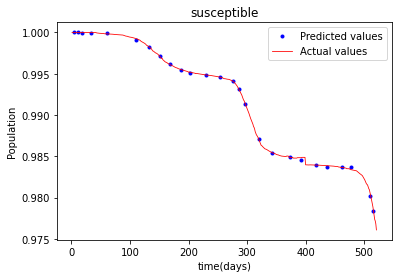

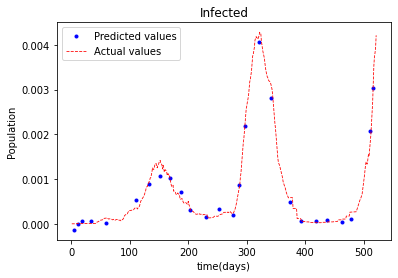

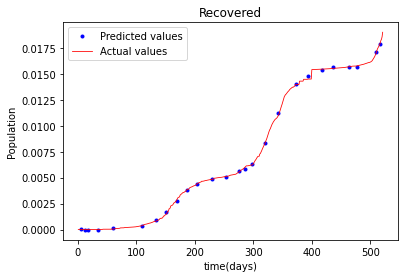

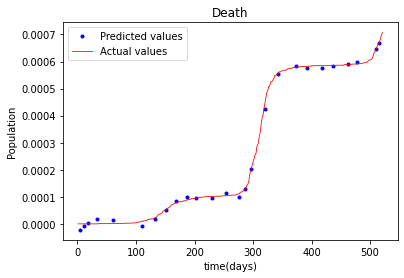

In [28]:
# side by side (tak guna train as training data)
plt.Figure()
plt.title("susceptible")
plt.plot(tested,s_pred,'b.',linewidth=0.8)   
plt.plot(XX,SS,'r-',linewidth=0.8)  
plt.legend(["Predicted values","Actual values"])
plt.xlabel('time(days)')
plt.ylabel('Population')
plt.show()

plt.Figure()
plt.title("Infected")
plt.plot(tested,i_pred,'b.',linewidth=0.8)   
plt.plot(XX,II,'r--',linewidth=0.8)  
plt.legend(["Predicted values","Actual values"])
plt.xlabel('time(days)')
plt.ylabel('Population')
plt.show()
    
plt.Figure()
plt.title("Recovered")
plt.plot(tested,r_pred,'b.',linewidth=0.8)   
plt.plot(XX,RR,'r-',linewidth=0.8)  
plt.legend(["Predicted values","Actual values"])
plt.xlabel('time(days)')
plt.ylabel('Population')
plt.show()
    
plt.Figure()
plt.title("Death")
plt.plot(tested,d_pred,'b.',linewidth=0.8)   
plt.plot(XX,DD,'r-',linewidth=0.8)  
plt.legend(["Predicted values","Actual values"])
plt.xlabel('time(days)')
plt.ylabel('Population')
plt.show()

